In [34]:
# -*- coding: utf-8 -*-
"""vrp_dqn.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1iothquIlGtKKte5KIxO-YCKzXnZGjbK-
"""
# !pip install tsplib95

from tqdm import tqdm
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from matplotlib import style
import tsplib95
import networkx as nx
import pickle

import time
import math
import re
import random
import copy

import tensorflow
if tensorflow.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tensorflow.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

from tensorflow.python.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
from tensorflow.python.keras import Sequential
# from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras.optimizers import Adam
from collections import deque

import io # to save the image
import math

Default GPU Device: /device:GPU:0


In [35]:
# from google.colab import drive
# drive.mount('/content/drive')

In [113]:
# https://stackoverflow.com/questions/57301698/how-to-change-a-learning-rate-for-adam-in-tf2https://stackoverflow.com/questions/57301698/how-to-change-a-learning-rate-for-adam-in-tf2
class LearningRateReducerCb(tensorflow.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        # old_lr = self.model.optimizer.lr.read_value()
        # new_lr = old_lr * 0.99
        new_lr = 0.001
        # print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
        self.model.optimizer.lr.assign(new_lr)

In [114]:
# 6. Define the movement restriction of the truck.
class Truck:
    def __init__(self, capacity, id, color):
        self.id = id
        self.color = color
        self.path = [] #this has the list of nodes it has visited
        self.max_truck_capacity = copy.deepcopy(capacity) #the max capacity
        self.capacity = copy.deepcopy(capacity)
        #self.visit_depo()
        self.prev_node = None
        self.node = 1 #starts from the depo

    def action(self, choice):
        # the number of choice of actions are the number of nodes-1
        # the choice to be taken depends on the demands - penalty based
        # the choice number is the same as the node number
        # it is not a choice if the demand is 0 - changing this to penalty
        #!! Want the system to learn instead
        # if self.capacity == 0:
        #     self.visit_depo()
        self.move(choice)

    def move(self, to_node_value):
        # node_list_copy = copy.deepcopy(node_list)
        # node_list_copy.remove(1)
        # select a random node to go to
        #if not to_node_value: #to_node_value is False by default
        #    to_node_value = random.choice(self.node_list)
        if to_node_value == 1:
            self.visit_depo()
        self.prev_node = self.node
        self.node = to_node_value
        self.path.append(to_node_value)
        # when invoked update the demand of the node
        # update the demand of the node

    def visit_depo(self):
        self.prev_node = self.node
        self.node = 1 #here it is 1
        self.capacity = copy.deepcopy(self.max_truck_capacity) #truck capacity reset
        self.path.append(1)
    
    #def path(self, node_value):
    #    self.path.append(node_value)

    # def get_node(self):
    #     return self.node

    
    # def get_capacity(self):
    #     return self.capacity


In [115]:
class VRPEnvironment:
    # environment related constants
    #https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.figure.html
    #observation_space = (640,480,3)
    # observation_space = (100,100,3)
    observation_space = (10,10,3)
    # penalty and rewards
    non_positive_capacity_penalty = 100
    zero_demand_penalty = 100 #truck goes to a zero demand node - except 1
    # ignore the failing task penalty as the episode will end only when...
    # all the demands are satisfied i.e. task will always be success...
    # The penalty of the achievement needs to go down.
    failing_task_penalty = 100 #trucks fail to complete the task
    completion_reward = 5000 #trucks complete the task
    demand_satisfying_reward = 100 #another incentive to hit the right target. Imp with considering each step
    hopping_incentive_penalty = 500 #staying at the same node
    # visit_correct_node_reward = 100
    # exploration settings
    permitted_path_length = 20 #30
    epsilon = 1
    epsilon_decay = 0.999#changing this from 0.999
    min_epsilon = 0.001 #0.001
    no_of_episodes = 10_000 #30_000
    # from 0 to 0.5 difference is small so using 1 first
    truck_colors = {
        1:(0,0,1),
        2:(0,1,0),
        3:(1,0,0),
        4:(0,0.5,0.5),
        5:(0.5,0,0.5),
        6:(0.5,0.5,0),
        7:(0.5,0.5,0.5),
        8:(0.5,0.5,1),
        9:(0.5,1,0.5),
        10:(1,0.5,0.5)
    }
    return_images = True
    image_size = 100

    def __init__(self):
        # 1. Extract the tsplib95 file problem
        # self.problem = tsplib95.load_problem('/content/drive/My Drive/HW Assignments/Sem 2/ADBI/Vrp-All/A/A-n32-k5.vrp')
        # self.problem = tsplib95.load_problem('/content/drive/My Drive/HW Assignments/Sem 2/ADBI/Vrp-All/_singleTruck/A-n32-k5_2.vrp')
        self.problem = tsplib95.load_problem('Vrp-All/_singleTruck/A-n32-k5_3.vrp')        
        # 2. Create a networkx graph out of the problem. //will be plotting this
        self.nx_graph = self.problem.get_graph()
        self.edge_list = list(self.problem.get_edges()) #[(,)]
        self.node_positions = self.problem.node_coords #dict
        # the list of nodes
        self.node_list = list(self.problem.get_nodes())
        self.action_space = len(self.node_list) #the number of choices including staying put
        # the depot location
        self.depot_location = 1
        # assigning the default color of the nodes to be black
        # node_color_values = [(0,0,0) for i in range(len(node_list))]
        # reseting the environment when initialized
        self.reset_environment()
        
    def reset_environment(self):
        # creating the Trucks
        # 4. Extract the necessary data about the trucks. //no of trucks, depot_section, capacity
        self.node_demands = copy.deepcopy(self.problem.demands)
        truck_capacity = copy.deepcopy(self.problem.capacity)
        # trying hardcoding for now
        self.truck = Truck(truck_capacity, 1, self.truck_colors.get(3))

        self.episode_step = 0

        if self.return_images:
            observation = np.array(self.get_image())
        
        # resetting the environment reward value
        # self.reward = 0
        # there is no else case as we need always need the image for CNN
        return observation

    # def calculate_move_penalty(self, source_node, dest_node):
    #     return self.problem.wfunc(source_node, dest_node) #the weight of the edge

    # change the demand of the node when visited
    def change_demand(self, node):
        self.node_demands[node] = 0

    def step(self, action):
        self.episode_step += 1
        # moving the trucks for the action
        self.truck.action(action)
        #print("action="+str(action)+"\n++++++")
        self.truck.capacity -= self.node_demands.get(action)
        self.change_demand(action)
        # print(self.truck.capacity)
        # other truck actions

        if self.return_images:
            new_observation = np.array(self.get_image())
        # there is no else case as the return image is always true

        # assinging the rewards and penalties
        self.reward = 0
        # checking if the demands have been satisfied
        completed = False
        if sum(list(self.node_demands.values())) == 0:
            print("\n***Satisfied***")
            # print(self.node_demands)
            completed = True
            self.reward = self.completion_reward
        else:
            # rewards for other trucks
            # print("before"+str(self.reward))
            self.node_penalty(self.truck) #other penalties
            self.movement_penalty(self.truck) #edge weight
            # print("after"+str(self.reward))
            # penalties for other trucks
        done = False
        if self.reward == self.completion_reward or len(self.truck.path) >= self.permitted_path_length:
        # if self.reward == self.completion_reward:
            done = True
            if sum(list(self.node_demands.values())) > 0:
                self.reward -= self.failing_task_penalty

        return new_observation, self.reward, done, completed

    def node_penalty(self, truck):
        if self.node_demands[truck.node] == 0:
            if (truck.node == 1 and truck.capacity == truck.max_truck_capacity) or truck.node!=1:
                self.reward -= self.zero_demand_penalty
        else:
            self.reward += self.demand_satisfying_reward

        if self.truck.capacity <= 0:
            self.reward -= self.non_positive_capacity_penalty
        # return self.reward

    def movement_penalty(self, truck):
        #print(self.truck.path)
        #print("-------")
        if truck.prev_node: #else it's 0
            source_node = truck.prev_node
            destination_node = truck.node
            if source_node == destination_node: #if truck stays at the same place
                self.reward -= self.hopping_incentive_penalty
            self.reward -= self.problem.wfunc(source_node, destination_node)
            # return self.problem.wfunc(source_node, destination_node)
        # else:
        #     source_node = truck.node
        #     destination_node = truck.node
        #     return 0
    # """
    def get_image(self):
        # the initiated rgb image of the given size. image_size = 100
        env = np.zeros((self.image_size, self.image_size, 3), dtype=np.uint8)
        for node in self.node_positions.keys():
            node_coods = self.node_positions.get(node)
            env[int(node_coods[0])][int(node_coods[1])] = (255,255,255)
        if self.truck.path: #if there are elements in the path
            for visited_node in set(self.truck.path):
                node_coods = self.node_positions.get(visited_node)
                #print(node_coods)
                #print(visited_node)
                #print(self.truck.path)
                #print(len(env))
                #print("--------")
                #try: #HAVING 0 HERE WAS CAUSING ERRORS! IGNORING 0 FOR NOW- STUPID
                env[int(node_coods[0])][int(node_coods[1])] = (255,0,0)
                #except:
                    #print(node_coods)
                    #print(visited_node)
                    #print(self.truck.path)
                    #print(len(env))
                    #print("--------")
        img = Image.fromarray(env, 'RGB')
        # trying to reduce to size to decrease the time taken
        img = img.resize((10,10))
        return img

    def render(self):
        img = self.get_image()
        img = img.resize((500,500))
        cv2.imshow("image", np.array(img))
        cv2.waitKey(1)
    """
    def get_image(self):
        fig,ax = plt.subplots()
        node_color_values = [(0,0,1) for i in range(len(self.node_list))]
        # ax.clear()
        if not self.truck.path: #if it is not empty
            for i in self.truck.path:
                node_color_values[i] = (1,0,0)
        image_io = io.BytesIO()
        #edge color is white to ignore it
        nx.draw(self.nx_graph, pos=self.node_positions, with_labels=False, node_color=node_color_values, node_size=20, edge_color=(1,1,1))
        fig.savefig(image_io, dpi=5)
        image = Image.open(image_io)
        image = image.resize((10,10))
        image.close() #keeping it open consumes a lot of memory
        return image

    def render(self):
        image = self.get_image()
        image = image.resize((1000,1000))
        cv2.imshow("image",np.array(image))
        cv2.waitKey(1)
    """

In [116]:
class DQNAgent:
    def __init__(self):
        # main model
        self.main_model = self.create_model()
        
        # target model
        self.target_model = self.create_model()
        self.target_model.set_weights(self.main_model.get_weights())

        # an array with last n steps for training
        # self.replay_memory = deque(maxlen=considering_training_length)
        self.replay_memory = [] #removing the limit

        # used to know when to update target n/w with main n/w's weights
        self.target_update_counter = 0
        
    def create_model(self):
        model = Sequential()

        # model.add(Conv2D(256, (10,10), input_shape=environment.observation_space))
        model.add(Conv2D(256, (3,3), input_shape=environment.observation_space))
        model.add(Activation('relu'))
        # model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.2))

        # model.add(Conv2D(256,(10,10)))
        model.add(Conv2D(256,(3,3)))
        model.add(Activation('relu'))
        # model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.2))

        # converting the 3D features into the 1D feature
        model.add(Flatten())
        model.add(Dense(64))

        model.add(Dense(environment.action_space, activation='linear'))
        model.compile(loss='mse', optimizer='Adam', metrics=['accuracy'])

        return model

    # adding the step data into the array to be considered later
    def update_replay_memory(self, step):
        #print(step[2])
        #print("****")
        self.replay_memory.append(step)
        
    def consider_reward(self, element):
        return element[1]
        
    def get_max_rewarded_steps(self, replay_memory, length):
        #replay_memory has the steps and steps[2] is the rewards
        # max = -math.inf
        step_reward_pairs = []
        for step in replay_memory:
            if len(step_reward_pairs) <= length:
                step_reward_pairs.append((step, step[2]))
            else:
                step_reward_pairs.sort(reverse=True, key=self.consider_reward)
                if step_reward_pairs[-1][1] < step[2]:
                    step_reward_pairs.pop() #removing the least value i.e. the last value
                    step_reward_pairs.append((step, step[2]))
        steps_list = []
        for step_reward_pair in step_reward_pairs:
            steps_list.append(step_reward_pair[0])
        return steps_list
    
    def train(self, terminal_state, step):
        # start training only when we have a certain number of samples already saved
        if len(self.replay_memory)< min_replay_memory_size:
            return
        # get the minibatch of the samples from the replay table - OLD
        #minibatch = random.sample(self.replay_memory, min_training_length)
        # get the minibatch of the samples that have the highest reward
        minibatch = self.get_max_rewarded_steps(self.replay_memory, min_training_length)
        
        # get current states from minibatch, then query NN model for Q values
        current_states = np.array([transition[0] for transition in minibatch])/255
        current_qs_list = self.main_model.predict(current_states)

        # get future states from the minibatch, then query NN model for Q values
        new_current_states = np.array([transition[3] for transition in minibatch])/255
        future_qs_list = self.target_model.predict(new_current_states)

        X = []
        y = []
        
        # enumerating through the batches
        for index,(current_state, action, reward, new_current_state, done) in enumerate(minibatch):
            # if its not a terminal state, get new q from future states or else set to 0
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + discount*max_future_q
            else:
                new_q = reward

            # update the q value for given state
            current_qs = current_qs_list[index]
            current_qs[action] = new_q

            # append to the training data
            X.append(current_state)
            y.append(current_qs)
        
        # fit on all samples as one batch
        self.main_model.fit(np.array(X)/255, np.array(y), batch_size=min_training_length, verbose=0, shuffle=False, callbacks=[LearningRateReducerCb()])
        
        # updating the target n/w counter every episode
        if terminal_state:
            self.target_update_counter += 1
        
        # if the counter reaches the required value...
        # update the target n/w with weights of main n/w
        if self.target_update_counter > update_target_every:
            self.target_model.set_weights(self.main_model.get_weights())
            self.target_update_counter = 0
    
    # query the main n/w for q values given the current observation space
    def get_qs(self, state):
        return self.main_model.predict(np.array(state).reshape(-1, *state.shape)/255)[0]
    
    def get_models(self):
        return self.main_model, self.target_model


In [117]:
# model related constants
discount = 0.99 #the discount applied to the DQN equation
# the environment keeps running till the demand of the nodes is satisfied
considering_training_length = 50_000 #the no of steps considered for training
min_training_length = 100 #the no of steps used for training
# episodes = 30_000
update_target_every = 5 #terminal states (end of episodes)
min_replay_memory_size = 1000 #min no of steps in a memory to start training

environment = VRPEnvironment()
agent = DQNAgent()

In [120]:
show_preview = False #using this will make it slow. Don't care about this now.
aggregrate_stats_every = 50
start_decaying = True #making this True ignores the conditional decaying - Notes 2.a

x_axis = list(range(environment.no_of_episodes+1))
epsilon_list = []
rewards_list = []
path_length_list = []

epsilon_decaying_factor = 1500

# iterate over the episodes
for episode in tqdm(range(1, environment.no_of_episodes + 1), ascii=True, unit='episodes'):
    #print(episode)
    # Restarting episode - reset episode reward and step number
    episode_reward = 0
    step = 1
    # Reset environment and get initial state
    current_state = environment.reset_environment()
    # Reset flag and start iterating until episode ends
    done = False
    while not done:
        # This part stays mostly the same, the change is to query a model for Q values
        if np.random.random() > environment.epsilon:
            # Get action from Q table
            action = np.argmax(agent.get_qs(current_state))
            #print("action="+str(action)+"\n++++++")
        else:
            # Get random action
            action = np.random.randint(1, environment.action_space)

        if action != 0: #JUST IGNORING 0. MIGHT BE STUPID!
            new_state, reward, done, completed = environment.step(action)
        # Transform new continous state to new discrete state and count reward
        episode_reward += reward
        if show_preview and not episode % aggregrate_stats_every:
            env.render()
        # Every step we update replay memory and train main network
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        agent.train(done, step)
        current_state = new_state
        step += 1

        # Decay the Epsilon
        if completed:
            start_decaying = True
        
        if start_decaying:
            # environment.epsilon = 0.001
            if environment.epsilon > environment.min_epsilon:
                # environment.epsilon *= environment.epsilon_decay
                environment.epsilon = np.exp(-episode/epsilon_decaying_factor)
                environment.epsilon = max(environment.min_epsilon, environment.epsilon)
        # print(".",end="")
    epsilon_list.append(environment.epsilon*1000)
    rewards_list.append(episode_reward)
    path_length_list.append(len(environment.truck.path)*100)
    
    print("Path is:", end=" ")
    print(environment.truck.path, end=";")
    print("P and R: "+str(episode_reward), end=";")
    print("Capacity: "+str(environment.truck.capacity), end=";")
    print("Epsilon: "+str(environment.epsilon))






  0%|                                                                                                                                                                             | 0/10000 [00:00<?, ?episodes/s]


***Satisfied***
Path is: [7, 7, 7, 7, 2, 3, 2, 5, 8, 4, 7, 9, 9, 6];P and R: 1663;Capacity: 2;Epsilon: 0.9993335555061811
Path is: [9, 1, 1, 2, 3, 3, 8, 7, 9, 5, 9, 6, 3, 3, 2, 9, 1, 1, 6, 8];P and R: -3961;Capacity: 100;Epsilon: 0.9986675551606254
Path is: [6, 5, 2, 5, 4, 3, 5, 2, 1, 1, 1, 1, 5, 7, 3, 5, 1, 1, 8, 7];P and R: -3354;Capacity: 82;Epsilon: 0.9980019986673331
Path is: [9, 5, 8, 5, 2, 2, 6, 9, 8, 6, 9, 1, 1, 6, 2, 3, 7, 2, 7, 8];P and R: -3081;Capacity: 88;Epsilon: 0.9973368857305009
Path is: [4, 6, 1, 1, 4, 7, 3, 7, 8, 6, 3, 2, 6, 3, 3, 3, 4, 8, 9, 8];P and R: -3555;Capacity: 61;Epsilon: 0.9966722160545233
Path is: [6, 2, 3, 2, 4, 1, 1, 1, 1, 3, 9, 3, 9, 2, 9, 4, 5, 8, 3, 2];P and R: -2982;Capacity: 67;Epsilon: 0.9960079893439915

***Satisfied***
Path is: [1, 1, 3, 2, 5, 4, 2, 2, 4, 7, 8, 6, 3, 7, 2, 7, 7, 4, 9];P and R: 1749;Capacity: 2;Epsilon: 0.9953442053036935

***Satisfied***
Path is: [3, 6, 5, 1, 1, 5, 7, 8, 2, 5, 9, 9, 3, 4];P and R: 2757;Capacity: 40;Epsilon: 0.9






  0%|2                                                                                                                                                                   | 18/10000 [00:00<07:30, 22.18episodes/s]




  0%|4                                                                                                                                                                   | 30/10000 [00:00<05:41, 29.16episodes/s]

Path is: [6, 8, 4, 9, 9, 4, 4, 6, 3, 2, 8, 2, 1, 1, 8, 4, 9, 5, 3, 4];P and R: -3583;Capacity: 86;Epsilon: 0.9880717128619305
Path is: [9, 7, 3, 4, 4, 3, 4, 7, 1, 1, 9, 3, 6, 8, 3, 6, 7, 7, 1, 1];P and R: -3964;Capacity: 100;Epsilon: 0.9874132179093955
Path is: [3, 6, 6, 6, 7, 1, 1, 3, 2, 6, 6, 6, 2, 2, 1, 1, 2, 8, 1, 1];P and R: -5833;Capacity: 100;Epsilon: 0.9867551618071957
Path is: [3, 2, 1, 1, 8, 1, 1, 9, 2, 7, 4, 9, 7, 2, 8, 2, 3, 9, 3, 8];P and R: -3000;Capacity: 66;Epsilon: 0.9860975442628619
Path is: [7, 2, 4, 9, 2, 2, 4, 3, 6, 3, 3, 7, 6, 4, 9, 2, 6, 9, 8, 3];P and R: -3188;Capacity: 16;Epsilon: 0.9854403649841196
Path is: [6, 1, 1, 7, 8, 2, 7, 8, 1, 1, 7, 9, 2, 7, 4, 1, 1, 3, 2, 1, 1];P and R: -3866;Capacity: 100;Epsilon: 0.9847836236788889

***Satisfied***
Path is: [4, 9, 2, 9, 5, 7, 6, 6, 4, 3, 8];P and R: 3459;Capacity: 2;Epsilon: 0.9841273200552851

***Satisfied***
Path is: [8, 2, 9, 5, 2, 7, 6, 6, 3, 6, 9, 2, 6, 8, 4];P and R: 3026;Capacity: 2;Epsilon: 0.983471453821617






  0%|5                                                                                                                                                                   | 35/10000 [00:01<04:59, 33.23episodes/s]

Path is: [9, 7, 4, 4, 5, 8, 5, 8, 8, 5, 2, 4, 9, 4, 9, 1, 1, 5, 7, 8];P and R: -3569;Capacity: 100;Epsilon: 0.9788926126429459
Path is: [2, 3, 9, 4, 6, 1, 1, 6, 5, 3, 8, 2, 3, 1, 1, 9, 8, 2, 3, 1, 1];P and R: -3467;Capacity: 100;Epsilon: 0.97824023505121

***Satisfied***
Path is: [5, 5, 5, 7, 1, 1, 7, 9, 6, 5, 9, 5, 3, 4, 3, 8, 8, 2];P and R: 1354;Capacity: 28;Epsilon: 0.977588292232928

***Satisfied***
Path is: [5, 9, 9, 4, 6, 6, 2, 9, 5, 5, 5, 2, 8, 3, 7];P and R: 1541;Capacity: 2;Epsilon: 0.9769367838983476
Path is: [4, 2, 4, 3, 4, 5, 6, 1, 1, 3, 7, 5, 9, 4, 6, 3, 9, 9, 2, 5];P and R: -3065;Capacity: 87;Epsilon: 0.9762857097579093
Path is: [1, 1, 6, 5, 9, 7, 9, 6, 3, 2, 6, 9, 2, 1, 1, 1, 1, 8, 8, 6];P and R: -3858;Capacity: 82;Epsilon: 0.9756350695222471

***Satisfied***
Path is: [1, 1, 8, 4, 1, 1, 7, 3, 4, 4, 6, 9, 4, 5, 9, 1, 1, 1, 1, 2];P and R: 950;Capacity: 92;Epsilon: 0.9749848629021873

***Satisfied***
Path is: [9, 3, 9, 5, 5, 7, 2, 8, 7, 2, 3, 1, 1, 8, 3, 2, 4, 4, 2, 6];P an






  0%|6                                                                                                                                                                   | 40/10000 [00:02<20:14,  8.20episodes/s]

Path is: [2, 3, 3, 7, 9, 5, 2, 4, 4, 5, 4, 7, 5, 2, 1, 1, 6, 5, 7, 3];P and R: -3552;Capacity: 76;Epsilon: 0.973685749353145

***Satisfied***
Path is: [3, 5, 7, 4, 3, 6, 5, 4, 7, 9, 9, 2, 8];P and R: 3265;Capacity: 2;Epsilon: 0.9730368418467786

***Satisfied***
Path is: [7, 2, 6, 5, 5, 4, 8, 4, 7, 2, 1, 1, 3, 3, 5, 6, 6, 9];P and R: 1347;Capacity: 99;Epsilon: 0.9723883668012469
Path is: [5, 1, 1, 1, 1, 8, 6, 7, 8, 5, 4, 3, 8, 9, 5, 4, 4, 6, 8, 8];P and R: -3947;Capacity: 24;Epsilon: 0.9717403239283386
Path is: [2, 5, 5, 6, 9, 3, 7, 7, 9, 3, 2, 5, 5, 5, 3, 9, 3, 9, 8, 2];P and R: -4175;Capacity: 23;Epsilon: 0.9710927129400347
Path is: [5, 8, 5, 6, 1, 1, 7, 3, 2, 4, 6, 3, 3, 6, 1, 1, 4, 3, 7, 1, 1];P and R: -3955;Capacity: 100;Epsilon: 0.9704455335485082
Path is: [7, 2, 1, 1, 1, 1, 3, 8, 3, 8, 4, 9, 4, 6, 4, 7, 7, 8, 3, 2];P and R: -3476;Capacity: 36;Epsilon: 0.9697987854661236
Path is:






  0%|7                                                                                                                                                                   | 47/10000 [00:02<15:28, 10.71episodes/s]




  1%|9                                                                                                                                                                   | 56/10000 [00:03<11:39, 14.22episodes/s]

 [3, 7, 6, 2, 4, 3, 6, 4, 3, 8, 4, 7, 7, 3, 3, 6, 7, 2, 3, 3];P and R: -3664;Capacity: 17;Epsilon: 0.9691524684054375

***Satisfied***
Path is: [6, 3, 3, 7, 2, 5, 9, 1, 1, 9, 6, 8, 6, 7, 4];P and R: 2645;Capacity: 61;Epsilon: 0.9685065820791976
Path is: [9, 1, 1, 4, 7, 3, 3, 1, 1, 4, 7, 2, 5, 9, 8, 1, 1, 5, 3, 9];P and R: -3867;Capacity: 100;Epsilon: 0.9678611262003435

***Satisfied***
Path is: [8, 8, 3, 3, 5, 7, 6, 2, 4, 9];P and R: 3067;Capacity: 2;Epsilon: 0.9672161004820059
Path is: [8, 4, 4, 1, 1, 4, 8, 1, 1, 8, 1, 1, 2, 4, 4, 5, 3, 4, 9, 6];P and R: -4355;Capacity: 53;Epsilon: 0.9665715046375066
Path is: [4, 8, 5, 2, 3, 7, 8, 2, 4, 2, 3, 7, 3, 1, 1, 8, 8, 8, 3, 6];P and R: -3574;Capacity: 76;Epsilon: 0.9659273383803587

***Satisfied***
Path is: [2, 1, 1, 6, 5, 6, 9, 4, 8, 2, 1, 1, 7];P and R: 2966;Capacity: 88;Epsilon: 0.965283601424266
Path is: [2, 4, 7, 4, 5, 6, 6, 9, 5, 4, 2, 5, 7, 9, 4, 5, 6, 9, 1, 1];P and R: -3048;Capacity: 100;Epsilon: 0.9646402934831231
Path is: [3, 7, 7,






  1%|9                                                                                                                                                                 | 61/10000 [00:10<1:18:43,  2.10episodes/s]

Path is: [3, 9, 3, 9, 6, 2, 8, 2, 1, 1, 7, 7, 6, 8, 7, 8, 7, 6, 1, 1];P and R: -3469;Capacity: 100;Epsilon: 0.9601491263208808

***Satisfied***
Path is: [8, 3, 5, 2, 2, 9, 9, 4, 4, 9, 5, 8, 6, 7];P and R: 2143;Capacity: 2;Epsilon: 0.9595092402223991

***Satisfied***
Path is: [4, 8, 5, 4, 4, 7, 7, 3, 9, 1, 1, 2, 2, 6];P and R: 1766;Capacity: 68;Epsilon: 0.9588697805724845







  1%|#                                                                                                                                                                 | 64/10000 [00:18<3:11:42,  1.16s/episodes]

Path is: [3, 6, 2, 8, 9, 6, 9, 6, 7, 7, 5, 1, 1, 2, 2, 3, 5, 3, 9, 7];P and R: -3556;Capacity: 100;Epsilon: 0.9582307470869327

***Satisfied***
Path is: [1, 1, 3, 3, 9, 4, 6, 7, 9, 9, 4, 3, 2, 5, 3, 9, 2, 4, 5, 8];P and R: 1641;Capacity: 2;Epsilon: 0.9575921394817286
Path is: [9, 8, 2, 1, 1, 2, 3, 9, 3, 7, 9, 8, 6, 6, 6, 1, 1, 9, 4, 9];P and R: -3973;Capacity: 79;Epsilon: 0.9569539574730467







  1%|#                                                                                                                                                                 | 67/10000 [00:26<4:34:09,  1.66s/episodes]


***Satisfied***
Path is: [2, 5, 2, 9, 6, 5, 2, 2, 7, 8, 1, 1, 1, 1, 7, 8, 4];P and R: 2056;Capacity: 79;Epsilon: 0.9563162007772505
Path is: [9, 9, 9, 6, 5, 5, 9, 8, 7, 6, 9, 4, 7, 3, 9, 5, 7, 4, 9, 8];P and R: -3671;Capacity: 10;Epsilon: 0.9556788691108927







  1%|#1                                                                                                                                                                | 69/10000 [00:33<5:47:49,  2.10s/episodes]

Path is: [7, 2, 3, 1, 1, 8, 8, 7, 1, 1, 5, 5, 5, 6, 2, 7, 4, 1, 1, 6];P and R: -4858;Capacity: 100;Epsilon: 0.9550419621907147
Path is: [4, 9, 7, 5, 5, 3, 4, 8, 2, 5, 3, 5, 3, 2, 1, 1, 4, 7, 5, 2];P and R: -3062;Capacity: 100;Epsilon: 0.9544054797336466







  1%|#1                                                                                                                                                                | 71/10000 [00:38<6:22:40,  2.31s/episodes]

Path is: [6, 1, 1, 2, 4, 7, 6, 1, 1, 4, 5, 3, 6, 3, 9, 9, 3, 5, 1, 1];P and R: -3851;Capacity: 100;Epsilon: 0.9537694214568075







  1%|#1                                                                                                                                                                | 72/10000 [00:41<6:45:08,  2.45s/episodes]

Path is: [3, 7, 7, 5, 8, 6, 5, 6, 9, 4, 1, 1, 4, 7, 5, 8, 8, 5, 1, 1];P and R: -3950;Capacity: 100;Epsilon: 0.9531337870775047







  1%|#1                                                                                                                                                                | 73/10000 [00:44<6:59:19,  2.53s/episodes]

Path is: [2, 6, 8, 1, 1, 8, 1, 1, 1, 1, 5, 7, 8, 8, 1, 1, 9, 9, 9, 6];P and R: -5245;Capacity: 99;Epsilon: 0.9524985763132342







  1%|#1                                                                                                                                                                | 74/10000 [00:46<7:04:14,  2.56s/episodes]

Path is: [3, 9, 9, 9, 8, 8, 1, 1, 8, 4, 4, 1, 1, 2, 1, 1, 4, 4, 2, 9];P and R: -5845;Capacity: 100;Epsilon: 0.9518637888816799







  1%|#2                                                                                                                                                                | 75/10000 [00:49<7:29:43,  2.72s/episodes]

Path is: [6, 7, 7, 2, 9, 4, 6, 2, 4, 9, 5, 9, 2, 9, 9, 3, 3, 5, 4, 4];P and R: -4188;Capacity: 20;Epsilon: 0.951229424500714







  1%|#2                                                                                                                                                                | 76/10000 [00:52<7:29:58,  2.72s/episodes]

Path is: [9, 5, 1, 1, 8, 8, 3, 7, 6, 3, 1, 1, 9, 4, 9, 7, 3, 3, 1, 1];P and R: -4375;Capacity: 100;Epsilon: 0.9505954828883969







  1%|#2                                                                                                                                                                | 77/10000 [00:57<8:49:46,  3.20s/episodes]

Path is: [5, 6, 4, 9, 4, 6, 3, 7, 9, 3, 3, 6, 7, 4, 9, 3, 8, 8, 3, 7];P and R: -3188;Capacity: 10;Epsilon: 0.9499619637629768







  1%|#2                                                                                                                                                                | 78/10000 [01:00<9:07:03,  3.31s/episodes]

Path is: [6, 7, 1, 1, 1, 1, 4, 7, 6, 6, 1, 1, 3, 6, 7, 3, 6, 1, 1, 6];P and R: -4242;Capacity: 100;Epsilon: 0.9493288668428895







  1%|#2                                                                                                                                                               | 79/10000 [01:05<10:07:14,  3.67s/episodes]

Path is: [9, 7, 6, 2, 1, 1, 2, 1, 1, 2, 2, 9, 3, 7, 2, 9, 2, 4, 2, 8];P and R: -3484;Capacity: 61;Epsilon: 0.9486961918467588







  1%|#2                                                                                                                                                                | 80/10000 [01:07<9:23:10,  3.41s/episodes]


***Satisfied***
Path is: [7, 6, 4, 2, 7, 5, 6, 5, 7, 8, 7, 4, 4, 8, 8, 8, 9];P and R: 1858;Capacity: 2;Epsilon: 0.9480639384933955







  1%|#3                                                                                                                                                                | 81/10000 [01:10<8:40:05,  3.15s/episodes]

Path is: [8, 1, 1, 8, 5, 5, 8, 4, 2, 1, 1, 8, 5, 6, 7, 2, 1, 1, 8, 5];P and R: -3874;Capacity: 100;Epsilon: 0.9474321065017983







  1%|#3                                                                                                                                                                | 82/10000 [01:13<8:39:08,  3.14s/episodes]

Path is: [6, 2, 5, 7, 6, 2, 3, 2, 1, 1, 7, 2, 6, 2, 5, 9, 7, 9, 6, 1, 1];P and R: -3073;Capacity: 100;Epsilon: 0.9468006955911529







  1%|#3                                                                                                                                                                | 83/10000 [01:16<8:17:37,  3.01s/episodes]


***Satisfied***
Path is: [4, 9, 5, 6, 3, 6, 6, 9, 4, 5, 5, 4, 2, 1, 1, 7, 2, 2, 8];P and R: 1246;Capacity: 70;Epsilon: 0.9461697054808322







  1%|#3                                                                                                                                                                | 84/10000 [01:18<8:03:25,  2.93s/episodes]


***Satisfied***
Path is: [2, 4, 1, 1, 1, 1, 4, 3, 9, 6, 2, 9, 6, 5, 8, 5, 9, 4, 8, 7];P and R: 2234;Capacity: 31;Epsilon: 0.9455391358903963







  1%|#3                                                                                                                                                                | 85/10000 [01:21<7:53:13,  2.86s/episodes]

Path is: [8, 4, 9, 5, 2, 3, 6, 3, 9, 2, 5, 4, 1, 1, 8, 1, 1, 3, 2, 6];P and R: -2982;Capacity: 100;Epsilon: 0.9449089865395918







  1%|#3                                                                                                                                                                | 86/10000 [01:23<7:15:42,  2.64s/episodes]


***Satisfied***
Path is: [1, 1, 1, 1, 3, 4, 7, 9, 7, 5, 7, 6, 7, 2, 8];P and R: 2773;Capacity: 2;Epsilon: 0.9442792571483525







  1%|#4                                                                                                                                                                | 87/10000 [01:27<7:44:40,  2.81s/episodes]

Path is: [2, 2, 2, 6, 7, 3, 3, 8, 7, 8, 8, 8, 2, 6, 8, 9, 1, 1, 3, 9];P and R: -5052;Capacity: 100;Epsilon: 0.9436499474367985







  1%|#4                                                                                                                                                                | 88/10000 [01:29<7:41:30,  2.79s/episodes]

Path is: [5, 4, 2, 1, 1, 8, 4, 8, 4, 5, 1, 1, 6, 7, 2, 6, 6, 3, 8, 3];P and R: -3478;Capacity: 64;Epsilon: 0.9430210571252368







  1%|#4                                                                                                                                                                | 89/10000 [01:32<7:32:58,  2.74s/episodes]


***Satisfied***
Path is: [5, 1, 1, 7, 8, 2, 8, 7, 8, 3, 7, 8, 2, 9, 2, 4, 2, 6];P and R: 2821;Capacity: 16;Epsilon: 0.9423925859341603







  1%|#4                                                                                                                                                                | 90/10000 [01:35<7:51:57,  2.86s/episodes]

Path is: [8, 4, 8, 4, 5, 8, 7, 3, 6, 5, 9, 4, 7, 9, 4, 3, 5, 9, 9, 7];P and R: -2679;Capacity: 10;Epsilon: 0.9417645335842487







  1%|#4                                                                                                                                                                | 91/10000 [01:38<7:56:28,  2.89s/episodes]

Path is: [9, 5, 8, 9, 7, 7, 7, 9, 8, 5, 3, 9, 1, 1, 5, 3, 4, 7, 1, 1];P and R: -3955;Capacity: 100;Epsilon: 0.9411368997963675







  1%|#4                                                                                                                                                                | 92/10000 [01:41<7:49:31,  2.84s/episodes]

Path is: [7, 4, 8, 4, 1, 1, 7, 7, 9, 6, 5, 4, 1, 1, 6, 7, 8, 5, 7, 1, 1];P and R: -3956;Capacity: 100;Epsilon: 0.9405096842915684







  1%|#5                                                                                                                                                                | 93/10000 [01:44<8:02:41,  2.92s/episodes]

Path is: [4, 8, 9, 8, 9, 5, 5, 6, 6, 2, 5, 9, 4, 9, 8, 2, 6, 5, 9, 5];P and R: -3172;Capacity: 14;Epsilon: 0.9398828867910889







  1%|#5                                                                                                                                                                | 94/10000 [01:46<7:44:01,  2.81s/episodes]

Path is: [6, 6, 2, 1, 1, 2, 1, 1, 3, 3, 5, 8, 1, 1, 1, 1, 7, 3, 3, 1, 1];P and R: -5738;Capacity: 100;Epsilon: 0.9392565070163523







  1%|#5                                                                                                                                                                | 95/10000 [01:49<7:40:54,  2.79s/episodes]

Path is: [9, 5, 1, 1, 5, 4, 3, 1, 1, 5, 6, 3, 5, 4, 6, 3, 2, 9, 3, 3];P and R: -3464;Capacity: 68;Epsilon: 0.9386305446889677







  1%|#5                                                                                                                                                                | 96/10000 [01:51<7:14:02,  2.63s/episodes]


***Satisfied***
Path is: [5, 6, 3, 5, 9, 4, 7, 5, 5, 2, 2, 7, 8];P and R: 2757;Capacity: 2;Epsilon: 0.9380049995307295







  1%|#5                                                                                                                                                                | 97/10000 [01:54<7:13:50,  2.63s/episodes]


***Satisfied***
Path is: [3, 8, 5, 2, 9, 2, 8, 8, 2, 9, 3, 6, 5, 9, 3, 7, 4];P and R: 2807;Capacity: 2;Epsilon: 0.9373798712636177







  1%|#5                                                                                                                                                                | 98/10000 [01:57<7:25:22,  2.70s/episodes]


***Satisfied***
Path is: [8, 2, 8, 6, 7, 8, 8, 9, 8, 4, 9, 1, 1, 3, 6, 9, 3, 9, 5];P and R: 2228;Capacity: 86;Epsilon: 0.9367551596097973







  1%|#6                                                                                                                                                                | 99/10000 [02:00<7:36:35,  2.77s/episodes]

Path is: [8, 5, 5, 3, 6, 9, 9, 4, 8, 6, 1, 1, 5, 8, 7, 4, 4, 9, 4, 7];P and R: -4071;Capacity: 88;Epsilon: 0.9361308642916188







  1%|#6                                                                                                                                                               | 100/10000 [02:03<7:45:13,  2.82s/episodes]

Path is: [8, 6, 3, 4, 3, 6, 6, 2, 4, 3, 6, 3, 2, 7, 6, 1, 1, 5, 7, 8];P and R: -3060;Capacity: 86;Epsilon: 0.9355069850316178







  1%|#6                                                                                                                                                               | 101/10000 [02:05<7:10:52,  2.61s/episodes]


***Satisfied***
Path is: [8, 9, 2, 1, 1, 3, 5, 6, 1, 1, 8, 7, 3, 4];P and R: 2856;Capacity: 67;Epsilon: 0.9348835215525143







  1%|#6                                                                                                                                                               | 102/10000 [02:08<7:22:26,  2.68s/episodes]

Path is: [4, 1, 1, 2, 5, 5, 7, 2, 3, 5, 9, 2, 1, 1, 5, 8, 5, 5, 9, 2];P and R: -3965;Capacity: 82;Epsilon: 0.9342604735772135







  1%|#6                                                                                                                                                               | 103/10000 [02:09<6:32:10,  2.38s/episodes]


***Satisfied***
Path is: [4, 9, 6, 7, 9, 5, 1, 1, 4, 5, 8, 2];P and R: 3469;Capacity: 74;Epsilon: 0.9336378408288053







  1%|#6                                                                                                                                                               | 104/10000 [02:12<6:29:55,  2.36s/episodes]


***Satisfied***
Path is: [8, 7, 4, 6, 9, 6, 3, 9, 8, 6, 5, 1, 1, 4, 4, 2];P and R: 2553;Capacity: 92;Epsilon: 0.933015623030564







  1%|#6                                                                                                                                                               | 105/10000 [02:14<6:51:26,  2.49s/episodes]

Path is: [3, 7, 8, 7, 2, 3, 3, 4, 2, 4, 2, 1, 1, 7, 3, 1, 1, 7, 4, 9];P and R: -3461;Capacity: 99;Epsilon: 0.9323938199059483







  1%|#7                                                                                                                                                               | 106/10000 [02:18<7:38:23,  2.78s/episodes]

Path is: [3, 6, 4, 5, 2, 8, 2, 8, 7, 5, 3, 6, 6, 8, 3, 5, 8, 7, 8, 1, 1];P and R: -3169;Capacity: 100;Epsilon: 0.9317724311786011







  1%|#7                                                                                                                                                               | 107/10000 [02:21<7:41:24,  2.80s/episodes]


***Satisfied***
Path is: [5, 9, 7, 5, 1, 1, 3, 8, 9, 8, 2, 3, 3, 9, 5, 3, 4, 8, 6];P and R: 2240;Capacity: 29;Epsilon: 0.9311514565723499







  1%|#7                                                                                                                                                               | 108/10000 [02:24<7:48:12,  2.84s/episodes]

Path is: [6, 1, 1, 8, 2, 8, 9, 6, 8, 6, 6, 3, 6, 2, 6, 6, 1, 1, 2, 2];P and R: -4465;Capacity: 100;Epsilon: 0.9305308958112057







  1%|#7                                                                                                                                                               | 109/10000 [02:26<7:33:09,  2.75s/episodes]


***Satisfied***
Path is: [1, 1, 9, 2, 6, 9, 4, 5, 2, 6, 8, 8, 2, 5, 2, 3, 7];P and R: 2433;Capacity: 2;Epsilon: 0.929910748619364







  1%|#7                                                                                                                                                               | 110/10000 [02:29<7:42:37,  2.81s/episodes]

Path is: [7, 7, 6, 6, 8, 6, 2, 8, 8, 8, 6, 5, 5, 7, 5, 7, 3, 5, 1, 1];P and R: -5051;Capacity: 100;Epsilon: 0.9292910147212036







  1%|#7                                                                                                                                                               | 111/10000 [02:32<8:02:33,  2.93s/episodes]

Path is: [3, 4, 7, 8, 2, 5, 4, 8, 7, 7, 6, 3, 4, 5, 7, 6, 6, 1, 1, 7];P and R: -3548;Capacity: 100;Epsilon: 0.9286716938412872







  1%|#8                                                                                                                                                               | 112/10000 [02:36<8:12:50,  2.99s/episodes]


***Satisfied***
Path is: [5, 7, 5, 9, 2, 6, 6, 6, 6, 4, 1, 1, 4, 6, 1, 1, 2, 5, 6, 8];P and R: 752;Capacity: 82;Epsilon: 0.9280527857043611

***Satisfied***
Path is:






  1%|#8                                                                                                                                                               | 113/10000 [02:38<8:10:45,  2.98s/episodes]

 [9, 2, 7, 2, 6, 4, 8, 4, 3, 3, 2, 2, 1, 1, 4, 8, 1, 1, 2, 5];P and R: 1232;Capacity: 86;Epsilon: 0.9274342900353552







  1%|#8                                                                                                                                                               | 114/10000 [02:41<8:07:43,  2.96s/episodes]

Path is: [7, 8, 4, 8, 3, 5, 7, 9, 6, 1, 1, 1, 1, 4, 1, 1, 5, 8, 7, 8];P and R: -3356;Capacity: 100;Epsilon: 0.9268162065593822







  1%|#8                                                                                                                                                               | 115/10000 [02:45<8:50:32,  3.22s/episodes]

Path is: [5, 6, 1, 1, 9, 8, 3, 8, 7, 8, 5, 1, 1, 7, 6, 8, 2, 6, 6, 1, 1];P and R: -3965;Capacity: 100;Epsilon: 0.9261985350017385







  1%|#8                                                                                                                                                               | 116/10000 [02:48<8:48:00,  3.21s/episodes]

Path is: [8, 7, 5, 9, 6, 6, 1, 1, 1, 1, 6, 5, 5, 3, 9, 7, 9, 3, 2, 5];P and R: -3959;Capacity: 92;Epsilon: 0.9255812750879036







  1%|#8                                                                                                                                                               | 117/10000 [02:51<8:25:12,  3.07s/episodes]

Path is: [7, 1, 1, 8, 1, 1, 2, 1, 1, 2, 6, 9, 9, 8, 3, 2, 6, 8, 5, 7];P and R: -3855;Capacity: 61;Epsilon: 0.9249644265435393







  1%|#8                                                                                                                                                               | 118/10000 [02:54<8:14:43,  3.00s/episodes]

Path is: [7, 9, 6, 1, 1, 6, 8, 4, 8, 3, 9, 4, 8, 3, 1, 1, 3, 6, 7, 3];P and R: -2984;Capacity: 100;Epsilon: 0.924347989094491







  1%|#9                                                                                                                                                               | 119/10000 [02:57<8:19:53,  3.04s/episodes]

Path is: [1, 1, 1, 1, 5, 6, 3, 6, 8, 8, 4, 7, 9, 4, 7, 7, 9, 5, 7, 6];P and R: -3951;Capacity: 10;Epsilon: 0.9237319624667863







  1%|#9                                                                                                                                                               | 120/10000 [03:01<9:02:36,  3.30s/episodes]

Path is: [7, 8, 3, 4, 3, 9, 3, 9, 4, 6, 1, 1, 2, 6, 6, 1, 1, 8, 6, 2];P and R: -3477;Capacity: 100;Epsilon: 0.9231163463866358







  1%|#9                                                                                                                                                               | 121/10000 [03:04<8:41:04,  3.16s/episodes]


***Satisfied***
Path is: [1, 1, 3, 2, 6, 7, 5, 7, 7, 4, 6, 7, 4, 2, 8, 3, 6, 3, 9];P and R: 2245;Capacity: 2;Epsilon: 0.9225011405804322







  1%|#9                                                                                                                                                               | 122/10000 [03:07<8:37:18,  3.14s/episodes]

Path is: [5, 5, 2, 3, 8, 2, 4, 7, 5, 8, 6, 1, 1, 2, 6, 3, 3, 8, 2, 7];P and R: -3576;Capacity: 100;Epsilon: 0.9218863447747506







  1%|#9                                                                                                                                                               | 123/10000 [03:10<8:40:33,  3.16s/episodes]

Path is: [7, 3, 2, 3, 5, 5, 8, 7, 8, 3, 6, 5, 4, 8, 1, 1, 3, 3, 7, 7];P and R: -4053;Capacity: 100;Epsilon: 0.9212719586963487







  1%|#9                                                                                                                                                               | 124/10000 [03:14<8:51:29,  3.23s/episodes]

Path is: [3, 7, 1, 1, 9, 9, 5, 2, 8, 7, 2, 9, 1, 1, 3, 9, 3, 9, 4, 3];P and R: -3488;Capacity: 79;Epsilon: 0.9206579820721656



***Satisfied***
Path is: [6, 5, 1, 1, 2, 7, 1, 1, 2, 8, 9, 5, 4];P and R: 2969;Capacity: 60;Epsilon: 0.9200444146293233


  1%|##                                                                                                                                                               | 125/10000 [03:15<7:42:07,  2.81s/episodes]




  1%|##                                                                                                                                                               | 126/10000 [03:19<8:08:18,  2.97s/episodes]

Path is: [5, 2, 9, 5, 2, 5, 5, 3, 8, 9, 5, 6, 3, 4, 4, 9, 4, 8, 3, 4];P and R: -3180;Capacity: 14;Epsilon: 0.9194312560951247







  1%|##                                                                                                                                                               | 127/10000 [03:22<8:03:14,  2.94s/episodes]

Path is: [9, 1, 1, 4, 9, 5, 4, 9, 2, 1, 1, 3, 9, 9, 5, 3, 9, 4, 1, 1];P and R: -3875;Capacity: 100;Epsilon: 0.9188185061970551







  1%|##                                                                                                                                                               | 128/10000 [03:24<7:53:36,  2.88s/episodes]


***Satisfied***
Path is: [4, 4, 4, 3, 4, 2, 2, 8, 4, 3, 6, 4, 5, 7, 7, 9];P and R: 1465;Capacity: 2;Epsilon: 0.918206164662781







  1%|##                                                                                                                                                               | 129/10000 [03:28<8:21:34,  3.05s/episodes]

Path is: [1, 1, 1, 1, 5, 1, 1, 5, 5, 4, 2, 4, 6, 1, 1, 8, 2, 2, 7, 1, 1];P and R: -5247;Capacity: 100;Epsilon: 0.917594231220151







  1%|##                                                                                                                                                               | 130/10000 [03:32<9:17:01,  3.39s/episodes]

Path is: [6, 3, 7, 7, 3, 1, 1, 9, 9, 6, 1, 1, 6, 2, 9, 7, 1, 1, 8, 9];P and R: -4373;Capacity: 82;Epsilon: 0.9169827055971943







  1%|##1                                                                                                                                                              | 131/10000 [03:35<9:23:01,  3.42s/episodes]

Path is: [9, 4, 7, 5, 6, 1, 1, 2, 1, 1, 4, 6, 4, 4, 3, 6, 1, 1, 4, 5];P and R: -3846;Capacity: 100;Epsilon: 0.9163715875221219







  1%|##1                                                                                                                                                              | 132/10000 [03:39<9:14:41,  3.37s/episodes]

Path is: [3, 1, 1, 9, 6, 3, 5, 7, 1, 1, 9, 5, 7, 5, 1, 1, 5, 4, 5, 4];P and R: -3359;Capacity: 79;Epsilon: 0.9157608767233256







  1%|##1                                                                                                                                                              | 133/10000 [03:42<9:20:07,  3.41s/episodes]

Path is: [3, 4, 3, 4, 7, 2, 2, 8, 9, 5, 3, 4, 4, 3, 4, 2, 3, 7, 8, 1, 1];P and R: -3648;Capacity: 100;Epsilon: 0.9151505729293785







  1%|##1                                                                                                                                                              | 134/10000 [03:45<8:54:54,  3.25s/episodes]


***Satisfied***
Path is: [9, 1, 1, 3, 8, 1, 1, 8, 8, 6, 5, 7, 4, 1, 1, 6, 3, 2];P and R: 1547;Capacity: 92;Epsilon: 0.9145406758690345







  1%|##1                                                                                                                                                              | 135/10000 [03:48<9:00:36,  3.29s/episodes]

Path is: [4, 9, 9, 7, 1, 1, 4, 7, 4, 8, 4, 3, 3, 7, 4, 2, 6, 4, 4, 8];P and R: -4065;Capacity: 50;Epsilon: 0.9139311852712282







  1%|##1                                                                                                                                                              | 136/10000 [03:51<8:26:58,  3.08s/episodes]


***Satisfied***
Path is: [9, 5, 7, 7, 6, 1, 1, 1, 1, 1, 1, 1, 1, 3, 4, 2, 9, 3, 8];P and R: 1056;Capacity: 53;Epsilon: 0.9133221008650748







  1%|##2                                                                                                                                                              | 137/10000 [03:55<8:57:03,  3.27s/episodes]

Path is: [6, 2, 4, 6, 1, 1, 7, 7, 2, 8, 9, 8, 3, 1, 1, 8, 7, 8, 7, 2];P and R: -3471;Capacity: 100;Epsilon: 0.9127134223798701







  1%|##2                                                                                                                                                              | 138/10000 [03:58<8:42:55,  3.18s/episodes]

Path is: [6, 8, 3, 4, 8, 5, 1, 1, 1, 1, 2, 1, 1, 8, 6, 4, 4, 2, 4, 9];P and R: -3857;Capacity: 99;Epsilon: 0.9121051495450904







  1%|##2                                                                                                                                                              | 139/10000 [04:01<8:57:33,  3.27s/episodes]

Path is: [1, 1, 8, 3, 3, 8, 4, 3, 5, 7, 8, 3, 7, 5, 7, 5, 4, 4, 4, 9];P and R: -4067;Capacity: 34;Epsilon: 0.9114972820903922







  1%|##2                                                                                                                                                              | 140/10000 [04:04<8:43:14,  3.18s/episodes]

Path is: [4, 2, 8, 9, 5, 3, 5, 6, 5, 6, 9, 9, 2, 1, 1, 3, 1, 1, 4, 4];P and R: -3950;Capacity: 100;Epsilon: 0.9108898197456121







  1%|##2                                                                                                                                                              | 141/10000 [04:07<8:26:26,  3.08s/episodes]


***Satisfied***
Path is: [6, 9, 8, 8, 1, 1, 3, 7, 9, 5, 9, 2, 5, 3, 9, 6, 8, 4];P and R: 2336;Capacity: 45;Epsilon: 0.910282762240767

***Satisfied***







  1%|##2                                                                                                                                                              | 142/10000 [04:10<8:05:10,  2.95s/episodes]

Path is: [6, 4, 2, 2, 3, 7, 3, 7, 4, 7, 4, 9, 5, 8];P and R: 3145;Capacity: 2;Epsilon: 0.9096761093060532







  1%|##3                                                                                                                                                              | 143/10000 [04:13<8:37:45,  3.15s/episodes]

Path is: [4, 4, 8, 3, 5, 9, 1, 1, 6, 8, 1, 1, 9, 6, 5, 8, 3, 4, 9, 8];P and R: -3470;Capacity: 100;Epsilon: 0.9090698606718477







  1%|##3                                                                                                                                                              | 144/10000 [04:17<9:27:38,  3.46s/episodes]


***Satisfied***
Path is: [6, 3, 5, 3, 2, 7, 1, 1, 2, 6, 7, 4, 2, 7, 4, 9, 3, 4, 6, 8];P and R: 2631;Capacity: 60;Epsilon: 0.9084640160687062







  1%|##3                                                                                                                                                              | 145/10000 [04:21<9:18:47,  3.40s/episodes]


***Satisfied***
Path is: [5, 7, 8, 8, 2, 5, 4, 2, 2, 7, 6, 7, 4, 6, 2, 4, 9];P and R: 2349;Capacity: 2;Epsilon: 0.9078585752273646







  1%|##3                                                                                                                                                              | 146/10000 [04:24<9:32:19,  3.48s/episodes]

Path is: [9, 9, 7, 7, 2, 3, 3, 6, 7, 3, 6, 3, 6, 8, 3, 5, 7, 3, 8, 8];P and R: -4173;Capacity: 23;Epsilon: 0.907253537878738







  1%|##3                                                                                                                                                              | 147/10000 [04:28<9:29:31,  3.47s/episodes]

Path is: [1, 1, 1, 1, 3, 3, 3, 3, 2, 1, 1, 5, 2, 7, 8, 2, 5, 9, 9, 3];P and R: -5347;Capacity: 55;Epsilon: 0.9066489037539209







  1%|##3                                                                                                                                                              | 148/10000 [04:32<9:48:32,  3.58s/episodes]

Path is: [3, 4, 5, 3, 9, 1, 1, 2, 6, 1, 1, 3, 3, 6, 6, 3, 9, 9, 2, 8];P and R: -4459;Capacity: 82;Epsilon: 0.9060446725841872







  1%|##3                                                                                                                                                              | 149/10000 [04:36<9:59:42,  3.65s/episodes]

Path is: [8, 8, 3, 5, 4, 3, 8, 7, 3, 3, 8, 2, 7, 7, 7, 4, 3, 2, 9, 3];P and R: -4181;Capacity: 26;Epsilon: 0.9054408441009895







  2%|##4                                                                                                                                                             | 150/10000 [04:39<10:06:00,  3.69s/episodes]

Path is: [6, 1, 1, 3, 3, 8, 3, 3, 3, 5, 3, 3, 7, 3, 7, 3, 8, 6, 5, 7];P and R: -4568;Capacity: 56;Epsilon: 0.9048374180359595







  2%|##4                                                                                                                                                              | 151/10000 [04:42<9:37:01,  3.52s/episodes]

Path is: [4, 4, 4, 3, 3, 2, 6, 8, 8, 8, 2, 1, 1, 2, 6, 3, 7, 2, 1, 1];P and R: -5447;Capacity: 100;Epsilon: 0.9042343941209081







  2%|##4                                                                                                                                                              | 152/10000 [04:45<9:11:23,  3.36s/episodes]


***Satisfied***
Path is: [7, 3, 3, 8, 4, 1, 1, 2, 6, 9, 3, 8, 3, 2, 1, 1, 4, 8, 5];P and R: 1829;Capacity: 86;Epsilon: 0.9036317720878246







  2%|##4                                                                                                                                                              | 153/10000 [04:49<9:28:00,  3.46s/episodes]

Path is: [5, 4, 9, 5, 6, 7, 9, 3, 4, 8, 9, 3, 6, 6, 5, 6, 4, 4, 9, 9];P and R: -3661;Capacity: 10;Epsilon: 0.9030295516688768







  2%|##4                                                                                                                                                              | 154/10000 [04:52<9:18:14,  3.40s/episodes]

Path is: [9, 1, 1, 9, 5, 3, 4, 2, 4, 7, 3, 1, 1, 8, 2, 7, 9, 1, 1, 7];P and R: -3382;Capacity: 100;Epsilon: 0.9024277325964113







  2%|##4                                                                                                                                                              | 155/10000 [04:56<9:11:09,  3.36s/episodes]

Path is: [7, 1, 1, 8, 4, 8, 5, 9, 3, 9, 1, 1, 8, 4, 3, 6, 6, 4, 3, 8];P and R: -3487;Capacity: 76;Epsilon: 0.9018263146029529







  2%|##5                                                                                                                                                              | 156/10000 [04:58<8:33:56,  3.13s/episodes]


***Satisfied***
Path is: [9, 1, 1, 2, 8, 7, 8, 2, 2, 4, 5, 2, 1, 1, 6];P and R: 2262;Capacity: 76;Epsilon: 0.9012252974212048







  2%|##5                                                                                                                                                              | 157/10000 [05:01<8:28:20,  3.10s/episodes]

Path is: [5, 4, 2, 1, 1, 5, 8, 5, 1, 1, 4, 8, 2, 9, 2, 1, 1, 9, 3, 6];P and R: -3383;Capacity: 76;Epsilon: 0.9006246807840481







  2%|##5                                                                                                                                                              | 158/10000 [05:05<8:47:14,  3.21s/episodes]

Path is: [6, 6, 7, 4, 7, 4, 1, 1, 5, 5, 4, 5, 8, 6, 5, 3, 8, 6, 8, 5];P and R: -3556;Capacity: 68;Epsilon: 0.9000244644245421







  2%|##5                                                                                                                                                              | 159/10000 [05:08<8:44:35,  3.20s/episodes]


***Satisfied***
Path is: [7, 7, 5, 6, 3, 6, 2, 7, 2, 9, 1, 1, 2, 8, 8, 6, 8, 6, 4];P and R: 1733;Capacity: 61;Epsilon: 0.899424648075924







  2%|##5                                                                                                                                                              | 160/10000 [05:10<7:55:52,  2.90s/episodes]


***Satisfied***
Path is: [4, 4, 7, 3, 7, 8, 6, 9, 4, 7, 2, 8, 5];P and R: 3247;Capacity: 2;Epsilon: 0.8988252314716089







  2%|##5                                                                                                                                                              | 161/10000 [05:13<8:11:21,  3.00s/episodes]

Path is: [1, 1, 1, 1, 1, 1, 6, 6, 8, 2, 3, 6, 6, 2, 8, 9, 2, 8, 2, 6];P and R: -4369;Capacity: 49;Epsilon: 0.898226214345189







  2%|##6                                                                                                                                                              | 162/10000 [05:17<8:56:58,  3.27s/episodes]

Path is: [8, 2, 9, 8, 4, 8, 6, 6, 2, 2, 4, 6, 4, 2, 8, 7, 8, 9, 2, 1, 1];P and R: -3681;Capacity: 100;Epsilon: 0.8976275964304349







  2%|##6                                                                                                                                                              | 163/10000 [05:20<8:49:35,  3.23s/episodes]

Path is: [6, 5, 7, 6, 9, 1, 1, 5, 6, 1, 1, 5, 6, 5, 4, 4, 4, 5, 7, 5];P and R: -3939;Capacity: 79;Epsilon: 0.8970293774612939







  2%|##6                                                                                                                                                              | 164/10000 [05:24<8:47:32,  3.22s/episodes]


***Satisfied***
Path is: [4, 2, 2, 4, 7, 6, 3, 6, 8, 9, 7, 7, 6, 4, 3, 6, 5];P and R: 2362;Capacity: 2;Epsilon: 0.8964315571718909







  2%|##6                                                                                                                                                              | 165/10000 [05:26<8:30:35,  3.11s/episodes]

Path is: [1, 1, 1, 1, 7, 7, 9, 6, 1, 1, 9, 3, 6, 3, 2, 7, 1, 1, 2, 5];P and R: -4254;Capacity: 86;Epsilon: 0.8958341352965282







  2%|##6                                                                                                                                                              | 166/10000 [05:30<8:41:56,  3.18s/episodes]

Path is: [7, 3, 7, 7, 8, 7, 7, 1, 1, 1, 1, 5, 6, 7, 9, 5, 3, 7, 2, 3];P and R: -3954;Capacity: 53;Epsilon: 0.8952371115696849







  2%|##6                                                                                                                                                              | 167/10000 [05:34<9:16:52,  3.40s/episodes]

Path is: [2, 5, 4, 2, 5, 2, 3, 5, 6, 8, 5, 8, 3, 4, 1, 1, 7, 7, 2, 6];P and R: -3062;Capacity: 88;Epsilon: 0.8946404857260168







  2%|##7                                                                                                                                                              | 168/10000 [05:37<9:36:24,  3.52s/episodes]

Path is: [6, 8, 5, 2, 8, 8, 4, 1, 1, 6, 2, 5, 4, 3, 1, 1, 4, 9, 2, 4];P and R: -3473;Capacity: 99;Epsilon: 0.8940442575003572







  2%|##7                                                                                                                                                              | 169/10000 [05:40<8:31:16,  3.12s/episodes]


***Satisfied***
Path is: [2, 1, 1, 5, 7, 9, 8, 2, 4, 5, 4, 6];P and R: 3474;Capacity: 10;Epsilon: 0.8934484266277157







  2%|##7                                                                                                                                                              | 170/10000 [05:43<8:24:11,  3.08s/episodes]

Path is: [1, 1, 6, 3, 3, 1, 1, 6, 6, 9, 3, 1, 1, 4, 3, 9, 7, 8, 4, 7];P and R: -4356;Capacity: 49;Epsilon: 0.8928529928432785







  2%|##7                                                                                                                                                              | 171/10000 [05:47<9:28:41,  3.47s/episodes]

Path is: [5, 8, 2, 9, 6, 6, 9, 8, 9, 7, 6, 6, 1, 1, 8, 9, 8, 8, 5, 2];P and R: -4060;Capacity: 100;Epsilon: 0.8922579558824083







  2%|##7                                                                                                                                                              | 172/10000 [05:51<9:38:43,  3.53s/episodes]

Path is: [3, 3, 6, 4, 6, 2, 3, 4, 3, 7, 5, 4, 2, 9, 5, 1, 1, 7, 5, 2];P and R: -3064;Capacity: 100;Epsilon: 0.8916633154806444



***Satisfied***
Path is: [4, 5, 1, 1, 9, 4, 6, 3, 9, 4, 1, 1, 6, 8, 7, 8, 9, 8, 7, 2];P and R: 2242;Capacity: 62;Epsilon: 0.891069071373702


  2%|##7                                                                                                                                                              | 173/10000 [05:54<9:25:03,  3.45s/episodes]




  2%|##8                                                                                                                                                              | 174/10000 [05:58<9:45:35,  3.58s/episodes]

Path is: [3, 1, 1, 6, 8, 2, 5, 3, 5, 8, 9, 5, 6, 3, 9, 2, 3, 2, 5, 1, 1];P and R: -3069;Capacity: 100;Epsilon: 0.8904752232974726







  2%|##8                                                                                                                                                              | 175/10000 [06:01<9:43:17,  3.56s/episodes]

Path is: [9, 2, 2, 4, 9, 4, 1, 1, 1, 1, 6, 5, 1, 1, 4, 2, 3, 4, 8, 5];P and R: -3862;Capacity: 82;Epsilon: 0.8898817709880238







  2%|##8                                                                                                                                                              | 176/10000 [06:04<9:09:16,  3.35s/episodes]


***Satisfied***
Path is: [4, 8, 1, 1, 9, 8, 5, 7, 4, 1, 1, 7, 5, 3, 2, 9, 6];P and R: 2543;Capacity: 68;Epsilon: 0.889288714181599







  2%|##8                                                                                                                                                              | 177/10000 [06:08<9:40:58,  3.55s/episodes]


***Satisfied***
Path is: [4, 1, 1, 5, 8, 5, 1, 1, 5, 9, 6, 6, 5, 4, 7, 4, 2];P and R: 2057;Capacity: 55;Epsilon: 0.8886960526146174







  2%|##8                                                                                                                                                              | 178/10000 [06:11<9:03:15,  3.32s/episodes]


***Satisfied***
Path is: [3, 8, 1, 1, 9, 9, 8, 7, 9, 2, 8, 9, 4, 5, 6];P and R: 2650;Capacity: 20;Epsilon: 0.8881037860236737

***Satisfied***







  2%|##8                                                                                                                                                              | 179/10000 [06:13<8:05:16,  2.96s/episodes]

Path is: [7, 9, 4, 9, 5, 5, 6, 8, 9, 9, 2];P and R: 2968;Capacity: 2;Epsilon: 0.8875119141455385

***Satisfied***







  2%|##8                                                                                                                                                              | 180/10000 [06:16<7:54:10,  2.90s/episodes]

Path is: [6, 3, 8, 4, 6, 7, 9, 7, 3, 5, 7, 5, 7, 2];P and R: 3650;Capacity: 2;Epsilon: 0.8869204367171575







  2%|##9                                                                                                                                                              | 181/10000 [06:20<8:35:14,  3.15s/episodes]

Path is: [2, 6, 2, 6, 6, 4, 5, 2, 6, 9, 7, 4, 1, 1, 6, 3, 2, 7, 6, 7];P and R: -3064;Capacity: 100;Epsilon: 0.8863293534756519







  2%|##9                                                                                                                                                              | 182/10000 [06:23<9:05:09,  3.33s/episodes]

Path is: [2, 5, 5, 8, 2, 3, 8, 9, 8, 8, 9, 6, 9, 6, 8, 2, 1, 1, 1, 1];P and R: -3951;Capacity: 100;Epsilon: 0.8857386641583179







  2%|##9                                                                                                                                                              | 183/10000 [06:27<9:08:14,  3.35s/episodes]

Path is: [1, 1, 4, 8, 6, 6, 1, 1, 8, 8, 6, 6, 5, 6, 2, 3, 9, 5, 1, 1];P and R: -4848;Capacity: 100;Epsilon: 0.8851483685026271







  2%|##9                                                                                                                                                              | 184/10000 [06:30<9:12:15,  3.38s/episodes]

Path is: [9, 7, 6, 1, 1, 6, 3, 6, 6, 8, 1, 1, 1, 1, 8, 7, 6, 4, 2, 8];P and R: -3858;Capacity: 71;Epsilon: 0.8845584662462257







  2%|##9                                                                                                                                                              | 185/10000 [06:33<8:37:29,  3.16s/episodes]

Path is: [8, 7, 1, 1, 6, 7, 1, 1, 1, 1, 4, 1, 1, 3, 4, 4, 8, 7, 1, 1];P and R: -4634;Capacity: 100;Epsilon: 0.883968957126935







  2%|##9                                                                                                                                                              | 186/10000 [06:37<8:59:44,  3.30s/episodes]

Path is: [2, 2, 2, 6, 8, 4, 9, 6, 6, 8, 1, 1, 9, 1, 1, 7, 3, 7, 8, 4];P and R: -4467;Capacity: 88;Epsilon: 0.8833798408827509







  2%|###                                                                                                                                                              | 187/10000 [06:40<9:12:58,  3.38s/episodes]

Path is: [9, 9, 3, 8, 9, 8, 2, 5, 9, 6, 8, 5, 8, 3, 3, 2, 1, 1, 1, 1];P and R: -3968;Capacity: 100;Epsilon: 0.8827911172518439







  2%|###                                                                                                                                                              | 188/10000 [06:43<9:05:04,  3.33s/episodes]

Path is: [1, 1, 1, 1, 8, 8, 6, 8, 3, 5, 9, 1, 1, 8, 4, 3, 9, 2, 2, 8];P and R: -4373;Capacity: 71;Epsilon: 0.8822027859725592







  2%|###                                                                                                                                                              | 189/10000 [06:47<9:03:08,  3.32s/episodes]

Path is: [9, 3, 8, 5, 1, 1, 1, 1, 3, 2, 2, 4, 3, 2, 2, 3, 8, 7, 8, 5];P and R: -3953;Capacity: 59;Epsilon: 0.8816148467834161







  2%|###                                                                                                                                                              | 190/10000 [06:50<9:06:46,  3.34s/episodes]

Path is: [7, 7, 8, 1, 1, 5, 1, 1, 7, 1, 1, 7, 4, 4, 5, 8, 7, 2, 6, 5];P and R: -4355;Capacity: 47;Epsilon: 0.8810272994231082







  2%|###                                                                                                                                                              | 191/10000 [06:54<9:45:50,  3.58s/episodes]

Path is: [2, 2, 3, 9, 2, 6, 6, 9, 5, 9, 7, 4, 6, 6, 1, 1, 5, 3, 6, 9];P and R: -4065;Capacity: 100;Epsilon: 0.8804401436305035







  2%|###                                                                                                                                                              | 192/10000 [06:57<9:27:19,  3.47s/episodes]

Path is: [1, 1, 3, 5, 2, 8, 3, 1, 1, 3, 8, 7, 3, 3, 3, 2, 1, 1, 3, 3];P and R: -4846;Capacity: 100;Epsilon: 0.8798533791446438







  2%|###1                                                                                                                                                             | 193/10000 [07:01<9:33:41,  3.51s/episodes]

Path is: [9, 2, 5, 3, 4, 2, 4, 6, 5, 9, 9, 1, 1, 2, 2, 2, 6, 6, 6, 7];P and R: -5051;Capacity: 88;Epsilon: 0.8792670057047449







  2%|###1                                                                                                                                                             | 194/10000 [07:05<9:44:00,  3.57s/episodes]

Path is: [7, 2, 1, 1, 9, 2, 3, 9, 2, 5, 4, 4, 8, 2, 2, 7, 4, 2, 8, 3];P and R: -3601;Capacity: 46;Epsilon: 0.8786810230501964







  2%|###1                                                                                                                                                             | 195/10000 [07:08<9:49:38,  3.61s/episodes]

Path is: [6, 6, 1, 1, 2, 7, 5, 6, 6, 2, 8, 3, 2, 3, 7, 2, 2, 5, 9, 7];P and R: -4066;Capacity: 47;Epsilon: 0.8780954309205613







  2%|###1                                                                                                                                                             | 196/10000 [07:12<9:46:08,  3.59s/episodes]

Path is: [3, 2, 3, 2, 8, 1, 1, 2, 5, 1, 1, 9, 3, 2, 1, 1, 4, 1, 1, 2];P and R: -3744;Capacity: 100;Epsilon: 0.8775102290555767







  2%|###1                                                                                                                                                             | 197/10000 [07:15<9:29:35,  3.49s/episodes]

Path is: [5, 5, 2, 9, 1, 1, 2, 2, 2, 5, 4, 2, 1, 1, 9, 6, 9, 6, 1, 1];P and R: -4851;Capacity: 100;Epsilon: 0.8769254171951529



***Satisfied***
Path is: [7, 6, 7, 8, 3, 5, 6, 4, 8, 7, 2, 4, 9];P and R: 3758;Capacity: 2;Epsilon: 0.8763409950793732


  2%|###1                                                                                                                                                             | 198/10000 [07:18<8:42:11,  3.20s/episodes]




  2%|###2                                                                                                                                                             | 199/10000 [07:21<8:53:54,  3.27s/episodes]

Path is: [6, 4, 2, 6, 2, 5, 1, 1, 9, 6, 2, 2, 5, 3, 4, 8, 3, 9, 1, 1];P and R: -3479;Capacity: 100;Epsilon: 0.8757569624484949







  2%|###2                                                                                                                                                             | 200/10000 [07:25<9:32:25,  3.50s/episodes]

Path is: [1, 1, 3, 6, 6, 6, 4, 5, 2, 6, 4, 2, 5, 2, 7, 4, 3, 6, 6, 7];P and R: -4052;Capacity: 21;Epsilon: 0.8751733190429475







  2%|###2                                                                                                                                                             | 201/10000 [07:29<9:54:24,  3.64s/episodes]

Path is: [6, 1, 1, 6, 4, 9, 5, 5, 9, 2, 2, 7, 6, 6, 3, 2, 2, 4, 5, 7];P and R: -4562;Capacity: 44;Epsilon: 0.874590064603334

***Satisfied***







  2%|###2                                                                                                                                                             | 202/10000 [07:32<8:53:04,  3.26s/episodes]

Path is: [9, 8, 6, 7, 4, 8, 1, 1, 7, 6, 3, 2, 5];P and R: 3360;Capacity: 78;Epsilon: 0.8740071988704304

***Satisfied***







  2%|###2                                                                                                                                                             | 203/10000 [07:35<8:48:52,  3.24s/episodes]

Path is: [7, 4, 5, 4, 1, 1, 6, 6, 2, 6, 5, 4, 1, 1, 8, 3, 9];P and R: 2048;Capacity: 81;Epsilon: 0.8734247215851851







  2%|###2                                                                                                                                                             | 204/10000 [07:38<9:09:57,  3.37s/episodes]

Path is: [9, 9, 6, 2, 1, 1, 4, 3, 6, 5, 8, 6, 8, 9, 8, 9, 5, 3, 4, 2];P and R: -3056;Capacity: 47;Epsilon: 0.8728426324887193







  2%|###3                                                                                                                                                             | 205/10000 [07:42<9:09:22,  3.37s/episodes]

Path is: [7, 1, 1, 5, 9, 1, 1, 9, 7, 9, 5, 3, 7, 4, 1, 1, 6, 9, 9, 9];P and R: -4363;Capacity: 76;Epsilon: 0.8722609313223268







  2%|###3                                                                                                                                                             | 206/10000 [07:45<9:23:14,  3.45s/episodes]

Path is: [9, 1, 1, 1, 1, 3, 5, 8, 4, 5, 9, 9, 5, 2, 8, 9, 3, 2, 5, 5];P and R: -3964;Capacity: 39;Epsilon: 0.8716796178274736







  2%|###3                                                                                                                                                             | 207/10000 [07:49<9:32:29,  3.51s/episodes]

Path is: [3, 2, 7, 9, 5, 4, 7, 3, 7, 3, 8, 9, 3, 8, 1, 1, 7, 3, 8, 4];P and R: -2591;Capacity: 100;Epsilon: 0.8710986917457983







  2%|###3                                                                                                                                                             | 208/10000 [07:52<9:16:37,  3.41s/episodes]

Path is: [8, 1, 1, 3, 9, 4, 1, 1, 4, 7, 9, 2, 5, 1, 1, 2, 3, 4, 4, 5];P and R: -3854;Capacity: 100;Epsilon: 0.8705181528191115



***Satisfied***
Path is: [5, 2, 5, 8, 8, 6, 7, 8, 9, 8, 1, 1, 6, 8, 1, 1, 8, 5, 4];P and R: 1851;Capacity: 79;Epsilon: 0.8699380007893958


  2%|###3                                                                                                                                                             | 209/10000 [07:55<9:09:39,  3.37s/episodes]


***Satisfied***







  2%|###3                                                                                                                                                             | 210/10000 [07:58<8:49:25,  3.24s/episodes]

Path is: [6, 3, 9, 1, 1, 7, 8, 8, 3, 4, 7, 1, 1, 5, 4, 2];P and R: 2153;Capacity: 78;Epsilon: 0.8693582353988059







  2%|###3                                                                                                                                                             | 211/10000 [08:02<9:08:41,  3.36s/episodes]

Path is: [3, 9, 4, 2, 7, 4, 1, 1, 4, 5, 2, 5, 3, 4, 9, 9, 8, 7, 4, 4];P and R: -3560;Capacity: 68;Epsilon: 0.8687788563896681







  2%|###4                                                                                                                                                             | 212/10000 [08:05<9:04:43,  3.34s/episodes]

Path is: [9, 9, 8, 8, 4, 4, 1, 1, 4, 1, 1, 4, 2, 1, 1, 2, 4, 5, 7, 9];P and R: -4839;Capacity: 74;Epsilon: 0.868199863504481







  2%|###4                                                                                                                                                             | 213/10000 [08:09<9:00:10,  3.31s/episodes]


***Satisfied***
Path is: [4, 9, 9, 9, 8, 1, 1, 3, 2, 4, 9, 6, 3, 4, 7, 3, 9, 5];P and R: 1849;Capacity: 42;Epsilon: 0.867621256485914







  2%|###4                                                                                                                                                             | 214/10000 [08:12<9:11:21,  3.38s/episodes]

Path is: [6, 4, 9, 9, 7, 7, 4, 2, 9, 1, 1, 1, 1, 6, 6, 9, 2, 6, 9, 7];P and R: -4466;Capacity: 100;Epsilon: 0.8670430350768087







  2%|###4                                                                                                                                                             | 215/10000 [08:16<9:26:37,  3.47s/episodes]

Path is: [1, 1, 4, 5, 1, 1, 6, 9, 3, 8, 6, 6, 9, 4, 3, 3, 6, 9, 4, 5];P and R: -3960;Capacity: 57;Epsilon: 0.8664651990201777







  2%|###4                                                                                                                                                             | 216/10000 [08:19<9:16:43,  3.41s/episodes]

Path is: [1, 1, 9, 9, 7, 1, 1, 2, 3, 4, 8, 7, 4, 4, 2, 2, 9, 6, 1, 1];P and R: -4843;Capacity: 100;Epsilon: 0.865887748059205







  2%|###4                                                                                                                                                             | 217/10000 [08:23<9:17:25,  3.42s/episodes]

Path is: [4, 8, 4, 2, 8, 8, 1, 1, 7, 5, 5, 4, 1, 1, 9, 1, 1, 8, 8, 2];P and R: -4868;Capacity: 100;Epsilon: 0.8653106819372457







  2%|###5                                                                                                                                                             | 218/10000 [08:26<9:16:42,  3.41s/episodes]

Path is: [6, 4, 6, 8, 7, 4, 4, 1, 1, 1, 1, 1, 1, 3, 7, 1, 1, 9, 4, 2];P and R: -4250;Capacity: 91;Epsilon: 0.8647340003978259







  2%|###5                                                                                                                                                             | 219/10000 [08:30<9:51:47,  3.63s/episodes]

Path is: [9, 4, 5, 4, 9, 8, 4, 3, 4, 5, 3, 5, 9, 7, 8, 6, 9, 8, 6, 4];P and R: -2163;Capacity: 10;Epsilon: 0.8641577031846428







  2%|###5                                                                                                                                                            | 220/10000 [08:34<10:09:27,  3.74s/episodes]

Path is: [2, 4, 1, 1, 3, 9, 4, 1, 1, 9, 9, 4, 4, 3, 6, 3, 6, 5, 3, 5];P and R: -3958;Capacity: 62;Epsilon: 0.8635817900415641

***Satisfied***
Path is: [4, 6, 6, 6, 8, 4, 4, 4, 7, 5, 3, 8, 7, 2, 7, 4, 3, 4, 9];P and R: 1146;






  2%|###5                                                                                                                                                            | 221/10000 [08:38<10:00:17,  3.68s/episodes]

Capacity: 2;Epsilon: 0.8630062607126286







  2%|###5                                                                                                                                                             | 222/10000 [08:41<9:21:22,  3.44s/episodes]

Path is: [2, 4, 1, 1, 5, 6, 3, 1, 1, 4, 9, 1, 1, 1, 1, 1, 1, 9, 9, 2];P and R: -4645;Capacity: 100;Epsilon: 0.8624311149420455

***Satisfied***
Path is: [8, 9, 6, 4, 7, 4, 3, 7, 6, 8, 7, 5, 5, 5, 7, 2];P and R: 2456;Capacity: 2






  2%|###5                                                                                                                                                             | 223/10000 [08:43<8:57:58,  3.30s/episodes]

;Epsilon: 0.8618563524741942

***Satisfied***
Path is: [9, 7, 6, 4, 2, 7, 1, 1, 5, 5, 7, 3, 5, 2, 8];P and R: 2651;Capacity: 68;






  2%|###6                                                                                                                                                             | 224/10000 [08:46<8:38:13,  3.18s/episodes]

Epsilon: 0.8612819730536249







  2%|###6                                                                                                                                                             | 225/10000 [08:51<9:38:57,  3.55s/episodes]

Path is: [6, 7, 4, 9, 9, 4, 8, 4, 7, 5, 6, 7, 5, 4, 7, 7, 6, 8, 6, 7];P and R: -3161;Capacity: 10;Epsilon: 0.8607079764250578







  2%|###6                                                                                                                                                             | 226/10000 [08:54<9:38:02,  3.55s/episodes]

Path is: [7, 1, 1, 8, 7, 4, 7, 3, 9, 9, 4, 8, 3, 8, 1, 1, 1, 1, 4, 8];P and R: -3877;Capacity: 100;Epsilon: 0.8601343623333833







  2%|###6                                                                                                                                                             | 227/10000 [08:58<9:38:13,  3.55s/episodes]

Path is: [3, 2, 5, 4, 7, 5, 9, 7, 1, 1, 6, 4, 1, 1, 7, 6, 4, 1, 1, 3];P and R: -3348;Capacity: 100;Epsilon: 0.8595611305236618



***Satisfied***
Path is: [4, 8, 3, 5, 9, 2, 4, 4, 6, 4, 1, 1, 2, 4, 5, 3, 7];P and R: 2449;Capacity: 88;Epsilon: 0.8589882807411234


  2%|###6                                                                                                                                                             | 228/10000 [09:01<9:31:00,  3.51s/episodes]




  2%|###6                                                                                                                                                             | 229/10000 [09:05<9:36:45,  3.54s/episodes]

Path is: [7, 5, 7, 8, 9, 1, 1, 9, 5, 7, 1, 1, 1, 1, 9, 4, 6, 1, 1, 9];P and R: -3766;Capacity: 100;Epsilon: 0.8584158127311685



***Satisfied***
Path is: [8, 2, 1, 1, 9, 3, 4, 9, 4, 9, 5, 5, 7, 6];P and R: 2736;Capacity: 28;Epsilon: 0.8578437262393668


  2%|###7                                                                                                                                                             | 230/10000 [09:08<8:50:09,  3.26s/episodes]




  2%|###7                                                                                                                                                             | 231/10000 [09:11<9:04:46,  3.35s/episodes]

Path is: [7, 8, 8, 6, 6, 6, 8, 2, 1, 1, 4, 6, 9, 4, 2, 8, 2, 3, 3, 9];P and R: -4568;Capacity: 78;Epsilon: 0.8572720210114575







  2%|###7                                                                                                                                                             | 232/10000 [09:15<9:10:35,  3.38s/episodes]

Path is: [6, 1, 1, 9, 3, 7, 6, 4, 8, 5, 1, 1, 9, 7, 5, 9, 1, 1, 6, 9];P and R: -3378;Capacity: 100;Epsilon: 0.8567006967933494







  2%|###7                                                                                                                                                             | 233/10000 [09:19<9:46:42,  3.60s/episodes]

Path is: [8, 8, 4, 7, 9, 4, 1, 1, 3, 3, 6, 4, 9, 9, 9, 6, 9, 8, 6, 5];P and R: -4557;Capacity: 62;Epsilon: 0.8561297533311205







  2%|###7                                                                                                                                                             | 234/10000 [09:22<9:37:36,  3.55s/episodes]

Path is: [8, 1, 1, 1, 1, 3, 8, 7, 3, 2, 8, 3, 1, 1, 2, 3, 6, 1, 1, 8];P and R: -3759;Capacity: 100;Epsilon: 0.8555591903710185







  2%|###7                                                                                                                                                             | 235/10000 [09:26<9:46:28,  3.60s/episodes]

Path is: [6, 8, 9, 2, 5, 8, 8, 5, 9, 8, 9, 5, 5, 7, 1, 1, 3, 6, 6, 6];P and R: -4554;Capacity: 100;Epsilon: 0.8549890076594595







  2%|###7                                                                                                                                                             | 236/10000 [09:29<9:15:20,  3.41s/episodes]


***Satisfied***
Path is: [2, 4, 6, 1, 1, 9, 8, 8, 6, 4, 6, 7, 9, 1, 1, 2, 5];P and R: 2068;Capacity: 86;Epsilon: 0.8544192049430291







  2%|###8                                                                                                                                                             | 237/10000 [09:32<9:21:29,  3.45s/episodes]

Path is: [2, 1, 1, 7, 6, 4, 1, 1, 2, 5, 6, 2, 6, 8, 1, 1, 6, 1, 1, 6];P and R: -3748;Capacity: 100;Epsilon: 0.8538497819684817







  2%|###8                                                                                                                                                             | 238/10000 [09:36<9:18:10,  3.43s/episodes]

Path is: [1, 1, 1, 1, 1, 1, 3, 5, 2, 1, 1, 5, 3, 9, 7, 7, 4, 8, 3, 9];P and R: -4254;Capacity: 48;Epsilon: 0.8532807384827403

***Satisfied***







  2%|###8                                                                                                                                                             | 239/10000 [09:39<9:16:20,  3.42s/episodes]

Path is: [2, 2, 2, 3, 8, 4, 9, 2, 1, 1, 4, 4, 1, 1, 6, 7, 5];P and R: 1058;Capacity: 50;Epsilon: 0.8527120742328967







  2%|###8                                                                                                                                                             | 240/10000 [09:43<9:23:59,  3.47s/episodes]

Path is: [8, 7, 6, 1, 1, 2, 1, 1, 6, 3, 5, 6, 3, 3, 8, 7, 7, 5, 4, 4];P and R: -4444;Capacity: 65;Epsilon: 0.8521437889662113







  2%|###8                                                                                                                                                             | 241/10000 [09:46<9:23:20,  3.46s/episodes]

Path is: [1, 1, 7, 6, 2, 7, 1, 1, 9, 5, 7, 2, 4, 3, 5, 1, 1, 9, 3, 1, 1];P and R: -3874;Capacity: 100;Epsilon: 0.8515758824301128

***Satisfied***
Path is:






  2%|###8                                                                                                                                                             | 242/10000 [09:50<9:19:24,  3.44s/episodes]

 [5, 9, 4, 6, 8, 9, 7, 9, 6, 6, 5, 9, 6, 4, 4, 2];P and R: 2455;Capacity: 2;Epsilon: 0.8510083543721982







  2%|###9                                                                                                                                                             | 243/10000 [09:53<9:28:06,  3.49s/episodes]

Path is: [3, 2, 2, 9, 7, 1, 1, 3, 6, 7, 9, 5, 4, 1, 1, 6, 6, 9, 4, 2];P and R: -3951;Capacity: 100;Epsilon: 0.850441204540233

***Satisfied***







  2%|###9                                                                                                                                                             | 244/10000 [09:56<9:22:10,  3.46s/episodes]

Path is: [9, 8, 6, 4, 3, 2, 9, 5, 3, 3, 4, 4, 6, 8, 7];P and R: 2556;Capacity: 2;Epsilon: 0.8498744326821505



***Satisfied***
Path is: [9, 3, 2, 3, 5, 5, 6, 3, 8, 2, 4, 1, 1, 9, 4, 1, 1, 7];P and R: 1936;Capacity: 88;Epsilon: 0.849308038546052


  2%|###9                                                                                                                                                             | 245/10000 [10:00<9:20:25,  3.45s/episodes]




  2%|###9                                                                                                                                                             | 246/10000 [10:04<9:40:31,  3.57s/episodes]

Path is: [9, 5, 9, 3, 4, 1, 1, 9, 8, 6, 6, 4, 5, 8, 4, 6, 6, 4, 6, 9];P and R: -3572;Capacity: 58;Epsilon: 0.8487420218802068



***Satisfied***
Path is: [9, 2, 4, 3, 4, 2, 1, 1, 6, 5, 6, 7, 3, 8];P and R: 3256;Capacity: 32;Epsilon: 0.8481763824330519


  2%|###9                                                                                                                                                             | 247/10000 [10:07<9:01:48,  3.33s/episodes]




  2%|###9                                                                                                                                                             | 248/10000 [10:10<9:08:12,  3.37s/episodes]

Path is: [3, 6, 3, 2, 4, 1, 1, 1, 1, 5, 3, 4, 3, 9, 7, 4, 5, 3, 5, 2];P and R: -2951;Capacity: 73;Epsilon: 0.8476111199531922







  2%|###9                                                                                                                                                            | 249/10000 [10:15<10:03:12,  3.71s/episodes]

Path is: [6, 3, 7, 5, 3, 8, 3, 9, 4, 8, 3, 5, 3, 4, 4, 5, 3, 3, 5, 1, 1];P and R: -3678;Capacity: 100;Epsilon: 0.8470462341893996







  2%|####                                                                                                                                                             | 250/10000 [10:18<9:56:38,  3.67s/episodes]

Path is: [1, 1, 1, 1, 8, 3, 1, 1, 5, 4, 3, 9, 6, 7, 9, 3, 3, 3, 7, 5];P and R: -4357;Capacity: 28;Epsilon: 0.8464817248906141







  3%|####                                                                                                                                                            | 251/10000 [10:22<10:25:10,  3.85s/episodes]

Path is: [3, 3, 3, 3, 1, 1, 3, 2, 5, 9, 6, 6, 2, 8, 7, 6, 2, 9, 8, 7];P and R: -4553;Capacity: 23;Epsilon: 0.8459175918059424



***Satisfied***
Path is: [9, 4, 3, 2, 3, 3, 6, 3, 9, 3, 2, 2, 3, 3, 3, 2, 8, 5, 7];P and R: 1141;Capacity: 2;Epsilon: 0.8453538346846587


  3%|####                                                                                                                                                            | 252/10000 [10:27<10:44:04,  3.96s/episodes]


***Satisfied***







  3%|####                                                                                                                                                            | 253/10000 [10:30<10:33:18,  3.90s/episodes]

Path is: [6, 4, 5, 6, 3, 9, 6, 3, 7, 9, 4, 2, 4, 5, 4, 8];P and R: 3446;Capacity: 2;Epsilon: 0.8447904532762044







  3%|####                                                                                                                                                            | 254/10000 [10:34<10:39:12,  3.94s/episodes]

Path is: [7, 4, 4, 5, 3, 4, 1, 1, 2, 4, 2, 2, 8, 2, 3, 7, 4, 8, 3, 3];P and R: -4064;Capacity: 74;Epsilon: 0.8442274473301877

***Satisfied***
Path is:






  3%|####                                                                                                                                                            | 255/10000 [10:38<10:19:54,  3.82s/episodes]

 [1, 1, 8, 1, 1, 7, 7, 8, 1, 1, 8, 6, 5, 8, 7, 3, 4, 9, 3, 2];P and R: 1341;Capacity: 32;Epsilon: 0.8436648165963837







  3%|####                                                                                                                                                            | 256/10000 [10:42<10:43:59,  3.97s/episodes]

Path is: [2, 3, 5, 6, 4, 3, 2, 3, 3, 4, 8, 6, 8, 3, 6, 4, 5, 6, 6, 4];P and R: -3144;Capacity: 15;Epsilon: 0.8431025608247342

***Satisfied***
Path is:






  3%|####1                                                                                                                                                           | 257/10000 [10:46<10:17:34,  3.80s/episodes]

 [4, 4, 6, 3, 9, 6, 5, 7, 8, 9, 5, 6, 5, 5, 2];P and R: 2564;Capacity: 2;Epsilon: 0.842540679765348







  3%|####1                                                                                                                                                           | 258/10000 [10:50<10:37:45,  3.93s/episodes]

Path is: [5, 4, 9, 9, 1, 1, 1, 1, 8, 8, 6, 2, 5, 3, 1, 1, 8, 3, 6, 9];P and R: -4364;Capacity: 100;Epsilon: 0.8419791731684999







  3%|####1                                                                                                                                                           | 259/10000 [10:54<10:37:07,  3.92s/episodes]

Path is: [7, 7, 5, 5, 5, 6, 1, 1, 6, 4, 1, 1, 2, 7, 1, 1, 8, 6, 8, 8];P and R: -5346;Capacity: 82;Epsilon: 0.8414180407846316







  3%|####1                                                                                                                                                           | 260/10000 [10:58<11:01:09,  4.07s/episodes]

Path is: [6, 8, 8, 8, 1, 1, 2, 9, 3, 7, 1, 1, 8, 9, 8, 8, 6, 3, 4, 7];P and R: -4458;Capacity: 79;Epsilon: 0.8408572823643508







  3%|####1                                                                                                                                                           | 261/10000 [11:02<10:43:49,  3.97s/episodes]

Path is: [1, 1, 9, 2, 3, 7, 8, 1, 1, 8, 8, 9, 5, 1, 1, 4, 9, 4, 8, 1, 1];P and R: -4366;Capacity: 100;Epsilon: 0.8402968976584314

***Satisfied***







  3%|####1                                                                                                                                                           | 262/10000 [11:06<10:54:38,  4.03s/episodes]

Path is: [8, 1, 1, 9, 5, 2, 7, 3, 2, 3, 2, 7, 9, 9, 5, 2, 2, 6, 4];P and R: 1730;Capacity: 20;Epsilon: 0.8397368864178139

***Satisfied***







  3%|####2                                                                                                                                                           | 263/10000 [11:09<10:02:24,  3.71s/episodes]

Path is: [2, 4, 8, 2, 8, 8, 3, 7, 2, 5, 9, 1, 1, 6];P and R: 2745;Capacity: 76;Epsilon: 0.8391772483936041







  3%|####2                                                                                                                                                           | 264/10000 [11:13<10:03:58,  3.72s/episodes]

Path is: [1, 1, 5, 4, 4, 4, 4, 4, 8, 1, 1, 9, 1, 1, 4, 6, 7, 3, 5, 3];P and R: -5344;Capacity: 64;Epsilon: 0.838617983337074







  3%|####2                                                                                                                                                           | 265/10000 [11:17<10:06:14,  3.74s/episodes]

Path is: [5, 1, 1, 7, 1, 1, 2, 4, 4, 9, 9, 6, 4, 4, 4, 2, 7, 5, 7, 4];P and R: -4951;Capacity: 46;Epsilon: 0.8380590909996615







  3%|####2                                                                                                                                                           | 266/10000 [11:21<10:18:57,  3.82s/episodes]

Path is: [4, 7, 4, 4, 9, 9, 7, 4, 6, 2, 6, 6, 6, 9, 4, 7, 4, 1, 1, 4];P and R: -4561;Capacity: 100;Epsilon: 0.8375005711329698







  3%|####2                                                                                                                                                           | 267/10000 [11:24<10:23:16,  3.84s/episodes]


***Satisfied***
Path is: [2, 4, 9, 5, 4, 3, 2, 8, 9, 3, 8, 7, 5, 9, 2, 5, 9, 6];P and R: 3231;Capacity: 2;Epsilon: 0.8369424234887681







  3%|####3                                                                                                                                                            | 268/10000 [11:28<9:58:21,  3.69s/episodes]

Path is: [2, 2, 1, 1, 7, 5, 2, 1, 1, 3, 2, 5, 8, 1, 1, 1, 1, 2, 7, 3];P and R: -4242;Capacity: 100;Epsilon: 0.8363846478189905







  3%|####3                                                                                                                                                           | 269/10000 [11:32<10:01:54,  3.71s/episodes]

Path is: [2, 6, 2, 4, 3, 5, 7, 6, 7, 6, 5, 9, 7, 1, 1, 6, 3, 3, 7, 5];P and R: -3054;Capacity: 100;Epsilon: 0.8358272438757368







  3%|####3                                                                                                                                                           | 270/10000 [11:35<10:08:13,  3.75s/episodes]

Path is: [1, 1, 5, 2, 5, 2, 4, 1, 1, 5, 2, 4, 3, 8, 7, 6, 2, 2, 5, 2];P and R: -3458;Capacity: 46;Epsilon: 0.835270211411272

***Satisfied***







  3%|####3                                                                                                                                                           | 271/10000 [11:39<10:16:40,  3.80s/episodes]

Path is: [7, 6, 3, 9, 7, 8, 6, 9, 8, 9, 9, 8, 8, 4, 8, 1, 1, 2, 6, 5];P and R: 1647;Capacity: 78;Epsilon: 0.834713550178026







  3%|####3                                                                                                                                                           | 272/10000 [11:43<10:33:22,  3.91s/episodes]

Path is: [9, 5, 6, 4, 2, 7, 4, 2, 9, 5, 6, 3, 4, 1, 1, 6, 6, 5, 2, 4];P and R: -3072;Capacity: 100;Epsilon: 0.8341572599285938







  3%|####3                                                                                                                                                           | 273/10000 [11:47<10:31:37,  3.90s/episodes]

Path is: [1, 1, 5, 6, 3, 1, 1, 9, 9, 2, 2, 6, 4, 6, 6, 9, 2, 8, 8, 6];P and R: -4967;Capacity: 52;Epsilon: 0.8336013404157353







  3%|####3                                                                                                                                                           | 274/10000 [11:51<10:33:26,  3.91s/episodes]

Path is: [5, 9, 6, 3, 4, 6, 5, 1, 1, 6, 4, 5, 6, 6, 5, 1, 1, 1, 1, 2];P and R: -3838;Capacity: 92;Epsilon: 0.8330457913923751







  3%|####4                                                                                                                                                           | 275/10000 [11:55<10:45:12,  3.98s/episodes]

Path is: [5, 3, 7, 6, 5, 6, 4, 9, 3, 1, 1, 6, 7, 5, 2, 9, 9, 6, 7, 2];P and R: -3071;Capacity: 92;Epsilon: 0.8324906126116027







  3%|####4                                                                                                                                                           | 276/10000 [11:59<10:41:52,  3.96s/episodes]

Path is: [6, 8, 1, 1, 4, 6, 4, 2, 1, 1, 5, 5, 5, 6, 2, 6, 8, 6, 3, 1, 1];P and R: -4452;Capacity: 100;Epsilon: 0.8319358038266718



***Satisfied***
Path is: [1, 1, 2, 6, 1, 1, 6, 6, 5, 1, 1, 9, 7, 9, 5, 8, 9, 2, 4];P and R: 1451;Capacity: 48;Epsilon: 0.8313813647910007


  3%|####4                                                                                                                                                           | 277/10000 [12:03<10:01:42,  3.71s/episodes]




  3%|####4                                                                                                                                                           | 278/10000 [12:06<10:04:11,  3.73s/episodes]

Path is: [7, 3, 4, 2, 4, 2, 9, 7, 2, 4, 9, 5, 1, 1, 3, 2, 2, 9, 9, 7];P and R: -3571;Capacity: 100;Epsilon: 0.830827295258172







  3%|####4                                                                                                                                                            | 279/10000 [12:10<9:56:02,  3.68s/episodes]

Path is: [1, 1, 9, 3, 3, 4, 1, 1, 7, 4, 7, 3, 6, 6, 4, 6, 5, 7, 3, 9];P and R: -3970;Capacity: 50;Epsilon: 0.8302735949819326

***Satisfied***
Path is:






  3%|####5                                                                                                                                                            | 280/10000 [12:13<9:33:35,  3.54s/episodes]

 [7, 3, 9, 4, 3, 2, 7, 6, 1, 1, 8, 8, 4, 3, 3, 3, 5];P and R: 1445;Capacity: 68;Epsilon: 0.8297202637161938







  3%|####4                                                                                                                                                           | 281/10000 [12:18<10:28:44,  3.88s/episodes]

Path is: [8, 8, 3, 3, 2, 2, 5, 5, 3, 8, 2, 3, 6, 3, 6, 9, 7, 7, 9, 7];P and R: -4663;Capacity: 23;Epsilon: 0.8291673012150301







  3%|####5                                                                                                                                                           | 282/10000 [12:22<10:55:05,  4.04s/episodes]

Path is: [9, 7, 3, 6, 5, 3, 7, 3, 4, 3, 3, 6, 5, 5, 9, 4, 6, 9, 3, 1, 1];P and R: -3672;Capacity: 100;Epsilon: 0.8286147072326806







  3%|####5                                                                                                                                                           | 283/10000 [12:25<10:12:03,  3.78s/episodes]

Path is: [8, 8, 1, 1, 6, 4, 3, 5, 9, 2, 5, 5, 1, 1, 8, 1, 1, 1, 1, 1, 1];P and R: -5252;Capacity: 100;Epsilon: 0.828062481523548







  3%|####5                                                                                                                                                           | 284/10000 [12:29<10:13:55,  3.79s/episodes]

Path is: [3, 6, 7, 2, 7, 3, 3, 9, 3, 7, 3, 4, 3, 3, 6, 9, 4, 1, 1, 3];P and R: -3575;Capacity: 100;Epsilon: 0.8275106238421986







  3%|####5                                                                                                                                                           | 285/10000 [12:33<10:38:16,  3.94s/episodes]

Path is: [3, 3, 9, 5, 8, 3, 3, 9, 3, 6, 3, 5, 8, 7, 6, 2, 9, 3, 3, 2];P and R: -3684;Capacity: 23;Epsilon: 0.8269591339433623



***Satisfied***
Path is: [5, 7, 9, 5, 3, 5, 7, 2, 7, 6, 3, 1, 1, 8, 1, 1, 3, 8, 9, 4];P and R: 2235;Capacity: 79;Epsilon: 0.8264080115819324


  3%|####5                                                                                                                                                           | 286/10000 [12:37<10:21:40,  3.84s/episodes]


***Satisfied***
Path is: [9, 8, 7, 9, 9, 9, 7, 6, 9, 2, 2, 6, 8, 8, 9, 5, 5, 4];P and R: 754;






  3%|####5                                                                                                                                                           | 287/10000 [12:41<10:18:29,  3.82s/episodes]

Capacity: 2;Epsilon: 0.8258572565129658







  3%|####6                                                                                                                                                           | 288/10000 [12:45<10:34:23,  3.92s/episodes]

Path is: [6, 9, 1, 1, 6, 9, 5, 9, 3, 1, 1, 3, 9, 7, 9, 9, 3, 6, 9, 5];P and R: -3476;Capacity: 88;Epsilon: 0.8253068684916823

***Satisfied***
Path is:






  3%|####6                                                                                                                                                            | 289/10000 [12:47<9:04:27,  3.36s/episodes]

 [5, 9, 6, 2, 7, 9, 4, 6, 2, 8];P and R: 4055;Capacity: 2;Epsilon: 0.8247568472734651







  3%|####6                                                                                                                                                            | 290/10000 [12:51<9:45:53,  3.62s/episodes]

Path is: [7, 6, 2, 2, 9, 2, 9, 2, 1, 1, 3, 8, 4, 4, 6, 8, 6, 8, 6, 9];P and R: -3586;Capacity: 61;Epsilon: 0.8242071926138603







  3%|####6                                                                                                                                                            | 291/10000 [12:55<9:39:58,  3.58s/episodes]

Path is: [4, 1, 1, 5, 6, 2, 3, 8, 3, 8, 7, 1, 1, 8, 2, 1, 1, 1, 1, 2];P and R: -3759;Capacity: 100;Epsilon: 0.8236579042685769







  3%|####7                                                                                                                                                            | 292/10000 [12:58<9:30:21,  3.53s/episodes]

Path is: [6, 8, 6, 7, 5, 2, 1, 1, 9, 3, 8, 1, 1, 2, 2, 8, 3, 3, 1, 1];P and R: -4363;Capacity: 100;Epsilon: 0.8231089819934866







  3%|####7                                                                                                                                                            | 293/10000 [13:02<9:49:24,  3.64s/episodes]

Path is: [8, 7, 4, 9, 7, 4, 8, 8, 4, 9, 1, 1, 8, 9, 2, 5, 5, 4, 5, 5];P and R: -4071;Capacity: 78;Epsilon: 0.8225604255446242

***Satisfied***







  3%|####7                                                                                                                                                            | 294/10000 [13:05<9:33:53,  3.55s/episodes]

Path is: [8, 1, 1, 5, 4, 2, 3, 1, 1, 8, 9, 3, 5, 8, 8, 6, 7];P and R: 2050;Capacity: 63;Epsilon: 0.8220122346781865







  3%|####7                                                                                                                                                            | 295/10000 [13:09<9:57:27,  3.69s/episodes]

Path is: [2, 7, 6, 9, 4, 1, 1, 2, 7, 5, 6, 5, 6, 2, 9, 7, 9, 3, 9, 9];P and R: -3068;Capacity: 86;Epsilon: 0.8214644091505335







  3%|####7                                                                                                                                                           | 296/10000 [13:14<10:18:45,  3.83s/episodes]

Path is: [8, 5, 5, 9, 3, 7, 9, 7, 3, 3, 8, 2, 5, 3, 3, 4, 7, 2, 8, 5];P and R: -3689;Capacity: 26;Epsilon: 0.8209169487181869

***Satisfied***







  3%|####7                                                                                                                                                            | 297/10000 [13:17<9:49:14,  3.64s/episodes]

Path is: [3, 9, 7, 4, 9, 4, 3, 5, 5, 1, 1, 8, 8, 9, 6, 5, 2];P and R: 1951;Capacity: 50;Epsilon: 0.8203698531378311

***Satisfied***
Path is:






  3%|####7                                                                                                                                                            | 298/10000 [13:19<8:41:35,  3.23s/episodes]

 [2, 2, 5, 9, 9, 4, 7, 9, 6, 2, 8];P and R: 2968;Capacity: 2;Epsilon: 0.8198231221663123







  3%|####8                                                                                                                                                            | 299/10000 [13:23<9:06:58,  3.38s/episodes]

Path is: [7, 5, 9, 1, 1, 5, 6, 9, 8, 1, 1, 1, 1, 9, 9, 5, 6, 1, 1, 7];P and R: -4253;Capacity: 100;Epsilon: 0.8192767555606391







  3%|####8                                                                                                                                                            | 300/10000 [13:27<9:28:13,  3.51s/episodes]

Path is: [3, 5, 8, 8, 8, 3, 1, 1, 4, 2, 1, 1, 8, 4, 8, 8, 2, 3, 3, 2];P and R: -4956;Capacity: 100;Epsilon: 0.8187307530779818

***Satisfied***







  3%|####8                                                                                                                                                            | 301/10000 [13:30<9:26:01,  3.50s/episodes]

Path is: [8, 7, 8, 1, 1, 8, 6, 8, 3, 5, 9, 7, 4, 8, 5, 6, 2];P and R: 2940;Capacity: 32;Epsilon: 0.8181851144756728







  3%|####8                                                                                                                                                            | 302/10000 [13:34<9:52:24,  3.67s/episodes]

Path is: [3, 1, 1, 3, 7, 2, 5, 4, 4, 6, 4, 2, 4, 1, 1, 4, 4, 4, 5, 4];P and R: -4442;Capacity: 100;Epsilon: 0.8176398395112059



***Satisfied***
Path is: [7, 4, 4, 6, 8, 1, 1, 4, 5, 9, 5, 2];P and R: 2967;Capacity: 77;Epsilon: 0.8170949279422366


  3%|####8                                                                                                                                                            | 303/10000 [13:36<8:45:16,  3.25s/episodes]




  3%|####8                                                                                                                                                            | 304/10000 [13:41<9:44:14,  3.62s/episodes]

Path is: [9, 4, 4, 4, 4, 5, 4, 6, 7, 2, 4, 1, 1, 9, 9, 4, 7, 3, 9, 4];P and R: -4574;Capacity: 100;Epsilon: 0.8165503795265822







  3%|####9                                                                                                                                                            | 305/10000 [13:45<9:49:46,  3.65s/episodes]

Path is: [9, 4, 4, 6, 4, 2, 3, 1, 1, 4, 9, 8, 3, 5, 6, 9, 1, 1, 5, 4];P and R: -3460;Capacity: 100;Epsilon: 0.816006194022221

***Satisfied***







  3%|####9                                                                                                                                                            | 306/10000 [13:48<9:22:21,  3.48s/episodes]

Path is: [3, 7, 5, 9, 2, 8, 6, 3, 8, 6, 5, 6, 1, 1, 4];P and R: 3147;Capacity: 79;Epsilon: 0.8154623711872927







  3%|####9                                                                                                                                                            | 307/10000 [13:52<9:54:24,  3.68s/episodes]

Path is: [4, 6, 5, 1, 1, 4, 2, 7, 4, 2, 5, 4, 3, 4, 4, 9, 9, 7, 6, 1, 1];P and R: -4045;Capacity: 100;Epsilon: 0.8149189107800984







  3%|####9                                                                                                                                                           | 308/10000 [13:56<10:25:26,  3.87s/episodes]

Path is: [7, 3, 8, 3, 1, 1, 6, 9, 4, 3, 4, 4, 9, 4, 3, 4, 8, 2, 1, 1];P and R: -3475;Capacity: 100;Epsilon: 0.8143758125591001



***Satisfied***
Path is: [2, 9, 5, 1, 1, 4, 2, 4, 4, 5, 4, 2, 7, 6, 5, 8];P and R: 2561;Capacity: 25;Epsilon: 0.8138330762829207


  3%|####9                                                                                                                                                           | 309/10000 [14:00<10:16:24,  3.82s/episodes]




  3%|####9                                                                                                                                                           | 310/10000 [14:04<10:19:26,  3.84s/episodes]

Path is: [1, 1, 8, 3, 3, 4, 8, 8, 6, 4, 8, 1, 1, 4, 1, 1, 8, 9, 6, 3];P and R: -4359;Capacity: 99;Epsilon: 0.8132907017103442







  3%|####9                                                                                                                                                           | 311/10000 [14:08<10:49:22,  4.02s/episodes]

Path is: [1, 1, 4, 4, 7, 6, 4, 4, 7, 4, 6, 3, 5, 4, 3, 4, 1, 1, 9, 1, 1];P and R: -4444;Capacity: 100;Epsilon: 0.8127486886003152

***Satisfied***







  3%|#####                                                                                                                                                            | 312/10000 [14:10<9:22:12,  3.48s/episodes]

Path is: [9, 8, 5, 7, 2, 6, 9, 2, 2, 4];P and R: 3555;Capacity: 2;Epsilon: 0.8122070367119391







  3%|#####                                                                                                                                                           | 313/10000 [14:15<10:28:18,  3.89s/episodes]

Path is: [4, 4, 7, 3, 2, 4, 7, 1, 1, 4, 4, 6, 5, 5, 8, 4, 6, 4, 6, 4];P and R: -4052;Capacity: 44;Epsilon: 0.8116657458044814







  3%|#####                                                                                                                                                           | 314/10000 [14:20<11:03:53,  4.11s/episodes]

Path is: [3, 2, 3, 5, 7, 3, 8, 7, 3, 6, 3, 5, 9, 3, 1, 1, 6, 3, 5, 7];P and R: -2572;Capacity: 100;Epsilon: 0.8111248156373685







  3%|#####                                                                                                                                                           | 315/10000 [14:24<10:54:13,  4.05s/episodes]

Path is: [3, 4, 3, 5, 2, 4, 7, 3, 3, 7, 1, 1, 9, 8, 8, 1, 1, 1, 1, 3];P and R: -4346;Capacity: 100;Epsilon: 0.8105842459701871







  3%|#####                                                                                                                                                           | 316/10000 [14:28<10:52:42,  4.04s/episodes]

Path is: [2, 1, 1, 8, 6, 2, 8, 9, 3, 1, 1, 8, 2, 5, 2, 1, 1, 1, 1, 2];P and R: -3764;Capacity: 100;Epsilon: 0.8100440365626839







  3%|#####                                                                                                                                                           | 317/10000 [14:32<10:43:49,  3.99s/episodes]

Path is: [1, 1, 6, 2, 1, 1, 4, 3, 3, 4, 3, 3, 1, 1, 1, 1, 8, 9, 7, 3];P and R: -4739;Capacity: 69;Epsilon: 0.8095041871747658







  3%|#####                                                                                                                                                           | 318/10000 [14:36<11:00:51,  4.10s/episodes]

Path is: [3, 6, 3, 1, 1, 3, 3, 8, 9, 3, 3, 9, 6, 2, 9, 8, 3, 3, 8, 4];P and R: -4078;Capacity: 52;Epsilon: 0.8089646975664998







  3%|#####1                                                                                                                                                          | 319/10000 [14:40<10:54:01,  4.05s/episodes]

Path is: [4, 4, 6, 3, 3, 6, 7, 2, 8, 2, 2, 2, 7, 3, 6, 1, 1, 4, 2, 2];P and R: -5063;Capacity: 100;Epsilon: 0.8084255674981128







  3%|#####1                                                                                                                                                          | 320/10000 [14:43<10:26:51,  3.89s/episodes]

Path is: [3, 1, 1, 5, 1, 1, 9, 4, 8, 5, 6, 4, 9, 9, 8, 1, 1, 4, 2, 8];P and R: -3862;Capacity: 92;Epsilon: 0.8078867967299912



***Satisfied***
Path is: [5, 3, 2, 3, 8, 2, 8, 9, 9, 9, 3, 4, 3, 3, 3, 7, 6];P and R: 1349;Capacity: 2;Epsilon: 0.8073483850226815


  3%|#####1                                                                                                                                                          | 321/10000 [14:47<10:08:45,  3.77s/episodes]




  3%|#####1                                                                                                                                                          | 322/10000 [14:51<10:23:33,  3.87s/episodes]

Path is: [5, 5, 3, 9, 3, 6, 2, 9, 2, 6, 8, 2, 2, 6, 6, 2, 2, 5, 1, 1];P and R: -4586;Capacity: 100;Epsilon: 0.8068103321368895







  3%|#####1                                                                                                                                                          | 323/10000 [14:55<10:15:53,  3.82s/episodes]

Path is: [9, 2, 8, 8, 8, 7, 2, 1, 1, 2, 8, 2, 6, 7, 9, 1, 1, 4, 9, 4];P and R: -3978;Capacity: 79;Epsilon: 0.8062726378334807







  3%|#####1                                                                                                                                                          | 324/10000 [14:59<10:22:05,  3.86s/episodes]

Path is: [6, 7, 8, 4, 2, 5, 4, 2, 8, 7, 7, 2, 2, 6, 8, 7, 2, 6, 1, 1];P and R: -3565;Capacity: 100;Epsilon: 0.8057353018734796







  3%|#####2                                                                                                                                                           | 325/10000 [15:02<9:59:57,  3.72s/episodes]

Path is: [8, 1, 1, 2, 9, 2, 1, 1, 3, 3, 6, 9, 3, 5, 5, 7, 1, 1, 7, 1, 1];P and R: -4862;Capacity: 100;Epsilon: 0.8051983240180706







  3%|#####2                                                                                                                                                          | 326/10000 [15:06<10:09:04,  3.78s/episodes]

Path is: [7, 4, 9, 4, 4, 8, 7, 2, 4, 8, 4, 1, 1, 7, 4, 4, 3, 3, 5, 7];P and R: -4072;Capacity: 86;Epsilon: 0.8046617040285965







  3%|#####2                                                                                                                                                          | 327/10000 [15:10<10:42:44,  3.99s/episodes]

Path is: [2, 3, 5, 3, 3, 9, 7, 9, 2, 1, 1, 9, 6, 5, 4, 1, 1, 6, 2, 3];P and R: -3460;Capacity: 100;Epsilon: 0.8041254416665596



***Satisfied***
Path is: [5, 5, 2, 4, 1, 1, 2, 6, 2, 7, 9, 5, 9, 1, 1, 2, 8];P and R: 2054;Capacity: 82;Epsilon: 0.8035895366936212


  3%|#####2                                                                                                                                                          | 328/10000 [15:14<10:19:03,  3.84s/episodes]




  3%|#####2                                                                                                                                                          | 329/10000 [15:17<10:03:22,  3.74s/episodes]

Path is: [4, 9, 5, 3, 1, 1, 2, 1, 1, 1, 1, 4, 5, 1, 1, 7, 2, 6, 7, 9];P and R: -3748;Capacity: 64;Epsilon: 0.8030539888716013



***Satisfied***
Path is: [4, 5, 1, 1, 4, 2, 2, 2, 6, 7, 6, 6, 8, 7, 3, 8, 6, 9];P and R: 1360;Capacity: 37;Epsilon: 0.8025187979624785


  3%|#####3                                                                                                                                                           | 330/10000 [15:21<9:58:11,  3.71s/episodes]




  3%|#####2                                                                                                                                                          | 331/10000 [15:26<10:34:13,  3.94s/episodes]

Path is: [8, 1, 1, 8, 7, 8, 1, 1, 1, 1, 8, 4, 9, 4, 3, 7, 4, 7, 4, 7];P and R: -3373;Capacity: 78;Epsilon: 0.8019839637283902







  3%|#####3                                                                                                                                                          | 332/10000 [15:30<10:50:21,  4.04s/episodes]

Path is: [4, 4, 6, 8, 1, 1, 4, 7, 9, 9, 4, 8, 8, 8, 8, 1, 1, 8, 9, 1, 1];P and R: -5943;Capacity: 100;Epsilon: 0.8014494859316323



***Satisfied***
Path is: [8, 3, 8, 3, 9, 5, 3, 7, 5, 8, 6, 8, 2, 4];P and R: 3626;Capacity: 2;Epsilon: 0.8009153643346592


  3%|#####3                                                                                                                                                           | 333/10000 [15:33<9:57:24,  3.71s/episodes]




  3%|#####3                                                                                                                                                          | 334/10000 [15:37<10:17:03,  3.83s/episodes]

Path is: [8, 4, 9, 4, 4, 2, 8, 5, 6, 4, 6, 4, 9, 3, 4, 8, 1, 1, 3, 4];P and R: -3078;Capacity: 100;Epsilon: 0.8003815987000834







  3%|#####3                                                                                                                                                          | 335/10000 [15:41<10:40:30,  3.98s/episodes]

Path is: [4, 2, 9, 1, 1, 6, 4, 8, 8, 7, 7, 6, 6, 2, 7, 2, 2, 7, 9, 9];P and R: -5063;Capacity: 46;Epsilon: 0.7998481887906758







  3%|#####3                                                                                                                                                          | 336/10000 [15:46<11:15:32,  4.19s/episodes]

Path is: [4, 6, 9, 6, 8, 1, 1, 6, 8, 3, 6, 3, 4, 4, 4, 5, 4, 4, 9, 3];P and R: -4060;Capacity: 86;Epsilon: 0.7993151343693651







  3%|#####3                                                                                                                                                          | 337/10000 [15:50<11:11:54,  4.17s/episodes]

Path is: [3, 7, 3, 1, 1, 1, 1, 1, 1, 4, 5, 9, 3, 6, 4, 4, 9, 5, 1, 1];P and R: -4251;Capacity: 100;Epsilon: 0.7987824351992385







  3%|#####4                                                                                                                                                          | 338/10000 [15:55<12:02:14,  4.49s/episodes]

Path is: [4, 5, 5, 6, 5, 4, 5, 8, 3, 8, 2, 6, 7, 5, 2, 3, 2, 8, 8, 8];P and R: -3659;Capacity: 3;Epsilon: 0.7982500910435407

***Satisfied***







  3%|#####4                                                                                                                                                          | 339/10000 [15:59<11:19:51,  4.22s/episodes]

Path is: [8, 5, 5, 1, 1, 4, 1, 1, 2, 2, 9, 6, 4, 7];P and R: 1865;Capacity: 55;Epsilon: 0.7977181016656743







  3%|#####4                                                                                                                                                          | 340/10000 [16:04<11:51:56,  4.42s/episodes]

Path is: [2, 2, 2, 7, 7, 2, 7, 4, 4, 2, 6, 1, 1, 4, 6, 4, 5, 4, 2, 7];P and R: -4557;Capacity: 86;Epsilon: 0.7971864668291995

***Satisfied***







  3%|#####4                                                                                                                                                          | 341/10000 [16:09<12:07:18,  4.52s/episodes]

Path is: [5, 8, 1, 1, 6, 2, 4, 4, 1, 1, 5, 6, 8, 4, 9, 9, 7];P and R: 1552;Capacity: 87;Epsilon: 0.7966551862978342







  3%|#####4                                                                                                                                                          | 342/10000 [16:13<12:19:26,  4.59s/episodes]

Path is: [4, 1, 1, 1, 1, 7, 2, 2, 4, 7, 4, 8, 6, 9, 4, 8, 7, 3, 1, 1];P and R: -3862;Capacity: 100;Epsilon: 0.7961242598354538

***Satisfied***







  3%|#####4                                                                                                                                                          | 343/10000 [16:17<11:57:32,  4.46s/episodes]

Path is: [3, 2, 4, 7, 9, 5, 3, 4, 6, 6, 9, 4, 5, 9, 4, 8];P and R: 2953;Capacity: 2;Epsilon: 0.7955936872060907







  3%|#####5                                                                                                                                                          | 344/10000 [16:21<11:32:45,  4.30s/episodes]

Path is: [7, 3, 3, 2, 5, 4, 9, 1, 1, 1, 1, 6, 4, 9, 4, 3, 4, 5, 7, 4];P and R: -3458;Capacity: 76;Epsilon: 0.7950634681739351







  3%|#####5                                                                                                                                                          | 345/10000 [16:26<11:27:14,  4.27s/episodes]

Path is: [4, 5, 2, 7, 4, 4, 6, 4, 6, 4, 2, 6, 2, 4, 7, 3, 3, 1, 1, 9];P and R: -3571;Capacity: 99;Epsilon: 0.794533602503334







  3%|#####5                                                                                                                                                          | 346/10000 [16:31<12:01:23,  4.48s/episodes]

Path is: [4, 4, 2, 4, 7, 2, 4, 8, 3, 4, 7, 2, 6, 8, 2, 5, 4, 4, 3, 1, 1];P and R: -3672;Capacity: 100;Epsilon: 0.7940040899587916







  3%|#####5                                                                                                                                                          | 347/10000 [16:35<12:10:11,  4.54s/episodes]

Path is: [4, 4, 3, 4, 6, 6, 9, 6, 7, 5, 6, 9, 9, 4, 6, 7, 4, 7, 9, 7];P and R: -3648;Capacity: 28;Epsilon: 0.7934749303049687

***Satisfied***







  3%|#####5                                                                                                                                                          | 348/10000 [16:39<11:44:25,  4.38s/episodes]

Path is: [9, 8, 4, 9, 9, 9, 3, 8, 7, 5, 3, 4, 2, 8, 7, 4, 4, 6];P and R: 1737;Capacity: 2;Epsilon: 0.7929461233066837







  3%|#####5                                                                                                                                                          | 349/10000 [16:43<11:38:25,  4.34s/episodes]

Path is: [5, 4, 4, 4, 7, 7, 4, 4, 7, 5, 3, 9, 6, 9, 8, 5, 4, 1, 1, 6];P and R: -4554;Capacity: 100;Epsilon: 0.7924176687289108







  4%|#####6                                                                                                                                                          | 350/10000 [16:48<11:42:39,  4.37s/episodes]

Path is: [9, 1, 1, 3, 7, 6, 5, 2, 4, 3, 6, 1, 1, 9, 2, 7, 5, 4, 7, 1, 1];P and R: -3469;Capacity: 100;Epsilon: 0.7918895663367816







  4%|#####6                                                                                                                                                          | 351/10000 [16:52<11:32:22,  4.31s/episodes]

Path is: [5, 4, 4, 5, 6, 2, 6, 9, 1, 1, 5, 4, 5, 1, 1, 9, 4, 5, 4, 4];P and R: -3952;Capacity: 100;Epsilon: 0.7913618158955839







  4%|#####6                                                                                                                                                          | 352/10000 [16:57<11:43:01,  4.37s/episodes]

Path is: [4, 4, 8, 7, 9, 9, 4, 4, 9, 2, 4, 2, 4, 6, 4, 4, 3, 7, 4, 1, 1];P and R: -4660;Capacity: 100;Epsilon: 0.7908344171707617







  4%|#####6                                                                                                                                                          | 353/10000 [17:01<11:40:28,  4.36s/episodes]

Path is: [6, 7, 8, 5, 6, 2, 8, 4, 8, 6, 8, 1, 1, 8, 4, 8, 8, 7, 8, 7];P and R: -3071;Capacity: 100;Epsilon: 0.7903073699279157







  4%|#####6                                                                                                                                                          | 354/10000 [17:06<12:08:55,  4.53s/episodes]

Path is: [8, 6, 5, 8, 1, 1, 2, 1, 1, 1, 1, 7, 4, 7, 6, 5, 3, 6, 5, 3];P and R: -3348;Capacity: 67;Epsilon: 0.7897806739328027

***Satisfied***







  4%|#####6                                                                                                                                                          | 355/10000 [17:11<12:26:27,  4.64s/episodes]

Path is: [6, 7, 5, 9, 4, 4, 2, 6, 4, 3, 7, 6, 6, 9, 3, 7, 1, 1, 4, 8];P and R: 1636;Capacity: 82;Epsilon: 0.7892543289513356







  4%|#####6                                                                                                                                                          | 356/10000 [17:15<12:22:21,  4.62s/episodes]

Path is: [9, 5, 6, 1, 1, 6, 2, 6, 8, 4, 3, 4, 5, 1, 1, 4, 6, 8, 3, 4];P and R: -2966;Capacity: 100;Epsilon: 0.7887283347495833



***Satisfied***
Path is: [1, 1, 5, 4, 6, 7, 4, 2, 4, 7, 4, 9, 2, 2, 4, 4, 4, 6, 8];P and R: 1250;Capacity: 2;Epsilon: 0.7882026910937704


  4%|#####7                                                                                                                                                          | 357/10000 [17:19<12:00:03,  4.48s/episodes]




  4%|#####7                                                                                                                                                          | 358/10000 [17:23<11:26:39,  4.27s/episodes]

Path is: [1, 1, 4, 3, 4, 2, 4, 9, 6, 5, 4, 9, 4, 1, 1, 6, 1, 1, 3, 4];P and R: -3347;Capacity: 100;Epsilon: 0.7876773977502777







  4%|#####7                                                                                                                                                          | 359/10000 [17:28<11:26:08,  4.27s/episodes]

Path is: [4, 4, 6, 2, 4, 9, 6, 4, 4, 8, 4, 9, 8, 2, 6, 6, 2, 9, 8, 4];P and R: -3684;Capacity: 28;Epsilon: 0.7871524544856414



***Satisfied***
Path is: [9, 2, 3, 2, 9, 5, 6, 1, 1, 8, 4, 7];P and R: 3447;Capacity: 49;Epsilon: 0.7866278610665535


  4%|#####7                                                                                                                                                           | 360/10000 [17:30<9:48:37,  3.66s/episodes]




  4%|#####7                                                                                                                                                          | 361/10000 [17:34<10:06:42,  3.78s/episodes]

Path is: [2, 4, 3, 5, 2, 2, 9, 4, 9, 8, 8, 9, 1, 1, 8, 9, 8, 8, 3, 8];P and R: -4061;Capacity: 100;Epsilon: 0.786103617259861







  4%|#####7                                                                                                                                                          | 362/10000 [17:38<10:05:19,  3.77s/episodes]

Path is: [7, 8, 8, 1, 1, 8, 1, 1, 1, 1, 6, 6, 8, 4, 7, 6, 5, 9, 9, 3];P and R: -4854;Capacity: 40;Epsilon: 0.785579722832567







  4%|#####8                                                                                                                                                          | 363/10000 [17:42<10:46:02,  4.02s/episodes]

Path is: [2, 7, 7, 4, 2, 6, 6, 4, 4, 9, 9, 3, 6, 6, 4, 5, 2, 7, 4, 6];P and R: -4664;Capacity: 20;Epsilon: 0.7850561775518295







  4%|#####8                                                                                                                                                          | 364/10000 [17:46<10:48:54,  4.04s/episodes]

Path is: [7, 2, 2, 2, 4, 8, 4, 3, 4, 9, 1, 1, 7, 6, 7, 2, 4, 4, 2, 7];P and R: -4068;Capacity: 76;Epsilon: 0.7845329811849615







  4%|#####8                                                                                                                                                          | 365/10000 [17:50<10:45:06,  4.02s/episodes]

Path is: [5, 4, 3, 9, 7, 8, 9, 4, 1, 1, 1, 1, 7, 8, 9, 9, 4, 9, 3, 5];P and R: -3459;Capacity: 100;Epsilon: 0.7840101334994315







  4%|#####8                                                                                                                                                          | 366/10000 [17:54<10:30:36,  3.93s/episodes]

Path is: [5, 1, 1, 2, 1, 1, 4, 6, 6, 8, 2, 4, 4, 1, 1, 3, 5, 4, 2, 4];P and R: -4341;Capacity: 100;Epsilon: 0.7834876342628625







  4%|#####8                                                                                                                                                          | 367/10000 [17:58<10:33:49,  3.95s/episodes]

Path is: [6, 8, 4, 8, 4, 4, 8, 3, 1, 1, 7, 7, 4, 2, 6, 8, 1, 1, 9, 4];P and R: -3982;Capacity: 99;Epsilon: 0.7829654832430328







  4%|#####8                                                                                                                                                          | 368/10000 [18:01<10:13:22,  3.82s/episodes]

Path is: [2, 8, 6, 2, 2, 1, 1, 4, 9, 4, 5, 9, 8, 2, 2, 1, 1, 1, 1, 4];P and R: -4353;Capacity: 100;Epsilon: 0.7824436802078752

***Satisfied***







  4%|#####9                                                                                                                                                          | 369/10000 [18:06<10:24:59,  3.89s/episodes]

Path is: [4, 4, 4, 6, 8, 8, 5, 9, 2, 3, 2, 6, 6, 2, 5, 4, 9, 1, 1, 7];P and R: 647;Capacity: 88;Epsilon: 0.7819222249254772







  4%|#####9                                                                                                                                                          | 370/10000 [18:10<10:28:58,  3.92s/episodes]

Path is: [5, 4, 7, 4, 6, 3, 1, 1, 3, 9, 3, 3, 3, 4, 8, 9, 4, 9, 3, 4];P and R: -3570;Capacity: 81;Epsilon: 0.781401117164081







  4%|#####9                                                                                                                                                          | 371/10000 [18:14<10:54:48,  4.08s/episodes]

Path is: [8, 8, 4, 5, 4, 4, 4, 5, 8, 7, 6, 6, 5, 4, 4, 3, 4, 4, 5, 5];P and R: -5630;Capacity: 11;Epsilon: 0.7808803566920831







  4%|#####9                                                                                                                                                          | 372/10000 [18:18<10:54:26,  4.08s/episodes]

Path is: [2, 4, 4, 3, 7, 4, 1, 1, 4, 9, 4, 4, 4, 4, 7, 4, 4, 6, 6, 4];P and R: -5545;Capacity: 75;Epsilon: 0.7803599432780343







  4%|#####9                                                                                                                                                          | 373/10000 [18:22<10:34:51,  3.96s/episodes]

Path is: [7, 7, 1, 1, 5, 3, 3, 9, 4, 4, 5, 6, 4, 4, 6, 1, 1, 4, 4, 3];P and R: -5444;Capacity: 100;Epsilon: 0.7798398766906398







  4%|#####9                                                                                                                                                          | 374/10000 [18:25<10:21:10,  3.87s/episodes]

Path is: [8, 9, 7, 4, 4, 4, 4, 3, 8, 1, 1, 9, 6, 7, 6, 9, 1, 1, 4, 1, 1];P and R: -4950;Capacity: 100;Epsilon: 0.7793201566987589







  4%|######                                                                                                                                                          | 375/10000 [18:29<10:18:46,  3.86s/episodes]

Path is: [3, 4, 9, 8, 4, 1, 1, 4, 9, 4, 3, 9, 4, 2, 1, 1, 4, 4, 2, 4];P and R: -3461;Capacity: 100;Epsilon: 0.7788007830714049



***Satisfied***
Path is: [5, 4, 6, 2, 2, 4, 9, 8, 3, 8, 4, 4, 8, 6, 4, 6, 4, 4, 6, 7];P and R: 1533;Capacity: 2;Epsilon: 0.778281755577745


  4%|######                                                                                                                                                          | 376/10000 [18:34<10:49:26,  4.05s/episodes]




  4%|######                                                                                                                                                          | 377/10000 [18:38<10:46:07,  4.03s/episodes]

Path is: [5, 4, 7, 8, 5, 7, 9, 8, 9, 1, 1, 9, 2, 5, 4, 7, 2, 4, 4, 4];P and R: -3562;Capacity: 92;Epsilon: 0.7777630739871005



***Satisfied***
Path is: [9, 7, 6, 4, 4, 4, 5, 5, 8, 4, 7, 3, 4, 9, 4, 4, 2];P and R: 1349;Capacity: 2;Epsilon: 0.7772447380689461


  4%|######                                                                                                                                                          | 378/10000 [18:41<10:25:08,  3.90s/episodes]




  4%|######                                                                                                                                                          | 379/10000 [18:45<10:21:25,  3.88s/episodes]

Path is: [8, 9, 4, 4, 4, 2, 2, 6, 7, 1, 1, 9, 9, 1, 1, 2, 8, 8, 7, 7];P and R: -5948;Capacity: 100;Epsilon: 0.7767267475929104







  4%|######                                                                                                                                                          | 380/10000 [18:50<10:53:51,  4.08s/episodes]

Path is: [8, 7, 9, 8, 8, 7, 7, 8, 7, 3, 7, 4, 4, 7, 7, 2, 4, 7, 4, 5];P and R: -4156;Capacity: 26;Epsilon: 0.7762091023287752







  4%|######                                                                                                                                                          | 381/10000 [18:54<11:00:29,  4.12s/episodes]

Path is: [9, 3, 7, 9, 8, 7, 4, 2, 4, 3, 8, 3, 4, 6, 4, 9, 4, 6, 2, 2];P and R: -2682;Capacity: 16;Epsilon: 0.775691802046476







  4%|######1                                                                                                                                                         | 382/10000 [18:58<11:07:28,  4.16s/episodes]

Path is: [4, 3, 4, 4, 2, 8, 8, 7, 2, 8, 3, 4, 9, 8, 4, 6, 7, 8, 8, 9];P and R: -3660;Capacity: 16;Epsilon: 0.7751748465161017







  4%|######1                                                                                                                                                         | 383/10000 [19:02<11:04:56,  4.15s/episodes]

Path is: [8, 3, 6, 8, 8, 8, 9, 6, 4, 4, 5, 4, 4, 1, 1, 6, 5, 2, 9, 1, 1];P and R: -5055;Capacity: 100;Epsilon: 0.774658235507894

***Satisfied***







  4%|######1                                                                                                                                                         | 384/10000 [19:06<10:38:10,  3.98s/episodes]

Path is: [4, 7, 8, 7, 3, 4, 7, 4, 9, 6, 9, 4, 5, 4, 9, 2];P and R: 3447;Capacity: 2;Epsilon: 0.7741419687922484







  4%|######1                                                                                                                                                         | 385/10000 [19:10<10:32:46,  3.95s/episodes]

Path is: [4, 7, 3, 4, 2, 2, 3, 4, 7, 4, 4, 9, 8, 3, 3, 4, 1, 1, 1, 1];P and R: -4443;Capacity: 100;Epsilon: 0.7736260461397126







  4%|######1                                                                                                                                                         | 386/10000 [19:14<10:37:23,  3.98s/episodes]

Path is: [4, 1, 1, 5, 7, 3, 6, 7, 5, 2, 3, 7, 4, 4, 4, 4, 4, 4, 2, 7];P and R: -5052;Capacity: 42;Epsilon: 0.7731104673209879







  4%|######1                                                                                                                                                         | 387/10000 [19:18<10:34:10,  3.96s/episodes]

Path is: [9, 6, 8, 1, 1, 8, 9, 8, 4, 6, 6, 9, 1, 1, 7, 8, 8, 9, 3, 8];P and R: -3968;Capacity: 88;Epsilon: 0.772595232106928







  4%|######2                                                                                                                                                         | 388/10000 [19:22<10:35:14,  3.97s/episodes]

Path is: [1, 1, 8, 1, 1, 2, 4, 6, 5, 6, 2, 4, 5, 5, 5, 9, 4, 8, 8, 8];P and R: -4946;Capacity: 32;Epsilon: 0.7720803402685397







  4%|######2                                                                                                                                                         | 389/10000 [19:26<10:34:10,  3.96s/episodes]

Path is: [8, 8, 6, 1, 1, 9, 6, 2, 9, 9, 6, 6, 5, 2, 5, 9, 9, 1, 1, 5];P and R: -4967;Capacity: 100;Epsilon: 0.7715657915769818







  4%|######2                                                                                                                                                         | 390/10000 [19:29<10:23:25,  3.89s/episodes]

Path is: [1, 1, 3, 3, 9, 9, 2, 9, 3, 9, 2, 1, 1, 2, 6, 9, 4, 8, 1, 1];P and R: -4377;Capacity: 100;Epsilon: 0.7710515858035663

***Satisfied***







  4%|######2                                                                                                                                                         | 391/10000 [19:33<10:00:54,  3.75s/episodes]

Path is: [9, 2, 7, 7, 9, 9, 3, 9, 8, 5, 4, 4, 3, 5, 7, 6];P and R: 1942;Capacity: 2;Epsilon: 0.7705377227197572







  4%|######2                                                                                                                                                         | 392/10000 [19:37<10:24:15,  3.90s/episodes]

Path is: [5, 5, 6, 7, 6, 4, 8, 5, 5, 7, 4, 7, 5, 6, 9, 5, 6, 9, 3, 5];P and R: -3162;Capacity: 10;Epsilon: 0.7700242020971708







  4%|######2                                                                                                                                                         | 393/10000 [19:41<10:09:10,  3.80s/episodes]

Path is: [5, 9, 2, 3, 5, 1, 1, 9, 3, 1, 1, 5, 1, 1, 1, 1, 9, 3, 4, 1, 1];P and R: -4269;Capacity: 100;Epsilon: 0.7695110237075758







  4%|######3                                                                                                                                                         | 394/10000 [19:45<10:21:24,  3.88s/episodes]

Path is: [2, 8, 5, 8, 9, 4, 1, 1, 5, 6, 9, 4, 4, 4, 5, 4, 4, 5, 2, 4];P and R: -4051;Capacity: 76;Epsilon: 0.7689981873228929







  4%|######3                                                                                                                                                         | 395/10000 [19:49<10:31:49,  3.95s/episodes]

Path is: [4, 8, 5, 2, 2, 4, 3, 5, 5, 5, 3, 6, 1, 1, 9, 5, 8, 8, 9, 9];P and R: -5053;Capacity: 99;Epsilon: 0.7684856927151948

***Satisfied***







  4%|######3                                                                                                                                                         | 396/10000 [19:53<10:34:07,  3.96s/episodes]

Path is: [8, 5, 3, 3, 2, 9, 6, 9, 9, 9, 6, 8, 6, 6, 7, 1, 1, 1, 1, 4];P and R: 254;Capacity: 79;Epsilon: 0.7679735396567061







  4%|######3                                                                                                                                                         | 397/10000 [19:57<10:34:20,  3.96s/episodes]

Path is: [3, 6, 6, 8, 8, 6, 7, 4, 6, 7, 1, 1, 9, 1, 1, 4, 9, 6, 4, 5];P and R: -3951;Capacity: 86;Epsilon: 0.7674617279198034







  4%|######3                                                                                                                                                         | 398/10000 [20:01<10:46:19,  4.04s/episodes]

Path is: [4, 9, 7, 4, 3, 4, 4, 4, 3, 1, 1, 5, 5, 3, 4, 4, 7, 4, 3, 3];P and R: -5038;Capacity: 86;Epsilon: 0.7669502572770144







  4%|######3                                                                                                                                                         | 399/10000 [20:05<10:56:34,  4.10s/episodes]

Path is: [8, 8, 5, 9, 4, 8, 8, 3, 1, 1, 9, 3, 7, 5, 5, 9, 9, 9, 7, 7];P and R: -5573;Capacity: 88;Epsilon: 0.7664391275010192







  4%|######4                                                                                                                                                         | 400/10000 [20:09<10:47:09,  4.04s/episodes]

Path is: [1, 1, 4, 6, 4, 4, 1, 1, 2, 8, 6, 4, 3, 2, 2, 4, 8, 4, 3, 7];P and R: -3949;Capacity: 62;Epsilon: 0.7659283383646487







  4%|######4                                                                                                                                                         | 401/10000 [20:14<11:15:58,  4.23s/episodes]

Path is: [4, 2, 4, 4, 3, 4, 7, 4, 7, 4, 3, 7, 8, 5, 4, 7, 4, 2, 4, 4];P and R: -3155;Capacity: 27;Epsilon: 0.7654178896408858







  4%|######4                                                                                                                                                         | 402/10000 [20:18<11:10:35,  4.19s/episodes]

Path is: [4, 4, 2, 8, 2, 4, 8, 4, 1, 1, 4, 3, 4, 7, 9, 7, 3, 5, 9, 4];P and R: -3072;Capacity: 73;Epsilon: 0.764907781102864







  4%|######4                                                                                                                                                         | 403/10000 [20:22<11:07:31,  4.17s/episodes]

Path is: [4, 3, 2, 1, 1, 2, 2, 7, 7, 2, 9, 4, 7, 7, 5, 3, 7, 4, 5, 4];P and R: -4058;Capacity: 73;Epsilon: 0.7643980125238687







  4%|######4                                                                                                                                                         | 404/10000 [20:26<11:09:36,  4.19s/episodes]

Path is: [9, 5, 4, 9, 6, 2, 9, 4, 6, 4, 4, 6, 6, 1, 1, 4, 5, 6, 4, 1, 1];P and R: -4066;Capacity: 100;Epsilon: 0.7638885836773361







  4%|######4                                                                                                                                                         | 405/10000 [20:30<11:05:39,  4.16s/episodes]

Path is: [9, 7, 2, 7, 2, 3, 4, 1, 1, 7, 5, 4, 2, 6, 1, 1, 4, 3, 4, 4];P and R: -3463;Capacity: 100;Epsilon: 0.7633794943368531







  4%|######4                                                                                                                                                         | 406/10000 [20:34<10:57:09,  4.11s/episodes]

Path is: [4, 4, 4, 1, 1, 9, 1, 1, 7, 4, 4, 4, 4, 4, 8, 4, 3, 3, 2, 9];P and R: -6450;Capacity: 62;Epsilon: 0.7628707442761581







  4%|######5                                                                                                                                                         | 407/10000 [20:38<10:40:41,  4.01s/episodes]

Path is: [4, 1, 1, 4, 4, 8, 5, 4, 8, 5, 2, 6, 1, 1, 5, 4, 1, 1, 5, 9];P and R: -3857;Capacity: 99;Epsilon: 0.7623623332691397







  4%|######5                                                                                                                                                         | 408/10000 [20:42<10:41:30,  4.01s/episodes]

Path is: [4, 4, 1, 1, 9, 2, 4, 3, 9, 4, 2, 4, 9, 9, 1, 1, 6, 3, 7, 9];P and R: -3973;Capacity: 64;Epsilon: 0.7618542610898376







  4%|######5                                                                                                                                                         | 409/10000 [20:46<10:59:29,  4.13s/episodes]

Path is: [7, 3, 1, 1, 3, 2, 2, 1, 1, 3, 2, 2, 2, 2, 3, 3, 5, 8, 4, 7];P and R: -5440;Capacity: 47;Epsilon: 0.7613465275124417







  4%|######5                                                                                                                                                         | 410/10000 [20:51<11:33:41,  4.34s/episodes]

Path is: [7, 2, 4, 6, 1, 1, 5, 4, 7, 6, 5, 4, 8, 5, 4, 4, 6, 4, 5, 8];P and R: -3057;Capacity: 68;Epsilon: 0.760839132311293

***Satisfied***







  4%|######5                                                                                                                                                         | 411/10000 [20:54<10:24:42,  3.91s/episodes]

Path is: [5, 4, 2, 7, 1, 1, 5, 9, 3, 8, 4, 6];P and R: 3451;Capacity: 57;Epsilon: 0.7603320752608821

***Satisfied***







  4%|######5                                                                                                                                                         | 412/10000 [20:59<11:01:28,  4.14s/episodes]

Path is: [4, 5, 4, 4, 7, 3, 7, 9, 1, 1, 2, 3, 4, 4, 4, 6, 9, 8];P and R: 1366;Capacity: 50;Epsilon: 0.7598253561358506







  4%|######6                                                                                                                                                         | 413/10000 [21:04<11:42:22,  4.40s/episodes]

Path is: [6, 5, 4, 5, 2, 4, 2, 2, 4, 5, 4, 2, 5, 4, 8, 2, 9, 2, 5, 4];P and R: -2670;Capacity: 14;Epsilon: 0.7593189747109897







  4%|######6                                                                                                                                                         | 414/10000 [21:09<12:05:00,  4.54s/episodes]

Path is: [9, 4, 4, 5, 4, 4, 4, 6, 1, 1, 3, 8, 4, 7, 9, 7, 1, 1, 5, 8];P and R: -4456;Capacity: 100;Epsilon: 0.7588129307612413







  4%|######6                                                                                                                                                         | 415/10000 [21:13<11:34:25,  4.35s/episodes]

Path is: [5, 4, 4, 5, 1, 1, 4, 3, 1, 1, 4, 3, 7, 1, 1, 7, 1, 1, 7, 9];P and R: -4242;Capacity: 99;Epsilon: 0.7583072240616969

***Satisfied***







  4%|######6                                                                                                                                                         | 416/10000 [21:16<10:38:34,  4.00s/episodes]

Path is: [4, 8, 4, 1, 1, 9, 7, 4, 8, 6, 6, 9, 5, 7, 2];P and R: 2646;Capacity: 41;Epsilon: 0.757801854387598







  4%|######6                                                                                                                                                         | 417/10000 [21:20<11:10:04,  4.20s/episodes]

Path is: [7, 8, 9, 5, 6, 1, 1, 3, 4, 8, 5, 8, 8, 7, 9, 1, 1, 8, 5, 4];P and R: -3452;Capacity: 100;Epsilon: 0.7572968215143355







  4%|######6                                                                                                                                                         | 418/10000 [21:25<11:30:13,  4.32s/episodes]

Path is: [4, 4, 7, 8, 5, 4, 4, 6, 3, 7, 4, 4, 4, 8, 1, 1, 3, 9, 1, 1];P and R: -4948;Capacity: 100;Epsilon: 0.7567921252174508







  4%|######7                                                                                                                                                         | 419/10000 [21:30<11:37:43,  4.37s/episodes]

Path is: [2, 4, 6, 4, 4, 8, 4, 4, 4, 1, 1, 6, 1, 1, 6, 1, 1, 2, 4, 1, 1];P and R: -5340;Capacity: 100;Epsilon: 0.7562877652726341







  4%|######7                                                                                                                                                         | 420/10000 [21:34<11:39:56,  4.38s/episodes]

Path is: [9, 8, 9, 8, 7, 3, 5, 8, 8, 8, 8, 3, 8, 5, 8, 4, 1, 1, 1, 1];P and R: -4456;Capacity: 100;Epsilon: 0.7557837414557255

***Satisfied***







  4%|######7                                                                                                                                                         | 421/10000 [21:37<10:43:41,  4.03s/episodes]

Path is: [4, 4, 8, 5, 4, 2, 7, 4, 5, 4, 8, 3, 6, 9];P and R: 3152;Capacity: 2;Epsilon: 0.7552800535427144







  4%|######7                                                                                                                                                         | 422/10000 [21:41<10:12:00,  3.83s/episodes]

Path is: [1, 1, 1, 1, 3, 9, 6, 1, 1, 9, 6, 6, 7, 6, 8, 6, 7, 6, 1, 1];P and R: -4240;Capacity: 100;Epsilon: 0.7547767013097396







  4%|######7                                                                                                                                                         | 423/10000 [21:45<10:24:06,  3.91s/episodes]

Path is: [1, 1, 6, 9, 4, 4, 4, 4, 5, 4, 4, 8, 6, 1, 1, 2, 3, 9, 4, 2];P and R: -4947;Capacity: 92;Epsilon: 0.754273684533089







  4%|######7                                                                                                                                                         | 424/10000 [21:49<10:43:48,  4.03s/episodes]

Path is: [9, 7, 2, 7, 9, 4, 4, 5, 1, 1, 5, 3, 6, 7, 9, 4, 2, 4, 5, 6];P and R: -3066;Capacity: 76;Epsilon: 0.7537710029891993







  4%|######8                                                                                                                                                         | 425/10000 [21:53<10:52:35,  4.09s/episodes]

Path is: [3, 6, 4, 4, 8, 5, 9, 4, 8, 1, 1, 4, 3, 3, 4, 4, 2, 8, 8, 4];P and R: -4560;Capacity: 92;Epsilon: 0.7532686564546568







  4%|######8                                                                                                                                                         | 426/10000 [21:58<11:05:13,  4.17s/episodes]

Path is: [8, 3, 4, 2, 3, 1, 1, 4, 4, 4, 4, 9, 5, 8, 4, 4, 4, 4, 4, 7];P and R: -6051;Capacity: 73;Epsilon: 0.7527666447061963

***Satisfied***







  4%|######8                                                                                                                                                         | 427/10000 [22:01<10:11:02,  3.83s/episodes]

Path is: [5, 9, 2, 8, 4, 4, 2, 6, 9, 4, 3, 5, 2, 7];P and R: 3139;Capacity: 2;Epsilon: 0.7522649675207013

***Satisfied***







  4%|######8                                                                                                                                                          | 428/10000 [22:04<9:45:31,  3.67s/episodes]

Path is: [5, 2, 3, 7, 8, 7, 3, 4, 9, 2, 3, 4, 8, 6];P and R: 3651;Capacity: 2;Epsilon: 0.7517636246752042

***Satisfied***







  4%|######9                                                                                                                                                          | 429/10000 [22:07<9:06:53,  3.43s/episodes]

Path is: [2, 9, 2, 6, 6, 5, 4, 9, 7, 3, 4, 1, 1, 8];P and R: 2758;Capacity: 82;Epsilon: 0.751262615946886

***Satisfied***







  4%|######9                                                                                                                                                          | 430/10000 [22:11<9:42:33,  3.65s/episodes]

Path is: [7, 8, 5, 7, 1, 1, 9, 2, 9, 7, 8, 7, 6, 2, 6, 8, 6, 2, 9, 4];P and R: 2617;Capacity: 46;Epsilon: 0.7507619411130763







  4%|######9                                                                                                                                                          | 431/10000 [22:15<9:37:49,  3.62s/episodes]

Path is: [4, 4, 8, 9, 8, 1, 1, 4, 1, 1, 4, 5, 1, 1, 3, 1, 1, 1, 1, 4];P and R: -4628;Capacity: 100;Epsilon: 0.7502615999512526

***Satisfied***







  4%|######9                                                                                                                                                          | 432/10000 [22:18<9:17:14,  3.49s/episodes]

Path is: [9, 7, 7, 4, 4, 6, 5, 7, 8, 7, 8, 3, 2];P and R: 2766;Capacity: 2;Epsilon: 0.7497615922390413

***Satisfied***







  4%|######9                                                                                                                                                          | 433/10000 [22:20<8:28:59,  3.19s/episodes]

Path is: [4, 8, 8, 6, 9, 1, 1, 4, 5, 7, 8, 2];P and R: 2974;Capacity: 66;Epsilon: 0.7492619177542167

***Satisfied***







  4%|######9                                                                                                                                                          | 434/10000 [22:24<9:04:55,  3.42s/episodes]

Path is: [1, 1, 5, 4, 7, 4, 7, 6, 5, 7, 9, 4, 4, 4, 3, 4, 2, 8];P and R: 1863;Capacity: 2;Epsilon: 0.7487625762747012







  4%|#######                                                                                                                                                          | 435/10000 [22:28<9:48:44,  3.69s/episodes]

Path is: [1, 1, 4, 3, 4, 5, 2, 3, 4, 4, 4, 4, 2, 5, 4, 5, 4, 9, 6, 9];P and R: -4037;Capacity: 32;Epsilon: 0.7482635675785653

***Satisfied***







  4%|#######                                                                                                                                                          | 436/10000 [22:31<8:47:02,  3.31s/episodes]

Path is: [7, 7, 1, 1, 9, 2, 8, 2, 5, 9, 6, 4];P and R: 2943;Capacity: 14;Epsilon: 0.7477648914440271

***Satisfied***







  4%|#######                                                                                                                                                          | 437/10000 [22:35<9:17:31,  3.50s/episodes]

Path is: [3, 1, 1, 7, 4, 3, 3, 4, 4, 6, 5, 1, 1, 4, 9, 8, 3, 6, 2];P and R: 1357;Capacity: 73;Epsilon: 0.7472665476494532

***Satisfied***







  4%|#######                                                                                                                                                          | 438/10000 [22:39<9:40:52,  3.64s/episodes]

Path is: [6, 4, 3, 8, 4, 5, 8, 5, 7, 5, 1, 1, 4, 5, 4, 4, 9, 2];P and R: 2349;Capacity: 91;Epsilon: 0.7467685359733571







  4%|#######                                                                                                                                                         | 439/10000 [22:43<10:24:47,  3.92s/episodes]

Path is: [1, 1, 4, 6, 9, 2, 2, 4, 5, 4, 4, 3, 1, 1, 5, 6, 2, 4, 9, 7];P and R: -3950;Capacity: 88;Epsilon: 0.7462708561944005







  4%|#######                                                                                                                                                         | 440/10000 [22:48<10:52:58,  4.10s/episodes]

Path is: [4, 4, 5, 7, 5, 5, 8, 3, 3, 2, 4, 8, 2, 1, 1, 7, 5, 5, 4, 3];P and R: -4553;Capacity: 100;Epsilon: 0.7457735080913922







  4%|#######                                                                                                                                                         | 441/10000 [22:52<10:54:15,  4.11s/episodes]

Path is: [3, 7, 1, 1, 4, 8, 6, 5, 4, 1, 1, 4, 4, 4, 2, 8, 1, 1, 8, 8];P and R: -4849;Capacity: 100;Epsilon: 0.7452764914432887







  4%|#######                                                                                                                                                         | 442/10000 [22:56<10:52:05,  4.09s/episodes]

Path is: [8, 8, 8, 1, 1, 5, 9, 1, 1, 8, 4, 4, 8, 2, 2, 8, 5, 3, 4, 9];P and R: -4973;Capacity: 71;Epsilon: 0.7447798060291936







  4%|#######                                                                                                                                                         | 443/10000 [23:00<10:52:08,  4.09s/episodes]

Path is: [4, 7, 1, 1, 1, 1, 5, 4, 4, 8, 1, 1, 9, 4, 5, 4, 8, 2, 7, 7];P and R: -4361;Capacity: 91;Epsilon: 0.7442834516283579







  4%|#######1                                                                                                                                                        | 444/10000 [23:04<10:50:47,  4.09s/episodes]

Path is: [3, 8, 6, 4, 5, 7, 4, 5, 1, 1, 7, 2, 7, 5, 4, 1, 1, 3, 4, 3];P and R: -2956;Capacity: 100;Epsilon: 0.7437874280201796







  4%|#######1                                                                                                                                                        | 445/10000 [23:09<11:42:37,  4.41s/episodes]

Path is: [1, 1, 1, 1, 5, 9, 5, 8, 4, 9, 8, 8, 8, 6, 8, 3, 2, 8, 8, 4];P and R: -4461;Capacity: 14;Epsilon: 0.7432917349842038







  4%|#######1                                                                                                                                                        | 446/10000 [23:14<11:44:59,  4.43s/episodes]

Path is: [8, 8, 4, 1, 1, 5, 5, 8, 5, 8, 8, 8, 8, 5, 7, 8, 7, 6, 9, 7];P and R: -5050;Capacity: 49;Epsilon: 0.7427963723001224







  4%|#######1                                                                                                                                                        | 447/10000 [23:18<11:44:27,  4.42s/episodes]

Path is: [6, 3, 2, 2, 6, 6, 6, 5, 2, 1, 1, 7, 9, 6, 7, 6, 6, 6, 5, 7];P and R: -5043;Capacity: 87;Epsilon: 0.7423013397477743







  4%|#######1                                                                                                                                                        | 448/10000 [23:22<11:32:57,  4.35s/episodes]

Path is: [4, 4, 1, 1, 4, 9, 4, 4, 4, 4, 4, 4, 5, 4, 1, 1, 4, 4, 4, 4];P and R: -7426;Capacity: 100;Epsilon: 0.741806637107145

***Satisfied***







  4%|#######1                                                                                                                                                        | 449/10000 [23:27<11:24:12,  4.30s/episodes]

Path is: [9, 2, 7, 8, 3, 8, 9, 1, 1, 4, 4, 6, 1, 1, 4, 3, 4, 3, 4, 5];P and R: 1742;Capacity: 86;Epsilon: 0.7413122641583666

***Satisfied***







  4%|#######2                                                                                                                                                        | 450/10000 [23:29<10:10:08,  3.83s/episodes]

Path is: [8, 4, 9, 3, 4, 5, 8, 7, 8, 7, 6, 2];P and R: 3860;Capacity: 2;Epsilon: 0.7408182206817179







  5%|#######2                                                                                                                                                        | 451/10000 [23:34<10:26:19,  3.94s/episodes]

Path is: [7, 7, 8, 2, 1, 1, 2, 4, 8, 9, 9, 7, 3, 6, 9, 4, 6, 4, 4, 3];P and R: -4057;Capacity: 54;Epsilon: 0.7403245064576238







  5%|#######2                                                                                                                                                        | 452/10000 [23:38<10:44:14,  4.05s/episodes]

Path is: [4, 1, 1, 8, 4, 4, 2, 3, 4, 9, 5, 8, 1, 1, 4, 4, 4, 5, 3, 5];P and R: -4451;Capacity: 100;Epsilon: 0.7398311212666558







  5%|#######2                                                                                                                                                        | 453/10000 [23:42<10:32:04,  3.97s/episodes]

Path is: [1, 1, 1, 1, 9, 4, 2, 1, 1, 4, 4, 5, 2, 5, 3, 9, 9, 9, 8, 4];P and R: -4851;Capacity: 68;Epsilon: 0.7393380648895319







  5%|#######2                                                                                                                                                        | 454/10000 [23:46<10:36:17,  4.00s/episodes]

Path is: [1, 1, 1, 1, 9, 4, 6, 5, 7, 8, 4, 6, 5, 1, 1, 4, 4, 8, 3, 6];P and R: -3856;Capacity: 100;Epsilon: 0.7388453371071155







  5%|#######2                                                                                                                                                        | 455/10000 [23:50<10:42:58,  4.04s/episodes]

Path is: [8, 2, 4, 4, 4, 1, 1, 1, 1, 6, 4, 4, 4, 2, 4, 9, 4, 3, 4, 9];P and R: -4957;Capacity: 75;Epsilon: 0.7383529377004167







  5%|#######2                                                                                                                                                        | 456/10000 [23:55<11:12:26,  4.23s/episodes]

Path is: [9, 4, 9, 3, 4, 3, 3, 2, 5, 4, 4, 4, 5, 4, 1, 1, 4, 7, 4, 4];P and R: -4553;Capacity: 88;Epsilon: 0.7378608664505911

***Satisfied***







  5%|#######3                                                                                                                                                         | 457/10000 [23:57<9:28:25,  3.57s/episodes]

Path is: [2, 7, 4, 6, 4, 2, 8, 5, 9];P and R: 4167;Capacity: 2;Epsilon: 0.7373691231389408







  5%|#######3                                                                                                                                                         | 458/10000 [24:01<9:53:51,  3.73s/episodes]

Path is: [5, 8, 3, 4, 5, 5, 7, 8, 4, 4, 4, 5, 1, 1, 6, 4, 6, 3, 1, 1];P and R: -4447;Capacity: 100;Epsilon: 0.7368777075469126







  5%|#######3                                                                                                                                                         | 459/10000 [24:05<9:57:31,  3.76s/episodes]

Path is: [3, 8, 1, 1, 3, 6, 4, 4, 9, 1, 1, 4, 8, 5, 9, 1, 1, 7, 8, 1, 1];P and R: -4354;Capacity: 100;Epsilon: 0.7363866194561001







  5%|#######4                                                                                                                                                         | 460/10000 [24:08<9:51:20,  3.72s/episodes]

Path is: [3, 1, 1, 2, 9, 1, 1, 1, 1, 4, 1, 1, 4, 6, 6, 6, 5, 4, 4, 4];P and R: -5726;Capacity: 62;Epsilon: 0.7358958586482417

***Satisfied***







  5%|#######4                                                                                                                                                         | 461/10000 [24:11<9:07:22,  3.44s/episodes]

Path is: [9, 6, 7, 4, 7, 6, 4, 2, 6, 4, 5, 8];P and R: 3859;Capacity: 2;Epsilon: 0.7354054249052214







  5%|#######4                                                                                                                                                         | 462/10000 [24:15<9:46:02,  3.69s/episodes]

Path is: [6, 1, 1, 4, 9, 5, 4, 2, 6, 4, 5, 5, 9, 8, 3, 2, 1, 1, 3, 1, 1];P and R: -3953;Capacity: 100;Epsilon: 0.7349153180090687







  5%|#######4                                                                                                                                                        | 463/10000 [24:19<10:07:03,  3.82s/episodes]

Path is: [2, 5, 1, 1, 1, 1, 4, 8, 4, 5, 3, 4, 5, 4, 5, 6, 4, 3, 4, 4];P and R: -3435;Capacity: 37;Epsilon: 0.7344255377419584







  5%|#######4                                                                                                                                                        | 464/10000 [24:23<10:12:49,  3.86s/episodes]

Path is: [6, 1, 1, 1, 1, 8, 8, 2, 2, 2, 6, 6, 6, 6, 1, 1, 4, 6, 3, 5];P and R: -6345;Capacity: 65;Epsilon: 0.7339360838862102







  5%|#######4                                                                                                                                                        | 465/10000 [24:27<10:24:10,  3.93s/episodes]

Path is: [8, 4, 1, 1, 2, 2, 5, 4, 4, 7, 8, 1, 1, 7, 7, 4, 4, 4, 2, 3];P and R: -5443;Capacity: 100;Epsilon: 0.7334469562242892







  5%|#######4                                                                                                                                                        | 466/10000 [24:32<11:12:15,  4.23s/episodes]

Path is: [6, 2, 8, 4, 4, 9, 4, 4, 4, 8, 8, 3, 5, 4, 5, 8, 8, 2, 2, 8];P and R: -5177;Capacity: 14;Epsilon: 0.7329581545388053







  5%|#######4                                                                                                                                                        | 467/10000 [24:37<11:17:04,  4.26s/episodes]

Path is: [7, 1, 1, 8, 3, 9, 7, 2, 9, 6, 6, 6, 6, 6, 8, 6, 9, 8, 4, 6];P and R: -4575;Capacity: 28;Epsilon: 0.7324696786125132







  5%|#######4                                                                                                                                                        | 468/10000 [24:41<11:33:50,  4.37s/episodes]

Path is: [7, 3, 8, 9, 5, 4, 4, 4, 9, 4, 8, 4, 3, 9, 8, 9, 2, 4, 4, 4];P and R: -4175;Capacity: 26;Epsilon: 0.7319815282283126







  5%|#######5                                                                                                                                                        | 469/10000 [24:46<11:39:14,  4.40s/episodes]

Path is: [3, 3, 8, 9, 9, 4, 1, 1, 3, 4, 3, 3, 4, 3, 5, 6, 4, 4, 4, 8];P and R: -5037;Capacity: 62;Epsilon: 0.7314937031692477

***Satisfied***







  5%|#######5                                                                                                                                                        | 470/10000 [24:48<10:19:28,  3.90s/episodes]

Path is: [8, 8, 6, 8, 9, 3, 4, 9, 5, 2, 7];P and R: 3459;Capacity: 2;Epsilon: 0.7310062032185073







  5%|#######5                                                                                                                                                        | 471/10000 [24:53<10:32:45,  3.98s/episodes]

Path is: [6, 3, 6, 1, 1, 4, 4, 9, 9, 3, 7, 4, 4, 1, 1, 9, 2, 3, 6, 4];P and R: -4471;Capacity: 92;Epsilon: 0.7305190281594249







  5%|#######5                                                                                                                                                        | 472/10000 [24:57<11:08:25,  4.21s/episodes]

Path is: [6, 6, 9, 3, 6, 6, 7, 3, 6, 3, 9, 4, 7, 6, 6, 5, 5, 8, 7, 4];P and R: -4167;Capacity: 10;Epsilon: 0.7300321777754781







  5%|#######5                                                                                                                                                        | 473/10000 [25:02<11:21:35,  4.29s/episodes]

Path is: [4, 3, 8, 1, 1, 4, 6, 4, 4, 6, 4, 4, 9, 4, 4, 6, 4, 2, 8, 4];P and R: -4063;Capacity: 67;Epsilon: 0.729545651850289

***Satisfied***







  5%|#######5                                                                                                                                                        | 474/10000 [25:06<10:53:50,  4.12s/episodes]

Path is: [6, 7, 6, 6, 4, 6, 4, 4, 8, 9, 6, 2, 3, 4, 3, 5];P and R: 2462;Capacity: 2;Epsilon: 0.7290594501676237







  5%|#######6                                                                                                                                                        | 475/10000 [25:10<11:16:31,  4.26s/episodes]

Path is: [7, 8, 4, 4, 4, 3, 4, 9, 3, 1, 1, 4, 5, 7, 4, 4, 4, 9, 7, 3];P and R: -4557;Capacity: 86;Epsilon: 0.728573572511393







  5%|#######6                                                                                                                                                        | 476/10000 [25:14<11:14:41,  4.25s/episodes]

Path is: [6, 3, 4, 1, 1, 3, 6, 4, 4, 4, 2, 9, 4, 2, 1, 1, 2, 8, 7, 4];P and R: -3957;Capacity: 70;Epsilon: 0.7280880186656506







  5%|#######6                                                                                                                                                        | 477/10000 [25:19<11:38:00,  4.40s/episodes]

Path is: [2, 4, 2, 9, 4, 4, 6, 4, 7, 7, 4, 4, 3, 3, 2, 4, 8, 3, 2, 1, 1];P and R: -4655;Capacity: 100;Epsilon: 0.7276027884145955

***Satisfied***







  5%|#######6                                                                                                                                                        | 478/10000 [25:24<11:48:22,  4.46s/episodes]

Path is: [2, 4, 3, 9, 7, 8, 8, 3, 5, 8, 4, 8, 9, 5, 9, 7, 2, 2, 4, 6];P and R: 2035;Capacity: 2;Epsilon: 0.7271178815425693







  5%|#######6                                                                                                                                                        | 479/10000 [25:28<12:01:59,  4.55s/episodes]

Path is: [4, 4, 4, 6, 8, 3, 4, 3, 9, 4, 2, 2, 9, 4, 6, 1, 1, 4, 9, 2];P and R: -4073;Capacity: 100;Epsilon: 0.726633297834058







  5%|#######6                                                                                                                                                        | 480/10000 [25:32<11:21:00,  4.29s/episodes]

Path is: [4, 1, 1, 4, 4, 2, 9, 4, 3, 9, 1, 1, 1, 1, 8, 3, 2, 1, 1, 4];P and R: -4257;Capacity: 100;Epsilon: 0.7261490370736909







  5%|#######6                                                                                                                                                        | 481/10000 [25:36<11:15:47,  4.26s/episodes]

Path is: [4, 8, 7, 7, 7, 5, 4, 1, 1, 4, 4, 8, 4, 5, 6, 3, 1, 1, 5, 2];P and R: -4447;Capacity: 92;Epsilon: 0.7256650990462412

***Satisfied***







  5%|#######7                                                                                                                                                        | 482/10000 [25:41<11:32:08,  4.36s/episodes]

Path is: [4, 4, 7, 4, 4, 8, 4, 7, 5, 4, 2, 4, 4, 7, 4, 7, 9, 6];P and R: 1748;Capacity: 2;Epsilon: 0.7251814835366253

***Satisfied***







  5%|#######7                                                                                                                                                        | 483/10000 [25:45<11:21:10,  4.29s/episodes]

Path is: [6, 6, 4, 4, 6, 1, 1, 2, 4, 8, 1, 1, 6, 8, 1, 1, 4, 5, 7, 9];P and R: 859;Capacity: 73;Epsilon: 0.7246981903299029







  5%|#######7                                                                                                                                                        | 484/10000 [25:49<11:17:03,  4.27s/episodes]

Path is: [2, 2, 4, 4, 4, 7, 4, 8, 4, 2, 3, 1, 1, 5, 1, 1, 8, 5, 9, 8];P and R: -4454;Capacity: 99;Epsilon: 0.724215219211277







  5%|#######7                                                                                                                                                        | 485/10000 [25:53<11:02:43,  4.18s/episodes]

Path is: [4, 2, 7, 2, 9, 4, 4, 4, 4, 2, 6, 9, 3, 1, 1, 1, 1, 3, 1, 1];P and R: -4860;Capacity: 100;Epsilon: 0.7237325699660938







  5%|#######7                                                                                                                                                        | 486/10000 [25:58<11:16:43,  4.27s/episodes]

Path is: [4, 4, 7, 4, 4, 4, 5, 4, 7, 4, 4, 9, 4, 8, 2, 1, 1, 7, 4, 9];P and R: -4566;Capacity: 100;Epsilon: 0.7232502423798424







  5%|#######7                                                                                                                                                        | 487/10000 [26:02<11:23:57,  4.31s/episodes]

Path is: [1, 1, 1, 1, 3, 2, 9, 2, 7, 4, 2, 4, 4, 7, 5, 2, 3, 4, 7, 6];P and R: -3457;Capacity: 20;Epsilon: 0.7227682362381552







  5%|#######8                                                                                                                                                        | 488/10000 [26:07<11:27:12,  4.33s/episodes]

Path is: [6, 4, 9, 3, 4, 3, 1, 1, 6, 4, 4, 1, 1, 4, 4, 9, 2, 4, 9, 4];P and R: -3970;Capacity: 92;Epsilon: 0.7222865513268071

***Satisfied***







  5%|#######8                                                                                                                                                        | 489/10000 [26:10<10:57:30,  4.15s/episodes]

Path is: [4, 6, 2, 8, 4, 8, 6, 9, 4, 5, 2, 4, 8, 2, 1, 1, 7];P and R: 2932;Capacity: 88;Epsilon: 0.7218051874317158







  5%|#######8                                                                                                                                                        | 490/10000 [26:15<11:04:39,  4.19s/episodes]

Path is: [4, 8, 4, 7, 1, 1, 9, 4, 4, 1, 1, 6, 7, 4, 7, 4, 3, 2, 4, 1, 1];P and R: -3962;Capacity: 100;Epsilon: 0.721324144338942

***Satisfied***







  5%|#######8                                                                                                                                                        | 491/10000 [26:18<10:34:25,  4.00s/episodes]

Path is: [7, 5, 4, 2, 4, 4, 2, 4, 6, 2, 4, 3, 8, 4, 9];P and R: 3050;Capacity: 2;Epsilon: 0.7208434218346886







  5%|#######8                                                                                                                                                        | 492/10000 [26:22<10:28:27,  3.97s/episodes]

Path is: [1, 1, 5, 5, 1, 1, 1, 1, 4, 5, 9, 4, 9, 5, 1, 1, 6, 6, 3, 4];P and R: -4745;Capacity: 76;Epsilon: 0.7203630197053014







  5%|#######8                                                                                                                                                        | 493/10000 [26:27<11:06:56,  4.21s/episodes]

Path is: [4, 8, 5, 8, 4, 2, 6, 7, 8, 6, 4, 3, 4, 8, 4, 5, 7, 4, 4, 6];P and R: -2666;Capacity: 3;Epsilon: 0.719882937737268

***Satisfied***







  5%|#######9                                                                                                                                                        | 494/10000 [26:31<11:11:46,  4.24s/episodes]

Path is: [5, 4, 4, 9, 6, 4, 4, 4, 5, 9, 4, 4, 9, 8, 5, 7, 4, 2];P and R: 1250;Capacity: 2;Epsilon: 0.7194031757172188

***Satisfied***







  5%|#######9                                                                                                                                                        | 495/10000 [26:35<11:11:04,  4.24s/episodes]

Path is: [5, 4, 7, 8, 3, 4, 3, 2, 9, 7, 4, 5, 4, 7, 9, 2, 5, 6];P and R: 3242;Capacity: 2;Epsilon: 0.7189237334319262

***Satisfied***







  5%|#######9                                                                                                                                                        | 496/10000 [26:38<10:01:24,  3.80s/episodes]

Path is: [8, 5, 3, 7, 1, 1, 2, 1, 1, 9, 3, 9, 4, 6];P and R: 2843;Capacity: 54;Epsilon: 0.7184446106683047







  5%|#######9                                                                                                                                                        | 497/10000 [26:42<10:22:10,  3.93s/episodes]

Path is: [3, 1, 1, 2, 3, 9, 2, 4, 4, 9, 5, 4, 1, 1, 9, 7, 1, 1, 3, 4];P and R: -3854;Capacity: 100;Epsilon: 0.717965807213411

***Satisfied***







  5%|#######9                                                                                                                                                        | 498/10000 [26:46<10:25:05,  3.95s/episodes]

Path is: [9, 8, 1, 1, 9, 9, 4, 4, 3, 2, 2, 6, 7, 4, 4, 4, 2, 5];P and R: 355;Capacity: 21;Epsilon: 0.7174873228544433

***Satisfied***







  5%|#######9                                                                                                                                                        | 499/10000 [26:50<10:04:34,  3.82s/episodes]

Path is: [1, 1, 2, 4, 1, 1, 9, 2, 5, 4, 6, 8, 3, 4, 8, 9, 7];P and R: 2550;Capacity: 31;Epsilon: 0.717009157378742

***Satisfied***







  5%|########                                                                                                                                                        | 500/10000 [26:54<10:27:27,  3.96s/episodes]

Path is: [9, 4, 4, 7, 4, 5, 4, 4, 6, 2, 4, 4, 4, 6, 5, 7, 4, 8];P and R: 1250;Capacity: 2;Epsilon: 0.7165313105737893

***Satisfied***







  5%|########                                                                                                                                                         | 501/10000 [26:56<9:00:36,  3.41s/episodes]

Path is: [5, 6, 4, 2, 4, 9, 1, 1, 8, 7];P and R: 3668;Capacity: 70;Epsilon: 0.7160537822272085

***Satisfied***







  5%|########                                                                                                                                                         | 502/10000 [27:01<9:52:29,  3.74s/episodes]

Path is: [9, 4, 6, 4, 4, 8, 5, 7, 3, 3, 7, 4, 1, 1, 4, 7, 5, 4, 2];P and R: 1736;Capacity: 92;Epsilon: 0.715576572126765







  5%|########                                                                                                                                                        | 503/10000 [27:05<10:21:16,  3.93s/episodes]

Path is: [7, 2, 2, 8, 7, 2, 5, 3, 5, 2, 1, 1, 6, 5, 2, 3, 2, 1, 1, 4];P and R: -3463;Capacity: 79;Epsilon: 0.7150996800603653







  5%|########                                                                                                                                                        | 504/10000 [27:09<10:36:31,  4.02s/episodes]

Path is: [8, 2, 4, 3, 4, 2, 6, 6, 1, 1, 9, 6, 6, 4, 6, 6, 9, 4, 1, 1];P and R: -4463;Capacity: 100;Epsilon: 0.7146231058160573







  5%|########                                                                                                                                                        | 505/10000 [27:14<10:48:37,  4.10s/episodes]

Path is: [4, 2, 4, 6, 2, 4, 4, 7, 2, 6, 4, 2, 6, 3, 4, 1, 1, 1, 1, 2];P and R: -3457;Capacity: 100;Epsilon: 0.7141468491820304

***Satisfied***







  5%|########1                                                                                                                                                        | 506/10000 [27:16<9:41:24,  3.67s/episodes]

Path is: [4, 5, 8, 8, 4, 2, 7, 6, 8, 8, 9];P and R: 2971;Capacity: 2;Epsilon: 0.713670909946615

***Satisfied***







  5%|########1                                                                                                                                                       | 507/10000 [27:20<10:00:41,  3.80s/episodes]

Path is: [9, 5, 6, 6, 7, 7, 9, 6, 8, 6, 6, 4, 8, 7, 9, 2];P and R: 1958;Capacity: 2;Epsilon: 0.7131952878982822







  5%|########1                                                                                                                                                       | 508/10000 [27:25<10:21:54,  3.93s/episodes]

Path is: [1, 1, 7, 8, 4, 4, 4, 8, 6, 3, 4, 4, 1, 1, 2, 6, 6, 6, 1, 1];P and R: -5836;Capacity: 100;Epsilon: 0.7127199828256449







  5%|########1                                                                                                                                                       | 509/10000 [27:29<10:32:33,  4.00s/episodes]

Path is: [6, 5, 1, 1, 6, 7, 4, 5, 2, 4, 1, 1, 4, 6, 3, 6, 1, 1, 5, 4];P and R: -3350;Capacity: 100;Epsilon: 0.7122449945174559







  5%|########1                                                                                                                                                       | 510/10000 [27:33<10:47:43,  4.10s/episodes]

Path is: [4, 9, 7, 2, 9, 3, 4, 4, 4, 8, 5, 4, 4, 1, 1, 1, 1, 8, 5, 5];P and R: -4962;Capacity: 100;Epsilon: 0.7117703227626097







  5%|########1                                                                                                                                                       | 511/10000 [27:38<11:20:28,  4.30s/episodes]

Path is: [4, 6, 1, 1, 4, 4, 4, 6, 5, 7, 5, 5, 4, 6, 2, 5, 9, 3, 4, 4];P and R: -4549;Capacity: 65;Epsilon: 0.7112959673501409







  5%|########1                                                                                                                                                       | 512/10000 [27:42<11:30:28,  4.37s/episodes]

Path is: [4, 6, 7, 7, 9, 9, 6, 8, 6, 4, 4, 3, 7, 8, 8, 9, 1, 1, 6, 5];P and R: -4540;Capacity: 86;Epsilon: 0.7108219280692247







  5%|########2                                                                                                                                                       | 513/10000 [27:47<11:40:16,  4.43s/episodes]

Path is: [5, 2, 7, 3, 9, 2, 8, 5, 6, 5, 6, 5, 7, 6, 6, 6, 7, 1, 1, 5];P and R: -3567;Capacity: 100;Epsilon: 0.7103482047091773

***Satisfied***







  5%|########2                                                                                                                                                       | 514/10000 [27:50<10:41:25,  4.06s/episodes]

Path is: [6, 9, 2, 6, 1, 1, 6, 5, 6, 4, 9, 4, 8, 7];P and R: 3244;Capacity: 35;Epsilon: 0.7098747970594547

***Satisfied***







  5%|########2                                                                                                                                                       | 515/10000 [27:54<10:44:05,  4.07s/episodes]

Path is: [1, 1, 5, 2, 6, 6, 2, 6, 5, 5, 9, 5, 8, 9, 3, 7, 8, 4];P and R: 1841;Capacity: 2;Epsilon: 0.7094017049096536







  5%|########2                                                                                                                                                       | 516/10000 [27:59<11:19:20,  4.30s/episodes]

Path is: [2, 5, 3, 8, 5, 1, 1, 7, 5, 5, 2, 7, 9, 9, 6, 9, 9, 7, 5, 6];P and R: -4057;Capacity: 63;Epsilon: 0.7089289280495108

***Satisfied***







  5%|########2                                                                                                                                                       | 517/10000 [28:03<10:37:04,  4.03s/episodes]

Path is: [9, 9, 1, 1, 3, 5, 8, 1, 1, 2, 4, 3, 4, 3, 7, 6];P and R: 2166;Capacity: 35;Epsilon: 0.7084564662689032







  5%|########2                                                                                                                                                       | 518/10000 [28:07<10:50:26,  4.12s/episodes]

Path is: [7, 9, 4, 2, 1, 1, 8, 4, 4, 4, 6, 4, 8, 1, 1, 3, 4, 7, 4, 8];P and R: -3965;Capacity: 100;Epsilon: 0.7079843193578479







  5%|########3                                                                                                                                                       | 519/10000 [28:12<11:16:55,  4.28s/episodes]

Path is: [2, 4, 7, 3, 8, 1, 1, 4, 4, 9, 4, 9, 4, 4, 4, 8, 6, 4, 4, 4];P and R: -5061;Capacity: 75;Epsilon: 0.7075124871065017

***Satisfied***







  5%|########3                                                                                                                                                       | 520/10000 [28:15<10:58:40,  4.17s/episodes]

Path is: [4, 6, 5, 4, 9, 4, 4, 7, 4, 1, 1, 4, 6, 6, 8, 2];P and R: 2061;Capacity: 74;Epsilon: 0.7070409693051614

***Satisfied***







  5%|########3                                                                                                                                                       | 521/10000 [28:20<11:09:11,  4.24s/episodes]

Path is: [4, 2, 3, 4, 5, 4, 1, 1, 4, 4, 7, 2, 9, 3, 5, 4, 4, 8, 6];P and R: 1747;Capacity: 45;Epsilon: 0.7065697657442636

***Satisfied***







  5%|########3                                                                                                                                                       | 522/10000 [28:24<11:08:04,  4.23s/episodes]

Path is: [3, 2, 6, 4, 9, 4, 3, 1, 1, 4, 4, 5, 8, 6, 2, 8, 2, 7];P and R: 2340;Capacity: 56;Epsilon: 0.7060988762143844

***Satisfied***







  5%|########3                                                                                                                                                       | 523/10000 [28:27<10:18:25,  3.92s/episodes]

Path is: [4, 1, 1, 8, 3, 8, 8, 9, 2, 5, 6, 8, 8, 7];P and R: 2254;Capacity: 23;Epsilon: 0.7056283005062396

***Satisfied***







  5%|########4                                                                                                                                                        | 524/10000 [28:30<9:34:12,  3.64s/episodes]

Path is: [6, 8, 5, 4, 4, 2, 4, 4, 7, 4, 4, 9];P and R: 2371;Capacity: 2;Epsilon: 0.7051580384106844







  5%|########4                                                                                                                                                       | 525/10000 [28:35<10:06:29,  3.84s/episodes]

Path is: [9, 1, 1, 6, 4, 1, 1, 5, 3, 4, 7, 7, 4, 4, 8, 5, 1, 1, 9, 6];P and R: -4364;Capacity: 100;Epsilon: 0.7046880897187134







  5%|########4                                                                                                                                                       | 526/10000 [28:39<10:43:24,  4.07s/episodes]

Path is: [1, 1, 4, 4, 5, 3, 6, 4, 4, 9, 6, 5, 8, 9, 2, 4, 4, 8, 2, 4];P and R: -4060;Capacity: 14;Epsilon: 0.7042184542214606

***Satisfied***







  5%|########4                                                                                                                                                       | 527/10000 [28:43<10:22:55,  3.95s/episodes]

Path is: [6, 9, 4, 1, 1, 2, 4, 2, 1, 1, 4, 6, 5, 8, 8, 5, 7];P and R: 2060;Capacity: 56;Epsilon: 0.703749131710199

***Satisfied***







  5%|########5                                                                                                                                                        | 528/10000 [28:45<9:11:04,  3.49s/episodes]

Path is: [5, 5, 8, 2, 8, 9, 8, 4, 7, 6];P and R: 3562;Capacity: 2;Epsilon: 0.7032801219763409







  5%|########4                                                                                                                                                       | 529/10000 [28:50<10:08:32,  3.86s/episodes]

Path is: [6, 6, 6, 6, 6, 6, 9, 2, 7, 6, 5, 6, 6, 2, 2, 4, 5, 1, 1, 9];P and R: -6051;Capacity: 100;Epsilon: 0.7028114248114374







  5%|########4                                                                                                                                                       | 530/10000 [28:55<10:42:28,  4.07s/episodes]

Path is: [9, 5, 5, 3, 4, 4, 4, 9, 3, 4, 1, 1, 1, 1, 4, 5, 2, 4, 8, 5];P and R: -4457;Capacity: 74;Epsilon: 0.7023430400071788







  5%|########4                                                                                                                                                       | 531/10000 [28:59<10:56:01,  4.16s/episodes]

Path is: [1, 1, 8, 5, 4, 8, 9, 9, 8, 4, 9, 1, 1, 9, 9, 3, 4, 9, 3, 2];P and R: -3970;Capacity: 92;Epsilon: 0.701874967355394







  5%|########5                                                                                                                                                       | 532/10000 [29:03<11:15:58,  4.28s/episodes]

Path is: [6, 9, 7, 4, 4, 9, 4, 7, 7, 4, 4, 1, 1, 4, 9, 7, 4, 4, 5, 3];P and R: -4557;Capacity: 86;Epsilon: 0.7014072066480507

***Satisfied***







  5%|########5                                                                                                                                                       | 533/10000 [29:07<10:47:25,  4.10s/episodes]

Path is: [1, 1, 8, 4, 4, 4, 5, 4, 7, 3, 1, 1, 9, 7, 4, 2, 6];P and R: 1552;Capacity: 67;Epsilon: 0.7009397576772551







  5%|########5                                                                                                                                                       | 534/10000 [29:12<11:07:51,  4.23s/episodes]

Path is: [4, 1, 1, 3, 8, 8, 5, 8, 7, 6, 3, 5, 4, 1, 1, 5, 8, 7, 3, 8];P and R: -3456;Capacity: 100;Epsilon: 0.7004726202352524

***Satisfied***







  5%|########5                                                                                                                                                       | 535/10000 [29:17<11:39:01,  4.43s/episodes]

Path is: [5, 2, 4, 4, 4, 4, 3, 4, 6, 9, 2, 4, 2, 4, 5, 7, 9, 3, 4, 8];P and R: 1545;Capacity: 2;Epsilon: 0.7000057941144257







  5%|########5                                                                                                                                                       | 536/10000 [29:21<11:51:48,  4.51s/episodes]

Path is: [7, 2, 2, 6, 3, 2, 2, 7, 2, 4, 4, 3, 8, 8, 8, 5, 1, 1, 8, 8];P and R: -5565;Capacity: 100;Epsilon: 0.6995392791072967







  5%|########5                                                                                                                                                       | 537/10000 [29:26<11:51:58,  4.51s/episodes]

Path is: [2, 8, 3, 3, 3, 4, 2, 6, 2, 2, 2, 7, 7, 9, 6, 3, 1, 1, 2, 4];P and R: -5053;Capacity: 100;Epsilon: 0.6990730750065257







  5%|########6                                                                                                                                                       | 538/10000 [29:31<12:14:08,  4.66s/episodes]

Path is: [4, 4, 3, 8, 3, 4, 2, 7, 4, 1, 1, 2, 9, 4, 3, 4, 4, 9, 7, 3];P and R: -3566;Capacity: 99;Epsilon: 0.6986071816049105

***Satisfied***







  5%|########6                                                                                                                                                       | 539/10000 [29:34<11:05:09,  4.22s/episodes]

Path is: [4, 4, 2, 5, 2, 8, 7, 1, 1, 2, 6, 2, 1, 1, 9];P and R: 2263;Capacity: 99;Epsilon: 0.6981415986953875







  5%|########6                                                                                                                                                       | 540/10000 [29:38<11:14:14,  4.28s/episodes]

Path is: [3, 2, 3, 4, 2, 2, 2, 2, 2, 8, 1, 1, 1, 1, 6, 7, 8, 6, 9, 2];P and R: -4942;Capacity: 63;Epsilon: 0.697676326071031







  5%|########6                                                                                                                                                       | 541/10000 [29:43<11:11:08,  4.26s/episodes]

Path is: [6, 9, 4, 3, 1, 1, 2, 6, 6, 1, 1, 2, 6, 6, 9, 3, 6, 1, 1, 6];P and R: -4355;Capacity: 100;Epsilon: 0.6972113635250532

***Satisfied***







  5%|########6                                                                                                                                                       | 542/10000 [29:47<10:54:57,  4.15s/episodes]

Path is: [7, 2, 5, 6, 6, 2, 8, 6, 3, 2, 6, 9, 6, 3, 6, 4];P and R: 2936;Capacity: 2;Epsilon: 0.696746710850804







  5%|########6                                                                                                                                                       | 543/10000 [29:51<11:29:45,  4.38s/episodes]

Path is: [8, 5, 4, 4, 9, 4, 4, 8, 2, 4, 5, 8, 5, 8, 4, 4, 4, 4, 1, 1];P and R: -5063;Capacity: 100;Epsilon: 0.696282367841771

***Satisfied***







  5%|########7                                                                                                                                                       | 544/10000 [29:54<10:10:04,  3.87s/episodes]

Path is: [4, 1, 1, 2, 7, 5, 7, 6, 9, 2, 9, 8];P and R: 3459;Capacity: 23;Epsilon: 0.6958183342915796







  5%|########7                                                                                                                                                       | 545/10000 [29:59<10:40:32,  4.06s/episodes]

Path is: [6, 2, 4, 6, 2, 1, 1, 3, 4, 4, 4, 2, 4, 1, 1, 4, 4, 7, 5, 6];P and R: -4447;Capacity: 74;Epsilon: 0.6953546099939927







  5%|########7                                                                                                                                                       | 546/10000 [30:03<10:33:18,  4.02s/episodes]

Path is: [4, 1, 1, 1, 1, 2, 4, 4, 6, 3, 8, 1, 1, 1, 1, 4, 7, 4, 9, 2];P and R: -4249;Capacity: 87;Epsilon: 0.6948911947429106







  5%|########7                                                                                                                                                       | 547/10000 [30:07<11:16:50,  4.30s/episodes]

Path is: [7, 3, 4, 4, 4, 3, 4, 4, 4, 5, 2, 8, 4, 7, 5, 4, 2, 7, 3, 9];P and R: -4168;Capacity: 26;Epsilon: 0.694428088332371







  5%|########7                                                                                                                                                       | 548/10000 [30:13<11:57:03,  4.55s/episodes]

Path is: [4, 8, 4, 2, 4, 4, 5, 9, 2, 2, 3, 6, 4, 6, 2, 4, 4, 3, 4, 1, 1];P and R: -4159;Capacity: 100;Epsilon: 0.6939652905565487







  5%|########7                                                                                                                                                       | 549/10000 [30:17<12:04:08,  4.60s/episodes]

Path is: [4, 8, 4, 1, 1, 2, 4, 9, 4, 4, 4, 6, 4, 4, 7, 3, 8, 2, 2, 4];P and R: -4566;Capacity: 55;Epsilon: 0.6935028012097558







  6%|########8                                                                                                                                                       | 550/10000 [30:22<12:23:12,  4.72s/episodes]

Path is: [3, 4, 4, 4, 4, 7, 9, 8, 4, 6, 5, 6, 8, 3, 4, 4, 4, 4, 3, 4];P and R: -5135;Capacity: 10;Epsilon: 0.6930406200864415







  6%|########8                                                                                                                                                       | 551/10000 [30:27<12:21:47,  4.71s/episodes]

Path is: [6, 4, 5, 8, 3, 7, 1, 1, 7, 2, 4, 3, 4, 8, 2, 3, 4, 4, 6, 4];P and R: -3070;Capacity: 92;Epsilon: 0.692578746981192







  6%|########8                                                                                                                                                       | 552/10000 [30:31<12:07:14,  4.62s/episodes]

Path is: [4, 4, 9, 1, 1, 8, 3, 4, 9, 9, 9, 7, 1, 1, 5, 4, 1, 1, 4, 4];P and R: -5347;Capacity: 100;Epsilon: 0.6921171816887304







  6%|########8                                                                                                                                                       | 553/10000 [30:36<12:14:07,  4.66s/episodes]

Path is: [4, 9, 4, 2, 4, 4, 3, 2, 5, 2, 6, 4, 4, 5, 1, 1, 5, 9, 2, 8];P and R: -3570;Capacity: 82;Epsilon: 0.6916559240039165







  6%|########8                                                                                                                                                       | 554/10000 [30:41<12:33:24,  4.79s/episodes]

Path is: [8, 7, 8, 3, 8, 7, 8, 9, 8, 8, 3, 4, 8, 7, 8, 8, 8, 2, 3, 8];P and R: -3662;Capacity: 40;Epsilon: 0.6911949737217469







  6%|########8                                                                                                                                                       | 555/10000 [30:46<12:28:05,  4.75s/episodes]

Path is: [7, 4, 4, 3, 6, 8, 6, 8, 9, 2, 8, 6, 7, 4, 1, 1, 2, 4, 8, 4];P and R: -3068;Capacity: 100;Epsilon: 0.6907343306373547







  6%|########8                                                                                                                                                       | 556/10000 [30:51<12:41:48,  4.84s/episodes]

Path is: [7, 4, 6, 7, 4, 4, 4, 1, 1, 5, 8, 4, 5, 4, 4, 4, 9, 9, 7, 4];P and R: -5050;Capacity: 67;Epsilon: 0.6902739945460097

***Satisfied***







  6%|########9                                                                                                                                                       | 557/10000 [30:55<12:12:21,  4.65s/episodes]

Path is: [4, 5, 9, 4, 1, 1, 3, 3, 4, 7, 6, 7, 2, 1, 1, 5, 3, 4, 8];P and R: 1857;Capacity: 82;Epsilon: 0.6898139652431181







  6%|########9                                                                                                                                                       | 558/10000 [31:00<12:23:31,  4.72s/episodes]

Path is: [2, 4, 5, 4, 5, 4, 4, 6, 3, 7, 2, 4, 7, 8, 2, 2, 8, 6, 5, 8];P and R: -3160;Capacity: 3;Epsilon: 0.6893542425242224







  6%|########9                                                                                                                                                       | 559/10000 [31:05<12:26:30,  4.74s/episodes]

Path is: [6, 1, 1, 8, 8, 4, 8, 2, 8, 2, 6, 5, 4, 2, 2, 8, 4, 4, 5, 4];P and R: -4080;Capacity: 39;Epsilon: 0.6888948261850014







  6%|########9                                                                                                                                                       | 560/10000 [31:10<12:52:34,  4.91s/episodes]

Path is: [9, 4, 4, 8, 4, 8, 2, 5, 9, 8, 4, 8, 9, 8, 3, 8, 4, 8, 9, 8];P and R: -2695;Capacity: 38;Epsilon: 0.6884357160212701







  6%|########9                                                                                                                                                       | 561/10000 [31:15<12:33:08,  4.79s/episodes]

Path is: [2, 5, 2, 6, 4, 9, 6, 8, 4, 5, 3, 9, 4, 4, 4, 1, 1, 1, 1, 4];P and R: -3959;Capacity: 100;Epsilon: 0.6879769118289795







  6%|########9                                                                                                                                                       | 562/10000 [31:19<12:23:57,  4.73s/episodes]

Path is: [6, 4, 1, 1, 2, 4, 9, 2, 4, 5, 4, 6, 6, 4, 3, 1, 1, 6, 2, 6];P and R: -3460;Capacity: 100;Epsilon: 0.6875184134042165

***Satisfied***







  6%|#########                                                                                                                                                       | 563/10000 [31:23<11:26:59,  4.37s/episodes]

Path is: [6, 9, 7, 9, 2, 6, 6, 5, 6, 6, 8, 7, 5, 4];P and R: 2661;Capacity: 2;Epsilon: 0.687060220543204







  6%|#########                                                                                                                                                       | 564/10000 [31:28<11:58:06,  4.57s/episodes]

Path is: [6, 4, 9, 4, 4, 4, 7, 5, 6, 7, 4, 3, 6, 6, 5, 3, 4, 1, 1, 4];P and R: -4049;Capacity: 100;Epsilon: 0.686602333042301







  6%|#########                                                                                                                                                       | 565/10000 [31:33<12:16:28,  4.68s/episodes]

Path is: [4, 4, 4, 6, 6, 2, 4, 4, 4, 4, 2, 7, 3, 3, 3, 6, 9, 4, 5, 2];P and R: -6151;Capacity: 20;Epsilon: 0.6861447506980017







  6%|#########                                                                                                                                                       | 566/10000 [31:37<12:04:02,  4.60s/episodes]

Path is: [5, 6, 6, 9, 1, 1, 1, 1, 6, 6, 5, 4, 2, 4, 8, 8, 4, 4, 5, 2];P and R: -4943;Capacity: 53;Epsilon: 0.6856874733069364







  6%|#########                                                                                                                                                       | 567/10000 [31:42<11:57:51,  4.57s/episodes]

Path is: [7, 3, 5, 2, 1, 1, 4, 6, 1, 1, 6, 5, 8, 2, 3, 3, 4, 4, 3, 6];P and R: -3955;Capacity: 82;Epsilon: 0.6852305006658703







  6%|#########                                                                                                                                                       | 568/10000 [31:47<12:18:48,  4.70s/episodes]

Path is: [4, 4, 6, 4, 2, 4, 4, 5, 4, 1, 1, 7, 4, 5, 4, 4, 7, 5, 2, 5];P and R: -4047;Capacity: 88;Epsilon: 0.6847738325717048







  6%|#########1                                                                                                                                                      | 569/10000 [31:52<12:24:37,  4.74s/episodes]

Path is: [1, 1, 3, 4, 3, 4, 4, 3, 4, 5, 4, 4, 8, 4, 4, 5, 2, 4, 4, 4];P and R: -5030;Capacity: 39;Epsilon: 0.684317468821476







  6%|#########1                                                                                                                                                      | 570/10000 [31:56<12:17:19,  4.69s/episodes]

Path is: [1, 1, 4, 2, 6, 4, 2, 1, 1, 4, 4, 9, 3, 7, 4, 3, 4, 8, 8, 4];P and R: -3961;Capacity: 69;Epsilon: 0.6838614092123558







  6%|#########1                                                                                                                                                      | 571/10000 [32:01<12:08:49,  4.64s/episodes]

Path is: [1, 1, 9, 4, 4, 7, 5, 1, 1, 5, 9, 4, 8, 7, 8, 6, 8, 4, 7, 8];P and R: -3466;Capacity: 58;Epsilon: 0.6834056535416511







  6%|#########1                                                                                                                                                      | 572/10000 [32:05<11:50:37,  4.52s/episodes]

Path is: [8, 9, 8, 8, 7, 5, 8, 8, 8, 7, 1, 1, 1, 1, 1, 1, 8, 4, 6, 8];P and R: -4843;Capacity: 55;Epsilon: 0.6829502016068034







  6%|#########1                                                                                                                                                      | 573/10000 [32:10<12:10:29,  4.65s/episodes]

Path is: [7, 6, 1, 1, 7, 9, 5, 7, 7, 6, 2, 5, 7, 6, 5, 5, 5, 4, 5, 5];P and R: -4545;Capacity: 56;Epsilon: 0.6824950532053901







  6%|#########1                                                                                                                                                      | 574/10000 [32:15<12:12:44,  4.66s/episodes]

Path is: [3, 4, 4, 1, 1, 4, 2, 4, 4, 3, 8, 2, 4, 2, 4, 4, 9, 1, 1, 8];P and R: -4455;Capacity: 100;Epsilon: 0.6820402081351227







  6%|#########2                                                                                                                                                      | 575/10000 [32:19<12:08:25,  4.64s/episodes]

Path is: [7, 4, 9, 7, 5, 5, 4, 2, 9, 2, 7, 4, 4, 4, 1, 1, 4, 1, 1, 2];P and R: -4461;Capacity: 100;Epsilon: 0.6815856661938479







  6%|#########2                                                                                                                                                      | 576/10000 [32:24<12:31:38,  4.79s/episodes]

Path is: [4, 4, 4, 9, 4, 7, 4, 7, 5, 9, 5, 5, 9, 4, 5, 4, 8, 3, 7, 4];P and R: -3677;Capacity: 34;Epsilon: 0.6811314271795471

***Satisfied***







  6%|#########2                                                                                                                                                      | 577/10000 [32:29<12:17:05,  4.69s/episodes]

Path is: [6, 5, 3, 9, 8, 1, 1, 8, 2, 8, 8, 8, 4, 5, 3, 8, 3, 7];P and R: 1830;Capacity: 59;Epsilon: 0.6806774908903362







  6%|#########2                                                                                                                                                      | 578/10000 [32:33<12:21:11,  4.72s/episodes]

Path is: [8, 8, 6, 4, 2, 8, 9, 6, 1, 1, 3, 4, 8, 7, 3, 2, 2, 7, 3, 4];P and R: -3564;Capacity: 88;Epsilon: 0.6802238571244659







  6%|#########2                                                                                                                                                      | 579/10000 [32:38<12:22:35,  4.73s/episodes]

Path is: [4, 5, 8, 4, 8, 4, 8, 7, 3, 2, 2, 7, 4, 8, 6, 8, 1, 1, 2, 4];P and R: -3068;Capacity: 100;Epsilon: 0.679770525680321

***Satisfied***







  6%|#########2                                                                                                                                                      | 580/10000 [32:42<11:38:27,  4.45s/episodes]

Path is: [4, 3, 5, 7, 8, 9, 5, 8, 4, 8, 7, 1, 1, 6, 9, 2];P and R: 3054;Capacity: 68;Epsilon: 0.679317496356421

***Satisfied***







  6%|#########2                                                                                                                                                      | 581/10000 [32:47<12:06:39,  4.63s/episodes]

Path is: [5, 6, 7, 6, 2, 7, 6, 4, 2, 1, 1, 8, 6, 6, 8, 5, 3, 5, 3, 9];P and R: 2142;Capacity: 81;Epsilon: 0.6788647689514195







  6%|#########3                                                                                                                                                      | 582/10000 [32:52<12:27:21,  4.76s/episodes]

Path is: [9, 9, 7, 7, 4, 5, 6, 7, 5, 5, 6, 7, 9, 7, 7, 7, 7, 8, 4, 7];P and R: -5140;Capacity: 10;Epsilon: 0.678412343264104







  6%|#########3                                                                                                                                                      | 583/10000 [32:57<12:26:33,  4.76s/episodes]

Path is: [6, 7, 4, 9, 5, 4, 4, 4, 1, 1, 1, 1, 4, 4, 4, 9, 4, 4, 4, 7];P and R: -5944;Capacity: 100;Epsilon: 0.6779602190933969







  6%|#########3                                                                                                                                                      | 584/10000 [33:02<12:34:26,  4.81s/episodes]

Path is: [5, 4, 4, 4, 6, 4, 4, 4, 7, 4, 1, 1, 4, 6, 3, 8, 5, 8, 5, 4];P and R: -4552;Capacity: 82;Epsilon: 0.6775083962383539







  6%|#########3                                                                                                                                                      | 585/10000 [33:07<12:32:30,  4.80s/episodes]

Path is: [1, 1, 9, 4, 6, 2, 3, 2, 6, 9, 5, 1, 1, 3, 4, 4, 2, 3, 7, 4];P and R: -3461;Capacity: 88;Epsilon: 0.6770568744981647







  6%|#########3                                                                                                                                                      | 586/10000 [33:11<12:36:18,  4.82s/episodes]

Path is: [2, 3, 1, 1, 7, 4, 5, 2, 2, 3, 8, 6, 7, 8, 7, 8, 3, 8, 3, 1, 1];P and R: -3555;Capacity: 100;Epsilon: 0.6766056536721532







  6%|#########3                                                                                                                                                      | 587/10000 [33:16<12:26:24,  4.76s/episodes]

Path is: [8, 8, 1, 1, 9, 7, 6, 8, 4, 9, 4, 1, 1, 7, 2, 6, 8, 8, 6, 4];P and R: -3975;Capacity: 92;Epsilon: 0.6761547335597766







  6%|#########4                                                                                                                                                      | 588/10000 [33:21<12:20:44,  4.72s/episodes]

Path is: [9, 3, 4, 9, 4, 1, 1, 3, 4, 5, 4, 4, 4, 1, 1, 8, 4, 9, 7, 1, 1];P and R: -4462;Capacity: 100;Epsilon: 0.675704113960626







  6%|#########4                                                                                                                                                      | 589/10000 [33:25<12:14:52,  4.69s/episodes]

Path is: [6, 2, 4, 6, 6, 1, 1, 1, 1, 4, 4, 6, 3, 9, 8, 7, 8, 8, 7, 8];P and R: -4443;Capacity: 69;Epsilon: 0.6752537946744263







  6%|#########4                                                                                                                                                      | 590/10000 [33:30<12:38:44,  4.84s/episodes]

Path is: [1, 1, 2, 5, 4, 4, 3, 4, 4, 5, 4, 4, 8, 5, 4, 4, 4, 8, 7, 2];P and R: -5035;Capacity: 27;Epsilon: 0.6748037755010351

***Satisfied***







  6%|#########4                                                                                                                                                      | 591/10000 [33:35<12:06:49,  4.63s/episodes]

Path is: [4, 9, 4, 8, 1, 1, 2, 8, 4, 7, 4, 6, 1, 1, 4, 6, 1, 1, 5];P and R: 1945;Capacity: 86;Epsilon: 0.6743540562404442

***Satisfied***







  6%|#########4                                                                                                                                                      | 592/10000 [33:39<12:05:12,  4.63s/episodes]

Path is: [7, 8, 9, 1, 1, 8, 7, 6, 7, 8, 6, 9, 8, 2, 8, 4, 1, 1, 8, 5];P and R: 2236;Capacity: 86;Epsilon: 0.6739046366927783







  6%|#########4                                                                                                                                                      | 593/10000 [33:44<12:20:50,  4.73s/episodes]

Path is: [6, 3, 1, 1, 6, 3, 6, 9, 4, 3, 4, 6, 2, 4, 4, 5, 4, 3, 5, 4];P and R: -3057;Capacity: 56;Epsilon: 0.6734555166582954







  6%|#########5                                                                                                                                                      | 594/10000 [33:50<12:57:26,  4.96s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 9, 9, 6, 4, 5, 6, 6, 4, 8, 6, 4, 4, 3, 4];P and R: -6136;Capacity: 22;Epsilon: 0.6730066959373864







  6%|#########5                                                                                                                                                      | 595/10000 [33:55<12:55:55,  4.95s/episodes]

Path is: [8, 4, 4, 4, 7, 3, 9, 4, 6, 6, 1, 1, 2, 4, 4, 3, 4, 9, 4, 8];P and R: -4567;Capacity: 92;Epsilon: 0.6725581743305757

***Satisfied***







  6%|#########5                                                                                                                                                      | 596/10000 [33:58<11:54:03,  4.56s/episodes]

Path is: [8, 4, 5, 4, 6, 1, 1, 9, 4, 5, 1, 1, 3, 4, 7, 2];P and R: 2653;Capacity: 80;Epsilon: 0.6721099516385202







  6%|#########5                                                                                                                                                      | 597/10000 [34:03<12:11:01,  4.66s/episodes]

Path is: [5, 2, 1, 1, 2, 4, 4, 5, 4, 4, 4, 9, 4, 4, 7, 4, 4, 3, 9, 1, 1];P and R: -5545;Capacity: 100;Epsilon: 0.6716620276620098







  6%|#########5                                                                                                                                                      | 598/10000 [34:08<12:21:06,  4.73s/episodes]

Path is: [2, 4, 2, 2, 8, 1, 1, 6, 5, 5, 4, 4, 4, 5, 9, 4, 4, 1, 1, 4];P and R: -5440;Capacity: 100;Epsilon: 0.6712144022019672







  6%|#########5                                                                                                                                                      | 599/10000 [34:13<12:27:01,  4.77s/episodes]

Path is: [4, 4, 5, 8, 2, 8, 2, 4, 6, 1, 1, 4, 2, 2, 2, 3, 7, 8, 4, 8];P and R: -4066;Capacity: 88;Epsilon: 0.6707670750594477







  6%|#########6                                                                                                                                                      | 600/10000 [34:17<12:07:34,  4.64s/episodes]

Path is: [7, 5, 1, 1, 3, 9, 4, 1, 1, 4, 4, 4, 5, 6, 7, 9, 4, 1, 1, 4];P and R: -4347;Capacity: 100;Epsilon: 0.6703200460356393







  6%|#########6                                                                                                                                                      | 601/10000 [34:22<12:24:04,  4.75s/episodes]

Path is: [3, 4, 4, 7, 4, 6, 4, 4, 8, 6, 9, 1, 1, 9, 4, 4, 4, 5, 4, 8];P and R: -4556;Capacity: 86;Epsilon: 0.6698733149318624







  6%|#########6                                                                                                                                                      | 602/10000 [34:27<12:20:43,  4.73s/episodes]

Path is: [1, 1, 1, 1, 4, 6, 8, 4, 2, 1, 1, 4, 4, 4, 4, 4, 7, 4, 4, 9];P and R: -5837;Capacity: 87;Epsilon: 0.6694268815495699







  6%|#########6                                                                                                                                                      | 603/10000 [34:32<12:51:38,  4.93s/episodes]

Path is: [4, 3, 4, 4, 4, 4, 4, 3, 2, 4, 4, 9, 8, 7, 2, 5, 2, 2, 2, 3];P and R: -5635;Capacity: 26;Epsilon: 0.6689807456903467

***Satisfied***







  6%|#########6                                                                                                                                                      | 604/10000 [34:36<11:36:59,  4.45s/episodes]

Path is: [2, 3, 1, 1, 6, 4, 6, 8, 8, 8, 5, 7, 4, 9];P and R: 2271;Capacity: 10;Epsilon: 0.6685349071559105







  6%|#########6                                                                                                                                                      | 605/10000 [34:41<12:01:20,  4.61s/episodes]

Path is: [7, 4, 3, 4, 4, 3, 7, 4, 3, 9, 2, 5, 4, 3, 2, 4, 4, 4, 1, 1];P and R: -4053;Capacity: 100;Epsilon: 0.6680893657481107

***Satisfied***







  6%|#########6                                                                                                                                                      | 606/10000 [34:45<11:30:43,  4.41s/episodes]

Path is: [8, 3, 4, 2, 8, 2, 4, 8, 8, 7, 8, 8, 9, 6, 5];P and R: 2547;Capacity: 2;Epsilon: 0.6676441212689289







  6%|#########7                                                                                                                                                      | 607/10000 [34:50<11:53:26,  4.56s/episodes]

Path is: [1, 1, 8, 2, 8, 1, 1, 5, 5, 9, 8, 9, 2, 8, 8, 6, 3, 7, 9, 8];P and R: -3972;Capacity: 49;Epsilon: 0.6671991735204786







  6%|#########7                                                                                                                                                      | 608/10000 [34:55<12:15:27,  4.70s/episodes]

Path is: [8, 8, 4, 2, 8, 4, 4, 5, 4, 4, 5, 1, 1, 4, 5, 8, 4, 7, 4, 8];P and R: -4065;Capacity: 88;Epsilon: 0.6667545223050054







  6%|#########7                                                                                                                                                      | 609/10000 [35:00<12:38:00,  4.84s/episodes]

Path is: [6, 8, 2, 4, 4, 7, 4, 5, 6, 5, 4, 5, 5, 4, 4, 8, 3, 4, 4, 7];P and R: -4153;Capacity: 3;Epsilon: 0.6663101674248864







  6%|#########7                                                                                                                                                      | 610/10000 [35:05<13:06:34,  5.03s/episodes]

Path is: [4, 6, 4, 4, 4, 7, 4, 4, 3, 4, 9, 4, 5, 6, 2, 2, 2, 5, 2, 4];P and R: -4651;Capacity: 20;Epsilon: 0.6658661086826304







  6%|#########7                                                                                                                                                      | 611/10000 [35:10<13:18:34,  5.10s/episodes]

Path is: [2, 2, 2, 8, 3, 2, 8, 2, 2, 2, 4, 4, 9, 4, 1, 1, 7, 8, 4, 9];P and R: -5069;Capacity: 88;Epsilon: 0.6654223458808782

***Satisfied***







  6%|#########7                                                                                                                                                      | 612/10000 [35:15<12:48:51,  4.91s/episodes]

Path is: [4, 1, 1, 6, 2, 4, 9, 4, 8, 4, 8, 7, 1, 1, 8, 8, 7, 8, 5];P and R: 1837;Capacity: 86;Epsilon: 0.6649788788224019







  6%|#########8                                                                                                                                                      | 613/10000 [35:20<12:54:57,  4.95s/episodes]

Path is: [6, 9, 8, 6, 6, 3, 4, 1, 1, 2, 2, 6, 7, 4, 4, 6, 6, 9, 2, 4];P and R: -4551;Capacity: 80;Epsilon: 0.6645357073101048







  6%|#########8                                                                                                                                                      | 614/10000 [35:25<12:57:09,  4.97s/episodes]

Path is: [4, 8, 1, 1, 8, 8, 4, 5, 3, 5, 5, 9, 5, 8, 9, 9, 2, 9, 2, 9];P and R: -4084;Capacity: 77;Epsilon: 0.6640928311470219







  6%|#########8                                                                                                                                                      | 615/10000 [35:30<13:06:07,  5.03s/episodes]

Path is: [3, 7, 3, 9, 1, 1, 8, 8, 6, 2, 6, 4, 4, 2, 3, 7, 6, 4, 6, 2];P and R: -3574;Capacity: 29;Epsilon: 0.6636502501363194

***Satisfied***







  6%|#########8                                                                                                                                                      | 616/10000 [35:35<13:06:33,  5.03s/episodes]

Path is: [4, 4, 7, 2, 5, 4, 7, 4, 4, 4, 8, 2, 4, 9, 7, 3, 9, 4, 6];P and R: 1627;Capacity: 2;Epsilon: 0.6632079640812945







  6%|#########8                                                                                                                                                      | 617/10000 [35:40<12:44:09,  4.89s/episodes]

Path is: [1, 1, 4, 4, 8, 4, 6, 1, 1, 3, 7, 3, 9, 4, 4, 4, 4, 5, 1, 1];P and R: -5349;Capacity: 100;Epsilon: 0.6627659727853756







  6%|#########8                                                                                                                                                      | 618/10000 [35:45<13:01:37,  5.00s/episodes]

Path is: [7, 4, 4, 5, 6, 7, 4, 9, 7, 6, 4, 4, 6, 7, 4, 4, 5, 9, 4, 1, 1];P and R: -4151;Capacity: 100;Epsilon: 0.6623242760521223







  6%|#########9                                                                                                                                                      | 619/10000 [35:51<13:25:55,  5.15s/episodes]

Path is: [9, 5, 4, 4, 4, 4, 6, 5, 3, 5, 4, 4, 2, 4, 4, 7, 3, 4, 4, 4];P and R: -5645;Capacity: 20;Epsilon: 0.6618828736852247







  6%|#########9                                                                                                                                                      | 620/10000 [35:56<13:29:05,  5.18s/episodes]

Path is: [3, 6, 4, 7, 4, 9, 6, 8, 2, 4, 4, 4, 8, 2, 6, 2, 7, 9, 2, 9];P and R: -3195;Capacity: 16;Epsilon: 0.6614417654885042







  6%|#########9                                                                                                                                                      | 621/10000 [36:00<13:08:45,  5.05s/episodes]

Path is: [4, 8, 1, 1, 2, 3, 4, 2, 2, 2, 7, 2, 5, 1, 1, 4, 6, 8, 3, 7];P and R: -3957;Capacity: 76;Epsilon: 0.6610009512659125

***Satisfied***







  6%|#########9                                                                                                                                                      | 622/10000 [36:05<12:43:23,  4.88s/episodes]

Path is: [8, 8, 1, 1, 8, 8, 1, 1, 1, 1, 4, 2, 5, 3, 6, 2, 7, 6, 4, 9];P and R: 845;Capacity: 20;Epsilon: 0.6605604308215322







  6%|#########9                                                                                                                                                      | 623/10000 [36:11<13:13:39,  5.08s/episodes]

Path is: [9, 6, 4, 4, 3, 8, 9, 4, 4, 2, 3, 2, 4, 2, 4, 4, 2, 9, 2, 9];P and R: -3677;Capacity: 28;Epsilon: 0.6601202039595765







  6%|#########9                                                                                                                                                      | 624/10000 [36:15<13:07:46,  5.04s/episodes]

Path is: [3, 4, 8, 8, 7, 5, 8, 5, 7, 4, 9, 1, 1, 9, 8, 4, 4, 2, 7, 2];P and R: -3570;Capacity: 92;Epsilon: 0.659680270484389







  6%|##########                                                                                                                                                      | 625/10000 [36:21<13:10:00,  5.06s/episodes]

Path is: [4, 7, 4, 6, 4, 4, 4, 7, 6, 4, 1, 1, 8, 8, 5, 8, 3, 6, 8, 4];P and R: -4064;Capacity: 68;Epsilon: 0.6592406302004438







  6%|##########                                                                                                                                                      | 626/10000 [36:26<13:19:26,  5.12s/episodes]

Path is: [7, 5, 7, 9, 4, 4, 9, 9, 5, 5, 6, 4, 6, 8, 8, 4, 4, 8, 4, 4];P and R: -5161;Capacity: 10;Epsilon: 0.658801282912345







  6%|##########                                                                                                                                                      | 627/10000 [36:31<13:23:07,  5.14s/episodes]

Path is: [9, 9, 2, 2, 6, 4, 2, 9, 4, 4, 4, 9, 6, 8, 3, 1, 1, 4, 8, 8];P and R: -5077;Capacity: 100;Epsilon: 0.6583622284248272







  6%|##########                                                                                                                                                      | 628/10000 [36:36<13:17:28,  5.11s/episodes]

Path is: [4, 4, 4, 4, 4, 2, 2, 3, 4, 3, 2, 4, 7, 7, 3, 9, 5, 1, 1, 9];P and R: -5548;Capacity: 100;Epsilon: 0.657923466542755







  6%|##########                                                                                                                                                      | 629/10000 [36:41<12:59:37,  4.99s/episodes]

Path is: [9, 8, 7, 8, 5, 5, 8, 5, 8, 2, 6, 1, 1, 7, 2, 1, 1, 6, 8, 7];P and R: -3470;Capacity: 100;Epsilon: 0.6574849970711234

***Satisfied***







  6%|##########                                                                                                                                                      | 630/10000 [36:45<12:01:55,  4.62s/episodes]

Path is: [1, 1, 8, 8, 5, 6, 6, 4, 8, 6, 7, 5, 2, 6, 9];P and R: 2159;Capacity: 2;Epsilon: 0.6570468198150567







  6%|##########                                                                                                                                                      | 631/10000 [36:50<12:27:08,  4.78s/episodes]

Path is: [9, 8, 3, 2, 9, 9, 2, 8, 7, 1, 1, 9, 9, 3, 4, 2, 8, 9, 2, 3];P and R: -3589;Capacity: 79;Epsilon: 0.6566089345798097

***Satisfied***







  6%|##########1                                                                                                                                                     | 632/10000 [36:53<11:15:26,  4.33s/episodes]

Path is: [3, 9, 9, 9, 8, 2, 5, 9, 6, 9, 7, 4];P and R: 2861;Capacity: 2;Epsilon: 0.6561713411707668

***Satisfied***







  6%|##########1                                                                                                                                                     | 633/10000 [36:57<11:10:08,  4.29s/episodes]

Path is: [5, 7, 5, 9, 1, 1, 5, 8, 3, 9, 5, 4, 6, 8, 5, 6, 2];P and R: 2941;Capacity: 29;Epsilon: 0.6557340393934418







  6%|##########1                                                                                                                                                     | 634/10000 [37:02<11:56:25,  4.59s/episodes]

Path is: [7, 6, 3, 5, 4, 4, 4, 4, 2, 6, 2, 6, 2, 5, 7, 4, 4, 5, 2, 5];P and R: -4164;Capacity: 21;Epsilon: 0.6552970290534783







  6%|##########1                                                                                                                                                     | 635/10000 [37:08<12:18:25,  4.73s/episodes]

Path is: [4, 4, 9, 3, 5, 8, 4, 5, 8, 7, 5, 2, 5, 5, 5, 5, 8, 1, 1, 9];P and R: -4563;Capacity: 100;Epsilon: 0.6548603099566497







  6%|##########1                                                                                                                                                     | 636/10000 [37:13<12:35:57,  4.84s/episodes]

Path is: [7, 3, 4, 3, 7, 5, 9, 2, 5, 1, 1, 7, 8, 8, 9, 2, 2, 5, 4, 5];P and R: -3568;Capacity: 82;Epsilon: 0.6544238819088586







  6%|##########1                                                                                                                                                     | 637/10000 [37:18<12:59:47,  5.00s/episodes]

Path is: [5, 8, 7, 5, 3, 1, 1, 4, 5, 5, 5, 5, 3, 7, 5, 5, 5, 5, 7, 1, 1];P and R: -6037;Capacity: 100;Epsilon: 0.6539877447161367







  6%|##########2                                                                                                                                                     | 638/10000 [37:23<12:50:47,  4.94s/episodes]

Path is: [2, 5, 5, 6, 4, 3, 4, 2, 3, 1, 1, 3, 1, 1, 4, 7, 4, 9, 3, 4];P and R: -3445;Capacity: 87;Epsilon: 0.6535518981846457







  6%|##########2                                                                                                                                                     | 639/10000 [37:28<12:50:55,  4.94s/episodes]

Path is: [4, 6, 4, 3, 4, 4, 3, 1, 1, 9, 1, 1, 4, 5, 5, 2, 4, 4, 2, 1, 1];P and R: -4939;Capacity: 100;Epsilon: 0.6531163421206756







  6%|##########2                                                                                                                                                     | 640/10000 [37:33<12:56:52,  4.98s/episodes]

Path is: [4, 6, 6, 4, 9, 6, 4, 3, 4, 4, 4, 1, 1, 1, 1, 4, 4, 5, 3, 2];P and R: -4934;Capacity: 78;Epsilon: 0.6526810763306461







  6%|##########2                                                                                                                                                     | 641/10000 [37:38<13:16:59,  5.11s/episodes]

Path is: [9, 4, 8, 4, 3, 4, 4, 2, 9, 4, 9, 3, 8, 6, 7, 8, 2, 3, 8, 2];P and R: -2699;Capacity: 16;Epsilon: 0.6522461006211058







  6%|##########2                                                                                                                                                     | 642/10000 [37:43<13:05:38,  5.04s/episodes]

Path is: [3, 1, 1, 5, 5, 4, 6, 4, 6, 4, 7, 2, 4, 4, 4, 4, 4, 1, 1, 4];P and R: -5440;Capacity: 100;Epsilon: 0.651811414798732







  6%|##########2                                                                                                                                                     | 643/10000 [37:48<12:59:28,  5.00s/episodes]

Path is: [4, 4, 5, 9, 1, 1, 4, 4, 4, 5, 6, 9, 1, 1, 2, 9, 6, 5, 4, 4];P and R: -4936;Capacity: 92;Epsilon: 0.651377018670331







  6%|##########3                                                                                                                                                     | 644/10000 [37:53<13:20:34,  5.13s/episodes]

Path is: [4, 9, 1, 1, 2, 4, 4, 4, 4, 4, 4, 4, 4, 2, 9, 4, 4, 7, 3, 4];P and R: -6543;Capacity: 80;Epsilon: 0.6509429120428379







  6%|##########3                                                                                                                                                     | 645/10000 [37:59<13:17:03,  5.11s/episodes]

Path is: [1, 1, 6, 8, 8, 7, 7, 2, 2, 4, 4, 8, 4, 6, 2, 2, 4, 3, 8, 4];P and R: -5059;Capacity: 17;Epsilon: 0.6505090947233165







  6%|##########3                                                                                                                                                     | 646/10000 [38:04<13:30:31,  5.20s/episodes]

Path is: [4, 8, 3, 4, 4, 7, 2, 4, 4, 4, 4, 7, 4, 4, 4, 7, 9, 4, 6, 1, 1];P and R: -5655;Capacity: 100;Epsilon: 0.650075566518959







  6%|##########3                                                                                                                                                     | 647/10000 [38:09<13:11:58,  5.08s/episodes]

Path is: [5, 5, 7, 1, 1, 4, 6, 2, 6, 6, 2, 2, 2, 1, 1, 5, 4, 8, 2, 2];P and R: -5455;Capacity: 82;Epsilon: 0.6496423272370863







  6%|##########3                                                                                                                                                     | 648/10000 [38:14<13:40:52,  5.27s/episodes]

Path is: [9, 8, 7, 7, 5, 8, 6, 8, 8, 6, 9, 5, 8, 5, 4, 8, 7, 6, 8, 8];P and R: -3658;Capacity: 10;Epsilon: 0.6492093766851474

***Satisfied***







  6%|##########3                                                                                                                                                     | 649/10000 [38:17<11:41:53,  4.50s/episodes]

Path is: [9, 8, 6, 5, 9, 7, 8, 8, 2, 4];P and R: 3568;Capacity: 2;Epsilon: 0.64877671467072

***Satisfied***







  6%|##########4                                                                                                                                                     | 650/10000 [38:21<11:35:09,  4.46s/episodes]

Path is: [4, 4, 1, 1, 7, 5, 4, 7, 8, 2, 8, 8, 6, 6, 8, 8, 9];P and R: 957;Capacity: 23;Epsilon: 0.6483443410015097







  7%|##########4                                                                                                                                                     | 651/10000 [38:27<12:09:29,  4.68s/episodes]

Path is: [4, 8, 6, 5, 7, 6, 6, 8, 6, 8, 8, 4, 7, 1, 1, 2, 7, 3, 4, 8];P and R: -3558;Capacity: 92;Epsilon: 0.6479122554853506







  7%|##########4                                                                                                                                                     | 652/10000 [38:32<12:32:33,  4.83s/episodes]

Path is: [4, 4, 4, 9, 4, 3, 1, 1, 4, 2, 2, 4, 3, 4, 4, 3, 5, 4, 3, 4];P and R: -4536;Capacity: 78;Epsilon: 0.6474804579302046







  7%|##########4                                                                                                                                                     | 653/10000 [38:37<12:58:56,  5.00s/episodes]

Path is: [8, 2, 4, 9, 9, 4, 4, 9, 3, 5, 4, 5, 7, 8, 4, 4, 1, 1, 4, 8];P and R: -4072;Capacity: 100;Epsilon: 0.6470489481441616







  7%|##########4                                                                                                                                                     | 654/10000 [38:43<13:24:56,  5.17s/episodes]

Path is: [4, 4, 4, 2, 6, 7, 4, 4, 4, 4, 3, 4, 2, 4, 4, 3, 4, 3, 5, 4];P and R: -5133;Capacity: 21;Epsilon: 0.6466177259354396







  7%|##########4                                                                                                                                                     | 655/10000 [38:48<13:28:37,  5.19s/episodes]

Path is: [1, 1, 4, 5, 2, 4, 4, 2, 4, 4, 4, 6, 4, 4, 4, 4, 3, 3, 3, 6];P and R: -6529;Capacity: 33;Epsilon: 0.6461867911123843

***Satisfied***







  7%|##########4                                                                                                                                                     | 656/10000 [38:53<13:31:39,  5.21s/episodes]

Path is: [9, 9, 9, 1, 1, 5, 9, 4, 7, 3, 7, 5, 9, 9, 4, 4, 6, 4, 2, 8];P and R: 633;Capacity: 3;Epsilon: 0.6457561434834689

***Satisfied***







  7%|##########5                                                                                                                                                     | 657/10000 [38:57<12:25:49,  4.79s/episodes]

Path is: [4, 7, 1, 1, 3, 2, 4, 4, 4, 3, 5, 5, 6, 8, 9];P and R: 1677;Capacity: 35;Epsilon: 0.6453257828572946

***Satisfied***







  7%|##########5                                                                                                                                                     | 658/10000 [39:01<11:27:01,  4.41s/episodes]

Path is: [2, 2, 4, 8, 2, 4, 4, 9, 4, 5, 4, 7, 6];P and R: 2761;Capacity: 2;Epsilon: 0.64489570904259







  7%|##########5                                                                                                                                                     | 659/10000 [39:06<12:00:10,  4.63s/episodes]

Path is: [8, 4, 6, 4, 1, 1, 2, 4, 4, 6, 8, 4, 6, 4, 9, 8, 9, 8, 3, 7];P and R: -3066;Capacity: 79;Epsilon: 0.644465921848211

***Satisfied***







  7%|##########5                                                                                                                                                     | 660/10000 [39:11<12:41:07,  4.89s/episodes]

Path is: [5, 4, 4, 4, 6, 2, 4, 4, 8, 4, 4, 3, 6, 4, 6, 9, 4, 9, 9, 7];P and R: 542;Capacity: 2;Epsilon: 0.6440364210831414

***Satisfied***







  7%|##########5                                                                                                                                                     | 661/10000 [39:17<13:00:40,  5.02s/episodes]

Path is: [2, 9, 9, 4, 4, 6, 8, 3, 8, 4, 9, 4, 1, 1, 8, 6, 5, 8, 6, 7];P and R: 1625;Capacity: 74;Epsilon: 0.6436072065564916

***Satisfied***







  7%|##########5                                                                                                                                                     | 662/10000 [39:22<13:00:48,  5.02s/episodes]

Path is: [7, 2, 8, 3, 6, 3, 8, 8, 6, 5, 4, 6, 6, 6, 6, 6, 5, 9];P and R: 746;Capacity: 2;Epsilon: 0.6431782780774998







  7%|##########6                                                                                                                                                     | 663/10000 [39:26<12:46:14,  4.92s/episodes]

Path is: [9, 4, 1, 1, 4, 8, 4, 4, 4, 4, 2, 1, 1, 4, 1, 1, 7, 4, 2, 2];P and R: -5355;Capacity: 88;Epsilon: 0.6427496354555312







  7%|##########6                                                                                                                                                     | 664/10000 [39:32<13:05:20,  5.05s/episodes]

Path is: [4, 4, 9, 4, 4, 4, 5, 4, 3, 1, 1, 4, 3, 9, 9, 4, 7, 4, 6, 4];P and R: -4552;Capacity: 64;Epsilon: 0.6423212785000777







  7%|##########6                                                                                                                                                     | 665/10000 [39:37<13:38:42,  5.26s/episodes]

Path is: [5, 4, 7, 4, 4, 4, 7, 4, 4, 3, 3, 8, 4, 4, 4, 5, 4, 3, 4, 7];P and R: -5145;Capacity: 35;Epsilon: 0.6418932070207586







  7%|##########6                                                                                                                                                     | 666/10000 [39:42<13:16:41,  5.12s/episodes]

Path is: [3, 5, 8, 1, 1, 1, 1, 3, 3, 3, 2, 8, 9, 3, 4, 3, 2, 5, 8, 4];P and R: -3948;Capacity: 70;Epsilon: 0.6414654208273198







  7%|##########6                                                                                                                                                     | 667/10000 [39:47<13:08:34,  5.07s/episodes]

Path is: [4, 4, 8, 1, 1, 3, 1, 1, 8, 4, 4, 9, 4, 5, 4, 4, 9, 4, 4, 8];P and R: -4961;Capacity: 85;Epsilon: 0.6410379197296343







  7%|##########6                                                                                                                                                     | 668/10000 [39:52<13:12:51,  5.10s/episodes]

Path is: [4, 4, 4, 1, 1, 7, 7, 4, 5, 4, 2, 7, 7, 4, 4, 6, 4, 8, 4, 4];P and R: -5550;Capacity: 24;Epsilon: 0.6406107035377013







  7%|##########7                                                                                                                                                     | 669/10000 [39:58<13:21:37,  5.15s/episodes]

Path is: [4, 4, 2, 4, 1, 1, 4, 4, 4, 4, 2, 4, 8, 4, 2, 6, 6, 4, 1, 1];P and R: -5444;Capacity: 100;Epsilon: 0.6401837720616471







  7%|##########7                                                                                                                                                     | 670/10000 [40:03<13:35:32,  5.24s/episodes]

Path is: [8, 4, 4, 8, 2, 2, 4, 4, 5, 9, 4, 5, 6, 4, 9, 2, 3, 4, 9, 6];P and R: -3677;Capacity: 14;Epsilon: 0.6397571251117244







  7%|##########7                                                                                                                                                     | 671/10000 [40:08<13:39:51,  5.27s/episodes]

Path is: [7, 6, 4, 6, 4, 1, 1, 2, 6, 2, 9, 2, 2, 2, 2, 2, 5, 5, 5, 1, 1];P and R: -6053;Capacity: 100;Epsilon: 0.6393307624983122







  7%|##########7                                                                                                                                                     | 672/10000 [40:14<13:47:30,  5.32s/episodes]

Path is: [9, 9, 4, 7, 9, 8, 4, 3, 3, 8, 8, 4, 8, 8, 3, 8, 5, 8, 2, 8];P and R: -4188;Capacity: 26;Epsilon: 0.6389046840319162

***Satisfied***







  7%|##########7                                                                                                                                                     | 673/10000 [40:18<12:37:49,  4.88s/episodes]

Path is: [3, 5, 8, 9, 1, 1, 8, 6, 5, 8, 8, 2, 4, 7];P and R: 2760;Capacity: 35;Epsilon: 0.638478889523168







  7%|##########7                                                                                                                                                     | 674/10000 [40:23<12:55:37,  4.99s/episodes]

Path is: [4, 1, 1, 4, 6, 5, 3, 4, 4, 9, 4, 4, 4, 4, 9, 2, 3, 2, 7, 4];P and R: -4556;Capacity: 41;Epsilon: 0.6380533787828256







  7%|##########8                                                                                                                                                     | 675/10000 [40:29<13:29:18,  5.21s/episodes]

Path is: [4, 6, 4, 4, 4, 4, 5, 4, 7, 4, 4, 4, 4, 9, 4, 4, 9, 6, 4, 4];P and R: -6145;Capacity: 28;Epsilon: 0.6376281516217733

***Satisfied***







  7%|##########8                                                                                                                                                     | 676/10000 [40:33<13:03:59,  5.04s/episodes]

Path is: [9, 2, 4, 5, 7, 5, 7, 4, 6, 4, 4, 9, 4, 2, 3, 5, 8];P and R: 2838;Capacity: 2;Epsilon: 0.637203207851021







  7%|##########8                                                                                                                                                     | 677/10000 [40:39<13:24:01,  5.17s/episodes]

Path is: [3, 4, 4, 9, 8, 4, 7, 7, 2, 3, 8, 2, 4, 2, 3, 7, 4, 2, 1, 1];P and R: -3564;Capacity: 100;Epsilon: 0.6367785472817049







  7%|##########8                                                                                                                                                     | 678/10000 [40:44<13:47:54,  5.33s/episodes]

Path is: [4, 9, 4, 4, 4, 4, 4, 7, 4, 5, 4, 4, 4, 4, 4, 7, 4, 7, 4, 2];P and R: -6145;Capacity: 44;Epsilon: 0.6363541697250871

***Satisfied***







  7%|##########8                                                                                                                                                     | 679/10000 [40:49<13:17:49,  5.14s/episodes]

Path is: [3, 3, 6, 4, 5, 3, 4, 9, 8, 4, 5, 2, 6, 1, 1, 8, 8, 7];P and R: 1851;Capacity: 88;Epsilon: 0.635930074992555

***Satisfied***







  7%|##########8                                                                                                                                                     | 680/10000 [40:53<12:14:43,  4.73s/episodes]

Path is: [4, 6, 4, 9, 3, 7, 5, 4, 2, 5, 7, 3, 7, 8];P and R: 3644;Capacity: 2;Epsilon: 0.6355062628956224







  7%|##########8                                                                                                                                                     | 681/10000 [40:58<12:36:28,  4.87s/episodes]

Path is: [8, 4, 6, 8, 5, 4, 4, 4, 6, 8, 4, 3, 6, 1, 1, 8, 3, 5, 5, 6];P and R: -4065;Capacity: 100;Epsilon: 0.6350827332459281

***Satisfied***







  7%|##########9                                                                                                                                                     | 682/10000 [41:03<12:26:33,  4.81s/episodes]

Path is: [2, 5, 6, 4, 8, 4, 4, 6, 4, 7, 4, 4, 5, 4, 6, 9];P and R: 2460;Capacity: 2;Epsilon: 0.6346594858552369







  7%|##########9                                                                                                                                                     | 683/10000 [41:08<12:56:02,  5.00s/episodes]

Path is: [5, 3, 9, 4, 5, 4, 4, 8, 4, 4, 4, 4, 4, 6, 4, 4, 1, 1, 4, 4];P and R: -6047;Capacity: 100;Epsilon: 0.6342365205354388







  7%|##########9                                                                                                                                                     | 684/10000 [41:13<12:57:31,  5.01s/episodes]

Path is: [4, 8, 1, 1, 4, 8, 1, 1, 7, 7, 3, 3, 4, 8, 2, 4, 2, 4, 4, 4];P and R: -4958;Capacity: 80;Epsilon: 0.633813837098549







  7%|##########9                                                                                                                                                     | 685/10000 [41:18<12:54:31,  4.99s/episodes]

Path is: [6, 4, 1, 1, 2, 3, 2, 8, 8, 2, 8, 2, 4, 1, 1, 3, 4, 4, 2, 4];P and R: -3958;Capacity: 100;Epsilon: 0.6333914353567085

***Satisfied***







  7%|##########9                                                                                                                                                     | 686/10000 [41:24<13:31:36,  5.23s/episodes]

Path is: [4, 8, 7, 9, 7, 5, 6, 4, 6, 4, 3, 5, 4, 4, 4, 4, 4, 6, 6, 2];P and R: 564;Capacity: 2;Epsilon: 0.6329693151221829







  7%|##########9                                                                                                                                                     | 687/10000 [41:29<13:37:13,  5.27s/episodes]

Path is: [9, 2, 4, 4, 4, 4, 4, 4, 5, 7, 9, 1, 1, 4, 4, 2, 7, 6, 3, 2];P and R: -5549;Capacity: 76;Epsilon: 0.6325474762073634







  7%|###########                                                                                                                                                     | 688/10000 [41:35<14:00:49,  5.42s/episodes]

Path is: [2, 2, 6, 4, 6, 2, 7, 2, 5, 4, 9, 2, 2, 4, 4, 4, 9, 6, 4, 4];P and R: -4669;Capacity: 20;Epsilon: 0.632125918424766







  7%|###########                                                                                                                                                     | 689/10000 [41:41<14:00:32,  5.42s/episodes]

Path is: [2, 4, 3, 1, 1, 4, 7, 2, 7, 7, 4, 4, 4, 4, 5, 8, 9, 9, 4, 8];P and R: -5049;Capacity: 55;Epsilon: 0.6317046415870315







  7%|###########                                                                                                                                                     | 690/10000 [41:46<14:12:06,  5.49s/episodes]

Path is: [5, 4, 2, 8, 8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 6, 1, 1, 4, 7, 5];P and R: -5560;Capacity: 88;Epsilon: 0.631283645506926







  7%|###########                                                                                                                                                     | 691/10000 [41:51<13:50:26,  5.35s/episodes]

Path is: [4, 6, 6, 3, 4, 2, 3, 1, 1, 4, 1, 1, 2, 4, 4, 7, 4, 4, 2, 4];P and R: -4438;Capacity: 88;Epsilon: 0.63086292999734

***Satisfied***







  7%|###########                                                                                                                                                     | 692/10000 [41:56<13:11:54,  5.10s/episodes]

Path is: [1, 1, 4, 6, 5, 7, 4, 9, 7, 4, 8, 4, 3, 4, 4, 3, 2];P and R: 2458;Capacity: 2;Epsilon: 0.6304424948712888







  7%|###########                                                                                                                                                     | 693/10000 [42:01<13:20:01,  5.16s/episodes]

Path is: [4, 4, 1, 1, 9, 7, 6, 4, 5, 8, 8, 4, 7, 9, 4, 3, 9, 8, 4, 5];P and R: -3561;Capacity: 31;Epsilon: 0.6300223399419123







  7%|###########1                                                                                                                                                    | 694/10000 [42:06<13:14:32,  5.12s/episodes]

Path is: [2, 4, 9, 2, 6, 1, 1, 4, 4, 4, 1, 1, 8, 4, 1, 1, 4, 8, 4, 4];P and R: -4861;Capacity: 100;Epsilon: 0.6296024650224751







  7%|###########1                                                                                                                                                    | 695/10000 [42:11<13:25:04,  5.19s/episodes]

Path is: [3, 4, 4, 4, 4, 3, 5, 4, 3, 4, 4, 5, 2, 4, 5, 4, 4, 1, 1, 3];P and R: -5024;Capacity: 100;Epsilon: 0.6291828699263661







  7%|###########1                                                                                                                                                    | 696/10000 [42:16<13:15:54,  5.13s/episodes]

Path is: [5, 5, 4, 4, 3, 2, 7, 1, 1, 2, 4, 1, 1, 4, 5, 3, 6, 3, 4, 7];P and R: -3941;Capacity: 76;Epsilon: 0.6287635544670984

***Satisfied***







  7%|###########1                                                                                                                                                    | 697/10000 [42:22<13:20:33,  5.16s/episodes]

Path is: [6, 6, 3, 8, 6, 9, 2, 4, 4, 2, 4, 4, 6, 9, 4, 4, 7, 5];P and R: 1240;Capacity: 2;Epsilon: 0.6283445184583097







  7%|###########1                                                                                                                                                    | 698/10000 [42:27<13:40:55,  5.30s/episodes]

Path is: [7, 7, 7, 4, 6, 4, 1, 1, 4, 4, 9, 4, 4, 2, 9, 4, 4, 7, 4, 4];P and R: -5560;Capacity: 91;Epsilon: 0.6279257617137619

***Satisfied***







  7%|###########1                                                                                                                                                    | 699/10000 [42:32<13:04:24,  5.06s/episodes]

Path is: [4, 2, 4, 4, 2, 7, 9, 9, 6, 4, 2, 7, 8, 4, 3, 5];P and R: 2453;Capacity: 2;Epsilon: 0.6275072840473407







  7%|###########2                                                                                                                                                    | 700/10000 [42:38<13:39:06,  5.28s/episodes]

Path is: [8, 2, 2, 4, 4, 6, 4, 7, 2, 2, 4, 4, 7, 8, 4, 5, 7, 4, 4, 7];P and R: -4664;Capacity: 3;Epsilon: 0.6270890852730561







  7%|###########2                                                                                                                                                    | 701/10000 [42:43<13:44:56,  5.32s/episodes]

Path is: [4, 5, 4, 4, 4, 9, 5, 1, 1, 2, 3, 9, 4, 9, 9, 6, 7, 4, 9, 7];P and R: -4056;Capacity: 56;Epsilon: 0.626671165205042







  7%|###########2                                                                                                                                                    | 702/10000 [42:48<13:52:14,  5.37s/episodes]

Path is: [1, 1, 6, 4, 6, 4, 4, 4, 4, 3, 4, 4, 8, 4, 4, 4, 4, 9, 8, 6];P and R: -6040;Capacity: 36;Epsilon: 0.6262535236575559







  7%|###########2                                                                                                                                                    | 703/10000 [42:54<14:03:19,  5.44s/episodes]

Path is: [1, 1, 5, 8, 4, 7, 4, 5, 9, 4, 4, 3, 8, 6, 4, 4, 4, 5, 6, 6];P and R: -4552;Capacity: 10;Epsilon: 0.6258361604449797







  7%|###########2                                                                                                                                                    | 704/10000 [43:00<14:03:41,  5.45s/episodes]

Path is: [4, 6, 4, 4, 4, 4, 3, 4, 2, 6, 9, 4, 4, 5, 7, 4, 6, 4, 1, 1];P and R: -4545;Capacity: 100;Epsilon: 0.6254190753818183

***Satisfied***







  7%|###########2                                                                                                                                                    | 705/10000 [43:04<13:35:21,  5.26s/episodes]

Path is: [4, 4, 4, 8, 4, 2, 4, 5, 7, 4, 8, 7, 2, 9, 4, 5, 6];P and R: 2340;Capacity: 2;Epsilon: 0.6250022682827008

***Satisfied***







  7%|###########2                                                                                                                                                    | 706/10000 [43:10<13:41:14,  5.30s/episodes]

Path is: [2, 4, 5, 2, 5, 2, 4, 8, 8, 7, 8, 8, 9, 8, 8, 9, 8, 9, 6];P and R: 1667;Capacity: 2;Epsilon: 0.6245857389623795







  7%|###########3                                                                                                                                                    | 707/10000 [43:16<14:16:51,  5.53s/episodes]

Path is: [8, 8, 6, 8, 7, 8, 2, 4, 6, 6, 9, 6, 6, 6, 7, 6, 9, 6, 6, 6];P and R: -5150;Capacity: 16;Epsilon: 0.6241694872357302







  7%|###########3                                                                                                                                                    | 708/10000 [43:21<14:13:46,  5.51s/episodes]

Path is: [3, 3, 6, 6, 6, 8, 6, 9, 9, 9, 4, 1, 1, 4, 6, 9, 9, 9, 9, 9];P and R: -7034;Capacity: 100;Epsilon: 0.6237535129177522







  7%|###########3                                                                                                                                                    | 709/10000 [43:27<14:10:35,  5.49s/episodes]

Path is: [4, 7, 2, 9, 1, 1, 6, 4, 5, 9, 9, 9, 9, 3, 9, 2, 9, 9, 5, 6];P and R: -4580;Capacity: 62;Epsilon: 0.6233378158235678

***Satisfied***







  7%|###########3                                                                                                                                                    | 710/10000 [43:30<12:21:35,  4.79s/episodes]

Path is: [2, 4, 5, 2, 7, 9, 5, 6, 9, 6, 8];P and R: 3968;Capacity: 2;Epsilon: 0.6229223957684231

***Satisfied***







  7%|###########3                                                                                                                                                    | 711/10000 [43:35<12:48:44,  4.97s/episodes]

Path is: [5, 3, 6, 3, 5, 5, 8, 2, 7, 1, 1, 8, 5, 5, 5, 4, 5, 7, 9];P and R: 1242;Capacity: 78;Epsilon: 0.6225072525676868







  7%|###########3                                                                                                                                                    | 712/10000 [43:41<13:25:34,  5.20s/episodes]

Path is: [9, 5, 5, 5, 5, 8, 9, 8, 8, 9, 5, 5, 5, 4, 5, 6, 4, 3, 4, 4];P and R: -5636;Capacity: 22;Epsilon: 0.6220923860368507







  7%|###########4                                                                                                                                                    | 713/10000 [43:46<13:16:38,  5.15s/episodes]

Path is: [9, 4, 4, 4, 4, 6, 4, 8, 1, 1, 2, 1, 1, 1, 1, 4, 4, 5, 4, 4];P and R: -5836;Capacity: 86;Epsilon: 0.6216777959915297







  7%|###########4                                                                                                                                                    | 714/10000 [43:52<13:31:08,  5.24s/episodes]

Path is: [2, 3, 1, 1, 9, 9, 6, 6, 8, 9, 5, 5, 5, 4, 5, 5, 6, 6, 5, 5];P and R: -6030;Capacity: 22;Epsilon: 0.6212634822474618







  7%|###########4                                                                                                                                                    | 715/10000 [43:57<13:25:54,  5.21s/episodes]

Path is: [1, 1, 5, 4, 9, 5, 9, 9, 4, 9, 4, 9, 2, 9, 9, 1, 1, 5, 1, 1];P and R: -4371;Capacity: 100;Epsilon: 0.6208494446205071







  7%|###########4                                                                                                                                                    | 716/10000 [44:02<13:47:49,  5.35s/episodes]

Path is: [7, 7, 9, 6, 9, 7, 8, 7, 7, 5, 5, 7, 4, 6, 9, 4, 8, 4, 5, 4];P and R: -3659;Capacity: 10;Epsilon: 0.6204356829266492







  7%|###########4                                                                                                                                                    | 717/10000 [44:08<13:57:11,  5.41s/episodes]

Path is: [6, 4, 9, 9, 4, 4, 9, 4, 7, 7, 1, 1, 8, 4, 4, 7, 4, 7, 4, 4];P and R: -5070;Capacity: 82;Epsilon: 0.620022196981994







  7%|###########4                                                                                                                                                    | 718/10000 [44:13<13:45:24,  5.34s/episodes]

Path is: [4, 4, 4, 4, 8, 3, 4, 4, 4, 8, 4, 2, 4, 1, 1, 3, 1, 1, 4, 4];P and R: -5943;Capacity: 100;Epsilon: 0.6196089866027698

***Satisfied***







  7%|###########5                                                                                                                                                    | 719/10000 [44:19<13:58:37,  5.42s/episodes]

Path is: [4, 8, 3, 4, 6, 7, 4, 5, 8, 8, 3, 7, 8, 7, 5, 4, 3, 9, 2];P and R: 2641;Capacity: 2;Epsilon: 0.6191960516053276

***Satisfied***







  7%|###########5                                                                                                                                                    | 720/10000 [44:23<12:49:25,  4.97s/episodes]

Path is: [5, 2, 5, 5, 7, 2, 5, 8, 5, 1, 1, 7, 6, 4, 9];P and R: 2652;Capacity: 54;Epsilon: 0.6187833918061408







  7%|###########5                                                                                                                                                    | 721/10000 [44:28<13:29:01,  5.23s/episodes]

Path is: [6, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 5, 3, 6, 5, 8];P and R: -6637;Capacity: 22;Epsilon: 0.618371007021805







  7%|###########5                                                                                                                                                    | 722/10000 [44:33<13:08:48,  5.10s/episodes]

Path is: [1, 1, 2, 7, 4, 9, 9, 1, 1, 4, 4, 3, 7, 4, 1, 1, 9, 8, 4, 3];P and R: -4352;Capacity: 82;Epsilon: 0.6179588970690381







  7%|###########5                                                                                                                                                    | 723/10000 [44:38<12:45:44,  4.95s/episodes]

Path is: [4, 4, 4, 6, 1, 1, 5, 4, 7, 1, 1, 4, 4, 1, 1, 5, 8, 1, 1, 2];P and R: -5233;Capacity: 92;Epsilon: 0.61754706176468







  7%|###########5                                                                                                                                                    | 724/10000 [44:43<13:07:46,  5.10s/episodes]

Path is: [4, 7, 4, 3, 4, 9, 4, 3, 4, 1, 1, 1, 1, 2, 5, 7, 4, 4, 4, 4];P and R: -4440;Capacity: 78;Epsilon: 0.6171355009256929







  7%|###########6                                                                                                                                                    | 725/10000 [44:49<13:27:01,  5.22s/episodes]

Path is: [3, 4, 1, 1, 4, 4, 4, 6, 3, 4, 5, 6, 4, 3, 4, 4, 6, 3, 4, 4];P and R: -4531;Capacity: 62;Epsilon: 0.6167242143691608







  7%|###########6                                                                                                                                                    | 726/10000 [44:55<13:56:55,  5.41s/episodes]

Path is: [9, 8, 9, 5, 4, 4, 4, 5, 3, 5, 4, 9, 8, 2, 3, 3, 8, 8, 9, 8];P and R: -4152;Capacity: 38;Epsilon: 0.6163132019122897







  7%|###########6                                                                                                                                                    | 727/10000 [45:00<13:36:09,  5.28s/episodes]

Path is: [8, 8, 2, 3, 8, 8, 8, 1, 1, 8, 1, 1, 3, 2, 8, 8, 5, 3, 1, 1];P and R: -5355;Capacity: 100;Epsilon: 0.6159024633724073







  7%|###########6                                                                                                                                                    | 728/10000 [45:06<14:32:24,  5.65s/episodes]

Path is: [4, 4, 4, 6, 6, 2, 8, 6, 4, 4, 1, 1, 1, 1, 3, 4, 4, 6, 4, 4];P and R: -5937;Capacity: 100;Epsilon: 0.6154919985669632







  7%|###########6                                                                                                                                                    | 729/10000 [45:12<14:31:58,  5.64s/episodes]

Path is: [9, 3, 3, 3, 4, 1, 1, 4, 4, 7, 4, 8, 4, 5, 5, 4, 6, 1, 1, 1, 1];P and R: -5449;Capacity: 100;Epsilon: 0.6150818073135287







  7%|###########6                                                                                                                                                    | 730/10000 [45:17<14:29:50,  5.63s/episodes]

Path is: [4, 4, 4, 9, 4, 1, 1, 4, 4, 6, 4, 3, 4, 4, 1, 1, 3, 3, 3, 9];P and R: -5939;Capacity: 100;Epsilon: 0.6146718894297963

***Satisfied***







  7%|###########6                                                                                                                                                    | 731/10000 [45:23<14:37:23,  5.68s/episodes]

Path is: [4, 4, 4, 4, 8, 4, 2, 2, 4, 5, 7, 4, 2, 6, 7, 2, 8, 2, 9];P and R: 1137;Capacity: 2;Epsilon: 0.6142622447335806







  7%|###########7                                                                                                                                                    | 732/10000 [45:29<14:46:51,  5.74s/episodes]

Path is: [6, 8, 8, 8, 4, 1, 1, 8, 8, 8, 8, 3, 8, 8, 1, 1, 6, 5, 8, 6];P and R: -5955;Capacity: 86;Epsilon: 0.6138528730428171







  7%|###########7                                                                                                                                                    | 733/10000 [45:34<14:33:00,  5.65s/episodes]

Path is: [6, 6, 1, 1, 6, 4, 9, 6, 1, 1, 6, 9, 9, 4, 6, 6, 2, 2, 6, 6];P and R: -5459;Capacity: 92;Epsilon: 0.6134437741755627







  7%|###########7                                                                                                                                                    | 734/10000 [45:40<14:37:17,  5.68s/episodes]

Path is: [3, 4, 6, 2, 6, 1, 1, 4, 3, 4, 6, 7, 9, 8, 4, 4, 8, 3, 4, 8];P and R: -3058;Capacity: 69;Epsilon: 0.6130349479499959







  7%|###########7                                                                                                                                                    | 735/10000 [45:46<15:01:02,  5.84s/episodes]

Path is: [8, 4, 5, 4, 4, 4, 4, 4, 3, 3, 4, 2, 4, 4, 4, 3, 4, 8, 9, 9];P and R: -6135;Capacity: 38;Epsilon: 0.6126263941844161







  7%|###########7                                                                                                                                                    | 736/10000 [45:53<15:16:54,  5.94s/episodes]

Path is: [5, 8, 8, 6, 6, 1, 1, 6, 5, 7, 6, 8, 2, 5, 3, 4, 4, 4, 2, 4];P and R: -4550;Capacity: 59;Epsilon: 0.6122181126972437







  7%|###########7                                                                                                                                                    | 737/10000 [45:58<15:12:04,  5.91s/episodes]

Path is: [8, 5, 4, 3, 1, 1, 8, 8, 9, 8, 5, 8, 8, 8, 4, 2, 6, 9, 2, 1, 1];P and R: -4564;Capacity: 100;Epsilon: 0.6118101033070205







  7%|###########8                                                                                                                                                    | 738/10000 [46:04<15:15:11,  5.93s/episodes]

Path is: [1, 1, 4, 4, 4, 9, 6, 8, 4, 3, 7, 4, 4, 8, 4, 4, 4, 4, 2, 9];P and R: -5558;Capacity: 16;Epsilon: 0.6114023658324087







  7%|###########8                                                                                                                                                    | 739/10000 [46:10<15:19:57,  5.96s/episodes]

Path is: [6, 4, 4, 4, 4, 4, 8, 4, 3, 9, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4];P and R: -7541;Capacity: 100;Epsilon: 0.6109949000921918







  7%|###########8                                                                                                                                                    | 740/10000 [46:17<15:42:02,  6.10s/episodes]

Path is: [8, 9, 4, 7, 3, 4, 8, 8, 7, 4, 4, 4, 8, 4, 7, 9, 4, 4, 4, 4];P and R: -5163;Capacity: 48;Epsilon: 0.6105877059052739







  7%|###########8                                                                                                                                                    | 741/10000 [46:23<15:32:01,  6.04s/episodes]

Path is: [2, 4, 6, 4, 9, 4, 3, 4, 1, 1, 4, 4, 4, 3, 4, 6, 4, 4, 4, 1, 1];P and R: -5036;Capacity: 100;Epsilon: 0.6101807830906798







  7%|###########8                                                                                                                                                    | 742/10000 [46:29<15:31:07,  6.03s/episodes]

Path is: [9, 4, 4, 4, 6, 8, 9, 4, 4, 4, 2, 5, 8, 4, 4, 6, 4, 1, 1, 4];P and R: -5057;Capacity: 100;Epsilon: 0.6097741314675549







  7%|###########8                                                                                                                                                    | 743/10000 [46:34<15:05:10,  5.87s/episodes]

Path is: [4, 1, 1, 2, 4, 8, 8, 4, 4, 2, 4, 7, 6, 7, 1, 1, 8, 4, 8, 4];P and R: -3960;Capacity: 100;Epsilon: 0.6093677508551651







  7%|###########9                                                                                                                                                    | 744/10000 [46:40<15:13:38,  5.92s/episodes]

Path is: [1, 1, 8, 4, 7, 6, 4, 5, 5, 8, 4, 5, 4, 9, 7, 4, 7, 8, 9, 4];P and R: -3061;Capacity: 10;Epsilon: 0.6089616410728969







  7%|###########9                                                                                                                                                    | 745/10000 [46:47<15:41:36,  6.10s/episodes]

Path is: [7, 4, 4, 5, 9, 4, 4, 9, 4, 4, 4, 7, 9, 4, 7, 4, 4, 9, 4, 2];P and R: -4671;Capacity: 44;Epsilon: 0.6085558019402569







  7%|###########9                                                                                                                                                    | 746/10000 [46:52<15:19:34,  5.96s/episodes]

Path is: [9, 4, 4, 1, 1, 4, 8, 4, 4, 2, 4, 4, 4, 4, 2, 4, 4, 8, 1, 1];P and R: -5951;Capacity: 100;Epsilon: 0.6081502332768722

***Satisfied***







  7%|###########9                                                                                                                                                    | 747/10000 [46:58<15:03:59,  5.86s/episodes]

Path is: [7, 4, 9, 4, 4, 4, 4, 6, 2, 3, 4, 4, 5, 4, 4, 3, 4, 8];P and R: 761;Capacity: 2;Epsilon: 0.6077449349024902







  7%|###########9                                                                                                                                                    | 748/10000 [47:04<14:43:29,  5.73s/episodes]

Path is: [7, 6, 4, 9, 5, 5, 7, 1, 1, 1, 1, 6, 1, 1, 7, 6, 4, 4, 6, 6];P and R: -4848;Capacity: 100;Epsilon: 0.6073399066369781







  7%|###########9                                                                                                                                                    | 749/10000 [47:09<14:23:54,  5.60s/episodes]

Path is: [1, 1, 5, 3, 4, 8, 4, 1, 1, 4, 2, 4, 1, 1, 4, 4, 3, 2, 4, 2];P and R: -3844;Capacity: 100;Epsilon: 0.6069351483003234

***Satisfied***







  8%|############                                                                                                                                                    | 750/10000 [47:14<13:43:27,  5.34s/episodes]

Path is: [9, 4, 1, 1, 1, 1, 6, 4, 5, 4, 5, 4, 2, 2, 4, 7, 8];P and R: 2059;Capacity: 24;Epsilon: 0.6065306597126334







  8%|############                                                                                                                                                    | 751/10000 [47:19<14:08:15,  5.50s/episodes]

Path is: [4, 3, 4, 2, 8, 8, 8, 9, 4, 7, 4, 2, 1, 1, 7, 7, 4, 4, 9, 2];P and R: -4562;Capacity: 100;Epsilon: 0.6061264406941356

***Satisfied***







  8%|############                                                                                                                                                    | 752/10000 [47:25<14:22:47,  5.60s/episodes]

Path is: [7, 5, 2, 4, 8, 5, 4, 4, 2, 2, 4, 4, 6, 6, 7, 8, 1, 1, 9];P and R: 760;Capacity: 99;Epsilon: 0.605722491065177







  8%|############                                                                                                                                                    | 753/10000 [47:32<14:51:58,  5.79s/episodes]

Path is: [6, 4, 5, 7, 7, 4, 4, 4, 4, 4, 5, 6, 4, 3, 4, 4, 2, 2, 3, 3];P and R: -6129;Capacity: 21;Epsilon: 0.6053188106462243







  8%|############                                                                                                                                                    | 754/10000 [47:38<15:18:24,  5.96s/episodes]

Path is: [4, 4, 5, 2, 8, 8, 8, 2, 8, 8, 4, 4, 4, 2, 8, 4, 5, 3, 4, 4];P and R: -5661;Capacity: 39;Epsilon: 0.604915399257864







  8%|############                                                                                                                                                    | 755/10000 [47:43<15:02:00,  5.85s/episodes]

Path is: [2, 4, 3, 8, 1, 1, 8, 8, 1, 1, 9, 8, 7, 8, 8, 8, 8, 5, 8, 9];P and R: -4945;Capacity: 73;Epsilon: 0.6045122567208023







  8%|############                                                                                                                                                    | 756/10000 [47:50<15:37:35,  6.09s/episodes]

Path is: [9, 8, 8, 8, 4, 8, 2, 3, 3, 4, 4, 4, 8, 4, 3, 3, 4, 3, 4, 5];P and R: -5151;Capacity: 38;Epsilon: 0.6041093828558647







  8%|############1                                                                                                                                                   | 757/10000 [47:56<15:47:15,  6.15s/episodes]

Path is: [4, 6, 4, 6, 4, 6, 4, 6, 6, 4, 8, 9, 8, 4, 4, 5, 8, 4, 2, 4];P and R: -3159;Capacity: 14;Epsilon: 0.603706777483996







  8%|############1                                                                                                                                                   | 758/10000 [48:02<15:23:02,  5.99s/episodes]

Path is: [1, 1, 4, 4, 4, 2, 4, 6, 4, 3, 4, 4, 4, 2, 9, 4, 7, 8, 1, 1];P and R: -4941;Capacity: 100;Epsilon: 0.6033044404262607







  8%|############1                                                                                                                                                   | 759/10000 [48:08<15:29:10,  6.03s/episodes]

Path is: [4, 4, 4, 4, 4, 8, 6, 4, 4, 4, 4, 4, 2, 7, 1, 1, 4, 4, 8, 4];P and R: -7042;Capacity: 100;Epsilon: 0.6029023715038421







  8%|############1                                                                                                                                                   | 760/10000 [48:14<15:41:38,  6.11s/episodes]

Path is: [4, 2, 6, 4, 4, 4, 4, 4, 4, 7, 4, 4, 9, 9, 4, 4, 4, 4, 1, 1];P and R: -7536;Capacity: 100;Epsilon: 0.602500570538043







  8%|############1                                                                                                                                                   | 761/10000 [48:21<15:56:02,  6.21s/episodes]

Path is: [4, 4, 4, 7, 4, 6, 3, 4, 4, 5, 4, 6, 4, 4, 3, 4, 5, 4, 4, 7];P and R: -4636;Capacity: 29;Epsilon: 0.6020990373502851

***Satisfied***







  8%|############1                                                                                                                                                   | 762/10000 [48:26<14:55:35,  5.82s/episodes]

Path is: [9, 7, 4, 6, 1, 1, 1, 1, 2, 4, 7, 8, 4, 2, 2, 4, 4, 5];P and R: 1459;Capacity: 60;Epsilon: 0.6016977717621094







  8%|############2                                                                                                                                                   | 763/10000 [48:31<14:17:14,  5.57s/episodes]

Path is: [1, 1, 4, 1, 1, 5, 9, 1, 1, 4, 4, 9, 4, 2, 1, 1, 3, 4, 4, 4];P and R: -5238;Capacity: 100;Epsilon: 0.6012967735951753







  8%|############2                                                                                                                                                   | 764/10000 [48:36<14:15:30,  5.56s/episodes]

Path is: [5, 6, 1, 1, 6, 1, 1, 4, 5, 4, 9, 4, 4, 1, 1, 4, 7, 4, 4, 8];P and R: -4350;Capacity: 70;Epsilon: 0.6008960426712618







  8%|############2                                                                                                                                                   | 765/10000 [48:42<14:23:26,  5.61s/episodes]

Path is: [3, 4, 1, 1, 4, 7, 6, 4, 4, 2, 4, 7, 9, 4, 4, 8, 4, 1, 1, 4];P and R: -3950;Capacity: 100;Epsilon: 0.6004955788122659







  8%|############2                                                                                                                                                   | 766/10000 [48:48<14:27:27,  5.64s/episodes]

Path is: [4, 3, 2, 6, 1, 1, 3, 4, 3, 8, 4, 4, 3, 4, 2, 1, 1, 8, 8, 8];P and R: -4445;Capacity: 100;Epsilon: 0.6000953818402038







  8%|############2                                                                                                                                                   | 767/10000 [48:54<15:04:36,  5.88s/episodes]

Path is: [8, 2, 8, 8, 8, 7, 3, 8, 8, 8, 9, 8, 8, 8, 3, 8, 5, 5, 3, 7];P and R: -5669;Capacity: 47;Epsilon: 0.5996954515772104

***Satisfied***







  8%|############2                                                                                                                                                   | 768/10000 [49:01<15:35:51,  6.08s/episodes]

Path is: [8, 8, 8, 6, 8, 8, 7, 6, 2, 6, 6, 9, 7, 6, 8, 7, 6, 7, 4, 5];P and R: 1053;Capacity: 2;Epsilon: 0.5992957878455384







  8%|############3                                                                                                                                                   | 769/10000 [49:07<15:44:05,  6.14s/episodes]

Path is: [4, 3, 4, 3, 4, 3, 4, 2, 3, 5, 4, 4, 5, 3, 9, 8, 4, 5, 6, 3];P and R: -2643;Capacity: 14;Epsilon: 0.5988963904675598







  8%|############3                                                                                                                                                   | 770/10000 [49:13<15:39:12,  6.11s/episodes]

Path is: [4, 4, 3, 8, 4, 2, 7, 7, 4, 8, 1, 1, 3, 4, 4, 4, 4, 4, 4, 6];P and R: -6045;Capacity: 76;Epsilon: 0.5984972592657648







  8%|############3                                                                                                                                                   | 771/10000 [49:19<15:26:09,  6.02s/episodes]

Path is: [7, 8, 3, 8, 8, 6, 6, 8, 8, 4, 8, 1, 1, 3, 2, 8, 4, 4, 1, 1];P and R: -4959;Capacity: 100;Epsilon: 0.5980983940627613







  8%|############3                                                                                                                                                   | 772/10000 [49:25<15:46:26,  6.15s/episodes]

Path is: [6, 5, 4, 4, 4, 6, 4, 9, 4, 7, 4, 5, 4, 4, 1, 1, 4, 3, 9, 9];P and R: -4550;Capacity: 100;Epsilon: 0.5976997946812763







  8%|############3                                                                                                                                                   | 773/10000 [49:31<15:35:39,  6.08s/episodes]

Path is: [4, 3, 7, 9, 4, 4, 4, 4, 4, 4, 1, 1, 5, 1, 1, 8, 4, 4, 4, 7];P and R: -6445;Capacity: 82;Epsilon: 0.5973014609441543







  8%|############3                                                                                                                                                   | 774/10000 [49:37<15:27:46,  6.03s/episodes]

Path is: [3, 2, 4, 4, 4, 3, 4, 6, 6, 4, 8, 4, 4, 8, 4, 7, 2, 1, 1, 3];P and R: -4553;Capacity: 100;Epsilon: 0.596903392674358







  8%|############4                                                                                                                                                   | 775/10000 [49:44<15:48:50,  6.17s/episodes]

Path is: [5, 4, 9, 4, 4, 4, 5, 4, 3, 4, 4, 4, 4, 4, 4, 5, 2, 7, 4, 1, 1];P and R: -6139;Capacity: 100;Epsilon: 0.5965055896949684







  8%|############4                                                                                                                                                   | 776/10000 [49:49<15:33:28,  6.07s/episodes]

Path is: [8, 4, 4, 3, 7, 6, 9, 8, 1, 1, 4, 1, 1, 4, 4, 4, 4, 6, 4, 9];P and R: -4949;Capacity: 100;Epsilon: 0.5961080518291839







  8%|############4                                                                                                                                                   | 777/10000 [49:56<15:41:26,  6.12s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 3, 2, 9, 6, 4, 4, 9, 4, 7, 4, 4, 1, 1];P and R: -6542;Capacity: 100;Epsilon: 0.5957107789003212







  8%|############4                                                                                                                                                   | 778/10000 [50:02<15:37:26,  6.10s/episodes]

Path is: [6, 4, 4, 3, 4, 3, 1, 1, 4, 2, 4, 5, 4, 8, 9, 4, 5, 4, 5, 4];P and R: -3042;Capacity: 59;Epsilon: 0.5953137707318145







  8%|############4                                                                                                                                                   | 779/10000 [50:08<15:24:34,  6.02s/episodes]

Path is: [1, 1, 5, 4, 2, 4, 3, 3, 6, 7, 2, 2, 1, 1, 4, 3, 2, 2, 2, 2];P and R: -5432;Capacity: 100;Epsilon: 0.5949170271472157







  8%|############4                                                                                                                                                   | 780/10000 [50:14<15:34:57,  6.08s/episodes]

Path is: [2, 6, 3, 2, 6, 9, 1, 1, 8, 8, 4, 4, 2, 3, 2, 4, 2, 7, 8, 4];P and R: -3563;Capacity: 49;Epsilon: 0.5945205479701944







  8%|############4                                                                                                                                                   | 781/10000 [50:20<15:36:17,  6.09s/episodes]

Path is: [4, 4, 4, 7, 6, 4, 7, 5, 4, 8, 4, 5, 4, 4, 6, 4, 7, 1, 1, 4];P and R: -4048;Capacity: 100;Epsilon: 0.5941243330245374







  8%|############5                                                                                                                                                   | 782/10000 [50:26<15:37:11,  6.10s/episodes]

Path is: [8, 8, 8, 8, 8, 8, 5, 1, 1, 6, 3, 4, 6, 6, 9, 9, 2, 3, 6, 8];P and R: -6050;Capacity: 46;Epsilon: 0.5937283821341494







  8%|############5                                                                                                                                                   | 783/10000 [50:32<15:37:41,  6.10s/episodes]

Path is: [9, 7, 4, 5, 5, 5, 3, 8, 6, 4, 3, 5, 5, 5, 9, 5, 5, 1, 1, 3];P and R: -5051;Capacity: 100;Epsilon: 0.593332695123052







  8%|############5                                                                                                                                                   | 784/10000 [50:39<16:02:57,  6.27s/episodes]

Path is: [6, 6, 9, 3, 9, 7, 7, 7, 7, 9, 5, 9, 5, 2, 5, 5, 9, 5, 4, 1, 1];P and R: -5165;Capacity: 100;Epsilon: 0.5929372718153846







  8%|############5                                                                                                                                                   | 785/10000 [50:45<16:14:35,  6.35s/episodes]

Path is: [5, 5, 5, 2, 3, 5, 2, 5, 5, 7, 4, 9, 9, 3, 9, 9, 6, 4, 4, 5];P and R: -5159;Capacity: 20;Epsilon: 0.5925421120354032







  8%|############5                                                                                                                                                   | 786/10000 [50:51<15:56:00,  6.23s/episodes]

Path is: [4, 1, 1, 5, 4, 4, 7, 7, 7, 3, 3, 3, 2, 2, 4, 8, 4, 2, 5, 2];P and R: -5548;Capacity: 48;Epsilon: 0.5921472156074813







  8%|############5                                                                                                                                                   | 787/10000 [50:58<16:01:54,  6.26s/episodes]

Path is: [8, 4, 5, 4, 9, 4, 9, 4, 4, 4, 8, 5, 3, 4, 8, 2, 4, 4, 3, 5];P and R: -3677;Capacity: 38;Epsilon: 0.5917525823561095

***Satisfied***







  8%|############6                                                                                                                                                   | 788/10000 [51:01<14:03:17,  5.49s/episodes]

Path is: [9, 8, 7, 4, 6, 4, 2, 2, 4, 8, 5];P and R: 3465;Capacity: 2;Epsilon: 0.5913582121058951







  8%|############6                                                                                                                                                   | 789/10000 [51:07<14:14:42,  5.57s/episodes]

Path is: [4, 1, 1, 4, 4, 6, 7, 7, 3, 4, 5, 6, 2, 6, 1, 1, 4, 4, 6, 6];P and R: -4940;Capacity: 100;Epsilon: 0.5909641046815626

***Satisfied***







  8%|############6                                                                                                                                                   | 790/10000 [51:12<13:49:07,  5.40s/episodes]

Path is: [3, 4, 6, 1, 1, 4, 8, 5, 3, 3, 1, 1, 9, 5, 4, 4, 2, 7];P and R: 1456;Capacity: 79;Epsilon: 0.5905702599079529

***Satisfied***







  8%|############6                                                                                                                                                   | 791/10000 [51:18<14:22:05,  5.62s/episodes]

Path is: [3, 4, 2, 7, 4, 4, 3, 4, 4, 4, 1, 1, 6, 8, 4, 4, 9, 4, 2, 5];P and R: 649;Capacity: 43;Epsilon: 0.590176677610024







  8%|############6                                                                                                                                                   | 792/10000 [51:25<15:13:55,  5.96s/episodes]

Path is: [4, 2, 4, 2, 5, 4, 4, 4, 4, 2, 6, 4, 4, 4, 6, 8, 4, 8, 8, 8];P and R: -5648;Capacity: 15;Epsilon: 0.5897833576128504







  8%|############6                                                                                                                                                   | 793/10000 [51:31<15:37:12,  6.11s/episodes]

Path is: [2, 8, 9, 4, 4, 4, 4, 4, 8, 4, 4, 6, 8, 4, 6, 4, 5, 9, 2, 9];P and R: -4670;Capacity: 14;Epsilon: 0.5893902997416234







  8%|############7                                                                                                                                                   | 794/10000 [51:38<15:43:43,  6.15s/episodes]

Path is: [2, 4, 9, 2, 7, 4, 4, 4, 4, 4, 5, 4, 1, 1, 5, 8, 4, 4, 4, 8];P and R: -5554;Capacity: 82;Epsilon: 0.5889975038216503







  8%|############7                                                                                                                                                   | 795/10000 [51:44<15:54:14,  6.22s/episodes]

Path is: [4, 7, 7, 4, 8, 6, 6, 4, 4, 4, 9, 4, 4, 8, 8, 7, 6, 6, 2, 2];P and R: -6150;Capacity: 16;Epsilon: 0.5886049696783552

***Satisfied***







  8%|############7                                                                                                                                                   | 796/10000 [51:50<15:49:36,  6.19s/episodes]

Path is: [2, 2, 2, 5, 2, 2, 6, 6, 8, 9, 6, 4, 8, 2, 8, 9, 3, 7];P and R: 1243;Capacity: 2;Epsilon: 0.5882126971372786







  8%|############7                                                                                                                                                   | 797/10000 [51:57<16:00:57,  6.27s/episodes]

Path is: [5, 8, 5, 8, 2, 5, 9, 8, 9, 4, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8];P and R: -5651;Capacity: 26;Epsilon: 0.5878206860240771







  8%|############7                                                                                                                                                   | 798/10000 [52:03<15:57:52,  6.25s/episodes]

Path is: [8, 8, 8, 1, 1, 9, 8, 9, 4, 4, 2, 7, 4, 4, 6, 6, 6, 6, 8, 3];P and R: -6056;Capacity: 34;Epsilon: 0.5874289361645234







  8%|############7                                                                                                                                                   | 799/10000 [52:09<16:13:01,  6.35s/episodes]

Path is: [2, 6, 6, 6, 6, 6, 2, 4, 2, 4, 4, 4, 4, 5, 8, 6, 6, 4, 4, 4];P and R: -7133;Capacity: 15;Epsilon: 0.5870374473845067







  8%|############8                                                                                                                                                   | 800/10000 [52:16<16:00:59,  6.27s/episodes]

Path is: [9, 9, 8, 4, 4, 4, 7, 1, 1, 7, 4, 4, 3, 8, 1, 1, 6, 3, 9, 6];P and R: -4965;Capacity: 76;Epsilon: 0.5866462195100318







  8%|############8                                                                                                                                                   | 801/10000 [52:22<16:09:20,  6.32s/episodes]

Path is: [6, 6, 5, 6, 4, 1, 1, 2, 8, 5, 6, 3, 4, 9, 4, 4, 4, 4, 3, 4];P and R: -4545;Capacity: 73;Epsilon: 0.5862552523672196







  8%|############8                                                                                                                                                   | 802/10000 [52:29<16:21:57,  6.41s/episodes]

Path is: [4, 4, 2, 9, 4, 4, 2, 4, 4, 4, 4, 5, 4, 4, 3, 3, 6, 4, 6, 7];P and R: -5642;Capacity: 20;Epsilon: 0.5858645457823071

***Satisfied***







  8%|############8                                                                                                                                                   | 803/10000 [52:33<15:11:21,  5.95s/episodes]

Path is: [8, 1, 1, 7, 4, 4, 4, 4, 4, 4, 1, 1, 2, 6, 5, 6, 9];P and R: 69;Capacity: 53;Epsilon: 0.5854740995816468







  8%|############8                                                                                                                                                   | 804/10000 [52:40<15:29:47,  6.07s/episodes]

Path is: [4, 1, 1, 8, 8, 4, 5, 4, 4, 4, 8, 5, 6, 4, 4, 9, 3, 9, 8, 5];P and R: -4563;Capacity: 43;Epsilon: 0.5850839135917069







  8%|############8                                                                                                                                                   | 805/10000 [52:46<15:56:04,  6.24s/episodes]

Path is: [2, 4, 6, 4, 4, 4, 4, 4, 6, 4, 4, 9, 4, 4, 4, 5, 2, 4, 4, 4];P and R: -6636;Capacity: 32;Epsilon: 0.5846939876390718







  8%|############8                                                                                                                                                   | 806/10000 [52:52<15:40:57,  6.14s/episodes]

Path is: [4, 4, 4, 5, 4, 9, 1, 1, 3, 2, 2, 4, 4, 8, 4, 4, 1, 1, 8, 4];P and R: -5447;Capacity: 100;Epsilon: 0.5843043215504407







  8%|############9                                                                                                                                                   | 807/10000 [52:57<14:55:47,  5.85s/episodes]

Path is: [4, 8, 1, 1, 4, 4, 6, 8, 3, 6, 1, 1, 1, 1, 4, 4, 9, 1, 1, 6];P and R: -4748;Capacity: 100;Epsilon: 0.5839149151526287







  8%|############9                                                                                                                                                   | 808/10000 [53:04<15:03:56,  5.90s/episodes]

Path is: [4, 4, 4, 4, 3, 5, 4, 5, 1, 1, 1, 1, 2, 2, 5, 9, 3, 6, 4, 3];P and R: -4936;Capacity: 67;Epsilon: 0.5835257682725665







  8%|############9                                                                                                                                                   | 809/10000 [53:09<14:58:57,  5.87s/episodes]

Path is: [4, 9, 6, 8, 5, 3, 1, 1, 8, 4, 2, 9, 8, 1, 1, 5, 8, 5, 8, 8];P and R: -3471;Capacity: 100;Epsilon: 0.5831368807372997

***Satisfied***







  8%|############9                                                                                                                                                   | 810/10000 [53:16<15:46:56,  6.18s/episodes]

Path is: [5, 8, 7, 8, 8, 5, 8, 6, 6, 7, 2, 3, 9, 3, 9, 2, 6, 4];P and R: 2229;Capacity: 2;Epsilon: 0.5827482523739896







  8%|############9                                                                                                                                                   | 811/10000 [53:22<15:45:57,  6.18s/episodes]

Path is: [2, 8, 6, 5, 4, 6, 2, 4, 4, 5, 1, 1, 4, 4, 7, 4, 3, 4, 4, 5];P and R: -4042;Capacity: 88;Epsilon: 0.5823598830099125







  8%|############9                                                                                                                                                   | 812/10000 [53:28<15:35:25,  6.11s/episodes]

Path is: [2, 3, 1, 1, 4, 4, 7, 4, 4, 4, 4, 4, 4, 1, 1, 4, 6, 4, 2, 3];P and R: -5928;Capacity: 76;Epsilon: 0.5819717724724595







  8%|#############                                                                                                                                                   | 813/10000 [53:35<15:50:59,  6.21s/episodes]

Path is: [5, 7, 7, 4, 3, 4, 4, 4, 4, 4, 4, 5, 8, 4, 6, 7, 8, 8, 1, 1];P and R: -6031;Capacity: 100;Epsilon: 0.5815839205891371







  8%|#############                                                                                                                                                   | 814/10000 [53:40<15:05:15,  5.91s/episodes]

Path is: [1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 5, 8, 6, 2, 8, 6, 6, 6, 2, 4];P and R: -5247;Capacity: 15;Epsilon: 0.5811963271875669

***Satisfied***







  8%|#############                                                                                                                                                   | 815/10000 [53:46<15:24:13,  6.04s/episodes]

Path is: [6, 6, 6, 1, 1, 4, 4, 4, 9, 8, 3, 7, 7, 4, 4, 4, 4, 2, 4, 5];P and R: -1341;Capacity: 26;Epsilon: 0.5808089920954849







  8%|#############                                                                                                                                                   | 816/10000 [53:52<14:54:23,  5.84s/episodes]

Path is: [6, 1, 1, 2, 6, 3, 1, 1, 3, 4, 8, 4, 4, 4, 1, 1, 8, 4, 2, 1, 1];P and R: -4853;Capacity: 100;Epsilon: 0.5804219151407424







  8%|#############                                                                                                                                                   | 817/10000 [53:58<15:09:56,  5.95s/episodes]

Path is: [3, 7, 4, 9, 4, 1, 1, 4, 3, 4, 6, 4, 1, 1, 7, 4, 4, 4, 8, 4];P and R: -3961;Capacity: 82;Epsilon: 0.580035096151305







  8%|#############                                                                                                                                                   | 818/10000 [54:04<15:36:18,  6.12s/episodes]

Path is: [2, 2, 9, 9, 2, 5, 9, 8, 8, 9, 3, 8, 8, 7, 4, 9, 9, 5, 2, 1, 1];P and R: -5165;Capacity: 100;Epsilon: 0.5796485349552531







  8%|#############1                                                                                                                                                  | 819/10000 [54:11<15:44:42,  6.17s/episodes]

Path is: [4, 5, 4, 6, 4, 8, 4, 4, 2, 4, 1, 1, 6, 4, 4, 4, 3, 4, 5, 2];P and R: -4047;Capacity: 100;Epsilon: 0.579262231380782

***Satisfied***







  8%|#############1                                                                                                                                                  | 820/10000 [54:14<13:12:30,  5.18s/episodes]

Path is: [9, 5, 2, 7, 3, 2, 4, 6, 8];P and R: 4160;Capacity: 2;Epsilon: 0.5788761852562011

***Satisfied***







  8%|#############1                                                                                                                                                  | 821/10000 [54:20<13:59:51,  5.49s/episodes]

Path is: [4, 2, 4, 4, 9, 4, 4, 8, 4, 4, 4, 7, 4, 4, 5, 4, 7, 6];P and R: 752;Capacity: 2;Epsilon: 0.5784903964099342







  8%|#############1                                                                                                                                                  | 822/10000 [54:26<14:26:44,  5.67s/episodes]

Path is: [4, 4, 4, 8, 7, 3, 3, 1, 1, 4, 4, 4, 4, 4, 1, 1, 6, 4, 4, 6];P and R: -6934;Capacity: 76;Epsilon: 0.5781048646705196







  8%|#############1                                                                                                                                                  | 823/10000 [54:33<15:12:03,  5.96s/episodes]

Path is: [4, 2, 4, 2, 4, 4, 5, 8, 4, 4, 4, 4, 5, 4, 2, 3, 4, 9, 6, 8];P and R: -4147;Capacity: 14;Epsilon: 0.5777195898666101







  8%|#############1                                                                                                                                                  | 824/10000 [54:39<15:27:46,  6.07s/episodes]

Path is: [4, 4, 4, 7, 2, 7, 2, 9, 3, 4, 8, 9, 1, 1, 4, 4, 5, 4, 4, 7];P and R: -4564;Capacity: 86;Epsilon: 0.5773345718269721







  8%|#############2                                                                                                                                                  | 825/10000 [54:45<15:24:36,  6.05s/episodes]

Path is: [5, 4, 3, 5, 6, 1, 1, 1, 1, 9, 9, 5, 4, 8, 8, 8, 4, 7, 4, 5];P and R: -4450;Capacity: 69;Epsilon: 0.5769498103804866







  8%|#############2                                                                                                                                                  | 826/10000 [54:52<15:57:40,  6.26s/episodes]

Path is: [6, 8, 8, 8, 8, 8, 5, 4, 4, 4, 6, 5, 4, 5, 5, 4, 3, 7, 7, 4];P and R: -6133;Capacity: 11;Epsilon: 0.5765653053561488







  8%|#############2                                                                                                                                                  | 827/10000 [54:58<16:09:16,  6.34s/episodes]

Path is: [4, 7, 7, 5, 6, 4, 4, 6, 3, 9, 5, 2, 4, 2, 4, 4, 4, 9, 6, 7];P and R: -4159;Capacity: 20;Epsilon: 0.5761810565830671







  8%|#############2                                                                                                                                                  | 828/10000 [55:05<16:22:42,  6.43s/episodes]

Path is: [4, 4, 8, 7, 7, 2, 4, 5, 7, 4, 7, 4, 4, 4, 3, 4, 7, 5, 7, 6];P and R: -4150;Capacity: 3;Epsilon: 0.5757970638904645







  8%|#############2                                                                                                                                                  | 829/10000 [55:11<15:51:26,  6.22s/episodes]

Path is: [7, 3, 3, 8, 1, 1, 1, 1, 7, 2, 3, 4, 4, 3, 1, 1, 4, 7, 4, 4];P and R: -4851;Capacity: 100;Epsilon: 0.5754133271076777

***Satisfied***







  8%|#############2                                                                                                                                                  | 830/10000 [55:14<13:33:24,  5.32s/episodes]

Path is: [7, 5, 6, 9, 2, 2, 2, 7, 8, 4];P and R: 3067;Capacity: 2;Epsilon: 0.5750298460641567







  8%|#############2                                                                                                                                                  | 831/10000 [55:20<14:17:21,  5.61s/episodes]

Path is: [4, 4, 9, 7, 6, 8, 4, 3, 7, 4, 3, 4, 3, 4, 4, 4, 4, 7, 1, 1];P and R: -4541;Capacity: 100;Epsilon: 0.5746466205894657







  8%|#############3                                                                                                                                                  | 832/10000 [55:26<14:50:58,  5.83s/episodes]

Path is: [4, 2, 7, 4, 6, 8, 4, 3, 1, 1, 4, 8, 4, 4, 4, 5, 3, 4, 4, 2];P and R: -4055;Capacity: 86;Epsilon: 0.5742636505132822







  8%|#############3                                                                                                                                                  | 833/10000 [55:32<14:53:47,  5.85s/episodes]

Path is: [2, 7, 4, 8, 5, 7, 8, 6, 4, 6, 3, 4, 4, 4, 1, 1, 1, 1, 7, 1, 1];P and R: -4448;Capacity: 100;Epsilon: 0.5738809356653972







  8%|#############3                                                                                                                                                  | 834/10000 [55:39<15:47:32,  6.20s/episodes]

Path is: [4, 4, 6, 7, 9, 4, 4, 4, 4, 7, 4, 4, 4, 7, 4, 8, 4, 4, 4, 9];P and R: -6150;Capacity: 24;Epsilon: 0.5734984758757153







  8%|#############3                                                                                                                                                  | 835/10000 [55:46<16:13:16,  6.37s/episodes]

Path is: [4, 4, 6, 4, 3, 8, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 9, 4, 9, 2];P and R: -6163;Capacity: 28;Epsilon: 0.5731162709742544







  8%|#############3                                                                                                                                                  | 836/10000 [55:52<16:12:13,  6.37s/episodes]

Path is: [6, 4, 8, 4, 6, 5, 4, 2, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 9, 2];P and R: -5552;Capacity: 99;Epsilon: 0.5727343207911456







  8%|#############3                                                                                                                                                  | 837/10000 [55:59<16:14:48,  6.38s/episodes]

Path is: [4, 7, 4, 3, 4, 5, 4, 7, 4, 4, 7, 4, 4, 4, 3, 4, 1, 1, 9, 4];P and R: -4051;Capacity: 99;Epsilon: 0.5723526251566332







  8%|#############4                                                                                                                                                  | 838/10000 [56:05<16:05:06,  6.32s/episodes]

Path is: [1, 1, 4, 4, 2, 4, 3, 4, 1, 1, 4, 9, 5, 3, 2, 3, 2, 4, 4, 3];P and R: -3937;Capacity: 85;Epsilon: 0.5719711839010748







  8%|#############4                                                                                                                                                  | 839/10000 [56:11<16:10:33,  6.36s/episodes]

Path is: [2, 4, 6, 4, 4, 4, 6, 4, 8, 2, 4, 4, 8, 5, 1, 1, 2, 2, 8, 4];P and R: -4558;Capacity: 100;Epsilon: 0.5715899968549408

***Satisfied***







  8%|#############4                                                                                                                                                  | 840/10000 [56:18<16:03:04,  6.31s/episodes]

Path is: [6, 8, 4, 8, 2, 4, 6, 2, 2, 5, 8, 8, 4, 5, 8, 2, 9, 5, 7];P and R: 2117;Capacity: 2;Epsilon: 0.5712090638488149







  8%|#############4                                                                                                                                                  | 841/10000 [56:24<15:53:05,  6.24s/episodes]

Path is: [3, 8, 8, 8, 1, 1, 8, 8, 8, 9, 8, 8, 6, 8, 4, 1, 1, 9, 8, 1, 1];P and R: -5946;Capacity: 100;Epsilon: 0.5708283847133934







  8%|#############4                                                                                                                                                  | 842/10000 [56:30<16:07:51,  6.34s/episodes]

Path is: [4, 4, 4, 4, 3, 2, 4, 4, 3, 1, 1, 5, 4, 4, 4, 8, 6, 4, 4, 4];P and R: -6529;Capacity: 44;Epsilon: 0.5704479592794856

***Satisfied***







  8%|#############4                                                                                                                                                  | 843/10000 [56:37<16:07:59,  6.34s/episodes]

Path is: [6, 8, 8, 8, 6, 6, 9, 5, 8, 8, 3, 8, 8, 8, 2, 7, 6, 5, 4];P and R: 143;Capacity: 2;Epsilon: 0.5700677873780134







  8%|#############5                                                                                                                                                  | 844/10000 [56:43<16:07:36,  6.34s/episodes]

Path is: [3, 9, 5, 4, 4, 5, 4, 4, 1, 1, 6, 9, 9, 5, 5, 5, 5, 5, 5, 5];P and R: -7035;Capacity: 76;Epsilon: 0.5696878688400119







  8%|#############5                                                                                                                                                  | 845/10000 [56:49<15:52:25,  6.24s/episodes]

Path is: [3, 6, 2, 1, 1, 5, 1, 1, 5, 5, 3, 2, 7, 5, 8, 5, 6, 5, 4, 5];P and R: -3451;Capacity: 49;Epsilon: 0.569308203496628







  8%|#############5                                                                                                                                                  | 846/10000 [56:55<15:41:34,  6.17s/episodes]

Path is: [6, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 2, 5, 1, 1, 5, 5, 5];P and R: -7819;Capacity: 100;Epsilon: 0.5689287911791218







  8%|#############5                                                                                                                                                  | 847/10000 [57:02<16:14:11,  6.39s/episodes]

Path is: [9, 9, 9, 9, 9, 9, 9, 5, 3, 5, 5, 5, 9, 5, 5, 4, 5, 5, 8, 5];P and R: -7142;Capacity: 46;Epsilon: 0.5685496317188654







  8%|#############5                                                                                                                                                  | 848/10000 [57:08<16:11:51,  6.37s/episodes]

Path is: [2, 8, 5, 4, 4, 4, 9, 4, 1, 1, 5, 6, 9, 5, 6, 9, 5, 5, 5, 5];P and R: -5052;Capacity: 76;Epsilon: 0.5681707249473436







  8%|#############5                                                                                                                                                  | 849/10000 [57:15<16:27:12,  6.47s/episodes]

Path is: [7, 5, 6, 6, 9, 6, 3, 5, 9, 8, 9, 9, 5, 4, 9, 9, 9, 6, 9, 8];P and R: -4155;Capacity: 10;Epsilon: 0.5677920706961533

***Satisfied***







  8%|#############6                                                                                                                                                  | 850/10000 [57:21<16:24:38,  6.46s/episodes]

Path is: [9, 8, 9, 9, 6, 6, 2, 5, 3, 7, 6, 5, 7, 7, 8, 7, 6, 4];P and R: 1756;Capacity: 2;Epsilon: 0.5674136687970038







  9%|#############6                                                                                                                                                  | 851/10000 [57:28<16:43:17,  6.58s/episodes]

Path is: [8, 4, 3, 4, 8, 3, 8, 4, 4, 4, 4, 4, 7, 4, 4, 8, 4, 2, 4, 4];P and R: -5170;Capacity: 41;Epsilon: 0.5670355190817165







  9%|#############6                                                                                                                                                  | 852/10000 [57:35<16:39:41,  6.56s/episodes]

Path is: [4, 5, 4, 8, 4, 4, 4, 8, 2, 4, 4, 1, 1, 2, 6, 4, 8, 8, 4, 2];P and R: -4560;Capacity: 76;Epsilon: 0.5666576213822246







  9%|#############6                                                                                                                                                  | 853/10000 [57:41<16:38:20,  6.55s/episodes]

Path is: [4, 6, 2, 4, 2, 6, 4, 7, 8, 3, 8, 6, 4, 1, 1, 5, 4, 4, 4, 4];P and R: -4060;Capacity: 86;Epsilon: 0.566279975530574







  9%|#############6                                                                                                                                                  | 854/10000 [57:48<16:52:18,  6.64s/episodes]

Path is: [4, 4, 4, 2, 2, 6, 2, 2, 2, 2, 2, 4, 7, 9, 7, 6, 2, 2, 5, 7];P and R: -6144;Capacity: 20;Epsilon: 0.5659025813589217







  9%|#############6                                                                                                                                                  | 855/10000 [57:54<16:25:34,  6.47s/episodes]

Path is: [3, 3, 8, 8, 8, 8, 1, 1, 8, 1, 1, 8, 5, 8, 8, 3, 7, 2, 8, 8];P and R: -5966;Capacity: 66;Epsilon: 0.5655254386995371







  9%|#############6                                                                                                                                                  | 856/10000 [58:01<16:45:53,  6.60s/episodes]

Path is: [4, 8, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 9, 4, 4, 3, 4, 9];P and R: -7637;Capacity: 60;Epsilon: 0.5651485473848012







  9%|#############7                                                                                                                                                  | 857/10000 [58:08<17:04:26,  6.72s/episodes]

Path is: [7, 4, 4, 4, 2, 4, 4, 4, 8, 4, 7, 4, 5, 8, 5, 7, 4, 4, 4, 4];P and R: -5654;Capacity: 27;Epsilon: 0.5647719072472068







  9%|#############7                                                                                                                                                  | 858/10000 [58:14<16:34:43,  6.53s/episodes]

Path is: [4, 1, 1, 8, 4, 2, 8, 4, 4, 4, 4, 4, 2, 4, 2, 4, 4, 1, 1, 2];P and R: -5450;Capacity: 100;Epsilon: 0.5643955181193584







  9%|#############7                                                                                                                                                  | 859/10000 [58:21<16:47:43,  6.61s/episodes]

Path is: [4, 7, 7, 4, 4, 4, 8, 4, 4, 9, 4, 4, 2, 7, 4, 4, 2, 4, 4, 1, 1];P and R: -6156;Capacity: 100;Epsilon: 0.5640193798339717







  9%|#############7                                                                                                                                                  | 860/10000 [58:27<16:27:24,  6.48s/episodes]

Path is: [4, 7, 4, 4, 4, 4, 7, 9, 4, 4, 9, 4, 1, 1, 1, 1, 4, 2, 4, 7];P and R: -4950;Capacity: 92;Epsilon: 0.5636434922238741







  9%|#############7                                                                                                                                                  | 861/10000 [58:34<16:55:47,  6.67s/episodes]

Path is: [4, 9, 4, 4, 5, 8, 9, 4, 4, 4, 9, 4, 4, 8, 7, 4, 2, 4, 4, 4];P and R: -5157;Capacity: 26;Epsilon: 0.5632678551220047







  9%|#############7                                                                                                                                                  | 862/10000 [58:41<16:56:25,  6.67s/episodes]

Path is: [4, 4, 4, 2, 5, 3, 4, 4, 3, 9, 9, 7, 4, 4, 7, 7, 4, 6, 4, 4];P and R: -5644;Capacity: 20;Epsilon: 0.5628924683614134







  9%|#############8                                                                                                                                                  | 863/10000 [58:48<17:10:48,  6.77s/episodes]

Path is: [4, 4, 7, 4, 5, 9, 4, 4, 4, 4, 4, 4, 5, 8, 4, 4, 4, 4, 7, 6];P and R: -6640;Capacity: 10;Epsilon: 0.5625173317752618

***Satisfied***







  9%|#############8                                                                                                                                                  | 864/10000 [58:54<16:18:34,  6.43s/episodes]

Path is: [2, 5, 9, 4, 4, 4, 4, 8, 4, 5, 6, 2, 3, 5, 9, 4, 7];P and R: 1849;Capacity: 2;Epsilon: 0.5621424451968224







  9%|#############8                                                                                                                                                  | 865/10000 [59:00<16:28:00,  6.49s/episodes]

Path is: [7, 4, 3, 4, 7, 4, 7, 7, 9, 6, 6, 6, 5, 4, 4, 4, 1, 1, 2, 6];P and R: -5041;Capacity: 92;Epsilon: 0.5617678084594792







  9%|#############8                                                                                                                                                  | 866/10000 [59:07<16:25:26,  6.47s/episodes]

Path is: [7, 4, 4, 5, 4, 4, 6, 4, 9, 3, 1, 1, 7, 3, 4, 4, 4, 3, 4, 4];P and R: -5051;Capacity: 100;Epsilon: 0.5613934213967265







  9%|#############8                                                                                                                                                  | 867/10000 [59:12<15:35:35,  6.15s/episodes]

Path is: [1, 1, 1, 1, 3, 2, 5, 1, 1, 1, 1, 4, 4, 6, 9, 3, 3, 4, 5, 4];P and R: -4730;Capacity: 54;Epsilon: 0.5610192838421706







  9%|#############8                                                                                                                                                  | 868/10000 [59:18<15:42:50,  6.19s/episodes]

Path is: [9, 2, 4, 5, 9, 8, 4, 5, 4, 5, 4, 2, 2, 2, 8, 8, 8, 1, 1, 1, 1];P and R: -5051;Capacity: 100;Epsilon: 0.5606453956295276







  9%|#############9                                                                                                                                                  | 869/10000 [59:25<16:24:39,  6.47s/episodes]

Path is: [6, 4, 3, 4, 4, 4, 3, 9, 8, 4, 8, 3, 2, 4, 4, 8, 4, 4, 4, 2];P and R: -4660;Capacity: 28;Epsilon: 0.5602717565926254







  9%|#############9                                                                                                                                                  | 870/10000 [59:32<16:44:37,  6.60s/episodes]

Path is: [4, 6, 4, 8, 4, 4, 7, 4, 4, 4, 4, 4, 7, 9, 4, 4, 4, 4, 4, 4];P and R: -7142;Capacity: 24;Epsilon: 0.559898366565402







  9%|#############9                                                                                                                                                  | 871/10000 [59:39<16:42:09,  6.59s/episodes]

Path is: [4, 9, 5, 4, 2, 4, 4, 4, 1, 1, 8, 4, 4, 8, 4, 4, 8, 4, 9, 3];P and R: -4576;Capacity: 82;Epsilon: 0.5595252253819063







  9%|#############9                                                                                                                                                  | 872/10000 [59:45<16:40:53,  6.58s/episodes]

Path is: [4, 4, 5, 4, 4, 1, 1, 4, 4, 2, 4, 2, 7, 4, 4, 3, 4, 4, 4, 9];P and R: -5538;Capacity: 79;Epsilon: 0.5591523328762977







  9%|#############9                                                                                                                                                  | 873/10000 [59:52<16:46:37,  6.62s/episodes]

Path is: [4, 6, 9, 4, 8, 4, 6, 3, 4, 4, 4, 4, 4, 1, 1, 9, 2, 4, 9, 3];P and R: -4574;Capacity: 92;Epsilon: 0.5587796888828463







  9%|#############9                                                                                                                                                  | 874/10000 [59:58<16:07:14,  6.36s/episodes]

Path is: [4, 1, 1, 2, 2, 7, 4, 9, 8, 1, 1, 4, 1, 1, 4, 7, 4, 4, 8, 7];P and R: -4346;Capacity: 100;Epsilon: 0.5584072932359325







  9%|#############8                                                                                                                                                | 875/10000 [1:00:05<16:33:23,  6.53s/episodes]

Path is: [6, 4, 4, 9, 4, 3, 4, 5, 4, 4, 7, 7, 4, 4, 4, 5, 4, 4, 4, 2];P and R: -5639;Capacity: 20;Epsilon: 0.5580351457700471







  9%|#############8                                                                                                                                                | 876/10000 [1:00:11<16:33:57,  6.54s/episodes]

Path is: [4, 2, 9, 5, 4, 4, 5, 4, 4, 4, 4, 4, 2, 4, 4, 7, 6, 1, 1, 7];P and R: -5543;Capacity: 100;Epsilon: 0.5576632463197913







  9%|#############8                                                                                                                                                | 877/10000 [1:00:18<16:48:53,  6.64s/episodes]

Path is: [5, 4, 4, 1, 1, 5, 2, 3, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4];P and R: -8022;Capacity: 92;Epsilon: 0.5572915947198762

***Satisfied***







  9%|#############8                                                                                                                                                | 878/10000 [1:00:25<17:00:00,  6.71s/episodes]

Path is: [6, 4, 4, 4, 7, 2, 4, 9, 9, 4, 4, 3, 3, 3, 5, 7, 4, 9, 4, 8];P and R: 41;Capacity: 2;Epsilon: 0.5569201908051236

***Satisfied***







  9%|#############8                                                                                                                                                | 879/10000 [1:00:31<16:26:35,  6.49s/episodes]

Path is: [5, 7, 2, 4, 3, 4, 9, 4, 9, 5, 5, 4, 9, 4, 4, 8, 8, 6];P and R: 1737;Capacity: 2;Epsilon: 0.5565490344104649







  9%|#############9                                                                                                                                                | 880/10000 [1:00:38<16:49:15,  6.64s/episodes]

Path is: [4, 9, 9, 4, 4, 8, 4, 4, 7, 4, 3, 3, 6, 3, 6, 4, 4, 2, 4, 4];P and R: -5158;Capacity: 16;Epsilon: 0.5561781253709418







  9%|#############9                                                                                                                                                | 881/10000 [1:00:45<16:50:11,  6.65s/episodes]

Path is: [2, 4, 4, 4, 4, 6, 5, 5, 5, 4, 4, 7, 4, 3, 5, 3, 6, 8, 1, 1];P and R: -5531;Capacity: 100;Epsilon: 0.5558074635217057







  9%|#############9                                                                                                                                                | 882/10000 [1:00:51<16:46:03,  6.62s/episodes]

Path is: [5, 8, 1, 1, 4, 4, 7, 4, 5, 4, 8, 4, 8, 2, 4, 4, 4, 9, 3, 9];P and R: -4075;Capacity: 58;Epsilon: 0.5554370486980182

***Satisfied***







  9%|#############9                                                                                                                                                | 883/10000 [1:00:57<15:54:38,  6.28s/episodes]

Path is: [4, 4, 2, 1, 1, 3, 8, 9, 9, 4, 6, 7, 7, 4, 4, 4, 5];P and R: 468;Capacity: 31;Epsilon: 0.5550668807352505







  9%|#############9                                                                                                                                                | 884/10000 [1:01:04<16:26:12,  6.49s/episodes]

Path is: [4, 4, 7, 4, 4, 4, 9, 2, 4, 4, 4, 7, 4, 4, 4, 4, 4, 8, 9, 3];P and R: -6653;Capacity: 40;Epsilon: 0.5546969594688832







  9%|#############9                                                                                                                                                | 885/10000 [1:01:11<16:58:43,  6.71s/episodes]

Path is: [4, 2, 2, 4, 4, 2, 4, 4, 4, 3, 4, 7, 4, 6, 3, 6, 4, 2, 4, 9];P and R: -4152;Capacity: 34;Epsilon: 0.5543272847345071







  9%|#############9                                                                                                                                                | 886/10000 [1:01:18<16:52:20,  6.66s/episodes]

Path is: [3, 4, 4, 2, 1, 1, 2, 4, 5, 4, 4, 4, 7, 4, 4, 9, 8, 4, 4, 4];P and R: -5534;Capacity: 55;Epsilon: 0.5539578563678221







  9%|##############                                                                                                                                                | 887/10000 [1:01:23<16:16:43,  6.43s/episodes]

Path is: [7, 9, 4, 1, 1, 2, 7, 4, 2, 1, 1, 4, 3, 5, 4, 4, 4, 4, 1, 1];P and R: -4840;Capacity: 100;Epsilon: 0.553588674204638







  9%|##############                                                                                                                                                | 888/10000 [1:01:30<16:19:48,  6.45s/episodes]

Path is: [6, 4, 6, 1, 1, 4, 3, 7, 4, 4, 7, 8, 9, 6, 4, 4, 9, 4, 4, 2];P and R: -4056;Capacity: 61;Epsilon: 0.5532197380808739







  9%|##############                                                                                                                                                | 889/10000 [1:01:36<16:02:47,  6.34s/episodes]

Path is: [9, 8, 4, 9, 1, 1, 4, 4, 3, 1, 1, 4, 4, 8, 1, 1, 2, 7, 6, 2];P and R: -4354;Capacity: 56;Epsilon: 0.5528510478325579







  9%|##############                                                                                                                                                | 890/10000 [1:01:42<15:50:19,  6.26s/episodes]

Path is: [4, 9, 4, 1, 1, 2, 2, 1, 1, 7, 9, 4, 4, 8, 3, 4, 8, 8, 2, 2];P and R: -4961;Capacity: 70;Epsilon: 0.5524826032958279







  9%|##############                                                                                                                                                | 891/10000 [1:01:49<16:03:56,  6.35s/episodes]

Path is: [9, 3, 4, 4, 4, 7, 9, 7, 4, 1, 1, 4, 3, 9, 9, 4, 4, 7, 4, 1, 1];P and R: -5059;Capacity: 100;Epsilon: 0.5521144043069306







  9%|##############                                                                                                                                                | 892/10000 [1:01:55<16:06:31,  6.37s/episodes]

Path is: [7, 9, 4, 9, 8, 4, 4, 1, 1, 4, 7, 9, 9, 4, 7, 8, 7, 4, 7, 4];P and R: -3563;Capacity: 100;Epsilon: 0.5517464507022222







  9%|##############1                                                                                                                                               | 893/10000 [1:02:02<16:25:09,  6.49s/episodes]

Path is: [3, 9, 2, 5, 4, 4, 8, 2, 4, 4, 4, 5, 7, 4, 8, 1, 1, 4, 4, 4];P and R: -5060;Capacity: 100;Epsilon: 0.5513787423181675







  9%|##############1                                                                                                                                               | 894/10000 [1:02:09<16:44:49,  6.62s/episodes]

Path is: [4, 4, 4, 6, 4, 8, 8, 4, 9, 6, 4, 4, 4, 6, 9, 4, 4, 8, 5, 4];P and R: -5159;Capacity: 22;Epsilon: 0.5510112789913407







  9%|##############1                                                                                                                                               | 895/10000 [1:02:15<16:27:51,  6.51s/episodes]

Path is: [4, 4, 4, 4, 6, 4, 4, 8, 4, 4, 6, 4, 9, 4, 1, 1, 7, 3, 1, 1];P and R: -5454;Capacity: 100;Epsilon: 0.5506440605584249







  9%|##############1                                                                                                                                               | 896/10000 [1:02:22<16:57:51,  6.71s/episodes]

Path is: [9, 4, 4, 6, 9, 6, 4, 6, 4, 4, 3, 4, 4, 4, 6, 4, 4, 4, 4, 2];P and R: -5648;Capacity: 46;Epsilon: 0.5502770868562116







  9%|##############1                                                                                                                                               | 897/10000 [1:02:29<16:59:29,  6.72s/episodes]

Path is: [4, 4, 6, 9, 1, 1, 4, 7, 6, 4, 2, 4, 4, 4, 4, 4, 4, 4, 7, 7];P and R: -6533;Capacity: 80;Epsilon: 0.5499103577216016







  9%|##############1                                                                                                                                               | 898/10000 [1:02:36<16:58:45,  6.72s/episodes]

Path is: [6, 5, 7, 4, 4, 5, 4, 6, 4, 9, 4, 4, 4, 1, 1, 6, 4, 4, 4, 4];P and R: -5545;Capacity: 100;Epsilon: 0.549543872991604







  9%|##############2                                                                                                                                               | 899/10000 [1:02:43<17:10:58,  6.80s/episodes]

Path is: [9, 8, 4, 4, 4, 9, 5, 4, 4, 4, 7, 6, 4, 8, 4, 4, 4, 8, 4, 4];P and R: -5662;Capacity: 10;Epsilon: 0.5491776325033367







  9%|##############2                                                                                                                                               | 900/10000 [1:02:50<17:31:33,  6.93s/episodes]

Path is: [5, 4, 4, 4, 9, 9, 4, 2, 4, 4, 8, 6, 4, 2, 5, 6, 4, 3, 6, 4];P and R: -4156;Capacity: 14;Epsilon: 0.5488116360940265

***Satisfied***







  9%|##############2                                                                                                                                               | 901/10000 [1:02:56<16:34:59,  6.56s/episodes]

Path is: [5, 4, 7, 3, 5, 4, 8, 8, 1, 1, 3, 2, 9, 5, 1, 1, 5, 1, 1, 6];P and R: 1349;Capacity: 76;Epsilon: 0.5484458836010078







  9%|##############2                                                                                                                                               | 902/10000 [1:03:02<16:23:55,  6.49s/episodes]

Path is: [4, 1, 1, 4, 4, 2, 4, 9, 9, 3, 9, 7, 4, 4, 4, 3, 9, 4, 1, 1];P and R: -4957;Capacity: 100;Epsilon: 0.5480803748617242







  9%|##############2                                                                                                                                               | 903/10000 [1:03:09<16:35:48,  6.57s/episodes]

Path is: [4, 4, 1, 1, 4, 4, 8, 8, 4, 4, 4, 9, 4, 4, 4, 4, 6, 7, 7, 4];P and R: -7040;Capacity: 45;Epsilon: 0.5477151097137275







  9%|##############2                                                                                                                                               | 904/10000 [1:03:15<16:40:19,  6.60s/episodes]

Path is: [3, 1, 1, 8, 4, 4, 4, 9, 4, 4, 6, 4, 8, 2, 8, 7, 4, 2, 4, 4];P and R: -4570;Capacity: 16;Epsilon: 0.5473500879946773







  9%|##############2                                                                                                                                               | 905/10000 [1:03:22<16:34:24,  6.56s/episodes]

Path is: [4, 2, 4, 9, 4, 4, 4, 4, 4, 7, 9, 1, 1, 4, 5, 3, 1, 1, 8, 4];P and R: -4952;Capacity: 82;Epsilon: 0.5469853095423419







  9%|##############3                                                                                                                                               | 906/10000 [1:03:28<16:23:39,  6.49s/episodes]

Path is: [4, 5, 1, 1, 2, 6, 4, 4, 2, 4, 4, 2, 5, 4, 3, 4, 7, 1, 1, 8];P and R: -3945;Capacity: 82;Epsilon: 0.5466207741945976

***Satisfied***







  9%|##############3                                                                                                                                               | 907/10000 [1:03:34<16:07:20,  6.38s/episodes]

Path is: [3, 9, 3, 9, 3, 4, 9, 7, 9, 4, 3, 8, 5, 4, 2, 2, 5, 6];P and R: 2728;Capacity: 2;Epsilon: 0.5462564817894285







  9%|##############3                                                                                                                                               | 908/10000 [1:03:41<16:03:37,  6.36s/episodes]

Path is: [2, 4, 2, 2, 4, 1, 1, 8, 8, 4, 4, 4, 4, 4, 4, 5, 6, 2, 1, 1];P and R: -6434;Capacity: 100;Epsilon: 0.5458924321649271







  9%|##############3                                                                                                                                               | 909/10000 [1:03:48<16:46:38,  6.64s/episodes]

Path is: [9, 4, 5, 4, 4, 4, 9, 7, 4, 4, 2, 4, 4, 4, 4, 7, 4, 5, 4, 4];P and R: -5647;Capacity: 44;Epsilon: 0.5455286251592933







  9%|##############3                                                                                                                                               | 910/10000 [1:03:55<17:09:22,  6.79s/episodes]

Path is: [4, 4, 6, 4, 4, 3, 4, 3, 4, 4, 4, 4, 6, 6, 9, 4, 4, 4, 8, 7];P and R: -6134;Capacity: 24;Epsilon: 0.5451650606108354







  9%|##############3                                                                                                                                               | 911/10000 [1:04:02<17:05:01,  6.77s/episodes]

Path is: [1, 1, 2, 4, 3, 6, 4, 8, 3, 4, 9, 8, 8, 4, 4, 4, 4, 4, 5, 4];P and R: -5041;Capacity: 14;Epsilon: 0.5448017383579689







  9%|##############4                                                                                                                                               | 912/10000 [1:04:09<17:07:59,  6.79s/episodes]

Path is: [2, 4, 7, 3, 4, 9, 3, 2, 4, 4, 4, 3, 1, 1, 4, 4, 2, 3, 4, 8];P and R: -4049;Capacity: 82;Epsilon: 0.5444386582392171







  9%|##############4                                                                                                                                               | 913/10000 [1:04:16<17:18:05,  6.85s/episodes]

Path is: [7, 7, 4, 6, 4, 4, 7, 4, 5, 4, 2, 7, 4, 6, 4, 2, 2, 4, 5, 7];P and R: -3658;Capacity: 21;Epsilon: 0.5440758200932114







  9%|##############4                                                                                                                                               | 914/10000 [1:04:22<17:08:09,  6.79s/episodes]

Path is: [3, 1, 1, 3, 4, 4, 4, 4, 9, 4, 2, 6, 7, 5, 4, 9, 4, 3, 4, 4];P and R: -4547;Capacity: 20;Epsilon: 0.5437132237586904







  9%|##############4                                                                                                                                               | 915/10000 [1:04:29<16:50:14,  6.67s/episodes]

Path is: [4, 4, 4, 9, 1, 1, 6, 2, 2, 4, 6, 9, 1, 1, 4, 6, 4, 2, 4, 4];P and R: -4949;Capacity: 100;Epsilon: 0.5433508690744998







  9%|##############4                                                                                                                                               | 916/10000 [1:04:35<16:43:31,  6.63s/episodes]

Path is: [6, 4, 4, 1, 1, 2, 4, 4, 4, 4, 6, 4, 2, 5, 1, 1, 5, 7, 4, 7];P and R: -4944;Capacity: 88;Epsilon: 0.5429887558795934







  9%|##############4                                                                                                                                               | 917/10000 [1:04:41<16:29:22,  6.54s/episodes]

Path is: [6, 8, 4, 4, 4, 6, 4, 4, 9, 8, 6, 1, 1, 9, 4, 8, 4, 4, 1, 1];P and R: -4961;Capacity: 100;Epsilon: 0.5426268840130318







  9%|##############5                                                                                                                                               | 918/10000 [1:04:47<16:04:44,  6.37s/episodes]

Path is: [4, 7, 1, 1, 3, 4, 4, 4, 8, 4, 5, 4, 4, 4, 1, 1, 4, 9, 1, 1];P and R: -5336;Capacity: 100;Epsilon: 0.5422652533139832







  9%|##############5                                                                                                                                               | 919/10000 [1:04:54<15:59:26,  6.34s/episodes]

Path is: [7, 4, 4, 6, 4, 3, 4, 8, 8, 1, 1, 4, 5, 5, 3, 3, 9, 1, 1, 4];P and R: -4946;Capacity: 100;Epsilon: 0.5419038636217227

***Satisfied***







  9%|##############5                                                                                                                                               | 920/10000 [1:04:59<15:10:25,  6.02s/episodes]

Path is: [4, 9, 5, 8, 4, 6, 4, 4, 4, 1, 1, 4, 1, 1, 4, 2, 7];P and R: 1558;Capacity: 80;Epsilon: 0.5415427147756329







  9%|##############5                                                                                                                                               | 921/10000 [1:05:06<15:34:42,  6.18s/episodes]

Path is: [6, 1, 1, 4, 4, 1, 1, 2, 4, 7, 4, 7, 4, 7, 4, 4, 4, 4, 2, 3];P and R: -4943;Capacity: 80;Epsilon: 0.5411818066152029







  9%|##############5                                                                                                                                               | 922/10000 [1:05:12<15:58:38,  6.34s/episodes]

Path is: [1, 1, 7, 4, 4, 5, 9, 4, 4, 4, 7, 4, 9, 7, 4, 5, 4, 4, 4, 8];P and R: -5052;Capacity: 34;Epsilon: 0.5408211389800291







  9%|##############5                                                                                                                                               | 923/10000 [1:05:19<16:28:40,  6.54s/episodes]

Path is: [9, 4, 9, 8, 4, 4, 4, 5, 6, 4, 3, 4, 4, 4, 4, 4, 4, 2, 4, 6];P and R: -5646;Capacity: 14;Epsilon: 0.5404607117098151







  9%|##############5                                                                                                                                               | 924/10000 [1:05:26<16:20:47,  6.48s/episodes]

Path is: [4, 5, 8, 1, 1, 4, 2, 4, 4, 4, 4, 1, 1, 4, 4, 4, 8, 4, 4, 6];P and R: -5938;Capacity: 76;Epsilon: 0.5401005246443706







  9%|##############6                                                                                                                                               | 925/10000 [1:05:32<16:23:31,  6.50s/episodes]

Path is: [4, 4, 2, 4, 4, 4, 4, 8, 4, 1, 1, 4, 4, 1, 1, 2, 7, 4, 4, 6];P and R: -5941;Capacity: 64;Epsilon: 0.5397405776236126







  9%|##############6                                                                                                                                               | 926/10000 [1:05:39<16:44:54,  6.64s/episodes]

Path is: [8, 8, 2, 4, 4, 4, 6, 7, 4, 4, 5, 3, 4, 4, 6, 4, 4, 6, 4, 4];P and R: -5646;Capacity: 3;Epsilon: 0.5393808704875648







  9%|##############6                                                                                                                                               | 927/10000 [1:05:45<16:03:00,  6.37s/episodes]

Path is: [5, 5, 1, 1, 3, 8, 4, 2, 4, 4, 8, 4, 1, 1, 1, 1, 2, 9, 3, 5];P and R: -4361;Capacity: 99;Epsilon: 0.539021403076357







  9%|##############6                                                                                                                                               | 928/10000 [1:05:52<16:19:12,  6.48s/episodes]

Path is: [4, 2, 7, 4, 4, 4, 4, 4, 4, 4, 7, 1, 1, 4, 9, 4, 5, 2, 7, 4];P and R: -5554;Capacity: 85;Epsilon: 0.5386621752302262







  9%|##############6                                                                                                                                               | 929/10000 [1:05:58<16:39:26,  6.61s/episodes]

Path is: [4, 9, 4, 4, 5, 1, 1, 4, 2, 3, 2, 3, 4, 3, 4, 4, 4, 4, 4, 5];P and R: -5031;Capacity: 92;Epsilon: 0.5383031867895156







  9%|##############6                                                                                                                                               | 930/10000 [1:06:05<16:41:22,  6.62s/episodes]

Path is: [4, 5, 4, 4, 9, 4, 9, 4, 7, 4, 4, 3, 4, 4, 1, 1, 4, 3, 4, 9];P and R: -4052;Capacity: 100;Epsilon: 0.5379444375946745







  9%|##############7                                                                                                                                               | 931/10000 [1:06:11<16:26:05,  6.52s/episodes]

Path is: [3, 4, 4, 8, 1, 1, 4, 4, 5, 4, 4, 4, 4, 4, 1, 1, 6, 2, 3, 5];P and R: -5933;Capacity: 68;Epsilon: 0.537585927486259







  9%|##############7                                                                                                                                               | 932/10000 [1:06:18<16:19:05,  6.48s/episodes]

Path is: [2, 2, 4, 6, 4, 4, 1, 1, 9, 4, 4, 5, 9, 1, 1, 4, 4, 2, 4, 4];P and R: -5443;Capacity: 100;Epsilon: 0.5372276563049313







  9%|##############7                                                                                                                                               | 933/10000 [1:06:25<16:37:26,  6.60s/episodes]

Path is: [7, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 6, 1, 1, 5, 4];P and R: -7537;Capacity: 86;Epsilon: 0.5368696238914595







  9%|##############7                                                                                                                                               | 934/10000 [1:06:32<16:47:23,  6.67s/episodes]

Path is: [4, 4, 4, 7, 4, 7, 2, 4, 2, 8, 4, 7, 3, 4, 4, 4, 1, 1, 4, 4];P and R: -5058;Capacity: 100;Epsilon: 0.5365118300867184







  9%|##############7                                                                                                                                               | 935/10000 [1:06:38<16:46:58,  6.66s/episodes]

Path is: [9, 6, 5, 2, 4, 4, 4, 7, 2, 7, 4, 4, 7, 1, 1, 4, 5, 4, 4, 4];P and R: -5055;Capacity: 100;Epsilon: 0.5361542747316885







  9%|##############7                                                                                                                                               | 936/10000 [1:06:45<16:40:48,  6.62s/episodes]

Path is: [4, 2, 4, 4, 4, 4, 9, 6, 2, 4, 8, 4, 9, 6, 3, 2, 4, 2, 1, 1];P and R: -4062;Capacity: 100;Epsilon: 0.535796957667456







  9%|##############8                                                                                                                                               | 937/10000 [1:06:52<17:09:28,  6.82s/episodes]

Path is: [6, 8, 4, 9, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 5, 4, 4, 4, 9, 4];P and R: -6648;Capacity: 22;Epsilon: 0.5354398787352136







  9%|##############8                                                                                                                                               | 938/10000 [1:06:59<17:11:28,  6.83s/episodes]

Path is: [4, 4, 4, 7, 4, 4, 8, 8, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4];P and R: -8528;Capacity: 100;Epsilon: 0.5350830377762595

***Satisfied***







  9%|##############8                                                                                                                                               | 939/10000 [1:07:04<16:12:48,  6.44s/episodes]

Path is: [8, 7, 4, 4, 5, 6, 1, 1, 4, 3, 3, 4, 7, 2, 1, 1, 4, 9];P and R: 1462;Capacity: 99;Epsilon: 0.5347264346319975







  9%|##############8                                                                                                                                               | 940/10000 [1:07:11<16:21:28,  6.50s/episodes]

Path is: [1, 1, 3, 4, 6, 4, 4, 7, 4, 3, 4, 2, 3, 4, 4, 7, 4, 4, 8, 4];P and R: -4045;Capacity: 17;Epsilon: 0.5343700691439376







  9%|##############8                                                                                                                                               | 941/10000 [1:07:18<16:47:42,  6.67s/episodes]

Path is: [5, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 1, 1, 5, 4, 4, 4, 6, 6];P and R: -8023;Capacity: 76;Epsilon: 0.534013941153695







  9%|##############8                                                                                                                                               | 942/10000 [1:07:25<17:05:32,  6.79s/episodes]

Path is: [7, 4, 4, 4, 8, 4, 4, 6, 7, 4, 7, 4, 4, 5, 6, 7, 4, 4, 2, 4];P and R: -4653;Capacity: 3;Epsilon: 0.5336580505029906

***Satisfied***







  9%|##############8                                                                                                                                               | 943/10000 [1:07:31<16:30:34,  6.56s/episodes]

Path is: [4, 1, 1, 4, 4, 2, 4, 4, 6, 8, 4, 5, 8, 7, 4, 2, 4, 9];P and R: 1858;Capacity: 23;Epsilon: 0.5333023970336507







  9%|##############9                                                                                                                                               | 944/10000 [1:07:38<16:31:20,  6.57s/episodes]

Path is: [1, 1, 8, 1, 1, 4, 5, 1, 1, 3, 3, 4, 2, 4, 4, 8, 4, 4, 4, 4];P and R: -5837;Capacity: 92;Epsilon: 0.5329469805876073







  9%|##############9                                                                                                                                               | 945/10000 [1:07:46<17:24:11,  6.92s/episodes]

Path is: [9, 4, 4, 6, 4, 4, 7, 4, 4, 9, 4, 3, 4, 2, 4, 4, 4, 6, 4, 4];P and R: -5157;Capacity: 34;Epsilon: 0.5325918010068972







  9%|##############9                                                                                                                                               | 946/10000 [1:07:52<17:20:34,  6.90s/episodes]

Path is: [8, 1, 1, 3, 4, 4, 2, 4, 4, 3, 4, 8, 4, 4, 9, 4, 1, 1, 8, 4];P and R: -4462;Capacity: 100;Epsilon: 0.5322368581336631







  9%|##############9                                                                                                                                               | 947/10000 [1:07:59<17:03:56,  6.79s/episodes]

Path is: [9, 4, 3, 5, 4, 1, 1, 4, 3, 4, 7, 4, 1, 1, 4, 4, 1, 1, 4, 2];P and R: -3847;Capacity: 92;Epsilon: 0.5318821518101524







  9%|##############9                                                                                                                                               | 948/10000 [1:08:06<17:23:37,  6.92s/episodes]

Path is: [8, 8, 1, 1, 8, 4, 2, 4, 4, 7, 7, 4, 4, 7, 5, 6, 8, 4, 6, 2];P and R: -4566;Capacity: 21;Epsilon: 0.5315276818787179







  9%|##############9                                                                                                                                               | 949/10000 [1:08:14<17:59:58,  7.16s/episodes]

Path is: [6, 4, 4, 4, 3, 8, 9, 2, 9, 9, 9, 9, 8, 4, 4, 4, 4, 4, 3, 7];P and R: -6651;Capacity: 16;Epsilon: 0.5311734481818174

***Satisfied***







 10%|###############                                                                                                                                               | 950/10000 [1:08:20<17:22:42,  6.91s/episodes]

Path is: [4, 4, 4, 5, 4, 4, 4, 6, 9, 8, 7, 4, 1, 1, 4, 1, 1, 8, 2];P and R: 367;Capacity: 92;Epsilon: 0.530819450562014







 10%|###############                                                                                                                                               | 951/10000 [1:08:28<17:57:13,  7.14s/episodes]

Path is: [4, 2, 9, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 6, 9, 3, 4, 4, 9, 9];P and R: -6650;Capacity: 46;Epsilon: 0.5304656888619749







 10%|###############                                                                                                                                               | 952/10000 [1:08:35<17:54:08,  7.12s/episodes]

Path is: [4, 2, 4, 8, 8, 4, 4, 3, 9, 4, 3, 4, 6, 1, 1, 3, 4, 4, 4, 2];P and R: -4549;Capacity: 100;Epsilon: 0.5301121629244729

***Satisfied***







 10%|###############                                                                                                                                               | 953/10000 [1:08:42<17:32:40,  6.98s/episodes]

Path is: [4, 9, 6, 4, 4, 4, 4, 5, 2, 7, 7, 4, 3, 9, 2, 5, 8];P and R: 1345;Capacity: 2;Epsilon: 0.5297588725923855







 10%|###############                                                                                                                                               | 954/10000 [1:08:48<17:16:24,  6.87s/episodes]

Path is: [9, 7, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 2, 4, 8, 3, 1, 1, 2, 5];P and R: -5945;Capacity: 86;Epsilon: 0.5294058177086945







 10%|###############                                                                                                                                               | 955/10000 [1:08:56<17:44:46,  7.06s/episodes]

Path is: [5, 2, 9, 4, 4, 4, 8, 3, 3, 4, 4, 4, 4, 4, 9, 3, 4, 7, 4, 4];P and R: -6162;Capacity: 26;Epsilon: 0.5290529981164869







 10%|###############1                                                                                                                                              | 956/10000 [1:09:02<17:27:17,  6.95s/episodes]

Path is: [3, 1, 1, 3, 4, 4, 7, 1, 1, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -7417;Capacity: 86;Epsilon: 0.5287004136589538







 10%|###############1                                                                                                                                              | 957/10000 [1:09:10<18:12:38,  7.25s/episodes]

Path is: [2, 4, 2, 4, 8, 4, 4, 2, 7, 4, 8, 4, 4, 5, 4, 4, 9, 4, 4, 1, 1];P and R: -4662;Capacity: 100;Epsilon: 0.528348064179391







 10%|###############1                                                                                                                                              | 958/10000 [1:09:17<18:06:21,  7.21s/episodes]

Path is: [3, 4, 4, 8, 2, 4, 4, 5, 1, 1, 7, 5, 8, 9, 4, 4, 4, 4, 4, 8];P and R: -5550;Capacity: 87;Epsilon: 0.5279959495211987







 10%|###############1                                                                                                                                              | 959/10000 [1:09:24<17:56:07,  7.14s/episodes]

Path is: [3, 7, 4, 5, 4, 2, 4, 4, 4, 8, 1, 1, 4, 4, 4, 4, 1, 1, 4, 7];P and R: -5439;Capacity: 100;Epsilon: 0.5276440695278817







 10%|###############1                                                                                                                                              | 960/10000 [1:09:33<18:52:16,  7.52s/episodes]

Path is: [5, 4, 8, 4, 2, 4, 2, 3, 9, 4, 4, 5, 5, 7, 4, 4, 4, 4, 8, 9];P and R: -4658;Capacity: 26;Epsilon: 0.5272924240430485







 10%|###############1                                                                                                                                              | 961/10000 [1:09:40<18:54:50,  7.53s/episodes]

Path is: [5, 5, 8, 4, 2, 3, 4, 6, 8, 5, 4, 4, 4, 4, 2, 4, 3, 6, 4, 5];P and R: -4147;Capacity: 15;Epsilon: 0.5269410129104126







 10%|###############1                                                                                                                                              | 962/10000 [1:09:47<18:20:54,  7.31s/episodes]

Path is: [4, 4, 1, 1, 4, 4, 9, 4, 7, 4, 4, 4, 3, 2, 1, 1, 1, 1, 4, 8];P and R: -5340;Capacity: 82;Epsilon: 0.5265898359737912







 10%|###############2                                                                                                                                              | 963/10000 [1:09:54<17:41:42,  7.05s/episodes]

Path is: [1, 1, 4, 7, 4, 4, 5, 1, 1, 4, 9, 4, 4, 4, 9, 4, 4, 2, 7, 5];P and R: -4954;Capacity: 91;Epsilon: 0.5262388930771054







 10%|###############2                                                                                                                                              | 964/10000 [1:10:01<18:17:37,  7.29s/episodes]

Path is: [4, 4, 6, 4, 4, 4, 5, 8, 4, 4, 4, 4, 4, 4, 6, 3, 4, 4, 9, 5];P and R: -6640;Capacity: 22;Epsilon: 0.5258881840643808







 10%|###############2                                                                                                                                              | 965/10000 [1:10:09<18:16:19,  7.28s/episodes]

Path is: [3, 3, 4, 4, 4, 4, 9, 8, 4, 6, 4, 3, 4, 4, 4, 2, 4, 4, 9, 4];P and R: -5643;Capacity: 28;Epsilon: 0.5255377087797466







 10%|###############2                                                                                                                                              | 966/10000 [1:10:16<18:12:51,  7.26s/episodes]

Path is: [4, 3, 8, 4, 4, 9, 4, 4, 2, 4, 4, 8, 8, 8, 4, 2, 3, 4, 4, 4];P and R: -5653;Capacity: 52;Epsilon: 0.5251874670674361







 10%|###############2                                                                                                                                              | 967/10000 [1:10:22<17:37:29,  7.02s/episodes]

Path is: [6, 4, 4, 4, 3, 5, 1, 1, 4, 4, 9, 1, 1, 4, 4, 4, 4, 6, 9, 4];P and R: -5941;Capacity: 100;Epsilon: 0.5248374587717863







 10%|###############2                                                                                                                                              | 968/10000 [1:10:29<17:36:50,  7.02s/episodes]

Path is: [4, 4, 4, 4, 3, 4, 3, 9, 5, 2, 3, 4, 1, 1, 8, 4, 4, 4, 6, 4];P and R: -5048;Capacity: 58;Epsilon: 0.524487683737238







 10%|###############3                                                                                                                                              | 969/10000 [1:10:36<17:28:59,  6.97s/episodes]

Path is: [4, 1, 1, 4, 8, 4, 4, 5, 4, 4, 3, 4, 5, 4, 4, 4, 4, 6, 6, 4];P and R: -5532;Capacity: 44;Epsilon: 0.5241381418083354







 10%|###############3                                                                                                                                              | 970/10000 [1:10:44<17:41:11,  7.05s/episodes]

Path is: [7, 2, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 7, 4, 4, 9, 7, 2];P and R: -7147;Capacity: 58;Epsilon: 0.5237888328297268







 10%|###############3                                                                                                                                              | 971/10000 [1:10:50<17:28:24,  6.97s/episodes]

Path is: [5, 6, 4, 5, 6, 7, 4, 7, 7, 1, 1, 7, 8, 5, 4, 4, 4, 4, 3, 7];P and R: -4542;Capacity: 82;Epsilon: 0.5234397566461636







 10%|###############3                                                                                                                                              | 972/10000 [1:10:58<17:48:29,  7.10s/episodes]

Path is: [4, 4, 4, 4, 3, 4, 2, 4, 3, 5, 4, 4, 7, 7, 4, 6, 4, 4, 8, 3];P and R: -5144;Capacity: 3;Epsilon: 0.5230909131025008







 10%|###############3                                                                                                                                              | 973/10000 [1:11:05<17:43:25,  7.07s/episodes]

Path is: [4, 8, 9, 2, 9, 8, 2, 8, 2, 2, 2, 4, 4, 4, 4, 1, 1, 4, 4, 4];P and R: -6061;Capacity: 100;Epsilon: 0.522742302043697







 10%|###############3                                                                                                                                              | 974/10000 [1:11:10<16:42:47,  6.67s/episodes]

Path is: [6, 1, 1, 8, 9, 1, 1, 4, 4, 4, 4, 1, 1, 8, 7, 1, 1, 8, 9, 3];P and R: -5252;Capacity: 100;Epsilon: 0.5223939233148137







 10%|###############4                                                                                                                                              | 975/10000 [1:11:17<16:35:20,  6.62s/episodes]

Path is: [4, 1, 1, 3, 4, 4, 4, 4, 7, 4, 4, 8, 4, 1, 1, 9, 4, 9, 4, 4];P and R: -5457;Capacity: 99;Epsilon: 0.522045776761016







 10%|###############4                                                                                                                                              | 976/10000 [1:11:25<17:23:31,  6.94s/episodes]

Path is: [4, 4, 4, 5, 3, 4, 4, 4, 4, 3, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8620;Capacity: 53;Epsilon: 0.5216978622275723







 10%|###############4                                                                                                                                              | 977/10000 [1:11:31<17:20:06,  6.92s/episodes]

Path is: [4, 7, 4, 9, 1, 1, 4, 6, 4, 4, 4, 2, 4, 9, 4, 4, 4, 4, 9, 4];P and R: -5058;Capacity: 68;Epsilon: 0.5213501795598535







 10%|###############4                                                                                                                                              | 978/10000 [1:11:38<17:20:19,  6.92s/episodes]

Path is: [4, 7, 9, 8, 4, 4, 5, 3, 3, 4, 4, 4, 6, 4, 4, 5, 4, 4, 1, 1];P and R: -5530;Capacity: 100;Epsilon: 0.5210027286033344







 10%|###############4                                                                                                                                              | 979/10000 [1:11:45<16:54:17,  6.75s/episodes]

Path is: [7, 8, 4, 6, 4, 3, 4, 4, 4, 7, 7, 4, 4, 1, 1, 4, 6, 1, 1, 4];P and R: -4942;Capacity: 100;Epsilon: 0.520655509203592







 10%|###############4                                                                                                                                              | 980/10000 [1:11:51<16:39:04,  6.65s/episodes]

Path is: [7, 1, 1, 1, 1, 4, 4, 9, 1, 1, 6, 4, 5, 4, 4, 4, 4, 4, 6, 2];P and R: -5839;Capacity: 54;Epsilon: 0.5203085212063069







 10%|###############4                                                                                                                                              | 981/10000 [1:11:58<17:05:42,  6.82s/episodes]

Path is: [9, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4, 8, 4, 7, 4, 4, 9, 4, 4, 5];P and R: -5654;Capacity: 34;Epsilon: 0.5199617644572618







 10%|###############5                                                                                                                                              | 982/10000 [1:12:05<16:46:34,  6.70s/episodes]

Path is: [6, 1, 1, 9, 4, 3, 9, 4, 4, 4, 4, 8, 6, 1, 1, 4, 4, 4, 9, 2];P and R: -5467;Capacity: 92;Epsilon: 0.519615238802343







 10%|###############5                                                                                                                                              | 983/10000 [1:12:11<16:36:59,  6.63s/episodes]

Path is: [1, 1, 9, 4, 4, 9, 6, 4, 4, 4, 4, 5, 7, 5, 4, 8, 1, 1, 4, 5];P and R: -4949;Capacity: 100;Epsilon: 0.5192689440875387

***Satisfied***







 10%|###############5                                                                                                                                              | 984/10000 [1:12:19<17:12:47,  6.87s/episodes]

Path is: [4, 9, 2, 4, 4, 4, 4, 8, 2, 4, 9, 4, 4, 8, 6, 4, 4, 4, 5, 7];P and R: 36;Capacity: 2;Epsilon: 0.5189228801589404







 10%|###############5                                                                                                                                              | 985/10000 [1:12:26<17:18:20,  6.91s/episodes]

Path is: [4, 4, 4, 3, 4, 4, 1, 1, 9, 4, 4, 4, 8, 4, 4, 2, 2, 4, 4, 3];P and R: -6542;Capacity: 73;Epsilon: 0.5185770468627418







 10%|###############5                                                                                                                                              | 986/10000 [1:12:32<16:59:35,  6.79s/episodes]

Path is: [4, 3, 1, 1, 4, 4, 2, 4, 4, 4, 3, 2, 2, 3, 4, 1, 1, 4, 4, 1, 1];P and R: -5923;Capacity: 100;Epsilon: 0.5182314440452392







 10%|###############5                                                                                                                                              | 987/10000 [1:12:39<17:04:41,  6.82s/episodes]

Path is: [8, 8, 4, 3, 4, 4, 4, 4, 4, 8, 6, 4, 4, 6, 4, 6, 1, 1, 4, 7];P and R: -5547;Capacity: 88;Epsilon: 0.5178860715528314







 10%|###############6                                                                                                                                              | 988/10000 [1:12:47<17:31:46,  7.00s/episodes]

Path is: [6, 4, 7, 4, 4, 4, 7, 4, 9, 4, 4, 4, 5, 4, 4, 7, 4, 4, 9, 3];P and R: -5162;Capacity: 28;Epsilon: 0.5175409292320196







 10%|###############6                                                                                                                                              | 989/10000 [1:12:53<17:10:09,  6.86s/episodes]

Path is: [3, 9, 1, 1, 4, 5, 4, 9, 5, 5, 4, 4, 1, 1, 4, 4, 4, 4, 6, 6];P and R: -5936;Capacity: 76;Epsilon: 0.517196016929407







 10%|###############6                                                                                                                                              | 990/10000 [1:13:00<17:24:51,  6.96s/episodes]

Path is: [3, 4, 8, 8, 8, 7, 6, 4, 4, 7, 9, 4, 3, 4, 4, 4, 3, 8, 4, 4];P and R: -5143;Capacity: 24;Epsilon: 0.5168513344916992







 10%|###############6                                                                                                                                              | 991/10000 [1:13:07<17:05:10,  6.83s/episodes]

Path is: [5, 2, 9, 1, 1, 4, 4, 4, 7, 4, 7, 1, 1, 4, 4, 4, 4, 4, 4, 4];P and R: -6939;Capacity: 100;Epsilon: 0.5165068817657043







 10%|###############6                                                                                                                                              | 992/10000 [1:13:14<17:41:55,  7.07s/episodes]

Path is: [4, 2, 4, 5, 4, 4, 4, 9, 4, 7, 4, 4, 3, 5, 8, 4, 4, 4, 4, 4];P and R: -5646;Capacity: 26;Epsilon: 0.516162658598332







 10%|###############6                                                                                                                                              | 993/10000 [1:13:22<17:50:56,  7.13s/episodes]

Path is: [2, 4, 7, 2, 4, 4, 6, 3, 2, 4, 4, 7, 4, 4, 4, 5, 4, 4, 4, 1, 1];P and R: -5639;Capacity: 100;Epsilon: 0.5158186648365941







 10%|###############7                                                                                                                                              | 994/10000 [1:13:29<17:46:35,  7.11s/episodes]

Path is: [4, 4, 1, 1, 9, 5, 4, 9, 4, 4, 8, 4, 4, 4, 4, 7, 2, 9, 4, 5];P and R: -5072;Capacity: 47;Epsilon: 0.5154749003276048







 10%|###############7                                                                                                                                              | 995/10000 [1:13:36<17:57:02,  7.18s/episodes]

Path is: [3, 4, 9, 8, 9, 4, 4, 9, 4, 4, 9, 4, 2, 7, 4, 9, 4, 8, 4, 4];P and R: -3680;Capacity: 40;Epsilon: 0.5151313649185796







 10%|###############7                                                                                                                                              | 996/10000 [1:13:43<17:32:28,  7.01s/episodes]

Path is: [8, 8, 9, 9, 3, 4, 9, 8, 4, 1, 1, 4, 9, 8, 4, 4, 4, 1, 1, 4];P and R: -4954;Capacity: 100;Epsilon: 0.5147880584568362







 10%|###############7                                                                                                                                              | 997/10000 [1:13:50<17:25:26,  6.97s/episodes]

Path is: [2, 9, 7, 3, 4, 2, 4, 4, 7, 2, 8, 6, 9, 4, 1, 1, 4, 4, 4, 1, 1];P and R: -4561;Capacity: 100;Epsilon: 0.5144449807897938







 10%|###############7                                                                                                                                              | 998/10000 [1:13:56<16:48:12,  6.72s/episodes]

Path is: [1, 1, 4, 4, 4, 4, 5, 3, 9, 1, 1, 6, 4, 8, 5, 4, 5, 1, 1, 9];P and R: -4849;Capacity: 100;Epsilon: 0.5141021317649737







 10%|###############7                                                                                                                                              | 999/10000 [1:14:02<16:40:13,  6.67s/episodes]

Path is: [4, 7, 8, 8, 4, 1, 1, 5, 4, 3, 4, 7, 6, 4, 4, 4, 1, 1, 5, 7];P and R: -4441;Capacity: 100;Epsilon: 0.5137595112299983







 10%|###############7                                                                                                                                             | 1000/10000 [1:14:09<17:01:44,  6.81s/episodes]

Path is: [7, 4, 4, 4, 4, 5, 4, 3, 4, 4, 7, 4, 3, 4, 1, 1, 4, 5, 4, 3];P and R: -4533;Capacity: 100;Epsilon: 0.513417119032592







 10%|###############7                                                                                                                                             | 1001/10000 [1:14:17<17:25:00,  6.97s/episodes]

Path is: [4, 5, 9, 4, 4, 4, 5, 4, 5, 6, 3, 4, 4, 5, 7, 4, 4, 4, 4, 4];P and R: -5633;Capacity: 28;Epsilon: 0.5130749550205804







 10%|###############7                                                                                                                                             | 1002/10000 [1:14:24<17:41:41,  7.08s/episodes]

Path is: [4, 4, 9, 4, 6, 4, 3, 4, 4, 4, 4, 4, 7, 3, 4, 4, 3, 4, 8, 7];P and R: -5144;Capacity: 24;Epsilon: 0.5127330190418905







 10%|###############7                                                                                                                                             | 1003/10000 [1:14:31<17:49:51,  7.13s/episodes]

Path is: [4, 9, 6, 4, 4, 9, 4, 4, 1, 1, 4, 4, 4, 6, 6, 9, 2, 4, 4, 4];P and R: -6052;Capacity: 92;Epsilon: 0.5123913109445509







 10%|###############7                                                                                                                                             | 1004/10000 [1:14:37<16:50:17,  6.74s/episodes]

Path is: [4, 4, 9, 4, 5, 1, 1, 4, 5, 1, 1, 1, 1, 6, 8, 4, 3, 4, 1, 1];P and R: -4240;Capacity: 100;Epsilon: 0.5120498305766912

***Satisfied***







 10%|###############7                                                                                                                                             | 1005/10000 [1:14:43<15:53:06,  6.36s/episodes]

Path is: [9, 4, 2, 8, 3, 4, 7, 4, 4, 3, 5, 4, 4, 8, 6];P and R: 2545;Capacity: 2;Epsilon: 0.5117085777865424







 10%|###############7                                                                                                                                             | 1006/10000 [1:14:50<16:34:46,  6.64s/episodes]

Path is: [5, 4, 4, 2, 4, 4, 7, 3, 3, 6, 4, 3, 2, 4, 4, 8, 4, 8, 4, 7];P and R: -4163;Capacity: 3;Epsilon: 0.5113675524224367







 10%|###############8                                                                                                                                             | 1007/10000 [1:14:57<16:56:03,  6.78s/episodes]

Path is: [7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 6, 1, 1, 4, 4, 2];P and R: -8034;Capacity: 92;Epsilon: 0.5110267543328071







 10%|###############8                                                                                                                                             | 1008/10000 [1:15:03<16:35:21,  6.64s/episodes]

Path is: [7, 1, 1, 4, 9, 1, 1, 1, 1, 4, 7, 2, 4, 2, 7, 8, 7, 4, 6, 4];P and R: -3358;Capacity: 50;Epsilon: 0.5106861833661879







 10%|###############8                                                                                                                                             | 1009/10000 [1:15:09<16:12:35,  6.49s/episodes]

Path is: [5, 1, 1, 9, 4, 4, 4, 4, 8, 4, 9, 3, 4, 1, 1, 9, 1, 1, 9, 3];P and R: -4880;Capacity: 100;Epsilon: 0.510345839371214







 10%|###############8                                                                                                                                             | 1010/10000 [1:15:16<16:34:01,  6.63s/episodes]

Path is: [4, 4, 8, 4, 5, 7, 4, 4, 9, 4, 4, 4, 7, 8, 4, 4, 1, 1, 4, 4];P and R: -5551;Capacity: 100;Epsilon: 0.5100057221966218







 10%|###############8                                                                                                                                             | 1011/10000 [1:15:23<16:52:27,  6.76s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 5, 4, 1, 1, 4, 4, 4, 8, 4, 4, 4, 2, 4, 2];P and R: -7031;Capacity: 74;Epsilon: 0.5096658316912476







 10%|###############8                                                                                                                                             | 1012/10000 [1:15:31<17:15:01,  6.91s/episodes]

Path is: [8, 4, 8, 4, 4, 4, 4, 1, 1, 7, 7, 4, 4, 9, 9, 8, 4, 7, 4, 4];P and R: -6061;Capacity: 87;Epsilon: 0.5093261677040294







 10%|###############9                                                                                                                                             | 1013/10000 [1:15:38<17:17:35,  6.93s/episodes]

Path is: [4, 4, 4, 1, 1, 3, 2, 4, 4, 4, 4, 5, 9, 4, 4, 4, 4, 4, 2, 7];P and R: -7033;Capacity: 65;Epsilon: 0.5089867300840051







 10%|###############9                                                                                                                                             | 1014/10000 [1:15:45<17:34:39,  7.04s/episodes]

Path is: [4, 3, 9, 4, 3, 3, 4, 7, 8, 3, 4, 4, 4, 8, 2, 2, 2, 4, 4, 8];P and R: -5157;Capacity: 40;Epsilon: 0.5086475186803137







 10%|###############9                                                                                                                                             | 1015/10000 [1:15:53<17:53:46,  7.17s/episodes]

Path is: [9, 4, 4, 4, 4, 4, 5, 4, 8, 4, 6, 5, 4, 4, 4, 4, 4, 4, 4, 1, 1];P and R: -7636;Capacity: 100;Epsilon: 0.5083085333421946







 10%|###############9                                                                                                                                             | 1016/10000 [1:16:00<18:11:51,  7.29s/episodes]

Path is: [4, 4, 9, 9, 5, 3, 2, 9, 7, 2, 6, 4, 6, 4, 4, 2, 4, 4, 2, 4];P and R: -4164;Capacity: 20;Epsilon: 0.5079697739189875







 10%|###############9                                                                                                                                             | 1017/10000 [1:16:07<17:46:04,  7.12s/episodes]

Path is: [7, 4, 4, 4, 4, 5, 4, 3, 4, 1, 1, 9, 4, 4, 4, 1, 1, 7, 4, 1, 1];P and R: -5945;Capacity: 100;Epsilon: 0.5076312402601327







 10%|###############9                                                                                                                                             | 1018/10000 [1:16:14<17:52:07,  7.16s/episodes]

Path is: [9, 4, 4, 7, 4, 5, 3, 2, 3, 4, 4, 3, 9, 4, 4, 4, 4, 4, 4, 2];P and R: -5650;Capacity: 44;Epsilon: 0.5072929322151709







 10%|###############9                                                                                                                                             | 1019/10000 [1:16:21<18:01:14,  7.22s/episodes]

Path is: [1, 1, 4, 2, 2, 2, 4, 3, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 6, 4];P and R: -7020;Capacity: 33;Epsilon: 0.5069548496337428







 10%|################                                                                                                                                             | 1020/10000 [1:16:29<18:08:14,  7.27s/episodes]

Path is: [6, 4, 4, 7, 9, 4, 9, 4, 9, 4, 4, 4, 7, 4, 8, 9, 4, 7, 4, 4];P and R: -4175;Capacity: 24;Epsilon: 0.5066169923655895







 10%|################                                                                                                                                             | 1021/10000 [1:16:36<17:56:56,  7.20s/episodes]

Path is: [8, 7, 4, 1, 1, 2, 4, 4, 4, 8, 2, 4, 2, 7, 4, 4, 6, 4, 4, 3];P and R: -4557;Capacity: 68;Epsilon: 0.5062793602605524







 10%|################                                                                                                                                             | 1022/10000 [1:16:43<17:54:50,  7.18s/episodes]

Path is: [4, 4, 4, 4, 4, 8, 8, 2, 4, 4, 9, 4, 4, 4, 4, 4, 2, 5, 1, 1];P and R: -7540;Capacity: 100;Epsilon: 0.5059419531685726







 10%|################                                                                                                                                             | 1023/10000 [1:16:50<17:33:39,  7.04s/episodes]

Path is: [6, 5, 4, 1, 1, 4, 1, 1, 4, 6, 4, 3, 4, 4, 4, 1, 1, 4, 4, 6];P and R: -4832;Capacity: 100;Epsilon: 0.5056047709396915







 10%|################                                                                                                                                             | 1024/10000 [1:16:57<17:52:40,  7.17s/episodes]

Path is: [4, 7, 5, 4, 4, 6, 4, 4, 4, 3, 4, 4, 4, 7, 4, 4, 3, 7, 8, 9];P and R: -5137;Capacity: 10;Epsilon: 0.5052678134240501







 10%|################                                                                                                                                             | 1025/10000 [1:17:05<18:06:18,  7.26s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 3, 2, 4, 4, 9, 2, 4, 3, 4];P and R: -6641;Capacity: 52;Epsilon: 0.5049310804718897







 10%|################1                                                                                                                                            | 1026/10000 [1:17:11<17:39:56,  7.09s/episodes]

Path is: [4, 4, 4, 2, 4, 5, 3, 1, 1, 5, 4, 8, 4, 4, 1, 1, 4, 2, 5, 6];P and R: -4445;Capacity: 76;Epsilon: 0.5045945719335512







 10%|################1                                                                                                                                            | 1027/10000 [1:17:19<17:57:39,  7.21s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 5, 7, 4, 6, 4, 3, 7, 4];P and R: -7034;Capacity: 50;Epsilon: 0.5042582876594751







 10%|################1                                                                                                                                            | 1028/10000 [1:17:26<18:14:36,  7.32s/episodes]

Path is: [4, 4, 4, 5, 3, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 5, 4, 4, 5, 5];P and R: -7614;Capacity: 65;Epsilon: 0.5039222275002019







 10%|################1                                                                                                                                            | 1029/10000 [1:17:33<17:50:04,  7.16s/episodes]

Path is: [4, 4, 2, 4, 4, 3, 4, 8, 1, 1, 4, 9, 4, 4, 4, 4, 1, 1, 7, 8];P and R: -5443;Capacity: 88;Epsilon: 0.5035863913063714







 10%|################1                                                                                                                                            | 1030/10000 [1:17:40<17:29:44,  7.02s/episodes]

Path is: [4, 2, 8, 4, 1, 1, 4, 4, 4, 5, 4, 4, 6, 9, 4, 4, 3, 1, 1, 4];P and R: -4945;Capacity: 100;Epsilon: 0.5032507789287232







 10%|################1                                                                                                                                            | 1031/10000 [1:17:47<17:37:13,  7.07s/episodes]

Path is: [3, 4, 4, 4, 2, 9, 4, 1, 1, 9, 9, 6, 2, 4, 4, 2, 6, 4, 8, 4];P and R: -4570;Capacity: 58;Epsilon: 0.5029153902180961







 10%|################2                                                                                                                                            | 1032/10000 [1:17:54<17:43:14,  7.11s/episodes]

Path is: [8, 4, 4, 8, 1, 1, 8, 8, 8, 8, 7, 8, 8, 3, 8, 6, 4, 4, 4, 6];P and R: -6057;Capacity: 64;Epsilon: 0.5025802250254284







 10%|################2                                                                                                                                            | 1033/10000 [1:18:01<17:41:08,  7.10s/episodes]

Path is: [4, 4, 4, 4, 4, 7, 7, 8, 7, 3, 4, 4, 4, 6, 9, 4, 4, 6, 1, 1];P and R: -6533;Capacity: 100;Epsilon: 0.5022452832017579







 10%|################2                                                                                                                                            | 1034/10000 [1:18:08<17:43:24,  7.12s/episodes]

Path is: [4, 9, 1, 1, 4, 4, 4, 6, 7, 8, 4, 4, 8, 7, 4, 4, 4, 3, 4, 6];P and R: -5041;Capacity: 46;Epsilon: 0.5019105645982216







 10%|################2                                                                                                                                            | 1035/10000 [1:18:16<17:51:37,  7.17s/episodes]

Path is: [4, 5, 5, 3, 1, 1, 7, 2, 4, 4, 4, 7, 4, 4, 5, 4, 4, 3, 5, 4];P and R: -5041;Capacity: 80;Epsilon: 0.5015760690660556







 10%|################2                                                                                                                                            | 1036/10000 [1:18:23<17:47:40,  7.15s/episodes]

Path is: [4, 4, 1, 1, 2, 2, 2, 4, 4, 4, 4, 2, 4, 2, 3, 4, 4, 9, 8, 3];P and R: -6033;Capacity: 73;Epsilon: 0.5012417964565952







 10%|################2                                                                                                                                            | 1037/10000 [1:18:30<18:06:15,  7.27s/episodes]

Path is: [4, 9, 4, 4, 4, 4, 9, 7, 4, 4, 6, 4, 3, 4, 2, 4, 4, 4, 4, 2];P and R: -5645;Capacity: 34;Epsilon: 0.5009077466212747







 10%|################2                                                                                                                                            | 1038/10000 [1:18:38<18:21:48,  7.38s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 9, 4, 6, 4, 7, 4, 4, 8, 3, 4, 4, 4, 4, 4];P and R: -7144;Capacity: 24;Epsilon: 0.5005739194116278







 10%|################3                                                                                                                                            | 1039/10000 [1:18:46<18:38:46,  7.49s/episodes]

Path is: [4, 4, 4, 8, 4, 9, 5, 4, 4, 4, 4, 4, 9, 7, 5, 2, 4, 4, 9, 5];P and R: -5657;Capacity: 26;Epsilon: 0.5002403146792865







 10%|################3                                                                                                                                            | 1040/10000 [1:18:52<18:00:43,  7.24s/episodes]

Path is: [2, 1, 1, 4, 5, 9, 7, 7, 4, 4, 4, 4, 1, 1, 4, 4, 8, 3, 4, 8];P and R: -5441;Capacity: 82;Epsilon: 0.4999069322759822







 10%|################3                                                                                                                                            | 1041/10000 [1:19:00<17:54:01,  7.19s/episodes]

Path is: [7, 9, 3, 7, 3, 6, 4, 4, 1, 1, 6, 8, 8, 4, 9, 4, 4, 4, 3, 4];P and R: -4567;Capacity: 82;Epsilon: 0.499573772053545







 10%|################3                                                                                                                                            | 1042/10000 [1:19:07<18:13:57,  7.33s/episodes]

Path is: [4, 4, 8, 4, 9, 4, 4, 4, 5, 8, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -7151;Capacity: 46;Epsilon: 0.49924083386390355







 10%|################3                                                                                                                                            | 1043/10000 [1:19:14<17:35:03,  7.07s/episodes]

Path is: [4, 2, 1, 1, 9, 4, 3, 8, 4, 1, 1, 4, 8, 2, 9, 6, 4, 1, 1, 2];P and R: -3373;Capacity: 100;Epsilon: 0.4989081175590854







 10%|################3                                                                                                                                            | 1044/10000 [1:19:21<17:58:33,  7.23s/episodes]

Path is: [4, 4, 4, 9, 4, 9, 3, 4, 4, 4, 4, 4, 4, 4, 6, 9, 3, 8, 4, 4];P and R: -6659;Capacity: 36;Epsilon: 0.49857562299121655







 10%|################4                                                                                                                                            | 1045/10000 [1:19:28<17:57:18,  7.22s/episodes]

Path is: [7, 4, 4, 7, 9, 5, 2, 4, 9, 4, 4, 1, 1, 4, 5, 4, 4, 4, 4, 4];P and R: -5548;Capacity: 100;Epsilon: 0.4982433500125217







 10%|################4                                                                                                                                            | 1046/10000 [1:19:35<17:35:21,  7.07s/episodes]

Path is: [4, 4, 2, 4, 4, 6, 4, 6, 5, 1, 1, 4, 4, 9, 1, 1, 4, 4, 7, 1, 1];P and R: -5438;Capacity: 100;Epsilon: 0.49791129847532395







 10%|################4                                                                                                                                            | 1047/10000 [1:19:43<17:56:36,  7.22s/episodes]

Path is: [4, 4, 4, 4, 4, 1, 1, 4, 6, 9, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4];P and R: -8027;Capacity: 75;Epsilon: 0.49757946823204485







 10%|################4                                                                                                                                            | 1048/10000 [1:19:50<18:18:45,  7.36s/episodes]

Path is: [5, 4, 4, 4, 4, 7, 4, 4, 4, 4, 7, 4, 6, 4, 9, 4, 4, 4, 2, 4];P and R: -6147;Capacity: 20;Epsilon: 0.49724785913520425







 10%|################4                                                                                                                                            | 1049/10000 [1:19:58<18:10:52,  7.31s/episodes]

Path is: [4, 4, 4, 8, 4, 6, 4, 4, 1, 1, 7, 7, 2, 4, 4, 4, 4, 5, 5, 4];P and R: -6542;Capacity: 66;Epsilon: 0.4969164710374203







 10%|################4                                                                                                                                            | 1050/10000 [1:20:05<18:15:22,  7.34s/episodes]

Path is: [4, 4, 5, 4, 9, 4, 4, 1, 1, 4, 9, 3, 4, 4, 7, 4, 4, 9, 4, 9];P and R: -4563;Capacity: 88;Epsilon: 0.4965853037914095







 11%|################5                                                                                                                                            | 1051/10000 [1:20:12<18:03:09,  7.26s/episodes]

Path is: [4, 2, 4, 7, 5, 4, 4, 4, 2, 1, 1, 4, 4, 4, 4, 4, 3, 8, 3, 4];P and R: -5541;Capacity: 82;Epsilon: 0.49625435724998634







 11%|################5                                                                                                                                            | 1052/10000 [1:20:19<17:44:37,  7.14s/episodes]

Path is: [4, 9, 8, 9, 4, 5, 5, 4, 4, 1, 1, 4, 2, 4, 4, 8, 4, 4, 1, 1];P and R: -4942;Capacity: 100;Epsilon: 0.4959236312660634







 11%|################5                                                                                                                                            | 1053/10000 [1:20:26<17:49:08,  7.17s/episodes]

Path is: [4, 2, 4, 3, 4, 1, 1, 6, 4, 4, 4, 6, 6, 3, 4, 4, 4, 4, 4, 4];P and R: -6530;Capacity: 76;Epsilon: 0.49559312569265146







 11%|################5                                                                                                                                            | 1054/10000 [1:20:34<17:58:02,  7.23s/episodes]

Path is: [1, 1, 4, 4, 4, 4, 4, 4, 3, 4, 6, 4, 4, 3, 4, 3, 4, 6, 7, 4];P and R: -5524;Capacity: 43;Epsilon: 0.49526284038285906







 11%|################5                                                                                                                                            | 1055/10000 [1:20:41<18:00:27,  7.25s/episodes]

Path is: [9, 4, 4, 4, 4, 3, 9, 9, 4, 4, 4, 6, 5, 8, 4, 4, 4, 1, 1, 4];P and R: -6550;Capacity: 100;Epsilon: 0.49493277518989276







 11%|################5                                                                                                                                            | 1056/10000 [1:20:48<18:02:18,  7.26s/episodes]

Path is: [4, 4, 2, 5, 5, 4, 1, 1, 4, 4, 8, 6, 4, 4, 7, 5, 4, 4, 4, 5];P and R: -5537;Capacity: 46;Epsilon: 0.494602929967057







 11%|################5                                                                                                                                            | 1057/10000 [1:20:55<18:00:01,  7.25s/episodes]

Path is: [4, 6, 2, 3, 4, 4, 4, 4, 4, 4, 8, 4, 3, 4, 2, 4, 4, 1, 1, 4];P and R: -5539;Capacity: 100;Epsilon: 0.4942733045677537







 11%|################6                                                                                                                                            | 1058/10000 [1:21:03<18:26:59,  7.43s/episodes]

Path is: [4, 5, 9, 4, 6, 4, 4, 4, 9, 4, 4, 4, 2, 3, 6, 4, 7, 2, 4, 4];P and R: -4659;Capacity: 20;Epsilon: 0.49394389884548284

***Satisfied***







 11%|################6                                                                                                                                            | 1059/10000 [1:21:09<17:21:49,  6.99s/episodes]

Path is: [4, 5, 4, 7, 4, 2, 3, 4, 8, 9, 4, 5, 4, 9, 4, 6];P and R: 3454;Capacity: 2;Epsilon: 0.4936147126538418







 11%|################6                                                                                                                                            | 1060/10000 [1:21:17<17:53:31,  7.20s/episodes]

Path is: [2, 3, 4, 9, 8, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 2, 7, 4, 3, 8];P and R: -5640;Capacity: 26;Epsilon: 0.4932857458465257







 11%|################6                                                                                                                                            | 1061/10000 [1:21:24<17:37:51,  7.10s/episodes]

Path is: [4, 4, 4, 4, 9, 1, 1, 4, 4, 6, 4, 4, 4, 4, 4, 9, 4, 1, 1, 2];P and R: -6933;Capacity: 92;Epsilon: 0.49295699827732686







 11%|################6                                                                                                                                            | 1062/10000 [1:21:31<18:00:39,  7.25s/episodes]

Path is: [7, 4, 2, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 6, 4, 7, 2, 4];P and R: -6542;Capacity: 76;Epsilon: 0.49262846980013547







 11%|################6                                                                                                                                            | 1063/10000 [1:21:39<18:03:50,  7.28s/episodes]

Path is: [4, 4, 8, 2, 1, 1, 2, 3, 3, 2, 2, 2, 2, 2, 5, 2, 4, 8, 4, 3];P and R: -5545;Capacity: 86;Epsilon: 0.4923001602689387







 11%|################7                                                                                                                                            | 1064/10000 [1:21:46<18:16:40,  7.36s/episodes]

Path is: [3, 4, 2, 4, 4, 2, 2, 2, 5, 4, 4, 4, 4, 4, 6, 8, 7, 5, 4, 6];P and R: -5632;Capacity: 3;Epsilon: 0.49197206953782124







 11%|################7                                                                                                                                            | 1065/10000 [1:21:54<18:33:54,  7.48s/episodes]

Path is: [4, 6, 4, 6, 5, 4, 6, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4];P and R: -7129;Capacity: 29;Epsilon: 0.4916441974609651







 11%|################7                                                                                                                                            | 1066/10000 [1:22:02<18:58:35,  7.65s/episodes]

Path is: [4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 3, 9, 4, 4, 4, 9];P and R: -7649;Capacity: 60;Epsilon: 0.4913165438926492







 11%|################7                                                                                                                                            | 1067/10000 [1:22:09<18:41:10,  7.53s/episodes]

Path is: [4, 7, 4, 6, 1, 1, 9, 4, 4, 3, 4, 4, 4, 9, 4, 4, 7, 4, 4, 4];P and R: -5554;Capacity: 99;Epsilon: 0.49098910868724976







 11%|################7                                                                                                                                            | 1068/10000 [1:22:17<18:31:12,  7.46s/episodes]

Path is: [1, 1, 3, 4, 7, 5, 4, 4, 7, 4, 4, 9, 4, 4, 4, 9, 4, 8, 4, 3];P and R: -4557;Capacity: 34;Epsilon: 0.4906618916992401







 11%|################7                                                                                                                                            | 1069/10000 [1:22:24<18:38:20,  7.51s/episodes]

Path is: [9, 1, 1, 9, 4, 6, 8, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 5, 4, 4];P and R: -6554;Capacity: 23;Epsilon: 0.49033489278319037







 11%|################7                                                                                                                                            | 1070/10000 [1:22:32<18:30:20,  7.46s/episodes]

Path is: [3, 4, 3, 4, 4, 4, 7, 4, 4, 6, 7, 5, 4, 4, 1, 1, 4, 9, 4, 2];P and R: -4541;Capacity: 91;Epsilon: 0.49000811179376774







 11%|################8                                                                                                                                            | 1071/10000 [1:22:39<18:44:21,  7.56s/episodes]

Path is: [9, 4, 9, 4, 8, 4, 4, 4, 4, 4, 8, 2, 4, 6, 4, 4, 4, 4, 4, 4];P and R: -6664;Capacity: 28;Epsilon: 0.4896815485857362

***Satisfied***







 11%|################8                                                                                                                                            | 1072/10000 [1:22:47<18:29:12,  7.45s/episodes]

Path is: [9, 2, 1, 1, 4, 2, 5, 6, 4, 3, 4, 4, 5, 4, 4, 7, 4, 4, 2, 8];P and R: 1150;Capacity: 11;Epsilon: 0.48935520301395646







 11%|################8                                                                                                                                            | 1073/10000 [1:22:54<18:33:35,  7.48s/episodes]

Path is: [3, 9, 5, 4, 1, 1, 4, 4, 8, 4, 5, 8, 7, 4, 8, 8, 8, 8, 4, 3];P and R: -4556;Capacity: 70;Epsilon: 0.48902907493338615







 11%|################8                                                                                                                                            | 1074/10000 [1:23:01<18:06:58,  7.31s/episodes]

Path is: [8, 5, 8, 4, 4, 4, 4, 1, 1, 6, 5, 4, 4, 4, 9, 4, 4, 4, 1, 1];P and R: -6445;Capacity: 100;Epsilon: 0.4887031641990795







 11%|################8                                                                                                                                            | 1075/10000 [1:23:09<18:17:46,  7.38s/episodes]

Path is: [9, 2, 4, 9, 3, 4, 4, 7, 4, 8, 4, 4, 4, 4, 2, 4, 7, 4, 4, 7];P and R: -4676;Capacity: 40;Epsilon: 0.4883774706661871







 11%|################8                                                                                                                                            | 1076/10000 [1:23:16<18:33:21,  7.49s/episodes]

Path is: [4, 4, 4, 7, 4, 4, 4, 3, 4, 6, 4, 8, 4, 4, 4, 4, 4, 9, 4, 3];P and R: -6145;Capacity: 24;Epsilon: 0.4880519941899564







 11%|################9                                                                                                                                            | 1077/10000 [1:23:24<18:54:12,  7.63s/episodes]

Path is: [4, 4, 4, 4, 4, 5, 9, 4, 7, 1, 1, 1, 1, 4, 1, 1, 4, 4, 4, 4];P and R: -6828;Capacity: 100;Epsilon: 0.4877267346257312







 11%|################9                                                                                                                                            | 1078/10000 [1:23:32<18:48:41,  7.59s/episodes]

Path is: [4, 4, 4, 4, 4, 1, 1, 3, 4, 4, 4, 4, 8, 4, 9, 4, 4, 4, 4, 4];P and R: -8032;Capacity: 81;Epsilon: 0.48740169182895154







 11%|################9                                                                                                                                            | 1079/10000 [1:23:39<18:51:14,  7.61s/episodes]

Path is: [4, 4, 6, 2, 4, 4, 3, 4, 4, 4, 3, 7, 6, 3, 4, 4, 9, 3, 4, 4];P and R: -5146;Capacity: 34;Epsilon: 0.48707686565515407







 11%|################9                                                                                                                                            | 1080/10000 [1:23:47<18:41:02,  7.54s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 9, 3, 4, 3, 4, 4, 8, 6, 4, 4, 1, 1, 3, 4];P and R: -6037;Capacity: 100;Epsilon: 0.4867522559599717







 11%|################9                                                                                                                                            | 1081/10000 [1:23:54<18:41:19,  7.54s/episodes]

Path is: [7, 6, 9, 2, 1, 1, 4, 4, 4, 4, 4, 2, 4, 2, 7, 4, 7, 4, 6, 2];P and R: -4563;Capacity: 79;Epsilon: 0.4864278625991332







 11%|################9                                                                                                                                            | 1082/10000 [1:24:02<18:30:49,  7.47s/episodes]

Path is: [2, 4, 4, 6, 1, 1, 4, 7, 4, 8, 5, 6, 4, 4, 4, 4, 6, 4, 4, 2];P and R: -5042;Capacity: 56;Epsilon: 0.4861036854284639







 11%|#################                                                                                                                                            | 1083/10000 [1:24:09<18:44:54,  7.57s/episodes]

Path is: [7, 4, 4, 8, 3, 4, 4, 4, 4, 2, 6, 2, 4, 4, 4, 5, 4, 4, 3, 5];P and R: -5650;Capacity: 3;Epsilon: 0.485779724303885

***Satisfied***







 11%|#################                                                                                                                                            | 1084/10000 [1:24:15<17:21:43,  7.01s/episodes]

Path is: [4, 2, 9, 1, 1, 4, 6, 4, 7, 4, 4, 2, 5, 2, 7, 8];P and R: 2548;Capacity: 32;Epsilon: 0.4854559790814138







 11%|#################                                                                                                                                            | 1085/10000 [1:24:23<17:47:26,  7.18s/episodes]

Path is: [4, 9, 4, 4, 4, 4, 4, 4, 4, 2, 9, 4, 4, 5, 8, 4, 4, 6, 1, 1];P and R: -6548;Capacity: 100;Epsilon: 0.48513244961716345







 11%|#################                                                                                                                                            | 1086/10000 [1:24:31<18:13:39,  7.36s/episodes]

Path is: [4, 2, 4, 2, 4, 3, 4, 9, 5, 4, 4, 4, 4, 4, 7, 4, 2, 9, 4, 1, 1];P and R: -4656;Capacity: 100;Epsilon: 0.48480913576734325







 11%|#################                                                                                                                                            | 1087/10000 [1:24:38<18:12:17,  7.35s/episodes]

Path is: [9, 3, 4, 5, 4, 1, 1, 4, 4, 4, 4, 4, 9, 4, 5, 9, 4, 4, 4, 8];P and R: -5556;Capacity: 82;Epsilon: 0.48448603738825796







 11%|#################                                                                                                                                            | 1088/10000 [1:24:46<18:28:19,  7.46s/episodes]

Path is: [4, 4, 4, 5, 4, 6, 3, 4, 4, 8, 4, 4, 7, 8, 4, 4, 4, 8, 4, 7];P and R: -5153;Capacity: 11;Epsilon: 0.4841631543363084







 11%|#################                                                                                                                                            | 1089/10000 [1:24:53<18:31:08,  7.48s/episodes]

Path is: [4, 5, 3, 4, 4, 4, 7, 3, 7, 2, 4, 8, 4, 4, 4, 4, 1, 1, 4, 5];P and R: -5052;Capacity: 100;Epsilon: 0.483840486467991







 11%|#################1                                                                                                                                           | 1090/10000 [1:25:01<18:49:02,  7.60s/episodes]

Path is: [2, 4, 4, 4, 4, 8, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4];P and R: -9122;Capacity: 53;Epsilon: 0.4835180336398977







 11%|#################1                                                                                                                                           | 1091/10000 [1:25:09<18:44:44,  7.57s/episodes]

Path is: [4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 5, 1, 1];P and R: -9021;Capacity: 100;Epsilon: 0.48319579570871624







 11%|#################1                                                                                                                                           | 1092/10000 [1:25:17<19:03:16,  7.70s/episodes]

Path is: [9, 4, 4, 9, 4, 4, 9, 4, 4, 4, 2, 3, 4, 4, 4, 4, 4, 3, 4, 6];P and R: -6151;Capacity: 46;Epsilon: 0.48287377253122976







 11%|#################1                                                                                                                                           | 1093/10000 [1:25:24<18:54:25,  7.64s/episodes]

Path is: [3, 4, 4, 7, 3, 4, 4, 4, 1, 1, 4, 4, 5, 5, 4, 4, 4, 5, 4, 4];P and R: -6523;Capacity: 86;Epsilon: 0.4825519639643167







 11%|#################1                                                                                                                                           | 1094/10000 [1:25:31<18:36:25,  7.52s/episodes]

Path is: [8, 4, 4, 4, 3, 7, 4, 8, 6, 7, 8, 4, 4, 4, 1, 1, 9, 5, 4, 7];P and R: -4565;Capacity: 85;Epsilon: 0.4822303698649512







 11%|#################1                                                                                                                                           | 1095/10000 [1:25:39<18:52:33,  7.63s/episodes]

Path is: [4, 6, 4, 7, 4, 4, 4, 4, 5, 9, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4];P and R: -7132;Capacity: 28;Epsilon: 0.48190899009020244







 11%|#################2                                                                                                                                           | 1096/10000 [1:25:46<18:37:47,  7.53s/episodes]

Path is: [7, 4, 2, 4, 8, 4, 1, 1, 4, 4, 4, 4, 4, 9, 5, 1, 1, 4, 4, 4];P and R: -5949;Capacity: 100;Epsilon: 0.481587824497235







 11%|#################2                                                                                                                                           | 1097/10000 [1:25:53<18:14:33,  7.38s/episodes]

Path is: [5, 7, 4, 1, 1, 4, 4, 6, 4, 2, 4, 4, 4, 9, 5, 9, 4, 4, 1, 1];P and R: -4951;Capacity: 100;Epsilon: 0.48126687294330855







 11%|#################2                                                                                                                                           | 1098/10000 [1:26:01<18:11:52,  7.36s/episodes]

Path is: [4, 4, 4, 5, 1, 1, 5, 6, 4, 8, 4, 4, 5, 6, 8, 9, 4, 4, 4, 4];P and R: -5539;Capacity: 57;Epsilon: 0.480946135285778







 11%|#################2                                                                                                                                           | 1099/10000 [1:26:09<18:36:11,  7.52s/episodes]

Path is: [4, 4, 4, 8, 4, 4, 6, 4, 5, 2, 2, 4, 4, 3, 4, 2, 4, 6, 4, 4];P and R: -5144;Capacity: 15;Epsilon: 0.4806256113820933







 11%|#################2                                                                                                                                           | 1100/10000 [1:26:16<18:46:15,  7.59s/episodes]

Path is: [4, 4, 9, 4, 4, 4, 8, 6, 4, 4, 2, 4, 4, 8, 4, 2, 1, 1, 4, 6];P and R: -5056;Capacity: 100;Epsilon: 0.4803053010897994







 11%|#################2                                                                                                                                           | 1101/10000 [1:26:24<18:32:09,  7.50s/episodes]

Path is: [4, 4, 4, 1, 1, 4, 4, 8, 4, 7, 5, 4, 4, 6, 7, 5, 9, 6, 9, 4];P and R: -4554;Capacity: 31;Epsilon: 0.479985204266536







 11%|#################3                                                                                                                                           | 1102/10000 [1:26:31<18:11:29,  7.36s/episodes]

Path is: [5, 4, 1, 1, 8, 4, 3, 4, 8, 4, 2, 9, 6, 4, 8, 4, 9, 4, 1, 1];P and R: -2980;Capacity: 100;Epsilon: 0.47966532077003804







 11%|#################3                                                                                                                                           | 1103/10000 [1:26:38<18:13:19,  7.37s/episodes]

Path is: [4, 3, 9, 1, 1, 4, 4, 4, 4, 9, 2, 4, 6, 4, 4, 4, 3, 4, 7, 4];P and R: -5051;Capacity: 56;Epsilon: 0.479345650458135







 11%|#################3                                                                                                                                           | 1104/10000 [1:26:46<18:27:04,  7.47s/episodes]

Path is: [4, 1, 1, 9, 4, 4, 4, 9, 4, 4, 6, 5, 4, 5, 4, 9, 4, 5, 4, 3];P and R: -4055;Capacity: 61;Epsilon: 0.4790261931887511







 11%|#################3                                                                                                                                           | 1105/10000 [1:26:53<18:09:43,  7.35s/episodes]

Path is: [1, 1, 4, 4, 4, 4, 4, 4, 7, 2, 9, 4, 2, 8, 4, 4, 1, 1, 4, 4];P and R: -6451;Capacity: 100;Epsilon: 0.4787069488199054







 11%|#################3                                                                                                                                           | 1106/10000 [1:27:01<18:33:45,  7.51s/episodes]

Path is: [6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 8, 3, 9, 1, 1];P and R: -8639;Capacity: 100;Epsilon: 0.4783879172097115







 11%|#################3                                                                                                                                           | 1107/10000 [1:27:08<18:33:27,  7.51s/episodes]

Path is: [2, 4, 7, 4, 4, 4, 4, 4, 5, 5, 9, 4, 4, 4, 9, 4, 1, 1, 2, 6];P and R: -6043;Capacity: 76;Epsilon: 0.4780690982163776







 11%|#################3                                                                                                                                           | 1108/10000 [1:27:16<18:36:21,  7.53s/episodes]

Path is: [2, 4, 4, 6, 4, 4, 1, 1, 6, 2, 6, 4, 4, 4, 9, 4, 9, 6, 7, 5];P and R: -4558;Capacity: 73;Epsilon: 0.47775049169820627







 11%|#################4                                                                                                                                           | 1109/10000 [1:27:23<18:38:08,  7.55s/episodes]

Path is: [4, 4, 4, 4, 6, 4, 4, 2, 4, 4, 4, 4, 4, 4, 7, 7, 1, 1, 6, 1, 1];P and R: -8027;Capacity: 100;Epsilon: 0.4774320975135948







 11%|#################4                                                                                                                                           | 1110/10000 [1:27:31<18:18:25,  7.41s/episodes]

Path is: [2, 9, 4, 4, 8, 4, 4, 9, 4, 1, 1, 9, 9, 4, 4, 1, 1, 4, 4, 8];P and R: -5467;Capacity: 100;Epsilon: 0.4771139155210344







 11%|#################4                                                                                                                                           | 1111/10000 [1:27:38<18:06:57,  7.34s/episodes]

Path is: [6, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 1, 1, 3, 4, 4, 9, 6, 4, 9];P and R: -6437;Capacity: 99;Epsilon: 0.476795945579111







 11%|#################4                                                                                                                                           | 1112/10000 [1:27:45<18:15:40,  7.40s/episodes]

Path is: [9, 3, 9, 4, 4, 5, 2, 4, 4, 4, 1, 1, 2, 2, 5, 3, 4, 4, 4, 8];P and R: -5556;Capacity: 82;Epsilon: 0.4764781875465046







 11%|#################4                                                                                                                                           | 1113/10000 [1:27:53<18:22:21,  7.44s/episodes]

Path is: [4, 4, 4, 5, 8, 4, 4, 4, 3, 4, 4, 4, 1, 1, 4, 4, 5, 4, 7, 4];P and R: -6031;Capacity: 88;Epsilon: 0.4761606412819894







 11%|#################4                                                                                                                                           | 1114/10000 [1:28:00<18:04:59,  7.33s/episodes]

Path is: [4, 4, 9, 4, 6, 4, 4, 9, 4, 4, 4, 4, 4, 1, 1, 7, 4, 4, 1, 1];P and R: -6446;Capacity: 100;Epsilon: 0.47584330664443375







 11%|#################5                                                                                                                                           | 1115/10000 [1:28:07<17:57:24,  7.28s/episodes]

Path is: [3, 4, 4, 6, 4, 4, 9, 4, 4, 4, 4, 2, 4, 4, 1, 1, 4, 1, 1, 4];P and R: -5936;Capacity: 100;Epsilon: 0.4755261834928







 11%|#################5                                                                                                                                           | 1116/10000 [1:28:14<17:24:59,  7.06s/episodes]

Path is: [4, 1, 1, 4, 4, 4, 4, 1, 1, 1, 1, 4, 8, 2, 1, 1, 4, 5, 4, 4];P and R: -5732;Capacity: 86;Epsilon: 0.47520927168614446







 11%|#################5                                                                                                                                           | 1117/10000 [1:28:21<17:41:57,  7.17s/episodes]

Path is: [3, 3, 4, 2, 4, 8, 5, 5, 7, 1, 1, 5, 2, 4, 4, 4, 4, 2, 4, 4];P and R: -5542;Capacity: 100;Epsilon: 0.4748925710836175







 11%|#################5                                                                                                                                           | 1118/10000 [1:28:28<17:27:47,  7.08s/episodes]

Path is: [1, 1, 4, 1, 1, 4, 1, 1, 7, 3, 4, 4, 8, 4, 4, 4, 9, 8, 9, 4];P and R: -4849;Capacity: 69;Epsilon: 0.47457608154446335







 11%|#################5                                                                                                                                           | 1119/10000 [1:28:36<18:03:21,  7.32s/episodes]

Path is: [4, 4, 4, 4, 4, 8, 4, 4, 8, 9, 4, 9, 8, 7, 4, 4, 4, 2, 3, 6];P and R: -5649;Capacity: 16;Epsilon: 0.4742598029280199







 11%|#################5                                                                                                                                           | 1120/10000 [1:28:44<18:41:04,  7.57s/episodes]

Path is: [4, 7, 4, 4, 4, 4, 6, 4, 5, 4, 4, 9, 3, 5, 8, 4, 4, 4, 4, 9];P and R: -5653;Capacity: 10;Epsilon: 0.47394373509371884







 11%|#################5                                                                                                                                           | 1121/10000 [1:28:51<18:15:17,  7.40s/episodes]

Path is: [9, 4, 4, 2, 4, 7, 4, 2, 9, 4, 8, 9, 9, 4, 1, 1, 1, 1, 4, 5];P and R: -3967;Capacity: 86;Epsilon: 0.4736278779010857







 11%|#################6                                                                                                                                           | 1122/10000 [1:28:58<18:18:12,  7.42s/episodes]

Path is: [4, 3, 4, 4, 7, 3, 3, 4, 6, 4, 4, 6, 9, 4, 9, 2, 1, 1, 4, 4];P and R: -4555;Capacity: 100;Epsilon: 0.4733122312097393







 11%|#################6                                                                                                                                           | 1123/10000 [1:29:05<17:59:31,  7.30s/episodes]

Path is: [6, 4, 4, 6, 2, 3, 5, 8, 4, 4, 2, 4, 1, 1, 6, 1, 1, 6, 2, 1, 1];P and R: -4459;Capacity: 100;Epsilon: 0.47299679487939245







 11%|#################6                                                                                                                                           | 1124/10000 [1:29:13<18:03:20,  7.32s/episodes]

Path is: [4, 4, 9, 7, 4, 4, 5, 4, 4, 6, 1, 1, 1, 1, 7, 4, 7, 4, 4, 4];P and R: -5441;Capacity: 100;Epsilon: 0.47268156876985107







 11%|#################6                                                                                                                                           | 1125/10000 [1:29:20<17:56:54,  7.28s/episodes]

Path is: [1, 1, 4, 4, 4, 4, 9, 3, 6, 4, 4, 4, 4, 6, 4, 4, 4, 1, 1, 4];P and R: -6935;Capacity: 100;Epsilon: 0.4723665527410147







 11%|#################6                                                                                                                                           | 1126/10000 [1:29:28<18:34:05,  7.53s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 7, 7, 4, 4, 4, 2, 4, 4, 4, 4, 4, 2, 1, 1];P and R: -9121;Capacity: 100;Epsilon: 0.4720517466528762







 11%|#################6                                                                                                                                           | 1127/10000 [1:29:36<18:46:20,  7.62s/episodes]

Path is: [4, 4, 2, 4, 4, 6, 6, 3, 4, 3, 4, 9, 4, 4, 1, 1, 4, 8, 4, 4];P and R: -5048;Capacity: 82;Epsilon: 0.47173715036552183







 11%|#################7                                                                                                                                           | 1128/10000 [1:29:43<18:01:46,  7.32s/episodes]

Path is: [6, 9, 9, 1, 1, 1, 1, 5, 6, 4, 5, 4, 3, 4, 1, 1, 4, 4, 8, 7];P and R: -4336;Capacity: 70;Epsilon: 0.4714227637391309







 11%|#################7                                                                                                                                           | 1129/10000 [1:29:50<18:07:43,  7.36s/episodes]

Path is: [6, 4, 8, 1, 1, 3, 4, 7, 4, 8, 7, 5, 4, 8, 4, 4, 4, 7, 4, 6];P and R: -3562;Capacity: 74;Epsilon: 0.47110858663397603







 11%|#################7                                                                                                                                           | 1130/10000 [1:29:57<17:39:20,  7.17s/episodes]

Path is: [8, 4, 4, 2, 7, 1, 1, 1, 1, 4, 9, 4, 4, 2, 1, 1, 4, 6, 4, 4];P and R: -4855;Capacity: 76;Epsilon: 0.470794618910423







 11%|#################7                                                                                                                                           | 1131/10000 [1:30:05<18:20:35,  7.45s/episodes]

Path is: [4, 4, 4, 4, 8, 4, 4, 9, 5, 4, 4, 4, 3, 3, 6, 3, 4, 4, 4, 4];P and R: -7138;Capacity: 22;Epsilon: 0.47048086042893056







 11%|#################7                                                                                                                                           | 1132/10000 [1:30:13<18:51:47,  7.66s/episodes]

Path is: [4, 4, 4, 6, 9, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 3, 2, 8, 9, 5];P and R: -6639;Capacity: 14;Epsilon: 0.4701673110500505







 11%|#################7                                                                                                                                           | 1133/10000 [1:30:20<18:31:58,  7.52s/episodes]

Path is: [4, 4, 5, 4, 7, 4, 4, 1, 1, 4, 1, 1, 4, 4, 6, 6, 4, 4, 4, 8];P and R: -5934;Capacity: 58;Epsilon: 0.4698539706344276







 11%|#################8                                                                                                                                           | 1134/10000 [1:30:28<18:37:39,  7.56s/episodes]

Path is: [4, 2, 6, 6, 1, 1, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 7, 5, 1, 1];P and R: -7526;Capacity: 100;Epsilon: 0.46954083904279925







 11%|#################8                                                                                                                                           | 1135/10000 [1:30:36<19:05:46,  7.75s/episodes]

Path is: [5, 4, 4, 7, 4, 4, 4, 4, 4, 7, 8, 4, 4, 4, 4, 3, 4, 6, 4, 8];P and R: -6140;Capacity: 11;Epsilon: 0.46922791613599607







 11%|#################8                                                                                                                                           | 1136/10000 [1:30:44<19:00:16,  7.72s/episodes]

Path is: [4, 4, 1, 1, 9, 2, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 9, 4, 4];P and R: -7551;Capacity: 73;Epsilon: 0.4689152017749411







 11%|#################8                                                                                                                                           | 1137/10000 [1:30:52<19:16:40,  7.83s/episodes]

Path is: [5, 4, 2, 3, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 2, 4, 6];P and R: -6636;Capacity: 32;Epsilon: 0.46860269582065023







 11%|#################8                                                                                                                                           | 1138/10000 [1:31:00<19:22:52,  7.87s/episodes]

Path is: [2, 4, 4, 4, 3, 4, 5, 5, 4, 5, 2, 4, 4, 4, 4, 5, 7, 4, 6, 4];P and R: -5130;Capacity: 21;Epsilon: 0.4682903981342318







 11%|#################8                                                                                                                                           | 1139/10000 [1:31:07<19:17:16,  7.84s/episodes]

Path is: [8, 1, 1, 9, 4, 4, 4, 4, 4, 5, 7, 2, 5, 2, 2, 4, 9, 5, 4, 2];P and R: -5064;Capacity: 44;Epsilon: 0.467978308576887







 11%|#################8                                                                                                                                           | 1140/10000 [1:31:16<19:30:05,  7.92s/episodes]

Path is: [7, 7, 4, 8, 7, 4, 4, 4, 4, 8, 4, 4, 5, 7, 4, 4, 4, 4, 4, 3];P and R: -6644;Capacity: 35;Epsilon: 0.46766642700990924







 11%|#################9                                                                                                                                           | 1141/10000 [1:31:23<19:14:49,  7.82s/episodes]

Path is: [7, 3, 4, 4, 5, 1, 1, 4, 4, 3, 4, 7, 4, 6, 4, 3, 4, 4, 8, 4];P and R: -4050;Capacity: 58;Epsilon: 0.4673547532946845







 11%|#################9                                                                                                                                           | 1142/10000 [1:31:31<19:07:45,  7.77s/episodes]

Path is: [4, 4, 4, 4, 2, 4, 4, 6, 1, 1, 8, 4, 4, 4, 4, 4, 4, 3, 3, 4];P and R: -7531;Capacity: 82;Epsilon: 0.4670432872926912







 11%|#################9                                                                                                                                           | 1143/10000 [1:31:39<19:17:11,  7.84s/episodes]

Path is: [4, 4, 3, 4, 4, 4, 4, 5, 4, 4, 4, 8, 4, 4, 1, 1, 4, 4, 6, 4];P and R: -6530;Capacity: 76;Epsilon: 0.46673202886549986







 11%|#################9                                                                                                                                           | 1144/10000 [1:31:47<19:18:03,  7.85s/episodes]

Path is: [7, 4, 4, 6, 4, 8, 4, 7, 4, 4, 4, 4, 4, 3, 1, 1, 8, 4, 6, 2];P and R: -5064;Capacity: 92;Epsilon: 0.4664209778747735







 11%|#################9                                                                                                                                           | 1145/10000 [1:31:55<19:23:01,  7.88s/episodes]

Path is: [4, 6, 4, 4, 4, 9, 6, 6, 2, 4, 4, 5, 2, 9, 3, 4, 8, 4, 9, 2];P and R: -4179;Capacity: 14;Epsilon: 0.4661101341822672







 11%|#################9                                                                                                                                           | 1146/10000 [1:32:02<18:52:36,  7.68s/episodes]

Path is: [2, 3, 2, 3, 2, 2, 9, 2, 1, 1, 8, 2, 2, 8, 8, 8, 1, 1, 8, 8];P and R: -5459;Capacity: 100;Epsilon: 0.46579949764982825







 11%|##################                                                                                                                                           | 1147/10000 [1:32:10<19:19:50,  7.86s/episodes]

Path is: [8, 9, 8, 8, 8, 8, 6, 8, 9, 6, 8, 7, 4, 5, 3, 4, 4, 4, 4, 5];P and R: -5137;Capacity: 10;Epsilon: 0.4654890681393959







 11%|##################                                                                                                                                           | 1148/10000 [1:32:18<19:33:16,  7.95s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 6, 4, 4, 4, 5, 2, 4, 2, 4];P and R: -7626;Capacity: 33;Epsilon: 0.4651788455130015







 11%|##################                                                                                                                                           | 1149/10000 [1:32:26<19:11:43,  7.81s/episodes]

Path is: [4, 4, 2, 8, 4, 1, 1, 2, 4, 4, 4, 8, 2, 7, 4, 6, 4, 7, 8, 4];P and R: -4067;Capacity: 64;Epsilon: 0.46486882963276827







 12%|##################                                                                                                                                           | 1150/10000 [1:32:34<19:18:54,  7.86s/episodes]

Path is: [1, 1, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 2, 7, 7, 3, 4, 4, 4];P and R: -8033;Capacity: 41;Epsilon: 0.46455902036091146







 12%|##################                                                                                                                                           | 1151/10000 [1:32:41<19:12:16,  7.81s/episodes]

Path is: [6, 9, 2, 4, 4, 4, 4, 4, 1, 1, 5, 7, 6, 4, 2, 7, 4, 4, 4, 4];P and R: -6050;Capacity: 74;Epsilon: 0.46424941755973803







 12%|##################                                                                                                                                           | 1152/10000 [1:32:50<19:27:05,  7.91s/episodes]

Path is: [4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 8, 4, 3, 4, 4];P and R: -7630;Capacity: 53;Epsilon: 0.4639400210916467







 12%|##################1                                                                                                                                          | 1153/10000 [1:32:57<19:16:27,  7.84s/episodes]

Path is: [9, 4, 4, 8, 7, 4, 4, 8, 1, 1, 4, 4, 4, 4, 2, 4, 3, 4, 9, 1, 1];P and R: -5552;Capacity: 100;Epsilon: 0.4636308308191279







 12%|##################1                                                                                                                                          | 1154/10000 [1:33:06<19:40:30,  8.01s/episodes]

Path is: [4, 4, 4, 2, 3, 4, 4, 4, 9, 6, 4, 7, 9, 4, 4, 4, 4, 4, 4, 6];P and R: -6637;Capacity: 34;Epsilon: 0.46332184660476383







 12%|##################1                                                                                                                                          | 1155/10000 [1:33:13<19:06:55,  7.78s/episodes]

Path is: [9, 2, 9, 4, 1, 1, 4, 5, 1, 1, 4, 6, 4, 4, 4, 4, 3, 4, 4, 4];P and R: -5452;Capacity: 76;Epsilon: 0.46301306831122807







 12%|##################1                                                                                                                                          | 1156/10000 [1:33:20<18:46:02,  7.64s/episodes]

Path is: [9, 1, 1, 3, 4, 4, 4, 4, 5, 4, 1, 1, 6, 3, 4, 4, 4, 4, 3, 4];P and R: -5931;Capacity: 76;Epsilon: 0.4627044958012858







 12%|##################1                                                                                                                                          | 1157/10000 [1:33:27<18:14:00,  7.42s/episodes]

Path is: [1, 1, 4, 1, 1, 4, 5, 1, 1, 4, 4, 2, 4, 4, 7, 9, 4, 8, 4, 4];P and R: -4843;Capacity: 61;Epsilon: 0.4623961289377938







 12%|##################1                                                                                                                                          | 1158/10000 [1:33:35<18:37:24,  7.58s/episodes]

Path is: [4, 4, 4, 4, 1, 1, 4, 4, 6, 9, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4];P and R: -8027;Capacity: 67;Epsilon: 0.4620879675837







 12%|##################1                                                                                                                                          | 1159/10000 [1:33:43<19:01:51,  7.75s/episodes]

Path is: [4, 7, 4, 4, 4, 7, 2, 4, 6, 4, 4, 4, 2, 4, 4, 9, 4, 4, 8, 4];P and R: -5162;Capacity: 16;Epsilon: 0.4617800116020439







 12%|##################2                                                                                                                                          | 1160/10000 [1:33:50<18:37:53,  7.59s/episodes]

Path is: [7, 7, 8, 6, 8, 4, 4, 5, 4, 1, 1, 7, 8, 1, 1, 4, 4, 4, 4, 1, 1];P and R: -5936;Capacity: 100;Epsilon: 0.4614722608559561







 12%|##################2                                                                                                                                          | 1161/10000 [1:33:59<19:01:35,  7.75s/episodes]

Path is: [7, 4, 4, 3, 6, 4, 4, 4, 4, 4, 4, 2, 4, 6, 4, 4, 4, 4, 9, 4];P and R: -6644;Capacity: 34;Epsilon: 0.4611647152086584







 12%|##################2                                                                                                                                          | 1162/10000 [1:34:05<18:16:56,  7.45s/episodes]

Path is: [4, 4, 5, 7, 4, 1, 1, 4, 4, 7, 1, 1, 4, 9, 4, 1, 1, 4, 1, 1];P and R: -4740;Capacity: 100;Epsilon: 0.4608573745234641







 12%|##################2                                                                                                                                          | 1163/10000 [1:34:14<18:48:47,  7.66s/episodes]

Path is: [4, 4, 4, 4, 4, 9, 4, 4, 4, 2, 4, 4, 5, 7, 6, 2, 4, 9, 6, 4];P and R: -5649;Capacity: 20;Epsilon: 0.46055023866377703

***Satisfied***







 12%|##################2                                                                                                                                          | 1164/10000 [1:34:20<17:36:50,  7.18s/episodes]

Path is: [5, 9, 4, 5, 4, 8, 6, 2, 6, 2, 4, 4, 4, 4, 7];P and R: 2051;Capacity: 2;Epsilon: 0.46024330749309256







 12%|##################2                                                                                                                                          | 1165/10000 [1:34:28<18:23:01,  7.49s/episodes]

Path is: [4, 3, 4, 4, 4, 4, 4, 2, 4, 4, 3, 4, 4, 9, 4, 4, 4, 8, 2, 4];P and R: -6143;Capacity: 52;Epsilon: 0.45993658087499684







 12%|##################3                                                                                                                                          | 1166/10000 [1:34:35<18:26:46,  7.52s/episodes]

Path is: [8, 4, 4, 4, 5, 4, 4, 1, 1, 4, 4, 4, 8, 3, 4, 4, 9, 4, 1, 1];P and R: -5948;Capacity: 100;Epsilon: 0.45963005867316675







 12%|##################3                                                                                                                                          | 1167/10000 [1:34:43<18:31:10,  7.55s/episodes]

Path is: [4, 4, 4, 4, 5, 4, 5, 4, 4, 9, 2, 5, 4, 2, 4, 4, 1, 1, 5, 5];P and R: -5540;Capacity: 100;Epsilon: 0.45932374075137034







 12%|##################3                                                                                                                                          | 1168/10000 [1:34:51<18:42:13,  7.62s/episodes]

Path is: [2, 1, 1, 3, 4, 4, 4, 2, 4, 4, 2, 4, 4, 4, 7, 3, 4, 4, 4, 4];P and R: -6528;Capacity: 67;Epsilon: 0.4590176269734663







 12%|##################3                                                                                                                                          | 1169/10000 [1:34:59<18:49:14,  7.67s/episodes]

Path is: [2, 1, 1, 4, 4, 4, 4, 4, 6, 5, 6, 4, 4, 5, 4, 4, 4, 4, 4, 2];P and R: -7018;Capacity: 41;Epsilon: 0.458711717203404







 12%|##################3                                                                                                                                          | 1170/10000 [1:35:07<19:24:10,  7.91s/episodes]

Path is: [9, 4, 4, 5, 4, 4, 5, 4, 2, 7, 4, 9, 4, 9, 7, 4, 4, 9, 4, 8];P and R: -3677;Capacity: 26;Epsilon: 0.4584060113052235







 12%|##################3                                                                                                                                          | 1171/10000 [1:35:16<19:56:19,  8.13s/episodes]

Path is: [4, 8, 4, 4, 4, 8, 7, 4, 9, 5, 4, 4, 4, 4, 3, 4, 4, 4, 6, 1, 1];P and R: -6144;Capacity: 100;Epsilon: 0.4581005091430557







 12%|##################4                                                                                                                                          | 1172/10000 [1:35:24<20:00:17,  8.16s/episodes]

Path is: [4, 8, 6, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 6, 8, 4, 3, 4, 9, 4];P and R: -5549;Capacity: 99;Epsilon: 0.45779521058112166







 12%|##################4                                                                                                                                          | 1173/10000 [1:35:32<20:12:56,  8.24s/episodes]

Path is: [9, 1, 1, 4, 4, 7, 4, 2, 4, 4, 4, 6, 2, 4, 4, 4, 4, 4, 4, 3];P and R: -6542;Capacity: 35;Epsilon: 0.45749011548373314







 12%|##################4                                                                                                                                          | 1174/10000 [1:35:40<19:46:16,  8.06s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 1, 1, 4, 5, 1, 1, 4, 4, 4, 4, 5, 6, 4, 4];P and R: -7418;Capacity: 76;Epsilon: 0.45718522371529247







 12%|##################4                                                                                                                                          | 1175/10000 [1:35:47<19:06:53,  7.80s/episodes]

Path is: [4, 4, 4, 1, 1, 6, 7, 2, 7, 4, 4, 1, 1, 4, 2, 4, 8, 7, 1, 1];P and R: -4847;Capacity: 100;Epsilon: 0.45688053514029203







 12%|##################4                                                                                                                                          | 1176/10000 [1:35:55<18:57:00,  7.73s/episodes]

Path is: [1, 1, 4, 5, 4, 9, 3, 4, 3, 4, 4, 4, 4, 4, 4, 3, 3, 1, 1, 4];P and R: -5928;Capacity: 100;Epsilon: 0.4565760496233147







 12%|##################4                                                                                                                                          | 1177/10000 [1:36:03<19:13:21,  7.84s/episodes]

Path is: [7, 3, 4, 4, 4, 5, 4, 4, 9, 4, 3, 4, 4, 4, 4, 1, 1, 2, 4, 5];P and R: -5536;Capacity: 92;Epsilon: 0.4562717670290337







 12%|##################4                                                                                                                                          | 1178/10000 [1:36:11<19:40:08,  8.03s/episodes]

Path is: [4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 2, 4];P and R: -8520;Capacity: 92;Epsilon: 0.45596768722221215







 12%|##################5                                                                                                                                          | 1179/10000 [1:36:19<19:44:51,  8.06s/episodes]

Path is: [4, 4, 4, 4, 4, 2, 4, 4, 6, 1, 1, 4, 9, 4, 4, 2, 4, 3, 3, 4];P and R: -6037;Capacity: 99;Epsilon: 0.4556638100677035







 12%|##################5                                                                                                                                          | 1180/10000 [1:36:27<19:39:13,  8.02s/episodes]

Path is: [4, 4, 4, 5, 4, 4, 4, 4, 7, 4, 7, 4, 4, 7, 3, 1, 1, 2, 4, 4];P and R: -6036;Capacity: 92;Epsilon: 0.4553601354304514







 12%|##################5                                                                                                                                          | 1181/10000 [1:36:36<19:50:22,  8.10s/episodes]

Path is: [4, 1, 1, 4, 4, 5, 4, 2, 4, 7, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -7024;Capacity: 66;Epsilon: 0.4550566631754891

***Satisfied***







 12%|##################5                                                                                                                                          | 1182/10000 [1:36:40<16:57:10,  6.92s/episodes]

Path is: [3, 9, 8, 7, 9, 4, 2, 6, 4, 5];P and R: 4067;Capacity: 2;Epsilon: 0.45475339316794017







 12%|##################5                                                                                                                                          | 1183/10000 [1:36:48<17:55:58,  7.32s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 5, 4, 4, 7, 4, 4, 4, 3, 9, 4, 4, 2, 3, 4];P and R: -6634;Capacity: 44;Epsilon: 0.45445032527301793







 12%|##################5                                                                                                                                          | 1184/10000 [1:36:56<18:18:12,  7.47s/episodes]

Path is: [3, 7, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 3, 5, 6, 4, 4];P and R: -7525;Capacity: 62;Epsilon: 0.4541474593560255







 12%|##################6                                                                                                                                          | 1185/10000 [1:37:04<18:56:13,  7.73s/episodes]

Path is: [4, 4, 4, 9, 7, 4, 4, 4, 5, 4, 4, 4, 4, 6, 8, 4, 4, 4, 4, 5];P and R: -7131;Capacity: 10;Epsilon: 0.45384479528235583







 12%|##################6                                                                                                                                          | 1186/10000 [1:37:13<19:37:07,  8.01s/episodes]

Path is: [6, 7, 4, 4, 4, 4, 5, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8620;Capacity: 29;Epsilon: 0.4535423329174915







 12%|##################6                                                                                                                                          | 1187/10000 [1:37:21<19:58:14,  8.16s/episodes]

Path is: [4, 4, 7, 4, 4, 4, 7, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8632;Capacity: 49;Epsilon: 0.45324007212700484







 12%|##################6                                                                                                                                          | 1188/10000 [1:37:29<19:45:52,  8.07s/episodes]

Path is: [2, 5, 4, 4, 4, 2, 4, 4, 7, 7, 4, 4, 4, 4, 3, 4, 2, 4, 1, 1];P and R: -6028;Capacity: 100;Epsilon: 0.4529380127765577







 12%|##################6                                                                                                                                          | 1189/10000 [1:37:37<19:48:17,  8.09s/episodes]

Path is: [4, 4, 4, 4, 5, 4, 5, 4, 9, 1, 1, 4, 4, 4, 4, 4, 3, 4, 4, 2];P and R: -6523;Capacity: 92;Epsilon: 0.4526361547319015







 12%|##################6                                                                                                                                          | 1190/10000 [1:37:45<19:11:55,  7.85s/episodes]

Path is: [4, 3, 6, 1, 1, 1, 1, 4, 2, 2, 6, 4, 3, 4, 4, 4, 4, 4, 2, 3];P and R: -5431;Capacity: 92;Epsilon: 0.452334497858877







 12%|##################6                                                                                                                                          | 1191/10000 [1:37:53<19:15:08,  7.87s/episodes]

Path is: [5, 4, 4, 5, 4, 4, 4, 6, 4, 8, 4, 2, 4, 1, 1, 6, 9, 4, 4, 4];P and R: -5050;Capacity: 99;Epsilon: 0.45203304202341466







 12%|##################7                                                                                                                                          | 1192/10000 [1:38:00<19:15:47,  7.87s/episodes]

Path is: [4, 4, 6, 2, 4, 4, 6, 4, 4, 1, 1, 2, 4, 7, 4, 6, 4, 4, 7, 4];P and R: -4548;Capacity: 88;Epsilon: 0.45173178709153394







 12%|##################7                                                                                                                                          | 1193/10000 [1:38:08<19:02:25,  7.78s/episodes]

Path is: [2, 4, 4, 4, 4, 4, 1, 1, 4, 6, 4, 8, 2, 1, 1, 4, 7, 4, 7, 6];P and R: -4945;Capacity: 88;Epsilon: 0.45143073292934377







 12%|##################7                                                                                                                                          | 1194/10000 [1:38:16<18:50:07,  7.70s/episodes]

Path is: [4, 4, 4, 4, 1, 1, 4, 2, 4, 4, 4, 9, 4, 4, 6, 2, 1, 1, 4, 4];P and R: -6439;Capacity: 100;Epsilon: 0.45112987940304233







 12%|##################7                                                                                                                                          | 1195/10000 [1:38:23<18:19:20,  7.49s/episodes]

Path is: [4, 7, 1, 1, 3, 1, 1, 4, 4, 4, 4, 6, 1, 1, 3, 4, 4, 4, 4, 7];P and R: -6326;Capacity: 100;Epsilon: 0.45082922637891704







 12%|##################7                                                                                                                                          | 1196/10000 [1:38:31<18:58:07,  7.76s/episodes]

Path is: [4, 4, 8, 4, 4, 8, 4, 4, 4, 3, 4, 6, 4, 4, 4, 4, 4, 8, 4, 4];P and R: -6648;Capacity: 37;Epsilon: 0.45052877372334416







 12%|##################7                                                                                                                                          | 1197/10000 [1:38:40<19:39:50,  8.04s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 5, 4, 4, 5, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4];P and R: -8620;Capacity: 47;Epsilon: 0.45022852130278923







 12%|##################8                                                                                                                                          | 1198/10000 [1:38:48<19:51:00,  8.12s/episodes]

Path is: [4, 4, 2, 4, 4, 4, 2, 8, 4, 3, 6, 2, 4, 4, 4, 4, 4, 9, 4, 7];P and R: -5657;Capacity: 16;Epsilon: 0.4499284689838068







 12%|##################8                                                                                                                                          | 1199/10000 [1:38:55<19:25:32,  7.95s/episodes]

Path is: [7, 4, 4, 2, 4, 7, 4, 4, 4, 3, 4, 7, 1, 1, 6, 4, 4, 4, 1, 1];P and R: -5442;Capacity: 100;Epsilon: 0.4496286166330401







 12%|##################8                                                                                                                                          | 1200/10000 [1:39:03<19:15:33,  7.88s/episodes]

Path is: [5, 6, 8, 4, 2, 4, 2, 4, 6, 6, 4, 6, 4, 4, 3, 1, 1, 4, 2, 3];P and R: -3549;Capacity: 100;Epsilon: 0.44932896411722156







 12%|##################8                                                                                                                                          | 1201/10000 [1:39:11<19:28:37,  7.97s/episodes]

Path is: [4, 1, 1, 4, 4, 4, 6, 5, 5, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 1, 1];P and R: -8025;Capacity: 100;Epsilon: 0.4490295113031723







 12%|##################8                                                                                                                                          | 1202/10000 [1:39:19<19:05:27,  7.81s/episodes]

Path is: [4, 4, 1, 1, 4, 4, 6, 4, 4, 8, 1, 1, 8, 4, 4, 4, 5, 4, 4, 3];P and R: -5939;Capacity: 86;Epsilon: 0.4487302580578021







 12%|##################8                                                                                                                                          | 1203/10000 [1:39:26<18:47:44,  7.69s/episodes]

Path is: [4, 4, 3, 1, 1, 4, 5, 4, 4, 6, 4, 4, 6, 2, 9, 1, 1, 4, 9, 9];P and R: -4945;Capacity: 100;Epsilon: 0.4484312042481095







 12%|##################9                                                                                                                                          | 1204/10000 [1:39:34<18:57:17,  7.76s/episodes]

Path is: [4, 4, 1, 1, 3, 4, 4, 7, 4, 4, 9, 4, 4, 3, 4, 6, 7, 7, 3, 4];P and R: -5041;Capacity: 63;Epsilon: 0.4481323497411818







 12%|##################9                                                                                                                                          | 1205/10000 [1:39:42<19:17:11,  7.89s/episodes]

Path is: [4, 4, 4, 6, 4, 6, 4, 5, 4, 4, 4, 4, 2, 9, 4, 1, 1, 2, 2, 4];P and R: -5540;Capacity: 100;Epsilon: 0.4478336944041946







 12%|##################9                                                                                                                                          | 1206/10000 [1:39:51<19:37:01,  8.03s/episodes]

Path is: [6, 4, 4, 7, 4, 9, 4, 8, 4, 4, 4, 3, 4, 5, 5, 4, 4, 8, 6, 4];P and R: -4658;Capacity: 10;Epsilon: 0.44753523810441237







 12%|##################9                                                                                                                                          | 1207/10000 [1:39:59<19:30:03,  7.98s/episodes]

Path is: [9, 4, 6, 1, 1, 4, 4, 4, 4, 9, 4, 3, 4, 8, 7, 4, 4, 4, 4, 4];P and R: -6049;Capacity: 70;Epsilon: 0.44723698070918777

***Satisfied***







 12%|##################9                                                                                                                                          | 1208/10000 [1:40:07<19:38:31,  8.04s/episodes]

Path is: [6, 4, 4, 4, 4, 8, 4, 4, 4, 4, 1, 1, 5, 4, 2, 4, 4, 2, 9, 7];P and R: -847;Capacity: 65;Epsilon: 0.44693892208596186







 12%|##################9                                                                                                                                          | 1209/10000 [1:40:15<19:54:30,  8.15s/episodes]

Path is: [4, 4, 4, 8, 4, 4, 5, 7, 4, 9, 8, 4, 4, 4, 6, 4, 4, 3, 7, 4];P and R: -5154;Capacity: 10;Epsilon: 0.44664106210226434







 12%|##################9                                                                                                                                          | 1210/10000 [1:40:23<20:00:48,  8.20s/episodes]

Path is: [6, 4, 4, 3, 6, 8, 4, 8, 3, 4, 4, 4, 2, 4, 2, 6, 4, 4, 7, 4];P and R: -4164;Capacity: 17;Epsilon: 0.44634340062571287







 12%|###################                                                                                                                                          | 1211/10000 [1:40:31<19:11:12,  7.86s/episodes]

Path is: [4, 4, 4, 4, 3, 4, 4, 1, 1, 8, 3, 4, 1, 1, 5, 4, 4, 1, 1, 1, 1];P and R: -6331;Capacity: 100;Epsilon: 0.4460459375240134

***Satisfied***







 12%|###################                                                                                                                                          | 1212/10000 [1:40:38<19:03:07,  7.80s/episodes]

Path is: [4, 9, 9, 6, 1, 1, 4, 7, 4, 2, 2, 4, 4, 1, 1, 3, 2, 4, 5, 8];P and R: 760;Capacity: 68;Epsilon: 0.4457486726649602







 12%|###################                                                                                                                                          | 1213/10000 [1:40:46<19:05:12,  7.82s/episodes]

Path is: [4, 4, 1, 1, 9, 6, 4, 2, 6, 4, 6, 4, 4, 4, 4, 4, 4, 6, 9, 9];P and R: -6047;Capacity: 67;Epsilon: 0.44545160591643557







 12%|###################                                                                                                                                          | 1214/10000 [1:40:54<18:48:51,  7.71s/episodes]

Path is: [2, 5, 4, 1, 1, 6, 4, 4, 4, 4, 4, 4, 7, 6, 6, 9, 7, 4, 1, 1];P and R: -5931;Capacity: 100;Epsilon: 0.44515473714640974







 12%|###################                                                                                                                                          | 1215/10000 [1:41:01<18:59:22,  7.78s/episodes]

Path is: [5, 8, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 2, 1, 1, 3, 6, 4, 3, 2];P and R: -6039;Capacity: 76;Epsilon: 0.4448580662229411







 12%|###################                                                                                                                                          | 1216/10000 [1:41:09<18:34:03,  7.61s/episodes]

Path is: [4, 4, 5, 4, 4, 4, 4, 1, 1, 4, 2, 4, 8, 7, 1, 1, 8, 9, 1, 1];P and R: -5334;Capacity: 100;Epsilon: 0.4445615930141759







 12%|###################1                                                                                                                                         | 1217/10000 [1:41:17<19:10:04,  7.86s/episodes]

Path is: [7, 3, 4, 7, 4, 3, 4, 4, 4, 4, 7, 4, 4, 4, 4, 2, 4, 4, 3, 6];P and R: -5644;Capacity: 35;Epsilon: 0.44426531738834824







 12%|###################1                                                                                                                                         | 1218/10000 [1:41:25<18:53:12,  7.74s/episodes]

Path is: [7, 9, 9, 4, 5, 4, 7, 4, 9, 4, 1, 1, 4, 4, 7, 8, 4, 6, 1, 1];P and R: -3956;Capacity: 100;Epsilon: 0.44396923921378006







 12%|###################1                                                                                                                                         | 1219/10000 [1:41:33<19:18:37,  7.92s/episodes]

Path is: [7, 4, 9, 8, 4, 8, 4, 4, 4, 5, 8, 4, 4, 4, 6, 4, 4, 5, 9, 4];P and R: -4666;Capacity: 10;Epsilon: 0.44367335835888105







 12%|###################1                                                                                                                                         | 1220/10000 [1:41:41<19:11:19,  7.87s/episodes]

Path is: [3, 4, 4, 8, 4, 6, 4, 4, 4, 6, 1, 1, 4, 1, 1, 4, 4, 2, 7, 4];P and R: -4947;Capacity: 80;Epsilon: 0.4433776746921486







 12%|###################1                                                                                                                                         | 1221/10000 [1:41:49<19:23:08,  7.95s/episodes]

Path is: [1, 1, 4, 2, 4, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4];P and R: -8028;Capacity: 70;Epsilon: 0.4430821880821678

***Satisfied***







 12%|###################1                                                                                                                                         | 1222/10000 [1:41:55<17:46:21,  7.29s/episodes]

Path is: [6, 2, 7, 4, 4, 8, 4, 4, 4, 5, 4, 5, 6, 9];P and R: 2160;Capacity: 2;Epsilon: 0.4427868983976112







 12%|###################2                                                                                                                                         | 1223/10000 [1:42:03<18:19:49,  7.52s/episodes]

Path is: [8, 4, 1, 1, 4, 5, 2, 2, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4];P and R: -7038;Capacity: 66;Epsilon: 0.44249180550723893







 12%|###################2                                                                                                                                         | 1224/10000 [1:42:10<18:32:00,  7.60s/episodes]

Path is: [1, 1, 4, 4, 4, 7, 4, 7, 4, 4, 1, 1, 9, 4, 4, 4, 4, 4, 5, 8];P and R: -6442;Capacity: 67;Epsilon: 0.4421969092798987







 12%|###################2                                                                                                                                         | 1225/10000 [1:42:19<19:13:47,  7.89s/episodes]

Path is: [9, 4, 4, 2, 4, 4, 4, 3, 4, 4, 5, 4, 4, 4, 4, 8, 4, 4, 6, 3];P and R: -6146;Capacity: 14;Epsilon: 0.4419022095845253







 12%|###################2                                                                                                                                         | 1226/10000 [1:42:27<19:20:10,  7.93s/episodes]

Path is: [4, 6, 5, 4, 4, 8, 4, 4, 7, 4, 4, 4, 7, 1, 1, 8, 3, 4, 4, 4];P and R: -5551;Capacity: 100;Epsilon: 0.4416077062901413







 12%|###################2                                                                                                                                         | 1227/10000 [1:42:35<19:41:55,  8.08s/episodes]

Path is: [6, 4, 3, 4, 8, 6, 4, 4, 4, 3, 4, 4, 4, 3, 4, 4, 6, 6, 4, 3];P and R: -5135;Capacity: 37;Epsilon: 0.4413133992658562







 12%|###################2                                                                                                                                         | 1228/10000 [1:42:44<20:04:01,  8.24s/episodes]

Path is: [3, 4, 4, 3, 4, 3, 4, 4, 2, 8, 3, 4, 4, 4, 4, 7, 4, 6, 4, 4];P and R: -5141;Capacity: 17;Epsilon: 0.44101928838086696







 12%|###################2                                                                                                                                         | 1229/10000 [1:42:52<19:47:56,  8.13s/episodes]

Path is: [4, 4, 4, 4, 4, 6, 4, 4, 5, 4, 3, 4, 3, 8, 5, 9, 4, 1, 1, 9];P and R: -5048;Capacity: 100;Epsilon: 0.44072537350445756







 12%|###################3                                                                                                                                         | 1230/10000 [1:43:00<19:47:40,  8.13s/episodes]

Path is: [4, 4, 4, 4, 4, 6, 4, 4, 8, 4, 1, 1, 4, 4, 4, 8, 4, 4, 4, 5];P and R: -7039;Capacity: 86;Epsilon: 0.4404316545059993







 12%|###################3                                                                                                                                         | 1231/10000 [1:43:09<20:06:38,  8.26s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 5, 3, 4, 6, 4, 4, 8];P and R: -7623;Capacity: 23;Epsilon: 0.44013813125495016







 12%|###################3                                                                                                                                         | 1232/10000 [1:43:17<20:06:21,  8.26s/episodes]

Path is: [4, 4, 4, 9, 4, 7, 9, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4];P and R: -7532;Capacity: 100;Epsilon: 0.43984480362085554







 12%|###################3                                                                                                                                         | 1233/10000 [1:43:25<19:54:14,  8.17s/episodes]

Path is: [9, 4, 4, 2, 4, 4, 9, 4, 3, 4, 4, 4, 8, 5, 4, 4, 1, 1, 4, 3];P and R: -5053;Capacity: 100;Epsilon: 0.4395516714733476







 12%|###################3                                                                                                                                         | 1234/10000 [1:43:33<20:11:46,  8.29s/episodes]

Path is: [4, 4, 5, 4, 8, 4, 4, 3, 4, 8, 4, 3, 3, 4, 4, 4, 4, 4, 3, 9];P and R: -5643;Capacity: 46;Epsilon: 0.43925873468214527







 12%|###################3                                                                                                                                         | 1235/10000 [1:43:42<20:12:39,  8.30s/episodes]

Path is: [4, 9, 1, 1, 4, 4, 5, 7, 4, 4, 4, 9, 4, 6, 6, 4, 4, 8, 4, 8];P and R: -5058;Capacity: 32;Epsilon: 0.4389659931170545







 12%|###################4                                                                                                                                         | 1236/10000 [1:43:50<20:23:06,  8.37s/episodes]

Path is: [4, 4, 5, 4, 5, 4, 7, 4, 5, 4, 4, 8, 2, 5, 4, 4, 4, 2, 4, 4];P and R: -4643;Capacity: 27;Epsilon: 0.43867344664796787







 12%|###################4                                                                                                                                         | 1237/10000 [1:43:59<20:36:41,  8.47s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 2, 4, 3, 4, 8, 4, 4, 8, 4];P and R: -6638;Capacity: 53;Epsilon: 0.43838109514486473







 12%|###################4                                                                                                                                         | 1238/10000 [1:44:07<20:34:28,  8.45s/episodes]

Path is: [4, 5, 3, 7, 5, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 9, 9, 5];P and R: -7141;Capacity: 52;Epsilon: 0.4380889384778111







 12%|###################4                                                                                                                                         | 1239/10000 [1:44:16<20:35:40,  8.46s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10508;Capacity: 100;Epsilon: 0.43779697651695965







 12%|###################4                                                                                                                                         | 1240/10000 [1:44:24<20:35:46,  8.46s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 5, 2, 4, 3, 4, 4, 4, 4, 9, 4, 7, 7, 4, 4];P and R: -7134;Capacity: 44;Epsilon: 0.4375052091325493







 12%|###################4                                                                                                                                         | 1241/10000 [1:44:33<20:38:17,  8.48s/episodes]

Path is: [4, 4, 4, 9, 4, 6, 4, 3, 4, 9, 4, 4, 4, 4, 4, 4, 5, 2, 5, 4];P and R: -5646;Capacity: 32;Epsilon: 0.43721363619490583







 12%|###################4                                                                                                                                         | 1242/10000 [1:44:41<20:04:43,  8.25s/episodes]

Path is: [2, 4, 4, 2, 1, 1, 4, 4, 4, 4, 4, 7, 4, 9, 1, 1, 2, 4, 4, 4];P and R: -6429;Capacity: 100;Epsilon: 0.4369222575744412







 12%|###################5                                                                                                                                         | 1243/10000 [1:44:49<20:29:14,  8.42s/episodes]

Path is: [4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 8, 3, 4];P and R: -8631;Capacity: 60;Epsilon: 0.4366310731416537







 12%|###################5                                                                                                                                         | 1244/10000 [1:44:57<20:08:49,  8.28s/episodes]

Path is: [4, 4, 4, 6, 2, 9, 6, 2, 9, 9, 1, 1, 7, 4, 4, 4, 4, 4, 4, 6];P and R: -6556;Capacity: 88;Epsilon: 0.4363400827671282







 12%|###################5                                                                                                                                         | 1245/10000 [1:45:05<19:41:53,  8.10s/episodes]

Path is: [9, 4, 4, 3, 4, 6, 3, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 2, 1, 1];P and R: -6434;Capacity: 100;Epsilon: 0.4360492863215356







 12%|###################5                                                                                                                                         | 1246/10000 [1:45:13<19:22:31,  7.97s/episodes]

Path is: [8, 4, 4, 4, 4, 4, 4, 4, 5, 4, 7, 1, 1, 8, 9, 4, 1, 1, 4, 4];P and R: -6443;Capacity: 100;Epsilon: 0.4357586836756329







 12%|###################5                                                                                                                                         | 1247/10000 [1:45:21<19:52:48,  8.18s/episodes]

Path is: [8, 4, 2, 4, 7, 8, 3, 4, 2, 4, 4, 3, 8, 4, 4, 4, 6, 4, 9, 4];P and R: -3673;Capacity: 16;Epsilon: 0.4354682747002635







 12%|###################5                                                                                                                                         | 1248/10000 [1:45:30<19:51:57,  8.17s/episodes]

Path is: [4, 4, 7, 2, 4, 4, 4, 4, 1, 1, 9, 4, 8, 5, 4, 3, 8, 4, 4, 4];P and R: -5560;Capacity: 67;Epsilon: 0.4351780592663567







 12%|###################6                                                                                                                                         | 1249/10000 [1:45:37<19:32:36,  8.04s/episodes]

Path is: [2, 4, 3, 4, 4, 4, 9, 4, 4, 1, 1, 6, 4, 4, 1, 1, 5, 4, 4, 1, 1];P and R: -5935;Capacity: 100;Epsilon: 0.4348880372449278







 12%|###################6                                                                                                                                         | 1250/10000 [1:45:46<20:01:42,  8.24s/episodes]

Path is: [9, 4, 4, 8, 9, 6, 8, 2, 8, 4, 4, 9, 3, 9, 4, 7, 4, 4, 4, 4];P and R: -4689;Capacity: 16;Epsilon: 0.4345982085070782







 13%|###################6                                                                                                                                         | 1251/10000 [1:45:54<19:48:21,  8.15s/episodes]

Path is: [6, 2, 4, 4, 4, 4, 3, 1, 1, 3, 5, 7, 7, 8, 4, 6, 4, 4, 8, 4];P and R: -5051;Capacity: 56;Epsilon: 0.4343085729239951

***Satisfied***







 13%|###################6                                                                                                                                         | 1252/10000 [1:46:02<19:28:10,  8.01s/episodes]

Path is: [4, 4, 6, 4, 8, 2, 8, 4, 4, 7, 4, 1, 1, 4, 4, 9, 3, 4, 5];P and R: 1235;Capacity: 85;Epsilon: 0.43401913036695156







 13%|###################6                                                                                                                                         | 1253/10000 [1:46:10<19:34:32,  8.06s/episodes]

Path is: [4, 3, 4, 9, 3, 4, 3, 1, 1, 9, 4, 4, 4, 7, 8, 4, 4, 8, 6, 4];P and R: -4062;Capacity: 46;Epsilon: 0.4337298807073064







 13%|###################6                                                                                                                                         | 1254/10000 [1:46:18<19:26:39,  8.00s/episodes]

Path is: [6, 4, 4, 4, 6, 4, 4, 4, 4, 9, 4, 8, 4, 1, 1, 4, 7, 1, 1, 2];P and R: -5449;Capacity: 92;Epsilon: 0.4334408238165043







 13%|###################7                                                                                                                                         | 1255/10000 [1:46:25<19:10:27,  7.89s/episodes]

Path is: [4, 6, 4, 2, 4, 1, 1, 4, 2, 4, 4, 4, 4, 2, 4, 8, 4, 1, 1, 7];P and R: -4452;Capacity: 88;Epsilon: 0.43315195956607544

***Satisfied***







 13%|###################7                                                                                                                                         | 1256/10000 [1:46:33<18:59:14,  7.82s/episodes]

Path is: [5, 4, 4, 2, 8, 4, 4, 2, 4, 9, 5, 3, 7, 4, 8, 8, 4, 6];P and R: 1734;Capacity: 2;Epsilon: 0.4328632878276357







 13%|###################7                                                                                                                                         | 1257/10000 [1:46:41<19:26:16,  8.00s/episodes]

Path is: [7, 4, 4, 7, 4, 5, 3, 3, 4, 4, 8, 4, 4, 4, 6, 4, 4, 6, 8, 3];P and R: -5156;Capacity: 11;Epsilon: 0.43257480847288665







 13%|###################7                                                                                                                                         | 1258/10000 [1:46:50<19:40:35,  8.10s/episodes]

Path is: [4, 1, 1, 8, 9, 4, 4, 4, 4, 9, 5, 4, 4, 4, 8, 3, 4, 7, 8, 4];P and R: -5058;Capacity: 55;Epsilon: 0.4322865213736151







 13%|###################7                                                                                                                                         | 1259/10000 [1:46:58<19:57:40,  8.22s/episodes]

Path is: [3, 9, 2, 4, 6, 4, 4, 4, 8, 4, 4, 4, 3, 4, 3, 4, 4, 5, 8, 1, 1];P and R: -5150;Capacity: 100;Epsilon: 0.4319984264016935







 13%|###################7                                                                                                                                         | 1260/10000 [1:47:06<19:59:56,  8.24s/episodes]

Path is: [4, 4, 4, 5, 2, 2, 2, 2, 2, 2, 7, 1, 1, 4, 4, 7, 4, 4, 5, 4];P and R: -7030;Capacity: 100;Epsilon: 0.43171052342907973







 13%|###################7                                                                                                                                         | 1261/10000 [1:47:13<18:58:08,  7.81s/episodes]

Path is: [1, 1, 3, 1, 1, 1, 1, 4, 7, 1, 1, 4, 4, 4, 5, 4, 2, 4, 4, 4];P and R: -5723;Capacity: 78;Epsilon: 0.4314228123278167







 13%|###################8                                                                                                                                         | 1262/10000 [1:47:21<18:43:38,  7.72s/episodes]

Path is: [4, 4, 4, 9, 1, 1, 9, 5, 3, 1, 1, 2, 3, 4, 3, 4, 4, 9, 1, 1];P and R: -4840;Capacity: 100;Epsilon: 0.43113529297003295

***Satisfied***







 13%|###################8                                                                                                                                         | 1263/10000 [1:47:28<18:05:08,  7.45s/episodes]

Path is: [4, 4, 5, 7, 6, 6, 4, 7, 4, 4, 4, 2, 4, 1, 1, 9, 8];P and R: 963;Capacity: 81;Epsilon: 0.43084796522794205







 13%|###################8                                                                                                                                         | 1264/10000 [1:47:34<17:35:44,  7.25s/episodes]

Path is: [1, 1, 4, 4, 1, 1, 7, 7, 1, 1, 4, 3, 4, 2, 3, 1, 1, 4, 4, 4];P and R: -5726;Capacity: 100;Epsilon: 0.4305608289738428







 13%|###################8                                                                                                                                         | 1265/10000 [1:47:43<18:19:45,  7.55s/episodes]

Path is: [1, 1, 5, 4, 4, 4, 7, 9, 4, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 4];P and R: -7023;Capacity: 52;Epsilon: 0.4302738840801191







 13%|###################8                                                                                                                                         | 1266/10000 [1:47:51<19:07:34,  7.88s/episodes]

Path is: [4, 4, 4, 4, 4, 8, 6, 5, 4, 4, 2, 4, 9, 4, 5, 3, 4, 4, 4, 4];P and R: -6138;Capacity: 14;Epsilon: 0.4299871304192398







 13%|###################8                                                                                                                                         | 1267/10000 [1:48:00<19:56:03,  8.22s/episodes]

Path is: [4, 5, 4, 4, 4, 5, 7, 2, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4];P and R: -7626;Capacity: 45;Epsilon: 0.4297005678637589







 13%|###################9                                                                                                                                         | 1268/10000 [1:48:09<19:56:08,  8.22s/episodes]

Path is: [4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 5, 1, 1, 4, 7, 4, 9, 4, 8, 5];P and R: -6041;Capacity: 69;Epsilon: 0.4294141962863152







 13%|###################9                                                                                                                                         | 1269/10000 [1:48:17<20:14:28,  8.35s/episodes]

Path is: [4, 4, 4, 4, 7, 4, 5, 4, 8, 4, 2, 4, 3, 4, 4, 4, 4, 5, 9, 4];P and R: -5146;Capacity: 26;Epsilon: 0.42912801555963254







 13%|###################9                                                                                                                                         | 1270/10000 [1:48:25<20:01:00,  8.25s/episodes]

Path is: [4, 4, 8, 1, 1, 7, 4, 4, 4, 4, 9, 4, 9, 4, 4, 4, 1, 1, 4, 4];P and R: -6450;Capacity: 100;Epsilon: 0.42884202555651935







 13%|###################9                                                                                                                                         | 1271/10000 [1:48:34<20:03:27,  8.27s/episodes]

Path is: [4, 4, 4, 2, 4, 4, 4, 4, 9, 4, 4, 3, 4, 4, 4, 1, 1, 4, 4, 6];P and R: -7031;Capacity: 76;Epsilon: 0.42855622614986905







 13%|###################9                                                                                                                                         | 1272/10000 [1:48:42<20:00:56,  8.26s/episodes]

Path is: [4, 4, 3, 4, 2, 5, 4, 3, 4, 4, 4, 4, 4, 6, 4, 3, 1, 1, 4, 3];P and R: -5028;Capacity: 100;Epsilon: 0.4282706172126597







 13%|###################9                                                                                                                                         | 1273/10000 [1:48:50<19:56:57,  8.23s/episodes]

Path is: [8, 4, 4, 8, 6, 7, 4, 4, 4, 3, 4, 1, 1, 2, 2, 4, 4, 4, 4, 8];P and R: -6042;Capacity: 92;Epsilon: 0.4279851986179538







 13%|####################                                                                                                                                         | 1274/10000 [1:48:58<20:07:00,  8.30s/episodes]

Path is: [4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 7, 3, 8, 9, 4, 4, 4, 3, 4];P and R: -7034;Capacity: 69;Epsilon: 0.4276999702388989







 13%|####################                                                                                                                                         | 1275/10000 [1:49:07<20:04:50,  8.29s/episodes]

Path is: [3, 2, 4, 4, 5, 4, 5, 4, 4, 8, 4, 4, 4, 4, 4, 8, 4, 1, 1, 4];P and R: -5539;Capacity: 100;Epsilon: 0.4274149319487267







 13%|####################                                                                                                                                         | 1276/10000 [1:49:15<20:23:25,  8.41s/episodes]

Path is: [4, 4, 8, 4, 2, 4, 4, 4, 4, 4, 5, 4, 5, 8, 4, 7, 4, 4, 4, 4];P and R: -6143;Capacity: 27;Epsilon: 0.42713008362075344







 13%|####################                                                                                                                                         | 1277/10000 [1:49:24<20:37:32,  8.51s/episodes]

Path is: [4, 7, 4, 4, 7, 7, 4, 5, 4, 4, 9, 7, 4, 6, 4, 3, 7, 4, 4, 4];P and R: -4651;Capacity: 28;Epsilon: 0.42684542512838







 13%|####################                                                                                                                                         | 1278/10000 [1:49:33<20:54:50,  8.63s/episodes]

Path is: [9, 2, 5, 4, 3, 6, 4, 8, 4, 4, 4, 5, 4, 6, 8, 4, 4, 4, 4, 4];P and R: -5159;Capacity: 14;Epsilon: 0.4265609563450914







 13%|####################                                                                                                                                         | 1279/10000 [1:49:41<20:41:43,  8.54s/episodes]

Path is: [4, 4, 6, 4, 9, 4, 4, 4, 4, 9, 4, 4, 1, 1, 3, 2, 2, 5, 2, 2];P and R: -6046;Capacity: 78;Epsilon: 0.42627667714445705







 13%|####################                                                                                                                                         | 1280/10000 [1:49:50<20:49:43,  8.60s/episodes]

Path is: [2, 2, 2, 3, 6, 6, 4, 4, 4, 4, 4, 4, 3, 8, 4, 7, 4, 4, 4, 4];P and R: -7631;Capacity: 17;Epsilon: 0.4259925874001307







 13%|####################1                                                                                                                                        | 1281/10000 [1:49:58<20:16:09,  8.37s/episodes]

Path is: [1, 1, 4, 4, 3, 4, 4, 4, 2, 4, 1, 1, 4, 4, 4, 2, 4, 6, 7, 1, 1];P and R: -5926;Capacity: 100;Epsilon: 0.4257086869858502







 13%|####################1                                                                                                                                        | 1282/10000 [1:50:07<20:41:30,  8.54s/episodes]

Path is: [7, 4, 3, 8, 2, 2, 4, 4, 4, 4, 4, 4, 9, 8, 4, 4, 4, 2, 4, 4];P and R: -6650;Capacity: 40;Epsilon: 0.4254249757754376







 13%|####################1                                                                                                                                        | 1283/10000 [1:50:16<20:54:23,  8.63s/episodes]

Path is: [4, 4, 4, 5, 3, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 6, 4, 4, 4, 4];P and R: -8621;Capacity: 33;Epsilon: 0.42514145364279904







 13%|####################1                                                                                                                                        | 1284/10000 [1:50:24<20:36:32,  8.51s/episodes]

Path is: [4, 4, 6, 4, 4, 4, 7, 4, 3, 4, 5, 4, 1, 1, 4, 7, 4, 4, 4, 4];P and R: -5534;Capacity: 100;Epsilon: 0.42485812046192456







 13%|####################1                                                                                                                                        | 1285/10000 [1:50:33<20:57:08,  8.66s/episodes]

Path is: [4, 4, 4, 8, 4, 4, 4, 4, 4, 3, 6, 4, 4, 2, 4, 4, 4, 4, 8, 6];P and R: -7139;Capacity: 29;Epsilon: 0.42457497610688844







 13%|####################1                                                                                                                                        | 1286/10000 [1:50:42<21:05:18,  8.71s/episodes]

Path is: [9, 4, 4, 4, 7, 4, 6, 4, 4, 3, 4, 8, 6, 3, 4, 4, 4, 4, 4, 4];P and R: -6147;Capacity: 24;Epsilon: 0.4242920204518488







 13%|####################2                                                                                                                                        | 1287/10000 [1:50:50<21:05:16,  8.71s/episodes]

Path is: [5, 4, 4, 5, 4, 9, 8, 4, 3, 4, 8, 4, 7, 4, 4, 4, 5, 5, 7, 4];P and R: -4152;Capacity: 34;Epsilon: 0.4240092533710473







 13%|####################2                                                                                                                                        | 1288/10000 [1:50:59<20:47:38,  8.59s/episodes]

Path is: [4, 4, 2, 4, 1, 1, 4, 4, 4, 3, 4, 3, 7, 4, 4, 2, 4, 4, 8, 4];P and R: -5045;Capacity: 70;Epsilon: 0.42372667473880987







 13%|####################2                                                                                                                                        | 1289/10000 [1:51:07<20:46:57,  8.59s/episodes]

Path is: [4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 3, 4, 5, 4, 4, 4, 9, 4];P and R: -7524;Capacity: 85;Epsilon: 0.423444284429546







 13%|####################2                                                                                                                                        | 1290/10000 [1:51:15<20:13:48,  8.36s/episodes]

Path is: [6, 4, 4, 4, 1, 1, 4, 9, 2, 4, 4, 4, 3, 4, 4, 9, 1, 1, 4, 4];P and R: -5944;Capacity: 100;Epsilon: 0.4231620823177488







 13%|####################2                                                                                                                                        | 1291/10000 [1:51:24<20:13:02,  8.36s/episodes]

Path is: [4, 3, 4, 4, 4, 4, 1, 1, 4, 7, 2, 4, 4, 4, 4, 4, 7, 4, 5, 1, 1];P and R: -6533;Capacity: 100;Epsilon: 0.4228800682779952







 13%|####################2                                                                                                                                        | 1292/10000 [1:51:33<20:42:03,  8.56s/episodes]

Path is: [4, 5, 4, 4, 7, 7, 4, 4, 7, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4];P and R: -7634;Capacity: 52;Epsilon: 0.42259824218494557







 13%|####################3                                                                                                                                        | 1293/10000 [1:51:41<20:52:11,  8.63s/episodes]

Path is: [4, 4, 4, 3, 6, 4, 4, 4, 8, 4, 9, 4, 4, 8, 4, 6, 4, 2, 6, 4];P and R: -4666;Capacity: 28;Epsilon: 0.42231660391334386







 13%|####################3                                                                                                                                        | 1294/10000 [1:51:50<20:39:05,  8.54s/episodes]

Path is: [8, 4, 4, 2, 6, 4, 3, 3, 4, 4, 4, 4, 4, 3, 4, 1, 1, 4, 4, 3];P and R: -6037;Capacity: 100;Epsilon: 0.42203515333801744







 13%|####################3                                                                                                                                        | 1295/10000 [1:51:58<20:47:54,  8.60s/episodes]

Path is: [4, 4, 4, 9, 4, 2, 4, 4, 6, 4, 8, 5, 3, 4, 4, 3, 4, 4, 4, 9];P and R: -5150;Capacity: 14;Epsilon: 0.42175389033387733







 13%|####################3                                                                                                                                        | 1296/10000 [1:52:07<20:39:05,  8.54s/episodes]

Path is: [4, 1, 1, 6, 3, 4, 4, 4, 2, 4, 7, 4, 4, 7, 3, 4, 4, 4, 5, 8];P and R: -5046;Capacity: 24;Epsilon: 0.42147281477591764







 13%|####################3                                                                                                                                        | 1297/10000 [1:52:15<20:33:12,  8.50s/episodes]

Path is: [4, 4, 3, 6, 4, 4, 4, 1, 1, 8, 6, 4, 4, 4, 4, 3, 4, 4, 2, 8];P and R: -6041;Capacity: 74;Epsilon: 0.42119192653921583







 13%|####################3                                                                                                                                        | 1298/10000 [1:52:24<20:59:14,  8.68s/episodes]

Path is: [4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4];P and R: -9612;Capacity: 57;Epsilon: 0.4209112254989328







 13%|####################3                                                                                                                                        | 1299/10000 [1:52:33<21:03:33,  8.71s/episodes]

Path is: [4, 4, 4, 4, 4, 5, 2, 8, 3, 4, 4, 4, 5, 9, 4, 4, 3, 4, 4, 4];P and R: -6639;Capacity: 38;Epsilon: 0.42063071153031245







 13%|####################4                                                                                                                                        | 1300/10000 [1:52:42<21:19:56,  8.83s/episodes]

Path is: [4, 4, 6, 8, 4, 4, 4, 5, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8621;Capacity: 23;Epsilon: 0.4203503845086819







 13%|####################4                                                                                                                                        | 1301/10000 [1:52:50<20:43:59,  8.58s/episodes]

Path is: [1, 1, 4, 4, 4, 8, 4, 4, 5, 6, 4, 4, 1, 1, 6, 4, 4, 4, 4, 4];P and R: -6931;Capacity: 100;Epsilon: 0.42007024430945145







 13%|####################4                                                                                                                                        | 1302/10000 [1:52:59<20:54:59,  8.66s/episodes]

Path is: [4, 4, 9, 4, 4, 4, 6, 4, 3, 4, 2, 8, 4, 9, 4, 4, 4, 9, 4, 4];P and R: -5165;Capacity: 28;Epsilon: 0.41979029080811425







 13%|####################4                                                                                                                                        | 1303/10000 [1:53:08<20:51:02,  8.63s/episodes]

Path is: [2, 4, 4, 4, 4, 4, 6, 4, 6, 2, 4, 1, 1, 4, 7, 4, 4, 4, 3, 4];P and R: -5536;Capacity: 88;Epsilon: 0.4195105238802465







 13%|####################4                                                                                                                                        | 1304/10000 [1:53:16<20:19:03,  8.41s/episodes]

Path is: [8, 4, 4, 1, 1, 1, 1, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8920;Capacity: 92;Epsilon: 0.41923094340150746







 13%|####################4                                                                                                                                        | 1305/10000 [1:53:26<21:29:57,  8.90s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 5, 4, 7, 4, 9, 7, 7, 3, 4, 4, 4, 4, 4, 3];P and R: -7130;Capacity: 52;Epsilon: 0.418951549247639







 13%|####################5                                                                                                                                        | 1306/10000 [1:53:34<21:12:27,  8.78s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 6, 8, 9, 4, 4, 4, 1, 1, 4, 8, 5, 3, 4, 4];P and R: -6535;Capacity: 86;Epsilon: 0.41867234129446596







 13%|####################5                                                                                                                                        | 1307/10000 [1:53:43<21:07:06,  8.75s/episodes]

Path is: [4, 4, 4, 4, 4, 6, 4, 8, 2, 4, 4, 5, 9, 4, 1, 1, 4, 4, 4, 6];P and R: -6046;Capacity: 100;Epsilon: 0.41839331941789604







 13%|####################5                                                                                                                                        | 1308/10000 [1:53:51<20:54:56,  8.66s/episodes]

Path is: [4, 4, 4, 1, 1, 9, 8, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9021;Capacity: 69;Epsilon: 0.41811448349391933







 13%|####################5                                                                                                                                        | 1309/10000 [1:54:00<21:06:34,  8.74s/episodes]

Path is: [6, 4, 4, 3, 4, 9, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 3, 6, 4, 4];P and R: -6638;Capacity: 54;Epsilon: 0.41783583339860886







 13%|####################5                                                                                                                                        | 1310/10000 [1:54:08<20:13:42,  8.38s/episodes]

Path is: [9, 4, 1, 1, 2, 4, 1, 1, 4, 4, 1, 1, 9, 4, 4, 4, 4, 4, 2, 4];P and R: -5848;Capacity: 100;Epsilon: 0.4175573690081201







 13%|####################5                                                                                                                                        | 1311/10000 [1:54:16<20:22:23,  8.44s/episodes]

Path is: [3, 2, 4, 4, 4, 4, 4, 7, 4, 2, 4, 8, 4, 4, 1, 1, 8, 5, 4, 4];P and R: -5548;Capacity: 86;Epsilon: 0.41727909019869114







 13%|####################5                                                                                                                                        | 1312/10000 [1:54:25<20:39:34,  8.56s/episodes]

Path is: [4, 4, 2, 9, 6, 4, 4, 6, 4, 4, 6, 4, 6, 4, 4, 4, 4, 4, 4, 6];P and R: -6144;Capacity: 46;Epsilon: 0.41700099684664244







 13%|####################6                                                                                                                                        | 1313/10000 [1:54:33<20:14:08,  8.39s/episodes]

Path is: [4, 1, 1, 4, 4, 2, 4, 1, 1, 4, 4, 7, 2, 4, 4, 4, 4, 3, 4, 4];P and R: -5934;Capacity: 88;Epsilon: 0.416723088828377







 13%|####################6                                                                                                                                        | 1314/10000 [1:54:41<19:57:54,  8.27s/episodes]

Path is: [1, 1, 4, 4, 4, 6, 4, 4, 4, 8, 4, 3, 4, 8, 4, 4, 8, 9, 1, 1];P and R: -5443;Capacity: 100;Epsilon: 0.41644536602038007







 13%|####################6                                                                                                                                        | 1315/10000 [1:54:49<19:57:51,  8.28s/episodes]

Path is: [4, 4, 9, 4, 4, 4, 4, 1, 1, 9, 4, 4, 4, 9, 1, 1, 4, 4, 5, 4];P and R: -6445;Capacity: 86;Epsilon: 0.4161678282992194







 13%|####################6                                                                                                                                        | 1316/10000 [1:54:58<20:26:34,  8.47s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 43;Epsilon: 0.41589047554154485







 13%|####################6                                                                                                                                        | 1317/10000 [1:55:05<19:28:00,  8.07s/episodes]

Path is: [4, 4, 1, 1, 9, 5, 4, 4, 4, 1, 1, 8, 4, 1, 1, 4, 4, 4, 1, 1];P and R: -6241;Capacity: 100;Epsilon: 0.4156133076240884







 13%|####################6                                                                                                                                        | 1318/10000 [1:55:14<20:03:09,  8.31s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 2, 3, 3, 4, 4, 4, 4, 4, 5, 7, 2, 6, 4, 4];P and R: -7629;Capacity: 21;Epsilon: 0.41533632442366447







 13%|####################7                                                                                                                                        | 1319/10000 [1:55:23<20:39:44,  8.57s/episodes]

Path is: [4, 4, 4, 4, 4, 5, 4, 5, 7, 5, 7, 4, 4, 4, 4, 4, 4, 4, 6, 5];P and R: -7124;Capacity: 29;Epsilon: 0.4150595258171693







 13%|####################7                                                                                                                                        | 1320/10000 [1:55:32<20:55:37,  8.68s/episodes]

Path is: [4, 7, 4, 2, 4, 4, 4, 4, 3, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -7626;Capacity: 59;Epsilon: 0.4147829116815814







 13%|####################7                                                                                                                                        | 1321/10000 [1:55:41<21:09:34,  8.78s/episodes]

Path is: [4, 4, 4, 4, 6, 2, 5, 4, 4, 4, 7, 4, 4, 4, 4, 3, 4, 4, 4, 4];P and R: -7628;Capacity: 21;Epsilon: 0.414506481893961







 13%|####################7                                                                                                                                        | 1322/10000 [1:55:49<20:23:39,  8.46s/episodes]

Path is: [9, 1, 1, 5, 2, 9, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 1, 1, 4];P and R: -6844;Capacity: 100;Epsilon: 0.4142302363314505







 13%|####################7                                                                                                                                        | 1323/10000 [1:55:58<20:30:24,  8.51s/episodes]

Path is: [7, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 9];P and R: -8528;Capacity: 91;Epsilon: 0.4139541748712741







 13%|####################7                                                                                                                                        | 1324/10000 [1:56:06<20:26:23,  8.48s/episodes]

Path is: [1, 1, 4, 4, 5, 4, 4, 4, 8, 4, 4, 5, 4, 4, 8, 5, 4, 9, 5, 2];P and R: -5046;Capacity: 38;Epsilon: 0.41367829739073775







 13%|####################8                                                                                                                                        | 1325/10000 [1:56:15<20:44:10,  8.61s/episodes]

Path is: [4, 4, 3, 6, 5, 4, 8, 4, 7, 2, 4, 4, 2, 6, 4, 4, 4, 7, 6, 7];P and R: -4155;Capacity: 3;Epsilon: 0.4134026037672293







 13%|####################8                                                                                                                                        | 1326/10000 [1:56:24<20:47:45,  8.63s/episodes]

Path is: [4, 4, 4, 1, 1, 4, 4, 4, 6, 8, 5, 4, 5, 9, 6, 4, 4, 4, 4, 1, 1];P and R: -6532;Capacity: 100;Epsilon: 0.4131270938782182







 13%|####################8                                                                                                                                        | 1327/10000 [1:56:32<20:21:07,  8.45s/episodes]

Path is: [1, 1, 3, 4, 3, 4, 4, 3, 7, 7, 4, 8, 4, 4, 1, 1, 4, 4, 2, 1, 1];P and R: -5436;Capacity: 100;Epsilon: 0.4128517676012557







 13%|####################8                                                                                                                                        | 1328/10000 [1:56:40<20:20:06,  8.44s/episodes]

Path is: [4, 4, 4, 5, 3, 4, 1, 1, 4, 4, 4, 3, 4, 3, 5, 4, 3, 4, 8, 4];P and R: -4534;Capacity: 82;Epsilon: 0.41257662481397445







 13%|####################8                                                                                                                                        | 1329/10000 [1:56:49<20:21:55,  8.46s/episodes]

Path is: [4, 4, 4, 7, 4, 4, 4, 4, 7, 4, 7, 4, 4, 4, 7, 3, 6, 1, 1, 3];P and R: -6045;Capacity: 100;Epsilon: 0.41230166539408875







 13%|####################8                                                                                                                                        | 1330/10000 [1:56:57<20:34:31,  8.54s/episodes]

Path is: [2, 9, 3, 8, 8, 8, 4, 4, 4, 1, 1, 4, 9, 4, 4, 4, 4, 4, 4, 4];P and R: -7547;Capacity: 100;Epsilon: 0.41202688921939445







 13%|####################8                                                                                                                                        | 1331/10000 [1:57:06<20:53:07,  8.67s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 7, 8, 4, 4, 6, 3, 8, 4, 8, 4, 4, 4, 7];P and R: -6651;Capacity: 25;Epsilon: 0.41175229616776887







 13%|####################9                                                                                                                                        | 1332/10000 [1:57:15<20:41:17,  8.59s/episodes]

Path is: [3, 4, 4, 4, 1, 1, 4, 8, 4, 4, 6, 5, 9, 4, 7, 4, 8, 4, 4, 8];P and R: -4561;Capacity: 31;Epsilon: 0.41147788611717057







 13%|####################9                                                                                                                                        | 1333/10000 [1:57:24<21:05:36,  8.76s/episodes]

Path is: [4, 4, 6, 4, 4, 4, 4, 9, 4, 4, 4, 4, 9, 4, 4, 4, 6, 7, 4, 4];P and R: -7142;Capacity: 42;Epsilon: 0.4112036589456395







 13%|####################9                                                                                                                                        | 1334/10000 [1:57:33<21:05:41,  8.76s/episodes]

Path is: [3, 4, 2, 4, 4, 4, 5, 4, 4, 4, 3, 4, 4, 5, 4, 8, 4, 1, 1, 4];P and R: -5032;Capacity: 100;Epsilon: 0.410929614531297







 13%|####################9                                                                                                                                        | 1335/10000 [1:57:41<20:41:09,  8.59s/episodes]

Path is: [4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 8, 6, 2, 4, 4, 1, 1];P and R: -7926;Capacity: 100;Epsilon: 0.4106557527523455







 13%|####################9                                                                                                                                        | 1336/10000 [1:57:49<20:38:24,  8.58s/episodes]

Path is: [2, 4, 4, 8, 9, 4, 4, 7, 4, 4, 4, 4, 1, 1, 5, 4, 9, 9, 4, 1, 1];P and R: -6044;Capacity: 100;Epsilon: 0.4103820734870686







 13%|####################9                                                                                                                                        | 1337/10000 [1:57:58<20:44:06,  8.62s/episodes]

Path is: [4, 4, 4, 4, 9, 4, 4, 5, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 1, 1];P and R: -8024;Capacity: 100;Epsilon: 0.41010857661383116







 13%|#####################                                                                                                                                        | 1338/10000 [1:58:07<21:01:31,  8.74s/episodes]

Path is: [4, 4, 5, 4, 4, 4, 4, 7, 8, 4, 2, 9, 4, 4, 5, 9, 4, 4, 4, 4];P and R: -6147;Capacity: 26;Epsilon: 0.40983526201107895







 13%|#####################                                                                                                                                        | 1339/10000 [1:58:16<21:11:04,  8.81s/episodes]

Path is: [4, 4, 5, 7, 4, 4, 9, 4, 4, 7, 4, 4, 2, 7, 4, 4, 7, 4, 2, 4];P and R: -4660;Capacity: 44;Epsilon: 0.40956212955733884







 13%|#####################                                                                                                                                        | 1340/10000 [1:58:25<21:14:40,  8.83s/episodes]

Path is: [4, 5, 9, 5, 5, 4, 7, 7, 4, 4, 4, 8, 4, 6, 7, 4, 4, 4, 7, 7];P and R: -5648;Capacity: 10;Epsilon: 0.4092891791312186







 13%|#####################                                                                                                                                        | 1341/10000 [1:58:33<20:45:11,  8.63s/episodes]

Path is: [1, 1, 8, 1, 1, 2, 4, 4, 9, 2, 4, 4, 4, 3, 4, 8, 2, 7, 4, 4];P and R: -4959;Capacity: 58;Epsilon: 0.4090164106114069







 13%|#####################                                                                                                                                        | 1342/10000 [1:58:42<20:39:04,  8.59s/episodes]

Path is: [1, 1, 8, 4, 4, 4, 4, 3, 8, 6, 4, 4, 4, 6, 3, 4, 4, 4, 4, 4];P and R: -7038;Capacity: 37;Epsilon: 0.40874382387667335







 13%|#####################                                                                                                                                        | 1343/10000 [1:58:51<21:04:41,  8.77s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 6, 4];P and R: -9612;Capacity: 41;Epsilon: 0.4084714188058683







 13%|#####################1                                                                                                                                       | 1344/10000 [1:58:59<20:18:14,  8.44s/episodes]

Path is: [4, 4, 2, 4, 7, 3, 1, 1, 3, 1, 1, 1, 1, 4, 4, 5, 4, 4, 4, 4];P and R: -5829;Capacity: 86;Epsilon: 0.4081991952779227







 13%|#####################1                                                                                                                                       | 1345/10000 [1:59:07<20:29:24,  8.52s/episodes]

Path is: [4, 8, 7, 6, 4, 4, 3, 3, 4, 1, 1, 4, 4, 4, 5, 5, 4, 4, 4, 4];P and R: -6523;Capacity: 86;Epsilon: 0.4079271531718484







 13%|#####################1                                                                                                                                       | 1346/10000 [1:59:15<20:08:48,  8.38s/episodes]

Path is: [8, 4, 4, 5, 4, 1, 1, 8, 4, 6, 4, 4, 4, 1, 1, 6, 4, 4, 4, 1, 1];P and R: -5950;Capacity: 100;Epsilon: 0.4076552923667378







 13%|#####################1                                                                                                                                       | 1347/10000 [1:59:23<19:56:40,  8.30s/episodes]

Path is: [4, 4, 4, 4, 3, 4, 4, 9, 8, 1, 1, 4, 4, 4, 1, 1, 3, 3, 4, 7];P and R: -6425;Capacity: 88;Epsilon: 0.4073836127417638







 13%|#####################1                                                                                                                                       | 1348/10000 [1:59:32<19:51:29,  8.26s/episodes]

Path is: [2, 4, 4, 4, 1, 1, 4, 4, 4, 4, 7, 1, 1, 4, 5, 4, 4, 4, 4, 8];P and R: -6924;Capacity: 68;Epsilon: 0.40711211417618004

***Satisfied***







 13%|#####################1                                                                                                                                       | 1349/10000 [1:59:40<19:52:30,  8.27s/episodes]

Path is: [4, 4, 4, 9, 4, 2, 5, 4, 1, 1, 4, 4, 4, 7, 4, 6, 9, 3, 8];P and R: 749;Capacity: 46;Epsilon: 0.4068407965493203







 14%|#####################1                                                                                                                                       | 1350/10000 [1:59:49<20:28:59,  8.52s/episodes]

Path is: [6, 8, 4, 4, 4, 4, 2, 4, 4, 4, 7, 4, 4, 6, 4, 4, 4, 4, 4, 4];P and R: -7636;Capacity: 17;Epsilon: 0.4065696597405991







 14%|#####################2                                                                                                                                       | 1351/10000 [1:59:57<20:15:45,  8.43s/episodes]

Path is: [4, 4, 4, 4, 3, 1, 1, 4, 3, 4, 8, 7, 4, 1, 1, 4, 4, 4, 4, 4];P and R: -6426;Capacity: 100;Epsilon: 0.40629870362951115







 14%|#####################2                                                                                                                                       | 1352/10000 [2:00:05<20:01:45,  8.34s/episodes]

Path is: [4, 4, 4, 4, 9, 1, 1, 4, 4, 1, 1, 4, 5, 4, 4, 4, 7, 4, 4, 4];P and R: -6928;Capacity: 74;Epsilon: 0.4060279280956315







 14%|#####################2                                                                                                                                       | 1353/10000 [2:00:15<20:46:35,  8.65s/episodes]

Path is: [7, 4, 4, 4, 4, 4, 7, 4, 4, 2, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4];P and R: -8134;Capacity: 59;Epsilon: 0.40575733301861544







 14%|#####################2                                                                                                                                       | 1354/10000 [2:00:23<20:39:57,  8.60s/episodes]

Path is: [4, 4, 2, 5, 7, 1, 1, 4, 4, 6, 9, 4, 4, 4, 2, 4, 4, 4, 4, 3];P and R: -6038;Capacity: 75;Epsilon: 0.40548691827819855







 14%|#####################2                                                                                                                                       | 1355/10000 [2:00:31<20:21:31,  8.48s/episodes]

Path is: [7, 4, 4, 9, 4, 4, 4, 1, 1, 4, 6, 9, 7, 4, 1, 1, 4, 4, 4, 1, 1];P and R: -5945;Capacity: 100;Epsilon: 0.40521668375419645







 14%|#####################2                                                                                                                                       | 1356/10000 [2:00:41<20:48:49,  8.67s/episodes]

Path is: [4, 4, 3, 8, 4, 6, 4, 4, 4, 6, 6, 6, 3, 9, 6, 6, 2, 4, 4, 4];P and R: -6152;Capacity: 28;Epsilon: 0.4049466293265049







 14%|#####################3                                                                                                                                       | 1357/10000 [2:00:50<21:18:49,  8.88s/episodes]

Path is: [4, 4, 4, 3, 3, 3, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4];P and R: -8614;Capacity: 57;Epsilon: 0.4046767548750997







 14%|#####################3                                                                                                                                       | 1358/10000 [2:00:59<21:07:56,  8.80s/episodes]

Path is: [4, 8, 6, 5, 6, 4, 4, 4, 2, 2, 2, 4, 4, 4, 4, 4, 4, 1, 1, 4];P and R: -7028;Capacity: 100;Epsilon: 0.4044070602800367







 14%|#####################3                                                                                                                                       | 1359/10000 [2:01:06<20:21:46,  8.48s/episodes]

Path is: [4, 4, 4, 4, 4, 5, 4, 2, 9, 6, 1, 1, 3, 6, 1, 1, 6, 6, 1, 1];P and R: -5836;Capacity: 100;Epsilon: 0.4041375454214515







 14%|#####################3                                                                                                                                       | 1360/10000 [2:01:15<20:34:27,  8.57s/episodes]

Path is: [7, 6, 9, 6, 6, 4, 2, 7, 4, 2, 6, 4, 1, 1, 2, 4, 4, 4, 7, 4];P and R: -4058;Capacity: 100;Epsilon: 0.4038682101795599







 14%|#####################3                                                                                                                                       | 1361/10000 [2:01:23<19:52:18,  8.28s/episodes]

Path is: [1, 1, 4, 1, 1, 4, 4, 4, 6, 1, 1, 4, 3, 6, 6, 2, 4, 6, 4, 8];P and R: -4841;Capacity: 74;Epsilon: 0.40359905443465727







 14%|#####################3                                                                                                                                       | 1362/10000 [2:01:31<19:50:29,  8.27s/episodes]

Path is: [4, 6, 4, 6, 7, 4, 1, 1, 4, 7, 1, 1, 4, 4, 4, 4, 4, 4, 3, 4];P and R: -5432;Capacity: 100;Epsilon: 0.40333007806711874







 14%|#####################3                                                                                                                                       | 1363/10000 [2:01:39<19:45:40,  8.24s/episodes]

Path is: [6, 4, 4, 1, 1, 8, 4, 1, 1, 7, 4, 2, 4, 4, 6, 4, 4, 6, 4, 4];P and R: -4956;Capacity: 80;Epsilon: 0.40306128095739935







 14%|#####################4                                                                                                                                       | 1364/10000 [2:01:48<20:36:52,  8.59s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 6, 4, 4, 3, 4, 4, 3, 6, 4];P and R: -7128;Capacity: 43;Epsilon: 0.40279266298603367







 14%|#####################4                                                                                                                                       | 1365/10000 [2:01:57<20:39:14,  8.61s/episodes]

Path is: [4, 4, 4, 4, 6, 9, 4, 4, 4, 1, 1, 7, 9, 4, 4, 4, 4, 4, 4, 4];P and R: -8033;Capacity: 88;Epsilon: 0.40252422403363597

***Satisfied***







 14%|#####################4                                                                                                                                       | 1366/10000 [2:02:04<19:37:20,  8.18s/episodes]

Path is: [1, 1, 4, 9, 6, 4, 6, 1, 1, 4, 9, 4, 7, 5, 2, 4, 9, 8];P and R: 2444;Capacity: 48;Epsilon: 0.4022559639809







 14%|#####################4                                                                                                                                       | 1367/10000 [2:02:13<19:57:26,  8.32s/episodes]

Path is: [4, 4, 4, 1, 1, 4, 4, 7, 4, 4, 5, 4, 4, 4, 6, 4, 2, 4, 4, 3];P and R: -6031;Capacity: 42;Epsilon: 0.40198788270859914







 14%|#####################4                                                                                                                                       | 1368/10000 [2:02:22<20:28:18,  8.54s/episodes]

Path is: [9, 4, 4, 4, 4, 4, 3, 6, 4, 6, 4, 1, 1, 9, 4, 4, 4, 4, 3, 4];P and R: -6050;Capacity: 100;Epsilon: 0.401719980097586







 14%|#####################4                                                                                                                                       | 1369/10000 [2:02:31<20:54:21,  8.72s/episodes]

Path is: [4, 4, 4, 4, 4, 3, 4, 4, 9, 4, 8, 7, 4, 3, 4, 4, 4, 4, 4, 4];P and R: -7131;Capacity: 48;Epsilon: 0.401452256028793

***Satisfied***







 14%|#####################5                                                                                                                                       | 1370/10000 [2:02:37<19:11:41,  8.01s/episodes]

Path is: [4, 7, 4, 6, 4, 7, 8, 4, 9, 7, 4, 2, 4, 5];P and R: 3653;Capacity: 2;Epsilon: 0.4011847103832314







 14%|#####################5                                                                                                                                       | 1371/10000 [2:02:46<19:40:30,  8.21s/episodes]

Path is: [7, 4, 4, 4, 8, 3, 1, 1, 6, 4, 4, 3, 4, 3, 4, 5, 4, 2, 4, 4];P and R: -4547;Capacity: 54;Epsilon: 0.4009173430419921







 14%|#####################5                                                                                                                                       | 1372/10000 [2:02:55<20:09:17,  8.41s/episodes]

Path is: [4, 7, 4, 9, 4, 4, 4, 6, 4, 4, 4, 4, 3, 2, 4, 2, 4, 4, 1, 1];P and R: -5541;Capacity: 100;Epsilon: 0.4006501538862453







 14%|#####################5                                                                                                                                       | 1373/10000 [2:03:04<20:19:23,  8.48s/episodes]

Path is: [4, 4, 2, 4, 4, 4, 4, 7, 7, 4, 4, 4, 6, 4, 4, 4, 5, 1, 1, 9];P and R: -7036;Capacity: 99;Epsilon: 0.4003831427972401







 14%|#####################5                                                                                                                                       | 1374/10000 [2:03:12<20:24:49,  8.52s/episodes]

Path is: [9, 7, 4, 4, 1, 1, 7, 4, 4, 4, 2, 4, 4, 4, 4, 6, 4, 4, 4, 1, 1];P and R: -7041;Capacity: 100;Epsilon: 0.40011630965630496







 14%|#####################5                                                                                                                                       | 1375/10000 [2:03:21<20:32:49,  8.58s/episodes]

Path is: [5, 4, 9, 4, 4, 4, 4, 4, 2, 4, 4, 4, 1, 1, 4, 4, 4, 4, 9, 5];P and R: -7040;Capacity: 100;Epsilon: 0.39984965434484737







 14%|#####################6                                                                                                                                       | 1376/10000 [2:03:30<20:46:18,  8.67s/episodes]

Path is: [6, 4, 4, 4, 5, 1, 1, 4, 4, 4, 7, 5, 4, 2, 3, 4, 4, 4, 4, 6];P and R: -6031;Capacity: 80;Epsilon: 0.39958317674435384







 14%|#####################6                                                                                                                                       | 1377/10000 [2:03:39<20:47:12,  8.68s/episodes]

Path is: [1, 1, 4, 4, 4, 9, 8, 4, 4, 4, 9, 4, 3, 4, 4, 4, 5, 5, 5, 7];P and R: -6535;Capacity: 34;Epsilon: 0.3993168767363899







 14%|#####################6                                                                                                                                       | 1378/10000 [2:03:48<21:07:07,  8.82s/episodes]

Path is: [5, 2, 4, 7, 4, 4, 3, 2, 4, 4, 4, 8, 4, 4, 4, 4, 4, 6, 4, 4];P and R: -6144;Capacity: 3;Epsilon: 0.39905075420259994







 14%|#####################6                                                                                                                                       | 1379/10000 [2:03:57<21:07:30,  8.82s/episodes]

Path is: [3, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 7, 4, 4, 6, 4, 4, 4, 2, 4];P and R: -7528;Capacity: 56;Epsilon: 0.3987848090247073







 14%|#####################6                                                                                                                                       | 1380/10000 [2:04:05<20:52:14,  8.72s/episodes]

Path is: [4, 3, 4, 4, 1, 1, 1, 1, 3, 4, 4, 4, 2, 4, 4, 4, 5, 4, 7, 4];P and R: -5426;Capacity: 66;Epsilon: 0.39851904108451414







 14%|#####################6                                                                                                                                       | 1381/10000 [2:04:12<19:54:08,  8.31s/episodes]

Path is: [2, 1, 1, 4, 4, 1, 1, 1, 1, 4, 4, 4, 5, 4, 2, 4, 4, 1, 1, 4];P and R: -5721;Capacity: 100;Epsilon: 0.3982534502639014







 14%|#####################6                                                                                                                                       | 1382/10000 [2:04:22<20:29:00,  8.56s/episodes]

Path is: [4, 4, 4, 4, 7, 4, 4, 4, 3, 4, 2, 5, 5, 5, 4, 4, 4, 4, 7, 4];P and R: -7130;Capacity: 45;Epsilon: 0.3979880364448286







 14%|#####################7                                                                                                                                       | 1383/10000 [2:04:29<19:56:41,  8.33s/episodes]

Path is: [1, 1, 4, 4, 1, 1, 8, 8, 4, 2, 4, 4, 4, 4, 4, 1, 1, 7, 5, 1, 1];P and R: -6837;Capacity: 100;Epsilon: 0.39772279950933415







 14%|#####################7                                                                                                                                       | 1384/10000 [2:04:38<20:23:58,  8.52s/episodes]

Path is: [7, 4, 4, 1, 1, 5, 9, 4, 3, 4, 4, 4, 4, 2, 4, 4, 3, 4, 4, 4];P and R: -6039;Capacity: 77;Epsilon: 0.39745773933953493







 14%|#####################7                                                                                                                                       | 1385/10000 [2:04:47<20:40:18,  8.64s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 3, 5, 4, 4, 4, 3, 1, 1, 4, 4, 4, 6, 4, 4];P and R: -7520;Capacity: 76;Epsilon: 0.39719285581762637







 14%|#####################7                                                                                                                                       | 1386/10000 [2:04:56<20:50:51,  8.71s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 6, 1, 1, 6, 6];P and R: -9016;Capacity: 100;Epsilon: 0.39692814882588245







 14%|#####################7                                                                                                                                       | 1387/10000 [2:05:05<20:51:34,  8.72s/episodes]

Path is: [6, 2, 6, 4, 4, 7, 4, 1, 1, 4, 4, 3, 4, 5, 4, 4, 5, 4, 9, 4];P and R: -4052;Capacity: 85;Epsilon: 0.39666361824665575







 14%|#####################7                                                                                                                                       | 1388/10000 [2:05:14<21:03:37,  8.80s/episodes]

Path is: [6, 4, 6, 4, 9, 7, 4, 4, 4, 4, 4, 7, 1, 1, 8, 4, 4, 4, 4, 5];P and R: -6049;Capacity: 68;Epsilon: 0.39639926396237696







 14%|#####################8                                                                                                                                       | 1389/10000 [2:05:23<21:05:20,  8.82s/episodes]

Path is: [1, 1, 8, 2, 4, 4, 4, 4, 2, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4];P and R: -8039;Capacity: 52;Epsilon: 0.39613508585555535







 14%|#####################8                                                                                                                                       | 1390/10000 [2:05:31<20:43:45,  8.67s/episodes]

Path is: [4, 6, 4, 4, 4, 9, 4, 4, 3, 4, 4, 4, 1, 1, 5, 4, 1, 1, 9, 4];P and R: -5448;Capacity: 100;Epsilon: 0.39587108380877845







 14%|#####################8                                                                                                                                       | 1391/10000 [2:05:41<21:19:54,  8.92s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 8, 4, 4, 4, 4, 7, 4, 4];P and R: -8632;Capacity: 49;Epsilon: 0.39560725770471195







 14%|#####################8                                                                                                                                       | 1392/10000 [2:05:49<20:54:07,  8.74s/episodes]

Path is: [4, 4, 9, 4, 4, 4, 1, 1, 4, 7, 4, 5, 4, 5, 4, 4, 1, 1, 8, 4];P and R: -4948;Capacity: 82;Epsilon: 0.3953436074260998







 14%|#####################8                                                                                                                                       | 1393/10000 [2:05:58<21:20:59,  8.93s/episodes]

Path is: [4, 2, 6, 4, 4, 4, 4, 7, 7, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4];P and R: -8136;Capacity: 17;Epsilon: 0.3950801328557642







 14%|#####################8                                                                                                                                       | 1394/10000 [2:06:06<20:32:37,  8.59s/episodes]

Path is: [1, 1, 4, 4, 4, 5, 4, 4, 8, 3, 1, 1, 4, 3, 4, 4, 5, 4, 1, 1];P and R: -5327;Capacity: 100;Epsilon: 0.3948168338766052







 14%|#####################9                                                                                                                                       | 1395/10000 [2:06:14<20:26:18,  8.55s/episodes]

Path is: [4, 4, 9, 1, 1, 4, 6, 4, 4, 4, 5, 1, 1, 4, 4, 2, 5, 8, 4, 4];P and R: -5442;Capacity: 74;Epsilon: 0.3945537103716011







 14%|#####################9                                                                                                                                       | 1396/10000 [2:06:24<21:00:08,  8.79s/episodes]

Path is: [4, 4, 4, 8, 4, 4, 4, 6, 2, 4, 4, 4, 2, 4, 4, 4, 4, 8, 4, 6];P and R: -6649;Capacity: 29;Epsilon: 0.39429076222380816







 14%|#####################9                                                                                                                                       | 1397/10000 [2:06:32<20:43:32,  8.67s/episodes]

Path is: [8, 9, 4, 4, 5, 1, 1, 4, 1, 1, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4];P and R: -6932;Capacity: 76;Epsilon: 0.3940279893163604







 14%|#####################9                                                                                                                                       | 1398/10000 [2:06:41<20:52:02,  8.73s/episodes]

Path is: [4, 1, 1, 8, 4, 4, 4, 4, 4, 4, 8, 4, 2, 4, 4, 4, 4, 4, 4, 4];P and R: -8038;Capacity: 74;Epsilon: 0.39376539153247







 14%|#####################9                                                                                                                                       | 1399/10000 [2:06:51<21:26:43,  8.98s/episodes]

Path is: [4, 8, 4, 4, 4, 4, 5, 4, 4, 4, 4, 6, 4, 9, 2, 4, 4, 4, 4, 5];P and R: -6643;Capacity: 14;Epsilon: 0.39350296875542673







 14%|#####################9                                                                                                                                       | 1400/10000 [2:06:59<21:16:16,  8.90s/episodes]

Path is: [3, 4, 8, 4, 3, 4, 3, 4, 4, 7, 9, 7, 4, 4, 1, 1, 4, 4, 5, 4];P and R: -4038;Capacity: 86;Epsilon: 0.39324072086859824







 14%|#####################9                                                                                                                                       | 1401/10000 [2:07:08<21:08:30,  8.85s/episodes]

Path is: [8, 4, 5, 2, 8, 4, 4, 7, 7, 4, 4, 5, 4, 1, 1, 4, 4, 4, 4, 2];P and R: -5552;Capacity: 100;Epsilon: 0.39297864775542996







 14%|######################                                                                                                                                       | 1402/10000 [2:07:17<21:29:13,  9.00s/episodes]

Path is: [4, 7, 4, 4, 4, 4, 4, 4, 4, 6, 4, 6, 8, 4, 7, 4, 3, 4, 5, 7];P and R: -5144;Capacity: 11;Epsilon: 0.392716749299445







 14%|######################                                                                                                                                       | 1403/10000 [2:07:27<21:35:21,  9.04s/episodes]

Path is: [4, 4, 1, 1, 4, 4, 4, 7, 4, 8, 4, 2, 4, 4, 4, 4, 4, 7, 4, 2];P and R: -6045;Capacity: 62;Epsilon: 0.39245502538424387







 14%|######################                                                                                                                                       | 1404/10000 [2:07:35<21:29:18,  9.00s/episodes]

Path is: [4, 9, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 5, 7, 1, 1, 4, 3, 4, 4];P and R: -6528;Capacity: 100;Epsilon: 0.39219347589350495







 14%|######################                                                                                                                                       | 1405/10000 [2:07:44<21:17:25,  8.92s/episodes]

Path is: [9, 6, 2, 4, 4, 4, 4, 2, 4, 4, 4, 4, 8, 6, 6, 1, 1, 4, 2, 4];P and R: -6049;Capacity: 100;Epsilon: 0.39193210071098405







 14%|######################                                                                                                                                       | 1406/10000 [2:07:54<21:48:57,  9.14s/episodes]

Path is: [4, 4, 3, 4, 4, 4, 4, 5, 8, 4, 4, 4, 4, 4, 4, 2, 5, 4, 4, 4];P and R: -7625;Capacity: 39;Epsilon: 0.39167089972051433







 14%|######################                                                                                                                                       | 1407/10000 [2:08:03<21:51:58,  9.16s/episodes]

Path is: [8, 6, 4, 4, 4, 4, 3, 5, 4, 9, 2, 6, 8, 4, 4, 4, 4, 6, 4, 4];P and R: -5657;Capacity: 14;Epsilon: 0.39140987280600653







 14%|######################1                                                                                                                                      | 1408/10000 [2:08:13<22:04:26,  9.25s/episodes]

Path is: [4, 4, 4, 4, 4, 5, 4, 4, 7, 4, 4, 4, 4, 3, 4, 7, 9, 4, 4, 4];P and R: -7128;Capacity: 52;Epsilon: 0.39114901985144856







 14%|######################1                                                                                                                                      | 1409/10000 [2:08:21<21:49:01,  9.14s/episodes]

Path is: [5, 2, 4, 2, 5, 4, 4, 4, 4, 1, 1, 4, 4, 4, 5, 4, 8, 4, 4, 4];P and R: -6039;Capacity: 82;Epsilon: 0.3908883407409059







 14%|######################1                                                                                                                                      | 1410/10000 [2:08:30<21:38:33,  9.07s/episodes]

Path is: [3, 4, 4, 8, 7, 4, 9, 4, 4, 4, 4, 5, 1, 1, 7, 4, 3, 4, 3, 2];P and R: -4544;Capacity: 92;Epsilon: 0.39062783535852114







 14%|######################1                                                                                                                                      | 1411/10000 [2:08:40<21:45:47,  9.12s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 8, 7, 3, 8, 5, 4, 4, 5, 6, 4, 4, 9, 4, 8];P and R: -5652;Capacity: 10;Epsilon: 0.390367503588514







 14%|######################1                                                                                                                                      | 1412/10000 [2:08:47<20:33:20,  8.62s/episodes]

Path is: [4, 4, 1, 1, 3, 2, 4, 4, 1, 1, 4, 4, 4, 1, 1, 3, 4, 5, 1, 1];P and R: -5720;Capacity: 100;Epsilon: 0.3901073453151816







 14%|######################1                                                                                                                                      | 1413/10000 [2:08:57<21:22:26,  8.96s/episodes]

Path is: [4, 4, 4, 3, 4, 4, 4, 4, 7, 4, 8, 3, 4, 8, 4, 4, 2, 6, 4, 4];P and R: -5652;Capacity: 17;Epsilon: 0.389847360422898







 14%|######################1                                                                                                                                      | 1414/10000 [2:09:06<21:38:36,  9.07s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 3, 7, 4, 1, 1, 4, 9, 4, 8, 4, 4, 4, 4];P and R: -7043;Capacity: 81;Epsilon: 0.3895875487961143







 14%|######################2                                                                                                                                      | 1415/10000 [2:09:15<21:44:22,  9.12s/episodes]

Path is: [6, 4, 4, 4, 4, 4, 4, 3, 7, 3, 4, 4, 4, 2, 6, 2, 7, 4, 7, 4];P and R: -5658;Capacity: 35;Epsilon: 0.3893279103193587







 14%|######################2                                                                                                                                      | 1416/10000 [2:09:24<21:40:33,  9.09s/episodes]

Path is: [4, 4, 4, 4, 6, 5, 4, 4, 2, 4, 4, 4, 4, 7, 1, 1, 6, 4, 8, 4];P and R: -6041;Capacity: 82;Epsilon: 0.38906844487723635







 14%|######################2                                                                                                                                      | 1417/10000 [2:09:34<22:04:33,  9.26s/episodes]

Path is: [4, 8, 2, 4, 2, 4, 4, 7, 7, 6, 4, 4, 4, 4, 2, 9, 4, 4, 4, 4];P and R: -6153;Capacity: 16;Epsilon: 0.3888091523544292







 14%|######################2                                                                                                                                      | 1418/10000 [2:09:44<22:21:34,  9.38s/episodes]

Path is: [4, 9, 4, 4, 4, 7, 4, 4, 4, 4, 8, 6, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8136;Capacity: 24;Epsilon: 0.3885500326356962







 14%|######################2                                                                                                                                      | 1419/10000 [2:09:53<22:23:40,  9.40s/episodes]

Path is: [4, 4, 2, 4, 6, 4, 4, 9, 5, 5, 4, 4, 4, 4, 3, 9, 4, 4, 4, 7];P and R: -6147;Capacity: 20;Epsilon: 0.388291085605873







 14%|######################2                                                                                                                                      | 1420/10000 [2:10:03<22:44:36,  9.54s/episodes]

Path is: [4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 6, 4, 9, 5, 4, 4, 4];P and R: -7130;Capacity: 40;Epsilon: 0.38803231114987197







 14%|######################3                                                                                                                                      | 1421/10000 [2:10:11<21:42:11,  9.11s/episodes]

Path is: [2, 4, 4, 3, 4, 4, 1, 1, 1, 1, 8, 9, 4, 5, 1, 1, 4, 4, 9, 9];P and R: -5334;Capacity: 100;Epsilon: 0.3877737091526823







 14%|######################3                                                                                                                                      | 1422/10000 [2:10:20<21:31:41,  9.03s/episodes]

Path is: [3, 4, 4, 2, 9, 5, 4, 4, 6, 4, 4, 4, 4, 6, 4, 4, 1, 1, 4, 4];P and R: -6038;Capacity: 100;Epsilon: 0.38751527949936976







 14%|######################3                                                                                                                                      | 1423/10000 [2:10:29<21:33:27,  9.05s/episodes]

Path is: [4, 7, 4, 4, 4, 4, 8, 9, 4, 4, 4, 4, 4, 4, 1, 1, 4, 5, 4, 1, 1];P and R: -7031;Capacity: 100;Epsilon: 0.3872570220750767







 14%|######################3                                                                                                                                      | 1424/10000 [2:10:39<21:53:30,  9.19s/episodes]

Path is: [4, 6, 4, 6, 3, 4, 4, 4, 4, 4, 4, 5, 4, 4, 8, 4, 6, 3, 8, 4];P and R: -5152;Capacity: 23;Epsilon: 0.386998936765022







 14%|######################3                                                                                                                                      | 1425/10000 [2:10:48<21:56:15,  9.21s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 1, 1, 4, 8, 8, 4, 7, 3, 7];P and R: -7038;Capacity: 70;Epsilon: 0.38674102345450123







 14%|######################3                                                                                                                                      | 1426/10000 [2:10:57<22:07:27,  9.29s/episodes]

Path is: [7, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 9, 9, 8, 1, 1];P and R: -8628;Capacity: 100;Epsilon: 0.38648328202888604







 14%|######################4                                                                                                                                      | 1427/10000 [2:11:07<22:11:50,  9.32s/episodes]

Path is: [4, 4, 9, 4, 9, 4, 4, 6, 4, 4, 4, 5, 4, 9, 6, 4, 4, 9, 9, 4];P and R: -5161;Capacity: 40;Epsilon: 0.38622571237362485







 14%|######################4                                                                                                                                      | 1428/10000 [2:11:15<21:10:34,  8.89s/episodes]

Path is: [4, 3, 3, 4, 2, 4, 1, 1, 1, 1, 7, 4, 4, 1, 1, 4, 4, 9, 2, 4];P and R: -4846;Capacity: 99;Epsilon: 0.38596831437424217







 14%|######################4                                                                                                                                      | 1429/10000 [2:11:24<21:25:29,  9.00s/episodes]

Path is: [6, 4, 6, 8, 4, 1, 1, 4, 4, 8, 6, 4, 4, 4, 4, 4, 4, 6, 4, 4];P and R: -6044;Capacity: 100;Epsilon: 0.38571108791633885







 14%|######################4                                                                                                                                      | 1430/10000 [2:11:33<21:46:25,  9.15s/episodes]

Path is: [4, 4, 4, 4, 7, 4, 7, 6, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4];P and R: -7628;Capacity: 35;Epsilon: 0.3854540328855921







 14%|######################4                                                                                                                                      | 1431/10000 [2:11:43<22:00:07,  9.24s/episodes]

Path is: [5, 4, 8, 4, 4, 4, 9, 9, 4, 4, 4, 9, 4, 4, 9, 4, 2, 4, 4, 4];P and R: -6161;Capacity: 38;Epsilon: 0.3851971491677552







 14%|######################4                                                                                                                                      | 1432/10000 [2:11:52<21:43:26,  9.13s/episodes]

Path is: [3, 4, 4, 9, 4, 4, 4, 3, 9, 4, 3, 4, 1, 1, 4, 4, 4, 2, 6, 6];P and R: -5546;Capacity: 68;Epsilon: 0.38494043664865757







 14%|######################4                                                                                                                                      | 1433/10000 [2:12:01<22:08:17,  9.30s/episodes]

Path is: [2, 4, 6, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 5, 4, 3, 4];P and R: -7116;Capacity: 33;Epsilon: 0.3846838952142048







 14%|######################5                                                                                                                                      | 1434/10000 [2:12:10<21:32:03,  9.05s/episodes]

Path is: [4, 4, 4, 1, 1, 1, 1, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 5, 5, 4];P and R: -7922;Capacity: 85;Epsilon: 0.38442752475037856







 14%|######################5                                                                                                                                      | 1435/10000 [2:12:19<21:52:35,  9.19s/episodes]

Path is: [4, 6, 4, 4, 5, 4, 2, 2, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4];P and R: -7626;Capacity: 21;Epsilon: 0.3841713251432362







 14%|######################5                                                                                                                                      | 1436/10000 [2:12:28<21:35:38,  9.08s/episodes]

Path is: [4, 9, 2, 4, 1, 1, 4, 4, 4, 4, 4, 4, 1, 1, 8, 6, 4, 4, 4, 4];P and R: -6942;Capacity: 58;Epsilon: 0.38391529627891136







 14%|######################5                                                                                                                                      | 1437/10000 [2:12:37<21:15:19,  8.94s/episodes]

Path is: [4, 1, 1, 4, 4, 4, 8, 4, 4, 2, 4, 4, 4, 4, 1, 1, 4, 7, 9, 4];P and R: -5942;Capacity: 87;Epsilon: 0.3836594380436134







 14%|######################5                                                                                                                                      | 1438/10000 [2:12:46<21:23:02,  8.99s/episodes]

Path is: [4, 1, 1, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1];P and R: -9520;Capacity: 100;Epsilon: 0.38340375032362756







 14%|######################5                                                                                                                                      | 1439/10000 [2:12:55<21:16:15,  8.94s/episodes]

Path is: [4, 3, 6, 4, 1, 1, 4, 6, 4, 3, 4, 7, 4, 3, 4, 5, 4, 4, 4, 4];P and R: -4036;Capacity: 74;Epsilon: 0.38314823300531486







 14%|######################6                                                                                                                                      | 1440/10000 [2:13:04<21:48:59,  9.18s/episodes]

Path is: [2, 4, 4, 3, 4, 4, 2, 4, 4, 4, 4, 4, 3, 4, 4, 4, 2, 4, 4, 4];P and R: -7120;Capacity: 71;Epsilon: 0.38289288597511206







 14%|######################6                                                                                                                                      | 1441/10000 [2:13:14<22:03:12,  9.28s/episodes]

Path is: [4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 7, 4, 2, 9, 4, 4, 4, 6, 4, 4];P and R: -7138;Capacity: 20;Epsilon: 0.3826377091195315







 14%|######################6                                                                                                                                      | 1442/10000 [2:13:22<21:31:56,  9.06s/episodes]

Path is: [4, 4, 6, 4, 4, 4, 1, 1, 4, 4, 3, 2, 1, 1, 4, 4, 6, 4, 4, 4];P and R: -6426;Capacity: 100;Epsilon: 0.38238270232516125







 14%|######################6                                                                                                                                      | 1443/10000 [2:13:32<21:35:38,  9.08s/episodes]

Path is: [4, 4, 4, 2, 4, 7, 5, 4, 4, 4, 4, 1, 1, 4, 5, 4, 4, 4, 4, 4];P and R: -7024;Capacity: 100;Epsilon: 0.38212786547866506







 14%|######################6                                                                                                                                      | 1444/10000 [2:13:40<21:20:06,  8.98s/episodes]

Path is: [1, 1, 1, 1, 6, 4, 4, 8, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -7930;Capacity: 25;Epsilon: 0.381873198466782







 14%|######################6                                                                                                                                      | 1445/10000 [2:13:49<21:19:43,  8.98s/episodes]

Path is: [4, 5, 4, 1, 1, 2, 4, 4, 8, 4, 8, 4, 4, 4, 4, 8, 8, 4, 4, 3];P and R: -5547;Capacity: 74;Epsilon: 0.3816187011763268







 14%|######################7                                                                                                                                      | 1446/10000 [2:13:58<21:20:32,  8.98s/episodes]

Path is: [4, 7, 7, 4, 4, 4, 6, 4, 4, 1, 1, 9, 9, 2, 4, 4, 4, 5, 9, 4];P and R: -6053;Capacity: 77;Epsilon: 0.38136437349418956







 14%|######################7                                                                                                                                      | 1447/10000 [2:14:07<21:16:56,  8.96s/episodes]

Path is: [4, 2, 4, 9, 8, 4, 1, 1, 2, 5, 8, 4, 4, 6, 4, 9, 4, 4, 4, 4];P and R: -4556;Capacity: 62;Epsilon: 0.38111021530733563







 14%|######################7                                                                                                                                      | 1448/10000 [2:14:16<21:05:12,  8.88s/episodes]

Path is: [4, 8, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 1, 1, 4, 4, 3];P and R: -6927;Capacity: 100;Epsilon: 0.3808562265028059







 14%|######################7                                                                                                                                      | 1449/10000 [2:14:25<21:13:48,  8.94s/episodes]

Path is: [4, 4, 4, 4, 3, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 6, 1, 1, 4, 2];P and R: -7025;Capacity: 100;Epsilon: 0.38060240696771647







 14%|######################7                                                                                                                                      | 1450/10000 [2:14:34<21:19:00,  8.98s/episodes]

Path is: [4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 5, 4, 5, 4, 4];P and R: -7524;Capacity: 86;Epsilon: 0.38034875658925854







 15%|######################7                                                                                                                                      | 1451/10000 [2:14:43<21:10:56,  8.92s/episodes]

Path is: [2, 1, 1, 1, 1, 4, 4, 5, 4, 4, 5, 9, 4, 4, 4, 4, 4, 4, 5, 4];P and R: -6421;Capacity: 64;Epsilon: 0.3800952752546988







 15%|######################7                                                                                                                                      | 1452/10000 [2:14:52<21:16:59,  8.96s/episodes]

Path is: [7, 4, 4, 4, 4, 3, 2, 6, 4, 4, 1, 1, 3, 7, 4, 4, 4, 4, 6, 4];P and R: -6042;Capacity: 100;Epsilon: 0.3798419628513787

***Satisfied***







 15%|######################8                                                                                                                                      | 1453/10000 [2:14:58<18:53:07,  7.95s/episodes]

Path is: [5, 1, 1, 4, 4, 4, 4, 7, 6, 4, 9, 8, 2];P and R: 1875;Capacity: 16;Epsilon: 0.379588819266715







 15%|######################8                                                                                                                                      | 1454/10000 [2:15:06<19:23:07,  8.17s/episodes]

Path is: [4, 4, 4, 4, 6, 4, 4, 4, 4, 1, 1, 1, 1, 4, 9, 4, 4, 4, 4, 4];P and R: -7926;Capacity: 99;Epsilon: 0.37933584438819945







 15%|######################8                                                                                                                                      | 1455/10000 [2:15:15<20:11:43,  8.51s/episodes]

Path is: [6, 4, 4, 4, 4, 3, 2, 4, 7, 4, 4, 8, 7, 4, 4, 4, 1, 1, 4, 4];P and R: -6038;Capacity: 100;Epsilon: 0.37908303810339883







 15%|######################8                                                                                                                                      | 1456/10000 [2:15:25<20:49:24,  8.77s/episodes]

Path is: [4, 4, 4, 4, 4, 9, 4, 4, 1, 1, 6, 4, 4, 8, 4, 4, 4, 4, 4, 4];P and R: -8038;Capacity: 58;Epsilon: 0.37883040029995463







 15%|######################8                                                                                                                                      | 1457/10000 [2:15:34<21:04:20,  8.88s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 8, 6, 8, 4, 1, 1, 7, 4, 6];P and R: -6545;Capacity: 100;Epsilon: 0.3785779308655835







 15%|######################8                                                                                                                                      | 1458/10000 [2:15:44<21:34:16,  9.09s/episodes]

Path is: [4, 4, 5, 4, 5, 8, 4, 8, 4, 4, 2, 4, 2, 7, 4, 4, 4, 4, 4, 7];P and R: -5153;Capacity: 27;Epsilon: 0.3783256296880768







 15%|######################9                                                                                                                                      | 1459/10000 [2:15:53<21:42:26,  9.15s/episodes]

Path is: [6, 1, 1, 4, 9, 4, 4, 4, 4, 4, 3, 7, 4, 9, 4, 4, 2, 4, 4, 4];P and R: -6052;Capacity: 58;Epsilon: 0.3780734966553006







 15%|######################9                                                                                                                                      | 1460/10000 [2:16:01<21:15:35,  8.96s/episodes]

Path is: [1, 1, 4, 4, 1, 1, 9, 9, 4, 4, 3, 6, 4, 3, 3, 4, 6, 4, 4, 7];P and R: -5441;Capacity: 63;Epsilon: 0.3778215316551958







 15%|######################9                                                                                                                                      | 1461/10000 [2:16:10<20:56:59,  8.83s/episodes]

Path is: [1, 1, 4, 4, 2, 4, 4, 6, 4, 4, 4, 7, 4, 4, 1, 1, 4, 4, 9, 1, 1];P and R: -6434;Capacity: 100;Epsilon: 0.37756973457577797







 15%|######################9                                                                                                                                      | 1462/10000 [2:16:19<21:14:49,  8.96s/episodes]

Path is: [4, 4, 4, 4, 3, 4, 5, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8];P and R: -8018;Capacity: 82;Epsilon: 0.37731810530513726







 15%|######################9                                                                                                                                      | 1463/10000 [2:16:28<21:25:08,  9.03s/episodes]

Path is: [7, 9, 7, 4, 4, 4, 4, 1, 1, 3, 9, 4, 3, 4, 4, 2, 4, 9, 4, 4];P and R: -5053;Capacity: 92;Epsilon: 0.37706664373143844







 15%|######################9                                                                                                                                      | 1464/10000 [2:16:38<21:30:22,  9.07s/episodes]

Path is: [4, 4, 1, 1, 3, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 3, 4, 7, 4, 2];P and R: -6529;Capacity: 80;Epsilon: 0.37681534974292086







 15%|#######################                                                                                                                                      | 1465/10000 [2:16:47<21:55:16,  9.25s/episodes]

Path is: [9, 4, 7, 5, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 5, 4, 4];P and R: -6647;Capacity: 34;Epsilon: 0.37656422322789823







 15%|#######################                                                                                                                                      | 1466/10000 [2:16:57<22:10:31,  9.35s/episodes]

Path is: [4, 4, 4, 8, 4, 9, 4, 4, 4, 8, 4, 4, 5, 4, 4, 8, 4, 4, 4, 7];P and R: -6158;Capacity: 34;Epsilon: 0.3763132640747588







 15%|#######################                                                                                                                                      | 1467/10000 [2:17:06<22:13:29,  9.38s/episodes]

Path is: [4, 4, 1, 1, 4, 4, 4, 4, 8, 4, 3, 4, 4, 4, 6, 4, 4, 4, 9, 4];P and R: -6540;Capacity: 57;Epsilon: 0.37606247217196515







 15%|#######################                                                                                                                                      | 1468/10000 [2:17:15<22:02:53,  9.30s/episodes]

Path is: [4, 9, 4, 4, 5, 5, 4, 4, 4, 4, 2, 4, 9, 4, 4, 8, 4, 4, 1, 1];P and R: -6048;Capacity: 100;Epsilon: 0.3758118474080542







 15%|#######################                                                                                                                                      | 1469/10000 [2:17:25<22:18:13,  9.41s/episodes]

Path is: [3, 4, 6, 4, 6, 4, 4, 2, 9, 4, 2, 4, 4, 4, 4, 4, 2, 4, 4, 2];P and R: -5149;Capacity: 46;Epsilon: 0.3755613896716372







 15%|#######################                                                                                                                                      | 1470/10000 [2:17:34<22:04:24,  9.32s/episodes]

Path is: [4, 9, 3, 4, 1, 1, 4, 2, 4, 4, 3, 5, 4, 7, 4, 4, 4, 9, 5, 8];P and R: -4057;Capacity: 48;Epsilon: 0.37531109885139957







 15%|#######################                                                                                                                                      | 1471/10000 [2:17:43<22:02:42,  9.30s/episodes]

Path is: [6, 4, 8, 8, 4, 4, 4, 7, 4, 4, 4, 7, 4, 4, 1, 1, 3, 4, 4, 4];P and R: -6542;Capacity: 100;Epsilon: 0.3750609748361009







 15%|#######################1                                                                                                                                     | 1472/10000 [2:17:53<21:58:24,  9.28s/episodes]

Path is: [7, 4, 4, 4, 4, 6, 8, 1, 1, 4, 4, 7, 4, 4, 7, 4, 7, 4, 4, 4];P and R: -6046;Capacity: 100;Epsilon: 0.374811017514575







 15%|#######################1                                                                                                                                     | 1473/10000 [2:18:02<22:13:40,  9.38s/episodes]

Path is: [4, 7, 3, 8, 4, 4, 4, 4, 4, 4, 3, 4, 8, 4, 4, 3, 4, 4, 8, 4];P and R: -5655;Capacity: 49;Epsilon: 0.3745612267757298







 15%|#######################1                                                                                                                                     | 1474/10000 [2:18:12<22:12:15,  9.38s/episodes]

Path is: [2, 4, 4, 4, 6, 4, 4, 4, 4, 1, 1, 4, 4, 3, 4, 7, 3, 2, 2, 4];P and R: -6030;Capacity: 88;Epsilon: 0.374311602508547







 15%|#######################1                                                                                                                                     | 1475/10000 [2:18:21<22:22:45,  9.45s/episodes]

Path is: [4, 4, 4, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 3, 4, 4, 4];P and R: -9115;Capacity: 71;Epsilon: 0.37406214460208265







 15%|#######################1                                                                                                                                     | 1476/10000 [2:18:31<22:29:54,  9.50s/episodes]

Path is: [4, 4, 2, 4, 9, 4, 4, 4, 2, 6, 4, 2, 9, 4, 4, 4, 4, 3, 4, 4];P and R: -5654;Capacity: 46;Epsilon: 0.3738128529454665







 15%|#######################1                                                                                                                                     | 1477/10000 [2:18:40<21:55:57,  9.26s/episodes]

Path is: [4, 5, 7, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 4, 8, 4, 4, 8, 5];P and R: -6438;Capacity: 82;Epsilon: 0.3735637274279022







 15%|#######################2                                                                                                                                     | 1478/10000 [2:18:49<22:04:25,  9.32s/episodes]

Path is: [4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 6, 3, 4, 4, 4, 7, 8, 5];P and R: -7525;Capacity: 32;Epsilon: 0.37331476793866747







 15%|#######################2                                                                                                                                     | 1479/10000 [2:18:58<21:55:32,  9.26s/episodes]

Path is: [4, 6, 8, 1, 1, 3, 4, 4, 4, 7, 3, 4, 4, 8, 6, 4, 7, 4, 4, 4];P and R: -5045;Capacity: 88;Epsilon: 0.3730659743671134







 15%|#######################2                                                                                                                                     | 1480/10000 [2:19:08<22:18:13,  9.42s/episodes]

Path is: [4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3];P and R: -9109;Capacity: 65;Epsilon: 0.37281734660266524







 15%|#######################2                                                                                                                                     | 1481/10000 [2:19:17<22:01:26,  9.31s/episodes]

Path is: [4, 4, 1, 1, 4, 4, 4, 6, 4, 4, 7, 4, 4, 8, 5, 4, 4, 1, 1, 4];P and R: -5937;Capacity: 100;Epsilon: 0.37256888453482173







 15%|#######################2                                                                                                                                     | 1482/10000 [2:19:26<21:59:57,  9.30s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 8, 6, 1, 1, 4, 4, 4, 2, 8];P and R: -7432;Capacity: 92;Epsilon: 0.3723205880531552







 15%|#######################2                                                                                                                                     | 1483/10000 [2:19:36<22:28:28,  9.50s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 8, 4, 3, 7, 4, 6];P and R: -7632;Capacity: 25;Epsilon: 0.3720724570473118







 15%|#######################2                                                                                                                                     | 1484/10000 [2:19:46<22:25:29,  9.48s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 9, 4, 9, 4, 4, 1, 1, 4, 6, 4];P and R: -6546;Capacity: 76;Epsilon: 0.37182449140701096







 15%|#######################3                                                                                                                                     | 1485/10000 [2:19:56<23:02:24,  9.74s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 5, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10112;Capacity: 53;Epsilon: 0.3715766910220457







 15%|#######################3                                                                                                                                     | 1486/10000 [2:20:06<23:16:27,  9.84s/episodes]

Path is: [4, 4, 8, 8, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4];P and R: -9128;Capacity: 36;Epsilon: 0.3713290557822826







 15%|#######################3                                                                                                                                     | 1487/10000 [2:20:16<23:32:42,  9.96s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 9, 4, 4, 4, 4];P and R: -10117;Capacity: 60;Epsilon: 0.3710815855776615







 15%|#######################3                                                                                                                                     | 1488/10000 [2:20:26<23:13:02,  9.82s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 9, 8, 4, 4, 4, 4, 4, 9, 4, 4, 1, 1, 4];P and R: -8033;Capacity: 100;Epsilon: 0.37083428029819565







 15%|#######################3                                                                                                                                     | 1489/10000 [2:20:36<23:33:00,  9.96s/episodes]

Path is: [4, 4, 8, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4];P and R: -8624;Capacity: 23;Epsilon: 0.3705871398339716







 15%|#######################3                                                                                                                                     | 1490/10000 [2:20:46<23:35:49,  9.98s/episodes]

Path is: [4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 8, 9, 1, 1];P and R: -9112;Capacity: 100;Epsilon: 0.3703401640751492







 15%|#######################4                                                                                                                                     | 1491/10000 [2:20:56<23:35:31,  9.98s/episodes]

Path is: [6, 6, 4, 5, 4, 4, 9, 4, 3, 4, 4, 9, 4, 4, 9, 4, 4, 4, 4, 6];P and R: -5653;Capacity: 40;Epsilon: 0.37009335291196127

***Satisfied***







 15%|#######################4                                                                                                                                     | 1492/10000 [2:21:04<22:18:18,  9.44s/episodes]

Path is: [4, 4, 7, 4, 2, 3, 4, 7, 8, 4, 9, 5, 4, 4, 2, 6];P and R: 2457;Capacity: 2;Epsilon: 0.3698467062347141







 15%|#######################4                                                                                                                                     | 1493/10000 [2:21:14<22:45:42,  9.63s/episodes]

Path is: [8, 4, 4, 4, 4, 5, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4];P and R: -8122;Capacity: 47;Epsilon: 0.36960022393378694







 15%|#######################4                                                                                                                                     | 1494/10000 [2:21:24<22:43:19,  9.62s/episodes]

Path is: [4, 4, 6, 4, 4, 1, 1, 4, 7, 4, 5, 4, 4, 8, 4, 3, 4, 5, 4, 4];P and R: -4540;Capacity: 56;Epsilon: 0.369353905899632







 15%|#######################4                                                                                                                                     | 1495/10000 [2:21:33<22:17:03,  9.43s/episodes]

Path is: [4, 1, 1, 7, 4, 4, 9, 1, 1, 4, 8, 2, 4, 4, 4, 4, 5, 8, 4, 4];P and R: -5454;Capacity: 60;Epsilon: 0.3691077520227747







 15%|#######################4                                                                                                                                     | 1496/10000 [2:21:43<22:52:02,  9.68s/episodes]

Path is: [4, 4, 4, 4, 4, 5, 4, 4, 9, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9118;Capacity: 64;Epsilon: 0.3688617621938132







 15%|#######################5                                                                                                                                     | 1497/10000 [2:21:53<23:09:03,  9.80s/episodes]

Path is: [4, 2, 4, 4, 6, 9, 4, 4, 2, 4, 4, 4, 4, 8, 6, 4, 8, 4, 4, 9];P and R: -5159;Capacity: 28;Epsilon: 0.3686159363034188







 15%|#######################5                                                                                                                                     | 1498/10000 [2:22:03<22:52:06,  9.68s/episodes]

Path is: [5, 5, 4, 1, 1, 4, 4, 6, 8, 6, 7, 4, 9, 4, 4, 4, 4, 4, 4, 4];P and R: -6537;Capacity: 45;Epsilon: 0.3683702742423355







 15%|#######################5                                                                                                                                     | 1499/10000 [2:22:13<23:14:10,  9.84s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 8];P and R: -10112;Capacity: 47;Epsilon: 0.36812477590138015







 15%|#######################5                                                                                                                                     | 1500/10000 [2:22:22<22:48:00,  9.66s/episodes]

Path is: [9, 4, 4, 1, 1, 5, 1, 1, 4, 5, 4, 5, 4, 4, 8, 4, 4, 4, 4, 1, 1];P and R: -5943;Capacity: 100;Epsilon: 0.36787944117144233







 15%|#######################5                                                                                                                                     | 1501/10000 [2:22:32<22:43:47,  9.63s/episodes]

Path is: [8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 7, 7, 4, 1, 1];P and R: -8530;Capacity: 100;Epsilon: 0.36763426994348447







 15%|#######################5                                                                                                                                     | 1502/10000 [2:22:42<23:11:41,  9.83s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4];P and R: -10612;Capacity: 67;Epsilon: 0.36738926210854145







 15%|#######################5                                                                                                                                     | 1503/10000 [2:22:52<23:34:26,  9.99s/episodes]

Path is: [4, 9, 4, 4, 3, 4, 4, 4, 2, 4, 7, 9, 4, 4, 7, 4, 4, 4, 4, 2];P and R: -5647;Capacity: 58;Epsilon: 0.36714441755772104







 15%|#######################6                                                                                                                                     | 1504/10000 [2:23:02<23:15:06,  9.85s/episodes]

Path is: [4, 6, 4, 4, 4, 5, 4, 4, 8, 4, 4, 1, 1, 5, 4, 4, 6, 4, 8, 4];P and R: -5049;Capacity: 100;Epsilon: 0.36689973618220334







 15%|#######################6                                                                                                                                     | 1505/10000 [2:23:12<23:25:48,  9.93s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 2, 4, 4, 8, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4];P and R: -8628;Capacity: 29;Epsilon: 0.366655217873241







 15%|#######################6                                                                                                                                     | 1506/10000 [2:23:22<23:33:02,  9.98s/episodes]

Path is: [8, 4, 4, 3, 4, 4, 4, 3, 9, 2, 4, 4, 4, 4, 4, 4, 7, 4, 4, 2];P and R: -6650;Capacity: 40;Epsilon: 0.3664108625221595

***Satisfied***







 15%|#######################6                                                                                                                                     | 1507/10000 [2:23:33<23:59:39, 10.17s/episodes]

Path is: [5, 4, 4, 4, 4, 4, 9, 7, 4, 8, 4, 4, 8, 6, 4, 4, 4, 2];P and R: -243;Capacity: 2;Epsilon: 0.36616667002035613







 15%|#######################6                                                                                                                                     | 1508/10000 [2:23:42<23:35:33, 10.00s/episodes]

Path is: [4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 6, 4, 4];P and R: -8520;Capacity: 100;Epsilon: 0.365922640259301







 15%|#######################6                                                                                                                                     | 1509/10000 [2:23:52<23:22:58,  9.91s/episodes]

Path is: [3, 4, 4, 4, 2, 2, 2, 3, 2, 2, 5, 2, 2, 2, 7, 1, 1, 2, 4, 7];P and R: -6032;Capacity: 100;Epsilon: 0.36567877313053654







 15%|#######################7                                                                                                                                     | 1510/10000 [2:24:02<23:16:01,  9.87s/episodes]

Path is: [4, 8, 1, 1, 4, 4, 4, 4, 4, 4, 4, 7, 7, 4, 4, 4, 4, 4, 4, 4];P and R: -9022;Capacity: 88;Epsilon: 0.36543506852567725







 15%|#######################7                                                                                                                                     | 1511/10000 [2:24:11<22:57:36,  9.74s/episodes]

Path is: [4, 4, 4, 4, 3, 3, 4, 1, 1, 4, 8, 4, 1, 1, 4, 4, 4, 4, 4, 4];P and R: -7426;Capacity: 100;Epsilon: 0.36519152633640994







 15%|#######################7                                                                                                                                     | 1512/10000 [2:24:21<23:12:01,  9.84s/episodes]

Path is: [4, 4, 3, 7, 4, 4, 4, 4, 4, 2, 6, 5, 4, 4, 7, 4, 5, 4, 4, 4];P and R: -6136;Capacity: 21;Epsilon: 0.36494814645449375







 15%|#######################7                                                                                                                                     | 1513/10000 [2:24:31<23:03:28,  9.78s/episodes]

Path is: [8, 4, 5, 4, 4, 7, 4, 4, 4, 1, 1, 4, 9, 3, 9, 4, 4, 4, 4, 4];P and R: -6058;Capacity: 99;Epsilon: 0.36470492877175975







 15%|#######################7                                                                                                                                     | 1514/10000 [2:24:41<23:02:50,  9.78s/episodes]

Path is: [4, 6, 3, 4, 4, 1, 1, 4, 4, 4, 6, 4, 4, 4, 5, 7, 8, 4, 8, 9];P and R: -5040;Capacity: 55;Epsilon: 0.3644618731801111







 15%|#######################7                                                                                                                                     | 1515/10000 [2:24:50<22:57:22,  9.74s/episodes]

Path is: [4, 4, 4, 4, 4, 9, 3, 6, 4, 4, 1, 1, 4, 4, 4, 4, 7, 4, 4, 4];P and R: -7537;Capacity: 88;Epsilon: 0.3642189795715233







 15%|#######################8                                                                                                                                     | 1516/10000 [2:25:00<23:14:10,  9.86s/episodes]

Path is: [4, 5, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4];P and R: -8630;Capacity: 47;Epsilon: 0.36397624783804355







 15%|#######################8                                                                                                                                     | 1517/10000 [2:25:10<22:57:35,  9.74s/episodes]

Path is: [6, 4, 4, 4, 4, 3, 4, 4, 3, 4, 5, 7, 1, 1, 4, 4, 8, 4, 4, 7];P and R: -5538;Capacity: 82;Epsilon: 0.36373367787179095







 15%|#######################8                                                                                                                                     | 1518/10000 [2:25:20<23:16:45,  9.88s/episodes]

Path is: [1, 1, 4, 7, 6, 4, 4, 4, 4, 4, 8, 2, 4, 4, 3, 4, 4, 4, 7, 2];P and R: -6042;Capacity: 17;Epsilon: 0.3634912695649568







 15%|#######################8                                                                                                                                     | 1519/10000 [2:25:30<22:56:35,  9.74s/episodes]

Path is: [4, 4, 6, 4, 9, 4, 9, 7, 4, 4, 4, 4, 1, 1, 9, 4, 3, 7, 4, 4];P and R: -5062;Capacity: 100;Epsilon: 0.36324902280980403







 15%|#######################8                                                                                                                                     | 1520/10000 [2:25:40<23:05:49,  9.81s/episodes]

Path is: [4, 4, 6, 4, 5, 4, 4, 4, 2, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8130;Capacity: 32;Epsilon: 0.36300693749866725







 15%|#######################8                                                                                                                                     | 1521/10000 [2:25:49<22:46:14,  9.67s/episodes]

Path is: [4, 4, 4, 4, 4, 5, 4, 4, 6, 4, 4, 4, 4, 5, 1, 1, 2, 4, 5, 4];P and R: -6519;Capacity: 92;Epsilon: 0.36276501352395324







 15%|#######################8                                                                                                                                     | 1522/10000 [2:25:59<23:08:56,  9.83s/episodes]

Path is: [2, 9, 4, 6, 4, 8, 4, 8, 4, 4, 7, 4, 4, 3, 4, 4, 4, 4, 4, 4];P and R: -5656;Capacity: 16;Epsilon: 0.36252325077814007







 15%|#######################9                                                                                                                                     | 1523/10000 [2:26:09<23:09:45,  9.84s/episodes]

Path is: [4, 4, 4, 4, 5, 4, 4, 7, 4, 6, 6, 4, 4, 3, 4, 3, 4, 4, 8, 4];P and R: -5636;Capacity: 11;Epsilon: 0.3622816491537776







 15%|#######################9                                                                                                                                     | 1524/10000 [2:26:18<22:34:01,  9.58s/episodes]

Path is: [4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 2, 4, 3, 4, 4, 4, 1, 1, 4, 3];P and R: -6921;Capacity: 100;Epsilon: 0.36204020854348745







 15%|#######################9                                                                                                                                     | 1525/10000 [2:26:28<22:38:14,  9.62s/episodes]

Path is: [4, 4, 4, 4, 4, 8, 5, 4, 4, 4, 4, 4, 1, 1, 2, 4, 4, 4, 4, 4];P and R: -8519;Capacity: 92;Epsilon: 0.3617989288399626







 15%|#######################9                                                                                                                                     | 1526/10000 [2:26:37<22:28:26,  9.55s/episodes]

Path is: [4, 2, 4, 7, 4, 4, 6, 4, 4, 4, 1, 1, 4, 6, 4, 4, 4, 9, 6, 7];P and R: -5045;Capacity: 99;Epsilon: 0.3615578099359676







 15%|#######################9                                                                                                                                     | 1527/10000 [2:26:47<22:36:00,  9.60s/episodes]

Path is: [4, 4, 9, 2, 4, 5, 4, 4, 3, 8, 4, 4, 4, 5, 8, 4, 9, 3, 4, 4];P and R: -4664;Capacity: 38;Epsilon: 0.36131685172433853







 15%|#######################9                                                                                                                                     | 1528/10000 [2:26:55<21:35:45,  9.18s/episodes]

Path is: [4, 1, 1, 5, 8, 2, 6, 4, 1, 1, 9, 2, 3, 4, 4, 4, 1, 1, 4, 2];P and R: -4360;Capacity: 100;Epsilon: 0.3610760540979829







 15%|########################                                                                                                                                     | 1529/10000 [2:27:05<22:17:39,  9.47s/episodes]

Path is: [4, 5, 4, 6, 4, 4, 3, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 8, 6, 4];P and R: -6138;Capacity: 22;Epsilon: 0.36083541694987936







 15%|########################                                                                                                                                     | 1530/10000 [2:27:15<22:33:35,  9.59s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 9, 4, 7, 4, 4, 6, 7, 9, 4];P and R: -6648;Capacity: 24;Epsilon: 0.3605949401730783







 15%|########################                                                                                                                                     | 1531/10000 [2:27:25<22:56:25,  9.75s/episodes]

Path is: [4, 4, 7, 4, 4, 4, 6, 4, 4, 4, 4, 6, 6, 2, 4, 4, 4, 4, 4, 2];P and R: -7633;Capacity: 35;Epsilon: 0.360354623660701







 15%|########################                                                                                                                                     | 1532/10000 [2:27:35<23:03:03,  9.80s/episodes]

Path is: [8, 5, 4, 4, 4, 4, 7, 4, 4, 4, 5, 5, 3, 3, 4, 4, 4, 4, 4, 4];P and R: -8128;Capacity: 35;Epsilon: 0.3601144673059401







 15%|########################                                                                                                                                     | 1533/10000 [2:27:45<23:22:29,  9.94s/episodes]

Path is: [7, 4, 8, 4, 4, 4, 4, 7, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8144;Capacity: 49;Epsilon: 0.35987447100205955







 15%|########################                                                                                                                                     | 1534/10000 [2:27:54<22:35:50,  9.61s/episodes]

Path is: [4, 1, 1, 4, 4, 4, 8, 7, 4, 4, 9, 8, 4, 4, 1, 1, 4, 4, 8, 4];P and R: -5448;Capacity: 100;Epsilon: 0.35963463464239426







 15%|########################                                                                                                                                     | 1535/10000 [2:28:04<22:54:15,  9.74s/episodes]

Path is: [4, 4, 6, 4, 4, 4, 5, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 6, 1, 1];P and R: -8127;Capacity: 100;Epsilon: 0.35939495812035016







 15%|########################1                                                                                                                                    | 1536/10000 [2:28:13<22:13:11,  9.45s/episodes]

Path is: [8, 8, 4, 6, 4, 8, 4, 4, 7, 2, 4, 3, 4, 4, 1, 1, 2, 1, 1, 4];P and R: -4455;Capacity: 100;Epsilon: 0.3591554413294046







 15%|########################1                                                                                                                                    | 1537/10000 [2:28:23<22:21:13,  9.51s/episodes]

Path is: [8, 3, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 3, 8, 4, 6, 4, 1, 1];P and R: -7042;Capacity: 100;Epsilon: 0.35891608416310555







 15%|########################1                                                                                                                                    | 1538/10000 [2:28:32<22:36:08,  9.62s/episodes]

Path is: [8, 3, 4, 4, 4, 4, 4, 4, 7, 3, 4, 4, 4, 4, 4, 4, 4, 9, 5, 4];P and R: -7641;Capacity: 34;Epsilon: 0.35867688651507196







 15%|########################1                                                                                                                                    | 1539/10000 [2:28:42<22:51:10,  9.72s/episodes]

Path is: [4, 4, 3, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 6, 2];P and R: -7627;Capacity: 47;Epsilon: 0.3584378482789939







 15%|########################1                                                                                                                                    | 1540/10000 [2:28:52<22:28:46,  9.57s/episodes]

Path is: [4, 2, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 1, 1, 3, 1, 1];P and R: -7919;Capacity: 100;Epsilon: 0.35819896934863205







 15%|########################1                                                                                                                                    | 1541/10000 [2:29:02<22:45:26,  9.69s/episodes]

Path is: [7, 4, 2, 4, 9, 4, 4, 3, 4, 4, 4, 4, 4, 8, 9, 4, 4, 4, 7, 3];P and R: -5655;Capacity: 40;Epsilon: 0.35796024961781797







 15%|########################2                                                                                                                                    | 1542/10000 [2:29:12<23:00:11,  9.79s/episodes]

Path is: [4, 4, 7, 4, 4, 4, 4, 8, 4, 4, 4, 4, 2, 9, 4, 4, 4, 4, 4, 6];P and R: -7645;Capacity: 16;Epsilon: 0.3577216889804542







 15%|########################2                                                                                                                                    | 1543/10000 [2:29:22<23:12:02,  9.88s/episodes]

Path is: [4, 4, 8, 4, 4, 4, 9, 4, 4, 4, 9, 4, 4, 4, 4, 4, 7, 4, 6, 4];P and R: -6654;Capacity: 24;Epsilon: 0.35748328733051354







 15%|########################2                                                                                                                                    | 1544/10000 [2:29:31<23:03:53,  9.82s/episodes]

Path is: [7, 1, 1, 4, 4, 7, 4, 3, 9, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4];P and R: -7047;Capacity: 60;Epsilon: 0.3572450445620398







 15%|########################2                                                                                                                                    | 1545/10000 [2:29:40<22:30:33,  9.58s/episodes]

Path is: [5, 4, 4, 4, 4, 4, 4, 7, 9, 4, 1, 1, 4, 4, 1, 1, 4, 4, 6, 4];P and R: -6433;Capacity: 76;Epsilon: 0.3570069605691474







 15%|########################2                                                                                                                                    | 1546/10000 [2:29:49<22:05:10,  9.41s/episodes]

Path is: [4, 4, 3, 1, 1, 4, 6, 6, 6, 6, 3, 6, 7, 9, 1, 1, 6, 6, 6, 6];P and R: -6430;Capacity: 100;Epsilon: 0.35676903524602105







 15%|########################2                                                                                                                                    | 1547/10000 [2:29:59<22:12:12,  9.46s/episodes]

Path is: [1, 1, 6, 6, 6, 6, 4, 4, 4, 4, 3, 4, 4, 7, 4, 4, 4, 2, 4, 4];P and R: -7526;Capacity: 35;Epsilon: 0.3565312684869162







 15%|########################3                                                                                                                                    | 1548/10000 [2:30:08<22:03:12,  9.39s/episodes]

Path is: [1, 1, 4, 4, 4, 5, 4, 9, 4, 4, 4, 5, 4, 4, 4, 4, 2, 1, 1, 2];P and R: -6424;Capacity: 100;Epsilon: 0.3562936601861588







 15%|########################3                                                                                                                                    | 1549/10000 [2:30:17<21:43:26,  9.25s/episodes]

Path is: [4, 4, 8, 1, 1, 1, 1, 7, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 3];P and R: -7425;Capacity: 88;Epsilon: 0.3560562102381452







 16%|########################3                                                                                                                                    | 1550/10000 [2:30:27<22:10:08,  9.44s/episodes]

Path is: [4, 4, 7, 4, 8, 3, 4, 4, 4, 4, 4, 2, 7, 4, 3, 4, 4, 2, 7, 3];P and R: -5158;Capacity: 41;Epsilon: 0.3558189185373419

***Satisfied***







 16%|########################3                                                                                                                                    | 1551/10000 [2:30:35<21:05:20,  8.99s/episodes]

Path is: [4, 4, 7, 4, 4, 8, 4, 4, 5, 4, 8, 4, 9, 2, 4, 6];P and R: 1944;Capacity: 2;Epsilon: 0.35558178497828613







 16%|########################3                                                                                                                                    | 1552/10000 [2:30:44<20:54:43,  8.91s/episodes]

Path is: [6, 4, 3, 4, 4, 4, 1, 1, 1, 1, 4, 4, 4, 7, 4, 8, 1, 1, 4, 4];P and R: -5834;Capacity: 100;Epsilon: 0.35534480945558505







 16%|########################3                                                                                                                                    | 1553/10000 [2:30:54<21:42:01,  9.25s/episodes]

Path is: [4, 7, 4, 8, 4, 7, 9, 9, 4, 2, 4, 4, 5, 4, 4, 4, 4, 4, 9, 4];P and R: -5156;Capacity: 26;Epsilon: 0.3551079918639162







 16%|########################3                                                                                                                                    | 1554/10000 [2:31:03<21:29:41,  9.16s/episodes]

Path is: [4, 8, 4, 5, 4, 4, 7, 1, 1, 4, 4, 4, 4, 4, 4, 5, 1, 1, 2, 4];P and R: -5931;Capacity: 92;Epsilon: 0.3548713320980274







 16%|########################4                                                                                                                                    | 1555/10000 [2:31:12<21:43:12,  9.26s/episodes]

Path is: [4, 8, 1, 1, 4, 9, 2, 4, 4, 4, 4, 4, 4, 4, 3, 8, 4, 4, 9, 4];P and R: -6058;Capacity: 91;Epsilon: 0.3546348300527365







 16%|########################4                                                                                                                                    | 1556/10000 [2:31:23<22:30:51,  9.60s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 8, 8, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4];P and R: -9628;Capacity: 61;Epsilon: 0.3543984856229314







 16%|########################4                                                                                                                                    | 1557/10000 [2:31:33<22:52:09,  9.75s/episodes]

Path is: [4, 7, 4, 7, 2, 9, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 8];P and R: -7146;Capacity: 26;Epsilon: 0.35416229870357024







 16%|########################4                                                                                                                                    | 1558/10000 [2:31:43<23:04:33,  9.84s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 2, 9, 2, 4, 4, 4, 4];P and R: -8636;Capacity: 58;Epsilon: 0.353926269189681







 16%|########################4                                                                                                                                    | 1559/10000 [2:31:52<22:40:26,  9.67s/episodes]

Path is: [8, 5, 4, 4, 1, 1, 4, 9, 7, 4, 4, 9, 4, 1, 1, 4, 4, 4, 4, 4];P and R: -5947;Capacity: 100;Epsilon: 0.3536903969763616







 16%|########################4                                                                                                                                    | 1560/10000 [2:32:02<22:35:51,  9.64s/episodes]

Path is: [8, 4, 4, 4, 4, 9, 4, 4, 4, 6, 2, 8, 4, 8, 4, 4, 4, 4, 1, 1];P and R: -6563;Capacity: 100;Epsilon: 0.35345468195878016







 16%|########################5                                                                                                                                    | 1561/10000 [2:32:12<22:57:52,  9.80s/episodes]

Path is: [4, 3, 4, 4, 4, 4, 4, 3, 3, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8620;Capacity: 78;Epsilon: 0.3532191240321742

***Satisfied***







 16%|########################5                                                                                                                                    | 1562/10000 [2:32:19<21:20:34,  9.11s/episodes]

Path is: [8, 4, 4, 4, 2, 4, 6, 4, 9, 5, 4, 3, 4, 8, 7];P and R: 2552;Capacity: 2;Epsilon: 0.3529837230918514







 16%|########################5                                                                                                                                    | 1563/10000 [2:32:29<21:43:45,  9.27s/episodes]

Path is: [4, 4, 4, 9, 6, 5, 2, 4, 6, 4, 3, 4, 4, 5, 4, 4, 8, 1, 1, 4];P and R: -4542;Capacity: 100;Epsilon: 0.3527484790331891







 16%|########################5                                                                                                                                    | 1564/10000 [2:32:39<22:21:54,  9.54s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 7, 4, 8, 4, 3, 4, 4, 6, 4, 4, 4, 4, 4, 4];P and R: -7632;Capacity: 25;Epsilon: 0.3525133917516345







 16%|########################5                                                                                                                                    | 1565/10000 [2:32:49<22:23:30,  9.56s/episodes]

Path is: [4, 6, 7, 9, 4, 4, 4, 4, 4, 6, 4, 4, 4, 1, 1, 4, 4, 4, 7, 4];P and R: -6534;Capacity: 100;Epsilon: 0.35227846114270417

***Satisfied***







 16%|########################5                                                                                                                                    | 1566/10000 [2:32:55<19:50:48,  8.47s/episodes]

Path is: [3, 4, 2, 4, 8, 2, 4, 7, 9, 4, 5, 6];P and R: 3860;Capacity: 2;Epsilon: 0.3520436871019846







 16%|########################6                                                                                                                                    | 1567/10000 [2:33:05<21:12:09,  9.05s/episodes]

Path is: [4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 6, 4, 4, 2, 4];P and R: -7634;Capacity: 29;Epsilon: 0.35180906952513175







 16%|########################6                                                                                                                                    | 1568/10000 [2:33:15<22:01:14,  9.40s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 2, 4, 6, 4, 4, 4, 5];P and R: -8129;Capacity: 15;Epsilon: 0.35157460830787124







 16%|########################6                                                                                                                                    | 1569/10000 [2:33:25<22:29:29,  9.60s/episodes]

Path is: [4, 3, 4, 4, 6, 4, 4, 4, 2, 6, 4, 4, 4, 3, 4, 6, 4, 4, 4, 9];P and R: -5638;Capacity: 46;Epsilon: 0.3513403033459978







 16%|########################6                                                                                                                                    | 1570/10000 [2:33:35<22:49:35,  9.75s/episodes]

Path is: [4, 4, 4, 9, 4, 9, 4, 5, 4, 4, 4, 4, 5, 3, 4, 3, 9, 4, 5, 9];P and R: -4656;Capacity: 64;Epsilon: 0.35110615453537625







 16%|########################6                                                                                                                                    | 1571/10000 [2:33:45<22:59:46,  9.82s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 7, 4, 4, 8, 4, 7];P and R: -8032;Capacity: 70;Epsilon: 0.35087216177194025







 16%|########################6                                                                                                                                    | 1572/10000 [2:33:55<22:48:32,  9.74s/episodes]

Path is: [4, 4, 4, 4, 4, 1, 1, 8, 2, 3, 9, 2, 2, 6, 8, 6, 6, 6, 6, 6];P and R: -7052;Capacity: 49;Epsilon: 0.35063832495169295







 16%|########################6                                                                                                                                    | 1573/10000 [2:34:05<23:04:28,  9.86s/episodes]

Path is: [4, 4, 4, 6, 4, 4, 6, 4, 4, 5, 4, 5, 8, 4, 4, 9, 4, 3, 7, 4];P and R: -4652;Capacity: 10;Epsilon: 0.350404643970707







 16%|########################7                                                                                                                                    | 1574/10000 [2:34:15<23:23:57, 10.00s/episodes]

Path is: [4, 2, 4, 4, 8, 7, 4, 4, 4, 4, 8, 4, 3, 8, 7, 4, 4, 4, 4, 4];P and R: -6146;Capacity: 41;Epsilon: 0.3501711187251242







 16%|########################7                                                                                                                                    | 1575/10000 [2:34:26<23:32:47, 10.06s/episodes]

Path is: [8, 9, 4, 4, 4, 4, 4, 4, 4, 6, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8629;Capacity: 36;Epsilon: 0.3499377491111553







 16%|########################7                                                                                                                                    | 1576/10000 [2:34:35<22:54:35,  9.79s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 1, 1, 4, 4, 4, 4, 9, 4];P and R: -8424;Capacity: 99;Epsilon: 0.34970453502508086







 16%|########################7                                                                                                                                    | 1577/10000 [2:34:44<22:51:00,  9.77s/episodes]

Path is: [4, 7, 4, 6, 4, 1, 1, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 9, 4, 4];P and R: -6536;Capacity: 99;Epsilon: 0.3494714763632499







 16%|########################7                                                                                                                                    | 1578/10000 [2:34:54<22:58:33,  9.82s/episodes]

Path is: [6, 4, 4, 8, 4, 4, 3, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 1, 1, 4];P and R: -7030;Capacity: 100;Epsilon: 0.3492385730220808







 16%|########################7                                                                                                                                    | 1579/10000 [2:35:04<22:53:08,  9.78s/episodes]

Path is: [6, 5, 3, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 1, 1, 4];P and R: -7529;Capacity: 100;Epsilon: 0.3490058248980611







 16%|########################8                                                                                                                                    | 1580/10000 [2:35:14<23:16:12,  9.95s/episodes]

Path is: [4, 4, 4, 4, 4, 5, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4];P and R: -9124;Capacity: 35;Epsilon: 0.34877323188774706







 16%|########################8                                                                                                                                    | 1581/10000 [2:35:25<23:37:20, 10.10s/episodes]

Path is: [4, 8, 4, 5, 4, 4, 7, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 2, 7];P and R: -6638;Capacity: 27;Epsilon: 0.348540793887764







 16%|########################8                                                                                                                                    | 1582/10000 [2:35:35<23:45:35, 10.16s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 8, 4, 5, 4, 4, 4, 4, 8, 2, 4, 4, 4, 4, 4];P and R: -8135;Capacity: 39;Epsilon: 0.34830851079480624







 16%|########################8                                                                                                                                    | 1583/10000 [2:35:45<23:43:55, 10.15s/episodes]

Path is: [4, 4, 4, 4, 4, 3, 3, 4, 2, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9114;Capacity: 57;Epsilon: 0.34807638250563677







 16%|########################8                                                                                                                                    | 1584/10000 [2:35:55<23:27:39, 10.04s/episodes]

Path is: [4, 4, 4, 5, 4, 4, 6, 4, 4, 4, 9, 7, 4, 3, 4, 1, 1, 4, 4, 1, 1];P and R: -6030;Capacity: 100;Epsilon: 0.3478444089170874







 16%|########################8                                                                                                                                    | 1585/10000 [2:36:06<23:46:21, 10.17s/episodes]

Path is: [4, 4, 4, 6, 8, 2, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 2, 4, 4, 4];P and R: -7629;Capacity: 29;Epsilon: 0.347612589926059







 16%|########################9                                                                                                                                    | 1586/10000 [2:36:15<23:26:20, 10.03s/episodes]

Path is: [4, 4, 4, 4, 8, 4, 8, 4, 4, 4, 4, 4, 4, 5, 4, 4, 1, 1, 4, 4];P and R: -7534;Capacity: 100;Epsilon: 0.3473809254295206







 16%|########################9                                                                                                                                    | 1587/10000 [2:36:25<23:06:45,  9.89s/episodes]

Path is: [4, 7, 8, 2, 4, 7, 4, 4, 1, 1, 6, 2, 4, 4, 4, 4, 4, 4, 2, 6];P and R: -5553;Capacity: 76;Epsilon: 0.3471494153245103







 16%|########################9                                                                                                                                    | 1588/10000 [2:36:35<23:16:33,  9.96s/episodes]

Path is: [4, 4, 4, 2, 4, 4, 4, 3, 6, 3, 9, 4, 4, 8, 4, 4, 9, 8, 4, 1, 1];P and R: -5658;Capacity: 100;Epsilon: 0.34691805950813487







 16%|########################9                                                                                                                                    | 1589/10000 [2:36:45<23:10:21,  9.92s/episodes]

Path is: [3, 4, 1, 1, 4, 8, 6, 4, 4, 4, 7, 4, 4, 4, 4, 5, 4, 4, 4, 2];P and R: -6033;Capacity: 24;Epsilon: 0.34668685787756937







 16%|########################9                                                                                                                                    | 1590/10000 [2:36:54<22:59:15,  9.84s/episodes]

Path is: [3, 3, 1, 1, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 7, 4, 7, 4];P and R: -7033;Capacity: 53;Epsilon: 0.3464558103300574







 16%|########################9                                                                                                                                    | 1591/10000 [2:37:05<23:19:16,  9.98s/episodes]

Path is: [3, 4, 4, 3, 4, 3, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7];P and R: -7620;Capacity: 67;Epsilon: 0.3462249167629114







 16%|########################9                                                                                                                                    | 1592/10000 [2:37:14<22:56:55,  9.83s/episodes]

Path is: [4, 4, 1, 1, 7, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 3, 4, 1, 1, 4];P and R: -6924;Capacity: 100;Epsilon: 0.3459941770735119







 16%|#########################                                                                                                                                    | 1593/10000 [2:37:24<22:50:56,  9.78s/episodes]

Path is: [4, 4, 4, 4, 3, 5, 3, 4, 1, 1, 6, 4, 4, 4, 3, 4, 4, 4, 4, 4];P and R: -7024;Capacity: 76;Epsilon: 0.34576359115930777







 16%|#########################                                                                                                                                    | 1594/10000 [2:37:34<23:13:04,  9.94s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 3, 3, 4, 4, 9, 4, 4, 4];P and R: -8626;Capacity: 66;Epsilon: 0.3455331589178166







 16%|#########################                                                                                                                                    | 1595/10000 [2:37:44<23:17:09,  9.97s/episodes]

Path is: [8, 3, 4, 7, 3, 4, 5, 4, 4, 5, 4, 4, 4, 4, 8, 4, 7, 7, 7, 4];P and R: -5153;Capacity: 35;Epsilon: 0.345302880246624







 16%|#########################                                                                                                                                    | 1596/10000 [2:37:54<22:52:32,  9.80s/episodes]

Path is: [4, 4, 1, 1, 7, 1, 1, 4, 4, 4, 8, 8, 4, 4, 8, 4, 4, 4, 4, 5];P and R: -6941;Capacity: 68;Epsilon: 0.34507275504338375







 16%|#########################                                                                                                                                    | 1597/10000 [2:38:04<23:13:08,  9.95s/episodes]

Path is: [9, 4, 7, 4, 5, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 8, 4, 5, 4];P and R: -6143;Capacity: 34;Epsilon: 0.3448427832058182







 16%|#########################                                                                                                                                    | 1598/10000 [2:38:14<23:22:09, 10.01s/episodes]

Path is: [4, 4, 7, 4, 4, 5, 4, 4, 4, 7, 3, 4, 8, 4, 4, 4, 6, 9, 4, 1, 1];P and R: -5650;Capacity: 100;Epsilon: 0.34461296463171753







 16%|#########################1                                                                                                                                   | 1599/10000 [2:38:24<23:27:50, 10.05s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 1, 1, 4, 2, 4, 4, 4];P and R: -8526;Capacity: 92;Epsilon: 0.34438329921894







 16%|#########################1                                                                                                                                   | 1600/10000 [2:38:35<23:47:38, 10.20s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 7, 9, 5, 3, 4, 4, 4, 4, 9, 4, 4, 4, 4];P and R: -8131;Capacity: 52;Epsilon: 0.34415378686541237







 16%|#########################1                                                                                                                                   | 1601/10000 [2:38:45<23:31:22, 10.08s/episodes]

Path is: [4, 4, 7, 6, 2, 4, 4, 4, 4, 3, 1, 1, 7, 4, 4, 4, 4, 4, 4, 4];P and R: -7531;Capacity: 100;Epsilon: 0.34392442746912905







 16%|#########################1                                                                                                                                   | 1602/10000 [2:38:53<22:26:45,  9.62s/episodes]

Path is: [9, 7, 9, 4, 4, 1, 1, 7, 4, 4, 4, 9, 3, 1, 1, 4, 1, 1, 4, 4];P and R: -5355;Capacity: 100;Epsilon: 0.34369522092815236







 16%|#########################1                                                                                                                                   | 1603/10000 [2:39:03<22:34:38,  9.68s/episodes]

Path is: [2, 4, 7, 4, 4, 4, 4, 4, 5, 4, 4, 1, 1, 4, 4, 4, 4, 4, 3, 4];P and R: -7020;Capacity: 100;Epsilon: 0.34346616714061295







 16%|#########################1                                                                                                                                   | 1604/10000 [2:39:13<22:52:22,  9.81s/episodes]

Path is: [4, 4, 4, 4, 1, 1, 8, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4];P and R: -8034;Capacity: 81;Epsilon: 0.343237266004709







 16%|#########################1                                                                                                                                   | 1605/10000 [2:39:24<23:19:40, 10.00s/episodes]

Path is: [6, 4, 4, 4, 4, 4, 4, 6, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 43;Epsilon: 0.34300851741870664







 16%|#########################2                                                                                                                                   | 1606/10000 [2:39:33<22:54:36,  9.83s/episodes]

Path is: [4, 4, 1, 1, 4, 4, 4, 4, 4, 1, 1, 4, 4, 8, 4, 4, 4, 4, 4, 4];P and R: -8424;Capacity: 82;Epsilon: 0.34277992128094







 16%|#########################2                                                                                                                                   | 1607/10000 [2:39:42<22:42:31,  9.74s/episodes]

Path is: [3, 2, 4, 1, 1, 3, 4, 4, 3, 4, 8, 1, 1, 3, 4, 4, 4, 4, 4, 4];P and R: -5923;Capacity: 100;Epsilon: 0.34255147748981063







 16%|#########################2                                                                                                                                   | 1608/10000 [2:39:53<23:05:24,  9.91s/episodes]

Path is: [6, 4, 4, 4, 5, 4, 4, 4, 4, 4, 8, 4, 4, 7, 4, 6, 7, 7, 5, 4];P and R: -6140;Capacity: 11;Epsilon: 0.34232318594378797







 16%|#########################2                                                                                                                                   | 1609/10000 [2:40:02<22:31:13,  9.66s/episodes]

Path is: [2, 4, 2, 2, 6, 4, 6, 1, 1, 4, 4, 4, 1, 1, 4, 3, 2, 7, 4, 5];P and R: -4441;Capacity: 74;Epsilon: 0.3420950465414092







 16%|#########################2                                                                                                                                   | 1610/10000 [2:40:12<22:34:47,  9.69s/episodes]

Path is: [4, 1, 1, 4, 3, 4, 6, 4, 4, 4, 6, 6, 4, 2, 4, 4, 4, 4, 4, 4];P and R: -6528;Capacity: 68;Epsilon: 0.34186705918127896







 16%|#########################2                                                                                                                                   | 1611/10000 [2:40:22<22:50:46,  9.80s/episodes]

Path is: [4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 7];P and R: -9014;Capacity: 88;Epsilon: 0.34163922376206945







 16%|#########################3                                                                                                                                   | 1612/10000 [2:40:31<22:50:21,  9.80s/episodes]

Path is: [2, 4, 1, 1, 4, 3, 4, 8, 4, 4, 4, 2, 5, 4, 4, 4, 4, 4, 4, 4];P and R: -6530;Capacity: 68;Epsilon: 0.3414115401825207







 16%|#########################3                                                                                                                                   | 1613/10000 [2:40:41<22:29:05,  9.65s/episodes]

Path is: [4, 4, 4, 4, 4, 6, 4, 2, 4, 7, 4, 4, 4, 3, 1, 1, 4, 1, 1, 4];P and R: -5933;Capacity: 100;Epsilon: 0.34118400834143986







 16%|#########################3                                                                                                                                   | 1614/10000 [2:40:51<22:34:53,  9.69s/episodes]

Path is: [4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 3, 4, 5, 9, 4, 7, 1, 1];P and R: -7034;Capacity: 100;Epsilon: 0.34095662813770156







 16%|#########################3                                                                                                                                   | 1615/10000 [2:41:01<23:14:38,  9.98s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4];P and R: -9608;Capacity: 65;Epsilon: 0.34072939947024816







 16%|#########################3                                                                                                                                   | 1616/10000 [2:41:12<23:32:01, 10.11s/episodes]

Path is: [7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 5, 4, 4, 4, 4];P and R: -9623;Capacity: 35;Epsilon: 0.340502322238089







 16%|#########################3                                                                                                                                   | 1617/10000 [2:41:22<23:44:40, 10.20s/episodes]

Path is: [2, 4, 4, 4, 6, 2, 4, 3, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -7630;Capacity: 29;Epsilon: 0.3402753963403008







 16%|#########################4                                                                                                                                   | 1618/10000 [2:41:33<24:02:39, 10.33s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 8, 8, 7, 4, 4, 2, 4, 4, 4, 4];P and R: -8127;Capacity: 41;Epsilon: 0.3400486216760278







 16%|#########################4                                                                                                                                   | 1619/10000 [2:41:42<23:23:31, 10.05s/episodes]

Path is: [4, 6, 4, 4, 1, 1, 9, 4, 4, 4, 4, 4, 1, 1, 6, 4, 4, 4, 4, 4];P and R: -7437;Capacity: 100;Epsilon: 0.3398219981444811







 16%|#########################4                                                                                                                                   | 1620/10000 [2:41:52<23:37:34, 10.15s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 7, 8, 3, 4, 4, 4, 4, 4, 4, 2, 6, 4, 4, 4];P and R: -8129;Capacity: 17;Epsilon: 0.3395955256449391







 16%|#########################4                                                                                                                                   | 1621/10000 [2:42:02<23:29:04, 10.09s/episodes]

Path is: [4, 2, 4, 4, 8, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 1, 1, 4];P and R: -7538;Capacity: 100;Epsilon: 0.33936920407674753







 16%|#########################4                                                                                                                                   | 1622/10000 [2:42:13<23:46:23, 10.22s/episodes]

Path is: [3, 4, 4, 4, 4, 9, 4, 2, 4, 6, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -7130;Capacity: 32;Epsilon: 0.3391430333393189







 16%|#########################4                                                                                                                                   | 1623/10000 [2:42:23<23:54:27, 10.27s/episodes]

Path is: [4, 4, 4, 7, 4, 3, 4, 4, 4, 4, 4, 4, 4, 8, 3, 7, 8, 4, 4, 4];P and R: -7140;Capacity: 49;Epsilon: 0.3389170133321328







 16%|#########################4                                                                                                                                   | 1624/10000 [2:42:33<23:17:46, 10.01s/episodes]

Path is: [1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 1, 1];P and R: -9412;Capacity: 100;Epsilon: 0.3386911439547361







 16%|#########################5                                                                                                                                   | 1625/10000 [2:42:43<23:34:44, 10.14s/episodes]

Path is: [3, 5, 4, 4, 4, 4, 9, 4, 4, 4, 4, 8, 4, 4, 7, 4, 4, 4, 4, 9];P and R: -7145;Capacity: 34;Epsilon: 0.3384654251067422







 16%|#########################5                                                                                                                                   | 1626/10000 [2:42:54<23:55:22, 10.28s/episodes]

Path is: [4, 4, 4, 4, 8, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 7, 2];P and R: -7645;Capacity: 40;Epsilon: 0.3382398566878317







 16%|#########################5                                                                                                                                   | 1627/10000 [2:43:04<24:02:35, 10.34s/episodes]

Path is: [4, 4, 4, 7, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 2, 7, 4, 4, 4, 4];P and R: -8132;Capacity: 59;Epsilon: 0.33801443859775204







 16%|#########################5                                                                                                                                   | 1628/10000 [2:43:13<23:16:08, 10.01s/episodes]

Path is: [1, 1, 4, 4, 2, 4, 4, 5, 4, 4, 4, 4, 4, 4, 9, 1, 1, 8, 4, 5];P and R: -6435;Capacity: 82;Epsilon: 0.33778917073631726







 16%|#########################5                                                                                                                                   | 1629/10000 [2:43:24<23:44:01, 10.21s/episodes]

Path is: [8, 4, 4, 4, 4, 8, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 5, 4, 4];P and R: -8136;Capacity: 39;Epsilon: 0.33756405300340836







 16%|#########################5                                                                                                                                   | 1630/10000 [2:43:35<23:56:28, 10.30s/episodes]

Path is: [4, 2, 4, 4, 6, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 6, 4, 4, 4, 4];P and R: -7634;Capacity: 46;Epsilon: 0.33733908529897305







 16%|#########################6                                                                                                                                   | 1631/10000 [2:43:45<23:39:25, 10.18s/episodes]

Path is: [4, 2, 1, 1, 4, 4, 4, 5, 2, 4, 6, 9, 4, 2, 5, 5, 4, 3, 4, 6];P and R: -4045;Capacity: 61;Epsilon: 0.33711426752302565







 16%|#########################6                                                                                                                                   | 1632/10000 [2:43:54<22:58:39,  9.89s/episodes]

Path is: [5, 4, 4, 4, 4, 4, 6, 5, 4, 8, 5, 2, 4, 6, 1, 1, 1, 1, 4, 1, 1];P and R: -5436;Capacity: 100;Epsilon: 0.33688959957564707







 16%|#########################6                                                                                                                                   | 1633/10000 [2:44:04<23:35:05, 10.15s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 6, 4, 4, 4, 8, 4, 4, 4, 6];P and R: -8131;Capacity: 37;Epsilon: 0.3366650813569851







 16%|#########################6                                                                                                                                   | 1634/10000 [2:44:14<23:23:07, 10.06s/episodes]

Path is: [4, 4, 4, 4, 4, 6, 4, 4, 3, 2, 2, 4, 4, 4, 2, 4, 1, 1, 4, 8];P and R: -6531;Capacity: 82;Epsilon: 0.3364407127672536







 16%|#########################6                                                                                                                                   | 1635/10000 [2:44:24<23:18:59, 10.03s/episodes]

Path is: [4, 4, 4, 4, 6, 4, 4, 4, 4, 2, 4, 4, 7, 4, 4, 1, 1, 4, 4, 4];P and R: -7528;Capacity: 100;Epsilon: 0.33621649370673334







 16%|#########################6                                                                                                                                   | 1636/10000 [2:44:34<23:12:41,  9.99s/episodes]

Path is: [4, 1, 1, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 5, 4, 4, 4, 7, 4, 4];P and R: -7530;Capacity: 56;Epsilon: 0.3359924240757714







 16%|#########################7                                                                                                                                   | 1637/10000 [2:44:44<23:14:28, 10.00s/episodes]

Path is: [1, 1, 3, 9, 3, 4, 4, 6, 4, 4, 4, 3, 4, 4, 9, 4, 9, 2, 4, 4];P and R: -5058;Capacity: 46;Epsilon: 0.33576850377478124







 16%|#########################7                                                                                                                                   | 1638/10000 [2:44:54<23:11:05,  9.98s/episodes]

Path is: [4, 2, 4, 6, 4, 4, 4, 4, 4, 8, 4, 4, 1, 1, 4, 4, 4, 4, 9, 7];P and R: -6540;Capacity: 87;Epsilon: 0.3355447327042427







 16%|#########################7                                                                                                                                   | 1639/10000 [2:45:04<23:07:13,  9.96s/episodes]

Path is: [3, 4, 4, 4, 4, 4, 1, 1, 3, 4, 4, 4, 4, 4, 8, 4, 4, 9, 2, 4];P and R: -7038;Capacity: 73;Epsilon: 0.335321110764702







 16%|#########################7                                                                                                                                   | 1640/10000 [2:45:14<23:18:17, 10.04s/episodes]

Path is: [7, 4, 4, 4, 4, 2, 4, 4, 4, 4, 1, 1, 7, 4, 4, 4, 5, 4, 4, 4];P and R: -7532;Capacity: 86;Epsilon: 0.33509763785677166







 16%|#########################7                                                                                                                                   | 1641/10000 [2:45:23<22:28:36,  9.68s/episodes]

Path is: [4, 4, 1, 1, 4, 1, 1, 4, 6, 4, 3, 4, 4, 1, 1, 8, 4, 4, 4, 4];P and R: -5836;Capacity: 82;Epsilon: 0.3348743138811302







 16%|#########################7                                                                                                                                   | 1642/10000 [2:45:34<23:08:10,  9.97s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 2, 8, 3, 4, 4, 4, 4, 2, 4, 2, 4, 4, 4];P and R: -7635;Capacity: 53;Epsilon: 0.33465113873852276







 16%|#########################7                                                                                                                                   | 1643/10000 [2:45:44<23:28:46, 10.11s/episodes]

Path is: [4, 4, 8, 4, 6, 7, 4, 4, 4, 4, 4, 3, 4, 4, 2, 3, 2, 4, 4, 4];P and R: -6134;Capacity: 17;Epsilon: 0.3344281123297603







 16%|#########################8                                                                                                                                   | 1644/10000 [2:45:55<23:59:58, 10.34s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 9, 4, 5, 4, 4, 4, 4, 4];P and R: -8624;Capacity: 40;Epsilon: 0.33420523455571977







 16%|#########################8                                                                                                                                   | 1645/10000 [2:46:05<23:46:02, 10.24s/episodes]

Path is: [9, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 1, 1, 4, 6, 4, 4, 4, 4, 7];P and R: -7533;Capacity: 64;Epsilon: 0.3339825053173447







 16%|#########################8                                                                                                                                   | 1646/10000 [2:46:15<23:30:46, 10.13s/episodes]

Path is: [8, 4, 7, 4, 3, 4, 4, 4, 9, 4, 4, 6, 4, 4, 7, 1, 1, 4, 2, 2];P and R: -5055;Capacity: 92;Epsilon: 0.3337599245156441







 16%|#########################8                                                                                                                                   | 1647/10000 [2:46:25<23:25:10, 10.09s/episodes]

Path is: [4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 7, 4, 4, 2, 4, 5, 7, 7];P and R: -7526;Capacity: 66;Epsilon: 0.3335374920516932







 16%|#########################8                                                                                                                                   | 1648/10000 [2:46:36<23:53:56, 10.30s/episodes]

Path is: [4, 9, 4, 4, 4, 5, 7, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8136;Capacity: 34;Epsilon: 0.3333152078266332







 16%|#########################8                                                                                                                                   | 1649/10000 [2:46:46<24:03:44, 10.37s/episodes]

Path is: [3, 4, 8, 7, 4, 4, 6, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4];P and R: -7125;Capacity: 11;Epsilon: 0.333093071741671







 16%|#########################9                                                                                                                                   | 1650/10000 [2:46:56<23:48:07, 10.26s/episodes]

Path is: [4, 4, 7, 4, 4, 4, 2, 6, 4, 4, 6, 4, 2, 4, 4, 4, 4, 1, 1, 4];P and R: -6040;Capacity: 100;Epsilon: 0.33287108369807955







 17%|#########################9                                                                                                                                   | 1651/10000 [2:47:07<24:13:47, 10.45s/episodes]

Path is: [4, 4, 4, 4, 8, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4];P and R: -8624;Capacity: 37;Epsilon: 0.33264924359719744







 17%|#########################9                                                                                                                                   | 1652/10000 [2:47:18<24:22:42, 10.51s/episodes]

Path is: [4, 4, 4, 4, 7, 4, 3, 4, 4, 4, 4, 4, 6, 4, 4, 4, 9, 4, 4, 4];P and R: -7632;Capacity: 42;Epsilon: 0.33242755134042906







 17%|#########################9                                                                                                                                   | 1653/10000 [2:47:29<24:28:54, 10.56s/episodes]

Path is: [4, 4, 7, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 5, 4];P and R: -7622;Capacity: 45;Epsilon: 0.33220600682924445







 17%|#########################9                                                                                                                                   | 1654/10000 [2:47:39<24:39:45, 10.64s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 3, 8, 4, 4, 3, 4, 8, 4, 4, 4, 4, 4, 4, 5];P and R: -7633;Capacity: 47;Epsilon: 0.3319846099651796







 17%|#########################9                                                                                                                                   | 1655/10000 [2:47:49<24:13:42, 10.45s/episodes]

Path is: [7, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 1, 1, 4, 2, 4, 4, 8, 4];P and R: -7036;Capacity: 74;Epsilon: 0.3317633606498357







 17%|#########################9                                                                                                                                   | 1656/10000 [2:48:00<24:16:31, 10.47s/episodes]

Path is: [4, 4, 8, 5, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 7, 7, 4, 4];P and R: -8125;Capacity: 35;Epsilon: 0.3315422587848797







 17%|##########################                                                                                                                                   | 1657/10000 [2:48:10<23:53:34, 10.31s/episodes]

Path is: [4, 4, 9, 1, 1, 4, 8, 4, 4, 4, 4, 7, 4, 4, 6, 4, 2, 7, 4, 8];P and R: -5060;Capacity: 38;Epsilon: 0.33132130427204426







 17%|##########################                                                                                                                                   | 1658/10000 [2:48:20<23:51:46, 10.30s/episodes]

Path is: [4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 8, 7, 4, 2];P and R: -7534;Capacity: 61;Epsilon: 0.33110049701312727







 17%|##########################                                                                                                                                   | 1659/10000 [2:48:31<24:02:21, 10.38s/episodes]

Path is: [4, 7, 4, 4, 6, 6, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 5, 6, 4];P and R: -7135;Capacity: 11;Epsilon: 0.33087983690999206







 17%|##########################                                                                                                                                   | 1660/10000 [2:48:41<24:10:25, 10.43s/episodes]

Path is: [4, 2, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 3, 4, 4, 6, 7, 4, 4, 4];P and R: -7126;Capacity: 35;Epsilon: 0.33065932386456776







 17%|##########################                                                                                                                                   | 1661/10000 [2:48:52<24:15:05, 10.47s/episodes]

Path is: [4, 9, 4, 4, 7, 4, 4, 7, 2, 4, 8, 9, 4, 4, 4, 4, 4, 6, 2, 4];P and R: -5163;Capacity: 16;Epsilon: 0.33043895777884835







 17%|##########################                                                                                                                                   | 1662/10000 [2:49:02<24:04:25, 10.39s/episodes]

Path is: [2, 7, 2, 4, 4, 4, 4, 8, 4, 3, 4, 3, 4, 7, 1, 1, 4, 4, 4, 2];P and R: -5045;Capacity: 100;Epsilon: 0.3302187385548933







 17%|##########################1                                                                                                                                  | 1663/10000 [2:49:12<23:28:44, 10.14s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 1, 1, 2, 1, 1, 4, 4, 4, 5, 4, 4, 4, 4, 4];P and R: -8411;Capacity: 86;Epsilon: 0.3299986660948276







 17%|##########################1                                                                                                                                  | 1664/10000 [2:49:21<23:19:56, 10.08s/episodes]

Path is: [4, 9, 4, 4, 4, 6, 4, 4, 1, 1, 4, 4, 4, 4, 5, 8, 8, 4, 2, 4];P and R: -6043;Capacity: 60;Epsilon: 0.32977874030084114







 17%|##########################1                                                                                                                                  | 1665/10000 [2:49:32<23:52:41, 10.31s/episodes]

Path is: [6, 4, 4, 4, 2, 7, 5, 4, 4, 3, 4, 4, 9, 4, 4, 4, 4, 6, 4, 4];P and R: -6144;Capacity: 20;Epsilon: 0.32955896107518906







 17%|##########################1                                                                                                                                  | 1666/10000 [2:49:43<24:04:06, 10.40s/episodes]

Path is: [4, 2, 6, 5, 4, 3, 4, 4, 4, 5, 4, 4, 4, 5, 4, 4, 4, 4, 2, 4];P and R: -5627;Capacity: 33;Epsilon: 0.3293393283201918







 17%|##########################1                                                                                                                                  | 1667/10000 [2:49:54<24:11:20, 10.45s/episodes]

Path is: [9, 6, 2, 4, 4, 8, 4, 4, 4, 4, 4, 5, 6, 4, 4, 4, 3, 3, 4, 4];P and R: -6643;Capacity: 14;Epsilon: 0.3291198419382348







 17%|##########################1                                                                                                                                  | 1668/10000 [2:50:03<23:33:29, 10.18s/episodes]

Path is: [4, 7, 4, 8, 1, 1, 1, 1, 4, 4, 2, 4, 4, 5, 4, 4, 4, 4, 4, 4];P and R: -6430;Capacity: 78;Epsilon: 0.3289005018317685







 17%|##########################2                                                                                                                                  | 1669/10000 [2:50:13<23:19:42, 10.08s/episodes]

Path is: [4, 4, 4, 4, 9, 4, 4, 5, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 1, 1];P and R: -7922;Capacity: 100;Epsilon: 0.32868130790330846







 17%|##########################2                                                                                                                                  | 1670/10000 [2:50:23<23:17:05, 10.06s/episodes]

Path is: [4, 4, 4, 4, 7, 5, 5, 1, 1, 4, 4, 7, 4, 4, 4, 3, 4, 4, 2, 4];P and R: -6531;Capacity: 92;Epsilon: 0.3284622600554351







 17%|##########################2                                                                                                                                  | 1671/10000 [2:50:33<23:23:28, 10.11s/episodes]

Path is: [8, 4, 4, 3, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 7, 1, 1, 4, 4, 4];P and R: -7528;Capacity: 100;Epsilon: 0.32824335819079375







 17%|##########################2                                                                                                                                  | 1672/10000 [2:50:43<23:25:23, 10.13s/episodes]

Path is: [4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 2, 9, 4, 4];P and R: -8032;Capacity: 99;Epsilon: 0.3280246022120949







 17%|##########################2                                                                                                                                  | 1673/10000 [2:50:54<23:36:28, 10.21s/episodes]

Path is: [4, 8, 1, 1, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9020;Capacity: 92;Epsilon: 0.3278059920221135







 17%|##########################2                                                                                                                                  | 1674/10000 [2:51:04<23:33:03, 10.18s/episodes]

Path is: [8, 4, 8, 4, 9, 4, 4, 8, 4, 4, 9, 4, 4, 4, 1, 1, 4, 4, 4, 4];P and R: -6068;Capacity: 100;Epsilon: 0.3275875275236895







 17%|##########################2                                                                                                                                  | 1675/10000 [2:51:14<23:44:53, 10.27s/episodes]

Path is: [4, 7, 4, 7, 4, 5, 7, 4, 7, 2, 8, 4, 4, 4, 4, 4, 4, 4, 3, 4];P and R: -5155;Capacity: 27;Epsilon: 0.3273692086197276







 17%|##########################3                                                                                                                                  | 1676/10000 [2:51:25<23:48:35, 10.30s/episodes]

Path is: [4, 4, 7, 6, 1, 1, 4, 9, 4, 4, 4, 4, 4, 7, 5, 4, 4, 4, 7, 4];P and R: -6041;Capacity: 85;Epsilon: 0.32715103521319716







 17%|##########################3                                                                                                                                  | 1677/10000 [2:51:35<24:06:29, 10.43s/episodes]

Path is: [4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 9, 5, 3, 4, 3, 4, 4, 4, 4, 4];P and R: -7623;Capacity: 64;Epsilon: 0.3269330072071321







 17%|##########################3                                                                                                                                  | 1678/10000 [2:51:46<24:19:26, 10.52s/episodes]

Path is: [4, 4, 4, 4, 4, 8, 4, 4, 9, 4, 4, 4, 4, 9, 4, 4, 5, 4, 4, 4];P and R: -7642;Capacity: 46;Epsilon: 0.32671512450463125







 17%|##########################3                                                                                                                                  | 1679/10000 [2:51:56<24:01:31, 10.39s/episodes]

Path is: [4, 4, 1, 1, 4, 4, 4, 4, 9, 7, 4, 2, 2, 4, 4, 4, 7, 4, 4, 1, 1];P and R: -7034;Capacity: 100;Epsilon: 0.32649738700885783







 17%|##########################3                                                                                                                                  | 1680/10000 [2:52:07<24:18:56, 10.52s/episodes]

Path is: [4, 9, 4, 4, 4, 8, 4, 4, 7, 3, 4, 9, 4, 4, 2, 4, 3, 4, 4, 4];P and R: -5159;Capacity: 40;Epsilon: 0.32627979462303947







 17%|##########################3                                                                                                                                  | 1681/10000 [2:52:18<24:32:46, 10.62s/episodes]

Path is: [5, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2];P and R: -9612;Capacity: 57;Epsilon: 0.32606234725046856







 17%|##########################4                                                                                                                                  | 1682/10000 [2:52:28<24:12:07, 10.47s/episodes]

Path is: [4, 9, 4, 4, 4, 4, 4, 4, 8, 6, 4, 4, 7, 4, 4, 1, 1, 4, 9, 4];P and R: -6052;Capacity: 100;Epsilon: 0.3258450447945018







 17%|##########################4                                                                                                                                  | 1683/10000 [2:52:38<23:55:28, 10.36s/episodes]

Path is: [4, 4, 4, 4, 9, 4, 9, 9, 8, 6, 4, 1, 1, 2, 4, 4, 9, 3, 4, 4];P and R: -5548;Capacity: 92;Epsilon: 0.32562788715856034







 17%|##########################4                                                                                                                                  | 1684/10000 [2:52:49<24:19:01, 10.53s/episodes]

Path is: [4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 8, 8, 9, 4, 4];P and R: -8131;Capacity: 40;Epsilon: 0.32541087424612963

***Satisfied***







 17%|##########################4                                                                                                                                  | 1685/10000 [2:52:59<23:57:27, 10.37s/episodes]

Path is: [4, 1, 1, 9, 6, 4, 4, 4, 4, 4, 6, 4, 8, 4, 5, 4, 5, 4, 7, 2];P and R: 652;Capacity: 23;Epsilon: 0.32519400596075954







 17%|##########################4                                                                                                                                  | 1686/10000 [2:53:10<24:07:18, 10.44s/episodes]

Path is: [4, 7, 4, 4, 4, 4, 9, 2, 4, 4, 4, 4, 4, 4, 6, 9, 6, 4, 6, 4];P and R: -6150;Capacity: 34;Epsilon: 0.324977282206064







 17%|##########################4                                                                                                                                  | 1687/10000 [2:53:21<24:27:32, 10.59s/episodes]

Path is: [4, 4, 7, 4, 4, 4, 4, 6, 4, 4, 8, 4, 4, 4, 4, 6, 4, 4, 4, 1, 1];P and R: -7636;Capacity: 100;Epsilon: 0.32476070288572156







 17%|##########################5                                                                                                                                  | 1688/10000 [2:53:31<24:35:56, 10.65s/episodes]

Path is: [4, 5, 4, 4, 4, 6, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 9, 4];P and R: -7130;Capacity: 28;Epsilon: 0.3245442679034746







 17%|##########################5                                                                                                                                  | 1689/10000 [2:53:43<25:31:16, 11.05s/episodes]

Path is: [4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 3];P and R: -9123;Capacity: 37;Epsilon: 0.3243279771631299







 17%|##########################5                                                                                                                                  | 1690/10000 [2:53:54<25:16:25, 10.95s/episodes]

Path is: [2, 4, 4, 6, 9, 4, 2, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4];P and R: -7137;Capacity: 34;Epsilon: 0.324111830568558







 17%|##########################5                                                                                                                                  | 1691/10000 [2:54:05<25:24:08, 11.01s/episodes]

Path is: [4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 1, 1];P and R: -9624;Capacity: 100;Epsilon: 0.32389582802369404







 17%|##########################5                                                                                                                                  | 1692/10000 [2:54:16<25:15:43, 10.95s/episodes]

Path is: [4, 4, 4, 4, 3, 4, 4, 9, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 5, 4];P and R: -7626;Capacity: 56;Epsilon: 0.3236799694325368







 17%|##########################5                                                                                                                                  | 1693/10000 [2:54:26<24:45:42, 10.73s/episodes]

Path is: [3, 7, 4, 4, 4, 4, 4, 3, 4, 4, 2, 1, 1, 4, 4, 4, 4, 4, 4, 4];P and R: -8022;Capacity: 100;Epsilon: 0.3234642546991489







 17%|##########################5                                                                                                                                  | 1694/10000 [2:54:37<24:50:51, 10.77s/episodes]

Path is: [4, 4, 5, 4, 4, 9, 4, 4, 5, 9, 4, 4, 3, 8, 5, 4, 4, 6, 4, 1, 1];P and R: -5149;Capacity: 100;Epsilon: 0.32324868372765747







 17%|##########################6                                                                                                                                  | 1695/10000 [2:54:48<24:51:27, 10.78s/episodes]

Path is: [4, 4, 4, 6, 4, 9, 4, 4, 4, 4, 4, 5, 4, 6, 4, 4, 7, 4, 4, 4];P and R: -6638;Capacity: 28;Epsilon: 0.32303325642225295







 17%|##########################6                                                                                                                                  | 1696/10000 [2:54:59<24:53:42, 10.79s/episodes]

Path is: [4, 4, 5, 4, 7, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 7, 4];P and R: -7624;Capacity: 53;Epsilon: 0.3228179726871899







 17%|##########################6                                                                                                                                  | 1697/10000 [2:55:09<24:30:04, 10.62s/episodes]

Path is: [1, 1, 4, 4, 4, 4, 4, 4, 8, 5, 7, 4, 4, 4, 4, 5, 4, 9, 4, 4];P and R: -7035;Capacity: 34;Epsilon: 0.3226028324267868







 17%|##########################6                                                                                                                                  | 1698/10000 [2:55:19<24:22:10, 10.57s/episodes]

Path is: [6, 4, 4, 4, 4, 6, 4, 4, 1, 1, 4, 4, 4, 4, 4, 7, 6, 4, 9, 4];P and R: -6540;Capacity: 87;Epsilon: 0.32238783554542555







 17%|##########################6                                                                                                                                  | 1699/10000 [2:55:30<24:34:33, 10.66s/episodes]

Path is: [4, 4, 4, 4, 4, 5, 4, 4, 5, 4, 4, 4, 4, 5, 4, 9, 4, 4, 4, 8];P and R: -7128;Capacity: 46;Epsilon: 0.32217298194755206







 17%|##########################6                                                                                                                                  | 1700/10000 [2:55:41<24:43:24, 10.72s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 8, 4];P and R: -9624;Capacity: 49;Epsilon: 0.3219582715376759







 17%|##########################7                                                                                                                                  | 1701/10000 [2:55:52<24:54:21, 10.80s/episodes]

Path is: [8, 4, 4, 5, 5, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 2, 4, 4, 4, 4];P and R: -7629;Capacity: 39;Epsilon: 0.3217437042203702







 17%|##########################7                                                                                                                                  | 1702/10000 [2:56:03<24:53:57, 10.80s/episodes]

Path is: [4, 9, 4, 4, 4, 7, 4, 5, 5, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 8];P and R: -7134;Capacity: 34;Epsilon: 0.3215292799002716







 17%|##########################7                                                                                                                                  | 1703/10000 [2:56:14<24:52:04, 10.79s/episodes]

Path is: [7, 4, 4, 4, 4, 8, 4, 7, 4, 4, 4, 8, 4, 4, 4, 2, 4, 9, 5, 7];P and R: -5664;Capacity: 26;Epsilon: 0.3213149984820805







 17%|##########################7                                                                                                                                  | 1704/10000 [2:56:23<24:08:11, 10.47s/episodes]

Path is: [4, 4, 4, 4, 9, 2, 6, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 1, 1, 8];P and R: -7442;Capacity: 82;Epsilon: 0.3211008598705607







 17%|##########################7                                                                                                                                  | 1705/10000 [2:56:35<24:33:32, 10.66s/episodes]

Path is: [4, 4, 4, 4, 9, 6, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4];P and R: -9123;Capacity: 46;Epsilon: 0.3208868639705394







 17%|##########################7                                                                                                                                  | 1706/10000 [2:56:44<23:25:32, 10.17s/episodes]

Path is: [1, 1, 8, 4, 9, 4, 1, 1, 4, 8, 4, 4, 4, 4, 4, 7, 1, 1, 9, 4];P and R: -5365;Capacity: 100;Epsilon: 0.32067301068690746







 17%|##########################7                                                                                                                                  | 1707/10000 [2:56:54<23:31:16, 10.21s/episodes]

Path is: [4, 4, 4, 5, 4, 3, 4, 4, 4, 4, 4, 8, 4, 4, 4, 1, 1, 5, 4, 4];P and R: -7027;Capacity: 100;Epsilon: 0.3204592999246188







 17%|##########################8                                                                                                                                  | 1708/10000 [2:57:05<23:57:05, 10.40s/episodes]

Path is: [8, 4, 4, 8, 8, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 3, 4, 4, 4];P and R: -8136;Capacity: 53;Epsilon: 0.32024573158869096







 17%|##########################8                                                                                                                                  | 1709/10000 [2:57:15<23:35:49, 10.25s/episodes]

Path is: [2, 9, 4, 4, 6, 4, 4, 4, 4, 4, 4, 1, 1, 4, 6, 6, 4, 1, 1, 4];P and R: -6436;Capacity: 100;Epsilon: 0.32003230558420465







 17%|##########################8                                                                                                                                  | 1710/10000 [2:57:26<24:05:55, 10.47s/episodes]

Path is: [4, 4, 4, 4, 4, 8, 4, 7, 8, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4];P and R: -8139;Capacity: 49;Epsilon: 0.31981902181630395







 17%|##########################8                                                                                                                                  | 1711/10000 [2:57:36<24:21:59, 10.58s/episodes]

Path is: [4, 4, 4, 3, 4, 4, 2, 9, 4, 4, 4, 4, 4, 4, 4, 6, 5, 4, 8, 4];P and R: -6641;Capacity: 14;Epsilon: 0.31960588019019587







 17%|##########################8                                                                                                                                  | 1712/10000 [2:57:48<24:41:52, 10.73s/episodes]

Path is: [4, 4, 2, 3, 4, 4, 9, 4, 4, 4, 4, 7, 4, 7, 4, 4, 4, 4, 4, 4];P and R: -7137;Capacity: 58;Epsilon: 0.31939288061115095







 17%|##########################8                                                                                                                                  | 1713/10000 [2:57:58<24:44:35, 10.75s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 8, 9, 4, 3, 4, 4, 4, 4, 3];P and R: -7628;Capacity: 48;Epsilon: 0.3191800229845027

***Satisfied***







 17%|##########################9                                                                                                                                  | 1714/10000 [2:58:08<23:58:03, 10.41s/episodes]

Path is: [7, 2, 9, 4, 4, 4, 6, 4, 4, 8, 4, 6, 4, 8, 4, 9, 4, 5];P and R: 1722;Capacity: 2;Epsilon: 0.31896730721564764







 17%|##########################9                                                                                                                                  | 1715/10000 [2:58:18<23:53:01, 10.38s/episodes]

Path is: [5, 1, 1, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 2, 8, 4, 4];P and R: -7532;Capacity: 53;Epsilon: 0.31875473321004555







 17%|##########################9                                                                                                                                  | 1716/10000 [2:58:29<24:27:37, 10.63s/episodes]

Path is: [4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4];P and R: -9628;Capacity: 60;Epsilon: 0.318542300873219







 17%|##########################9                                                                                                                                  | 1717/10000 [2:58:40<24:17:39, 10.56s/episodes]

Path is: [4, 9, 4, 4, 5, 4, 4, 4, 4, 8, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4];P and R: -7534;Capacity: 100;Epsilon: 0.31833001011075357







 17%|##########################9                                                                                                                                  | 1718/10000 [2:58:51<24:29:15, 10.64s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 2, 3, 4, 4, 4, 4, 4, 4, 7, 4, 3, 9];P and R: -8126;Capacity: 58;Epsilon: 0.31811786082829796







 17%|##########################9                                                                                                                                  | 1719/10000 [2:59:02<24:46:31, 10.77s/episodes]

Path is: [7, 4, 5, 3, 9, 4, 2, 2, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4];P and R: -7138;Capacity: 44;Epsilon: 0.31790585293156354







 17%|###########################                                                                                                                                  | 1720/10000 [2:59:13<24:52:18, 10.81s/episodes]

Path is: [6, 4, 4, 4, 4, 3, 4, 7, 4, 4, 8, 4, 4, 3, 4, 4, 2, 4, 4, 3];P and R: -5641;Capacity: 17;Epsilon: 0.31769398632632445

***Satisfied***







 17%|###########################                                                                                                                                  | 1721/10000 [2:59:20<22:15:45,  9.68s/episodes]

Path is: [3, 9, 3, 4, 2, 6, 5, 4, 4, 4, 2, 8, 7];P and R: 2758;Capacity: 2;Epsilon: 0.3174822609184179







 17%|###########################                                                                                                                                  | 1722/10000 [2:59:31<23:08:58, 10.07s/episodes]

Path is: [2, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 7, 4, 2, 4, 4, 4, 4, 4, 4];P and R: -8130;Capacity: 58;Epsilon: 0.31727067661374364







 17%|###########################                                                                                                                                  | 1723/10000 [2:59:42<23:53:10, 10.39s/episodes]

Path is: [4, 2, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 4, 2, 4];P and R: -7628;Capacity: 47;Epsilon: 0.3170592333182642







 17%|###########################                                                                                                                                  | 1724/10000 [2:59:52<23:49:37, 10.36s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 6, 4, 4, 4, 6, 4, 4, 1, 1];P and R: -8022;Capacity: 100;Epsilon: 0.3168479309380048







 17%|###########################                                                                                                                                  | 1725/10000 [3:00:03<23:51:02, 10.38s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 1, 1, 7, 4, 8, 4, 4, 4, 4, 4, 4, 4, 5, 7];P and R: -8032;Capacity: 56;Epsilon: 0.3166367693790533







 17%|###########################                                                                                                                                  | 1726/10000 [3:00:13<24:13:15, 10.54s/episodes]

Path is: [4, 4, 4, 4, 2, 4, 4, 6, 5, 4, 4, 4, 8, 4, 5, 4, 6, 4, 4, 1, 1];P and R: -6135;Capacity: 100;Epsilon: 0.3164257485475599







 17%|###########################1                                                                                                                                 | 1727/10000 [3:00:24<24:10:28, 10.52s/episodes]

Path is: [4, 6, 4, 3, 5, 7, 5, 4, 4, 3, 1, 1, 9, 4, 4, 4, 4, 4, 8, 4];P and R: -5051;Capacity: 81;Epsilon: 0.3162148683497379







 17%|###########################1                                                                                                                                 | 1728/10000 [3:00:34<24:06:40, 10.49s/episodes]

Path is: [4, 4, 9, 1, 1, 4, 4, 7, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4];P and R: -7026;Capacity: 88;Epsilon: 0.31600412869186256







 17%|###########################1                                                                                                                                 | 1729/10000 [3:00:45<24:21:05, 10.60s/episodes]

Path is: [4, 7, 6, 4, 8, 4, 4, 4, 9, 4, 4, 4, 8, 6, 4, 4, 4, 4, 7, 5];P and R: -5655;Capacity: 10;Epsilon: 0.3157935294802718







 17%|###########################1                                                                                                                                 | 1730/10000 [3:00:56<24:09:19, 10.52s/episodes]

Path is: [7, 4, 4, 2, 3, 4, 4, 8, 9, 4, 4, 8, 4, 4, 9, 4, 1, 1, 4, 4];P and R: -5058;Capacity: 100;Epsilon: 0.315583070621366







 17%|###########################1                                                                                                                                 | 1731/10000 [3:01:07<24:38:33, 10.73s/episodes]

Path is: [4, 4, 4, 2, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4];P and R: -8628;Capacity: 29;Epsilon: 0.31537275202160797







 17%|###########################1                                                                                                                                 | 1732/10000 [3:01:18<24:46:10, 10.79s/episodes]

Path is: [3, 4, 4, 4, 7, 4, 8, 4, 4, 4, 2, 4, 4, 4, 4, 7, 4, 4, 4, 4];P and R: -7138;Capacity: 41;Epsilon: 0.3151625735875226







 17%|###########################2                                                                                                                                 | 1733/10000 [3:01:29<24:55:34, 10.85s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 5, 9, 4, 4, 4, 4];P and R: -9622;Capacity: 56;Epsilon: 0.3149525352256974







 17%|###########################2                                                                                                                                 | 1734/10000 [3:01:40<25:10:50, 10.97s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 2, 4, 2, 4, 4, 4, 2, 4];P and R: -7624;Capacity: 71;Epsilon: 0.3147426368427819







 17%|###########################2                                                                                                                                 | 1735/10000 [3:01:50<24:20:46, 10.60s/episodes]

Path is: [7, 4, 9, 4, 4, 4, 2, 4, 1, 1, 4, 4, 1, 1, 4, 7, 2, 4, 4, 4];P and R: -5452;Capacity: 100;Epsilon: 0.314532878345488







 17%|###########################2                                                                                                                                 | 1736/10000 [3:02:01<24:32:23, 10.69s/episodes]

Path is: [4, 4, 3, 9, 4, 9, 4, 4, 2, 7, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4];P and R: -6657;Capacity: 58;Epsilon: 0.3143232596405896







 17%|###########################2                                                                                                                                 | 1737/10000 [3:02:10<23:55:17, 10.42s/episodes]

Path is: [1, 1, 5, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 1, 1, 4, 3];P and R: -7914;Capacity: 100;Epsilon: 0.31411378063492296







 17%|###########################2                                                                                                                                 | 1738/10000 [3:02:22<24:27:39, 10.66s/episodes]

Path is: [4, 4, 4, 8, 4, 3, 4, 3, 4, 9, 3, 4, 7, 4, 4, 4, 4, 4, 4, 1, 1];P and R: -6143;Capacity: 100;Epsilon: 0.31390444123538613







 17%|###########################3                                                                                                                                 | 1739/10000 [3:02:32<24:18:05, 10.59s/episodes]

Path is: [4, 6, 4, 4, 4, 8, 2, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 8, 4, 4];P and R: -7043;Capacity: 100;Epsilon: 0.3136952413489395







 17%|###########################3                                                                                                                                 | 1740/10000 [3:02:43<24:34:49, 10.71s/episodes]

Path is: [3, 7, 4, 4, 4, 4, 4, 4, 7, 5, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4];P and R: -8123;Capacity: 53;Epsilon: 0.3134861808826053







 17%|###########################3                                                                                                                                 | 1741/10000 [3:02:53<24:26:04, 10.65s/episodes]

Path is: [4, 5, 5, 4, 2, 2, 4, 4, 3, 1, 1, 2, 6, 4, 4, 4, 4, 2, 4, 4];P and R: -6029;Capacity: 76;Epsilon: 0.31327725974346776







 17%|###########################3                                                                                                                                 | 1742/10000 [3:03:04<24:14:17, 10.57s/episodes]

Path is: [4, 4, 4, 3, 4, 7, 4, 4, 4, 9, 4, 4, 4, 8, 4, 4, 1, 1, 2, 4];P and R: -6042;Capacity: 92;Epsilon: 0.31306847783867303







 17%|###########################3                                                                                                                                 | 1743/10000 [3:03:14<24:12:56, 10.56s/episodes]

Path is: [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 6, 4, 4, 5];P and R: -8515;Capacity: 62;Epsilon: 0.3128598350754292







 17%|###########################3                                                                                                                                 | 1744/10000 [3:03:24<23:40:27, 10.32s/episodes]

Path is: [1, 1, 4, 6, 8, 4, 6, 4, 4, 5, 4, 4, 4, 4, 4, 4, 1, 1, 4, 7];P and R: -5932;Capacity: 88;Epsilon: 0.31265133136100604







 17%|###########################3                                                                                                                                 | 1745/10000 [3:03:36<24:21:48, 10.62s/episodes]

Path is: [3, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 9, 6, 4, 7];P and R: -8133;Capacity: 42;Epsilon: 0.31244296660273535







 17%|###########################4                                                                                                                                 | 1746/10000 [3:03:46<24:16:18, 10.59s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 3, 4, 4, 1, 1, 4, 8];P and R: -8528;Capacity: 100;Epsilon: 0.31223474070801055







 17%|###########################4                                                                                                                                 | 1747/10000 [3:03:57<24:34:35, 10.72s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 9, 6, 9, 4, 4, 4, 4, 4, 9, 4];P and R: -7648;Capacity: 36;Epsilon: 0.31202665358428666







 17%|###########################4                                                                                                                                 | 1748/10000 [3:04:08<24:45:29, 10.80s/episodes]

Path is: [7, 4, 4, 4, 4, 4, 4, 4, 4, 8, 3, 6, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9132;Capacity: 25;Epsilon: 0.3118187051390807







 17%|###########################4                                                                                                                                 | 1749/10000 [3:04:18<24:19:52, 10.62s/episodes]

Path is: [4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 5, 4, 4, 4];P and R: -8414;Capacity: 86;Epsilon: 0.31161089527997105







 18%|###########################4                                                                                                                                 | 1750/10000 [3:04:29<24:38:19, 10.75s/episodes]

Path is: [9, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 2, 4, 2, 4, 4, 4, 4, 4];P and R: -8131;Capacity: 70;Epsilon: 0.3114032239145977







 18%|###########################4                                                                                                                                 | 1751/10000 [3:04:40<24:54:19, 10.87s/episodes]

Path is: [9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4];P and R: -10123;Capacity: 54;Epsilon: 0.31119569095066235







 18%|###########################5                                                                                                                                 | 1752/10000 [3:04:51<24:54:37, 10.87s/episodes]

Path is: [1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11004;Capacity: 79;Epsilon: 0.3109882962959281







 18%|###########################5                                                                                                                                 | 1753/10000 [3:05:02<24:36:55, 10.75s/episodes]

Path is: [3, 1, 1, 4, 4, 4, 9, 4, 4, 8, 4, 4, 4, 4, 3, 4, 4, 6, 4, 4];P and R: -6539;Capacity: 36;Epsilon: 0.31078103985821953







 18%|###########################5                                                                                                                                 | 1754/10000 [3:05:12<24:24:52, 10.66s/episodes]

Path is: [7, 1, 1, 9, 4, 4, 4, 4, 4, 4, 5, 4, 5, 7, 4, 6, 4, 6, 4, 4];P and R: -5547;Capacity: 40;Epsilon: 0.3105739215454227







 18%|###########################5                                                                                                                                 | 1755/10000 [3:05:23<24:45:47, 10.81s/episodes]

Path is: [5, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10109;Capacity: 65;Epsilon: 0.31036694126548503







 18%|###########################5                                                                                                                                 | 1756/10000 [3:05:34<24:43:25, 10.80s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 2, 7, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9518;Capacity: 100;Epsilon: 0.31016009892641516







 18%|###########################5                                                                                                                                 | 1757/10000 [3:05:45<24:28:50, 10.69s/episodes]

Path is: [5, 4, 4, 4, 9, 4, 4, 4, 2, 4, 4, 5, 4, 4, 1, 1, 5, 4, 4, 6];P and R: -6037;Capacity: 76;Epsilon: 0.30995339443628334







 18%|###########################6                                                                                                                                 | 1758/10000 [3:05:55<23:59:11, 10.48s/episodes]

Path is: [4, 5, 2, 4, 4, 4, 4, 4, 1, 1, 3, 4, 4, 4, 8, 4, 4, 4, 1, 1];P and R: -6928;Capacity: 100;Epsilon: 0.3097468277032208







 18%|###########################6                                                                                                                                 | 1759/10000 [3:06:06<24:35:21, 10.74s/episodes]

Path is: [4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 5, 4, 4, 4, 4];P and R: -8626;Capacity: 35;Epsilon: 0.3095403986354201







 18%|###########################6                                                                                                                                 | 1760/10000 [3:06:16<23:58:54, 10.48s/episodes]

Path is: [1, 1, 4, 4, 4, 2, 8, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 1, 1, 7];P and R: -7435;Capacity: 88;Epsilon: 0.309334107141135







 18%|###########################6                                                                                                                                 | 1761/10000 [3:06:26<23:58:08, 10.47s/episodes]

Path is: [8, 2, 4, 1, 1, 5, 4, 4, 4, 4, 4, 4, 4, 6, 5, 4, 4, 4, 4, 4];P and R: -7533;Capacity: 62;Epsilon: 0.30912795312868047







 18%|###########################6                                                                                                                                 | 1762/10000 [3:06:37<23:57:23, 10.47s/episodes]

Path is: [8, 3, 1, 1, 4, 4, 4, 4, 4, 2, 4, 4, 9, 3, 4, 4, 4, 3, 4, 3];P and R: -6045;Capacity: 70;Epsilon: 0.3089219365064323







 18%|###########################6                                                                                                                                 | 1763/10000 [3:06:48<24:27:52, 10.69s/episodes]

Path is: [4, 4, 4, 5, 4, 5, 4, 4, 4, 7, 4, 9, 8, 4, 4, 4, 4, 9, 4, 7];P and R: -5645;Capacity: 34;Epsilon: 0.3087160571828277







 18%|###########################6                                                                                                                                 | 1764/10000 [3:06:59<24:47:39, 10.84s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 71;Epsilon: 0.3085103150663647







 18%|###########################7                                                                                                                                 | 1765/10000 [3:07:10<24:58:02, 10.91s/episodes]

Path is: [4, 4, 4, 6, 4, 4, 4, 5, 4, 6, 4, 4, 4, 4, 2, 3, 4, 4, 4, 4];P and R: -7123;Capacity: 33;Epsilon: 0.30830471006560234







 18%|###########################7                                                                                                                                 | 1766/10000 [3:07:20<23:55:24, 10.46s/episodes]

Path is: [5, 1, 1, 4, 4, 2, 4, 4, 5, 1, 1, 6, 4, 4, 3, 5, 1, 1, 4, 4];P and R: -5335;Capacity: 100;Epsilon: 0.30809924208916073







 18%|###########################7                                                                                                                                 | 1767/10000 [3:07:31<24:33:57, 10.74s/episodes]

Path is: [4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 3, 4, 7, 3, 4];P and R: -7131;Capacity: 35;Epsilon: 0.3078939110457206







 18%|###########################7                                                                                                                                 | 1768/10000 [3:07:41<24:02:28, 10.51s/episodes]

Path is: [4, 9, 4, 4, 4, 6, 4, 7, 4, 4, 1, 1, 1, 1, 4, 7, 4, 3, 5, 4];P and R: -4447;Capacity: 86;Epsilon: 0.3076887168440238







 18%|###########################7                                                                                                                                 | 1769/10000 [3:07:51<24:01:25, 10.51s/episodes]

Path is: [5, 1, 1, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 7, 2, 2, 4, 4];P and R: -8036;Capacity: 58;Epsilon: 0.3074836593928729







 18%|###########################7                                                                                                                                 | 1770/10000 [3:08:03<24:38:15, 10.78s/episodes]

Path is: [4, 2, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 59;Epsilon: 0.30727873860113125







 18%|###########################8                                                                                                                                 | 1771/10000 [3:08:13<24:01:20, 10.51s/episodes]

Path is: [6, 4, 6, 4, 3, 4, 6, 4, 4, 4, 4, 1, 1, 4, 1, 1, 6, 4, 5, 4];P and R: -4440;Capacity: 86;Epsilon: 0.30707395437772284







 18%|###########################8                                                                                                                                 | 1772/10000 [3:08:23<24:03:24, 10.53s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 7, 2, 4, 4, 4, 4, 3, 4, 5];P and R: -7525;Capacity: 66;Epsilon: 0.30686930663163264







 18%|###########################8                                                                                                                                 | 1773/10000 [3:08:34<24:04:16, 10.53s/episodes]

Path is: [1, 1, 4, 4, 4, 4, 7, 4, 4, 4, 7, 4, 2, 4, 9, 9, 4, 4, 4, 4];P and R: -7038;Capacity: 58;Epsilon: 0.306664795271906







 18%|###########################8                                                                                                                                 | 1774/10000 [3:08:45<24:39:24, 10.79s/episodes]

Path is: [3, 4, 4, 4, 4, 4, 4, 9, 4, 4, 9, 4, 4, 8, 4, 4, 4, 4, 9, 4];P and R: -7152;Capacity: 60;Epsilon: 0.30646042020764885







 18%|###########################8                                                                                                                                 | 1775/10000 [3:08:56<24:57:12, 10.92s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 6, 4, 6, 4, 4, 4, 4];P and R: -8618;Capacity: 41;Epsilon: 0.30625618134802807







 18%|###########################8                                                                                                                                 | 1776/10000 [3:09:07<24:41:16, 10.81s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 7, 4, 4, 1, 1, 4, 4, 7];P and R: -8032;Capacity: 100;Epsilon: 0.3060520786022707







 18%|###########################8                                                                                                                                 | 1777/10000 [3:09:18<24:35:53, 10.77s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 8, 4, 1, 1, 4, 4, 4, 4, 7, 4, 4, 4, 7, 4];P and R: -7536;Capacity: 88;Epsilon: 0.3058481118796643







 18%|###########################9                                                                                                                                 | 1778/10000 [3:09:28<24:18:56, 10.65s/episodes]

Path is: [4, 4, 4, 2, 1, 1, 4, 3, 4, 4, 4, 4, 1, 1, 4, 2, 4, 4, 4, 4];P and R: -6923;Capacity: 100;Epsilon: 0.3056442810895572







 18%|###########################9                                                                                                                                 | 1779/10000 [3:09:39<24:47:17, 10.85s/episodes]

Path is: [4, 4, 4, 4, 8, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9628;Capacity: 61;Epsilon: 0.3054405861413579







 18%|###########################9                                                                                                                                 | 1780/10000 [3:09:50<24:42:01, 10.82s/episodes]

Path is: [4, 8, 9, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9021;Capacity: 100;Epsilon: 0.3052370269445351







 18%|###########################9                                                                                                                                 | 1781/10000 [3:10:01<24:58:13, 10.94s/episodes]

Path is: [4, 8, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 2, 4];P and R: -8022;Capacity: 78;Epsilon: 0.30503360340861824







 18%|###########################9                                                                                                                                 | 1782/10000 [3:10:13<25:10:57, 11.03s/episodes]

Path is: [4, 3, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 3, 4];P and R: -7632;Capacity: 78;Epsilon: 0.30483031544319683







 18%|###########################9                                                                                                                                 | 1783/10000 [3:10:23<24:45:09, 10.84s/episodes]

Path is: [4, 4, 4, 3, 8, 4, 1, 1, 7, 5, 4, 7, 2, 4, 4, 4, 9, 9, 2, 4];P and R: -5062;Capacity: 65;Epsilon: 0.3046271629579206







 18%|############################                                                                                                                                 | 1784/10000 [3:10:34<24:36:06, 10.78s/episodes]

Path is: [4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 9, 6, 4, 4, 4, 4, 4, 4, 1, 1];P and R: -8529;Capacity: 100;Epsilon: 0.30442414586249966







 18%|############################                                                                                                                                 | 1785/10000 [3:10:45<25:00:38, 10.96s/episodes]

Path is: [9, 4, 4, 4, 3, 4, 4, 4, 4, 4, 8, 6, 2, 4, 4, 4, 4, 4, 4, 4];P and R: -8137;Capacity: 28;Epsilon: 0.3042212640667041







 18%|############################                                                                                                                                 | 1786/10000 [3:10:55<24:24:37, 10.70s/episodes]

Path is: [3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 1, 1, 1, 1, 4, 4, 4];P and R: -7422;Capacity: 100;Epsilon: 0.3040185174803641







 18%|############################                                                                                                                                 | 1787/10000 [3:11:06<24:44:44, 10.85s/episodes]

Path is: [4, 4, 9, 2, 4, 4, 7, 4, 7, 4, 4, 6, 3, 4, 8, 4, 4, 4, 4, 4];P and R: -5658;Capacity: 16;Epsilon: 0.3038159060133704







 18%|############################                                                                                                                                 | 1788/10000 [3:11:18<25:05:56, 11.00s/episodes]

Path is: [4, 4, 2, 4, 4, 6, 4, 5, 6, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 9];P and R: -6629;Capacity: 32;Epsilon: 0.30361342957567317







 18%|############################                                                                                                                                 | 1789/10000 [3:11:29<25:23:49, 11.14s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4];P and R: -10606;Capacity: 79;Epsilon: 0.30341108807728295







 18%|############################1                                                                                                                                | 1790/10000 [3:11:40<25:31:16, 11.19s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4];P and R: -9618;Capacity: 43;Epsilon: 0.30320888142827024







 18%|############################1                                                                                                                                | 1791/10000 [3:11:51<25:11:18, 11.05s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 1, 1, 4, 4, 4, 4, 6];P and R: -9023;Capacity: 76;Epsilon: 0.3030068095387654







 18%|############################1                                                                                                                                | 1792/10000 [3:12:03<25:25:22, 11.15s/episodes]

Path is: [4, 9, 3, 4, 4, 4, 4, 6, 4, 4, 4, 4, 8, 4, 4, 4, 3, 4, 5, 4];P and R: -6141;Capacity: 22;Epsilon: 0.3028048723189586







 18%|############################1                                                                                                                                | 1793/10000 [3:12:14<25:30:05, 11.19s/episodes]

Path is: [4, 4, 4, 2, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 8, 4, 4, 2];P and R: -8131;Capacity: 29;Epsilon: 0.3026030696791001







 18%|############################1                                                                                                                                | 1794/10000 [3:12:25<25:11:33, 11.05s/episodes]

Path is: [4, 8, 6, 6, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 1, 1];P and R: -7526;Capacity: 100;Epsilon: 0.3024014015294998







 18%|############################1                                                                                                                                | 1795/10000 [3:12:35<24:37:40, 10.81s/episodes]

Path is: [4, 4, 4, 8, 4, 4, 4, 3, 1, 1, 4, 4, 4, 8, 4, 1, 1, 8, 4, 4];P and R: -6449;Capacity: 100;Epsilon: 0.30219986778052726







 18%|############################1                                                                                                                                | 1796/10000 [3:12:45<24:33:47, 10.78s/episodes]

Path is: [4, 4, 2, 6, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 1, 1, 3, 4, 4, 4];P and R: -7526;Capacity: 100;Epsilon: 0.3019984683426122







 18%|############################2                                                                                                                                | 1797/10000 [3:12:56<24:28:03, 10.74s/episodes]

Path is: [4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 5, 2, 4, 8, 4];P and R: -7034;Capacity: 60;Epsilon: 0.3017972031262435







 18%|############################2                                                                                                                                | 1798/10000 [3:13:07<24:26:12, 10.73s/episodes]

Path is: [4, 4, 4, 8, 4, 4, 3, 4, 4, 4, 4, 4, 8, 4, 4, 4, 1, 1, 8, 9];P and R: -7041;Capacity: 99;Epsilon: 0.30159607204197003







 18%|############################2                                                                                                                                | 1799/10000 [3:13:18<24:34:21, 10.79s/episodes]

Path is: [4, 4, 4, 4, 3, 5, 9, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 9];P and R: -8029;Capacity: 100;Epsilon: 0.30139507500040025







 18%|############################2                                                                                                                                | 1800/10000 [3:13:28<24:09:51, 10.61s/episodes]

Path is: [7, 4, 4, 4, 4, 8, 4, 4, 1, 1, 4, 4, 4, 1, 1, 4, 4, 7, 4, 4];P and R: -6940;Capacity: 100;Epsilon: 0.30119421191220214







 18%|############################2                                                                                                                                | 1801/10000 [3:13:38<23:44:03, 10.42s/episodes]

Path is: [4, 5, 1, 1, 7, 4, 4, 3, 4, 4, 4, 3, 4, 4, 4, 4, 9, 1, 1, 4];P and R: -5931;Capacity: 100;Epsilon: 0.30099348268810305







 18%|############################2                                                                                                                                | 1802/10000 [3:13:49<24:22:58, 10.71s/episodes]

Path is: [4, 2, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4];P and R: -8628;Capacity: 46;Epsilon: 0.3007928872388902







 18%|############################3                                                                                                                                | 1803/10000 [3:14:01<24:57:13, 10.96s/episodes]

Path is: [4, 4, 6, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 43;Epsilon: 0.30059242547541







 18%|############################3                                                                                                                                | 1804/10000 [3:14:12<24:44:59, 10.87s/episodes]

Path is: [6, 4, 4, 4, 4, 4, 4, 1, 1, 2, 8, 4, 4, 4, 4, 4, 4, 5, 4, 3];P and R: -7528;Capacity: 60;Epsilon: 0.30039209730856814







 18%|############################3                                                                                                                                | 1805/10000 [3:14:22<24:38:58, 10.83s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 6, 7, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 2];P and R: -8519;Capacity: 92;Epsilon: 0.30019190264933016







 18%|############################3                                                                                                                                | 1806/10000 [3:14:34<25:10:49, 11.06s/episodes]

Path is: [4, 4, 4, 6, 4, 3, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9115;Capacity: 41;Epsilon: 0.2999918414087205







 18%|############################3                                                                                                                                | 1807/10000 [3:14:44<24:33:45, 10.79s/episodes]

Path is: [4, 4, 6, 7, 3, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 8, 4, 1, 1, 4];P and R: -6435;Capacity: 100;Epsilon: 0.299791913497823







 18%|############################3                                                                                                                                | 1808/10000 [3:14:55<25:00:15, 10.99s/episodes]

Path is: [4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 2, 4, 4, 4, 4, 4, 4];P and R: -9124;Capacity: 39;Epsilon: 0.299592118827781







 18%|############################4                                                                                                                                | 1809/10000 [3:15:07<25:16:32, 11.11s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 7, 4, 5, 6];P and R: -8626;Capacity: 28;Epsilon: 0.2993924573097967







 18%|############################4                                                                                                                                | 1810/10000 [3:15:18<25:07:05, 11.04s/episodes]

Path is: [4, 4, 5, 3, 6, 2, 4, 4, 1, 1, 7, 4, 4, 4, 4, 4, 8, 2, 4, 4];P and R: -6050;Capacity: 70;Epsilon: 0.2991929288551316







 18%|############################4                                                                                                                                | 1811/10000 [3:15:28<24:49:44, 10.92s/episodes]

Path is: [4, 8, 4, 8, 7, 4, 6, 3, 4, 9, 8, 9, 7, 4, 4, 4, 1, 1, 4, 4];P and R: -4053;Capacity: 100;Epsilon: 0.29899353337510653







 18%|############################4                                                                                                                                | 1812/10000 [3:15:40<25:06:56, 11.04s/episodes]

Path is: [4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 9, 4, 4, 4, 4, 4];P and R: -8634;Capacity: 52;Epsilon: 0.29879427078110127







 18%|############################4                                                                                                                                | 1813/10000 [3:15:51<25:28:25, 11.20s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 8, 4, 4, 4, 7, 4, 4, 4, 7, 4];P and R: -8132;Capacity: 25;Epsilon: 0.2985951409845546







 18%|############################4                                                                                                                                | 1814/10000 [3:16:03<25:30:32, 11.22s/episodes]

Path is: [2, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 7, 9, 6, 9];P and R: -7122;Capacity: 20;Epsilon: 0.2983961438969643







 18%|############################4                                                                                                                                | 1815/10000 [3:16:13<25:13:35, 11.10s/episodes]

Path is: [4, 3, 4, 4, 4, 4, 5, 4, 1, 1, 4, 4, 2, 4, 4, 6, 4, 4, 4, 4];P and R: -6524;Capacity: 68;Epsilon: 0.2981972794298874







 18%|############################5                                                                                                                                | 1816/10000 [3:16:22<23:49:54, 10.48s/episodes]

Path is: [4, 4, 4, 4, 4, 1, 1, 4, 4, 1, 1, 4, 1, 1, 4, 1, 1, 4, 5, 4];P and R: -6222;Capacity: 86;Epsilon: 0.2979985474949396







 18%|############################5                                                                                                                                | 1817/10000 [3:16:34<24:38:42, 10.84s/episodes]

Path is: [4, 4, 6, 4, 4, 4, 4, 8, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9121;Capacity: 23;Epsilon: 0.2977999480037955







 18%|############################5                                                                                                                                | 1818/10000 [3:16:44<24:16:27, 10.68s/episodes]

Path is: [4, 1, 1, 4, 1, 1, 4, 4, 4, 4, 4, 4, 8, 3, 4, 4, 4, 4, 4, 4];P and R: -7926;Capacity: 82;Epsilon: 0.29760148086818883







 18%|############################5                                                                                                                                | 1819/10000 [3:16:56<24:47:55, 10.91s/episodes]

Path is: [4, 4, 7, 2, 4, 4, 4, 4, 7, 9, 8, 4, 6, 6, 4, 4, 4, 4, 4, 4];P and R: -7137;Capacity: 16;Epsilon: 0.29740314599991186







 18%|############################5                                                                                                                                | 1820/10000 [3:17:07<25:05:06, 11.04s/episodes]

Path is: [2, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 8, 4, 4, 9, 8, 4, 4, 4, 4];P and R: -7637;Capacity: 40;Epsilon: 0.29720494331081576







 18%|############################5                                                                                                                                | 1821/10000 [3:17:18<25:00:09, 11.00s/episodes]

Path is: [1, 1, 5, 4, 7, 4, 5, 4, 4, 6, 6, 4, 8, 5, 4, 4, 4, 3, 4, 6];P and R: -4539;Capacity: 11;Epsilon: 0.2970068727128105







 18%|############################6                                                                                                                                | 1822/10000 [3:17:29<24:54:53, 10.97s/episodes]

Path is: [7, 2, 1, 1, 4, 4, 4, 6, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8527;Capacity: 55;Epsilon: 0.2968089341178647







 18%|############################6                                                                                                                                | 1823/10000 [3:17:40<24:54:23, 10.97s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 1, 1, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10011;Capacity: 86;Epsilon: 0.29661112743800555







 18%|############################6                                                                                                                                | 1824/10000 [3:17:51<24:42:57, 10.88s/episodes]

Path is: [4, 9, 9, 5, 4, 4, 4, 5, 8, 4, 4, 4, 4, 4, 4, 1, 1, 9, 2, 4];P and R: -6550;Capacity: 92;Epsilon: 0.2964134525853191







 18%|############################6                                                                                                                                | 1825/10000 [3:18:02<25:04:51, 11.04s/episodes]

Path is: [9, 3, 4, 4, 6, 9, 4, 4, 4, 4, 4, 9, 4, 4, 7, 9, 4, 3, 4, 6];P and R: -5162;Capacity: 42;Epsilon: 0.29621590947194976







 18%|############################6                                                                                                                                | 1826/10000 [3:18:13<25:16:54, 11.13s/episodes]

Path is: [4, 5, 4, 5, 4, 8, 8, 4, 3, 4, 4, 6, 7, 4, 4, 4, 4, 4, 5, 4];P and R: -5132;Capacity: 11;Epsilon: 0.29601849801010055







 18%|############################6                                                                                                                                | 1827/10000 [3:18:25<25:28:21, 11.22s/episodes]

Path is: [4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 9, 4, 4, 8, 4, 6, 4, 6, 3, 4];P and R: -6144;Capacity: 22;Epsilon: 0.2958212181120332







 18%|############################6                                                                                                                                | 1828/10000 [3:18:36<25:45:59, 11.35s/episodes]

Path is: [4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 7, 4, 4, 7, 4, 4, 5, 4, 4, 4];P and R: -7628;Capacity: 29;Epsilon: 0.29562406969006766







 18%|############################7                                                                                                                                | 1829/10000 [3:18:48<25:55:04, 11.42s/episodes]

Path is: [4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4];P and R: -9614;Capacity: 53;Epsilon: 0.2954270526565823







 18%|############################7                                                                                                                                | 1830/10000 [3:18:59<25:32:31, 11.25s/episodes]

Path is: [4, 8, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4];P and R: -8526;Capacity: 100;Epsilon: 0.2952301669240142







 18%|############################7                                                                                                                                | 1831/10000 [3:19:10<25:34:54, 11.27s/episodes]

Path is: [7, 8, 4, 4, 7, 4, 4, 4, 7, 4, 4, 4, 7, 4, 9, 4, 4, 4, 9, 4];P and R: -5663;Capacity: 48;Epsilon: 0.2950334124048585







 18%|############################7                                                                                                                                | 1832/10000 [3:19:21<25:25:27, 11.21s/episodes]

Path is: [4, 3, 4, 4, 9, 4, 4, 6, 1, 1, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4];P and R: -7027;Capacity: 100;Epsilon: 0.2948367890116686







 18%|############################7                                                                                                                                | 1833/10000 [3:19:32<25:09:20, 11.09s/episodes]

Path is: [4, 7, 9, 6, 4, 6, 4, 4, 4, 4, 4, 6, 4, 1, 1, 4, 4, 4, 3, 4];P and R: -5535;Capacity: 100;Epsilon: 0.29464029665705654







 18%|############################7                                                                                                                                | 1834/10000 [3:19:43<25:21:17, 11.18s/episodes]

Path is: [4, 4, 4, 4, 9, 6, 4, 4, 4, 4, 7, 4, 4, 8, 8, 3, 4, 4, 6, 4];P and R: -6645;Capacity: 24;Epsilon: 0.2944439352536923







 18%|############################8                                                                                                                                | 1835/10000 [3:19:55<25:43:15, 11.34s/episodes]

Path is: [4, 4, 8, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4];P and R: -8634;Capacity: 36;Epsilon: 0.29424770471430406







 18%|############################8                                                                                                                                | 1836/10000 [3:20:06<25:26:48, 11.22s/episodes]

Path is: [4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9516;Capacity: 88;Epsilon: 0.29405160495167837







 18%|############################8                                                                                                                                | 1837/10000 [3:20:18<25:35:17, 11.28s/episodes]

Path is: [4, 3, 4, 3, 4, 4, 5, 2, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -7122;Capacity: 33;Epsilon: 0.2938556358786597







 18%|############################8                                                                                                                                | 1838/10000 [3:20:29<25:42:24, 11.34s/episodes]

Path is: [4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 5, 8, 4];P and R: -8125;Capacity: 35;Epsilon: 0.2936597974081507







 18%|############################8                                                                                                                                | 1839/10000 [3:20:39<25:06:18, 11.07s/episodes]

Path is: [5, 4, 8, 4, 1, 1, 4, 4, 4, 2, 4, 6, 5, 4, 4, 4, 4, 4, 1, 1];P and R: -5934;Capacity: 100;Epsilon: 0.2934640894531121







 18%|############################8                                                                                                                                | 1840/10000 [3:20:50<24:29:28, 10.80s/episodes]

Path is: [4, 4, 4, 1, 1, 1, 1, 3, 4, 4, 4, 3, 9, 4, 4, 6, 4, 4, 2, 4];P and R: -5935;Capacity: 67;Epsilon: 0.2932685119265625







 18%|############################9                                                                                                                                | 1841/10000 [3:21:01<24:30:33, 10.81s/episodes]

Path is: [7, 4, 4, 4, 1, 1, 5, 9, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4];P and R: -8035;Capacity: 61;Epsilon: 0.2930730647415785







 18%|############################9                                                                                                                                | 1842/10000 [3:21:11<24:33:31, 10.84s/episodes]

Path is: [9, 4, 2, 8, 4, 2, 1, 1, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5];P and R: -6548;Capacity: 86;Epsilon: 0.2928777478112949







 18%|############################9                                                                                                                                | 1843/10000 [3:21:22<24:39:00, 10.88s/episodes]

Path is: [4, 7, 4, 1, 1, 4, 5, 8, 8, 4, 4, 4, 8, 4, 4, 9, 4, 2, 4, 4];P and R: -5057;Capacity: 59;Epsilon: 0.29268256104890394







 18%|############################9                                                                                                                                | 1844/10000 [3:21:34<25:07:21, 11.09s/episodes]

Path is: [4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 7, 3, 4, 7];P and R: -7629;Capacity: 53;Epsilon: 0.292487504367656







 18%|############################9                                                                                                                                | 1845/10000 [3:21:46<25:25:45, 11.23s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 2, 1, 1];P and R: -10115;Capacity: 100;Epsilon: 0.2922925776808594







 18%|############################9                                                                                                                                | 1846/10000 [3:21:57<25:48:18, 11.39s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7];P and R: -11108;Capacity: 67;Epsilon: 0.2920977809018799







 18%|############################9                                                                                                                                | 1847/10000 [3:22:09<25:54:03, 11.44s/episodes]

Path is: [4, 3, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 8, 4, 9, 4, 4, 4, 4];P and R: -7632;Capacity: 46;Epsilon: 0.29190311394414103







 18%|#############################                                                                                                                                | 1848/10000 [3:22:20<25:54:35, 11.44s/episodes]

Path is: [3, 4, 4, 3, 3, 3, 5, 4, 4, 4, 3, 4, 4, 4, 4, 4, 7, 4, 5, 4];P and R: -6621;Capacity: 53;Epsilon: 0.2917085767211244







 18%|#############################                                                                                                                                | 1849/10000 [3:22:31<25:30:44, 11.27s/episodes]

Path is: [4, 4, 7, 4, 4, 4, 5, 8, 4, 4, 1, 1, 4, 4, 3, 6, 6, 4, 4, 4];P and R: -6535;Capacity: 76;Epsilon: 0.29151416914636885







 18%|#############################                                                                                                                                | 1850/10000 [3:22:43<25:51:51, 11.42s/episodes]

Path is: [4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 6, 4];P and R: -9124;Capacity: 35;Epsilon: 0.291319891133471







 19%|#############################                                                                                                                                | 1851/10000 [3:22:54<25:45:39, 11.38s/episodes]

Path is: [6, 7, 7, 6, 3, 4, 4, 2, 4, 4, 4, 4, 9, 2, 4, 5, 4, 4, 4, 4];P and R: -6140;Capacity: 20;Epsilon: 0.2911257425960852







 19%|#############################                                                                                                                                | 1852/10000 [3:23:06<25:53:42, 11.44s/episodes]

Path is: [4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 2, 4, 4];P and R: -8626;Capacity: 59;Epsilon: 0.2909317234479231







 19%|#############################                                                                                                                                | 1853/10000 [3:23:17<25:36:57, 11.32s/episodes]

Path is: [8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 2, 2, 3, 7, 3, 1, 1];P and R: -8038;Capacity: 100;Epsilon: 0.29073783360275396







 19%|#############################1                                                                                                                               | 1854/10000 [3:23:28<25:44:37, 11.38s/episodes]

Path is: [4, 7, 9, 4, 4, 4, 4, 9, 4, 4, 4, 2, 4, 4, 4, 4, 9, 4, 6, 4];P and R: -6152;Capacity: 34;Epsilon: 0.2905440729744046







 19%|#############################1                                                                                                                               | 1855/10000 [3:23:40<25:56:08, 11.46s/episodes]

Path is: [4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 8, 4, 4, 4];P and R: -8624;Capacity: 37;Epsilon: 0.2903504414767591







 19%|#############################1                                                                                                                               | 1856/10000 [3:23:52<26:22:09, 11.66s/episodes]

Path is: [4, 4, 4, 3, 5, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 1, 1];P and R: -9018;Capacity: 100;Epsilon: 0.29015693902375894







 19%|#############################1                                                                                                                               | 1857/10000 [3:24:04<26:24:56, 11.68s/episodes]

Path is: [6, 6, 6, 6, 6, 6, 6, 5, 2, 6, 6, 6, 9, 4, 4, 9, 4, 4, 4, 4];P and R: -8140;Capacity: 32;Epsilon: 0.2899635655294032







 19%|#############################1                                                                                                                               | 1858/10000 [3:24:15<26:20:01, 11.64s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 6];P and R: -10109;Capacity: 41;Epsilon: 0.28977032090774807







 19%|#############################1                                                                                                                               | 1859/10000 [3:24:27<26:20:19, 11.65s/episodes]

Path is: [4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4];P and R: -9614;Capacity: 67;Epsilon: 0.2895772050729069







 19%|#############################2                                                                                                                               | 1860/10000 [3:24:38<25:57:05, 11.48s/episodes]

Path is: [4, 6, 1, 1, 4, 4, 4, 7, 4, 5, 5, 4, 5, 4, 4, 3, 4, 4, 8, 7];P and R: -5032;Capacity: 56;Epsilon: 0.2893842179390506







 19%|#############################2                                                                                                                               | 1861/10000 [3:24:50<25:59:38, 11.50s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 9, 4, 7, 4, 4, 4, 6, 4, 4, 4, 4, 2, 6, 4];P and R: -7142;Capacity: 34;Epsilon: 0.2891913594204071







 19%|#############################2                                                                                                                               | 1862/10000 [3:25:01<25:40:07, 11.36s/episodes]

Path is: [4, 3, 4, 2, 4, 4, 4, 4, 4, 4, 5, 4, 1, 1, 4, 4, 4, 4, 4, 4];P and R: -7518;Capacity: 100;Epsilon: 0.2889986294312613







 19%|#############################2                                                                                                                               | 1863/10000 [3:25:12<25:49:01, 11.42s/episodes]

Path is: [4, 4, 4, 4, 4, 3, 8, 6, 4, 4, 7, 4, 4, 4, 8, 4, 4, 4, 4, 4];P and R: -7638;Capacity: 25;Epsilon: 0.28880602788595566







 19%|#############################2                                                                                                                               | 1864/10000 [3:25:24<26:08:53, 11.57s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7];P and R: -10116;Capacity: 67;Epsilon: 0.28861355469888933







 19%|#############################2                                                                                                                               | 1865/10000 [3:25:35<25:47:54, 11.42s/episodes]

Path is: [4, 8, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4];P and R: -9020;Capacity: 76;Epsilon: 0.28842120978451874







 19%|#############################2                                                                                                                               | 1866/10000 [3:25:46<25:07:07, 11.12s/episodes]

Path is: [4, 8, 4, 4, 4, 6, 4, 4, 4, 8, 1, 1, 1, 1, 4, 4, 4, 4, 4, 5];P and R: -6933;Capacity: 86;Epsilon: 0.2882289930573573







 19%|#############################3                                                                                                                               | 1867/10000 [3:25:57<25:04:09, 11.10s/episodes]

Path is: [4, 4, 4, 2, 4, 6, 4, 4, 1, 1, 4, 4, 9, 4, 4, 4, 3, 4, 4, 4];P and R: -6534;Capacity: 99;Epsilon: 0.2880369044319752







 19%|#############################3                                                                                                                               | 1868/10000 [3:26:08<25:07:14, 11.12s/episodes]

Path is: [4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 6, 1, 1, 4, 9, 6, 2, 4, 2];P and R: -6539;Capacity: 99;Epsilon: 0.28784494382299985







 19%|#############################3                                                                                                                               | 1869/10000 [3:26:19<25:04:25, 11.10s/episodes]

Path is: [4, 6, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 8, 6, 4, 4, 3, 4, 4, 4];P and R: -7525;Capacity: 82;Epsilon: 0.2876531111451154







 19%|#############################3                                                                                                                               | 1870/10000 [3:26:31<25:28:01, 11.28s/episodes]

Path is: [4, 8, 8, 8, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4];P and R: -8624;Capacity: 39;Epsilon: 0.2874614063130629







 19%|#############################3                                                                                                                               | 1871/10000 [3:26:42<25:49:15, 11.44s/episodes]

Path is: [4, 4, 4, 4, 5, 7, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5];P and R: -8615;Capacity: 53;Epsilon: 0.2872698292416401







 19%|#############################3                                                                                                                               | 1872/10000 [3:26:54<25:35:07, 11.33s/episodes]

Path is: [4, 5, 4, 4, 4, 3, 4, 4, 4, 4, 4, 6, 4, 4, 4, 1, 1, 4, 4, 4];P and R: -7518;Capacity: 100;Epsilon: 0.28707837984570167







 19%|#############################4                                                                                                                               | 1873/10000 [3:27:05<25:43:03, 11.39s/episodes]

Path is: [6, 3, 4, 8, 4, 4, 9, 3, 4, 4, 4, 4, 4, 4, 4, 4, 9, 3, 5, 4];P and R: -6157;Capacity: 22;Epsilon: 0.28688705804015907







 19%|#############################4                                                                                                                               | 1874/10000 [3:27:17<25:56:13, 11.49s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 64;Epsilon: 0.28669586373998024







 19%|#############################4                                                                                                                               | 1875/10000 [3:27:28<25:48:39, 11.44s/episodes]

Path is: [4, 4, 4, 8, 2, 1, 1, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4];P and R: -8534;Capacity: 99;Epsilon: 0.2865047968601901







 19%|#############################4                                                                                                                               | 1876/10000 [3:27:40<25:57:05, 11.50s/episodes]

Path is: [4, 4, 4, 4, 3, 4, 6, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4];P and R: -8126;Capacity: 37;Epsilon: 0.28631385731586995







 19%|#############################4                                                                                                                               | 1877/10000 [3:27:51<26:01:01, 11.53s/episodes]

Path is: [8, 2, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 6, 9, 8, 2];P and R: -7649;Capacity: 28;Epsilon: 0.2861230450221577







 19%|#############################4                                                                                                                               | 1878/10000 [3:28:03<26:14:22, 11.63s/episodes]

Path is: [5, 4, 4, 6, 4, 4, 4, 9, 4, 7, 4, 2, 4, 4, 4, 4, 2, 4, 4, 4];P and R: -6145;Capacity: 20;Epsilon: 0.285932359894248







 19%|#############################5                                                                                                                               | 1879/10000 [3:28:14<25:28:27, 11.29s/episodes]

Path is: [2, 4, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4];P and R: -8410;Capacity: 100;Epsilon: 0.28574180184739184







 19%|#############################5                                                                                                                               | 1880/10000 [3:28:25<25:42:45, 11.40s/episodes]

Path is: [4, 9, 4, 4, 4, 8, 4, 4, 6, 4, 4, 4, 4, 2, 4, 5, 4, 2, 4, 4];P and R: -5648;Capacity: 14;Epsilon: 0.2855513707968967







 19%|#############################5                                                                                                                               | 1881/10000 [3:28:37<25:56:49, 11.51s/episodes]

Path is: [4, 4, 4, 4, 4, 9, 4, 8, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8630;Capacity: 60;Epsilon: 0.28536106665812666







 19%|#############################5                                                                                                                               | 1882/10000 [3:28:49<26:08:57, 11.60s/episodes]

Path is: [4, 4, 7, 4, 4, 7, 4, 4, 4, 4, 4, 4, 3, 4, 4, 9, 4, 6, 9, 3];P and R: -6149;Capacity: 42;Epsilon: 0.2851708893465021







 19%|#############################5                                                                                                                               | 1883/10000 [3:29:00<25:47:36, 11.44s/episodes]

Path is: [1, 1, 4, 3, 4, 4, 4, 4, 6, 2, 8, 4, 4, 4, 4, 4, 4, 4, 4, 2];P and R: -7532;Capacity: 29;Epsilon: 0.28498083877749963







 19%|#############################5                                                                                                                               | 1884/10000 [3:29:12<25:56:15, 11.51s/episodes]

Path is: [2, 4, 4, 6, 4, 4, 2, 4, 4, 4, 4, 4, 4, 7, 4, 7, 6, 4, 4, 4];P and R: -6632;Capacity: 35;Epsilon: 0.2847909148666525







 19%|#############################5                                                                                                                               | 1885/10000 [3:29:24<26:15:16, 11.65s/episodes]

Path is: [5, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 6, 4];P and R: -8632;Capacity: 22;Epsilon: 0.28460111752955







 19%|#############################6                                                                                                                               | 1886/10000 [3:29:35<25:56:37, 11.51s/episodes]

Path is: [4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 6, 7, 4, 4, 7, 4, 1, 1];P and R: -7532;Capacity: 100;Epsilon: 0.2844114466818376







 19%|#############################6                                                                                                                               | 1887/10000 [3:29:47<26:06:35, 11.59s/episodes]

Path is: [4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 8, 4, 4, 4];P and R: -8634;Capacity: 37;Epsilon: 0.28422190223921745







 19%|#############################6                                                                                                                               | 1888/10000 [3:29:58<26:10:00, 11.61s/episodes]

Path is: [6, 4, 9, 4, 4, 4, 4, 4, 2, 4, 5, 4, 4, 4, 4, 8, 4, 4, 4, 3];P and R: -6643;Capacity: 14;Epsilon: 0.2840324841174474







 19%|#############################6                                                                                                                               | 1889/10000 [3:30:10<26:24:58, 11.72s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4];P and R: -9622;Capacity: 37;Epsilon: 0.28384319223234156







 19%|#############################6                                                                                                                               | 1890/10000 [3:30:22<26:30:36, 11.77s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4];P and R: -9612;Capacity: 71;Epsilon: 0.2836540264997704







 19%|#############################6                                                                                                                               | 1891/10000 [3:30:34<26:29:26, 11.76s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 3, 4, 4, 2, 2, 4, 4, 4, 4, 4];P and R: -8614;Capacity: 57;Epsilon: 0.28346498683566007







 19%|#############################7                                                                                                                               | 1892/10000 [3:30:45<26:08:35, 11.61s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 1, 1, 7, 4, 4, 6, 4, 3, 4, 3, 4, 9, 4];P and R: -6038;Capacity: 63;Epsilon: 0.2832760731559929







 19%|#############################7                                                                                                                               | 1893/10000 [3:30:57<26:15:51, 11.66s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 6, 9, 2, 4, 4, 4];P and R: -8635;Capacity: 46;Epsilon: 0.2830872853768075







 19%|#############################7                                                                                                                               | 1894/10000 [3:31:09<26:13:31, 11.65s/episodes]

Path is: [4, 4, 4, 4, 9, 4, 6, 4, 4, 6, 4, 3, 7, 4, 4, 4, 4, 7, 2, 4];P and R: -5653;Capacity: 34;Epsilon: 0.28289862341419797







 19%|#############################7                                                                                                                               | 1895/10000 [3:31:20<25:53:13, 11.50s/episodes]

Path is: [4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 1, 1];P and R: -9516;Capacity: 100;Epsilon: 0.2827100871843146







 19%|#############################7                                                                                                                               | 1896/10000 [3:31:30<25:23:55, 11.28s/episodes]

Path is: [4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 5, 1, 1, 4, 4, 4, 3, 4, 7];P and R: -7419;Capacity: 88;Epsilon: 0.2825216766033636







 19%|#############################7                                                                                                                               | 1897/10000 [3:31:42<25:14:26, 11.21s/episodes]

Path is: [5, 4, 4, 4, 4, 4, 4, 7, 4, 9, 4, 4, 8, 4, 1, 1, 8, 4, 4, 2];P and R: -6058;Capacity: 92;Epsilon: 0.2823333915876068







 19%|#############################7                                                                                                                               | 1898/10000 [3:31:53<25:38:30, 11.39s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4];P and R: -10610;Capacity: 71;Epsilon: 0.28214523205336195







 19%|#############################8                                                                                                                               | 1899/10000 [3:32:05<25:49:07, 11.47s/episodes]

Path is: [5, 4, 4, 4, 9, 9, 4, 5, 4, 2, 4, 8, 4, 4, 4, 2, 4, 4, 4, 4];P and R: -6145;Capacity: 38;Epsilon: 0.28195719791700274







 19%|#############################8                                                                                                                               | 1900/10000 [3:32:17<26:14:04, 11.66s/episodes]

Path is: [4, 4, 4, 4, 4, 8, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4];P and R: -8620;Capacity: 61;Epsilon: 0.28176928909495835







 19%|#############################8                                                                                                                               | 1901/10000 [3:32:29<26:21:41, 11.72s/episodes]

Path is: [4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 9, 4, 4, 7, 4, 4];P and R: -8142;Capacity: 58;Epsilon: 0.2815815055037137







 19%|#############################8                                                                                                                               | 1902/10000 [3:32:41<26:26:21, 11.75s/episodes]

Path is: [4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4];P and R: -9624;Capacity: 66;Epsilon: 0.2813938470598095







 19%|#############################8                                                                                                                               | 1903/10000 [3:32:52<26:11:53, 11.65s/episodes]

Path is: [4, 2, 1, 1, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 7, 4, 4, 6, 4, 4];P and R: -7031;Capacity: 64;Epsilon: 0.281206313679842







 19%|#############################8                                                                                                                               | 1904/10000 [3:33:04<26:12:51, 11.66s/episodes]

Path is: [4, 4, 8, 4, 4, 8, 4, 2, 7, 3, 2, 8, 4, 4, 4, 4, 4, 2, 4, 8];P and R: -5171;Capacity: 41;Epsilon: 0.2810189052804629







 19%|#############################9                                                                                                                               | 1905/10000 [3:33:15<25:52:41, 11.51s/episodes]

Path is: [4, 8, 1, 1, 4, 4, 4, 4, 4, 9, 4, 2, 2, 4, 8, 4, 4, 4, 4, 4];P and R: -7044;Capacity: 91;Epsilon: 0.2808316217783798







 19%|#############################9                                                                                                                               | 1906/10000 [3:33:26<25:35:17, 11.38s/episodes]

Path is: [3, 4, 2, 7, 4, 4, 2, 4, 4, 4, 2, 4, 5, 4, 4, 1, 1, 4, 4, 4];P and R: -5536;Capacity: 100;Epsilon: 0.28064446309035534







 19%|#############################9                                                                                                                               | 1907/10000 [3:33:37<25:34:24, 11.38s/episodes]

Path is: [7, 8, 4, 4, 6, 8, 4, 4, 4, 8, 2, 4, 4, 4, 1, 1, 4, 4, 6, 4];P and R: -5554;Capacity: 100;Epsilon: 0.280457429133208







 19%|#############################9                                                                                                                               | 1908/10000 [3:33:47<24:33:03, 10.92s/episodes]

Path is: [5, 1, 1, 4, 4, 4, 6, 4, 4, 4, 4, 1, 1, 4, 4, 4, 1, 1, 6, 4];P and R: -6830;Capacity: 100;Epsilon: 0.28027051982381157







 19%|#############################9                                                                                                                               | 1909/10000 [3:33:59<25:08:06, 11.18s/episodes]

Path is: [4, 4, 5, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8];P and R: -9118;Capacity: 23;Epsilon: 0.28008373507909523







 19%|#############################9                                                                                                                               | 1910/10000 [3:34:11<25:17:17, 11.25s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 1, 1, 4, 4];P and R: -9011;Capacity: 100;Epsilon: 0.2798970748160435







 19%|##############################                                                                                                                               | 1911/10000 [3:34:22<25:39:03, 11.42s/episodes]

Path is: [4, 4, 4, 4, 3, 8, 4, 4, 9, 4, 4, 4, 9, 4, 8, 4, 4, 4, 4, 4];P and R: -7154;Capacity: 60;Epsilon: 0.27971053895169634







 19%|##############################                                                                                                                               | 1912/10000 [3:34:34<25:55:29, 11.54s/episodes]

Path is: [4, 6, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 6, 4, 4, 4, 2, 4];P and R: -7634;Capacity: 29;Epsilon: 0.27952412740314886







 19%|##############################                                                                                                                               | 1913/10000 [3:34:45<25:11:44, 11.22s/episodes]

Path is: [4, 7, 4, 4, 4, 1, 1, 9, 4, 4, 5, 4, 6, 2, 9, 5, 1, 1, 6, 4];P and R: -4464;Capacity: 100;Epsilon: 0.2793378400875514







 19%|##############################                                                                                                                               | 1914/10000 [3:34:57<25:45:13, 11.47s/episodes]

Path is: [6, 4, 3, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 2, 4, 5, 4];P and R: -7132;Capacity: 32;Epsilon: 0.27915167692210985







 19%|##############################                                                                                                                               | 1915/10000 [3:35:08<25:33:50, 11.38s/episodes]

Path is: [4, 4, 9, 4, 4, 9, 9, 4, 4, 9, 4, 4, 4, 2, 4, 4, 4, 4, 1, 1];P and R: -7046;Capacity: 100;Epsilon: 0.2789656378240848







 19%|##############################                                                                                                                               | 1916/10000 [3:35:20<25:51:05, 11.51s/episodes]

Path is: [4, 4, 4, 7, 8, 4, 4, 4, 6, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4];P and R: -8133;Capacity: 25;Epsilon: 0.2787797227107922







 19%|##############################                                                                                                                               | 1917/10000 [3:35:32<26:06:46, 11.63s/episodes]

Path is: [3, 4, 4, 4, 4, 4, 2, 4, 6, 4, 4, 4, 6, 4, 4, 4, 4, 7, 8, 4];P and R: -6633;Capacity: 17;Epsilon: 0.27859393149960326







 19%|##############################1                                                                                                                              | 1918/10000 [3:35:43<26:02:18, 11.60s/episodes]

Path is: [4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 6];P and R: -9023;Capacity: 75;Epsilon: 0.278408264107944







 19%|##############################1                                                                                                                              | 1919/10000 [3:35:54<25:46:38, 11.48s/episodes]

Path is: [7, 4, 4, 4, 4, 7, 1, 1, 4, 4, 4, 4, 4, 3, 4, 8, 4, 4, 9, 4];P and R: -6546;Capacity: 81;Epsilon: 0.27822272045329555







 19%|##############################1                                                                                                                              | 1920/10000 [3:36:06<26:00:34, 11.59s/episodes]

Path is: [4, 2, 6, 4, 4, 8, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8130;Capacity: 15;Epsilon: 0.27803730045319414

***Satisfied***







 19%|##############################1                                                                                                                              | 1921/10000 [3:36:18<26:18:21, 11.72s/episodes]

Path is: [7, 4, 4, 4, 4, 2, 4, 8, 4, 4, 4, 9, 4, 4, 7, 4, 6, 4, 4, 5];P and R: -456;Capacity: 2;Epsilon: 0.27785200402523086







 19%|##############################1                                                                                                                              | 1922/10000 [3:36:29<25:56:19, 11.56s/episodes]

Path is: [4, 2, 5, 4, 4, 4, 4, 4, 3, 4, 4, 4, 1, 1, 4, 5, 3, 4, 3, 4];P and R: -5525;Capacity: 100;Epsilon: 0.27766683108705165







 19%|##############################1                                                                                                                              | 1923/10000 [3:36:39<24:52:54, 11.09s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 3, 1, 1, 6, 1, 1, 1, 1, 3, 4, 9, 4, 4, 4];P and R: -6828;Capacity: 99;Epsilon: 0.2774817815563575







 19%|##############################2                                                                                                                              | 1924/10000 [3:36:51<25:22:31, 11.31s/episodes]

Path is: [4, 7, 4, 4, 4, 3, 7, 4, 9, 6, 4, 4, 4, 4, 4, 4, 9, 4, 4, 3];P and R: -6149;Capacity: 42;Epsilon: 0.27729685535090426







 19%|##############################2                                                                                                                              | 1925/10000 [3:37:03<25:55:27, 11.56s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 6];P and R: -10109;Capacity: 55;Epsilon: 0.2771120523885023







 19%|##############################2                                                                                                                              | 1926/10000 [3:37:15<25:46:33, 11.49s/episodes]

Path is: [4, 4, 4, 5, 4, 5, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4];P and R: -7514;Capacity: 100;Epsilon: 0.2769273725870171







 19%|##############################2                                                                                                                              | 1927/10000 [3:37:26<25:41:39, 11.46s/episodes]

Path is: [4, 9, 4, 6, 4, 7, 4, 1, 1, 4, 5, 4, 4, 4, 4, 5, 4, 4, 4, 4];P and R: -5538;Capacity: 86;Epsilon: 0.2767428158643688







 19%|##############################2                                                                                                                              | 1928/10000 [3:37:38<26:05:24, 11.64s/episodes]

Path is: [4, 4, 4, 3, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9612;Capacity: 71;Epsilon: 0.276558382138532







 19%|##############################2                                                                                                                              | 1929/10000 [3:37:50<26:21:09, 11.75s/episodes]

Path is: [4, 4, 7, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 3, 4, 2, 4, 4, 2, 4];P and R: -6638;Capacity: 58;Epsilon: 0.27637407132753633







 19%|##############################3                                                                                                                              | 1930/10000 [3:38:01<25:58:44, 11.59s/episodes]

Path is: [4, 4, 4, 4, 4, 1, 1, 7, 4, 6, 5, 4, 4, 8, 4, 4, 4, 3, 7, 4];P and R: -6044;Capacity: 32;Epsilon: 0.27618988334946576







 19%|##############################3                                                                                                                              | 1931/10000 [3:38:13<26:14:20, 11.71s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 5, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10112;Capacity: 57;Epsilon: 0.276005818122459







 19%|##############################3                                                                                                                              | 1932/10000 [3:38:25<26:05:18, 11.64s/episodes]

Path is: [4, 3, 4, 2, 4, 4, 4, 4, 1, 1, 4, 5, 4, 2, 4, 4, 4, 4, 4, 4];P and R: -6524;Capacity: 86;Epsilon: 0.27582187556470933







 19%|##############################3                                                                                                                              | 1933/10000 [3:38:37<26:14:06, 11.71s/episodes]

Path is: [7, 4, 4, 4, 4, 4, 2, 3, 4, 4, 4, 4, 7, 4, 4, 4, 5, 4, 4, 4];P and R: -7627;Capacity: 45;Epsilon: 0.2756380555944644







 19%|##############################3                                                                                                                              | 1934/10000 [3:38:48<25:56:22, 11.58s/episodes]

Path is: [2, 4, 4, 2, 4, 1, 1, 4, 7, 4, 4, 4, 4, 4, 6, 9, 7, 5, 4, 4];P and R: -5535;Capacity: 49;Epsilon: 0.2754543581300265







 19%|##############################3                                                                                                                              | 1935/10000 [3:38:58<24:57:22, 11.14s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 6, 1, 1, 4, 1, 1, 4, 6];P and R: -7322;Capacity: 100;Epsilon: 0.27527078308975234







 19%|##############################3                                                                                                                              | 1936/10000 [3:39:10<25:38:27, 11.45s/episodes]

Path is: [5, 9, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4];P and R: -8637;Capacity: 34;Epsilon: 0.27508733039205296







 19%|##############################4                                                                                                                              | 1937/10000 [3:39:21<25:06:25, 11.21s/episodes]

Path is: [9, 4, 1, 1, 4, 1, 1, 7, 4, 4, 5, 4, 4, 4, 4, 4, 9, 4, 4, 3];P and R: -5948;Capacity: 74;Epsilon: 0.2749039999553938







 19%|##############################4                                                                                                                              | 1938/10000 [3:39:32<25:09:46, 11.24s/episodes]

Path is: [4, 4, 4, 1, 1, 7, 4, 4, 3, 6, 4, 4, 4, 4, 4, 4, 7, 3, 7, 4];P and R: -6544;Capacity: 64;Epsilon: 0.2747207916982947







 19%|##############################4                                                                                                                              | 1939/10000 [3:39:44<25:37:49, 11.45s/episodes]

Path is: [6, 4, 5, 4, 6, 4, 4, 4, 4, 4, 8, 4, 4, 7, 4, 4, 4, 4, 4, 7];P and R: -6642;Capacity: 11;Epsilon: 0.2745377055393298







 19%|##############################4                                                                                                                              | 1940/10000 [3:39:56<26:07:30, 11.67s/episodes]

Path is: [6, 4, 4, 4, 4, 2, 4, 4, 4, 4, 5, 4, 7, 4, 4, 5, 4, 8, 4, 8];P and R: -5646;Capacity: 3;Epsilon: 0.2743547413971275







 19%|##############################4                                                                                                                              | 1941/10000 [3:40:07<25:28:03, 11.38s/episodes]

Path is: [6, 4, 4, 4, 4, 4, 1, 1, 1, 1, 4, 4, 4, 4, 8, 4, 4, 9, 7, 4];P and R: -6938;Capacity: 69;Epsilon: 0.2741718991903702







 19%|##############################4                                                                                                                              | 1942/10000 [3:40:19<25:57:04, 11.59s/episodes]

Path is: [4, 4, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9616;Capacity: 71;Epsilon: 0.27398917883779494







 19%|##############################5                                                                                                                              | 1943/10000 [3:40:31<26:18:57, 11.76s/episodes]

Path is: [6, 7, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 9, 2, 4, 4, 4, 4, 4, 4];P and R: -8136;Capacity: 34;Epsilon: 0.27380658025819254







 19%|##############################5                                                                                                                              | 1944/10000 [3:40:43<26:27:48, 11.83s/episodes]

Path is: [4, 6, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 6, 4, 2, 4, 4, 4];P and R: -7137;Capacity: 34;Epsilon: 0.27362410337040804







 19%|##############################5                                                                                                                              | 1945/10000 [3:40:55<26:34:40, 11.88s/episodes]

Path is: [4, 8, 4, 4, 4, 4, 4, 5, 9, 4, 4, 3, 4, 4, 4, 4, 4, 4, 5, 4];P and R: -7132;Capacity: 46;Epsilon: 0.2734417480933407







 19%|##############################5                                                                                                                              | 1946/10000 [3:41:07<26:12:31, 11.71s/episodes]

Path is: [4, 4, 4, 4, 5, 4, 4, 7, 4, 9, 1, 1, 6, 4, 4, 6, 4, 4, 4, 4];P and R: -6536;Capacity: 76;Epsilon: 0.2732595143459437







 19%|##############################5                                                                                                                              | 1947/10000 [3:41:18<26:06:55, 11.67s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 2, 4, 2, 6, 1, 1, 4, 2, 4, 4, 4, 4, 4, 7];P and R: -7033;Capacity: 88;Epsilon: 0.2730774020472242







 19%|##############################5                                                                                                                              | 1948/10000 [3:41:30<26:19:37, 11.77s/episodes]

Path is: [9, 4, 7, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 8, 7, 5, 4, 4, 4, 4];P and R: -6648;Capacity: 26;Epsilon: 0.27289541111624344







 19%|##############################5                                                                                                                              | 1949/10000 [3:41:42<26:33:03, 11.87s/episodes]

Path is: [4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 78;Epsilon: 0.27271354147211657







 20%|##############################6                                                                                                                              | 1950/10000 [3:41:55<26:50:39, 12.00s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 8, 4, 4, 4, 4, 4, 4, 3];P and R: -9618;Capacity: 60;Epsilon: 0.2725317930340126







 20%|##############################6                                                                                                                              | 1951/10000 [3:42:07<26:50:01, 12.00s/episodes]

Path is: [4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 9, 4, 8, 7, 4, 8];P and R: -6643;Capacity: 34;Epsilon: 0.2723501657211545







 20%|##############################6                                                                                                                              | 1952/10000 [3:42:18<26:24:28, 11.81s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 8, 8, 4, 4, 9, 9, 4, 7, 1, 1, 9, 4, 4];P and R: -7549;Capacity: 100;Epsilon: 0.272168659452819







 20%|##############################6                                                                                                                              | 1953/10000 [3:42:30<26:33:06, 11.88s/episodes]

Path is: [4, 6, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 2, 4, 8, 4, 7, 4, 4];P and R: -6642;Capacity: 17;Epsilon: 0.2719872741483365







 20%|##############################6                                                                                                                              | 1954/10000 [3:42:42<26:49:12, 12.00s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 43;Epsilon: 0.27180600972709157







 20%|##############################6                                                                                                                              | 1955/10000 [3:42:54<26:59:45, 12.08s/episodes]

Path is: [2, 4, 9, 2, 4, 6, 4, 4, 3, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3];P and R: -6634;Capacity: 32;Epsilon: 0.27162486610852205







 20%|##############################7                                                                                                                              | 1956/10000 [3:43:07<27:04:30, 12.12s/episodes]

Path is: [4, 4, 6, 4, 4, 5, 4, 4, 3, 9, 4, 3, 4, 4, 5, 4, 4, 5, 4, 4];P and R: -5133;Capacity: 40;Epsilon: 0.27144384321211973







 20%|##############################7                                                                                                                              | 1957/10000 [3:43:19<27:18:24, 12.22s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 8, 4];P and R: -10116;Capacity: 37;Epsilon: 0.27126294095743







 20%|##############################7                                                                                                                              | 1958/10000 [3:43:31<27:11:33, 12.17s/episodes]

Path is: [5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 3, 3, 4, 4, 4, 4];P and R: -9111;Capacity: 65;Epsilon: 0.27108215926405177







 20%|##############################7                                                                                                                              | 1959/10000 [3:43:44<27:17:35, 12.22s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10612;Capacity: 67;Epsilon: 0.27090149805163766







 20%|##############################7                                                                                                                              | 1960/10000 [3:43:55<26:53:14, 12.04s/episodes]

Path is: [5, 4, 4, 7, 8, 4, 4, 3, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 5, 4];P and R: -6526;Capacity: 100;Epsilon: 0.27072095723989387







 20%|##############################7                                                                                                                              | 1961/10000 [3:44:07<27:01:09, 12.10s/episodes]

Path is: [6, 4, 4, 4, 4, 4, 6, 4, 4, 6, 3, 4, 2, 4, 4, 4, 4, 4, 4, 4];P and R: -7630;Capacity: 47;Epsilon: 0.27054053674858







 20%|##############################8                                                                                                                              | 1962/10000 [3:44:19<26:59:39, 12.09s/episodes]

Path is: [7, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 3];P and R: -8633;Capacity: 66;Epsilon: 0.270360236497509







 20%|##############################8                                                                                                                              | 1963/10000 [3:44:31<26:33:34, 11.90s/episodes]

Path is: [4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 9, 1, 1, 4, 4, 5, 4, 2, 4, 4];P and R: -7034;Capacity: 78;Epsilon: 0.2701800564065477







 20%|##############################8                                                                                                                              | 1964/10000 [3:44:43<26:42:57, 11.97s/episodes]

Path is: [4, 4, 6, 9, 4, 8, 4, 4, 4, 4, 4, 4, 9, 4, 4, 7, 4, 4, 8, 2];P and R: -6163;Capacity: 16;Epsilon: 0.2699999963956159







 20%|##############################8                                                                                                                              | 1965/10000 [3:44:55<26:50:29, 12.03s/episodes]

Path is: [4, 9, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 8, 4, 4, 3, 4, 4];P and R: -7636;Capacity: 52;Epsilon: 0.2698200563846868







 20%|##############################8                                                                                                                              | 1966/10000 [3:45:07<26:29:33, 11.87s/episodes]

Path is: [4, 4, 3, 4, 1, 1, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 6];P and R: -8019;Capacity: 76;Epsilon: 0.26964023629378736







 20%|##############################8                                                                                                                              | 1967/10000 [3:45:19<26:37:24, 11.93s/episodes]

Path is: [4, 5, 4, 4, 4, 4, 4, 6, 3, 4, 4, 4, 4, 4, 4, 4, 2, 3, 4, 4];P and R: -7619;Capacity: 33;Epsilon: 0.26946053604299736







 20%|##############################8                                                                                                                              | 1968/10000 [3:45:31<26:59:17, 12.10s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.26928095555244996







 20%|##############################9                                                                                                                              | 1969/10000 [3:45:43<27:00:16, 12.11s/episodes]

Path is: [4, 2, 4, 8, 9, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4];P and R: -8129;Capacity: 28;Epsilon: 0.26910149474233175







 20%|##############################9                                                                                                                              | 1970/10000 [3:45:56<27:05:07, 12.14s/episodes]

Path is: [4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 2, 7, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9120;Capacity: 59;Epsilon: 0.2689221535328823







 20%|##############################9                                                                                                                              | 1971/10000 [3:46:08<27:09:43, 12.18s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 5, 2, 4, 4, 7];P and R: -8624;Capacity: 45;Epsilon: 0.26874293184439435







 20%|##############################9                                                                                                                              | 1972/10000 [3:46:19<26:45:29, 12.00s/episodes]

Path is: [4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 1, 1, 4, 4, 4, 4, 4, 5];P and R: -8520;Capacity: 86;Epsilon: 0.2685638295972139







 20%|##############################9                                                                                                                              | 1973/10000 [3:46:32<26:52:22, 12.05s/episodes]

Path is: [4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 9, 8, 4];P and R: -8131;Capacity: 24;Epsilon: 0.26838484671173995







 20%|##############################9                                                                                                                              | 1974/10000 [3:46:44<26:56:21, 12.08s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 8, 4, 6, 4, 4, 7, 4, 4, 4, 8, 4, 7, 8, 4];P and R: -6153;Capacity: 25;Epsilon: 0.2682059831084244







 20%|###############################                                                                                                                              | 1975/10000 [3:46:56<27:01:13, 12.12s/episodes]

Path is: [6, 4, 8, 4, 7, 4, 4, 4, 7, 4, 4, 4, 2, 2, 2, 3, 4, 8, 4, 4];P and R: -5655;Capacity: 17;Epsilon: 0.26802723870777256







 20%|###############################                                                                                                                              | 1976/10000 [3:47:08<26:35:57, 11.93s/episodes]

Path is: [4, 2, 4, 1, 1, 4, 4, 6, 4, 8, 4, 4, 8, 4, 4, 4, 5, 4, 4, 4];P and R: -5546;Capacity: 44;Epsilon: 0.2678486134303423







 20%|###############################                                                                                                                              | 1977/10000 [3:47:19<26:23:10, 11.84s/episodes]

Path is: [4, 4, 4, 8, 4, 6, 4, 2, 9, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4];P and R: -7044;Capacity: 100;Epsilon: 0.26767010719674456







 20%|###############################                                                                                                                              | 1978/10000 [3:47:31<26:13:47, 11.77s/episodes]

Path is: [4, 4, 7, 4, 5, 4, 4, 4, 4, 4, 8, 4, 1, 1, 4, 4, 4, 4, 6, 4];P and R: -6536;Capacity: 76;Epsilon: 0.26749171992764337







 20%|###############################                                                                                                                              | 1979/10000 [3:47:43<26:38:15, 11.96s/episodes]

Path is: [5, 4, 4, 4, 2, 5, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 6, 4, 4, 4];P and R: -7623;Capacity: 33;Epsilon: 0.26731345154375546







 20%|###############################                                                                                                                              | 1980/10000 [3:47:55<26:23:29, 11.85s/episodes]

Path is: [1, 1, 4, 4, 4, 2, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9022;Capacity: 70;Epsilon: 0.26713530196585034







 20%|###############################1                                                                                                                             | 1981/10000 [3:48:07<26:37:56, 11.96s/episodes]

Path is: [3, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4];P and R: -9120;Capacity: 67;Epsilon: 0.2669572711147506







 20%|###############################1                                                                                                                             | 1982/10000 [3:48:19<26:48:08, 12.03s/episodes]

Path is: [9, 4, 4, 8, 5, 8, 4, 4, 4, 3, 4, 4, 4, 7, 8, 4, 6, 6, 4, 4];P and R: -5656;Capacity: 10;Epsilon: 0.26677935891133125







 20%|###############################1                                                                                                                             | 1983/10000 [3:48:31<26:52:45, 12.07s/episodes]

Path is: [4, 5, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 8, 5];P and R: -7628;Capacity: 23;Epsilon: 0.2666015652765202







 20%|###############################1                                                                                                                             | 1984/10000 [3:48:43<26:52:13, 12.07s/episodes]

Path is: [5, 7, 8, 4, 4, 4, 4, 4, 4, 4, 2, 6, 4, 4, 6, 8, 4, 7, 4, 4];P and R: -6148;Capacity: 3;Epsilon: 0.2664238901312982







 20%|###############################1                                                                                                                             | 1985/10000 [3:48:56<26:56:01, 12.10s/episodes]

Path is: [4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 6, 1, 1];P and R: -9117;Capacity: 100;Epsilon: 0.2662463333966984







 20%|###############################1                                                                                                                             | 1986/10000 [3:49:07<26:38:33, 11.97s/episodes]

Path is: [4, 4, 3, 4, 6, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 7, 1, 1, 4];P and R: -7022;Capacity: 100;Epsilon: 0.26606889499380665







 20%|###############################1                                                                                                                             | 1987/10000 [3:49:19<26:50:05, 12.06s/episodes]

Path is: [4, 5, 5, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 47;Epsilon: 0.2658915748437615







 20%|###############################2                                                                                                                             | 1988/10000 [3:49:32<27:05:44, 12.17s/episodes]

Path is: [4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 5, 4, 4, 4];P and R: -8610;Capacity: 65;Epsilon: 0.26571437286775407







 20%|###############################2                                                                                                                             | 1989/10000 [3:49:44<27:07:46, 12.19s/episodes]

Path is: [4, 4, 5, 3, 5, 4, 4, 4, 5, 8, 3, 9, 4, 5, 4, 5, 4, 4, 7, 4];P and R: -4150;Capacity: 34;Epsilon: 0.2655372889870278







 20%|###############################2                                                                                                                             | 1990/10000 [3:49:56<27:07:09, 12.19s/episodes]

Path is: [4, 4, 4, 4, 5, 4, 4, 5, 4, 9, 4, 4, 6, 7, 4, 4, 4, 4, 4, 4];P and R: -7128;Capacity: 28;Epsilon: 0.26536032312287877







 20%|###############################2                                                                                                                             | 1991/10000 [3:50:08<26:38:48, 11.98s/episodes]

Path is: [4, 2, 4, 4, 4, 4, 7, 4, 4, 7, 3, 4, 2, 4, 7, 4, 4, 1, 1, 7];P and R: -5051;Capacity: 100;Epsilon: 0.2651834751966555







 20%|###############################2                                                                                                                             | 1992/10000 [3:50:20<26:50:04, 12.06s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4];P and R: -9618;Capacity: 59;Epsilon: 0.2650067451297589







 20%|###############################2                                                                                                                             | 1993/10000 [3:50:32<27:02:46, 12.16s/episodes]

Path is: [3, 4, 3, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 9];P and R: -7636;Capacity: 78;Epsilon: 0.2648301328436423







 20%|###############################3                                                                                                                             | 1994/10000 [3:50:45<27:02:33, 12.16s/episodes]

Path is: [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 8, 6, 4, 4, 9];P and R: -8128;Capacity: 28;Epsilon: 0.26465363825981136







 20%|###############################3                                                                                                                             | 1995/10000 [3:50:57<27:12:33, 12.24s/episodes]

Path is: [4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 55;Epsilon: 0.26447726129982396







 20%|###############################3                                                                                                                             | 1996/10000 [3:51:09<26:54:32, 12.10s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 7, 2, 4, 1, 1, 4, 4, 3, 4, 4];P and R: -7524;Capacity: 100;Epsilon: 0.2643010018852904







 20%|###############################3                                                                                                                             | 1997/10000 [3:51:21<27:02:48, 12.17s/episodes]

Path is: [4, 7, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4];P and R: -8630;Capacity: 25;Epsilon: 0.2641248599378731







 20%|###############################3                                                                                                                             | 1998/10000 [3:51:33<26:34:54, 11.96s/episodes]

Path is: [4, 4, 1, 1, 4, 4, 4, 4, 6, 1, 1, 9, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8428;Capacity: 99;Epsilon: 0.2639488353792868







 20%|###############################3                                                                                                                             | 1999/10000 [3:51:44<26:23:57, 11.88s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 8, 4, 8, 7, 4, 1, 1, 4, 4];P and R: -7033;Capacity: 100;Epsilon: 0.2637729281312984







 20%|###############################4                                                                                                                             | 2000/10000 [3:51:57<26:49:08, 12.07s/episodes]

Path is: [4, 4, 4, 4, 7, 4, 4, 4, 8, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4];P and R: -8632;Capacity: 49;Epsilon: 0.26359713811572677







 20%|###############################4                                                                                                                             | 2001/10000 [3:52:09<26:56:06, 12.12s/episodes]

Path is: [4, 7, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4];P and R: -9120;Capacity: 53;Epsilon: 0.2634214652544431







 20%|###############################4                                                                                                                             | 2002/10000 [3:52:21<27:06:14, 12.20s/episodes]

Path is: [4, 4, 2, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 7];P and R: -8619;Capacity: 59;Epsilon: 0.2632459094693706







 20%|###############################4                                                                                                                             | 2003/10000 [3:52:33<26:53:09, 12.10s/episodes]

Path is: [4, 1, 1, 6, 4, 8, 4, 8, 4, 7, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4];P and R: -6058;Capacity: 45;Epsilon: 0.2630704706824844







 20%|###############################4                                                                                                                             | 2004/10000 [3:52:46<26:57:16, 12.14s/episodes]

Path is: [2, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4];P and R: -9128;Capacity: 52;Epsilon: 0.26289514881581166







 20%|###############################4                                                                                                                             | 2005/10000 [3:52:58<27:04:10, 12.19s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 2, 4, 4, 7];P and R: -9120;Capacity: 59;Epsilon: 0.26271994379143165







 20%|###############################4                                                                                                                             | 2006/10000 [3:53:10<27:22:36, 12.33s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 3, 4, 4, 4, 9];P and R: -9624;Capacity: 60;Epsilon: 0.26254485553147544







 20%|###############################5                                                                                                                             | 2007/10000 [3:53:23<27:20:34, 12.32s/episodes]

Path is: [4, 6, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 9, 9, 7, 4, 4, 8, 4];P and R: -7140;Capacity: 16;Epsilon: 0.262369883958126







 20%|###############################5                                                                                                                             | 2008/10000 [3:53:35<27:17:36, 12.29s/episodes]

Path is: [4, 4, 7, 6, 4, 4, 4, 4, 4, 3, 4, 9, 5, 4, 9, 4, 4, 2, 4, 1, 1];P and R: -5644;Capacity: 100;Epsilon: 0.2621950289936182







 20%|###############################5                                                                                                                             | 2009/10000 [3:53:47<27:19:21, 12.31s/episodes]

Path is: [4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 8, 4, 4, 7, 4];P and R: -7638;Capacity: 41;Epsilon: 0.26202029056023873







 20%|###############################5                                                                                                                             | 2010/10000 [3:54:00<27:49:45, 12.54s/episodes]

Path is: [1, 1, 4, 4, 4, 9, 4, 4, 4, 4, 4, 6, 4, 4, 4, 5, 4, 4, 4, 4];P and R: -8024;Capacity: 40;Epsilon: 0.261845668580326







 20%|###############################5                                                                                                                             | 2011/10000 [3:54:13<27:40:32, 12.47s/episodes]

Path is: [4, 4, 2, 4, 4, 4, 4, 8, 4, 4, 5, 4, 4, 8, 4, 4, 4, 4, 4, 3];P and R: -7137;Capacity: 39;Epsilon: 0.2616711629762703







 20%|###############################5                                                                                                                             | 2012/10000 [3:54:24<27:06:34, 12.22s/episodes]

Path is: [4, 4, 5, 4, 4, 4, 4, 2, 8, 4, 8, 3, 4, 4, 1, 1, 4, 4, 4, 4];P and R: -6541;Capacity: 100;Epsilon: 0.2614967736705136







 20%|###############################6                                                                                                                             | 2013/10000 [3:54:35<26:20:15, 11.87s/episodes]

Path is: [4, 4, 4, 7, 4, 4, 8, 1, 1, 4, 8, 4, 4, 1, 1, 4, 4, 4, 4, 4];P and R: -6938;Capacity: 100;Epsilon: 0.2613225005855494







 20%|###############################6                                                                                                                             | 2014/10000 [3:54:48<26:44:32, 12.06s/episodes]

Path is: [4, 4, 7, 4, 8, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 8];P and R: -7146;Capacity: 49;Epsilon: 0.2611483436439232







 20%|###############################6                                                                                                                             | 2015/10000 [3:55:00<26:50:53, 12.10s/episodes]

Path is: [4, 6, 4, 5, 6, 4, 4, 4, 4, 4, 4, 5, 4, 8, 4, 5, 4, 4, 4, 8];P and R: -5637;Capacity: 23;Epsilon: 0.2609743027682318







 20%|###############################6                                                                                                                             | 2016/10000 [3:55:12<26:33:14, 11.97s/episodes]

Path is: [4, 4, 9, 4, 4, 2, 1, 1, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 8];P and R: -7541;Capacity: 82;Epsilon: 0.26080037788112365







 20%|###############################6                                                                                                                             | 2017/10000 [3:55:24<26:31:12, 11.96s/episodes]

Path is: [4, 7, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 2, 1, 1, 4, 3];P and R: -7532;Capacity: 100;Epsilon: 0.2606265689052989







 20%|###############################6                                                                                                                             | 2018/10000 [3:55:36<26:47:44, 12.09s/episodes]

Path is: [4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 2, 3, 6, 4, 4, 9, 4, 6, 4];P and R: -6639;Capacity: 46;Epsilon: 0.26045287576350906







 20%|###############################6                                                                                                                             | 2019/10000 [3:55:47<26:05:55, 11.77s/episodes]

Path is: [4, 4, 1, 1, 4, 4, 2, 6, 4, 3, 4, 4, 2, 1, 1, 4, 4, 4, 4, 4];P and R: -6429;Capacity: 100;Epsilon: 0.2602792983785571







 20%|###############################7                                                                                                                             | 2020/10000 [3:56:00<26:34:20, 11.99s/episodes]

Path is: [4, 4, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4];P and R: -8622;Capacity: 71;Epsilon: 0.2601058366732977







 20%|###############################7                                                                                                                             | 2021/10000 [3:56:12<26:32:01, 11.97s/episodes]

Path is: [4, 8, 4, 4, 4, 4, 6, 1, 1, 4, 4, 4, 4, 4, 3, 4, 6, 4, 6, 4];P and R: -6037;Capacity: 100;Epsilon: 0.2599324905706366







 20%|###############################7                                                                                                                             | 2022/10000 [3:56:24<26:47:35, 12.09s/episodes]

Path is: [9, 4, 4, 4, 9, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4];P and R: -8147;Capacity: 70;Epsilon: 0.2597592599935311







 20%|###############################7                                                                                                                             | 2023/10000 [3:56:36<26:56:46, 12.16s/episodes]

Path is: [4, 4, 5, 2, 4, 7, 4, 4, 4, 4, 6, 4, 4, 6, 4, 4, 4, 7, 4, 6];P and R: -5643;Capacity: 21;Epsilon: 0.25958614486499







 20%|###############################7                                                                                                                             | 2024/10000 [3:56:49<27:13:28, 12.29s/episodes]

Path is: [4, 4, 7, 4, 4, 4, 4, 4, 6, 4, 2, 4, 6, 3, 4, 4, 4, 4, 4, 4];P and R: -7132;Capacity: 35;Epsilon: 0.25941314510807306







 20%|###############################7                                                                                                                             | 2025/10000 [3:57:01<27:16:16, 12.31s/episodes]

Path is: [4, 6, 9, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4];P and R: -8629;Capacity: 22;Epsilon: 0.2592402606458915







 20%|###############################8                                                                                                                             | 2026/10000 [3:57:14<27:22:04, 12.36s/episodes]

Path is: [4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 61;Epsilon: 0.25906749140160784







 20%|###############################8                                                                                                                             | 2027/10000 [3:57:24<25:40:22, 11.59s/episodes]

Path is: [3, 4, 1, 1, 6, 1, 1, 4, 4, 4, 5, 1, 1, 1, 1, 4, 4, 4, 4, 4];P and R: -6720;Capacity: 100;Epsilon: 0.2588948372984358







 20%|###############################8                                                                                                                             | 2028/10000 [3:57:35<25:32:31, 11.53s/episodes]

Path is: [4, 4, 3, 4, 4, 1, 1, 9, 4, 4, 4, 4, 6, 1, 1, 4, 4, 4, 4, 4];P and R: -7430;Capacity: 100;Epsilon: 0.25872229825964005







 20%|###############################8                                                                                                                             | 2029/10000 [3:57:47<25:39:35, 11.59s/episodes]

Path is: [8, 4, 4, 4, 4, 7, 4, 4, 9, 4, 4, 4, 4, 6, 6, 6, 6, 6, 1, 1];P and R: -8039;Capacity: 100;Epsilon: 0.25854987420853676







 20%|###############################8                                                                                                                             | 2030/10000 [3:57:59<26:08:27, 11.81s/episodes]

Path is: [6, 6, 6, 2, 2, 4, 4, 4, 4, 4, 5, 4, 4, 7, 4, 4, 9, 6, 3, 4];P and R: -6641;Capacity: 20;Epsilon: 0.2583775650684929







 20%|###############################8                                                                                                                             | 2031/10000 [3:58:11<26:30:48, 11.98s/episodes]

Path is: [4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 5, 6];P and R: -8616;Capacity: 29;Epsilon: 0.25820537076292666







 20%|###############################9                                                                                                                             | 2032/10000 [3:58:24<27:10:58, 12.28s/episodes]

Path is: [6, 4, 4, 8, 4, 4, 4, 4, 4, 4, 9, 4, 8, 4, 4, 4, 6, 4, 9, 4];P and R: -6164;Capacity: 36;Epsilon: 0.25803329121530727







 20%|###############################9                                                                                                                             | 2033/10000 [3:58:37<27:28:48, 12.42s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 5, 4, 6, 3, 4, 4, 4, 4, 4, 4, 4, 5, 3, 4];P and R: -7619;Capacity: 41;Epsilon: 0.2578613263491549







 20%|###############################9                                                                                                                             | 2034/10000 [3:58:50<27:35:03, 12.47s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 5, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 47;Epsilon: 0.25768947608804055







 20%|###############################9                                                                                                                             | 2035/10000 [3:59:02<27:40:32, 12.51s/episodes]

Path is: [5, 4, 4, 7, 4, 3, 4, 4, 4, 2, 4, 2, 4, 4, 4, 4, 4, 4, 5, 4];P and R: -6131;Capacity: 45;Epsilon: 0.2575177403555866







 20%|###############################9                                                                                                                             | 2036/10000 [3:59:15<27:38:11, 12.49s/episodes]

Path is: [4, 4, 6, 5, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9615;Capacity: 29;Epsilon: 0.25734611907546595







 20%|###############################9                                                                                                                             | 2037/10000 [3:59:27<27:39:14, 12.50s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 8, 4, 4, 3, 6, 4, 4, 4, 4, 4, 4, 5, 4, 4];P and R: -8126;Capacity: 23;Epsilon: 0.2571746121714024







 20%|###############################9                                                                                                                             | 2038/10000 [3:59:40<27:43:36, 12.54s/episodes]

Path is: [3, 7, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 8, 4, 7, 4, 4, 4, 4];P and R: -7641;Capacity: 49;Epsilon: 0.2570032195671708







 20%|################################                                                                                                                             | 2039/10000 [3:59:52<27:11:37, 12.30s/episodes]

Path is: [4, 4, 4, 4, 4, 1, 1, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 1, 1];P and R: -9019;Capacity: 100;Epsilon: 0.2568319411865965







 20%|################################                                                                                                                             | 2040/10000 [4:00:04<27:15:18, 12.33s/episodes]

Path is: [8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 9, 4, 4, 4, 4, 2];P and R: -9131;Capacity: 38;Epsilon: 0.2566607769535559







 20%|################################                                                                                                                             | 2041/10000 [4:00:16<27:22:08, 12.38s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 3, 4, 4, 4, 4, 4, 6, 4, 4];P and R: -8624;Capacity: 37;Epsilon: 0.2564897267919759







 20%|################################                                                                                                                             | 2042/10000 [4:00:28<27:04:11, 12.25s/episodes]

Path is: [4, 1, 1, 4, 4, 4, 4, 4, 6, 4, 8, 9, 4, 3, 4, 4, 4, 4, 6, 4];P and R: -6035;Capacity: 57;Epsilon: 0.2563187906258343







 20%|################################                                                                                                                             | 2043/10000 [4:00:39<25:52:49, 11.71s/episodes]

Path is: [4, 4, 4, 7, 4, 1, 1, 4, 4, 3, 8, 4, 1, 1, 4, 4, 1, 1, 4, 4];P and R: -5838;Capacity: 100;Epsilon: 0.2561479683791593







 20%|################################                                                                                                                             | 2044/10000 [4:00:51<25:54:25, 11.72s/episodes]

Path is: [6, 4, 4, 4, 4, 4, 5, 1, 1, 4, 4, 3, 4, 4, 4, 4, 8, 8, 2, 4];P and R: -7034;Capacity: 74;Epsilon: 0.25597725997603016







 20%|################################1                                                                                                                            | 2045/10000 [4:01:03<26:26:50, 11.97s/episodes]

Path is: [4, 6, 6, 4, 5, 4, 9, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4];P and R: -7630;Capacity: 32;Epsilon: 0.2558066653405763







 20%|################################1                                                                                                                            | 2046/10000 [4:01:16<26:55:09, 12.18s/episodes]

Path is: [4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 6, 4, 4, 3, 9, 4, 4];P and R: -7143;Capacity: 54;Epsilon: 0.25563618439697783







 20%|################################1                                                                                                                            | 2047/10000 [4:01:28<27:06:03, 12.27s/episodes]

Path is: [4, 4, 4, 8, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 8, 4, 5, 9, 9, 4];P and R: -7142;Capacity: 46;Epsilon: 0.2554658170694656







 20%|################################1                                                                                                                            | 2048/10000 [4:01:40<26:52:28, 12.17s/episodes]

Path is: [4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 7, 5, 4, 4, 4, 4, 4, 4];P and R: -8518;Capacity: 74;Epsilon: 0.2552955632823207







 20%|################################1                                                                                                                            | 2049/10000 [4:01:53<27:15:00, 12.34s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 7, 4, 4, 4, 4];P and R: -10612;Capacity: 67;Epsilon: 0.2551254229598748







 20%|################################1                                                                                                                            | 2050/10000 [4:02:04<26:34:31, 12.03s/episodes]

Path is: [4, 9, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 6];P and R: -7927;Capacity: 76;Epsilon: 0.25495539602650996







 21%|################################2                                                                                                                            | 2051/10000 [4:02:16<26:02:00, 11.79s/episodes]

Path is: [4, 4, 6, 7, 4, 4, 4, 4, 4, 7, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4];P and R: -7920;Capacity: 100;Epsilon: 0.2547854824066587







 21%|################################2                                                                                                                            | 2052/10000 [4:02:27<26:06:14, 11.82s/episodes]

Path is: [4, 4, 4, 3, 1, 1, 4, 4, 4, 9, 4, 4, 2, 4, 9, 4, 4, 4, 4, 4];P and R: -7039;Capacity: 91;Epsilon: 0.2546156820248037







 21%|################################2                                                                                                                            | 2053/10000 [4:02:40<26:42:13, 12.10s/episodes]

Path is: [4, 4, 4, 7, 4, 4, 6, 9, 4, 4, 2, 2, 4, 4, 4, 4, 4, 2, 4, 4];P and R: -7137;Capacity: 34;Epsilon: 0.25444599480547836







 21%|################################2                                                                                                                            | 2054/10000 [4:02:52<26:40:18, 12.08s/episodes]

Path is: [4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10508;Capacity: 100;Epsilon: 0.254276420673266







 21%|################################2                                                                                                                            | 2055/10000 [4:03:04<26:10:28, 11.86s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 1, 1, 6, 4];P and R: -8918;Capacity: 76;Epsilon: 0.25410695955280027







 21%|################################2                                                                                                                            | 2056/10000 [4:03:16<26:40:46, 12.09s/episodes]

Path is: [4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 9];P and R: -9124;Capacity: 64;Epsilon: 0.25393761136876525







 21%|################################2                                                                                                                            | 2057/10000 [4:03:29<27:08:09, 12.30s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 9, 4, 4, 4, 4, 4, 4, 3, 4];P and R: -8630;Capacity: 78;Epsilon: 0.253768376045895







 21%|################################3                                                                                                                            | 2058/10000 [4:03:41<27:16:22, 12.36s/episodes]

Path is: [7, 4, 4, 4, 4, 6, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4];P and R: -8622;Capacity: 29;Epsilon: 0.25359925350897383







 21%|################################3                                                                                                                            | 2059/10000 [4:03:53<27:01:52, 12.25s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4];P and R: -9510;Capacity: 100;Epsilon: 0.25343024368283623







 21%|################################3                                                                                                                            | 2060/10000 [4:04:06<27:01:28, 12.25s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 3, 4, 9];P and R: -9016;Capacity: 99;Epsilon: 0.2532613464923666







 21%|################################3                                                                                                                            | 2061/10000 [4:04:18<26:44:10, 12.12s/episodes]

Path is: [4, 3, 7, 4, 4, 4, 4, 7, 3, 4, 4, 4, 9, 3, 4, 9, 4, 4, 1, 1];P and R: -5553;Capacity: 100;Epsilon: 0.25309256186249957







 21%|################################3                                                                                                                            | 2062/10000 [4:04:30<27:02:40, 12.27s/episodes]

Path is: [4, 4, 9, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9];P and R: -9623;Capacity: 60;Epsilon: 0.2529238897182198







 21%|################################3                                                                                                                            | 2063/10000 [4:04:43<27:17:12, 12.38s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 7, 7, 4, 2, 4, 4];P and R: -8630;Capacity: 58;Epsilon: 0.25275532998456185







 21%|################################4                                                                                                                            | 2064/10000 [4:04:56<27:31:45, 12.49s/episodes]

Path is: [4, 4, 4, 4, 9, 4, 4, 7, 9, 4, 4, 4, 4, 6, 4, 4, 4, 6, 4, 7];P and R: -6644;Capacity: 42;Epsilon: 0.2525868825866103







 21%|################################4                                                                                                                            | 2065/10000 [4:05:08<27:31:58, 12.49s/episodes]

Path is: [4, 4, 4, 5, 4, 4, 9, 4, 4, 2, 4, 7, 4, 4, 4, 8, 4, 4, 4, 4];P and R: -6644;Capacity: 26;Epsilon: 0.2524185474494995







 21%|################################4                                                                                                                            | 2066/10000 [4:05:20<27:11:42, 12.34s/episodes]

Path is: [4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 7, 6, 4, 4, 9, 4, 4, 4, 4];P and R: -8028;Capacity: 63;Epsilon: 0.252250324498414







 21%|################################4                                                                                                                            | 2067/10000 [4:05:33<27:36:02, 12.53s/episodes]

Path is: [4, 4, 4, 4, 4, 7, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 6, 9];P and R: -8631;Capacity: 42;Epsilon: 0.252082213658588







 21%|################################4                                                                                                                            | 2068/10000 [4:05:45<27:13:27, 12.36s/episodes]

Path is: [4, 9, 9, 4, 4, 9, 9, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4];P and R: -8532;Capacity: 100;Epsilon: 0.2519142148553055







 21%|################################4                                                                                                                            | 2069/10000 [4:05:57<27:00:56, 12.26s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 1, 1];P and R: -10016;Capacity: 100;Epsilon: 0.2517463280139005







 21%|################################4                                                                                                                            | 2070/10000 [4:06:10<27:13:07, 12.36s/episodes]

Path is: [4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 2, 9, 4, 4, 2, 3];P and R: -7144;Capacity: 52;Epsilon: 0.2515785530597565







 21%|################################5                                                                                                                            | 2071/10000 [4:06:22<27:32:21, 12.50s/episodes]

Path is: [9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10129;Capacity: 60;Epsilon: 0.2514108899183069







 21%|################################5                                                                                                                            | 2072/10000 [4:06:35<27:32:02, 12.50s/episodes]

Path is: [4, 4, 4, 6, 4, 4, 3, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 8, 4, 6];P and R: -7139;Capacity: 37;Epsilon: 0.2512433385150347







 21%|################################5                                                                                                                            | 2073/10000 [4:06:47<27:31:00, 12.50s/episodes]

Path is: [4, 6, 4, 4, 4, 2, 4, 4, 2, 9, 9, 4, 3, 2, 4, 4, 4, 4, 4, 4];P and R: -6639;Capacity: 46;Epsilon: 0.2510758987754727







 21%|################################5                                                                                                                            | 2074/10000 [4:06:59<26:50:13, 12.19s/episodes]

Path is: [4, 6, 3, 4, 4, 7, 1, 1, 4, 4, 1, 1, 4, 4, 5, 4, 6, 4, 4, 4];P and R: -5432;Capacity: 86;Epsilon: 0.2509085706252031







 21%|################################5                                                                                                                            | 2075/10000 [4:07:11<27:06:59, 12.32s/episodes]

Path is: [9, 4, 4, 4, 4, 2, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 9, 4];P and R: -7153;Capacity: 28;Epsilon: 0.25074135398985803







 21%|################################5                                                                                                                            | 2076/10000 [4:07:24<26:59:34, 12.26s/episodes]

Path is: [4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 1, 1, 4, 4, 4];P and R: -8516;Capacity: 100;Epsilon: 0.2505742487951188







 21%|################################6                                                                                                                            | 2077/10000 [4:07:36<26:48:25, 12.18s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 9, 5, 4, 6, 4, 4, 4, 1, 1, 4, 4, 6];P and R: -7529;Capacity: 100;Epsilon: 0.2504072549667164







 21%|################################6                                                                                                                            | 2078/10000 [4:07:47<26:25:51, 12.01s/episodes]

Path is: [4, 4, 4, 4, 3, 1, 1, 4, 1, 1, 4, 4, 4, 4, 6, 4, 4, 2, 4, 4];P and R: -6925;Capacity: 68;Epsilon: 0.25024037243043157







 21%|################################6                                                                                                                            | 2079/10000 [4:08:00<26:49:39, 12.19s/episodes]

Path is: [5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4];P and R: -10113;Capacity: 57;Epsilon: 0.25007360111209415







 21%|################################6                                                                                                                            | 2080/10000 [4:08:13<27:11:56, 12.36s/episodes]

Path is: [4, 4, 8, 4, 4, 9, 4, 4, 4, 4, 4, 4, 2, 6, 4, 5, 4, 4, 4, 4];P and R: -7142;Capacity: 14;Epsilon: 0.24990694093758345







 21%|################################6                                                                                                                            | 2081/10000 [4:08:25<27:08:17, 12.34s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 1, 1, 4];P and R: -9520;Capacity: 100;Epsilon: 0.24974039183282848







 21%|################################6                                                                                                                            | 2082/10000 [4:08:37<27:19:53, 12.43s/episodes]

Path is: [4, 4, 4, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4];P and R: -9622;Capacity: 53;Epsilon: 0.24957395372380733







 21%|################################7                                                                                                                            | 2083/10000 [4:08:50<27:04:51, 12.31s/episodes]

Path is: [4, 4, 1, 1, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4];P and R: -8518;Capacity: 88;Epsilon: 0.24940762653654744







 21%|################################7                                                                                                                            | 2084/10000 [4:09:02<26:55:20, 12.24s/episodes]

Path is: [4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 1, 1];P and R: -9510;Capacity: 100;Epsilon: 0.24924141019712573







 21%|################################7                                                                                                                            | 2085/10000 [4:09:15<27:21:46, 12.45s/episodes]

Path is: [4, 4, 4, 4, 4, 8, 4, 6, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4];P and R: -8628;Capacity: 37;Epsilon: 0.24907530463166822







 21%|################################7                                                                                                                            | 2086/10000 [4:09:27<27:30:10, 12.51s/episodes]

Path is: [4, 4, 3, 4, 5, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 9, 4];P and R: -6640;Capacity: 34;Epsilon: 0.24890930976635012







 21%|################################7                                                                                                                            | 2087/10000 [4:09:40<27:36:33, 12.56s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 6, 4, 5, 4, 4, 8, 9, 4, 4, 4, 4, 4, 1, 1];P and R: -8125;Capacity: 100;Epsilon: 0.2487434255273961







 21%|################################7                                                                                                                            | 2088/10000 [4:09:53<27:49:52, 12.66s/episodes]

Path is: [5, 4, 4, 4, 4, 4, 5, 4, 4, 4, 7, 4, 9, 6, 4, 4, 4, 4, 4, 4];P and R: -7630;Capacity: 28;Epsilon: 0.24857765184107972







 21%|################################7                                                                                                                            | 2089/10000 [4:10:06<28:03:22, 12.77s/episodes]

Path is: [4, 5, 4, 4, 8, 4, 6, 7, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -7629;Capacity: 11;Epsilon: 0.24841198863372374







 21%|################################8                                                                                                                            | 2090/10000 [4:10:18<27:34:32, 12.55s/episodes]

Path is: [4, 4, 4, 4, 4, 3, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 2, 5, 2];P and R: -8021;Capacity: 78;Epsilon: 0.24824643583170022







 21%|################################8                                                                                                                            | 2091/10000 [4:10:31<27:40:10, 12.59s/episodes]

Path is: [4, 4, 4, 7, 4, 7, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7];P and R: -8126;Capacity: 53;Epsilon: 0.24808099336143002







 21%|################################8                                                                                                                            | 2092/10000 [4:10:43<27:50:24, 12.67s/episodes]

Path is: [4, 4, 4, 6, 5, 2, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4];P and R: -7629;Capacity: 15;Epsilon: 0.24791566114938313







 21%|################################8                                                                                                                            | 2093/10000 [4:10:56<27:52:38, 12.69s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 6, 4, 4, 5, 4, 4, 4, 4, 1, 1];P and R: -8624;Capacity: 100;Epsilon: 0.24775043912207867







 21%|################################8                                                                                                                            | 2094/10000 [4:11:09<27:52:05, 12.69s/episodes]

Path is: [3, 4, 8, 4, 4, 7, 5, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 7];P and R: -7130;Capacity: 35;Epsilon: 0.24758532720608456







 21%|################################8                                                                                                                            | 2095/10000 [4:11:22<28:02:54, 12.77s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 8, 7, 4, 4, 2, 4];P and R: -8127;Capacity: 17;Epsilon: 0.24742032532801767







 21%|################################9                                                                                                                            | 2096/10000 [4:11:33<27:08:34, 12.36s/episodes]

Path is: [3, 4, 4, 4, 8, 4, 4, 1, 1, 5, 4, 5, 9, 3, 4, 9, 1, 1, 4, 4];P and R: -4948;Capacity: 100;Epsilon: 0.24725543341454392







 21%|################################9                                                                                                                            | 2097/10000 [4:11:46<27:24:25, 12.48s/episodes]

Path is: [4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 2, 5, 4, 4, 4];P and R: -8126;Capacity: 45;Epsilon: 0.247090651392378







 21%|################################9                                                                                                                            | 2098/10000 [4:11:57<26:45:03, 12.19s/episodes]

Path is: [2, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 7];P and R: -8416;Capacity: 88;Epsilon: 0.24692597918828338







 21%|################################9                                                                                                                            | 2099/10000 [4:12:10<26:46:39, 12.20s/episodes]

Path is: [4, 1, 1, 4, 6, 9, 4, 4, 4, 4, 4, 6, 4, 4, 4, 5, 4, 4, 2, 4];P and R: -6035;Capacity: 53;Epsilon: 0.24676141672907254







 21%|################################9                                                                                                                            | 2100/10000 [4:12:22<26:46:00, 12.20s/episodes]

Path is: [4, 4, 6, 3, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 1, 1, 4, 4];P and R: -8024;Capacity: 100;Epsilon: 0.2465969639416065







 21%|################################9                                                                                                                            | 2101/10000 [4:12:35<27:11:53, 12.40s/episodes]

Path is: [4, 4, 7, 4, 7, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 8, 4, 4, 4];P and R: -7640;Capacity: 49;Epsilon: 0.24643262075279512







 21%|#################################                                                                                                                            | 2102/10000 [4:12:48<27:26:47, 12.51s/episodes]

Path is: [4, 4, 3, 4, 4, 4, 4, 8, 4, 2, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4];P and R: -7632;Capacity: 41;Epsilon: 0.24626838708959706







 21%|#################################                                                                                                                            | 2103/10000 [4:13:00<27:43:41, 12.64s/episodes]

Path is: [4, 4, 4, 2, 4, 3, 4, 4, 4, 2, 4, 4, 4, 4, 3, 4, 4, 9, 4, 4];P and R: -6632;Capacity: 70;Epsilon: 0.24610426287901954







 21%|#################################                                                                                                                            | 2104/10000 [4:13:13<27:46:22, 12.66s/episodes]

Path is: [4, 4, 3, 4, 4, 3, 4, 4, 4, 4, 4, 6, 6, 4, 8, 4, 4, 8, 4, 4];P and R: -6638;Capacity: 37;Epsilon: 0.24594024804811843







 21%|#################################                                                                                                                            | 2105/10000 [4:13:26<27:53:44, 12.72s/episodes]

Path is: [4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 9, 4, 4, 4];P and R: -8636;Capacity: 48;Epsilon: 0.2457763425239983







 21%|#################################                                                                                                                            | 2106/10000 [4:13:39<28:06:19, 12.82s/episodes]

Path is: [4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 2, 4, 4, 4, 4];P and R: -9128;Capacity: 46;Epsilon: 0.24561254623381226







 21%|#################################                                                                                                                            | 2107/10000 [4:13:50<27:11:18, 12.40s/episodes]

Path is: [4, 4, 4, 8, 1, 1, 2, 4, 4, 3, 4, 5, 1, 1, 4, 4, 4, 4, 4, 8];P and R: -6427;Capacity: 100;Epsilon: 0.24544885910476186







 21%|#################################                                                                                                                            | 2108/10000 [4:14:03<27:03:47, 12.35s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 7, 4, 4, 6, 4, 2, 4, 1, 1, 4, 4, 4, 4, 4];P and R: -7528;Capacity: 100;Epsilon: 0.24528528106409736







 21%|#################################1                                                                                                                           | 2109/10000 [4:14:15<26:50:51, 12.25s/episodes]

Path is: [4, 4, 2, 4, 6, 4, 5, 4, 4, 4, 4, 4, 8, 1, 1, 7, 5, 4, 4, 4];P and R: -6036;Capacity: 88;Epsilon: 0.24512181203911737







 21%|#################################1                                                                                                                           | 2110/10000 [4:14:27<26:54:00, 12.27s/episodes]

Path is: [7, 4, 4, 4, 4, 4, 4, 4, 5, 9, 4, 4, 4, 8, 4, 4, 1, 1, 4, 4];P and R: -7540;Capacity: 100;Epsilon: 0.24495845195716895







 21%|#################################1                                                                                                                           | 2111/10000 [4:14:39<26:55:29, 12.29s/episodes]

Path is: [4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4];P and R: -9516;Capacity: 88;Epsilon: 0.2447952007456477







 21%|#################################1                                                                                                                           | 2112/10000 [4:14:52<27:18:23, 12.46s/episodes]

Path is: [4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 5, 4];P and R: -8624;Capacity: 56;Epsilon: 0.2446320583319975







 21%|#################################1                                                                                                                           | 2113/10000 [4:15:05<27:46:00, 12.67s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 65;Epsilon: 0.2444690246437105







 21%|#################################1                                                                                                                           | 2114/10000 [4:15:18<27:57:49, 12.77s/episodes]

Path is: [4, 8, 4, 4, 4, 4, 4, 6, 7, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 8];P and R: -7636;Capacity: 17;Epsilon: 0.24430609960832744







 21%|#################################2                                                                                                                           | 2115/10000 [4:15:31<27:35:00, 12.59s/episodes]

Path is: [4, 4, 7, 5, 6, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4];P and R: -7521;Capacity: 100;Epsilon: 0.2441432831534371







 21%|#################################2                                                                                                                           | 2116/10000 [4:15:43<27:41:34, 12.65s/episodes]

Path is: [4, 4, 4, 4, 4, 6, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 2, 9, 4, 2];P and R: -7639;Capacity: 34;Epsilon: 0.24398057520667657







 21%|#################################2                                                                                                                           | 2117/10000 [4:15:56<27:56:58, 12.76s/episodes]

Path is: [4, 4, 4, 7, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 5, 4, 4, 4, 4, 7];P and R: -8130;Capacity: 35;Epsilon: 0.24381797569573133







 21%|#################################2                                                                                                                           | 2118/10000 [4:16:09<28:03:07, 12.81s/episodes]

Path is: [4, 4, 4, 4, 9, 4, 4, 4, 4, 9, 5, 6, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8631;Capacity: 40;Epsilon: 0.24365548454833486







 21%|#################################2                                                                                                                           | 2119/10000 [4:16:21<27:36:21, 12.61s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 3, 4, 4, 2, 9, 4, 1, 1, 4, 4, 4, 4, 4, 7];P and R: -7532;Capacity: 88;Epsilon: 0.2434931016922688







 21%|#################################2                                                                                                                           | 2120/10000 [4:16:35<27:53:44, 12.74s/episodes]

Path is: [4, 4, 8, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4];P and R: -8624;Capacity: 53;Epsilon: 0.2433308270553631







 21%|#################################2                                                                                                                           | 2121/10000 [4:16:47<27:58:48, 12.78s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 8];P and R: -10116;Capacity: 53;Epsilon: 0.24316866056549566







 21%|#################################3                                                                                                                           | 2122/10000 [4:17:00<27:37:59, 12.63s/episodes]

Path is: [4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 1, 1, 4, 4, 4];P and R: -8526;Capacity: 100;Epsilon: 0.24300660215059244







 21%|#################################3                                                                                                                           | 2123/10000 [4:17:12<27:25:11, 12.53s/episodes]

Path is: [4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4];P and R: -9516;Capacity: 88;Epsilon: 0.24284465173862754







 21%|#################################3                                                                                                                           | 2124/10000 [4:17:25<27:53:50, 12.75s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 65;Epsilon: 0.24268280925762298







 21%|#################################3                                                                                                                           | 2125/10000 [4:17:37<27:08:42, 12.41s/episodes]

Path is: [4, 4, 7, 1, 1, 4, 4, 4, 2, 4, 3, 4, 4, 3, 1, 1, 4, 4, 4, 4];P and R: -6425;Capacity: 100;Epsilon: 0.2425210746356487







 21%|#################################3                                                                                                                           | 2126/10000 [4:17:49<27:00:59, 12.35s/episodes]

Path is: [4, 4, 4, 4, 1, 1, 4, 8, 4, 6, 4, 4, 4, 4, 4, 4, 3, 4, 4, 5];P and R: -7029;Capacity: 44;Epsilon: 0.24235944780082272







 21%|#################################3                                                                                                                           | 2127/10000 [4:18:02<27:30:43, 12.58s/episodes]

Path is: [4, 4, 4, 4, 2, 7, 7, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9130;Capacity: 58;Epsilon: 0.2421979286813109







 21%|#################################4                                                                                                                           | 2128/10000 [4:18:15<27:44:08, 12.68s/episodes]

Path is: [5, 4, 5, 2, 4, 4, 4, 3, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -7623;Capacity: 57;Epsilon: 0.24203651720532685







 21%|#################################4                                                                                                                           | 2129/10000 [4:18:27<26:56:21, 12.32s/episodes]

Path is: [4, 9, 1, 1, 4, 5, 4, 7, 4, 9, 4, 4, 6, 4, 4, 4, 4, 6, 1, 1];P and R: -4945;Capacity: 100;Epsilon: 0.24187521330113226







 21%|#################################4                                                                                                                           | 2130/10000 [4:18:39<26:54:50, 12.31s/episodes]

Path is: [4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9514;Capacity: 100;Epsilon: 0.24171401689703645







 21%|#################################4                                                                                                                           | 2131/10000 [4:18:52<27:24:30, 12.54s/episodes]

Path is: [6, 5, 8, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 3, 4, 4];P and R: -8126;Capacity: 15;Epsilon: 0.24155292792139654







 21%|#################################4                                                                                                                           | 2132/10000 [4:19:04<27:10:47, 12.44s/episodes]

Path is: [4, 4, 4, 6, 4, 4, 9, 4, 4, 4, 1, 1, 2, 7, 4, 2, 4, 4, 4, 4];P and R: -6540;Capacity: 80;Epsilon: 0.2413919463026175







 21%|#################################4                                                                                                                           | 2133/10000 [4:19:17<27:27:37, 12.57s/episodes]

Path is: [4, 3, 4, 4, 4, 2, 4, 4, 4, 4, 6, 4, 4, 4, 4, 2, 4, 4, 4, 4];P and R: -7624;Capacity: 47;Epsilon: 0.24123107196915192







 21%|#################################5                                                                                                                           | 2134/10000 [4:19:30<27:36:02, 12.63s/episodes]

Path is: [5, 4, 4, 4, 5, 4, 4, 4, 4, 4, 8, 4, 4, 4, 5, 4, 4, 7, 4, 4];P and R: -7131;Capacity: 35;Epsilon: 0.24107030484949998







 21%|#################################5                                                                                                                           | 2135/10000 [4:19:43<27:59:29, 12.81s/episodes]

Path is: [9, 4, 4, 5, 3, 4, 4, 4, 4, 4, 9, 4, 4, 4, 3, 4, 4, 4, 4, 4];P and R: -7636;Capacity: 64;Epsilon: 0.2409096448722098







 21%|#################################5                                                                                                                           | 2136/10000 [4:19:56<28:06:59, 12.87s/episodes]

Path is: [4, 4, 5, 4, 4, 4, 4, 6, 4, 4, 7, 4, 4, 4, 4, 4, 3, 4, 4, 4];P and R: -7622;Capacity: 29;Epsilon: 0.24074909196587688







 21%|#################################5                                                                                                                           | 2137/10000 [4:20:08<27:17:12, 12.49s/episodes]

Path is: [1, 1, 4, 4, 7, 4, 4, 4, 4, 4, 5, 4, 6, 8, 4, 4, 4, 4, 1, 1];P and R: -6926;Capacity: 100;Epsilon: 0.24058864605914426







 21%|#################################5                                                                                                                           | 2138/10000 [4:20:21<27:39:27, 12.66s/episodes]

Path is: [4, 4, 4, 6, 4, 4, 4, 4, 4, 3, 4, 4, 4, 8, 4, 4, 4, 4, 5, 4];P and R: -7626;Capacity: 23;Epsilon: 0.2404283070807028







 21%|#################################5                                                                                                                           | 2139/10000 [4:20:34<27:52:21, 12.76s/episodes]

Path is: [4, 4, 4, 2, 4, 4, 4, 4, 3, 4, 4, 2, 4, 2, 4, 4, 4, 4, 4, 4];P and R: -7624;Capacity: 71;Epsilon: 0.2402680749592907







 21%|#################################5                                                                                                                           | 2140/10000 [4:20:47<27:57:33, 12.81s/episodes]

Path is: [4, 4, 4, 4, 4, 9, 4, 4, 5, 4, 4, 4, 4, 4, 5, 9, 9, 4, 4, 4];P and R: -8130;Capacity: 64;Epsilon: 0.24010794962369356







 21%|#################################6                                                                                                                           | 2141/10000 [4:20:59<27:58:27, 12.81s/episodes]

Path is: [4, 4, 4, 4, 2, 2, 4, 6, 7, 4, 4, 2, 4, 4, 4, 7, 5, 6, 4, 4];P and R: -6135;Capacity: 21;Epsilon: 0.23994793100274472







 21%|#################################6                                                                                                                           | 2142/10000 [4:21:13<28:13:22, 12.93s/episodes]

Path is: [4, 9, 4, 4, 4, 4, 9, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8640;Capacity: 78;Epsilon: 0.2397880190253247







 21%|#################################6                                                                                                                           | 2143/10000 [4:21:26<28:19:38, 12.98s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 8, 4, 4, 4];P and R: -9628;Capacity: 60;Epsilon: 0.2396282136203615







 21%|#################################6                                                                                                                           | 2144/10000 [4:21:39<28:18:57, 12.98s/episodes]

Path is: [2, 4, 4, 3, 4, 2, 6, 4, 4, 6, 4, 4, 4, 9, 4, 4, 4, 4, 4, 8];P and R: -6142;Capacity: 28;Epsilon: 0.23946851471683056







 21%|#################################6                                                                                                                           | 2145/10000 [4:21:52<28:24:12, 13.02s/episodes]

Path is: [4, 6, 7, 4, 4, 4, 4, 2, 4, 4, 3, 4, 4, 4, 2, 4, 4, 4, 4, 4];P and R: -7126;Capacity: 35;Epsilon: 0.23930892224375455







 21%|#################################6                                                                                                                           | 2146/10000 [4:22:05<28:23:19, 13.01s/episodes]

Path is: [4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 7, 4, 4, 3, 4, 2, 4, 4, 4];P and R: -7632;Capacity: 41;Epsilon: 0.23914943613020342







 21%|#################################7                                                                                                                           | 2147/10000 [4:22:17<27:56:57, 12.81s/episodes]

Path is: [4, 4, 4, 1, 1, 4, 4, 4, 4, 5, 4, 7, 8, 4, 4, 4, 3, 4, 4, 4];P and R: -7023;Capacity: 56;Epsilon: 0.23899005630529455







 21%|#################################7                                                                                                                           | 2148/10000 [4:22:30<28:03:00, 12.86s/episodes]

Path is: [9, 4, 4, 4, 2, 8, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4];P and R: -8646;Capacity: 52;Epsilon: 0.23883078269819244







 21%|#################################7                                                                                                                           | 2149/10000 [4:22:43<28:14:30, 12.95s/episodes]

Path is: [4, 4, 3, 4, 4, 4, 8, 4, 3, 6, 4, 9, 4, 4, 4, 4, 4, 4, 5, 4];P and R: -6140;Capacity: 22;Epsilon: 0.23867161523810873







 22%|#################################7                                                                                                                           | 2150/10000 [4:22:56<27:51:57, 12.78s/episodes]

Path is: [4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 2, 7, 4, 8, 4, 4, 5, 4];P and R: -7036;Capacity: 48;Epsilon: 0.23851255385430242







 22%|#################################7                                                                                                                           | 2151/10000 [4:23:09<27:59:36, 12.84s/episodes]

Path is: [4, 5, 2, 4, 4, 8, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 7];P and R: -7636;Capacity: 27;Epsilon: 0.23835359847607956







 22%|#################################7                                                                                                                           | 2152/10000 [4:23:22<28:15:43, 12.96s/episodes]

Path is: [4, 4, 4, 4, 2, 2, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4];P and R: -9612;Capacity: 57;Epsilon: 0.23819474903279322







 22%|#################################8                                                                                                                           | 2153/10000 [4:23:35<28:17:21, 12.98s/episodes]

Path is: [4, 4, 4, 4, 2, 4, 3, 4, 4, 4, 4, 4, 4, 4, 7, 4, 3, 4, 4, 4];P and R: -7622;Capacity: 59;Epsilon: 0.23803600545384374







 22%|#################################8                                                                                                                           | 2154/10000 [4:23:47<27:53:44, 12.80s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 1, 1, 2, 4, 4, 4, 4];P and R: -9020;Capacity: 92;Epsilon: 0.2378773676686784







 22%|#################################8                                                                                                                           | 2155/10000 [4:24:01<28:24:32, 13.04s/episodes]

Path is: [1, 1, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4];P and R: -9022;Capacity: 53;Epsilon: 0.2377188356067914







 22%|#################################8                                                                                                                           | 2156/10000 [4:24:13<28:04:27, 12.88s/episodes]

Path is: [8, 4, 4, 8, 1, 1, 4, 4, 2, 4, 2, 4, 4, 4, 4, 4, 4, 8, 4, 4];P and R: -6550;Capacity: 92;Epsilon: 0.23756040919772425







 22%|#################################8                                                                                                                           | 2157/10000 [4:24:25<27:19:38, 12.54s/episodes]

Path is: [4, 4, 4, 1, 1, 4, 1, 1, 7, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 6];P and R: -7425;Capacity: 50;Epsilon: 0.23740208837106508







 22%|#################################8                                                                                                                           | 2158/10000 [4:24:38<27:45:25, 12.74s/episodes]

Path is: [4, 6, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9622;Capacity: 54;Epsilon: 0.23724387305644903







 22%|#################################8                                                                                                                           | 2159/10000 [4:24:52<28:04:32, 12.89s/episodes]

Path is: [4, 4, 2, 4, 4, 5, 2, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8120;Capacity: 57;Epsilon: 0.23708576318355828







 22%|#################################9                                                                                                                           | 2160/10000 [4:25:05<28:13:26, 12.96s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 3, 4, 9, 4, 4, 3, 4, 4, 4, 4];P and R: -7628;Capacity: 66;Epsilon: 0.23692775868212176







 22%|#################################9                                                                                                                           | 2161/10000 [4:25:18<28:17:14, 12.99s/episodes]

Path is: [4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 7, 9, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9122;Capacity: 58;Epsilon: 0.23676985948191517







 22%|#################################9                                                                                                                           | 2162/10000 [4:25:31<28:24:45, 13.05s/episodes]

Path is: [8, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4];P and R: -9130;Capacity: 25;Epsilon: 0.23661206551276118







 22%|#################################9                                                                                                                           | 2163/10000 [4:25:44<28:31:16, 13.10s/episodes]

Path is: [4, 4, 3, 4, 4, 4, 4, 5, 3, 4, 3, 4, 4, 4, 4, 4, 3, 4, 4, 4];P and R: -7115;Capacity: 65;Epsilon: 0.2364543767045291







 22%|#################################9                                                                                                                           | 2164/10000 [4:25:56<27:37:19, 12.69s/episodes]

Path is: [4, 4, 4, 1, 1, 4, 4, 1, 1, 5, 4, 4, 3, 3, 4, 4, 4, 7, 4, 4];P and R: -6925;Capacity: 74;Epsilon: 0.23629679298713493







 22%|#################################9                                                                                                                           | 2165/10000 [4:26:08<26:56:23, 12.38s/episodes]

Path is: [5, 1, 1, 4, 4, 4, 1, 1, 4, 8, 4, 4, 9, 4, 4, 4, 2, 4, 4, 4];P and R: -6444;Capacity: 73;Epsilon: 0.2361393142905416







 22%|##################################                                                                                                                           | 2166/10000 [4:26:21<27:27:11, 12.62s/episodes]

Path is: [4, 4, 4, 4, 3, 6, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4];P and R: -8124;Capacity: 55;Epsilon: 0.23598194054475852







 22%|##################################                                                                                                                           | 2167/10000 [4:26:34<28:00:01, 12.87s/episodes]

Path is: [4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 61;Epsilon: 0.23582467167984172







 22%|##################################                                                                                                                           | 2168/10000 [4:26:47<28:10:07, 12.95s/episodes]

Path is: [4, 4, 3, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 7, 5, 6, 4, 5, 4, 4];P and R: -6631;Capacity: 28;Epsilon: 0.23566750762589406







 22%|##################################                                                                                                                           | 2169/10000 [4:27:00<28:12:46, 12.97s/episodes]

Path is: [4, 4, 4, 6, 7, 4, 5, 4, 8, 5, 9, 9, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -7135;Capacity: 10;Epsilon: 0.23551044831306475







 22%|##################################                                                                                                                           | 2170/10000 [4:27:13<27:58:09, 12.86s/episodes]

Path is: [7, 4, 4, 4, 6, 4, 7, 1, 1, 8, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -7046;Capacity: 82;Epsilon: 0.23535349367154965







 22%|##################################                                                                                                                           | 2171/10000 [4:27:25<27:41:30, 12.73s/episodes]

Path is: [4, 4, 4, 5, 4, 4, 4, 4, 7, 4, 4, 1, 1, 2, 4, 3, 4, 4, 4, 4];P and R: -7020;Capacity: 92;Epsilon: 0.23519664363159123







 22%|##################################1                                                                                                                          | 2172/10000 [4:27:39<27:56:59, 12.85s/episodes]

Path is: [4, 4, 4, 4, 2, 8, 4, 4, 4, 4, 4, 4, 2, 9, 4, 4, 3, 4, 4, 4];P and R: -7641;Capacity: 52;Epsilon: 0.23503989812347828







 22%|##################################1                                                                                                                          | 2173/10000 [4:27:52<28:10:52, 12.96s/episodes]

Path is: [4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 6, 4, 6, 2, 4, 4, 4, 4];P and R: -8128;Capacity: 47;Epsilon: 0.2348832570775461







 22%|##################################1                                                                                                                          | 2174/10000 [4:28:05<28:25:56, 13.08s/episodes]

Path is: [7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 5, 4, 4, 9, 4];P and R: -8636;Capacity: 52;Epsilon: 0.23472672042417653







 22%|##################################1                                                                                                                          | 2175/10000 [4:28:18<28:19:52, 13.03s/episodes]

Path is: [7, 4, 4, 4, 4, 5, 6, 5, 5, 4, 2, 5, 4, 3, 4, 3, 4, 4, 4, 4];P and R: -5628;Capacity: 21;Epsilon: 0.23457028809379765







 22%|##################################1                                                                                                                          | 2176/10000 [4:28:31<28:18:20, 13.02s/episodes]

Path is: [4, 4, 4, 4, 4, 2, 4, 6, 4, 4, 4, 3, 9, 4, 4, 4, 4, 4, 4, 4];P and R: -8131;Capacity: 46;Epsilon: 0.234413960016884







 22%|##################################1                                                                                                                          | 2177/10000 [4:28:44<28:27:14, 13.09s/episodes]

Path is: [4, 6, 4, 4, 4, 4, 4, 4, 4, 6, 4, 6, 4, 4, 7, 4, 5, 9, 3, 6];P and R: -5648;Capacity: 28;Epsilon: 0.23425773612395648







 22%|##################################1                                                                                                                          | 2178/10000 [4:28:57<28:03:59, 12.92s/episodes]

Path is: [4, 4, 4, 4, 4, 6, 8, 4, 4, 4, 4, 4, 4, 4, 4, 9, 1, 1, 4, 4];P and R: -8526;Capacity: 100;Epsilon: 0.2341016163455822







 22%|##################################2                                                                                                                          | 2179/10000 [4:29:10<28:18:29, 13.03s/episodes]

Path is: [3, 4, 4, 4, 4, 4, 4, 6, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9116;Capacity: 55;Epsilon: 0.23394560061237452







 22%|##################################2                                                                                                                          | 2180/10000 [4:29:23<28:26:25, 13.09s/episodes]

Path is: [4, 4, 2, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4];P and R: -8630;Capacity: 41;Epsilon: 0.23378968885499327







 22%|##################################2                                                                                                                          | 2181/10000 [4:29:37<28:38:01, 13.18s/episodes]

Path is: [6, 4, 4, 8, 7, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 5, 4, 4, 4];P and R: -7625;Capacity: 11;Epsilon: 0.23363388100414423







 22%|##################################2                                                                                                                          | 2182/10000 [4:29:50<28:29:29, 13.12s/episodes]

Path is: [4, 4, 4, 5, 4, 4, 9, 4, 6, 6, 9, 4, 9, 4, 4, 4, 8, 9, 4, 9];P and R: -5162;Capacity: 22;Epsilon: 0.23347817699057943







 22%|##################################2                                                                                                                          | 2183/10000 [4:30:02<28:03:25, 12.92s/episodes]

Path is: [4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 5, 6, 4, 8];P and R: -7521;Capacity: 58;Epsilon: 0.2333225767450972







 22%|##################################2                                                                                                                          | 2184/10000 [4:30:16<28:20:34, 13.05s/episodes]

Path is: [4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 4, 4, 3, 4, 8, 4, 4, 4];P and R: -7630;Capacity: 29;Epsilon: 0.2331670801985418







 22%|##################################3                                                                                                                          | 2185/10000 [4:30:28<27:58:15, 12.88s/episodes]

Path is: [1, 1, 3, 4, 4, 4, 3, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8];P and R: -8018;Capacity: 37;Epsilon: 0.2330116872818036







 22%|##################################3                                                                                                                          | 2186/10000 [4:30:41<28:08:24, 12.96s/episodes]

Path is: [4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 5, 7, 3, 4, 3, 6, 4, 8, 4];P and R: -6141;Capacity: 3;Epsilon: 0.23285639792581922







 22%|##################################3                                                                                                                          | 2187/10000 [4:30:53<27:25:47, 12.64s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 7, 1, 1, 4, 1, 1, 2, 4, 4, 4, 4, 4, 4, 4];P and R: -8416;Capacity: 92;Epsilon: 0.23270121206157107







 22%|##################################3                                                                                                                          | 2188/10000 [4:31:07<28:03:28, 12.93s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 78;Epsilon: 0.23254612962008764







 22%|##################################3                                                                                                                          | 2189/10000 [4:31:19<27:49:21, 12.82s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 3, 4, 1, 1, 4, 4];P and R: -8516;Capacity: 100;Epsilon: 0.2323911505324434







 22%|##################################3                                                                                                                          | 2190/10000 [4:31:33<28:10:42, 12.99s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4];P and R: -9624;Capacity: 66;Epsilon: 0.23223627472975883







 22%|##################################3                                                                                                                          | 2191/10000 [4:31:46<28:29:50, 13.14s/episodes]

Path is: [3, 4, 8, 4, 3, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 5, 4, 4];P and R: -7128;Capacity: 35;Epsilon: 0.23208150214320017







 22%|##################################4                                                                                                                          | 2192/10000 [4:31:58<27:41:57, 12.77s/episodes]

Path is: [5, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4];P and R: -8915;Capacity: 100;Epsilon: 0.23192683270397957







 22%|##################################4                                                                                                                          | 2193/10000 [4:32:11<28:01:09, 12.92s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 2, 4];P and R: -9622;Capacity: 53;Epsilon: 0.23177226634335515







 22%|##################################4                                                                                                                          | 2194/10000 [4:32:24<27:46:09, 12.81s/episodes]

Path is: [4, 4, 8, 4, 4, 4, 4, 5, 4, 4, 4, 7, 4, 4, 3, 1, 1, 4, 5, 4];P and R: -6033;Capacity: 100;Epsilon: 0.2316178029926307







 22%|##################################4                                                                                                                          | 2195/10000 [4:32:37<28:10:58, 13.00s/episodes]

Path is: [4, 4, 3, 4, 6, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 9, 4, 4];P and R: -7630;Capacity: 46;Epsilon: 0.23146344258315582







 22%|##################################4                                                                                                                          | 2196/10000 [4:32:50<28:17:58, 13.05s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 9, 4, 4, 6, 4, 3, 4, 4, 4, 4, 4, 3, 4, 4];P and R: -7626;Capacity: 54;Epsilon: 0.23130918504632592







 22%|##################################4                                                                                                                          | 2197/10000 [4:33:04<28:24:19, 13.11s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 2, 4, 4, 5, 9];P and R: -8618;Capacity: 56;Epsilon: 0.23115503031358206







 22%|##################################5                                                                                                                          | 2198/10000 [4:33:17<28:39:18, 13.22s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 79;Epsilon: 0.23100097831641098







 22%|##################################5                                                                                                                          | 2199/10000 [4:33:30<28:17:21, 13.05s/episodes]

Path is: [4, 4, 4, 1, 1, 4, 9, 4, 4, 6, 4, 4, 4, 5, 4, 4, 7, 4, 4, 4];P and R: -6536;Capacity: 49;Epsilon: 0.23084702898634524







 22%|##################################5                                                                                                                          | 2200/10000 [4:33:42<28:01:34, 12.94s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4];P and R: -9520;Capacity: 82;Epsilon: 0.23069318225496285







 22%|##################################5                                                                                                                          | 2201/10000 [4:33:56<28:18:41, 13.07s/episodes]

Path is: [4, 6, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 5, 4, 2, 4, 4, 4, 4, 4];P and R: -7624;Capacity: 33;Epsilon: 0.23053943805388744







 22%|##################################5                                                                                                                          | 2202/10000 [4:34:09<28:28:04, 13.14s/episodes]

Path is: [4, 4, 2, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 6, 4, 8, 4, 4, 4, 7];P and R: -7144;Capacity: 16;Epsilon: 0.23038579631478834







 22%|##################################5                                                                                                                          | 2203/10000 [4:34:22<28:30:35, 13.16s/episodes]

Path is: [4, 4, 4, 4, 4, 7, 4, 4, 4, 8, 4, 4, 4, 4, 7, 6, 5, 4, 4, 3];P and R: -7132;Capacity: 11;Epsilon: 0.23023225696938027







 22%|##################################6                                                                                                                          | 2204/10000 [4:34:36<28:33:33, 13.19s/episodes]

Path is: [4, 4, 4, 7, 6, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 9, 3, 4, 7, 4];P and R: -6641;Capacity: 34;Epsilon: 0.23007881994942347







 22%|##################################6                                                                                                                          | 2205/10000 [4:34:48<28:20:25, 13.09s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 1, 1, 4];P and R: -9514;Capacity: 100;Epsilon: 0.22992548518672384







 22%|##################################6                                                                                                                          | 2206/10000 [4:35:01<28:04:55, 12.97s/episodes]

Path is: [4, 4, 4, 4, 4, 7, 4, 1, 1, 4, 4, 3, 4, 4, 4, 4, 3, 4, 4, 4];P and R: -7520;Capacity: 100;Epsilon: 0.22977225261313253







 22%|##################################6                                                                                                                          | 2207/10000 [4:35:15<28:25:49, 13.13s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 61;Epsilon: 0.22961912216054609







 22%|##################################6                                                                                                                          | 2208/10000 [4:35:28<28:33:59, 13.20s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 9, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5];P and R: -9618;Capacity: 40;Epsilon: 0.22946609376090668







 22%|##################################6                                                                                                                          | 2209/10000 [4:35:41<28:18:03, 13.08s/episodes]

Path is: [8, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 8, 4, 1, 1, 4, 4, 4, 4];P and R: -8038;Capacity: 100;Epsilon: 0.2293131673462016







 22%|##################################6                                                                                                                          | 2210/10000 [4:35:54<28:30:44, 13.18s/episodes]

Path is: [4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4];P and R: -9622;Capacity: 53;Epsilon: 0.2291603428484635







 22%|##################################7                                                                                                                          | 2211/10000 [4:36:08<28:39:40, 13.25s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 8, 4];P and R: -9628;Capacity: 61;Epsilon: 0.2290076201997705







 22%|##################################7                                                                                                                          | 2212/10000 [4:36:21<28:24:00, 13.13s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4];P and R: -9520;Capacity: 99;Epsilon: 0.22885499933224582







 22%|##################################7                                                                                                                          | 2213/10000 [4:36:34<28:32:04, 13.19s/episodes]

Path is: [4, 4, 4, 4, 2, 4, 8, 4, 5, 9, 4, 4, 4, 8, 4, 4, 4, 4, 2, 4];P and R: -6152;Capacity: 38;Epsilon: 0.22870248017805786







 22%|##################################7                                                                                                                          | 2214/10000 [4:36:47<28:38:11, 13.24s/episodes]

Path is: [4, 4, 4, 4, 4, 6, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2];P and R: -9125;Capacity: 46;Epsilon: 0.2285500626694205







 22%|##################################7                                                                                                                          | 2215/10000 [4:37:00<28:12:41, 13.05s/episodes]

Path is: [4, 4, 4, 4, 4, 2, 1, 1, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9514;Capacity: 86;Epsilon: 0.2283977467385925







 22%|##################################7                                                                                                                          | 2216/10000 [4:37:12<27:39:51, 12.79s/episodes]

Path is: [4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 3, 4, 1, 1, 4];P and R: -7426;Capacity: 100;Epsilon: 0.22824553231787786







 22%|##################################8                                                                                                                          | 2217/10000 [4:37:25<28:00:34, 12.96s/episodes]

Path is: [4, 4, 4, 4, 5, 3, 3, 6, 4, 4, 4, 4, 9, 4, 4, 4, 8, 4, 7, 4];P and R: -6647;Capacity: 10;Epsilon: 0.22809341933962587







 22%|##################################8                                                                                                                          | 2218/10000 [4:37:39<28:19:05, 13.10s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4];P and R: -9614;Capacity: 67;Epsilon: 0.22794140773623067







 22%|##################################8                                                                                                                          | 2219/10000 [4:37:52<28:41:16, 13.27s/episodes]

Path is: [4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 8];P and R: -9128;Capacity: 53;Epsilon: 0.2277894974401315







 22%|##################################8                                                                                                                          | 2220/10000 [4:38:05<28:19:13, 13.10s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 6, 4, 7, 4, 4, 1, 1, 9, 4, 4, 4, 4, 4, 4];P and R: -8035;Capacity: 99;Epsilon: 0.22763768838381274







 22%|##################################8                                                                                                                          | 2221/10000 [4:38:17<27:36:57, 12.78s/episodes]

Path is: [4, 4, 4, 1, 1, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9412;Capacity: 100;Epsilon: 0.2274859804998037







 22%|##################################8                                                                                                                          | 2222/10000 [4:38:30<27:34:37, 12.76s/episodes]

Path is: [4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 5, 2, 4];P and R: -8022;Capacity: 86;Epsilon: 0.22733437372067858







 22%|##################################9                                                                                                                          | 2223/10000 [4:38:43<28:04:59, 13.00s/episodes]

Path is: [4, 9, 5, 7, 4, 7, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -7636;Capacity: 28;Epsilon: 0.22718286797905665







 22%|##################################9                                                                                                                          | 2224/10000 [4:38:56<27:48:58, 12.88s/episodes]

Path is: [4, 4, 2, 2, 4, 4, 7, 7, 4, 4, 4, 4, 4, 4, 7, 1, 1, 4, 2, 4];P and R: -7032;Capacity: 100;Epsilon: 0.22703146320760204







 22%|##################################9                                                                                                                          | 2225/10000 [4:39:10<28:13:33, 13.07s/episodes]

Path is: [4, 4, 4, 4, 7, 4, 4, 4, 9, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4];P and R: -8630;Capacity: 58;Epsilon: 0.22688015933902364







 22%|##################################9                                                                                                                          | 2226/10000 [4:39:23<28:29:16, 13.19s/episodes]

Path is: [2, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4];P and R: -9112;Capacity: 47;Epsilon: 0.22672895630607542







 22%|##################################9                                                                                                                          | 2227/10000 [4:39:36<28:36:36, 13.25s/episodes]

Path is: [4, 4, 9, 4, 3, 4, 4, 4, 3, 4, 4, 4, 3, 4, 4, 4, 4, 4, 6, 4];P and R: -6628;Capacity: 54;Epsilon: 0.22657785404155592







 22%|##################################9                                                                                                                          | 2228/10000 [4:39:50<28:36:59, 13.26s/episodes]

Path is: [4, 4, 2, 4, 6, 5, 4, 4, 4, 4, 4, 6, 4, 4, 4, 3, 6, 4, 4, 3];P and R: -6130;Capacity: 33;Epsilon: 0.2264268524783086







 22%|##################################9                                                                                                                          | 2229/10000 [4:40:03<28:44:11, 13.31s/episodes]

Path is: [4, 2, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4];P and R: -8624;Capacity: 59;Epsilon: 0.2262759515492217







 22%|###################################                                                                                                                          | 2230/10000 [4:40:17<29:03:21, 13.46s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4];P and R: -9614;Capacity: 53;Epsilon: 0.2261251511872281







 22%|###################################                                                                                                                          | 2231/10000 [4:40:30<28:37:34, 13.26s/episodes]

Path is: [4, 2, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4];P and R: -8526;Capacity: 100;Epsilon: 0.22597445132530536







 22%|###################################                                                                                                                          | 2232/10000 [4:40:43<28:41:53, 13.30s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4];P and R: -10606;Capacity: 79;Epsilon: 0.22582385189647586







 22%|###################################                                                                                                                          | 2233/10000 [4:40:57<28:57:05, 13.42s/episodes]

Path is: [4, 8, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4];P and R: -8630;Capacity: 46;Epsilon: 0.2256733528338065







 22%|###################################                                                                                                                          | 2234/10000 [4:41:10<28:53:07, 13.39s/episodes]

Path is: [5, 2, 5, 4, 4, 3, 9, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8136;Capacity: 56;Epsilon: 0.2255229540704087







 22%|###################################                                                                                                                          | 2235/10000 [4:41:23<28:28:35, 13.20s/episodes]

Path is: [4, 4, 4, 1, 1, 4, 4, 4, 4, 7, 9, 4, 4, 4, 4, 5, 4, 4, 4, 4];P and R: -8022;Capacity: 73;Epsilon: 0.22537265553943872







 22%|###################################1                                                                                                                         | 2236/10000 [4:41:36<28:25:12, 13.18s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 9, 4, 4, 7, 4, 4, 4];P and R: -8528;Capacity: 87;Epsilon: 0.22522245717409714







 22%|###################################1                                                                                                                         | 2237/10000 [4:41:49<28:11:44, 13.08s/episodes]

Path is: [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4];P and R: -10008;Capacity: 100;Epsilon: 0.22507235890762906







 22%|###################################1                                                                                                                         | 2238/10000 [4:42:01<27:30:35, 12.76s/episodes]

Path is: [3, 1, 1, 4, 4, 7, 4, 4, 4, 4, 6, 4, 4, 3, 2, 4, 1, 1, 4, 4];P and R: -5930;Capacity: 100;Epsilon: 0.22492236067332425







 22%|###################################1                                                                                                                         | 2239/10000 [4:42:14<27:34:31, 12.79s/episodes]

Path is: [4, 7, 4, 4, 6, 4, 4, 4, 1, 1, 7, 8, 5, 6, 4, 4, 4, 4, 7, 4];P and R: -5543;Capacity: 68;Epsilon: 0.22477246240451676







 22%|###################################1                                                                                                                         | 2240/10000 [4:42:27<27:52:53, 12.93s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 1, 1, 4, 4];P and R: -10012;Capacity: 100;Epsilon: 0.2246226640345851







 22%|###################################1                                                                                                                         | 2241/10000 [4:42:39<27:19:47, 12.68s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 1, 1, 4, 4, 2, 4, 4, 1, 1];P and R: -7926;Capacity: 100;Epsilon: 0.22447296549695234







 22%|###################################1                                                                                                                         | 2242/10000 [4:42:53<27:57:22, 12.97s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4];P and R: -10612;Capacity: 67;Epsilon: 0.2243233667250857







 22%|###################################2                                                                                                                         | 2243/10000 [4:43:06<28:19:36, 13.15s/episodes]

Path is: [4, 6, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5];P and R: -9113;Capacity: 41;Epsilon: 0.22417386765249683







 22%|###################################2                                                                                                                         | 2244/10000 [4:43:19<28:15:26, 13.12s/episodes]

Path is: [5, 4, 4, 6, 4, 7, 1, 1, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -7527;Capacity: 100;Epsilon: 0.22402446821274175







 22%|###################################2                                                                                                                         | 2245/10000 [4:43:33<28:35:02, 13.27s/episodes]

Path is: [4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 59;Epsilon: 0.22387516833942067







 22%|###################################2                                                                                                                         | 2246/10000 [4:43:46<28:26:07, 13.20s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 3, 4, 1, 1, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9016;Capacity: 76;Epsilon: 0.22372596796617802







 22%|###################################2                                                                                                                         | 2247/10000 [4:43:59<28:18:53, 13.15s/episodes]

Path is: [4, 9, 4, 4, 4, 4, 4, 4, 4, 7, 1, 1, 4, 4, 3, 4, 4, 4, 4, 4];P and R: -8026;Capacity: 100;Epsilon: 0.22357686702670268







 22%|###################################2                                                                                                                         | 2248/10000 [4:44:13<28:31:52, 13.25s/episodes]

Path is: [5, 7, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4];P and R: -8631;Capacity: 27;Epsilon: 0.22342786545472745







 22%|###################################3                                                                                                                         | 2249/10000 [4:44:25<28:17:21, 13.14s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 5, 4, 4, 4, 4, 6, 1, 1, 4, 4];P and R: -8019;Capacity: 100;Epsilon: 0.2232789631840294







 22%|###################################3                                                                                                                         | 2250/10000 [4:44:38<27:36:03, 12.82s/episodes]

Path is: [4, 1, 1, 4, 4, 3, 4, 3, 4, 4, 4, 4, 1, 1, 4, 4, 3, 8, 7, 4];P and R: -5429;Capacity: 70;Epsilon: 0.22313016014842982







 23%|###################################3                                                                                                                         | 2251/10000 [4:44:51<28:12:04, 13.10s/episodes]

Path is: [4, 6, 7, 4, 4, 3, 4, 6, 4, 4, 9, 4, 4, 4, 4, 8, 4, 4, 4, 4];P and R: -6144;Capacity: 24;Epsilon: 0.222981456281794







 23%|###################################3                                                                                                                         | 2252/10000 [4:45:04<27:58:25, 13.00s/episodes]

Path is: [4, 3, 4, 4, 4, 9, 4, 6, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 6, 4];P and R: -6534;Capacity: 100;Epsilon: 0.22283285151803123







 23%|###################################3                                                                                                                         | 2253/10000 [4:45:18<28:18:50, 13.16s/episodes]

Path is: [4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 5, 4, 4, 9, 4, 4, 4, 4, 4];P and R: -8626;Capacity: 52;Epsilon: 0.22268434579109508







 23%|###################################3                                                                                                                         | 2254/10000 [4:45:31<28:39:06, 13.32s/episodes]

Path is: [7, 6, 4, 4, 9, 4, 4, 8, 4, 4, 4, 6, 4, 4, 3, 4, 9, 4, 4, 4];P and R: -5656;Capacity: 24;Epsilon: 0.22253593903498295







 23%|###################################4                                                                                                                         | 2255/10000 [4:45:45<28:46:28, 13.37s/episodes]

Path is: [4, 4, 7, 4, 4, 4, 4, 2, 4, 4, 4, 7, 4, 4, 4, 9, 4, 9, 4, 4];P and R: -6650;Capacity: 58;Epsilon: 0.22238763118373622







 23%|###################################4                                                                                                                         | 2256/10000 [4:45:57<27:58:20, 13.00s/episodes]

Path is: [4, 1, 1, 4, 4, 9, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 5, 4, 3];P and R: -6927;Capacity: 86;Epsilon: 0.2222394221714404







 23%|###################################4                                                                                                                         | 2257/10000 [4:46:10<28:19:15, 13.17s/episodes]

Path is: [4, 4, 2, 4, 4, 4, 4, 8, 4, 5, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4];P and R: -7626;Capacity: 39;Epsilon: 0.22209131193222476







 23%|###################################4                                                                                                                         | 2258/10000 [4:46:24<28:39:23, 13.33s/episodes]

Path is: [4, 3, 4, 4, 4, 3, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 6, 7, 4, 4];P and R: -7124;Capacity: 43;Epsilon: 0.22194330040026247







 23%|###################################4                                                                                                                         | 2259/10000 [4:46:38<28:43:55, 13.36s/episodes]

Path is: [4, 4, 4, 9, 4, 4, 4, 8, 4, 4, 7, 4, 5, 4, 2, 4, 4, 4, 4, 4];P and R: -6644;Capacity: 26;Epsilon: 0.22179538750977074







 23%|###################################4                                                                                                                         | 2260/10000 [4:46:50<27:57:34, 13.00s/episodes]

Path is: [4, 4, 9, 4, 4, 8, 4, 4, 5, 4, 1, 1, 4, 4, 4, 4, 4, 4, 1, 1];P and R: -6934;Capacity: 100;Epsilon: 0.22164757319501044







 23%|###################################4                                                                                                                         | 2261/10000 [4:47:03<28:18:46, 13.17s/episodes]

Path is: [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 8, 7, 4];P and R: -8627;Capacity: 48;Epsilon: 0.22149985739028627







 23%|###################################5                                                                                                                         | 2262/10000 [4:47:17<28:42:22, 13.36s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 7, 2, 4, 4, 4, 4, 4, 4, 8, 4, 4, 9, 9, 4];P and R: -8142;Capacity: 40;Epsilon: 0.22135224002994683







 23%|###################################5                                                                                                                         | 2263/10000 [4:47:31<28:53:20, 13.44s/episodes]

Path is: [4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4];P and R: -9618;Capacity: 43;Epsilon: 0.2212047210483844







 23%|###################################5                                                                                                                         | 2264/10000 [4:47:44<28:33:26, 13.29s/episodes]

Path is: [5, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 1, 1, 4];P and R: -8015;Capacity: 100;Epsilon: 0.22105730038003493







 23%|###################################5                                                                                                                         | 2265/10000 [4:47:57<28:45:52, 13.39s/episodes]

Path is: [4, 8, 8, 7, 4, 4, 4, 4, 4, 4, 4, 8, 4, 3, 6, 3, 4, 4, 7, 4];P and R: -6145;Capacity: 25;Epsilon: 0.2209099779593782







 23%|###################################5                                                                                                                         | 2266/10000 [4:48:11<28:53:02, 13.44s/episodes]

Path is: [4, 8, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 2, 4, 8, 4];P and R: -8133;Capacity: 53;Epsilon: 0.2207627537209375







 23%|###################################5                                                                                                                         | 2267/10000 [4:48:24<28:58:22, 13.49s/episodes]

Path is: [4, 3, 4, 2, 3, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8113;Capacity: 71;Epsilon: 0.22061562759927986







 23%|###################################6                                                                                                                         | 2268/10000 [4:48:37<28:32:37, 13.29s/episodes]

Path is: [4, 4, 4, 4, 2, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 1, 1, 4];P and R: -7528;Capacity: 100;Epsilon: 0.22046859952901593







 23%|###################################6                                                                                                                         | 2269/10000 [4:48:50<28:28:04, 13.26s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 3, 4, 4, 4, 4, 2, 4, 4];P and R: -8516;Capacity: 92;Epsilon: 0.22032166944479986







 23%|###################################6                                                                                                                         | 2270/10000 [4:49:03<28:12:58, 13.14s/episodes]

Path is: [3, 4, 4, 4, 1, 1, 4, 9, 5, 4, 4, 6, 4, 4, 4, 2, 4, 4, 4, 4];P and R: -6532;Capacity: 53;Epsilon: 0.22017483728132936







 23%|###################################6                                                                                                                         | 2271/10000 [4:49:17<28:24:34, 13.23s/episodes]

Path is: [6, 9, 4, 2, 4, 8, 4, 4, 4, 7, 4, 4, 8, 4, 4, 4, 4, 4, 8, 4];P and R: -5667;Capacity: 16;Epsilon: 0.22002810297334574







 23%|###################################6                                                                                                                         | 2272/10000 [4:49:30<28:22:19, 13.22s/episodes]

Path is: [4, 4, 4, 4, 4, 6, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4];P and R: -9020;Capacity: 100;Epsilon: 0.21988146645563375







 23%|###################################6                                                                                                                         | 2273/10000 [4:49:43<28:12:16, 13.14s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 5, 4];P and R: -8522;Capacity: 86;Epsilon: 0.21973492766302152







 23%|###################################7                                                                                                                         | 2274/10000 [4:49:56<28:03:37, 13.08s/episodes]

Path is: [4, 4, 4, 9, 4, 4, 4, 2, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2];P and R: -8526;Capacity: 100;Epsilon: 0.21958848653038082

***Satisfied***







 23%|###################################7                                                                                                                         | 2275/10000 [4:50:09<27:53:04, 12.99s/episodes]

Path is: [2, 4, 6, 4, 4, 4, 4, 4, 8, 7, 4, 4, 4, 1, 1, 9, 4, 2, 4, 5];P and R: -344;Capacity: 85;Epsilon: 0.21944214299262663







 23%|###################################7                                                                                                                         | 2276/10000 [4:50:22<27:56:17, 13.02s/episodes]

Path is: [4, 4, 2, 4, 4, 4, 9, 4, 4, 1, 1, 5, 3, 4, 2, 4, 4, 4, 5, 4];P and R: -5540;Capacity: 86;Epsilon: 0.21929589698471733







 23%|###################################7                                                                                                                         | 2277/10000 [4:50:35<28:21:55, 13.22s/episodes]

Path is: [4, 4, 4, 8, 5, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 9, 4, 5];P and R: -7636;Capacity: 34;Epsilon: 0.2191497484416548







 23%|###################################7                                                                                                                         | 2278/10000 [4:50:49<28:40:31, 13.37s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 2, 4, 4, 4];P and R: -9612;Capacity: 57;Epsilon: 0.21900369729848407







 23%|###################################7                                                                                                                         | 2279/10000 [4:51:01<27:56:40, 13.03s/episodes]

Path is: [4, 4, 4, 4, 4, 5, 9, 1, 1, 1, 1, 3, 4, 4, 8, 4, 4, 4, 4, 4];P and R: -7426;Capacity: 82;Epsilon: 0.2188577434902935







 23%|###################################7                                                                                                                         | 2280/10000 [4:51:15<28:26:56, 13.27s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 9, 2, 5, 4, 4, 4, 4, 4, 5, 4];P and R: -7628;Capacity: 56;Epsilon: 0.21871188695221475







 23%|###################################8                                                                                                                         | 2281/10000 [4:51:29<28:44:53, 13.41s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 8];P and R: -10112;Capacity: 47;Epsilon: 0.21856612761942273







 23%|###################################8                                                                                                                         | 2282/10000 [4:51:43<28:54:54, 13.49s/episodes]

Path is: [4, 4, 4, 9, 4, 4, 4, 9, 7, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4];P and R: -8130;Capacity: 66;Epsilon: 0.2184204654271354







 23%|###################################8                                                                                                                         | 2283/10000 [4:51:56<29:07:41, 13.59s/episodes]

Path is: [6, 4, 8, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 3, 4, 4, 4, 4, 4, 8];P and R: -7642;Capacity: 37;Epsilon: 0.21827490031061414







 23%|###################################8                                                                                                                         | 2284/10000 [4:52:09<28:45:51, 13.42s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 1, 1];P and R: -10010;Capacity: 100;Epsilon: 0.21812943220516326







 23%|###################################8                                                                                                                         | 2285/10000 [4:52:23<29:04:27, 13.57s/episodes]

Path is: [4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 78;Epsilon: 0.21798406104613025







 23%|###################################8                                                                                                                         | 2286/10000 [4:52:37<29:21:51, 13.70s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4];P and R: -10612;Capacity: 67;Epsilon: 0.21783878676890578







 23%|###################################9                                                                                                                         | 2287/10000 [4:52:51<29:20:44, 13.70s/episodes]

Path is: [6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 3, 4, 4];P and R: -9118;Capacity: 55;Epsilon: 0.21769360930892345







 23%|###################################9                                                                                                                         | 2288/10000 [4:53:05<29:22:28, 13.71s/episodes]

Path is: [5, 4, 4, 4, 4, 4, 4, 4, 4, 8, 8, 4, 4, 4, 4, 4, 4, 4, 6, 4];P and R: -9125;Capacity: 23;Epsilon: 0.21754852860165994







 23%|###################################9                                                                                                                         | 2289/10000 [4:53:19<29:25:18, 13.74s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 6, 4, 4, 4, 4];P and R: -9612;Capacity: 41;Epsilon: 0.21740354458263497







 23%|###################################9                                                                                                                         | 2290/10000 [4:53:33<29:33:20, 13.80s/episodes]

Path is: [4, 4, 8, 4, 4, 4, 4, 9, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8634;Capacity: 36;Epsilon: 0.21725865718741116







 23%|###################################9                                                                                                                         | 2291/10000 [4:53:46<29:31:26, 13.79s/episodes]

Path is: [4, 4, 8, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 2, 4, 4, 4, 4, 4];P and R: -9128;Capacity: 29;Epsilon: 0.21711386635159408







 23%|###################################9                                                                                                                         | 2292/10000 [4:54:00<29:26:06, 13.75s/episodes]

Path is: [4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 7, 4, 4, 2, 4, 4, 3, 4, 4];P and R: -7632;Capacity: 41;Epsilon: 0.21696917201083235







 23%|####################################                                                                                                                         | 2293/10000 [4:54:15<30:18:41, 14.16s/episodes]

Path is: [4, 4, 4, 9, 3, 7, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5];P and R: -8141;Capacity: 34;Epsilon: 0.2168245741008173







 23%|####################################                                                                                                                         | 2294/10000 [4:54:29<30:00:10, 14.02s/episodes]

Path is: [4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 6, 8, 4, 6, 4, 4, 4];P and R: -7641;Capacity: 36;Epsilon: 0.21668007255728314







 23%|####################################                                                                                                                         | 2295/10000 [4:54:42<29:24:44, 13.74s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4];P and R: -9510;Capacity: 100;Epsilon: 0.21653566731600707







 23%|####################################                                                                                                                         | 2296/10000 [4:54:55<28:56:56, 13.53s/episodes]

Path is: [3, 4, 4, 9, 4, 5, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 7, 4, 4];P and R: -7030;Capacity: 88;Epsilon: 0.21639135831280892







 23%|####################################                                                                                                                         | 2297/10000 [4:55:09<29:11:03, 13.64s/episodes]

Path is: [2, 4, 4, 4, 4, 4, 4, 4, 9, 8, 9, 4, 4, 9, 4, 4, 4, 6, 4, 4];P and R: -7136;Capacity: 28;Epsilon: 0.2162471454835513







 23%|####################################                                                                                                                         | 2298/10000 [4:55:23<29:19:49, 13.71s/episodes]

Path is: [4, 4, 3, 4, 4, 3, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8620;Capacity: 78;Epsilon: 0.21610302876413975







 23%|####################################                                                                                                                         | 2299/10000 [4:55:37<29:27:38, 13.77s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 8, 4];P and R: -9622;Capacity: 37;Epsilon: 0.21595900809052232







 23%|####################################1                                                                                                                        | 2300/10000 [4:55:51<29:34:40, 13.83s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 55;Epsilon: 0.21581508339868974







 23%|####################################1                                                                                                                        | 2301/10000 [4:56:04<29:35:53, 13.84s/episodes]

Path is: [4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4];P and R: -9616;Capacity: 71;Epsilon: 0.21567125462467565







 23%|####################################1                                                                                                                        | 2302/10000 [4:56:18<29:08:18, 13.63s/episodes]

Path is: [4, 4, 9, 4, 9, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 2, 4, 4, 4];P and R: -7538;Capacity: 92;Epsilon: 0.21552752170455602







 23%|####################################1                                                                                                                        | 2303/10000 [4:56:31<29:15:17, 13.68s/episodes]

Path is: [4, 4, 4, 6, 4, 4, 9, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4];P and R: -8634;Capacity: 54;Epsilon: 0.21538388457444954







 23%|####################################1                                                                                                                        | 2304/10000 [4:56:45<29:28:57, 13.79s/episodes]

Path is: [2, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 6, 4, 4, 4, 8, 4, 8, 2, 4];P and R: -6645;Capacity: 29;Epsilon: 0.21524034317051757







 23%|####################################1                                                                                                                        | 2305/10000 [4:56:59<29:27:19, 13.78s/episodes]

Path is: [8, 4, 4, 4, 2, 5, 6, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8633;Capacity: 15;Epsilon: 0.2150968974289639







 23%|####################################2                                                                                                                        | 2306/10000 [4:57:11<28:30:20, 13.34s/episodes]

Path is: [4, 4, 4, 4, 3, 4, 4, 4, 2, 4, 4, 4, 4, 4, 1, 1, 4, 1, 1, 4];P and R: -7420;Capacity: 100;Epsilon: 0.2149535472860348







 23%|####################################2                                                                                                                        | 2307/10000 [4:57:25<28:31:34, 13.35s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 1, 1, 6, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9026;Capacity: 75;Epsilon: 0.2148102926780192







 23%|####################################2                                                                                                                        | 2308/10000 [4:57:36<27:25:45, 12.84s/episodes]

Path is: [4, 4, 4, 1, 1, 4, 6, 4, 4, 4, 4, 4, 4, 1, 1, 4, 1, 1, 4, 4];P and R: -7322;Capacity: 100;Epsilon: 0.21466713354124833







 23%|####################################2                                                                                                                        | 2309/10000 [4:57:50<28:02:32, 13.13s/episodes]

Path is: [9, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 7, 4];P and R: -8133;Capacity: 44;Epsilon: 0.21452406981209582







 23%|####################################2                                                                                                                        | 2310/10000 [4:58:04<28:30:29, 13.35s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 7, 4, 4, 4, 3, 4];P and R: -9117;Capacity: 49;Epsilon: 0.21438110142697794







 23%|####################################2                                                                                                                        | 2311/10000 [4:58:17<28:27:57, 13.33s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 5, 4, 7, 9, 4, 4, 4, 4, 5, 1, 1, 4, 4];P and R: -7523;Capacity: 100;Epsilon: 0.21423822832235312







 23%|####################################2                                                                                                                        | 2312/10000 [4:58:30<27:50:32, 13.04s/episodes]

Path is: [4, 9, 5, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4];P and R: -7924;Capacity: 100;Epsilon: 0.21409545043472214







 23%|####################################3                                                                                                                        | 2313/10000 [4:58:44<28:22:29, 13.29s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 6, 3];P and R: -9613;Capacity: 55;Epsilon: 0.21395276770062824







 23%|####################################3                                                                                                                        | 2314/10000 [4:58:58<28:48:14, 13.49s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 1, 1];P and R: -8610;Capacity: 100;Epsilon: 0.21381018005665686







 23%|####################################3                                                                                                                        | 2315/10000 [4:59:11<28:56:42, 13.56s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 3, 4, 4, 4, 2, 2, 4, 6, 4];P and R: -7626;Capacity: 35;Epsilon: 0.21366768743943568







 23%|####################################3                                                                                                                        | 2316/10000 [4:59:25<29:09:06, 13.66s/episodes]

Path is: [4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 3, 4, 4];P and R: -8618;Capacity: 47;Epsilon: 0.2135252897856346







 23%|####################################3                                                                                                                        | 2317/10000 [4:59:39<29:15:50, 13.71s/episodes]

Path is: [8, 4, 4, 4, 4, 4, 4, 4, 4, 6, 2, 4, 4, 4, 5, 4, 4, 4, 4, 4];P and R: -8630;Capacity: 15;Epsilon: 0.2133829870319659







 23%|####################################3                                                                                                                        | 2318/10000 [4:59:53<29:31:10, 13.83s/episodes]

Path is: [4, 5, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7];P and R: -9122;Capacity: 52;Epsilon: 0.21324077911518383







 23%|####################################4                                                                                                                        | 2319/10000 [5:00:07<29:35:02, 13.87s/episodes]

Path is: [4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4];P and R: -9618;Capacity: 61;Epsilon: 0.21309866597208482







 23%|####################################4                                                                                                                        | 2320/10000 [5:00:20<29:07:38, 13.65s/episodes]

Path is: [9, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 5, 4, 4];P and R: -8523;Capacity: 41;Epsilon: 0.21295664753950758







 23%|####################################4                                                                                                                        | 2321/10000 [5:00:34<29:23:02, 13.78s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 3];P and R: -10111;Capacity: 71;Epsilon: 0.21281472375433275







 23%|####################################4                                                                                                                        | 2322/10000 [5:00:48<29:27:10, 13.81s/episodes]

Path is: [4, 5, 4, 4, 4, 4, 4, 4, 4, 3, 6, 4, 4, 4, 4, 4, 4, 4, 4, 2];P and R: -8617;Capacity: 33;Epsilon: 0.21267289455348304







 23%|####################################4                                                                                                                        | 2323/10000 [5:01:01<29:03:16, 13.62s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 1, 1, 4, 4];P and R: -9520;Capacity: 100;Epsilon: 0.21253115987392335







 23%|####################################4                                                                                                                        | 2324/10000 [5:01:15<29:16:28, 13.73s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 8, 4, 3, 4, 2, 4, 4, 6, 4, 4, 4, 4, 2];P and R: -7133;Capacity: 29;Epsilon: 0.21238951965266045







 23%|####################################5                                                                                                                        | 2325/10000 [5:01:29<28:58:24, 13.59s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 2, 4, 4, 4, 4];P and R: -9514;Capacity: 92;Epsilon: 0.21224797382674304







 23%|####################################5                                                                                                                        | 2326/10000 [5:01:43<29:07:54, 13.67s/episodes]

Path is: [8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 8, 8];P and R: -9628;Capacity: 53;Epsilon: 0.212106522333262







 23%|####################################5                                                                                                                        | 2327/10000 [5:01:56<29:19:12, 13.76s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 6, 4, 4, 4, 4, 7, 3, 4, 4];P and R: -8127;Capacity: 35;Epsilon: 0.21196516510934993







 23%|####################################5                                                                                                                        | 2328/10000 [5:02:10<29:01:45, 13.62s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 8, 4, 4, 4, 4, 2, 4, 4, 4];P and R: -8526;Capacity: 74;Epsilon: 0.21182390209218135







 23%|####################################5                                                                                                                        | 2329/10000 [5:02:24<29:16:37, 13.74s/episodes]

Path is: [4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 55;Epsilon: 0.2116827332189728







 23%|####################################5                                                                                                                        | 2330/10000 [5:02:38<29:25:36, 13.81s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.2115416584269825







 23%|####################################5                                                                                                                        | 2331/10000 [5:02:52<29:37:57, 13.91s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 9, 4, 5, 4, 4, 4];P and R: -8624;Capacity: 40;Epsilon: 0.21140067765351048







 23%|####################################6                                                                                                                        | 2332/10000 [5:03:05<29:08:37, 13.68s/episodes]

Path is: [3, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 1, 1, 4, 6, 4, 4, 4];P and R: -8016;Capacity: 76;Epsilon: 0.21125979083589871







 23%|####################################6                                                                                                                        | 2333/10000 [5:03:19<29:19:17, 13.77s/episodes]

Path is: [8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 7, 4];P and R: -9132;Capacity: 49;Epsilon: 0.2111189979115308







 23%|####################################6                                                                                                                        | 2334/10000 [5:03:33<29:32:09, 13.87s/episodes]

Path is: [4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 61;Epsilon: 0.21097829881783206







 23%|####################################6                                                                                                                        | 2335/10000 [5:03:47<29:41:52, 13.95s/episodes]

Path is: [4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 61;Epsilon: 0.21083769349226966







 23%|####################################6                                                                                                                        | 2336/10000 [5:04:01<29:15:36, 13.74s/episodes]

Path is: [9, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4];P and R: -9023;Capacity: 100;Epsilon: 0.21069718187235226







 23%|####################################6                                                                                                                        | 2337/10000 [5:04:14<28:55:17, 13.59s/episodes]

Path is: [4, 4, 4, 3, 4, 8, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8522;Capacity: 100;Epsilon: 0.21055676389563024







 23%|####################################7                                                                                                                        | 2338/10000 [5:04:28<29:16:39, 13.76s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 6, 4, 8, 4, 2, 4, 4];P and R: -7630;Capacity: 15;Epsilon: 0.21041643949969568







 23%|####################################7                                                                                                                        | 2339/10000 [5:04:41<28:54:58, 13.59s/episodes]

Path is: [4, 9, 4, 8, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 1, 1, 4, 5];P and R: -7045;Capacity: 86;Epsilon: 0.21027620862218213







 23%|####################################7                                                                                                                        | 2340/10000 [5:04:55<29:11:45, 13.72s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4];P and R: -10612;Capacity: 67;Epsilon: 0.21013607120076472







 23%|####################################7                                                                                                                        | 2341/10000 [5:05:09<29:18:43, 13.78s/episodes]

Path is: [4, 4, 9, 4, 4, 4, 4, 8, 8, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4];P and R: -8630;Capacity: 60;Epsilon: 0.20999602717316024







 23%|####################################7                                                                                                                        | 2342/10000 [5:05:23<29:32:20, 13.89s/episodes]

Path is: [4, 3, 8, 3, 4, 6, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -7632;Capacity: 37;Epsilon: 0.20985607647712687







 23%|####################################7                                                                                                                        | 2343/10000 [5:05:37<29:13:31, 13.74s/episodes]

Path is: [4, 4, 3, 4, 4, 1, 1, 4, 4, 4, 4, 4, 3, 4, 4, 4, 8, 4, 4, 4];P and R: -7524;Capacity: 82;Epsilon: 0.2097162190504642







 23%|####################################8                                                                                                                        | 2344/10000 [5:05:51<29:25:29, 13.84s/episodes]

Path is: [6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11110;Capacity: 55;Epsilon: 0.2095764548310135







 23%|####################################8                                                                                                                        | 2345/10000 [5:06:05<29:39:43, 13.95s/episodes]

Path is: [4, 4, 7, 4, 7, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4];P and R: -7634;Capacity: 52;Epsilon: 0.2094367837566573







 23%|####################################8                                                                                                                        | 2346/10000 [5:06:19<29:33:17, 13.90s/episodes]

Path is: [5, 4, 4, 4, 4, 4, 4, 4, 4, 9, 9, 4, 4, 3, 8, 4, 7, 4, 4, 1, 1];P and R: -7641;Capacity: 100;Epsilon: 0.20929720576531952







 23%|####################################8                                                                                                                        | 2347/10000 [5:06:33<29:36:47, 13.93s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4];P and R: -9624;Capacity: 66;Epsilon: 0.20915772079496553







 23%|####################################8                                                                                                                        | 2348/10000 [5:06:47<29:33:59, 13.91s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 6, 6, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4];P and R: -8624;Capacity: 43;Epsilon: 0.20901832878360202







 23%|####################################8                                                                                                                        | 2349/10000 [5:07:01<29:52:59, 14.06s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.20887902966927693







 24%|####################################8                                                                                                                        | 2350/10000 [5:07:15<29:45:00, 14.00s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 6, 8, 4, 4, 5, 6, 4];P and R: -7623;Capacity: 23;Epsilon: 0.20873982339007963







 24%|####################################9                                                                                                                        | 2351/10000 [5:07:29<29:55:50, 14.09s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 61;Epsilon: 0.2086007098841406







 24%|####################################9                                                                                                                        | 2352/10000 [5:07:43<29:35:44, 13.93s/episodes]

Path is: [4, 8, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 9];P and R: -8038;Capacity: 99;Epsilon: 0.20846168908963153







 24%|####################################9                                                                                                                        | 2353/10000 [5:07:56<29:10:47, 13.74s/episodes]

Path is: [4, 1, 1, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4];P and R: -8512;Capacity: 86;Epsilon: 0.20832276094476557







 24%|####################################9                                                                                                                        | 2354/10000 [5:08:10<29:20:44, 13.82s/episodes]

Path is: [4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 7, 4, 4, 4];P and R: -9114;Capacity: 53;Epsilon: 0.2081839253877968







 24%|####################################9                                                                                                                        | 2355/10000 [5:08:24<29:26:38, 13.87s/episodes]

Path is: [4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 9, 8, 5, 4, 4, 4, 4, 4];P and R: -8618;Capacity: 46;Epsilon: 0.20804518235702046







 24%|####################################9                                                                                                                        | 2356/10000 [5:08:38<29:18:24, 13.80s/episodes]

Path is: [4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4];P and R: -9516;Capacity: 100;Epsilon: 0.2079065317907731







 24%|#####################################                                                                                                                        | 2357/10000 [5:08:51<28:58:27, 13.65s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 2, 2, 4, 4, 4, 7, 5];P and R: -8521;Capacity: 66;Epsilon: 0.20776797362743216







 24%|#####################################                                                                                                                        | 2358/10000 [5:09:04<28:45:10, 13.54s/episodes]

Path is: [1, 1, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2];P and R: -9519;Capacity: 70;Epsilon: 0.2076295078054162







 24%|#####################################                                                                                                                        | 2359/10000 [5:09:18<28:45:17, 13.55s/episodes]

Path is: [4, 4, 9, 4, 4, 4, 9, 4, 4, 4, 4, 9, 4, 4, 1, 1, 4, 4, 4, 4];P and R: -7544;Capacity: 100;Epsilon: 0.20749113426318497







 24%|#####################################                                                                                                                        | 2360/10000 [5:09:31<28:40:03, 13.51s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 5, 4];P and R: -9510;Capacity: 86;Epsilon: 0.20735285293923902







 24%|#####################################                                                                                                                        | 2361/10000 [5:09:44<28:30:04, 13.43s/episodes]

Path is: [4, 1, 1, 4, 8, 5, 7, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4];P and R: -7033;Capacity: 56;Epsilon: 0.20721466377212







 24%|#####################################                                                                                                                        | 2362/10000 [5:09:59<29:02:49, 13.69s/episodes]

Path is: [4, 4, 4, 4, 4, 6, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9622;Capacity: 54;Epsilon: 0.20707656670041052







 24%|#####################################                                                                                                                        | 2363/10000 [5:10:13<29:34:02, 13.94s/episodes]

Path is: [4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4];P and R: -9628;Capacity: 78;Epsilon: 0.20693856166273414







 24%|#####################################1                                                                                                                       | 2364/10000 [5:10:27<29:36:26, 13.96s/episodes]

Path is: [4, 4, 4, 4, 4, 9, 8, 4, 4, 4, 4, 6, 3, 4, 4, 4, 8, 4, 4, 4];P and R: -7637;Capacity: 36;Epsilon: 0.20680064859775515







 24%|#####################################1                                                                                                                       | 2365/10000 [5:10:41<29:11:11, 13.76s/episodes]

Path is: [4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 5, 4, 9, 4, 4, 7, 4];P and R: -6532;Capacity: 73;Epsilon: 0.20666282744417902







 24%|#####################################1                                                                                                                       | 2366/10000 [5:10:55<29:31:30, 13.92s/episodes]

Path is: [9, 4, 4, 4, 4, 2, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9634;Capacity: 52;Epsilon: 0.20652509814075182







 24%|#####################################1                                                                                                                       | 2367/10000 [5:11:09<29:37:22, 13.97s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 6, 4, 4, 4, 4, 8, 4, 4, 4, 2];P and R: -8137;Capacity: 28;Epsilon: 0.20638746062626045







 24%|#####################################1                                                                                                                       | 2368/10000 [5:11:22<29:16:24, 13.81s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 1, 1, 7, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4];P and R: -9018;Capacity: 74;Epsilon: 0.20624991483953284







 24%|#####################################1                                                                                                                       | 2369/10000 [5:11:36<29:06:27, 13.73s/episodes]

Path is: [5, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 2, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9511;Capacity: 92;Epsilon: 0.20611246071943742







 24%|#####################################2                                                                                                                       | 2370/10000 [5:11:50<29:29:27, 13.91s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 9, 4, 4];P and R: -9622;Capacity: 54;Epsilon: 0.20597509820488344







 24%|#####################################2                                                                                                                       | 2371/10000 [5:12:04<29:38:22, 13.99s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 9, 4, 4, 4, 4];P and R: -9618;Capacity: 78;Epsilon: 0.205837827234821







 24%|#####################################2                                                                                                                       | 2372/10000 [5:12:19<29:46:06, 14.05s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 61;Epsilon: 0.20570064774824073







 24%|#####################################2                                                                                                                       | 2373/10000 [5:12:33<29:58:17, 14.15s/episodes]

Path is: [4, 4, 4, 4, 2, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9612;Capacity: 71;Epsilon: 0.2055635596841739







 24%|#####################################2                                                                                                                       | 2374/10000 [5:12:46<29:32:20, 13.94s/episodes]

Path is: [5, 4, 4, 4, 4, 5, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9512;Capacity: 100;Epsilon: 0.20542656298169257







 24%|#####################################2                                                                                                                       | 2375/10000 [5:13:01<29:39:43, 14.00s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 9, 4, 8, 4];P and R: -9131;Capacity: 60;Epsilon: 0.20528965757990927







 24%|#####################################3                                                                                                                       | 2376/10000 [5:13:15<29:52:39, 14.11s/episodes]

Path is: [4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 7, 4, 4];P and R: -8622;Capacity: 67;Epsilon: 0.20515284341797715







 24%|#####################################3                                                                                                                       | 2377/10000 [5:13:28<29:26:52, 13.91s/episodes]

Path is: [4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 7, 2, 4, 4, 4, 4, 4, 9, 4, 4];P and R: -8034;Capacity: 79;Epsilon: 0.20501612043508996







 24%|#####################################3                                                                                                                       | 2378/10000 [5:13:42<29:35:07, 13.97s/episodes]

Path is: [4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 8, 4, 4];P and R: -8620;Capacity: 47;Epsilon: 0.20487948857048188







 24%|#####################################3                                                                                                                       | 2379/10000 [5:13:55<28:43:31, 13.57s/episodes]

Path is: [4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 3, 4, 6, 1, 1, 4, 4, 4, 7, 4];P and R: -6925;Capacity: 88;Epsilon: 0.20474294776342764







 24%|#####################################3                                                                                                                       | 2380/10000 [5:14:10<29:15:17, 13.82s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 9, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 64;Epsilon: 0.20460649795324246







 24%|#####################################3                                                                                                                       | 2381/10000 [5:14:24<29:26:53, 13.91s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 6, 4, 4, 4, 7, 4, 4, 4, 4];P and R: -8620;Capacity: 29;Epsilon: 0.20447013907928194







 24%|#####################################3                                                                                                                       | 2382/10000 [5:14:37<29:05:21, 13.75s/episodes]

Path is: [4, 4, 4, 4, 4, 8, 4, 4, 3, 5, 4, 4, 4, 6, 4, 1, 1, 4, 4, 8];P and R: -6537;Capacity: 100;Epsilon: 0.20433387108094214







 24%|#####################################4                                                                                                                       | 2383/10000 [5:14:50<28:33:56, 13.50s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 1, 1, 4, 4, 4, 4, 5, 4, 1, 1];P and R: -7912;Capacity: 100;Epsilon: 0.20419769389765954







 24%|#####################################4                                                                                                                       | 2384/10000 [5:15:02<27:37:26, 13.06s/episodes]

Path is: [2, 4, 4, 8, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 1, 1, 1, 1, 4, 4];P and R: -7324;Capacity: 100;Epsilon: 0.20406160746891094







 24%|#####################################4                                                                                                                       | 2385/10000 [5:15:15<27:49:46, 13.16s/episodes]

Path is: [4, 4, 1, 1, 4, 3, 4, 4, 4, 4, 4, 4, 4, 8, 4, 2, 4, 4, 4, 1, 1];P and R: -7528;Capacity: 100;Epsilon: 0.20392561173421342







 24%|#####################################4                                                                                                                       | 2386/10000 [5:15:29<28:00:07, 13.24s/episodes]

Path is: [4, 3, 4, 4, 4, 4, 4, 5, 6, 4, 7, 8, 4, 4, 4, 8, 4, 4, 1, 1];P and R: -6034;Capacity: 100;Epsilon: 0.2037897066331245







 24%|#####################################4                                                                                                                       | 2387/10000 [5:15:43<28:47:33, 13.62s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4];P and R: -10616;Capacity: 61;Epsilon: 0.2036538921052419







 24%|#####################################4                                                                                                                       | 2388/10000 [5:15:57<29:08:19, 13.78s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 3, 8, 4, 7, 9, 4, 4, 4, 4, 2, 4, 4, 4, 4];P and R: -7636;Capacity: 40;Epsilon: 0.20351816809020354







 24%|#####################################5                                                                                                                       | 2389/10000 [5:16:12<29:21:32, 13.89s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 6, 8, 4, 4, 6, 4, 4];P and R: -8128;Capacity: 37;Epsilon: 0.20338253452768773







 24%|#####################################5                                                                                                                       | 2390/10000 [5:16:25<29:01:11, 13.73s/episodes]

Path is: [4, 7, 2, 4, 4, 4, 4, 4, 4, 5, 4, 1, 1, 4, 4, 4, 7, 4, 4, 4];P and R: -7032;Capacity: 100;Epsilon: 0.20324699135741284







 24%|#####################################5                                                                                                                       | 2391/10000 [5:16:39<29:25:00, 13.92s/episodes]

Path is: [4, 4, 4, 4, 8, 4, 4, 3, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 8, 4];P and R: -7636;Capacity: 53;Epsilon: 0.20311153851913738







 24%|#####################################5                                                                                                                       | 2392/10000 [5:16:53<29:07:54, 13.78s/episodes]

Path is: [4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7];P and R: -10012;Capacity: 88;Epsilon: 0.20297617595266024







 24%|#####################################5                                                                                                                       | 2393/10000 [5:17:07<29:23:28, 13.91s/episodes]

Path is: [4, 4, 4, 4, 7, 4, 4, 4, 4, 6, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8624;Capacity: 35;Epsilon: 0.20284090359782017







 24%|#####################################5                                                                                                                       | 2394/10000 [5:17:21<29:21:23, 13.89s/episodes]

Path is: [4, 4, 4, 9, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4];P and R: -8528;Capacity: 100;Epsilon: 0.2027057213944961

***Satisfied***







 24%|#####################################6                                                                                                                       | 2395/10000 [5:17:34<29:00:27, 13.73s/episodes]

Path is: [9, 9, 3, 4, 4, 4, 7, 4, 9, 6, 6, 4, 5, 4, 4, 3, 8, 4, 2];P and R: 643;Capacity: 2;Epsilon: 0.20257062928260716







 24%|#####################################6                                                                                                                       | 2396/10000 [5:17:48<28:50:56, 13.66s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 1, 1, 4, 3, 4, 4, 4, 4];P and R: -8522;Capacity: 100;Epsilon: 0.20243562720211236







 24%|#####################################6                                                                                                                       | 2397/10000 [5:18:02<29:12:59, 13.83s/episodes]

Path is: [4, 9, 4, 4, 4, 4, 8, 4, 4, 4, 5, 4, 4, 9, 4, 4, 4, 4, 4, 4];P and R: -7642;Capacity: 46;Epsilon: 0.2023007150930107







 24%|#####################################6                                                                                                                       | 2398/10000 [5:18:16<29:37:30, 14.03s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 7, 4, 4, 4];P and R: -9618;Capacity: 43;Epsilon: 0.20216589289534134







 24%|#####################################6                                                                                                                       | 2399/10000 [5:18:30<29:18:44, 13.88s/episodes]

Path is: [4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9520;Capacity: 100;Epsilon: 0.20203116054918327







 24%|#####################################6                                                                                                                       | 2400/10000 [5:18:44<29:33:36, 14.00s/episodes]

Path is: [4, 4, 4, 4, 4, 5, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 47;Epsilon: 0.20189651799465538







 24%|#####################################6                                                                                                                       | 2401/10000 [5:18:57<28:56:16, 13.71s/episodes]

Path is: [8, 4, 4, 4, 4, 4, 1, 1, 4, 4, 5, 4, 1, 1, 4, 4, 4, 4, 4, 4];P and R: -7926;Capacity: 100;Epsilon: 0.20176196517191666







 24%|#####################################7                                                                                                                       | 2402/10000 [5:19:11<29:13:52, 13.85s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 6, 9, 4, 4, 8, 4, 5, 4, 4];P and R: -7137;Capacity: 22;Epsilon: 0.20162750202116575







 24%|#####################################7                                                                                                                       | 2403/10000 [5:19:25<29:00:35, 13.75s/episodes]

Path is: [4, 4, 4, 4, 4, 8, 4, 3, 4, 1, 1, 4, 4, 4, 4, 5, 4, 4, 4, 4];P and R: -7524;Capacity: 86;Epsilon: 0.20149312848264125







 24%|#####################################7                                                                                                                       | 2404/10000 [5:19:39<29:17:54, 13.89s/episodes]

Path is: [4, 8, 7, 3, 9, 4, 4, 4, 4, 4, 4, 4, 4, 7, 7, 4, 4, 4, 4, 4];P and R: -8139;Capacity: 48;Epsilon: 0.20135884449662167







 24%|#####################################7                                                                                                                       | 2405/10000 [5:19:54<29:41:15, 14.07s/episodes]

Path is: [4, 4, 4, 3, 4, 4, 4, 4, 3, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 8];P and R: -8122;Capacity: 49;Epsilon: 0.20122465000342515







 24%|#####################################7                                                                                                                       | 2406/10000 [5:20:08<29:51:42, 14.16s/episodes]

Path is: [4, 4, 4, 7, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4];P and R: -8632;Capacity: 66;Epsilon: 0.20109054494340972







 24%|#####################################7                                                                                                                       | 2407/10000 [5:20:19<28:00:36, 13.28s/episodes]

Path is: [1, 1, 7, 4, 5, 3, 4, 4, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 1, 1];P and R: -6721;Capacity: 100;Epsilon: 0.20095652925697313







 24%|#####################################8                                                                                                                       | 2408/10000 [5:20:33<28:18:36, 13.42s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 9, 4, 4, 4, 7];P and R: -9024;Capacity: 87;Epsilon: 0.2008226028845529







 24%|#####################################8                                                                                                                       | 2409/10000 [5:20:47<28:52:52, 13.70s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 2, 4, 4, 4, 4, 4, 9, 4];P and R: -8624;Capacity: 70;Epsilon: 0.20068876576662606







 24%|#####################################8                                                                                                                       | 2410/10000 [5:21:01<28:49:05, 13.67s/episodes]

Path is: [4, 4, 1, 1, 4, 9, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8528;Capacity: 87;Epsilon: 0.20055501784370958







 24%|#####################################8                                                                                                                       | 2411/10000 [5:21:15<29:10:18, 13.84s/episodes]

Path is: [4, 4, 9, 4, 4, 4, 4, 4, 4, 5, 4, 9, 4, 4, 4, 4, 4, 4, 4, 1, 1];P and R: -8630;Capacity: 100;Epsilon: 0.2004213590563599







 24%|#####################################8                                                                                                                       | 2412/10000 [5:21:30<29:36:38, 14.05s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 7, 4, 4];P and R: -8630;Capacity: 42;Epsilon: 0.20028778934517305







 24%|#####################################8                                                                                                                       | 2413/10000 [5:21:43<29:17:07, 13.90s/episodes]

Path is: [4, 4, 4, 4, 4, 1, 1, 4, 4, 5, 4, 4, 4, 2, 4, 4, 3, 4, 3, 4];P and R: -6520;Capacity: 78;Epsilon: 0.20015430865078482







 24%|#####################################8                                                                                                                       | 2414/10000 [5:21:57<29:01:44, 13.78s/episodes]

Path is: [4, 4, 4, 3, 4, 1, 1, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 3];P and R: -8013;Capacity: 86;Epsilon: 0.2000209169138704







 24%|#####################################9                                                                                                                       | 2415/10000 [5:22:10<28:26:23, 13.50s/episodes]

Path is: [4, 1, 1, 4, 2, 4, 3, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -7420;Capacity: 100;Epsilon: 0.1998876140751445







 24%|#####################################9                                                                                                                       | 2416/10000 [5:22:24<29:08:33, 13.83s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4];P and R: -9614;Capacity: 53;Epsilon: 0.19975440007536152







 24%|#####################################9                                                                                                                       | 2417/10000 [5:22:37<28:32:08, 13.55s/episodes]

Path is: [4, 4, 1, 1, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4];P and R: -8418;Capacity: 92;Epsilon: 0.1996212748553152







 24%|#####################################9                                                                                                                       | 2418/10000 [5:22:51<29:01:02, 13.78s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 3, 4, 4, 7, 4, 4];P and R: -8620;Capacity: 59;Epsilon: 0.19948823835583873







 24%|#####################################9                                                                                                                       | 2419/10000 [5:23:05<28:59:17, 13.77s/episodes]

Path is: [4, 4, 4, 4, 4, 6, 4, 4, 7, 4, 4, 1, 1, 4, 4, 4, 7, 7, 4, 4];P and R: -7530;Capacity: 100;Epsilon: 0.19935529051780487







 24%|#####################################9                                                                                                                       | 2420/10000 [5:23:19<29:19:37, 13.93s/episodes]

Path is: [4, 4, 4, 4, 9, 4, 4, 5, 9, 9, 2, 4, 4, 5, 4, 4, 4, 4, 4, 4];P and R: -7636;Capacity: 56;Epsilon: 0.1992224312821256







 24%|######################################                                                                                                                       | 2421/10000 [5:23:34<29:41:49, 14.11s/episodes]

Path is: [4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 55;Epsilon: 0.1990896605897524







 24%|######################################                                                                                                                       | 2422/10000 [5:23:49<30:01:19, 14.26s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.1989569783816761







 24%|######################################                                                                                                                       | 2423/10000 [5:24:03<30:02:19, 14.27s/episodes]

Path is: [4, 9, 4, 4, 4, 4, 8, 4, 9, 4, 4, 4, 8, 4, 6, 4, 4, 4, 4, 4];P and R: -6658;Capacity: 36;Epsilon: 0.19882438459892676







 24%|######################################                                                                                                                       | 2424/10000 [5:24:18<30:23:00, 14.44s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 2, 4, 4, 4, 4, 4, 1, 1];P and R: -9022;Capacity: 100;Epsilon: 0.19869187918257386







 24%|######################################                                                                                                                       | 2425/10000 [5:24:32<30:22:05, 14.43s/episodes]

Path is: [4, 4, 6, 4, 4, 3, 4, 4, 4, 4, 5, 4, 8, 4, 4, 4, 4, 4, 4, 4];P and R: -7626;Capacity: 23;Epsilon: 0.1985594620737261







 24%|######################################                                                                                                                       | 2426/10000 [5:24:47<30:30:53, 14.50s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 8, 4];P and R: -9622;Capacity: 37;Epsilon: 0.19842713321353145







 24%|######################################1                                                                                                                      | 2427/10000 [5:25:01<30:25:49, 14.47s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 55;Epsilon: 0.19829489254317698







 24%|######################################1                                                                                                                      | 2428/10000 [5:25:16<30:23:06, 14.45s/episodes]

Path is: [4, 4, 4, 2, 4, 4, 4, 4, 4, 5, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4];P and R: -8624;Capacity: 39;Epsilon: 0.19816274000388917







 24%|######################################1                                                                                                                      | 2429/10000 [5:25:30<30:33:08, 14.53s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10612;Capacity: 67;Epsilon: 0.19803067553693351







 24%|######################################1                                                                                                                      | 2430/10000 [5:25:45<30:27:12, 14.48s/episodes]

Path is: [6, 4, 4, 4, 3, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1];P and R: -9120;Capacity: 100;Epsilon: 0.19789869908361465







 24%|######################################1                                                                                                                      | 2431/10000 [5:25:58<29:56:09, 14.24s/episodes]

Path is: [4, 4, 1, 1, 4, 4, 4, 4, 3, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1];P and R: -8516;Capacity: 100;Epsilon: 0.19776681058527648







 24%|######################################1                                                                                                                      | 2432/10000 [5:26:12<29:35:12, 14.07s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 1, 1, 4, 4];P and R: -9520;Capacity: 100;Epsilon: 0.1976350099833018







 24%|######################################1                                                                                                                      | 2433/10000 [5:26:27<29:54:14, 14.23s/episodes]

Path is: [3, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8];P and R: -9622;Capacity: 60;Epsilon: 0.19750329721911256







 24%|######################################2                                                                                                                      | 2434/10000 [5:26:40<29:29:42, 14.03s/episodes]

Path is: [4, 4, 4, 4, 5, 6, 4, 1, 1, 4, 7, 4, 2, 4, 7, 4, 4, 4, 9, 4];P and R: -5047;Capacity: 79;Epsilon: 0.1973716722341698







 24%|######################################2                                                                                                                      | 2435/10000 [5:26:54<29:15:54, 13.93s/episodes]

Path is: [4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 7];P and R: -9024;Capacity: 88;Epsilon: 0.1972401349699735







 24%|######################################2                                                                                                                      | 2436/10000 [5:27:08<29:16:43, 13.93s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 6, 1, 1, 3, 4];P and R: -9013;Capacity: 100;Epsilon: 0.19710868536806264







 24%|######################################2                                                                                                                      | 2437/10000 [5:27:22<29:38:10, 14.11s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 3, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 61;Epsilon: 0.19697732337001522







 24%|######################################2                                                                                                                      | 2438/10000 [5:27:36<29:24:37, 14.00s/episodes]

Path is: [4, 4, 4, 4, 4, 9, 4, 4, 4, 1, 1, 4, 7, 4, 4, 4, 4, 4, 4, 4];P and R: -8528;Capacity: 88;Epsilon: 0.1968460489174481







 24%|######################################2                                                                                                                      | 2439/10000 [5:27:50<29:11:44, 13.90s/episodes]

Path is: [4, 4, 4, 4, 1, 1, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3];P and R: -9517;Capacity: 88;Epsilon: 0.19671486195201707







 24%|######################################3                                                                                                                      | 2440/10000 [5:28:04<29:40:31, 14.13s/episodes]

Path is: [4, 4, 6, 4, 7, 4, 2, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8135;Capacity: 17;Epsilon: 0.19658376241541678







 24%|######################################3                                                                                                                      | 2441/10000 [5:28:19<29:54:09, 14.24s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 2, 4];P and R: -9616;Capacity: 71;Epsilon: 0.19645275024938083







 24%|######################################3                                                                                                                      | 2442/10000 [5:28:33<30:02:14, 14.31s/episodes]

Path is: [4, 8, 4, 4, 2, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8634;Capacity: 53;Epsilon: 0.19632182539568155







 24%|######################################3                                                                                                                      | 2443/10000 [5:28:47<29:48:24, 14.20s/episodes]

Path is: [4, 3, 7, 4, 4, 4, 4, 4, 1, 1, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4];P and R: -8027;Capacity: 100;Epsilon: 0.1961909877961301







 24%|######################################3                                                                                                                      | 2444/10000 [5:29:02<29:56:35, 14.27s/episodes]

Path is: [4, 4, 4, 5, 4, 4, 9, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9119;Capacity: 40;Epsilon: 0.19606023739257647







 24%|######################################3                                                                                                                      | 2445/10000 [5:29:15<29:34:50, 14.10s/episodes]

Path is: [4, 4, 4, 4, 8, 6, 4, 4, 5, 4, 3, 4, 4, 4, 4, 1, 1, 4, 4, 4];P and R: -7024;Capacity: 100;Epsilon: 0.19592957412690937







 24%|######################################4                                                                                                                      | 2446/10000 [5:29:29<29:23:08, 14.00s/episodes]

Path is: [4, 4, 4, 4, 4, 1, 1, 9, 4, 4, 4, 2, 4, 6, 4, 4, 4, 4, 4, 4];P and R: -8033;Capacity: 67;Epsilon: 0.19579899794105618







 24%|######################################4                                                                                                                      | 2447/10000 [5:29:42<28:25:14, 13.55s/episodes]

Path is: [4, 4, 4, 1, 1, 4, 4, 1, 1, 4, 6, 4, 4, 4, 4, 1, 1, 4, 4, 4];P and R: -7322;Capacity: 100;Epsilon: 0.1956685087769831







 24%|######################################4                                                                                                                      | 2448/10000 [5:29:56<28:58:22, 13.81s/episodes]

Path is: [6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 7, 4, 9];P and R: -8636;Capacity: 42;Epsilon: 0.19553810657669493







 24%|######################################4                                                                                                                      | 2449/10000 [5:30:10<28:58:40, 13.82s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 1, 1, 6, 4, 4, 4, 2, 4, 4, 4, 3, 4, 4, 4];P and R: -8022;Capacity: 68;Epsilon: 0.1954077912822351







 24%|######################################4                                                                                                                      | 2450/10000 [5:30:24<28:59:17, 13.82s/episodes]

Path is: [6, 4, 4, 4, 2, 1, 1, 4, 9, 4, 4, 6, 4, 4, 4, 4, 5, 2, 4, 4];P and R: -6043;Capacity: 85;Epsilon: 0.19527756283568573







 25%|######################################4                                                                                                                      | 2451/10000 [5:30:39<29:46:12, 14.20s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.19514742117916753







 25%|######################################4                                                                                                                      | 2452/10000 [5:30:53<30:01:25, 14.32s/episodes]

Path is: [4, 8, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4];P and R: -8628;Capacity: 37;Epsilon: 0.19501736625483967







 25%|######################################5                                                                                                                      | 2453/10000 [5:31:08<30:04:33, 14.35s/episodes]

Path is: [4, 9, 4, 4, 4, 2, 4, 4, 6, 4, 4, 4, 2, 7, 4, 8, 4, 4, 3, 4];P and R: -5156;Capacity: 16;Epsilon: 0.1948873980049001







 25%|######################################5                                                                                                                      | 2454/10000 [5:31:23<30:19:13, 14.47s/episodes]

Path is: [9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11117;Capacity: 78;Epsilon: 0.19475751637158503







 25%|######################################5                                                                                                                      | 2455/10000 [5:31:37<29:56:44, 14.29s/episodes]

Path is: [1, 1, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4];P and R: -9012;Capacity: 55;Epsilon: 0.19462772129716932







 25%|######################################5                                                                                                                      | 2456/10000 [5:31:51<30:14:12, 14.43s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10612;Capacity: 67;Epsilon: 0.1944980127239663







 25%|######################################5                                                                                                                      | 2457/10000 [5:32:06<30:22:35, 14.50s/episodes]

Path is: [4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 3, 2, 4, 7];P and R: -7637;Capacity: 40;Epsilon: 0.1943683905943277







 25%|######################################5                                                                                                                      | 2458/10000 [5:32:20<30:25:09, 14.52s/episodes]

Path is: [8, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 6, 4, 6, 4, 4, 6, 6, 4];P and R: -7140;Capacity: 29;Epsilon: 0.19423885485064366







 25%|######################################6                                                                                                                      | 2459/10000 [5:32:35<30:31:11, 14.57s/episodes]

Path is: [4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 1, 1];P and R: -9608;Capacity: 100;Epsilon: 0.19410940543534275







 25%|######################################6                                                                                                                      | 2460/10000 [5:32:50<30:31:23, 14.57s/episodes]

Path is: [4, 4, 4, 7, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9614;Capacity: 67;Epsilon: 0.1939800422908919







 25%|######################################6                                                                                                                      | 2461/10000 [5:33:05<30:39:17, 14.64s/episodes]

Path is: [4, 4, 3, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4];P and R: -8616;Capacity: 67;Epsilon: 0.19385076535979637







 25%|######################################6                                                                                                                      | 2462/10000 [5:33:19<30:31:14, 14.58s/episodes]

Path is: [4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 8, 2, 4, 4, 4, 4, 4, 4];P and R: -8632;Capacity: 39;Epsilon: 0.19372157458459976







 25%|######################################6                                                                                                                      | 2463/10000 [5:33:34<30:33:57, 14.60s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 5, 4];P and R: -8610;Capacity: 65;Epsilon: 0.19359246990788392







 25%|######################################6                                                                                                                      | 2464/10000 [5:33:48<30:41:29, 14.66s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4];P and R: -9618;Capacity: 64;Epsilon: 0.193463451272269







 25%|######################################7                                                                                                                      | 2465/10000 [5:34:02<30:13:06, 14.44s/episodes]

Path is: [4, 4, 4, 4, 8, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10014;Capacity: 100;Epsilon: 0.1933345186204134







 25%|######################################7                                                                                                                      | 2466/10000 [5:34:16<29:47:38, 14.24s/episodes]

Path is: [4, 1, 1, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 9, 4, 4];P and R: -8045;Capacity: 99;Epsilon: 0.1932056718950137







 25%|######################################7                                                                                                                      | 2467/10000 [5:34:31<30:07:26, 14.40s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4];P and R: -10606;Capacity: 79;Epsilon: 0.19307691103880464







 25%|######################################7                                                                                                                      | 2468/10000 [5:34:46<30:21:42, 14.51s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 9];P and R: -10116;Capacity: 70;Epsilon: 0.1929482359945593







 25%|######################################7                                                                                                                      | 2469/10000 [5:35:00<30:28:57, 14.57s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.19281964670508864







 25%|######################################7                                                                                                                      | 2470/10000 [5:35:14<30:03:15, 14.37s/episodes]

Path is: [4, 4, 4, 4, 9, 1, 1, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9520;Capacity: 76;Epsilon: 0.1926911431132419







 25%|######################################7                                                                                                                      | 2471/10000 [5:35:29<29:58:31, 14.33s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4];P and R: -9520;Capacity: 99;Epsilon: 0.19256272516190642







 25%|######################################8                                                                                                                      | 2472/10000 [5:35:43<30:11:58, 14.44s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4];P and R: -9618;Capacity: 61;Epsilon: 0.1924343927940075







 25%|######################################8                                                                                                                      | 2473/10000 [5:35:58<30:21:38, 14.52s/episodes]

Path is: [4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 6, 2];P and R: -8627;Capacity: 15;Epsilon: 0.19230614595250853







 25%|######################################8                                                                                                                      | 2474/10000 [5:36:13<30:32:35, 14.61s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 6, 4, 4, 4, 4];P and R: -9618;Capacity: 43;Epsilon: 0.19217798458041097







 25%|######################################8                                                                                                                      | 2475/10000 [5:36:27<30:34:25, 14.63s/episodes]

Path is: [4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 78;Epsilon: 0.19204990862075413







 25%|######################################8                                                                                                                      | 2476/10000 [5:36:42<30:33:45, 14.62s/episodes]

Path is: [4, 4, 2, 4, 4, 7, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8630;Capacity: 41;Epsilon: 0.19192191801661537







 25%|######################################8                                                                                                                      | 2477/10000 [5:36:57<30:31:51, 14.61s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 5, 4, 4, 6, 4, 4, 4, 4, 4, 4];P and R: -9121;Capacity: 23;Epsilon: 0.19179401271111005







 25%|######################################9                                                                                                                      | 2478/10000 [5:37:11<30:39:51, 14.68s/episodes]

Path is: [2, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 5];P and R: -9118;Capacity: 39;Epsilon: 0.1916661926473913







 25%|######################################9                                                                                                                      | 2479/10000 [5:37:24<29:37:13, 14.18s/episodes]

Path is: [4, 4, 4, 3, 8, 5, 7, 5, 5, 4, 8, 4, 3, 4, 4, 1, 1, 1, 1, 4];P and R: -4941;Capacity: 100;Epsilon: 0.1915384577686502







 25%|######################################9                                                                                                                      | 2480/10000 [5:37:38<29:25:38, 14.09s/episodes]

Path is: [4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 7, 3, 3, 4, 4, 9, 4, 3];P and R: -7532;Capacity: 87;Epsilon: 0.19141080801811572







 25%|######################################9                                                                                                                      | 2481/10000 [5:37:52<29:21:32, 14.06s/episodes]

Path is: [4, 4, 4, 1, 1, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4];P and R: -8532;Capacity: 82;Epsilon: 0.1912832433390546







 25%|######################################9                                                                                                                      | 2482/10000 [5:38:07<29:53:26, 14.31s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 7, 4, 4, 4, 4, 4, 4];P and R: -10115;Capacity: 67;Epsilon: 0.19115576367477144







 25%|######################################9                                                                                                                      | 2483/10000 [5:38:22<30:04:34, 14.40s/episodes]

Path is: [4, 4, 4, 9, 4, 4, 4, 4, 6, 4, 9, 4, 3, 4, 4, 4, 4, 4, 4, 4];P and R: -7636;Capacity: 54;Epsilon: 0.19102836896860867







 25%|######################################9                                                                                                                      | 2484/10000 [5:38:36<29:45:50, 14.26s/episodes]

Path is: [4, 4, 4, 8, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4];P and R: -8522;Capacity: 100;Epsilon: 0.19090105916394634







 25%|#######################################                                                                                                                      | 2485/10000 [5:38:51<30:10:43, 14.46s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 65;Epsilon: 0.1907738342042023







 25%|#######################################                                                                                                                      | 2486/10000 [5:39:05<29:52:11, 14.31s/episodes]

Path is: [4, 4, 4, 9, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1];P and R: -9018;Capacity: 100;Epsilon: 0.1906466940328322







 25%|#######################################                                                                                                                      | 2487/10000 [5:39:18<29:07:38, 13.96s/episodes]

Path is: [4, 4, 4, 4, 7, 4, 4, 1, 1, 9, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4];P and R: -7933;Capacity: 100;Epsilon: 0.19051963859332924







 25%|#######################################                                                                                                                      | 2488/10000 [5:39:33<29:40:55, 14.22s/episodes]

Path is: [2, 4, 4, 4, 4, 6, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9118;Capacity: 35;Epsilon: 0.19039266782922432







 25%|#######################################                                                                                                                      | 2489/10000 [5:39:47<29:37:24, 14.20s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 2, 4, 8, 4, 4, 4, 4, 4, 4, 7];P and R: -8524;Capacity: 62;Epsilon: 0.19026578168408603







 25%|#######################################                                                                                                                      | 2490/10000 [5:40:01<29:53:32, 14.33s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 9, 4, 4, 4, 7];P and R: -9126;Capacity: 42;Epsilon: 0.19013898010152055







 25%|#######################################1                                                                                                                     | 2491/10000 [5:40:16<30:12:37, 14.48s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 5, 4, 2, 4, 4, 4, 4, 4, 4, 4];P and R: -8620;Capacity: 45;Epsilon: 0.19001226302517152







 25%|#######################################1                                                                                                                     | 2492/10000 [5:40:31<30:23:45, 14.57s/episodes]

Path is: [2, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 9, 4, 4];P and R: -8636;Capacity: 40;Epsilon: 0.18988563039872033







 25%|#######################################1                                                                                                                     | 2493/10000 [5:40:46<30:29:43, 14.62s/episodes]

Path is: [4, 6, 4, 9, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9125;Capacity: 54;Epsilon: 0.18975908216588577







 25%|#######################################1                                                                                                                     | 2494/10000 [5:41:01<30:39:02, 14.70s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 9, 4, 3, 4, 4, 4, 4];P and R: -8626;Capacity: 66;Epsilon: 0.18963261827042416







 25%|#######################################1                                                                                                                     | 2495/10000 [5:41:15<30:22:59, 14.57s/episodes]

Path is: [4, 4, 6, 4, 8, 4, 4, 4, 9, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4];P and R: -7538;Capacity: 100;Epsilon: 0.18950623865612937







 25%|#######################################1                                                                                                                     | 2496/10000 [5:41:30<30:33:23, 14.66s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 3, 4, 4, 4, 9, 4];P and R: -8620;Capacity: 64;Epsilon: 0.1893799432668327







 25%|#######################################2                                                                                                                     | 2497/10000 [5:41:45<30:36:42, 14.69s/episodes]

Path is: [4, 9, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 2, 4, 7, 4, 4, 4, 4];P and R: -7638;Capacity: 58;Epsilon: 0.18925373204640272







 25%|#######################################2                                                                                                                     | 2498/10000 [5:41:59<30:35:03, 14.68s/episodes]

Path is: [4, 9, 4, 4, 4, 4, 4, 4, 5, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8624;Capacity: 40;Epsilon: 0.18912760493874572







 25%|#######################################2                                                                                                                     | 2499/10000 [5:42:14<30:40:03, 14.72s/episodes]

Path is: [7, 4, 4, 4, 5, 4, 4, 5, 4, 4, 4, 2, 4, 4, 4, 4, 4, 7, 8, 4];P and R: -6633;Capacity: 27;Epsilon: 0.18900156188780515







 25%|#######################################2                                                                                                                     | 2500/10000 [5:42:29<30:40:04, 14.72s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 8];P and R: -9623;Capacity: 41;Epsilon: 0.18887560283756183







 25%|#######################################2                                                                                                                     | 2501/10000 [5:42:43<30:41:05, 14.73s/episodes]

Path is: [9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 3, 4, 6, 7, 4, 4];P and R: -7629;Capacity: 28;Epsilon: 0.18874972773203402







 25%|#######################################2                                                                                                                     | 2502/10000 [5:42:59<30:54:13, 14.84s/episodes]

Path is: [2, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4];P and R: -9128;Capacity: 52;Epsilon: 0.1886239365152772







 25%|#######################################2                                                                                                                     | 2503/10000 [5:43:13<30:52:30, 14.83s/episodes]

Path is: [4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 2, 4, 4];P and R: -8618;Capacity: 71;Epsilon: 0.18849822913138412







 25%|#######################################3                                                                                                                     | 2504/10000 [5:43:28<30:52:59, 14.83s/episodes]

Path is: [4, 4, 4, 4, 4, 8, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 47;Epsilon: 0.1883726055244849







 25%|#######################################3                                                                                                                     | 2505/10000 [5:43:43<30:48:25, 14.80s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 9, 4, 3, 4, 4, 3];P and R: -8127;Capacity: 66;Epsilon: 0.1882470656387468







 25%|#######################################3                                                                                                                     | 2506/10000 [5:43:57<30:33:37, 14.68s/episodes]

Path is: [4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 1, 1, 4, 4, 4, 4];P and R: -8526;Capacity: 100;Epsilon: 0.18812160941837425







 25%|#######################################3                                                                                                                     | 2507/10000 [5:44:12<30:44:08, 14.77s/episodes]

Path is: [4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10612;Capacity: 67;Epsilon: 0.18799623680760902







 25%|#######################################3                                                                                                                     | 2508/10000 [5:44:26<30:12:37, 14.52s/episodes]

Path is: [4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 3, 5, 7, 8, 4, 4, 4, 3];P and R: -7523;Capacity: 56;Epsilon: 0.18787094775072993







 25%|#######################################3                                                                                                                     | 2509/10000 [5:44:41<30:30:42, 14.66s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 9, 5, 4, 4, 4, 4];P and R: -9118;Capacity: 64;Epsilon: 0.1877457421920529







 25%|#######################################4                                                                                                                     | 2510/10000 [5:44:56<30:33:25, 14.69s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 8, 4, 4, 4, 4, 4, 7, 4];P and R: -9129;Capacity: 41;Epsilon: 0.18762062007593105







 25%|#######################################4                                                                                                                     | 2511/10000 [5:45:11<30:36:20, 14.71s/episodes]

Path is: [4, 4, 4, 4, 2, 4, 4, 4, 4, 7, 7, 4, 9, 4, 4, 4, 4, 2, 4, 4];P and R: -7636;Capacity: 58;Epsilon: 0.18749558134675456







 25%|#######################################4                                                                                                                     | 2512/10000 [5:45:26<30:58:14, 14.89s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 65;Epsilon: 0.18737062594895063







 25%|#######################################4                                                                                                                     | 2513/10000 [5:45:40<30:09:08, 14.50s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 5, 4, 1, 1, 4, 4, 3, 4, 4];P and R: -7917;Capacity: 100;Epsilon: 0.18724575382698355







 25%|#######################################4                                                                                                                     | 2514/10000 [5:45:54<30:02:24, 14.45s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4];P and R: -9514;Capacity: 100;Epsilon: 0.1871209649253546







 25%|#######################################4                                                                                                                     | 2515/10000 [5:46:09<30:26:03, 14.64s/episodes]

Path is: [7, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10124;Capacity: 49;Epsilon: 0.18699625918860197







 25%|#######################################5                                                                                                                     | 2516/10000 [5:46:23<30:11:47, 14.53s/episodes]

Path is: [4, 4, 4, 2, 4, 4, 5, 4, 8, 2, 7, 4, 4, 1, 1, 4, 8, 4, 4, 4];P and R: -5553;Capacity: 100;Epsilon: 0.186871636561301







 25%|#######################################5                                                                                                                     | 2517/10000 [5:46:38<30:24:13, 14.63s/episodes]

Path is: [9, 4, 4, 4, 4, 4, 6, 5, 4, 3, 4, 4, 2, 4, 4, 3, 9, 4, 9, 4];P and R: -5157;Capacity: 32;Epsilon: 0.1867470969880638







 25%|#######################################5                                                                                                                     | 2518/10000 [5:46:53<30:25:21, 14.64s/episodes]

Path is: [4, 7, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4];P and R: -8626;Capacity: 49;Epsilon: 0.18662264041353943







 25%|#######################################5                                                                                                                     | 2519/10000 [5:47:06<29:22:10, 14.13s/episodes]

Path is: [4, 4, 4, 6, 4, 4, 4, 1, 1, 4, 6, 4, 7, 4, 4, 4, 1, 1, 4, 4];P and R: -6432;Capacity: 100;Epsilon: 0.18649826678241388







 25%|#######################################5                                                                                                                     | 2520/10000 [5:47:20<29:19:53, 14.12s/episodes]

Path is: [4, 4, 7, 4, 1, 1, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8524;Capacity: 100;Epsilon: 0.18637397603940997







 25%|#######################################5                                                                                                                     | 2521/10000 [5:47:34<29:12:22, 14.06s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 1, 1, 4];P and R: -9514;Capacity: 100;Epsilon: 0.18624976812928734







 25%|#######################################5                                                                                                                     | 2522/10000 [5:47:48<29:25:09, 14.16s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 8, 4, 4, 4, 4, 2, 4, 4, 4];P and R: -9122;Capacity: 29;Epsilon: 0.18612564299684253







 25%|#######################################6                                                                                                                     | 2523/10000 [5:48:03<29:46:17, 14.33s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 71;Epsilon: 0.1860016005869088







 25%|#######################################6                                                                                                                     | 2524/10000 [5:48:17<29:50:34, 14.37s/episodes]

Path is: [4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 43;Epsilon: 0.18587764084435612







 25%|#######################################6                                                                                                                     | 2525/10000 [5:48:31<29:26:34, 14.18s/episodes]

Path is: [4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 3, 4];P and R: -9010;Capacity: 100;Epsilon: 0.18575376371409136







 25%|#######################################6                                                                                                                     | 2526/10000 [5:48:46<29:35:59, 14.26s/episodes]

Path is: [4, 2, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4];P and R: -8624;Capacity: 56;Epsilon: 0.18562996914105798







 25%|#######################################6                                                                                                                     | 2527/10000 [5:49:00<29:55:38, 14.42s/episodes]

Path is: [4, 4, 3, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9614;Capacity: 67;Epsilon: 0.1855062570702361







 25%|#######################################6                                                                                                                     | 2528/10000 [5:49:14<29:28:39, 14.20s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 1, 1, 4, 4, 4, 4, 5];P and R: -9015;Capacity: 86;Epsilon: 0.18538262744664272







 25%|#######################################7                                                                                                                     | 2529/10000 [5:49:28<29:13:23, 14.08s/episodes]

Path is: [4, 3, 4, 4, 1, 1, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3];P and R: -8023;Capacity: 99;Epsilon: 0.18525908021533122







 25%|#######################################7                                                                                                                     | 2530/10000 [5:49:43<29:38:44, 14.29s/episodes]

Path is: [4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4];P and R: -9612;Capacity: 55;Epsilon: 0.18513561532139172







 25%|#######################################7                                                                                                                     | 2531/10000 [5:49:57<29:47:11, 14.36s/episodes]

Path is: [4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4];P and R: -9628;Capacity: 61;Epsilon: 0.185012232709951







 25%|#######################################7                                                                                                                     | 2532/10000 [5:50:12<29:52:21, 14.40s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 55;Epsilon: 0.18488893232617234







 25%|#######################################7                                                                                                                     | 2533/10000 [5:50:26<30:05:41, 14.51s/episodes]

Path is: [4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 6, 3, 4, 4, 4, 4, 4, 4, 4];P and R: -9124;Capacity: 37;Epsilon: 0.18476571411525547







 25%|#######################################7                                                                                                                     | 2534/10000 [5:50:41<30:01:56, 14.48s/episodes]

Path is: [4, 4, 8, 4, 4, 3, 4, 4, 4, 4, 4, 8, 6, 4, 4, 4, 4, 4, 2, 4];P and R: -7136;Capacity: 29;Epsilon: 0.18464257802243686







 25%|#######################################7                                                                                                                     | 2535/10000 [5:50:55<30:00:52, 14.47s/episodes]

Path is: [3, 4, 4, 3, 4, 4, 2, 2, 8, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4];P and R: -7635;Capacity: 52;Epsilon: 0.18451952399298926







 25%|#######################################8                                                                                                                     | 2536/10000 [5:51:10<30:06:51, 14.52s/episodes]

Path is: [4, 4, 4, 4, 6, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9616;Capacity: 47;Epsilon: 0.18439655197222204







 25%|#######################################8                                                                                                                     | 2537/10000 [5:51:23<29:15:58, 14.12s/episodes]

Path is: [4, 4, 8, 1, 1, 4, 8, 4, 1, 1, 4, 4, 4, 4, 9, 4, 4, 4, 3, 4];P and R: -5944;Capacity: 99;Epsilon: 0.18427366190548097







 25%|#######################################8                                                                                                                     | 2538/10000 [5:51:36<28:40:05, 13.83s/episodes]

Path is: [7, 4, 4, 4, 4, 4, 4, 1, 1, 2, 1, 1, 4, 4, 4, 4, 4, 3, 4, 4];P and R: -7919;Capacity: 100;Epsilon: 0.1841508537381482







 25%|#######################################8                                                                                                                     | 2539/10000 [5:51:51<29:09:35, 14.07s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4];P and R: -10616;Capacity: 61;Epsilon: 0.18402812741564234







 25%|#######################################8                                                                                                                     | 2540/10000 [5:52:05<28:59:08, 13.99s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 5, 6, 4, 4, 4];P and R: -9013;Capacity: 62;Epsilon: 0.1839054828834184







 25%|#######################################8                                                                                                                     | 2541/10000 [5:52:19<29:24:43, 14.20s/episodes]

Path is: [4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 8, 6, 4, 4, 4, 9, 4, 4, 4, 7];P and R: -7638;Capacity: 16;Epsilon: 0.18378292008696764







 25%|#######################################9                                                                                                                     | 2542/10000 [5:52:34<29:39:27, 14.32s/episodes]

Path is: [4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 8, 4, 4, 4];P and R: -9119;Capacity: 60;Epsilon: 0.1836604389718177







 25%|#######################################9                                                                                                                     | 2543/10000 [5:52:49<29:49:42, 14.40s/episodes]

Path is: [4, 4, 4, 4, 6, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10109;Capacity: 41;Epsilon: 0.18353803948353256







 25%|#######################################9                                                                                                                     | 2544/10000 [5:53:03<29:39:13, 14.32s/episodes]

Path is: [4, 4, 4, 2, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9514;Capacity: 100;Epsilon: 0.18341572156771246







 25%|#######################################9                                                                                                                     | 2545/10000 [5:53:17<29:50:16, 14.41s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 64;Epsilon: 0.1832934851699938







 25%|#######################################9                                                                                                                     | 2546/10000 [5:53:32<30:02:00, 14.51s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 78;Epsilon: 0.1831713302360494







 25%|#######################################9                                                                                                                     | 2547/10000 [5:53:45<29:15:15, 14.13s/episodes]

Path is: [4, 4, 4, 4, 4, 1, 1, 4, 4, 1, 1, 4, 4, 4, 4, 9, 8, 4, 4, 8];P and R: -7431;Capacity: 81;Epsilon: 0.18304925671158812







 25%|########################################                                                                                                                     | 2548/10000 [5:53:58<28:35:21, 13.81s/episodes]

Path is: [4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 5, 4, 1, 1];P and R: -8423;Capacity: 100;Epsilon: 0.182927264542355







 25%|########################################                                                                                                                     | 2549/10000 [5:54:12<28:32:38, 13.79s/episodes]

Path is: [4, 4, 4, 8, 4, 4, 4, 5, 7, 4, 4, 4, 4, 4, 7, 4, 4, 4, 1, 1];P and R: -7532;Capacity: 100;Epsilon: 0.1828053536741314







 26%|########################################                                                                                                                     | 2550/10000 [5:54:28<29:41:09, 14.34s/episodes]

Path is: [2, 4, 2, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 3, 4, 4, 4];P and R: -7626;Capacity: 35;Epsilon: 0.18268352405273466







 26%|########################################                                                                                                                     | 2551/10000 [5:54:42<29:29:28, 14.25s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 5, 7, 4, 4, 4, 1, 1, 4, 4, 4];P and R: -8519;Capacity: 100;Epsilon: 0.18256177562401824







 26%|########################################                                                                                                                     | 2552/10000 [5:54:56<29:40:09, 14.34s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 8, 4, 6, 4, 9, 4, 4, 4, 4, 4, 4, 4, 7, 4];P and R: -7642;Capacity: 24;Epsilon: 0.18244010833387184







 26%|########################################                                                                                                                     | 2553/10000 [5:55:09<28:50:39, 13.94s/episodes]

Path is: [4, 7, 4, 4, 7, 4, 5, 1, 1, 3, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4];P and R: -6429;Capacity: 100;Epsilon: 0.182318522128221







 26%|########################################                                                                                                                     | 2554/10000 [5:55:24<29:17:33, 14.16s/episodes]

Path is: [4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 7, 4, 4, 4, 4];P and R: -9127;Capacity: 66;Epsilon: 0.18219701695302742







 26%|########################################1                                                                                                                    | 2555/10000 [5:55:39<29:48:24, 14.41s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4];P and R: -9628;Capacity: 78;Epsilon: 0.18207559275428886







 26%|########################################1                                                                                                                    | 2556/10000 [5:55:54<29:54:47, 14.47s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 8, 4, 9, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4];P and R: -8630;Capacity: 46;Epsilon: 0.18195424947803895







 26%|########################################1                                                                                                                    | 2557/10000 [5:56:07<29:30:17, 14.27s/episodes]

Path is: [4, 6, 4, 4, 4, 4, 3, 4, 4, 1, 1, 4, 4, 5, 2, 4, 4, 3, 4, 4];P and R: -6026;Capacity: 78;Epsilon: 0.18183298707034734







 26%|########################################1                                                                                                                    | 2558/10000 [5:56:22<29:48:31, 14.42s/episodes]

Path is: [8, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9];P and R: -9630;Capacity: 48;Epsilon: 0.18171180547731966







 26%|########################################1                                                                                                                    | 2559/10000 [5:56:38<30:27:17, 14.73s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 65;Epsilon: 0.1815907046450974







 26%|########################################1                                                                                                                    | 2560/10000 [5:56:54<31:36:28, 15.29s/episodes]

Path is: [4, 4, 2, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 6, 4, 4, 4];P and R: -8624;Capacity: 15;Epsilon: 0.18146968451985795







 26%|########################################2                                                                                                                    | 2561/10000 [5:57:09<31:29:41, 15.24s/episodes]

Path is: [9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 6, 4];P and R: -9135;Capacity: 36;Epsilon: 0.18134874504781467







 26%|########################################2                                                                                                                    | 2562/10000 [5:57:24<31:22:47, 15.19s/episodes]

Path is: [4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 6];P and R: -9125;Capacity: 46;Epsilon: 0.1812278861752166







 26%|########################################2                                                                                                                    | 2563/10000 [5:57:39<31:10:01, 15.09s/episodes]

Path is: [4, 4, 4, 4, 9, 4, 4, 4, 4, 6, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8630;Capacity: 42;Epsilon: 0.1811071078483487







 26%|########################################2                                                                                                                    | 2564/10000 [5:57:53<30:33:13, 14.79s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1];P and R: -11004;Capacity: 100;Epsilon: 0.18098641001353166







 26%|########################################2                                                                                                                    | 2565/10000 [5:58:08<30:09:54, 14.61s/episodes]

Path is: [1, 1, 6, 4, 7, 4, 4, 4, 4, 5, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -7526;Capacity: 29;Epsilon: 0.1808657926171221







 26%|########################################2                                                                                                                    | 2566/10000 [5:58:22<30:14:11, 14.64s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 8, 4, 4, 3, 4];P and R: -8620;Capacity: 47;Epsilon: 0.18074525560551222







 26%|########################################3                                                                                                                    | 2567/10000 [5:58:37<30:17:15, 14.67s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 6, 4, 4, 4, 4];P and R: -9616;Capacity: 47;Epsilon: 0.18062479892513







 26%|########################################3                                                                                                                    | 2568/10000 [5:58:51<29:58:44, 14.52s/episodes]

Path is: [6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 9, 4];P and R: -9026;Capacity: 99;Epsilon: 0.18050442252243923







 26%|########################################3                                                                                                                    | 2569/10000 [5:59:06<30:06:12, 14.58s/episodes]

Path is: [4, 4, 9, 3, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9131;Capacity: 78;Epsilon: 0.1803841263439392







 26%|########################################3                                                                                                                    | 2570/10000 [5:59:21<30:13:26, 14.64s/episodes]

Path is: [4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10612;Capacity: 67;Epsilon: 0.1802639103361649







 26%|########################################3                                                                                                                    | 2571/10000 [5:59:36<30:21:56, 14.71s/episodes]

Path is: [3, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9613;Capacity: 71;Epsilon: 0.1801437744456871







 26%|########################################3                                                                                                                    | 2572/10000 [5:59:51<30:32:00, 14.80s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 5];P and R: -10117;Capacity: 47;Epsilon: 0.18002371861911204







 26%|########################################3                                                                                                                    | 2573/10000 [6:00:05<30:27:57, 14.77s/episodes]

Path is: [4, 4, 2, 4, 3, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4];P and R: -7632;Capacity: 41;Epsilon: 0.1799037428030815







 26%|########################################4                                                                                                                    | 2574/10000 [6:00:20<30:28:37, 14.77s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6];P and R: -10109;Capacity: 55;Epsilon: 0.17978384694427296







 26%|########################################4                                                                                                                    | 2575/10000 [6:00:35<30:34:55, 14.83s/episodes]

Path is: [4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4];P and R: -9624;Capacity: 66;Epsilon: 0.1796640309893994







 26%|########################################4                                                                                                                    | 2576/10000 [6:00:50<30:40:06, 14.87s/episodes]

Path is: [4, 6, 7, 4, 4, 4, 2, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8120;Capacity: 35;Epsilon: 0.17954429488520918







 26%|########################################4                                                                                                                    | 2577/10000 [6:01:05<30:40:37, 14.88s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 71;Epsilon: 0.17942463857848634







 26%|########################################4                                                                                                                    | 2578/10000 [6:01:20<30:39:58, 14.87s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4];P and R: -9616;Capacity: 47;Epsilon: 0.17930506201605026







 26%|########################################4                                                                                                                    | 2579/10000 [6:01:35<30:47:36, 14.94s/episodes]

Path is: [3, 4, 4, 4, 8, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9118;Capacity: 61;Epsilon: 0.17918556514475578







 26%|########################################5                                                                                                                    | 2580/10000 [6:01:50<30:53:11, 14.99s/episodes]

Path is: [4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 3, 4];P and R: -8616;Capacity: 53;Epsilon: 0.17906614791149322







 26%|########################################5                                                                                                                    | 2581/10000 [6:02:05<30:47:45, 14.94s/episodes]

Path is: [6, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10112;Capacity: 55;Epsilon: 0.17894681026318826







 26%|########################################5                                                                                                                    | 2582/10000 [6:02:20<30:56:13, 15.01s/episodes]

Path is: [7, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 9, 4, 4, 4, 4, 5];P and R: -8137;Capacity: 52;Epsilon: 0.17882755214680188







 26%|########################################5                                                                                                                    | 2583/10000 [6:02:35<30:46:47, 14.94s/episodes]

Path is: [4, 4, 4, 4, 5, 4, 5, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3];P and R: -8111;Capacity: 65;Epsilon: 0.17870837350933053







 26%|########################################5                                                                                                                    | 2584/10000 [6:02:49<30:39:23, 14.88s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 7, 9, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4];P and R: -9118;Capacity: 52;Epsilon: 0.1785892742978059







 26%|########################################5                                                                                                                    | 2585/10000 [6:03:05<30:48:23, 14.96s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 9, 4];P and R: -9618;Capacity: 64;Epsilon: 0.17847025445929499







 26%|########################################6                                                                                                                    | 2586/10000 [6:03:20<30:47:05, 14.95s/episodes]

Path is: [4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4];P and R: -9622;Capacity: 54;Epsilon: 0.17835131394090015







 26%|########################################6                                                                                                                    | 2587/10000 [6:03:34<30:46:51, 14.95s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 9, 5, 4, 4, 4, 4, 4, 4, 4];P and R: -9128;Capacity: 64;Epsilon: 0.17823245268975887







 26%|########################################6                                                                                                                    | 2588/10000 [6:03:49<30:45:11, 14.94s/episodes]

Path is: [4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 55;Epsilon: 0.17811367065304393







 26%|########################################6                                                                                                                    | 2589/10000 [6:04:05<30:55:42, 15.02s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.17799496777796334







 26%|########################################6                                                                                                                    | 2590/10000 [6:04:19<30:47:44, 14.96s/episodes]

Path is: [4, 5, 7, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9118;Capacity: 29;Epsilon: 0.17787634401176025







 26%|########################################6                                                                                                                    | 2591/10000 [6:04:34<30:15:36, 14.70s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 6, 4, 1, 1, 4, 4, 4];P and R: -8520;Capacity: 100;Epsilon: 0.17775779930171293







 26%|########################################6                                                                                                                    | 2592/10000 [6:04:49<30:24:59, 14.78s/episodes]

Path is: [4, 3, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 6, 8, 4, 2, 2, 4, 4];P and R: -7132;Capacity: 17;Epsilon: 0.17763933359513495







 26%|########################################7                                                                                                                    | 2593/10000 [6:05:03<30:31:50, 14.84s/episodes]

Path is: [4, 2, 4, 4, 5, 4, 4, 9, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -7632;Capacity: 44;Epsilon: 0.17752094683937483







 26%|########################################7                                                                                                                    | 2594/10000 [6:05:19<30:39:35, 14.90s/episodes]

Path is: [4, 4, 4, 4, 8, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10115;Capacity: 47;Epsilon: 0.17740263898181619







 26%|########################################7                                                                                                                    | 2595/10000 [6:05:34<30:43:26, 14.94s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7];P and R: -10116;Capacity: 67;Epsilon: 0.17728440996987782







 26%|########################################7                                                                                                                    | 2596/10000 [6:05:49<30:44:30, 14.95s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 5, 9, 6, 8, 4, 4, 4, 4, 3, 4, 4, 4, 9, 4];P and R: -7137;Capacity: 22;Epsilon: 0.17716625975101347







 26%|########################################7                                                                                                                    | 2597/10000 [6:06:03<30:44:46, 14.95s/episodes]

Path is: [4, 5, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4];P and R: -8620;Capacity: 45;Epsilon: 0.17704818827271188







 26%|########################################7                                                                                                                    | 2598/10000 [6:06:18<30:44:51, 14.95s/episodes]

Path is: [4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 78;Epsilon: 0.17693019548249692







 26%|########################################8                                                                                                                    | 2599/10000 [6:06:33<30:22:11, 14.77s/episodes]

Path is: [4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 9, 6];P and R: -9021;Capacity: 75;Epsilon: 0.1768122813279273







 26%|########################################8                                                                                                                    | 2600/10000 [6:06:47<30:18:53, 14.75s/episodes]

Path is: [3, 4, 4, 4, 6, 4, 4, 4, 9, 4, 4, 4, 4, 3, 4, 9, 4, 4, 7, 3];P and R: -6146;Capacity: 42;Epsilon: 0.17669444575659674







 26%|########################################8                                                                                                                    | 2601/10000 [6:07:02<30:26:40, 14.81s/episodes]

Path is: [4, 5, 4, 4, 4, 2, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 3];P and R: -7627;Capacity: 39;Epsilon: 0.17657668871613388







 26%|########################################8                                                                                                                    | 2602/10000 [6:07:17<30:09:07, 14.67s/episodes]

Path is: [4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 8, 4, 4, 1, 1, 4, 4, 4, 4];P and R: -8526;Capacity: 100;Epsilon: 0.17645901015420223







 26%|########################################8                                                                                                                    | 2603/10000 [6:07:31<29:54:49, 14.56s/episodes]

Path is: [4, 4, 4, 4, 1, 1, 5, 4, 4, 4, 4, 4, 4, 5, 4, 3, 4, 4, 4, 4];P and R: -8015;Capacity: 86;Epsilon: 0.1763414100185002







 26%|########################################8                                                                                                                    | 2604/10000 [6:07:46<30:08:06, 14.67s/episodes]

Path is: [4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4];P and R: -9616;Capacity: 47;Epsilon: 0.1762238882567611







 26%|########################################8                                                                                                                    | 2605/10000 [6:08:01<30:18:39, 14.76s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4];P and R: -10616;Capacity: 78;Epsilon: 0.17610644481675305







 26%|########################################9                                                                                                                    | 2606/10000 [6:08:16<30:32:48, 14.87s/episodes]

Path is: [4, 4, 8, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 61;Epsilon: 0.17598907964627888







 26%|########################################9                                                                                                                    | 2607/10000 [6:08:31<30:39:23, 14.93s/episodes]

Path is: [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11104;Capacity: 71;Epsilon: 0.17587179269317638







 26%|########################################9                                                                                                                    | 2608/10000 [6:08:46<30:37:57, 14.92s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 4, 7, 4, 4, 4];P and R: -9614;Capacity: 53;Epsilon: 0.17575458390531795







 26%|########################################9                                                                                                                    | 2609/10000 [6:09:01<30:48:55, 15.01s/episodes]

Path is: [4, 9, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9622;Capacity: 54;Epsilon: 0.17563745323061078







 26%|########################################9                                                                                                                    | 2610/10000 [6:09:16<30:46:02, 14.99s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 8, 4, 4, 4, 4];P and R: -9624;Capacity: 49;Epsilon: 0.17552040061699686







 26%|########################################9                                                                                                                    | 2611/10000 [6:09:31<30:48:43, 15.01s/episodes]

Path is: [4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 78;Epsilon: 0.1754034260124528







 26%|#########################################                                                                                                                    | 2612/10000 [6:09:45<30:13:10, 14.73s/episodes]

Path is: [4, 1, 1, 4, 4, 3, 4, 4, 4, 8, 4, 5, 4, 4, 4, 4, 8, 4, 8, 4];P and R: -5548;Capacity: 68;Epsilon: 0.17528652936498978







 26%|#########################################                                                                                                                    | 2613/10000 [6:10:01<30:41:48, 14.96s/episodes]

Path is: [4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4];P and R: -9612;Capacity: 41;Epsilon: 0.17516971062265388







 26%|#########################################                                                                                                                    | 2614/10000 [6:10:15<30:14:57, 14.74s/episodes]

Path is: [4, 9, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4];P and R: -8522;Capacity: 100;Epsilon: 0.17505296973352558







 26%|#########################################                                                                                                                    | 2615/10000 [6:10:30<30:28:59, 14.86s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.17493630664572







 26%|#########################################                                                                                                                    | 2616/10000 [6:10:45<30:11:02, 14.72s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9510;Capacity: 100;Epsilon: 0.17481972130738693







 26%|#########################################                                                                                                                    | 2617/10000 [6:11:00<30:23:37, 14.82s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 3, 4, 4, 4];P and R: -9612;Capacity: 55;Epsilon: 0.17470321366671068







 26%|#########################################1                                                                                                                   | 2618/10000 [6:11:13<29:32:55, 14.41s/episodes]

Path is: [4, 4, 4, 4, 1, 1, 4, 8, 4, 4, 8, 4, 8, 4, 4, 1, 1, 4, 4, 4];P and R: -6448;Capacity: 100;Epsilon: 0.17458678367191







 26%|#########################################1                                                                                                                   | 2619/10000 [6:11:28<29:57:00, 14.61s/episodes]

Path is: [4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 64;Epsilon: 0.17447043127123832







 26%|#########################################1                                                                                                                   | 2620/10000 [6:11:43<30:20:40, 14.80s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 3, 4, 9, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4];P and R: -8624;Capacity: 70;Epsilon: 0.1743541564129834







 26%|#########################################1                                                                                                                   | 2621/10000 [6:11:58<30:03:45, 14.67s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 1, 1, 4];P and R: -9510;Capacity: 100;Epsilon: 0.1742379590454675







 26%|#########################################1                                                                                                                   | 2622/10000 [6:12:13<30:15:04, 14.76s/episodes]

Path is: [5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 8, 3, 4, 4];P and R: -9121;Capacity: 23;Epsilon: 0.1741218391170474







 26%|#########################################1                                                                                                                   | 2623/10000 [6:12:28<30:33:57, 14.92s/episodes]

Path is: [4, 4, 4, 4, 6, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9622;Capacity: 54;Epsilon: 0.17400579657611423







 26%|#########################################1                                                                                                                   | 2624/10000 [6:12:43<30:40:47, 14.97s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4];P and R: -10606;Capacity: 79;Epsilon: 0.17388983137109348







 26%|#########################################2                                                                                                                   | 2625/10000 [6:12:58<30:43:31, 15.00s/episodes]

Path is: [4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 61;Epsilon: 0.17377394345044514







 26%|#########################################2                                                                                                                   | 2626/10000 [6:13:13<30:22:44, 14.83s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 3, 4, 4];P and R: -9510;Capacity: 100;Epsilon: 0.1736581327626634







 26%|#########################################2                                                                                                                   | 2627/10000 [6:13:28<30:33:00, 14.92s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4];P and R: -9608;Capacity: 79;Epsilon: 0.17354239925627682







 26%|#########################################2                                                                                                                   | 2628/10000 [6:13:42<30:07:54, 14.71s/episodes]

Path is: [2, 4, 1, 1, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4];P and R: -8022;Capacity: 64;Epsilon: 0.17342674287984836







 26%|#########################################2                                                                                                                   | 2629/10000 [6:13:56<29:50:57, 14.58s/episodes]

Path is: [4, 4, 4, 4, 7, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 9, 4, 4, 3];P and R: -8029;Capacity: 99;Epsilon: 0.17331116358197513







 26%|#########################################2                                                                                                                   | 2630/10000 [6:14:12<30:14:37, 14.77s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 8, 4, 9, 4, 7, 4, 2, 4, 4, 4, 4, 4, 4];P and R: -7642;Capacity: 40;Epsilon: 0.17319566131128855







 26%|#########################################3                                                                                                                   | 2631/10000 [6:14:27<30:24:25, 14.85s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 7, 9, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4];P and R: -9124;Capacity: 66;Epsilon: 0.17308023601645434







 26%|#########################################3                                                                                                                   | 2632/10000 [6:14:42<30:30:09, 14.90s/episodes]

Path is: [2, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2];P and R: -9615;Capacity: 59;Epsilon: 0.1729648876461723







 26%|#########################################3                                                                                                                   | 2633/10000 [6:14:57<30:46:35, 15.04s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4];P and R: -10606;Capacity: 79;Epsilon: 0.17284961614917646







 26%|#########################################3                                                                                                                   | 2634/10000 [6:15:11<30:16:07, 14.79s/episodes]

Path is: [3, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 1, 1, 3, 4, 6, 4, 4, 8];P and R: -7026;Capacity: 58;Epsilon: 0.17273442147423515







 26%|#########################################3                                                                                                                   | 2635/10000 [6:15:26<30:35:25, 14.95s/episodes]

Path is: [4, 4, 4, 4, 3, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9614;Capacity: 67;Epsilon: 0.17261930357015065







 26%|#########################################3                                                                                                                   | 2636/10000 [6:15:43<31:23:38, 15.35s/episodes]

Path is: [4, 4, 9, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9624;Capacity: 66;Epsilon: 0.17250426238575944







 26%|#########################################4                                                                                                                   | 2637/10000 [6:16:00<32:37:52, 15.95s/episodes]

Path is: [4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 6, 1, 1, 4, 5, 4, 4, 4, 4];P and R: -8019;Capacity: 86;Epsilon: 0.17238929786993218







 26%|#########################################4                                                                                                                   | 2638/10000 [6:16:17<33:20:50, 16.31s/episodes]

Path is: [4, 4, 4, 4, 8, 4, 4, 4, 9, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 6];P and R: -8035;Capacity: 76;Epsilon: 0.17227440997157345







 26%|#########################################4                                                                                                                   | 2639/10000 [6:16:34<33:28:37, 16.37s/episodes]

Path is: [4, 4, 4, 4, 3, 4, 4, 2, 7, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8122;Capacity: 59;Epsilon: 0.17215959863962196







 26%|#########################################4                                                                                                                   | 2640/10000 [6:16:50<33:26:58, 16.36s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4];P and R: -9510;Capacity: 100;Epsilon: 0.17204486382305054







 26%|#########################################4                                                                                                                   | 2641/10000 [6:17:07<33:50:33, 16.56s/episodes]

Path is: [1, 1, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10016;Capacity: 78;Epsilon: 0.17193020547086585







 26%|#########################################4                                                                                                                   | 2642/10000 [6:17:24<33:45:45, 16.52s/episodes]

Path is: [4, 4, 8, 8, 6, 4, 4, 4, 3, 4, 4, 5, 4, 4, 6, 9, 4, 4, 4, 4];P and R: -6633;Capacity: 22;Epsilon: 0.1718156235321086







 26%|#########################################4                                                                                                                   | 2643/10000 [6:17:41<34:27:24, 16.86s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 7, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 43;Epsilon: 0.17170111795585358







 26%|#########################################5                                                                                                                   | 2644/10000 [6:18:00<35:52:07, 17.55s/episodes]

Path is: [8, 4, 4, 4, 4, 8, 4, 4, 3, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4];P and R: -8034;Capacity: 100;Epsilon: 0.17158668869120935







 26%|#########################################5                                                                                                                   | 2645/10000 [6:18:17<35:17:10, 17.27s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 1, 1, 4, 4, 4, 4, 1, 1];P and R: -9514;Capacity: 100;Epsilon: 0.17147233568731846







 26%|#########################################5                                                                                                                   | 2646/10000 [6:18:34<35:08:41, 17.20s/episodes]

Path is: [4, 4, 4, 4, 3, 1, 1, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 2];P and R: -8018;Capacity: 68;Epsilon: 0.17135805889335737







 26%|#########################################5                                                                                                                   | 2647/10000 [6:18:51<35:07:03, 17.19s/episodes]

Path is: [4, 5, 3, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4];P and R: -8127;Capacity: 39;Epsilon: 0.1712438582585364







 26%|#########################################5                                                                                                                   | 2648/10000 [6:19:07<34:00:17, 16.65s/episodes]

Path is: [4, 4, 4, 6, 4, 4, 4, 4, 9, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4];P and R: -8526;Capacity: 100;Epsilon: 0.17112973373209966







 26%|#########################################5                                                                                                                   | 2649/10000 [6:19:24<34:11:35, 16.75s/episodes]

Path is: [4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 43;Epsilon: 0.17101568526332522







 26%|#########################################6                                                                                                                   | 2650/10000 [6:19:39<33:28:44, 16.40s/episodes]

Path is: [4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 8, 4, 5, 7, 4, 4, 4, 4, 4, 4];P and R: -8126;Capacity: 35;Epsilon: 0.17090171280152483







 27%|#########################################6                                                                                                                   | 2651/10000 [6:19:55<32:50:32, 16.09s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 9, 4, 4, 4, 2, 4, 4, 4, 4, 1, 1];P and R: -9122;Capacity: 100;Epsilon: 0.170787816296044







 27%|#########################################6                                                                                                                   | 2652/10000 [6:20:08<31:18:29, 15.34s/episodes]

Path is: [2, 1, 1, 4, 4, 4, 2, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 1, 1, 4];P and R: -7427;Capacity: 100;Epsilon: 0.17067399569626215







 27%|#########################################6                                                                                                                   | 2653/10000 [6:20:22<30:13:08, 14.81s/episodes]

Path is: [4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 9, 4, 4, 4, 4, 7, 4, 1, 1, 4];P and R: -7432;Capacity: 100;Epsilon: 0.1705602509515923







 27%|#########################################6                                                                                                                   | 2654/10000 [6:20:37<30:34:03, 14.98s/episodes]

Path is: [8, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 2, 7, 4, 4, 4, 4, 4];P and R: -8632;Capacity: 27;Epsilon: 0.17044658201148122







 27%|#########################################6                                                                                                                   | 2655/10000 [6:20:51<30:10:22, 14.79s/episodes]

Path is: [4, 4, 4, 9, 4, 4, 4, 4, 4, 2, 7, 1, 1, 4, 4, 4, 4, 6, 4, 4];P and R: -7536;Capacity: 76;Epsilon: 0.17033298882540943







 27%|#########################################6                                                                                                                   | 2656/10000 [6:21:06<30:20:40, 14.87s/episodes]

Path is: [4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4];P and R: -9516;Capacity: 100;Epsilon: 0.17021947134289103







 27%|#########################################7                                                                                                                   | 2657/10000 [6:21:25<32:35:57, 15.98s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4];P and R: -10610;Capacity: 55;Epsilon: 0.17010602951347376







 27%|#########################################7                                                                                                                   | 2658/10000 [6:21:44<34:31:13, 16.93s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 64;Epsilon: 0.16999266328673912







 27%|#########################################7                                                                                                                   | 2659/10000 [6:22:03<35:50:56, 17.58s/episodes]

Path is: [4, 4, 2, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 6];P and R: -8121;Capacity: 33;Epsilon: 0.16987937261230207







 27%|#########################################7                                                                                                                   | 2660/10000 [6:22:21<35:46:34, 17.55s/episodes]

Path is: [4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4];P and R: -9612;Capacity: 57;Epsilon: 0.16976615743981116







 27%|#########################################7                                                                                                                   | 2661/10000 [6:22:36<34:30:22, 16.93s/episodes]

Path is: [4, 9, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9628;Capacity: 60;Epsilon: 0.1696530177189486







 27%|#########################################7                                                                                                                   | 2662/10000 [6:22:52<33:43:42, 16.55s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 1, 1, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4];P and R: -9022;Capacity: 82;Epsilon: 0.16953995339943007







 27%|#########################################8                                                                                                                   | 2663/10000 [6:23:08<33:29:00, 16.43s/episodes]

Path is: [4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9622;Capacity: 37;Epsilon: 0.16942696443100466







 27%|#########################################8                                                                                                                   | 2664/10000 [6:23:23<32:33:03, 15.97s/episodes]

Path is: [7, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 6];P and R: -8629;Capacity: 28;Epsilon: 0.16931405076345518







 27%|#########################################8                                                                                                                   | 2665/10000 [6:23:38<31:58:35, 15.69s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 71;Epsilon: 0.1692012123465977







 27%|#########################################8                                                                                                                   | 2666/10000 [6:23:52<30:57:20, 15.19s/episodes]

Path is: [4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 1, 1, 4, 4];P and R: -8512;Capacity: 100;Epsilon: 0.16908844913028181







 27%|#########################################8                                                                                                                   | 2667/10000 [6:24:07<30:57:21, 15.20s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.16897576106439058







 27%|#########################################8                                                                                                                   | 2668/10000 [6:24:23<31:29:22, 15.46s/episodes]

Path is: [4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 8, 9, 4];P and R: -8127;Capacity: 34;Epsilon: 0.16886314809884034







 27%|#########################################9                                                                                                                   | 2669/10000 [6:24:37<30:12:39, 14.84s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 1, 1, 1, 1, 4, 4, 4, 4];P and R: -9409;Capacity: 100;Epsilon: 0.16875061018358092







 27%|#########################################9                                                                                                                   | 2670/10000 [6:24:51<29:41:20, 14.58s/episodes]

Path is: [4, 4, 4, 5, 4, 4, 1, 1, 4, 4, 4, 4, 4, 3, 4, 9, 4, 4, 4, 7];P and R: -7028;Capacity: 87;Epsilon: 0.1686381472685955







 27%|#########################################9                                                                                                                   | 2671/10000 [6:25:06<29:57:18, 14.71s/episodes]

Path is: [4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 3, 6, 4, 4, 7, 4];P and R: -8126;Capacity: 35;Epsilon: 0.16852575930390054







 27%|#########################################9                                                                                                                   | 2672/10000 [6:25:21<30:04:22, 14.77s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 78;Epsilon: 0.16841344623954577







 27%|#########################################9                                                                                                                   | 2673/10000 [6:25:36<30:15:59, 14.87s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9];P and R: -11110;Capacity: 78;Epsilon: 0.16830120802561438







 27%|#########################################9                                                                                                                   | 2674/10000 [6:25:50<29:50:18, 14.66s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 7, 4, 4, 4, 4, 4];P and R: -9516;Capacity: 88;Epsilon: 0.16818904461222264







 27%|#########################################9                                                                                                                   | 2675/10000 [6:26:04<29:36:32, 14.55s/episodes]

Path is: [5, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 9, 1, 1, 2, 4, 4];P and R: -8019;Capacity: 92;Epsilon: 0.16807695594952013







 27%|##########################################                                                                                                                   | 2676/10000 [6:26:19<29:47:39, 14.64s/episodes]

Path is: [4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 9];P and R: -9628;Capacity: 70;Epsilon: 0.16796494198768974







 27%|##########################################                                                                                                                   | 2677/10000 [6:26:33<29:25:16, 14.46s/episodes]

Path is: [4, 2, 4, 4, 4, 4, 8, 4, 5, 4, 4, 4, 4, 7, 1, 1, 4, 4, 4, 4];P and R: -7032;Capacity: 100;Epsilon: 0.16785300267694744







 27%|##########################################                                                                                                                   | 2678/10000 [6:26:48<29:46:35, 14.64s/episodes]

Path is: [4, 4, 4, 4, 5, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9608;Capacity: 65;Epsilon: 0.1677411379675424







 27%|##########################################                                                                                                                   | 2679/10000 [6:27:03<29:53:27, 14.70s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 8, 6, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4];P and R: -8124;Capacity: 29;Epsilon: 0.167629347809757







 27%|##########################################                                                                                                                   | 2680/10000 [6:27:18<30:11:29, 14.85s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10612;Capacity: 67;Epsilon: 0.16751763215390675







 27%|##########################################                                                                                                                   | 2681/10000 [6:27:33<30:17:32, 14.90s/episodes]

Path is: [9, 4, 6, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 7, 4, 7, 4, 4];P and R: -7151;Capacity: 42;Epsilon: 0.16740599095034017







 27%|##########################################1                                                                                                                  | 2682/10000 [6:27:48<29:59:38, 14.76s/episodes]

Path is: [4, 4, 2, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9514;Capacity: 100;Epsilon: 0.167294424149439







 27%|##########################################1                                                                                                                  | 2683/10000 [6:28:03<30:07:20, 14.82s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 78;Epsilon: 0.16718293170161802







 27%|##########################################1                                                                                                                  | 2684/10000 [6:28:18<30:11:52, 14.86s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 3, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9612;Capacity: 71;Epsilon: 0.16707151355732497







 27%|##########################################1                                                                                                                  | 2685/10000 [6:28:33<30:21:13, 14.94s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4];P and R: -9628;Capacity: 78;Epsilon: 0.1669601696670407







 27%|##########################################1                                                                                                                  | 2686/10000 [6:28:48<30:19:02, 14.92s/episodes]

Path is: [4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 61;Epsilon: 0.16684889998127903







 27%|##########################################1                                                                                                                  | 2687/10000 [6:29:02<30:19:20, 14.93s/episodes]

Path is: [4, 4, 2, 4, 4, 5, 6, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8121;Capacity: 33;Epsilon: 0.16673770445058675







 27%|##########################################2                                                                                                                  | 2688/10000 [6:29:18<30:28:19, 15.00s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 8, 4, 4];P and R: -9618;Capacity: 47;Epsilon: 0.16662658302554365







 27%|##########################################2                                                                                                                  | 2689/10000 [6:29:33<30:30:15, 15.02s/episodes]

Path is: [4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4];P and R: -9622;Capacity: 37;Epsilon: 0.16651553565676241







 27%|##########################################2                                                                                                                  | 2690/10000 [6:29:47<30:00:28, 14.78s/episodes]

Path is: [4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10508;Capacity: 100;Epsilon: 0.16640456229488867







 27%|##########################################2                                                                                                                  | 2691/10000 [6:30:01<29:35:17, 14.57s/episodes]

Path is: [4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 6, 4, 4, 8];P and R: -8032;Capacity: 57;Epsilon: 0.16629366289060088







 27%|##########################################2                                                                                                                  | 2692/10000 [6:30:16<29:56:32, 14.75s/episodes]

Path is: [4, 4, 4, 4, 4, 3, 7, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4];P and R: -9123;Capacity: 67;Epsilon: 0.16618283739461046







 27%|##########################################2                                                                                                                  | 2693/10000 [6:30:31<30:02:50, 14.80s/episodes]

Path is: [4, 4, 2, 4, 4, 8, 4, 4, 4, 7, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4];P and R: -7632;Capacity: 41;Epsilon: 0.16607208575766164







 27%|##########################################2                                                                                                                  | 2694/10000 [6:30:46<30:03:11, 14.81s/episodes]

Path is: [6, 4, 4, 4, 4, 4, 4, 4, 7, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4];P and R: -8122;Capacity: 43;Epsilon: 0.16596140793053138







 27%|##########################################3                                                                                                                  | 2695/10000 [6:31:01<30:14:14, 14.90s/episodes]

Path is: [4, 4, 8, 4, 4, 7, 2, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4];P and R: -8136;Capacity: 41;Epsilon: 0.16585080386402967







 27%|##########################################3                                                                                                                  | 2696/10000 [6:31:15<29:44:14, 14.66s/episodes]

Path is: [4, 7, 4, 4, 4, 1, 1, 4, 2, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 6];P and R: -7033;Capacity: 68;Epsilon: 0.16574027350899906







 27%|##########################################3                                                                                                                  | 2697/10000 [6:31:30<30:01:30, 14.80s/episodes]

Path is: [4, 4, 4, 4, 3, 5, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9111;Capacity: 65;Epsilon: 0.16562981681631492







 27%|##########################################3                                                                                                                  | 2698/10000 [6:31:45<30:07:35, 14.85s/episodes]

Path is: [2, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4];P and R: -9114;Capacity: 59;Epsilon: 0.16551943373688546







 27%|##########################################3                                                                                                                  | 2699/10000 [6:32:00<30:17:04, 14.93s/episodes]

Path is: [4, 9, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4];P and R: -8630;Capacity: 78;Epsilon: 0.1654091242216515







 27%|##########################################3                                                                                                                  | 2700/10000 [6:32:15<30:16:25, 14.93s/episodes]

Path is: [4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 6, 4, 4, 6, 4];P and R: -8124;Capacity: 23;Epsilon: 0.16529888822158653







 27%|##########################################4                                                                                                                  | 2701/10000 [6:32:30<30:18:18, 14.95s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 2, 4, 2, 4, 4, 4, 4, 4, 4];P and R: -8618;Capacity: 71;Epsilon: 0.16518872568769688







 27%|##########################################4                                                                                                                  | 2702/10000 [6:32:45<30:23:55, 15.00s/episodes]

Path is: [4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 7, 4, 4, 4, 4, 4, 4];P and R: -9118;Capacity: 66;Epsilon: 0.16507863657102137







 27%|##########################################4                                                                                                                  | 2703/10000 [6:33:00<30:23:05, 14.99s/episodes]

Path is: [4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 8, 4, 4, 4];P and R: -8636;Capacity: 48;Epsilon: 0.16496862082263145







 27%|##########################################4                                                                                                                  | 2704/10000 [6:33:15<30:22:05, 14.98s/episodes]

Path is: [4, 2, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4];P and R: -8624;Capacity: 70;Epsilon: 0.1648586783936313







 27%|##########################################4                                                                                                                  | 2705/10000 [6:33:30<30:04:31, 14.84s/episodes]

Path is: [4, 1, 1, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9510;Capacity: 86;Epsilon: 0.1647488092351576







 27%|##########################################4                                                                                                                  | 2706/10000 [6:33:44<29:51:08, 14.73s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10508;Capacity: 100;Epsilon: 0.1646390132983796







 27%|##########################################4                                                                                                                  | 2707/10000 [6:33:59<29:33:58, 14.59s/episodes]

Path is: [4, 6, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4];P and R: -8526;Capacity: 100;Epsilon: 0.1645292905344991







 27%|##########################################5                                                                                                                  | 2708/10000 [6:34:14<29:47:56, 14.71s/episodes]

Path is: [4, 8, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4];P and R: -8630;Capacity: 47;Epsilon: 0.16441964089475047







 27%|##########################################5                                                                                                                  | 2709/10000 [6:34:29<30:04:09, 14.85s/episodes]

Path is: [4, 4, 4, 6, 4, 4, 4, 4, 4, 3, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4];P and R: -8614;Capacity: 41;Epsilon: 0.16431006433040046







 27%|##########################################5                                                                                                                  | 2710/10000 [6:34:44<30:08:56, 14.89s/episodes]

Path is: [4, 8, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 61;Epsilon: 0.16420056079274845







 27%|##########################################5                                                                                                                  | 2711/10000 [6:34:59<30:12:13, 14.92s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 2, 4, 4, 6, 4, 7, 4, 4];P and R: -7632;Capacity: 35;Epsilon: 0.16409113023312616







 27%|##########################################5                                                                                                                  | 2712/10000 [6:35:13<29:48:41, 14.73s/episodes]

Path is: [4, 7, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4];P and R: -9019;Capacity: 100;Epsilon: 0.16398177260289773







 27%|##########################################5                                                                                                                  | 2713/10000 [6:35:29<30:19:44, 14.98s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 71;Epsilon: 0.16387248785345987







 27%|##########################################6                                                                                                                  | 2714/10000 [6:35:44<30:24:45, 15.03s/episodes]

Path is: [4, 4, 3, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4];P and R: -8620;Capacity: 78;Epsilon: 0.16376327593624154







 27%|##########################################6                                                                                                                  | 2715/10000 [6:35:59<30:24:46, 15.03s/episodes]

Path is: [4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9614;Capacity: 67;Epsilon: 0.16365413680270405







 27%|##########################################6                                                                                                                  | 2716/10000 [6:36:13<30:03:15, 14.85s/episodes]

Path is: [5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 6];P and R: -10014;Capacity: 76;Epsilon: 0.16354507040434121







 27%|##########################################6                                                                                                                  | 2717/10000 [6:36:28<30:06:53, 14.89s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 8];P and R: -9134;Capacity: 60;Epsilon: 0.16343607669267904







 27%|##########################################6                                                                                                                  | 2718/10000 [6:36:43<30:10:14, 14.92s/episodes]

Path is: [4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 2, 4, 4];P and R: -8624;Capacity: 35;Epsilon: 0.1633271556192758







 27%|##########################################6                                                                                                                  | 2719/10000 [6:36:58<30:22:45, 15.02s/episodes]

Path is: [4, 4, 4, 4, 4, 7, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9614;Capacity: 53;Epsilon: 0.16321830713572225







 27%|##########################################7                                                                                                                  | 2720/10000 [6:37:14<30:26:17, 15.05s/episodes]

Path is: [4, 4, 8, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9624;Capacity: 49;Epsilon: 0.1631095311936412







 27%|##########################################7                                                                                                                  | 2721/10000 [6:37:28<30:04:53, 14.88s/episodes]

Path is: [4, 6, 4, 5, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8516;Capacity: 100;Epsilon: 0.16300082774468777







 27%|##########################################7                                                                                                                  | 2722/10000 [6:37:42<29:16:25, 14.48s/episodes]

Path is: [4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 1, 1, 2, 4, 1, 1, 4];P and R: -7914;Capacity: 100;Epsilon: 0.16289219674054942







 27%|##########################################7                                                                                                                  | 2723/10000 [6:37:57<29:43:20, 14.70s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 6, 4, 4, 4, 4, 4, 5];P and R: -9117;Capacity: 33;Epsilon: 0.16278363813294564







 27%|##########################################7                                                                                                                  | 2724/10000 [6:38:11<29:26:54, 14.57s/episodes]

Path is: [4, 4, 7, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 2, 1, 1, 4, 4];P and R: -8025;Capacity: 100;Epsilon: 0.16267515187362808







 27%|##########################################7                                                                                                                  | 2725/10000 [6:38:25<29:21:35, 14.53s/episodes]

Path is: [1, 1, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4];P and R: -9008;Capacity: 79;Epsilon: 0.16256673791438075







 27%|##########################################7                                                                                                                  | 2726/10000 [6:38:41<29:48:33, 14.75s/episodes]

Path is: [4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 9, 9, 4];P and R: -8620;Capacity: 78;Epsilon: 0.16245839620701963







 27%|##########################################8                                                                                                                  | 2727/10000 [6:38:56<30:00:28, 14.85s/episodes]

Path is: [4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 78;Epsilon: 0.16235012670339277







 27%|##########################################8                                                                                                                  | 2728/10000 [6:39:10<29:41:02, 14.70s/episodes]

Path is: [7, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 5, 4, 1, 1, 4, 2];P and R: -7533;Capacity: 92;Epsilon: 0.1622419293553805







 27%|##########################################8                                                                                                                  | 2729/10000 [6:39:25<29:57:57, 14.84s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.16213380411489506







 27%|##########################################8                                                                                                                  | 2730/10000 [6:39:40<29:49:17, 14.77s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 2, 1, 1, 4, 4, 5, 4];P and R: -8019;Capacity: 86;Epsilon: 0.16202575093388075







 27%|##########################################8                                                                                                                  | 2731/10000 [6:39:53<29:04:44, 14.40s/episodes]

Path is: [4, 3, 4, 4, 8, 4, 4, 8, 4, 4, 4, 1, 1, 4, 2, 4, 4, 4, 1, 1];P and R: -5940;Capacity: 100;Epsilon: 0.16191776976431402







 27%|##########################################8                                                                                                                  | 2732/10000 [6:40:09<29:29:59, 14.61s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 9, 4, 4, 4, 4, 4, 7, 4];P and R: -8632;Capacity: 66;Epsilon: 0.16180986055820315







 27%|##########################################9                                                                                                                  | 2733/10000 [6:40:24<29:51:50, 14.79s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 7, 4, 5, 4, 4, 4, 8, 7, 4, 4];P and R: -7137;Capacity: 35;Epsilon: 0.1617020232675885







 27%|##########################################9                                                                                                                  | 2734/10000 [6:40:38<29:36:14, 14.67s/episodes]

Path is: [4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4];P and R: -9510;Capacity: 86;Epsilon: 0.16159425784454245







 27%|##########################################9                                                                                                                  | 2735/10000 [6:40:53<29:52:50, 14.81s/episodes]

Path is: [6, 4, 4, 4, 4, 4, 4, 4, 4, 6, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3];P and R: -9119;Capacity: 55;Epsilon: 0.1614865642411692







 27%|##########################################9                                                                                                                  | 2736/10000 [6:41:08<30:03:22, 14.90s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 78;Epsilon: 0.16137894240960493







 27%|##########################################9                                                                                                                  | 2737/10000 [6:41:24<30:19:14, 15.03s/episodes]

Path is: [4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5];P and R: -10111;Capacity: 41;Epsilon: 0.16127139230201773







 27%|##########################################9                                                                                                                  | 2738/10000 [6:41:37<29:32:14, 14.64s/episodes]

Path is: [3, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 6];P and R: -8914;Capacity: 76;Epsilon: 0.16116391387060755







 27%|###########################################                                                                                                                  | 2739/10000 [6:41:53<29:48:23, 14.78s/episodes]

Path is: [4, 4, 4, 4, 2, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4];P and R: -8628;Capacity: 70;Epsilon: 0.16105650706760616







 27%|###########################################                                                                                                                  | 2740/10000 [6:42:07<29:39:26, 14.71s/episodes]

Path is: [4, 4, 7, 4, 4, 4, 4, 4, 4, 6, 1, 1, 9, 4, 4, 4, 4, 4, 4, 4];P and R: -8532;Capacity: 99;Epsilon: 0.16094917184527724







 27%|###########################################                                                                                                                  | 2741/10000 [6:42:22<29:54:49, 14.84s/episodes]

Path is: [4, 4, 6, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 6];P and R: -8131;Capacity: 46;Epsilon: 0.16084190815591626







 27%|###########################################                                                                                                                  | 2742/10000 [6:42:37<30:04:44, 14.92s/episodes]

Path is: [4, 5, 4, 4, 4, 4, 4, 2, 6, 4, 4, 4, 5, 4, 4, 4, 3, 4, 4, 4];P and R: -7122;Capacity: 33;Epsilon: 0.16073471595185038







 27%|###########################################                                                                                                                  | 2743/10000 [6:42:52<29:45:18, 14.76s/episodes]

Path is: [4, 4, 4, 9, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9520;Capacity: 100;Epsilon: 0.16062759518543873







 27%|###########################################                                                                                                                  | 2744/10000 [6:43:06<29:39:29, 14.71s/episodes]

Path is: [4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 8, 4, 4, 4];P and R: -9520;Capacity: 82;Epsilon: 0.16052054580907205







 27%|###########################################                                                                                                                  | 2745/10000 [6:43:22<29:58:39, 14.88s/episodes]

Path is: [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 7, 4, 4];P and R: -9114;Capacity: 53;Epsilon: 0.16041356777517274







 27%|###########################################1                                                                                                                 | 2746/10000 [6:43:37<30:17:36, 15.03s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 71;Epsilon: 0.16030666103619515







 27%|###########################################1                                                                                                                 | 2747/10000 [6:43:52<30:32:18, 15.16s/episodes]

Path is: [4, 4, 4, 4, 8, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9622;Capacity: 53;Epsilon: 0.16019982554462509







 27%|###########################################1                                                                                                                 | 2748/10000 [6:44:08<30:34:21, 15.18s/episodes]

Path is: [4, 2, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4];P and R: -8618;Capacity: 71;Epsilon: 0.1600930612529801







 27%|###########################################1                                                                                                                 | 2749/10000 [6:44:23<30:37:06, 15.20s/episodes]

Path is: [4, 4, 4, 7, 4, 4, 4, 8, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9125;Capacity: 48;Epsilon: 0.15998636811380945







 28%|###########################################1                                                                                                                 | 2750/10000 [6:44:38<30:36:50, 15.20s/episodes]

Path is: [4, 4, 4, 7, 4, 4, 4, 3, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9117;Capacity: 59;Epsilon: 0.1598797460796939







 28%|###########################################1                                                                                                                 | 2751/10000 [6:44:54<30:43:11, 15.26s/episodes]

Path is: [4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9612;Capacity: 71;Epsilon: 0.15977319510324592







 28%|###########################################2                                                                                                                 | 2752/10000 [6:45:08<30:12:40, 15.01s/episodes]

Path is: [1, 1, 4, 4, 6, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9016;Capacity: 47;Epsilon: 0.1596667151371095







 28%|###########################################2                                                                                                                 | 2753/10000 [6:45:23<30:20:59, 15.08s/episodes]

Path is: [4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 55;Epsilon: 0.15956030613396024







 28%|###########################################2                                                                                                                 | 2754/10000 [6:45:38<30:09:35, 14.98s/episodes]

Path is: [4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 9, 4, 4];P and R: -8532;Capacity: 81;Epsilon: 0.15945396804650516







 28%|###########################################2                                                                                                                 | 2755/10000 [6:45:53<30:16:12, 15.04s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 5, 4, 9, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4];P and R: -8620;Capacity: 64;Epsilon: 0.159347700827483







 28%|###########################################2                                                                                                                 | 2756/10000 [6:46:08<30:23:14, 15.10s/episodes]

Path is: [4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 43;Epsilon: 0.15924150442966384







 28%|###########################################2                                                                                                                 | 2757/10000 [6:46:23<30:08:36, 14.98s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4];P and R: -9520;Capacity: 100;Epsilon: 0.15913537880584921







 28%|###########################################3                                                                                                                 | 2758/10000 [6:46:37<29:47:35, 14.81s/episodes]

Path is: [4, 4, 4, 4, 9, 4, 9, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4];P and R: -7538;Capacity: 92;Epsilon: 0.15902932390887228







 28%|###########################################3                                                                                                                 | 2759/10000 [6:46:53<30:07:34, 14.98s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 78;Epsilon: 0.1589233396915975







 28%|###########################################3                                                                                                                 | 2760/10000 [6:47:08<30:15:17, 15.04s/episodes]

Path is: [4, 4, 4, 4, 9, 8, 4, 4, 4, 9, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4];P and R: -8141;Capacity: 60;Epsilon: 0.15881742610692068







 28%|###########################################3                                                                                                                 | 2761/10000 [6:47:24<30:35:03, 15.21s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4];P and R: -10616;Capacity: 61;Epsilon: 0.15871158310776926







 28%|###########################################3                                                                                                                 | 2762/10000 [6:47:38<30:13:32, 15.03s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 3, 6, 4, 4, 4, 4, 4, 4, 1, 1, 7, 4, 4];P and R: -8524;Capacity: 88;Epsilon: 0.1586058106471018







 28%|###########################################3                                                                                                                 | 2763/10000 [6:47:54<30:22:28, 15.11s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 55;Epsilon: 0.1585001086779083







 28%|###########################################3                                                                                                                 | 2764/10000 [6:48:09<30:33:57, 15.21s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 6, 4, 4, 4, 1, 1];P and R: -9616;Capacity: 100;Epsilon: 0.15839447715321023







 28%|###########################################4                                                                                                                 | 2765/10000 [6:48:24<30:32:32, 15.20s/episodes]

Path is: [9, 5, 4, 4, 7, 9, 4, 4, 4, 5, 4, 4, 4, 4, 6, 4, 5, 4, 4, 4];P and R: -6139;Capacity: 28;Epsilon: 0.15828891602606016







 28%|###########################################4                                                                                                                 | 2766/10000 [6:48:37<29:09:04, 14.51s/episodes]

Path is: [4, 1, 1, 1, 1, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7];P and R: -8316;Capacity: 88;Epsilon: 0.15818342524954201







 28%|###########################################4                                                                                                                 | 2767/10000 [6:48:52<29:34:42, 14.72s/episodes]

Path is: [4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 9];P and R: -9134;Capacity: 78;Epsilon: 0.15807800477677103







 28%|###########################################4                                                                                                                 | 2768/10000 [6:49:08<29:59:51, 14.93s/episodes]

Path is: [4, 4, 4, 4, 6, 4, 4, 4, 8, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4];P and R: -8628;Capacity: 37;Epsilon: 0.15797265456089368







 28%|###########################################4                                                                                                                 | 2769/10000 [6:49:23<30:10:07, 15.02s/episodes]

Path is: [4, 4, 7, 4, 2, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4];P and R: -8626;Capacity: 59;Epsilon: 0.1578673745550876







 28%|###########################################4                                                                                                                 | 2770/10000 [6:49:38<30:00:33, 14.94s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4];P and R: -9520;Capacity: 100;Epsilon: 0.15776216471256171







 28%|###########################################5                                                                                                                 | 2771/10000 [6:49:53<30:19:33, 15.10s/episodes]

Path is: [4, 4, 4, 8, 4, 4, 4, 7, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5];P and R: -8625;Capacity: 35;Epsilon: 0.1576570249865561







 28%|###########################################5                                                                                                                 | 2772/10000 [6:50:08<30:01:21, 14.95s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4];P and R: -9514;Capacity: 92;Epsilon: 0.15755195533034191







 28%|###########################################5                                                                                                                 | 2773/10000 [6:50:23<30:18:37, 15.10s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4];P and R: -10606;Capacity: 65;Epsilon: 0.1574469556972216







 28%|###########################################5                                                                                                                 | 2774/10000 [6:50:37<29:29:31, 14.69s/episodes]

Path is: [5, 3, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 1, 1, 4];P and R: -7420;Capacity: 100;Epsilon: 0.15734202604052866







 28%|###########################################5                                                                                                                 | 2775/10000 [6:50:52<29:56:10, 14.92s/episodes]

Path is: [4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 3, 4, 4, 4, 4];P and R: -9117;Capacity: 53;Epsilon: 0.1572371663136276







 28%|###########################################5                                                                                                                 | 2776/10000 [6:51:08<30:11:13, 15.04s/episodes]

Path is: [4, 4, 9, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4];P and R: -9125;Capacity: 54;Epsilon: 0.1571323764699142







 28%|###########################################5                                                                                                                 | 2777/10000 [6:51:23<30:21:11, 15.13s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 8, 4, 4, 9, 4, 4, 4];P and R: -9127;Capacity: 46;Epsilon: 0.15702765646281516







 28%|###########################################6                                                                                                                 | 2778/10000 [6:51:39<30:41:14, 15.30s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 2, 4, 4, 7, 4, 2, 4, 4, 4, 4];P and R: -8132;Capacity: 59;Epsilon: 0.1569230062457882







 28%|###########################################6                                                                                                                 | 2779/10000 [6:51:54<30:41:29, 15.30s/episodes]

Path is: [4, 4, 4, 7, 4, 3, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4];P and R: -8122;Capacity: 43;Epsilon: 0.1568184257723222







 28%|###########################################6                                                                                                                 | 2780/10000 [6:52:09<30:45:37, 15.34s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 61;Epsilon: 0.1567139149959369







 28%|###########################################6                                                                                                                 | 2781/10000 [6:52:25<30:57:29, 15.44s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 3, 4, 4];P and R: -9618;Capacity: 61;Epsilon: 0.156609473870183







 28%|###########################################6                                                                                                                 | 2782/10000 [6:52:41<30:54:49, 15.42s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 78;Epsilon: 0.15650510234864237







 28%|###########################################6                                                                                                                 | 2783/10000 [6:52:56<30:50:46, 15.39s/episodes]

Path is: [4, 4, 4, 9, 9, 4, 4, 4, 4, 4, 4, 4, 2, 5, 4, 4, 4, 4, 4, 4];P and R: -9124;Capacity: 56;Epsilon: 0.15640080038492754







 28%|###########################################7                                                                                                                 | 2784/10000 [6:53:10<30:23:34, 15.16s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9510;Capacity: 100;Epsilon: 0.15629656793268212







 28%|###########################################7                                                                                                                 | 2785/10000 [6:53:26<30:43:01, 15.33s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4];P and R: -10610;Capacity: 71;Epsilon: 0.1561924049455806







 28%|###########################################7                                                                                                                 | 2786/10000 [6:53:42<30:47:24, 15.37s/episodes]

Path is: [4, 4, 4, 4, 2, 4, 2, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4];P and R: -7640;Capacity: 52;Epsilon: 0.1560883113773283







 28%|###########################################7                                                                                                                 | 2787/10000 [6:53:57<31:01:19, 15.48s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 7, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9614;Capacity: 67;Epsilon: 0.15598428718166135







 28%|###########################################7                                                                                                                 | 2788/10000 [6:54:13<31:07:30, 15.54s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9612;Capacity: 41;Epsilon: 0.15588033231234688







 28%|###########################################7                                                                                                                 | 2789/10000 [6:54:29<31:14:03, 15.59s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 7, 2, 4, 4, 4, 4, 4, 1, 1, 8, 4, 4, 4, 4];P and R: -8534;Capacity: 82;Epsilon: 0.15577644672318267







 28%|###########################################8                                                                                                                 | 2790/10000 [6:54:44<31:07:18, 15.54s/episodes]

Path is: [5, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10113;Capacity: 41;Epsilon: 0.1556726303679973







 28%|###########################################8                                                                                                                 | 2791/10000 [6:55:00<31:03:49, 15.51s/episodes]

Path is: [4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 61;Epsilon: 0.15556888320065024







 28%|###########################################8                                                                                                                 | 2792/10000 [6:55:15<31:06:05, 15.53s/episodes]

Path is: [4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 3, 4, 4];P and R: -8620;Capacity: 64;Epsilon: 0.15546520517503162







 28%|###########################################8                                                                                                                 | 2793/10000 [6:55:29<30:07:24, 15.05s/episodes]

Path is: [7, 4, 4, 4, 1, 1, 4, 6, 4, 4, 1, 1, 4, 4, 4, 3, 4, 4, 4, 4];P and R: -6928;Capacity: 100;Epsilon: 0.15536159624506227







 28%|###########################################8                                                                                                                 | 2794/10000 [6:55:44<29:53:26, 14.93s/episodes]

Path is: [4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4];P and R: -9520;Capacity: 100;Epsilon: 0.15525805636469384







 28%|###########################################8                                                                                                                 | 2795/10000 [6:55:59<29:51:51, 14.92s/episodes]

Path is: [4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4];P and R: -9516;Capacity: 88;Epsilon: 0.15515458548790856







 28%|###########################################8                                                                                                                 | 2796/10000 [6:56:13<29:39:51, 14.82s/episodes]

Path is: [4, 3, 4, 4, 4, 8, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8522;Capacity: 100;Epsilon: 0.15505118356871936







 28%|###########################################9                                                                                                                 | 2797/10000 [6:56:29<30:00:23, 15.00s/episodes]

Path is: [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4];P and R: -10110;Capacity: 71;Epsilon: 0.15494785056116991







 28%|###########################################9                                                                                                                 | 2798/10000 [6:56:44<30:14:14, 15.11s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 8, 4, 6, 4, 4, 4, 4, 4, 4, 4];P and R: -8624;Capacity: 23;Epsilon: 0.15484458641933435







 28%|###########################################9                                                                                                                 | 2799/10000 [6:57:00<30:30:12, 15.25s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 6, 4, 4, 4];P and R: -9622;Capacity: 54;Epsilon: 0.1547413910973175







 28%|###########################################9                                                                                                                 | 2800/10000 [6:57:15<30:38:23, 15.32s/episodes]

Path is: [7, 4, 4, 4, 4, 4, 4, 4, 9, 4, 3, 2, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8629;Capacity: 58;Epsilon: 0.1546382645492548







 28%|###########################################9                                                                                                                 | 2801/10000 [6:57:31<30:50:07, 15.42s/episodes]

Path is: [4, 9, 4, 4, 4, 6, 4, 4, 5, 4, 4, 2, 4, 4, 4, 5, 4, 4, 4, 4];P and R: -6632;Capacity: 32;Epsilon: 0.15453520672931226







 28%|###########################################9                                                                                                                 | 2802/10000 [6:57:47<31:01:34, 15.52s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.15443221759168632







 28%|############################################                                                                                                                 | 2803/10000 [6:58:02<31:02:10, 15.52s/episodes]

Path is: [4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4];P and R: -9618;Capacity: 64;Epsilon: 0.15432929709060408







 28%|############################################                                                                                                                 | 2804/10000 [6:58:17<30:31:27, 15.27s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 8, 4, 6, 4, 4, 4, 1, 1, 4, 9, 4, 4, 4];P and R: -7538;Capacity: 99;Epsilon: 0.15422644518032314







 28%|############################################                                                                                                                 | 2805/10000 [6:58:31<30:08:36, 15.08s/episodes]

Path is: [4, 4, 4, 4, 1, 1, 3, 4, 4, 4, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9014;Capacity: 76;Epsilon: 0.1541236618151314







 28%|############################################                                                                                                                 | 2806/10000 [6:58:47<30:29:27, 15.26s/episodes]

Path is: [4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 8];P and R: -9118;Capacity: 37;Epsilon: 0.1540209469493475







 28%|############################################                                                                                                                 | 2807/10000 [6:59:03<30:36:55, 15.32s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 2];P and R: -10115;Capacity: 59;Epsilon: 0.15391830053732036







 28%|############################################                                                                                                                 | 2808/10000 [6:59:18<30:43:22, 15.38s/episodes]

Path is: [4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 6, 4];P and R: -8614;Capacity: 41;Epsilon: 0.15381572253342926







 28%|############################################1                                                                                                                | 2809/10000 [6:59:34<31:01:12, 15.53s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 55;Epsilon: 0.1537132128920841







 28%|############################################1                                                                                                                | 2810/10000 [6:59:49<30:54:45, 15.48s/episodes]

Path is: [4, 4, 4, 2, 4, 4, 8, 4, 4, 4, 4, 4, 7, 4, 4, 8, 4, 3, 4, 4];P and R: -6644;Capacity: 41;Epsilon: 0.15361077156772496







 28%|############################################1                                                                                                                | 2811/10000 [7:00:05<30:55:39, 15.49s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5];P and R: -11105;Capacity: 65;Epsilon: 0.15350839851482234







 28%|############################################1                                                                                                                | 2812/10000 [7:00:21<31:04:18, 15.56s/episodes]

Path is: [4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8];P and R: -10118;Capacity: 49;Epsilon: 0.1534060936878772







 28%|############################################1                                                                                                                | 2813/10000 [7:00:36<31:02:57, 15.55s/episodes]

Path is: [2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11104;Capacity: 71;Epsilon: 0.15330385704142066







 28%|############################################1                                                                                                                | 2814/10000 [7:00:52<31:01:12, 15.54s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 3, 4, 4, 9];P and R: -9120;Capacity: 66;Epsilon: 0.1532016885300142







 28%|############################################1                                                                                                                | 2815/10000 [7:01:07<31:01:45, 15.55s/episodes]

Path is: [4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9614;Capacity: 53;Epsilon: 0.15309958810824958







 28%|############################################2                                                                                                                | 2816/10000 [7:01:22<30:40:29, 15.37s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 1, 1, 4];P and R: -9516;Capacity: 100;Epsilon: 0.1529975557307489







 28%|############################################2                                                                                                                | 2817/10000 [7:01:38<30:54:19, 15.49s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4];P and R: -10616;Capacity: 78;Epsilon: 0.1528955913521644







 28%|############################################2                                                                                                                | 2818/10000 [7:01:53<30:51:12, 15.47s/episodes]

Path is: [4, 5, 4, 6, 8, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 3, 4, 8, 4, 4];P and R: -6144;Capacity: 22;Epsilon: 0.15279369492717854







 28%|############################################2                                                                                                                | 2819/10000 [7:02:08<30:29:32, 15.29s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 8, 1, 1, 4, 9, 4, 4];P and R: -8028;Capacity: 99;Epsilon: 0.15269186641050408







 28%|############################################2                                                                                                                | 2820/10000 [7:02:23<30:09:44, 15.12s/episodes]

Path is: [4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4];P and R: -9520;Capacity: 99;Epsilon: 0.1525901057568839







 28%|############################################2                                                                                                                | 2821/10000 [7:02:38<29:54:49, 15.00s/episodes]

Path is: [4, 4, 4, 4, 8, 7, 8, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4];P and R: -8522;Capacity: 100;Epsilon: 0.15248841292109094







 28%|############################################3                                                                                                                | 2822/10000 [7:02:52<29:41:28, 14.89s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 9, 4, 3, 1, 1, 4, 8, 4, 4];P and R: -7035;Capacity: 82;Epsilon: 0.1523867878579285







 28%|############################################3                                                                                                                | 2823/10000 [7:03:08<30:12:36, 15.15s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4];P and R: -10612;Capacity: 67;Epsilon: 0.15228523052222984







 28%|############################################3                                                                                                                | 2824/10000 [7:03:23<30:11:45, 15.15s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 1, 1, 4, 4];P and R: -10011;Capacity: 100;Epsilon: 0.15218374086885833







 28%|############################################3                                                                                                                | 2825/10000 [7:03:39<30:33:38, 15.33s/episodes]

Path is: [4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 2];P and R: -9121;Capacity: 70;Epsilon: 0.15208231885270754







 28%|############################################3                                                                                                                | 2826/10000 [7:03:55<30:48:40, 15.46s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4];P and R: -10606;Capacity: 65;Epsilon: 0.15198096442870093







 28%|############################################3                                                                                                                | 2827/10000 [7:04:09<30:23:19, 15.25s/episodes]

Path is: [4, 4, 4, 7, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4];P and R: -8518;Capacity: 100;Epsilon: 0.1518796775517921







 28%|############################################3                                                                                                                | 2828/10000 [7:04:24<30:06:08, 15.11s/episodes]

Path is: [4, 3, 4, 4, 4, 4, 5, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4];P and R: -8512;Capacity: 100;Epsilon: 0.15177845817696473







 28%|############################################4                                                                                                                | 2829/10000 [7:04:40<30:21:47, 15.24s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 8];P and R: -10122;Capacity: 60;Epsilon: 0.1516773062592324







 28%|############################################4                                                                                                                | 2830/10000 [7:04:55<30:13:05, 15.17s/episodes]

Path is: [4, 4, 4, 4, 1, 1, 4, 3, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8516;Capacity: 76;Epsilon: 0.1515762217536386







 28%|############################################4                                                                                                                | 2831/10000 [7:05:10<30:24:03, 15.27s/episodes]

Path is: [3, 5, 2, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9115;Capacity: 57;Epsilon: 0.15147520461525704







 28%|############################################4                                                                                                                | 2832/10000 [7:05:26<30:33:13, 15.35s/episodes]

Path is: [4, 8, 4, 4, 4, 4, 4, 5, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 8];P and R: -8136;Capacity: 47;Epsilon: 0.15137425479919112







 28%|############################################4                                                                                                                | 2833/10000 [7:05:42<30:54:15, 15.52s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10612;Capacity: 67;Epsilon: 0.15127337226057422







 28%|############################################4                                                                                                                | 2834/10000 [7:05:57<30:58:40, 15.56s/episodes]

Path is: [4, 2, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9612;Capacity: 71;Epsilon: 0.15117255695456974







 28%|############################################5                                                                                                                | 2835/10000 [7:06:13<31:01:54, 15.59s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4];P and R: -10612;Capacity: 67;Epsilon: 0.15107180883637086







 28%|############################################5                                                                                                                | 2836/10000 [7:06:28<30:42:27, 15.43s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10508;Capacity: 100;Epsilon: 0.15097112786120057







 28%|############################################5                                                                                                                | 2837/10000 [7:06:44<30:48:44, 15.49s/episodes]

Path is: [4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 5, 4, 4, 4, 4];P and R: -8630;Capacity: 46;Epsilon: 0.15087051398431187







 28%|############################################5                                                                                                                | 2838/10000 [7:06:59<30:56:33, 15.55s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.1507699671609874







 28%|############################################5                                                                                                                | 2839/10000 [7:07:15<30:56:45, 15.56s/episodes]

Path is: [4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 8, 4, 4, 4, 4, 4];P and R: -9124;Capacity: 53;Epsilon: 0.15066948734653968







 28%|############################################5                                                                                                                | 2840/10000 [7:07:30<30:48:20, 15.49s/episodes]

Path is: [4, 4, 4, 7, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5];P and R: -9017;Capacity: 86;Epsilon: 0.15056907449631105







 28%|############################################6                                                                                                                | 2841/10000 [7:07:45<30:24:01, 15.29s/episodes]

Path is: [4, 4, 9, 4, 4, 4, 4, 4, 4, 1, 1, 9, 4, 4, 4, 4, 4, 7, 4, 4];P and R: -8041;Capacity: 88;Epsilon: 0.1504687285656736







 28%|############################################6                                                                                                                | 2842/10000 [7:08:01<30:35:39, 15.39s/episodes]

Path is: [4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 55;Epsilon: 0.15036844951002903







 28%|############################################6                                                                                                                | 2843/10000 [7:08:17<30:50:50, 15.52s/episodes]

Path is: [4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4];P and R: -9618;Capacity: 64;Epsilon: 0.150268237284809







 28%|############################################6                                                                                                                | 2844/10000 [7:08:32<30:54:03, 15.55s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 71;Epsilon: 0.15016809184547467







 28%|############################################6                                                                                                                | 2845/10000 [7:08:48<30:59:34, 15.59s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 78;Epsilon: 0.15006801314751694







 28%|############################################6                                                                                                                | 2846/10000 [7:09:04<31:08:07, 15.67s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 7, 2, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4];P and R: -9120;Capacity: 45;Epsilon: 0.14996800114645645







 28%|############################################6                                                                                                                | 2847/10000 [7:09:19<31:09:03, 15.68s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 71;Epsilon: 0.14986805579784335







 28%|############################################7                                                                                                                | 2848/10000 [7:09:35<31:18:08, 15.76s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.1497681770572575







 28%|############################################7                                                                                                                | 2849/10000 [7:09:51<31:15:53, 15.74s/episodes]

Path is: [4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4];P and R: -9616;Capacity: 47;Epsilon: 0.1496683648803084







 28%|############################################7                                                                                                                | 2850/10000 [7:10:07<31:36:28, 15.91s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 6, 4];P and R: -9622;Capacity: 37;Epsilon: 0.14956861922263506







 29%|############################################7                                                                                                                | 2851/10000 [7:10:22<31:00:45, 15.62s/episodes]

Path is: [4, 4, 4, 4, 4, 1, 1, 4, 3, 4, 4, 6, 4, 6, 4, 4, 4, 4, 4, 4];P and R: -7522;Capacity: 76;Epsilon: 0.14946894003990602







 29%|############################################7                                                                                                                | 2852/10000 [7:10:38<31:03:11, 15.64s/episodes]

Path is: [4, 4, 4, 4, 2, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9622;Capacity: 70;Epsilon: 0.1493693272878195







 29%|############################################7                                                                                                                | 2853/10000 [7:10:54<31:14:13, 15.73s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.14926978092210308







 29%|############################################8                                                                                                                | 2854/10000 [7:11:09<30:49:12, 15.53s/episodes]

Path is: [1, 1, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10016;Capacity: 61;Epsilon: 0.14917030089851396







 29%|############################################8                                                                                                                | 2855/10000 [7:11:25<30:55:49, 15.58s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4];P and R: -10610;Capacity: 55;Epsilon: 0.14907088717283887







 29%|############################################8                                                                                                                | 2856/10000 [7:11:41<31:09:15, 15.70s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4];P and R: -9618;Capacity: 43;Epsilon: 0.14897153970089383







 29%|############################################8                                                                                                                | 2857/10000 [7:11:56<30:46:22, 15.51s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 9, 4, 4, 6, 4];P and R: -8526;Capacity: 75;Epsilon: 0.14887225843852442







 29%|############################################8                                                                                                                | 2858/10000 [7:12:11<30:53:59, 15.58s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 78;Epsilon: 0.14877304334160568







 29%|############################################8                                                                                                                | 2859/10000 [7:12:27<31:03:02, 15.65s/episodes]

Path is: [4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 55;Epsilon: 0.148673894366042







 29%|############################################9                                                                                                                | 2860/10000 [7:12:43<31:13:27, 15.74s/episodes]

Path is: [4, 5, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9608;Capacity: 65;Epsilon: 0.1485748114677671







 29%|############################################9                                                                                                                | 2861/10000 [7:12:59<31:15:19, 15.76s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4];P and R: -10606;Capacity: 65;Epsilon: 0.14847579460274424







 29%|############################################9                                                                                                                | 2862/10000 [7:13:14<30:44:36, 15.51s/episodes]

Path is: [4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 1, 1, 3];P and R: -8527;Capacity: 100;Epsilon: 0.14837684372696586







 29%|############################################9                                                                                                                | 2863/10000 [7:13:30<31:04:44, 15.68s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 3, 4, 4];P and R: -9612;Capacity: 71;Epsilon: 0.14827795879645378







 29%|############################################9                                                                                                                | 2864/10000 [7:13:46<31:05:47, 15.69s/episodes]

Path is: [4, 7, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7];P and R: -9619;Capacity: 67;Epsilon: 0.14817913976725916







 29%|############################################9                                                                                                                | 2865/10000 [7:14:02<31:09:11, 15.72s/episodes]

Path is: [6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11110;Capacity: 55;Epsilon: 0.14808038659546247







 29%|############################################9                                                                                                                | 2866/10000 [7:14:17<31:12:37, 15.75s/episodes]

Path is: [4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 78;Epsilon: 0.14798169923717333







 29%|#############################################                                                                                                                | 2867/10000 [7:14:33<30:49:49, 15.56s/episodes]

Path is: [4, 4, 4, 4, 4, 1, 1, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10008;Capacity: 92;Epsilon: 0.14788307764853076







 29%|#############################################                                                                                                                | 2868/10000 [7:14:47<30:25:52, 15.36s/episodes]

Path is: [3, 4, 4, 4, 4, 4, 4, 4, 4, 7, 7, 4, 4, 7, 1, 1, 4, 4, 4, 4];P and R: -8520;Capacity: 100;Epsilon: 0.1477845217857029







 29%|#############################################                                                                                                                | 2869/10000 [7:15:03<30:40:04, 15.48s/episodes]

Path is: [4, 4, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 71;Epsilon: 0.14768603160488714







 29%|#############################################                                                                                                                | 2870/10000 [7:15:18<30:32:28, 15.42s/episodes]

Path is: [4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10508;Capacity: 100;Epsilon: 0.14758760706231008







 29%|#############################################                                                                                                                | 2871/10000 [7:15:34<30:49:14, 15.56s/episodes]

Path is: [5, 9, 4, 4, 4, 4, 4, 4, 4, 3, 2, 4, 4, 4, 4, 9, 4, 4, 4, 4];P and R: -8134;Capacity: 56;Epsilon: 0.1474892481142275







 29%|#############################################                                                                                                                | 2872/10000 [7:15:50<30:55:34, 15.62s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 7, 4, 4];P and R: -9624;Capacity: 66;Epsilon: 0.1473909547169243







 29%|#############################################1                                                                                                               | 2873/10000 [7:16:06<31:05:47, 15.71s/episodes]

Path is: [4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 5, 4, 4, 4];P and R: -8610;Capacity: 65;Epsilon: 0.1472927268267145







 29%|#############################################1                                                                                                               | 2874/10000 [7:16:22<31:18:29, 15.82s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.14719456439994125







 29%|#############################################1                                                                                                               | 2875/10000 [7:16:38<31:20:18, 15.83s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.1470964673929768







 29%|#############################################1                                                                                                               | 2876/10000 [7:16:54<31:21:05, 15.84s/episodes]

Path is: [4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 78;Epsilon: 0.14699843576222255







 29%|#############################################1                                                                                                               | 2877/10000 [7:17:10<31:27:02, 15.90s/episodes]

Path is: [4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 7, 4];P and R: -8630;Capacity: 58;Epsilon: 0.14690046946410884







 29%|#############################################1                                                                                                               | 2878/10000 [7:17:25<31:02:13, 15.69s/episodes]

Path is: [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 8];P and R: -9514;Capacity: 82;Epsilon: 0.14680256845509504







 29%|#############################################2                                                                                                               | 2879/10000 [7:17:41<31:13:25, 15.79s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4];P and R: -9628;Capacity: 61;Epsilon: 0.14670473269166967







 29%|#############################################2                                                                                                               | 2880/10000 [7:17:57<31:19:41, 15.84s/episodes]

Path is: [4, 4, 4, 4, 9, 2, 4, 7, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 2, 4];P and R: -7148;Capacity: 58;Epsilon: 0.14660696213035015







 29%|#############################################2                                                                                                               | 2881/10000 [7:18:13<31:17:23, 15.82s/episodes]

Path is: [5, 4, 4, 4, 4, 4, 4, 4, 4, 3, 2, 4, 4, 8, 4, 9, 4, 4, 4, 4];P and R: -7636;Capacity: 38;Epsilon: 0.14650925672768284







 29%|#############################################2                                                                                                               | 2882/10000 [7:18:27<30:19:51, 15.34s/episodes]

Path is: [4, 4, 4, 4, 1, 1, 4, 4, 9, 5, 4, 4, 2, 1, 1, 4, 4, 4, 4, 4];P and R: -7427;Capacity: 100;Epsilon: 0.14641161644024317







 29%|#############################################2                                                                                                               | 2883/10000 [7:18:43<30:37:33, 15.49s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.14631404122463545







 29%|#############################################2                                                                                                               | 2884/10000 [7:18:59<30:59:00, 15.67s/episodes]

Path is: [4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 65;Epsilon: 0.14621653103749288







 29%|#############################################2                                                                                                               | 2885/10000 [7:19:15<31:05:18, 15.73s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 8];P and R: -9130;Capacity: 48;Epsilon: 0.14611908583547764







 29%|#############################################3                                                                                                               | 2886/10000 [7:19:31<31:17:03, 15.83s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 55;Epsilon: 0.14602170557528074







 29%|#############################################3                                                                                                               | 2887/10000 [7:19:46<30:55:01, 15.65s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4];P and R: -9514;Capacity: 100;Epsilon: 0.14592439021362202







 29%|#############################################3                                                                                                               | 2888/10000 [7:20:01<30:35:08, 15.48s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 8, 4, 4, 4, 4, 4, 4, 4];P and R: -10020;Capacity: 82;Epsilon: 0.14582713970725028







 29%|#############################################3                                                                                                               | 2889/10000 [7:20:17<30:47:02, 15.58s/episodes]

Path is: [4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9622;Capacity: 54;Epsilon: 0.14572995401294303







 29%|#############################################3                                                                                                               | 2890/10000 [7:20:33<30:55:52, 15.66s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 6, 4];P and R: -8618;Capacity: 55;Epsilon: 0.1456328330875066







 29%|#############################################3                                                                                                               | 2891/10000 [7:20:48<30:42:57, 15.55s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 1, 1, 4];P and R: -9514;Capacity: 100;Epsilon: 0.1455357768877762







 29%|#############################################4                                                                                                               | 2892/10000 [7:21:04<30:55:30, 15.66s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9624;Capacity: 49;Epsilon: 0.1454387853706157







 29%|#############################################4                                                                                                               | 2893/10000 [7:21:21<31:42:28, 16.06s/episodes]

Path is: [4, 4, 4, 2, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8614;Capacity: 71;Epsilon: 0.1453418584929177







 29%|#############################################4                                                                                                               | 2894/10000 [7:21:38<32:27:19, 16.44s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 1, 1, 4, 4];P and R: -9514;Capacity: 100;Epsilon: 0.1452449962116037







 29%|#############################################4                                                                                                               | 2895/10000 [7:21:57<33:31:27, 16.99s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 65;Epsilon: 0.14514819848362373







 29%|#############################################4                                                                                                               | 2896/10000 [7:22:13<33:16:28, 16.86s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 5];P and R: -10111;Capacity: 57;Epsilon: 0.14505146526595658







 29%|#############################################4                                                                                                               | 2897/10000 [7:22:30<33:04:23, 16.76s/episodes]

Path is: [4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 9, 4];P and R: -8636;Capacity: 48;Epsilon: 0.14495479651560972







 29%|#############################################4                                                                                                               | 2898/10000 [7:22:46<32:42:37, 16.58s/episodes]

Path is: [4, 4, 5, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4];P and R: -8616;Capacity: 53;Epsilon: 0.14485819218961926







 29%|#############################################5                                                                                                               | 2899/10000 [7:23:02<32:29:03, 16.47s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4];P and R: -10616;Capacity: 78;Epsilon: 0.1447616522450499







 29%|#############################################5                                                                                                               | 2900/10000 [7:23:25<36:31:57, 18.52s/episodes]

Path is: [4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 9, 4, 4, 4, 3, 4, 4, 4, 4, 4];P and R: -8620;Capacity: 64;Epsilon: 0.14466517663899506







 29%|#############################################5                                                                                                               | 2901/10000 [7:24:00<45:44:04, 23.19s/episodes]

Path is: [2, 4, 4, 4, 3, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 6, 4, 4, 4, 4];P and R: -8016;Capacity: 76;Epsilon: 0.14456876532857668







 29%|#############################################5                                                                                                               | 2902/10000 [7:24:36<53:43:29, 27.25s/episodes]

Path is: [3, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 4];P and R: -9118;Capacity: 59;Epsilon: 0.14447241827094523







 29%|#############################################5                                                                                                               | 2903/10000 [7:25:13<59:36:37, 30.24s/episodes]

Path is: [4, 4, 6, 4, 3, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8620;Capacity: 43;Epsilon: 0.14437613542327984







 29%|#############################################5                                                                                                               | 2904/10000 [7:25:51<64:12:32, 32.58s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 7, 4, 4];P and R: -8632;Capacity: 49;Epsilon: 0.14427991674278817







 29%|#############################################6                                                                                                               | 2905/10000 [7:26:29<67:13:53, 34.11s/episodes]

Path is: [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 5, 4];P and R: -9118;Capacity: 47;Epsilon: 0.14418376218670625







 29%|#############################################6                                                                                                               | 2906/10000 [7:27:03<66:45:33, 33.88s/episodes]

Path is: [8, 4, 4, 4, 4, 4, 3, 4, 4, 3, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4];P and R: -8024;Capacity: 100;Epsilon: 0.14408767171229883







 29%|#############################################6                                                                                                               | 2907/10000 [7:27:36<66:26:02, 33.72s/episodes]

Path is: [4, 6, 4, 9, 4, 7, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 1, 1, 4, 4];P and R: -6546;Capacity: 100;Epsilon: 0.143991645276859







 29%|#############################################6                                                                                                               | 2908/10000 [7:28:12<67:37:48, 34.33s/episodes]

Path is: [4, 4, 4, 9, 4, 4, 8, 4, 4, 4, 4, 4, 3, 4, 4, 6, 4, 4, 4, 3];P and R: -7137;Capacity: 36;Epsilon: 0.1438956828377083







 29%|#############################################6                                                                                                               | 2909/10000 [7:28:47<68:06:03, 34.57s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.14379978435219679







 29%|#############################################6                                                                                                               | 2910/10000 [7:29:20<67:23:03, 34.21s/episodes]

Path is: [4, 2, 4, 1, 1, 3, 4, 4, 6, 4, 5, 7, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -6528;Capacity: 50;Epsilon: 0.14370394977770293







 29%|#############################################7                                                                                                               | 2911/10000 [7:29:56<68:14:24, 34.65s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 71;Epsilon: 0.14360817907163353







 29%|#############################################7                                                                                                               | 2912/10000 [7:30:29<67:11:09, 34.12s/episodes]

Path is: [4, 3, 4, 4, 4, 4, 4, 4, 7, 4, 4, 1, 1, 4, 4, 4, 4, 3, 4, 8];P and R: -7026;Capacity: 82;Epsilon: 0.14351247219142388







 29%|#############################################7                                                                                                               | 2913/10000 [7:31:05<68:42:35, 34.90s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4];P and R: -10610;Capacity: 55;Epsilon: 0.14341682909453757







 29%|#############################################7                                                                                                               | 2914/10000 [7:31:41<69:09:36, 35.14s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.14332124973846652







 29%|#############################################7                                                                                                               | 2915/10000 [7:32:16<69:14:40, 35.18s/episodes]

Path is: [7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11112;Capacity: 67;Epsilon: 0.14322573408073108







 29%|#############################################7                                                                                                               | 2916/10000 [7:32:50<68:28:53, 34.80s/episodes]

Path is: [4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4];P and R: -9520;Capacity: 100;Epsilon: 0.14313028207887982







 29%|#############################################7                                                                                                               | 2917/10000 [7:33:27<69:17:48, 35.22s/episodes]

Path is: [4, 6, 4, 4, 4, 2, 4, 8, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -7640;Capacity: 28;Epsilon: 0.14303489369048958







 29%|#############################################8                                                                                                               | 2918/10000 [7:34:02<69:15:37, 35.21s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 3, 4, 4, 4, 4, 4, 4, 7, 5];P and R: -9122;Capacity: 53;Epsilon: 0.14293956887316558







 29%|#############################################8                                                                                                               | 2919/10000 [7:34:34<67:17:17, 34.21s/episodes]

Path is: [5, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 9, 4];P and R: -7927;Capacity: 99;Epsilon: 0.14284430758454122







 29%|#############################################8                                                                                                               | 2920/10000 [7:35:09<68:06:52, 34.63s/episodes]

Path is: [4, 9, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 78;Epsilon: 0.14274910978227812







 29%|#############################################8                                                                                                               | 2921/10000 [7:35:45<69:04:59, 35.13s/episodes]

Path is: [9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 8, 4];P and R: -9141;Capacity: 60;Epsilon: 0.14265397542406616







 29%|#############################################8                                                                                                               | 2922/10000 [7:36:19<68:14:23, 34.71s/episodes]

Path is: [1, 1, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4];P and R: -9014;Capacity: 67;Epsilon: 0.14255890446762343







 29%|#############################################8                                                                                                               | 2923/10000 [7:36:55<68:40:04, 34.93s/episodes]

Path is: [4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4];P and R: -9618;Capacity: 64;Epsilon: 0.1424638968706961







 29%|#############################################9                                                                                                               | 2924/10000 [7:37:30<69:07:24, 35.17s/episodes]

Path is: [4, 4, 3, 4, 2, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8618;Capacity: 47;Epsilon: 0.14236895259105864







 29%|#############################################9                                                                                                               | 2925/10000 [7:38:06<69:15:51, 35.24s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4];P and R: -10612;Capacity: 67;Epsilon: 0.1422740715865136







 29%|#############################################9                                                                                                               | 2926/10000 [7:38:40<68:37:02, 34.92s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10508;Capacity: 100;Epsilon: 0.14217925381489152







 29%|#############################################9                                                                                                               | 2927/10000 [7:39:13<67:26:34, 34.33s/episodes]

Path is: [4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 1, 1];P and R: -9022;Capacity: 100;Epsilon: 0.1420844992340513







 29%|#############################################9                                                                                                               | 2928/10000 [7:39:49<68:13:46, 34.73s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 8, 4, 4, 4, 4, 4, 4];P and R: -9624;Capacity: 49;Epsilon: 0.14198980780187978







 29%|#############################################9                                                                                                               | 2929/10000 [7:40:24<68:33:40, 34.91s/episodes]

Path is: [4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 71;Epsilon: 0.1418951794762918







 29%|##############################################                                                                                                               | 2930/10000 [7:41:00<69:07:40, 35.20s/episodes]

Path is: [4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 2, 6, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9122;Capacity: 47;Epsilon: 0.14180061421523038







 29%|##############################################                                                                                                               | 2931/10000 [7:41:35<68:59:25, 35.13s/episodes]

Path is: [6, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4];P and R: -8116;Capacity: 55;Epsilon: 0.1417061119766665







 29%|##############################################                                                                                                               | 2932/10000 [7:42:10<69:12:28, 35.25s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1];P and R: -11604;Capacity: 100;Epsilon: 0.14161167271859915







 29%|##############################################                                                                                                               | 2933/10000 [7:42:46<69:29:03, 35.40s/episodes]

Path is: [3, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10112;Capacity: 67;Epsilon: 0.14151729639905536







 29%|##############################################                                                                                                               | 2934/10000 [7:43:22<69:52:16, 35.60s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 3, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9608;Capacity: 65;Epsilon: 0.14142298297609007







 29%|##############################################                                                                                                               | 2935/10000 [7:43:57<69:13:11, 35.27s/episodes]

Path is: [1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10016;Capacity: 61;Epsilon: 0.14132873240778618







 29%|##############################################                                                                                                               | 2936/10000 [7:44:31<68:55:03, 35.12s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 1, 1, 4, 4, 4];P and R: -9510;Capacity: 100;Epsilon: 0.1412345446522546







 29%|##############################################1                                                                                                              | 2937/10000 [7:45:08<69:49:48, 35.59s/episodes]

Path is: [4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 71;Epsilon: 0.1411404196676341







 29%|##############################################1                                                                                                              | 2938/10000 [7:45:44<69:55:59, 35.65s/episodes]

Path is: [4, 4, 4, 4, 3, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10118;Capacity: 61;Epsilon: 0.14104635741209132







 29%|##############################################1                                                                                                              | 2939/10000 [7:46:20<70:10:21, 35.78s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 79;Epsilon: 0.1409523578438208







 29%|##############################################1                                                                                                              | 2940/10000 [7:46:55<70:01:20, 35.71s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4];P and R: -9618;Capacity: 78;Epsilon: 0.140858420921045







 29%|##############################################1                                                                                                              | 2941/10000 [7:47:28<67:58:41, 34.67s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3];P and R: -11105;Capacity: 79;Epsilon: 0.14076454660201415







 29%|##############################################1                                                                                                              | 2942/10000 [7:48:04<69:04:43, 35.23s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.1406707348450063







 29%|##############################################2                                                                                                              | 2943/10000 [7:48:39<68:53:32, 35.14s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4];P and R: -9616;Capacity: 55;Epsilon: 0.1405769856083274







 29%|##############################################2                                                                                                              | 2944/10000 [7:49:14<68:45:10, 35.08s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.14048329885031108







 29%|##############################################2                                                                                                              | 2945/10000 [7:49:49<68:52:59, 35.15s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 8];P and R: -9122;Capacity: 53;Epsilon: 0.14038967452931875







 29%|##############################################2                                                                                                              | 2946/10000 [7:50:25<68:51:45, 35.14s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.14029611260373964







 29%|##############################################2                                                                                                              | 2947/10000 [7:51:00<68:51:30, 35.15s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 79;Epsilon: 0.1402026130319907







 29%|##############################################2                                                                                                              | 2948/10000 [7:51:33<67:49:05, 34.62s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 5, 9, 4, 4, 4, 7, 4, 4, 4];P and R: -8028;Capacity: 73;Epsilon: 0.1401091757725165







 29%|##############################################2                                                                                                              | 2949/10000 [7:52:08<68:01:34, 34.73s/episodes]

Path is: [4, 4, 2, 4, 4, 4, 4, 3, 4, 4, 9, 4, 4, 4, 4, 5, 4, 4, 4, 4];P and R: -7626;Capacity: 56;Epsilon: 0.1400158007837894







 30%|##############################################3                                                                                                              | 2950/10000 [7:52:43<68:15:27, 34.85s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10612;Capacity: 67;Epsilon: 0.1399224880243094







 30%|##############################################3                                                                                                              | 2951/10000 [7:53:17<67:31:39, 34.49s/episodes]

Path is: [4, 3, 4, 4, 2, 4, 4, 4, 4, 4, 4, 6, 1, 1, 4, 4, 8, 4, 4, 4];P and R: -7031;Capacity: 82;Epsilon: 0.13982923745260414







 30%|##############################################3                                                                                                              | 2952/10000 [7:53:50<66:25:56, 33.93s/episodes]

Path is: [4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4];P and R: -9412;Capacity: 100;Epsilon: 0.13973604902722894







 30%|##############################################3                                                                                                              | 2953/10000 [7:54:25<67:20:25, 34.40s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 3, 7, 4, 4, 4, 2, 4, 4, 4, 4, 4, 7, 4];P and R: -8129;Capacity: 59;Epsilon: 0.13964292270676676







 30%|##############################################3                                                                                                              | 2954/10000 [7:55:01<68:27:40, 34.98s/episodes]

Path is: [4, 3, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4];P and R: -9120;Capacity: 43;Epsilon: 0.13954985844982803







 30%|##############################################3                                                                                                              | 2955/10000 [7:55:36<68:28:43, 34.99s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4];P and R: -9618;Capacity: 61;Epsilon: 0.13945685621505094







 30%|##############################################4                                                                                                              | 2956/10000 [7:56:11<68:12:56, 34.86s/episodes]

Path is: [4, 2, 4, 4, 4, 6, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8622;Capacity: 47;Epsilon: 0.13936391596110112







 30%|##############################################4                                                                                                              | 2957/10000 [7:56:46<68:05:16, 34.80s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.13927103764667179







 30%|##############################################4                                                                                                              | 2958/10000 [7:57:20<68:07:05, 34.82s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 78;Epsilon: 0.13917822123048373







 30%|##############################################4                                                                                                              | 2959/10000 [7:57:56<68:16:24, 34.91s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 5, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9608;Capacity: 65;Epsilon: 0.13908546667128516







 30%|##############################################4                                                                                                              | 2960/10000 [7:58:24<64:33:53, 33.02s/episodes]

Path is: [4, 4, 1, 1, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4];P and R: -8522;Capacity: 64;Epsilon: 0.13899277392785184







 30%|##############################################4                                                                                                              | 2961/10000 [7:58:57<64:33:48, 33.02s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10508;Capacity: 100;Epsilon: 0.138900142958987







 30%|##############################################5                                                                                                              | 2962/10000 [7:59:32<65:39:57, 33.59s/episodes]

Path is: [5, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10109;Capacity: 65;Epsilon: 0.13880757372352134







 30%|##############################################5                                                                                                              | 2963/10000 [8:00:05<65:19:58, 33.42s/episodes]

Path is: [4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10508;Capacity: 100;Epsilon: 0.1387150661803129







 30%|##############################################5                                                                                                              | 2964/10000 [8:00:40<66:03:26, 33.80s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 71;Epsilon: 0.13862262028824732







 30%|##############################################5                                                                                                              | 2965/10000 [8:01:13<65:48:02, 33.67s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 9, 4, 7, 4];P and R: -8528;Capacity: 87;Epsilon: 0.13853023600623748







 30%|##############################################5                                                                                                              | 2966/10000 [8:01:48<66:43:13, 34.15s/episodes]

Path is: [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11104;Capacity: 79;Epsilon: 0.13843791329322366







 30%|##############################################5                                                                                                              | 2967/10000 [8:02:24<67:18:22, 34.45s/episodes]

Path is: [8, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9130;Capacity: 61;Epsilon: 0.13834565210817362







 30%|##############################################5                                                                                                              | 2968/10000 [8:02:57<66:49:34, 34.21s/episodes]

Path is: [4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4];P and R: -9510;Capacity: 100;Epsilon: 0.13825345241008236







 30%|##############################################6                                                                                                              | 2969/10000 [8:03:33<67:29:12, 34.55s/episodes]

Path is: [4, 4, 4, 4, 4, 5, 4, 7, 4, 4, 4, 4, 4, 4, 6, 4, 4, 9, 4, 4];P and R: -7632;Capacity: 28;Epsilon: 0.13816131415797217







 30%|##############################################6                                                                                                              | 2970/10000 [8:04:06<66:40:45, 34.15s/episodes]

Path is: [4, 4, 6, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9514;Capacity: 100;Epsilon: 0.13806923731089282







 30%|##############################################6                                                                                                              | 2971/10000 [8:04:40<66:58:33, 34.30s/episodes]

Path is: [4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 7, 4, 4, 4];P and R: -8626;Capacity: 43;Epsilon: 0.1379772218279212







 30%|##############################################6                                                                                                              | 2972/10000 [8:05:16<67:37:41, 34.64s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 3, 4, 4, 4];P and R: -10109;Capacity: 71;Epsilon: 0.13788526766816153







 30%|##############################################6                                                                                                              | 2973/10000 [8:05:51<67:59:17, 34.83s/episodes]

Path is: [8, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 3, 4, 7, 4];P and R: -8134;Capacity: 49;Epsilon: 0.13779337479074535







 30%|##############################################6                                                                                                              | 2974/10000 [8:06:25<67:09:08, 34.41s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4];P and R: -9514;Capacity: 76;Epsilon: 0.13770154315483132







 30%|##############################################7                                                                                                              | 2975/10000 [8:07:00<67:38:41, 34.66s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 7, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4];P and R: -9124;Capacity: 35;Epsilon: 0.1376097727196054







 30%|##############################################7                                                                                                              | 2976/10000 [8:07:36<68:23:39, 35.05s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10612;Capacity: 67;Epsilon: 0.13751806344428075







 30%|##############################################7                                                                                                              | 2977/10000 [8:08:11<68:28:34, 35.10s/episodes]

Path is: [4, 8, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 3, 4, 4];P and R: -7632;Capacity: 47;Epsilon: 0.13742641528809768







 30%|##############################################7                                                                                                              | 2978/10000 [8:08:47<68:46:04, 35.26s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.13733482821032364







 30%|##############################################7                                                                                                              | 2979/10000 [8:09:22<68:55:38, 35.34s/episodes]

Path is: [4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 7, 4, 4, 4, 4, 4, 9, 4];P and R: -8136;Capacity: 42;Epsilon: 0.13724330217025332







 30%|##############################################7                                                                                                              | 2980/10000 [8:09:56<67:53:54, 34.82s/episodes]

Path is: [4, 5, 4, 4, 1, 1, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4];P and R: -7524;Capacity: 64;Epsilon: 0.13715183712720844







 30%|##############################################8                                                                                                              | 2981/10000 [8:10:31<68:18:17, 35.03s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.13706043304053783







 30%|##############################################8                                                                                                              | 2982/10000 [8:11:05<67:23:02, 34.57s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 1, 1, 4, 9, 4];P and R: -8522;Capacity: 99;Epsilon: 0.13696908986961753







 30%|##############################################8                                                                                                              | 2983/10000 [8:11:39<66:55:15, 34.33s/episodes]

Path is: [4, 4, 4, 7, 4, 1, 1, 4, 4, 4, 1, 1, 4, 4, 6, 4, 4, 5, 4, 5];P and R: -5929;Capacity: 62;Epsilon: 0.13687780757385054







 30%|##############################################8                                                                                                              | 2984/10000 [8:12:13<67:13:57, 34.50s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 7, 8, 6, 4, 4, 4, 4, 4];P and R: -9615;Capacity: 25;Epsilon: 0.13678658611266692







 30%|##############################################8                                                                                                              | 2985/10000 [8:12:51<69:07:43, 35.48s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 9, 4, 4, 4, 4, 6, 4, 4, 4];P and R: -8624;Capacity: 54;Epsilon: 0.13669542544552385







 30%|##############################################8                                                                                                              | 2986/10000 [8:13:25<68:23:13, 35.10s/episodes]

Path is: [4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4];P and R: -9516;Capacity: 88;Epsilon: 0.13660432553190546







 30%|##############################################8                                                                                                              | 2987/10000 [8:14:00<67:58:45, 34.90s/episodes]

Path is: [4, 4, 4, 1, 1, 4, 4, 4, 5, 4, 4, 4, 6, 4, 4, 4, 4, 1, 1, 4];P and R: -7420;Capacity: 100;Epsilon: 0.13651328633132287







 30%|##############################################9                                                                                                              | 2988/10000 [8:14:35<68:11:58, 35.01s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9];P and R: -11110;Capacity: 78;Epsilon: 0.13642230780331424







 30%|##############################################9                                                                                                              | 2989/10000 [8:15:11<68:47:32, 35.32s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.13633138990744464







 30%|##############################################9                                                                                                              | 2990/10000 [8:15:47<68:53:00, 35.38s/episodes]

Path is: [4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10612;Capacity: 67;Epsilon: 0.13624053260330612







 30%|##############################################9                                                                                                              | 2991/10000 [8:16:20<67:46:28, 34.81s/episodes]

Path is: [4, 1, 1, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10020;Capacity: 82;Epsilon: 0.1361497358505177







 30%|##############################################9                                                                                                              | 2992/10000 [8:16:55<67:59:41, 34.93s/episodes]

Path is: [4, 4, 4, 9, 4, 4, 4, 4, 9, 4, 4, 4, 5, 4, 4, 8, 4, 4, 7, 4];P and R: -6650;Capacity: 34;Epsilon: 0.13605899960872525







 30%|##############################################9                                                                                                              | 2993/10000 [8:17:31<68:22:26, 35.13s/episodes]

Path is: [4, 7, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4];P and R: -8622;Capacity: 53;Epsilon: 0.13596832383760146







 30%|###############################################                                                                                                              | 2994/10000 [8:17:57<63:12:45, 32.48s/episodes]

Path is: [4, 1, 1, 8, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4];P and R: -8526;Capacity: 50;Epsilon: 0.13587770849684613







 30%|###############################################                                                                                                              | 2995/10000 [8:18:29<62:48:20, 32.28s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 9, 4, 4, 4, 4, 4, 4, 1, 1, 4];P and R: -8424;Capacity: 100;Epsilon: 0.13578715354618567







 30%|###############################################                                                                                                              | 2996/10000 [8:19:05<64:44:55, 33.28s/episodes]

Path is: [4, 4, 4, 4, 7, 4, 4, 8, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 9, 4];P and R: -7642;Capacity: 40;Epsilon: 0.13569665894537344







 30%|###############################################                                                                                                              | 2997/10000 [8:19:40<65:59:44, 33.93s/episodes]

Path is: [4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4];P and R: -9628;Capacity: 60;Epsilon: 0.1356062246541897







 30%|###############################################                                                                                                              | 2998/10000 [8:20:16<66:50:20, 34.36s/episodes]

Path is: [4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 3, 4, 5, 4];P and R: -7626;Capacity: 39;Epsilon: 0.13551585063244134







 30%|###############################################                                                                                                              | 2999/10000 [8:20:51<67:24:27, 34.66s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 2, 6, 4, 4, 2, 7, 4, 4, 4, 4, 4, 4, 4];P and R: -8630;Capacity: 35;Epsilon: 0.13542553683996214







 30%|###############################################1                                                                                                             | 3000/10000 [8:21:27<68:01:46, 34.99s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 2, 3, 4, 4];P and R: -9608;Capacity: 71;Epsilon: 0.1353352832366127







 30%|###############################################1                                                                                                             | 3001/10000 [8:22:02<68:15:07, 35.11s/episodes]

Path is: [4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4];P and R: -9622;Capacity: 53;Epsilon: 0.13524508978228023







 30%|###############################################1                                                                                                             | 3002/10000 [8:22:38<68:38:29, 35.31s/episodes]

Path is: [4, 4, 3, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4];P and R: -8624;Capacity: 53;Epsilon: 0.1351549564368788







 30%|###############################################1                                                                                                             | 3003/10000 [8:23:12<68:02:18, 35.01s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 1, 1, 4, 3, 4, 8, 4, 4, 4, 4];P and R: -7524;Capacity: 82;Epsilon: 0.13506488316034912







 30%|###############################################1                                                                                                             | 3004/10000 [8:23:46<67:19:23, 34.64s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4];P and R: -9514;Capacity: 76;Epsilon: 0.13497486991265856







 30%|###############################################1                                                                                                             | 3005/10000 [8:24:19<66:18:58, 34.13s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4];P and R: -9614;Capacity: 67;Epsilon: 0.13488491665380134







 30%|###############################################1                                                                                                             | 3006/10000 [8:24:54<66:54:55, 34.44s/episodes]

Path is: [4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9412;Capacity: 100;Epsilon: 0.1347950233437982







 30%|###############################################2                                                                                                             | 3007/10000 [8:25:30<67:47:42, 34.90s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 7, 4, 4];P and R: -9618;Capacity: 59;Epsilon: 0.13470518994269653







 30%|###############################################2                                                                                                             | 3008/10000 [8:26:05<68:07:59, 35.08s/episodes]

Path is: [4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4];P and R: -9618;Capacity: 78;Epsilon: 0.1346154164105704







 30%|###############################################2                                                                                                             | 3009/10000 [8:26:41<68:27:44, 35.25s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 78;Epsilon: 0.13452570270752046







 30%|###############################################2                                                                                                             | 3010/10000 [8:27:15<67:51:12, 34.95s/episodes]

Path is: [4, 4, 4, 2, 4, 1, 1, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 8, 4];P and R: -7532;Capacity: 58;Epsilon: 0.13443604879367385







 30%|###############################################2                                                                                                             | 3011/10000 [8:27:50<67:27:55, 34.75s/episodes]

Path is: [4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 2, 4];P and R: -8526;Capacity: 91;Epsilon: 0.13434645462918454







 30%|###############################################2                                                                                                             | 3012/10000 [8:28:27<68:40:13, 35.38s/episodes]

Path is: [4, 4, 9, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 78;Epsilon: 0.13425692017423285







 30%|###############################################3                                                                                                             | 3013/10000 [8:29:02<68:46:17, 35.43s/episodes]

Path is: [4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4];P and R: -9514;Capacity: 92;Epsilon: 0.13416744538902564







 30%|###############################################3                                                                                                             | 3014/10000 [8:29:38<69:19:46, 35.73s/episodes]

Path is: [4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4];P and R: -9608;Capacity: 65;Epsilon: 0.13407803023379639







 30%|###############################################3                                                                                                             | 3015/10000 [8:30:16<70:19:26, 36.24s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4];P and R: -8616;Capacity: 67;Epsilon: 0.13398867466880499







 30%|###############################################3                                                                                                             | 3016/10000 [8:30:53<70:36:22, 36.39s/episodes]

Path is: [9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4];P and R: -10129;Capacity: 60;Epsilon: 0.13389937865433782







 30%|###############################################3                                                                                                             | 3017/10000 [8:31:29<70:49:26, 36.51s/episodes]

Path is: [4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4];P and R: -9618;Capacity: 59;Epsilon: 0.13381014215070788







 30%|###############################################3                                                                                                             | 3018/10000 [8:32:08<72:07:48, 37.19s/episodes]

Path is: [5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 2, 4, 4];P and R: -9119;Capacity: 33;Epsilon: 0.1337209651182544







 30%|###############################################3                                                                                                             | 3019/10000 [8:32:45<71:40:46, 36.96s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 61;Epsilon: 0.13363184751734322







 30%|###############################################4                                                                                                             | 3020/10000 [8:33:21<71:22:38, 36.81s/episodes]

Path is: [4, 4, 4, 2, 4, 4, 4, 4, 2, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9118;Capacity: 57;Epsilon: 0.13354278930836644







 30%|###############################################4                                                                                                             | 3021/10000 [8:33:58<71:09:45, 36.71s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4];P and R: -10610;Capacity: 71;Epsilon: 0.13345379045174266







 30%|###############################################4                                                                                                             | 3022/10000 [8:34:34<70:53:25, 36.57s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10612;Capacity: 67;Epsilon: 0.13336485090791678







 30%|###############################################4                                                                                                             | 3023/10000 [8:35:09<69:49:08, 36.03s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 5];P and R: -10009;Capacity: 86;Epsilon: 0.13327597063736024







 30%|###############################################4                                                                                                             | 3024/10000 [8:35:44<69:22:58, 35.81s/episodes]

Path is: [4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4];P and R: -9514;Capacity: 76;Epsilon: 0.1331871496005706







 30%|###############################################4                                                                                                             | 3025/10000 [8:36:19<69:11:07, 35.71s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4];P and R: -10606;Capacity: 65;Epsilon: 0.13309838775807187







 30%|###############################################5                                                                                                             | 3026/10000 [8:36:55<69:02:26, 35.64s/episodes]

Path is: [4, 4, 2, 4, 4, 7, 4, 4, 4, 5, 7, 4, 4, 5, 4, 4, 4, 4, 9, 4];P and R: -6140;Capacity: 44;Epsilon: 0.13300968507041433







 30%|###############################################5                                                                                                             | 3027/10000 [8:37:27<66:47:09, 34.48s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.13292104149817457







 30%|###############################################5                                                                                                             | 3028/10000 [8:37:44<56:48:19, 29.33s/episodes]

Path is: [4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 2, 4, 4, 6, 4, 4, 4, 4, 4];P and R: -8628;Capacity: 29;Epsilon: 0.1328324570019554







 30%|###############################################5                                                                                                             | 3029/10000 [8:38:00<49:15:35, 25.44s/episodes]

Path is: [8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 6];P and R: -10023;Capacity: 76;Epsilon: 0.132743931542386







 30%|###############################################5                                                                                                             | 3030/10000 [8:38:18<44:39:03, 23.06s/episodes]

Path is: [4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4];P and R: -9622;Capacity: 53;Epsilon: 0.13265546508012172







 30%|###############################################5                                                                                                             | 3031/10000 [8:38:35<41:12:15, 21.29s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 6, 4, 4, 4, 4, 4, 4, 4];P and R: -10117;Capacity: 54;Epsilon: 0.13256705757584408







 30%|###############################################6                                                                                                             | 3032/10000 [8:38:52<38:38:01, 19.96s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 6, 4, 4, 8, 4, 4, 5, 4];P and R: -7636;Capacity: 22;Epsilon: 0.1324787089902609







 30%|###############################################6                                                                                                             | 3033/10000 [8:39:09<37:00:24, 19.12s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 3, 4, 4, 4];P and R: -10115;Capacity: 67;Epsilon: 0.1323904192841061







 30%|###############################################6                                                                                                             | 3034/10000 [8:39:26<35:36:09, 18.40s/episodes]

Path is: [4, 4, 4, 8, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9520;Capacity: 100;Epsilon: 0.1323021884181398







 30%|###############################################6                                                                                                             | 3035/10000 [8:39:43<34:52:48, 18.03s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.13221401635314833







 30%|###############################################6                                                                                                             | 3036/10000 [8:40:01<34:41:28, 17.93s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.1321259030499441







 30%|###############################################6                                                                                                             | 3037/10000 [8:40:19<35:14:11, 18.22s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 61;Epsilon: 0.13203784846936562







 30%|###############################################6                                                                                                             | 3038/10000 [8:40:37<34:58:03, 18.08s/episodes]

Path is: [4, 4, 4, 3, 4, 4, 6, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 7, 4];P and R: -7632;Capacity: 42;Epsilon: 0.13194985257227754







 30%|###############################################7                                                                                                             | 3039/10000 [8:40:54<34:08:34, 17.66s/episodes]

Path is: [4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 1, 1];P and R: -8914;Capacity: 100;Epsilon: 0.13186191531957053







 30%|###############################################7                                                                                                             | 3040/10000 [8:41:12<34:11:28, 17.69s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 7, 4, 5, 4, 4, 4, 4, 4, 4];P and R: -8616;Capacity: 53;Epsilon: 0.13177403667216134







 30%|###############################################7                                                                                                             | 3041/10000 [8:41:30<34:35:18, 17.89s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4];P and R: -10616;Capacity: 78;Epsilon: 0.1316862165909929







 30%|###############################################7                                                                                                             | 3042/10000 [8:41:48<34:48:40, 18.01s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 9, 3, 4, 4, 3, 4, 4, 4, 4, 8, 4, 4];P and R: -8133;Capacity: 60;Epsilon: 0.131598455037034







 30%|###############################################7                                                                                                             | 3043/10000 [8:42:05<34:19:14, 17.76s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.13151075197127948







 30%|###############################################7                                                                                                             | 3044/10000 [8:42:25<35:04:21, 18.15s/episodes]

Path is: [4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9520;Capacity: 82;Epsilon: 0.13142310735475024







 30%|###############################################8                                                                                                             | 3045/10000 [8:42:45<36:13:08, 18.75s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 5, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10109;Capacity: 41;Epsilon: 0.13133552114849312







 30%|###############################################8                                                                                                             | 3046/10000 [8:43:01<35:04:29, 18.16s/episodes]

Path is: [1, 1, 4, 4, 4, 4, 4, 4, 4, 5, 1, 1, 4, 4, 5, 4, 4, 4, 4, 4];P and R: -8411;Capacity: 100;Epsilon: 0.1312479933135808







 30%|###############################################8                                                                                                             | 3047/10000 [8:43:22<36:14:55, 18.77s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 55;Epsilon: 0.13116052381111218







 30%|###############################################8                                                                                                             | 3048/10000 [8:43:41<36:19:14, 18.81s/episodes]

Path is: [4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 2, 4, 9];P and R: -8124;Capacity: 32;Epsilon: 0.13107311260221188







 30%|###############################################8                                                                                                             | 3049/10000 [8:43:58<35:22:36, 18.32s/episodes]

Path is: [4, 4, 5, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 9, 9, 4, 4, 4];P and R: -8624;Capacity: 40;Epsilon: 0.13098575964803044







 30%|###############################################8                                                                                                             | 3050/10000 [8:44:16<35:02:54, 18.15s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 3];P and R: -9011;Capacity: 86;Epsilon: 0.13089846490974433







 31%|###############################################9                                                                                                             | 3051/10000 [8:44:33<34:39:12, 17.95s/episodes]

Path is: [4, 4, 8, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9624;Capacity: 49;Epsilon: 0.13081122834855588







 31%|###############################################9                                                                                                             | 3052/10000 [8:44:49<33:36:10, 17.41s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4];P and R: -10508;Capacity: 100;Epsilon: 0.13072404992569325







 31%|###############################################9                                                                                                             | 3053/10000 [8:45:06<33:32:42, 17.38s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 8, 4, 9, 4, 4, 4, 4, 4, 4];P and R: -9032;Capacity: 81;Epsilon: 0.13063692960241058







 31%|###############################################9                                                                                                             | 3054/10000 [8:45:25<33:56:36, 17.59s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.13054986733998764







 31%|###############################################9                                                                                                             | 3055/10000 [8:45:42<33:39:31, 17.45s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.13046286309973013







 31%|###############################################9                                                                                                             | 3056/10000 [8:45:58<33:17:55, 17.26s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 6, 3];P and R: -9613;Capacity: 41;Epsilon: 0.13037591684296948







 31%|###############################################9                                                                                                             | 3057/10000 [8:46:14<32:30:08, 16.85s/episodes]

Path is: [4, 4, 4, 4, 4, 5, 4, 4, 4, 1, 1, 4, 4, 6, 4, 4, 4, 4, 4, 7];P and R: -8020;Capacity: 64;Epsilon: 0.1302890285310629







 31%|################################################                                                                                                             | 3058/10000 [8:46:31<32:37:36, 16.92s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 5, 4, 4, 3, 4, 4, 4, 4];P and R: -8620;Capacity: 47;Epsilon: 0.1302021981253933







 31%|################################################                                                                                                             | 3059/10000 [8:46:48<32:37:36, 16.92s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.13011542558736952







 31%|################################################                                                                                                             | 3060/10000 [8:47:05<32:38:07, 16.93s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 61;Epsilon: 0.1300287108784259







 31%|################################################                                                                                                             | 3061/10000 [8:47:22<32:44:55, 16.99s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9];P and R: -10118;Capacity: 66;Epsilon: 0.12994205396002262







 31%|################################################                                                                                                             | 3062/10000 [8:47:39<32:39:37, 16.95s/episodes]

Path is: [4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 2, 8, 4, 4, 4, 4, 4, 4];P and R: -9123;Capacity: 39;Epsilon: 0.12985545479364546







 31%|################################################                                                                                                             | 3063/10000 [8:47:56<32:37:37, 16.93s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4];P and R: -9624;Capacity: 49;Epsilon: 0.12976891334080587







 31%|################################################1                                                                                                            | 3064/10000 [8:48:13<32:44:54, 17.00s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 5, 4, 6, 4, 4];P and R: -8618;Capacity: 41;Epsilon: 0.129682429563041







 31%|################################################1                                                                                                            | 3065/10000 [8:48:30<32:38:21, 16.94s/episodes]

Path is: [4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 2, 5, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9124;Capacity: 56;Epsilon: 0.12959600342191366







 31%|################################################1                                                                                                            | 3066/10000 [8:48:47<32:39:16, 16.95s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 65;Epsilon: 0.12950963487901218







 31%|################################################1                                                                                                            | 3067/10000 [8:49:03<32:06:03, 16.67s/episodes]

Path is: [9, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 9, 4, 4, 4, 4, 4, 3, 4];P and R: -8035;Capacity: 100;Epsilon: 0.12942332389595057







 31%|################################################1                                                                                                            | 3068/10000 [8:49:20<32:26:52, 16.85s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 5, 4, 4, 4, 4, 9];P and R: -9118;Capacity: 56;Epsilon: 0.12933707043436837







 31%|################################################1                                                                                                            | 3069/10000 [8:49:36<31:31:35, 16.38s/episodes]

Path is: [4, 4, 4, 4, 4, 2, 4, 4, 1, 1, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4];P and R: -8418;Capacity: 100;Epsilon: 0.12925087445593073







 31%|################################################1                                                                                                            | 3070/10000 [8:49:53<31:50:27, 16.54s/episodes]

Path is: [4, 4, 4, 4, 4, 7, 7, 8, 2, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4];P and R: -8628;Capacity: 41;Epsilon: 0.12916473592232824







 31%|################################################2                                                                                                            | 3071/10000 [8:50:10<32:14:25, 16.75s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 3, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10119;Capacity: 78;Epsilon: 0.12907865479527725







 31%|################################################2                                                                                                            | 3072/10000 [8:50:26<31:52:38, 16.56s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4];P and R: -9514;Capacity: 76;Epsilon: 0.1289926310365194







 31%|################################################2                                                                                                            | 3073/10000 [8:50:43<32:00:32, 16.64s/episodes]

Path is: [4, 7, 4, 4, 4, 9, 8, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 5];P and R: -7632;Capacity: 10;Epsilon: 0.1289066646078219







 31%|################################################2                                                                                                            | 3074/10000 [8:51:00<32:12:05, 16.74s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4];P and R: -9614;Capacity: 53;Epsilon: 0.12882075547097746







 31%|################################################2                                                                                                            | 3075/10000 [8:51:15<31:30:20, 16.38s/episodes]

Path is: [5, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4];P and R: -8915;Capacity: 100;Epsilon: 0.12873490358780423







 31%|################################################2                                                                                                            | 3076/10000 [8:51:33<32:06:00, 16.69s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 2, 9, 4, 4, 4, 4, 8, 4];P and R: -8140;Capacity: 52;Epsilon: 0.12864910892014578







 31%|################################################3                                                                                                            | 3077/10000 [8:51:50<32:13:55, 16.76s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 9, 4, 4, 8, 4, 4, 9, 4];P and R: -7642;Capacity: 46;Epsilon: 0.12856337142987126







 31%|################################################3                                                                                                            | 3078/10000 [8:52:07<32:26:07, 16.87s/episodes]

Path is: [2, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2];P and R: -9609;Capacity: 57;Epsilon: 0.12847769107887502







 31%|################################################3                                                                                                            | 3079/10000 [8:52:24<32:30:43, 16.91s/episodes]

Path is: [4, 4, 4, 7, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5];P and R: -9115;Capacity: 53;Epsilon: 0.12839206782907694







 31%|################################################3                                                                                                            | 3080/10000 [8:52:41<32:32:33, 16.93s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 8, 4];P and R: -8640;Capacity: 60;Epsilon: 0.12830650164242224







 31%|################################################3                                                                                                            | 3081/10000 [8:52:58<32:33:15, 16.94s/episodes]

Path is: [4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4];P and R: -9622;Capacity: 54;Epsilon: 0.1282209924808815







 31%|################################################3                                                                                                            | 3082/10000 [8:53:15<32:41:34, 17.01s/episodes]

Path is: [8, 4, 4, 4, 4, 8, 8, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 9, 4];P and R: -8152;Capacity: 60;Epsilon: 0.12813554030645058







 31%|################################################4                                                                                                            | 3083/10000 [8:53:31<32:15:15, 16.79s/episodes]

Path is: [4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4];P and R: -9510;Capacity: 100;Epsilon: 0.12805014508115084







 31%|################################################4                                                                                                            | 3084/10000 [8:53:47<31:51:27, 16.58s/episodes]

Path is: [4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4];P and R: -9514;Capacity: 100;Epsilon: 0.1279648067670288







 31%|################################################4                                                                                                            | 3085/10000 [8:54:04<31:38:42, 16.47s/episodes]

Path is: [3, 4, 4, 1, 1, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9010;Capacity: 100;Epsilon: 0.12787952532615632







 31%|################################################4                                                                                                            | 3086/10000 [8:54:20<31:53:02, 16.60s/episodes]

Path is: [4, 4, 4, 4, 5, 4, 4, 8, 4, 4, 4, 9, 4, 6, 4, 4, 4, 4, 4, 4];P and R: -7636;Capacity: 22;Epsilon: 0.12779430072063053







 31%|################################################4                                                                                                            | 3087/10000 [8:54:38<32:10:57, 16.76s/episodes]

Path is: [4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9622;Capacity: 37;Epsilon: 0.12770913291257383







 31%|################################################4                                                                                                            | 3088/10000 [8:54:56<33:06:19, 17.24s/episodes]

Path is: [4, 9, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 64;Epsilon: 0.1276240218641338







 31%|################################################4                                                                                                            | 3089/10000 [8:55:13<32:59:48, 17.19s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4];P and R: -10610;Capacity: 71;Epsilon: 0.12753896753748345







 31%|################################################5                                                                                                            | 3090/10000 [8:55:30<32:59:39, 17.19s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 5, 4, 4, 4];P and R: -9614;Capacity: 53;Epsilon: 0.12745396989482075







 31%|################################################5                                                                                                            | 3091/10000 [8:55:47<33:02:53, 17.22s/episodes]

Path is: [4, 4, 9, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9622;Capacity: 70;Epsilon: 0.12736902889836899







 31%|################################################5                                                                                                            | 3092/10000 [8:56:05<33:01:18, 17.21s/episodes]

Path is: [4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 65;Epsilon: 0.12728414451037662







 31%|################################################5                                                                                                            | 3093/10000 [8:56:22<32:51:35, 17.13s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 9, 4, 4, 9, 4, 4, 4, 9, 4, 5, 7, 4, 4, 1, 1];P and R: -7148;Capacity: 100;Epsilon: 0.12719931669311724







 31%|################################################5                                                                                                            | 3094/10000 [8:56:39<32:48:20, 17.10s/episodes]

Path is: [4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 65;Epsilon: 0.12711454540888953







 31%|################################################5                                                                                                            | 3095/10000 [8:56:56<32:52:54, 17.14s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.12702983062001746







 31%|################################################6                                                                                                            | 3096/10000 [8:57:13<32:50:13, 17.12s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 55;Epsilon: 0.12694517228885002







 31%|################################################6                                                                                                            | 3097/10000 [8:57:30<32:54:18, 17.16s/episodes]

Path is: [4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 55;Epsilon: 0.12686057037776124







 31%|################################################6                                                                                                            | 3098/10000 [8:57:45<31:48:02, 16.59s/episodes]

Path is: [4, 4, 4, 4, 4, 1, 1, 4, 4, 1, 1, 4, 4, 7, 4, 4, 4, 4, 4, 3];P and R: -7921;Capacity: 88;Epsilon: 0.12677602484915027







 31%|################################################6                                                                                                            | 3099/10000 [8:58:03<32:11:23, 16.79s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 2, 4, 4, 4, 4, 4];P and R: -9622;Capacity: 53;Epsilon: 0.1266915356654413







 31%|################################################6                                                                                                            | 3100/10000 [8:58:20<32:25:46, 16.92s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 9, 4, 4, 4, 4, 4];P and R: -9628;Capacity: 78;Epsilon: 0.12660710278908355







 31%|################################################6                                                                                                            | 3101/10000 [8:58:36<31:54:50, 16.65s/episodes]

Path is: [4, 2, 1, 1, 4, 4, 4, 3, 4, 4, 4, 4, 2, 4, 4, 4, 5, 7, 9, 4];P and R: -6031;Capacity: 73;Epsilon: 0.12652272618255142







 31%|################################################7                                                                                                            | 3102/10000 [8:58:53<32:13:41, 16.82s/episodes]

Path is: [9, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9131;Capacity: 42;Epsilon: 0.1264384058083441







 31%|################################################7                                                                                                            | 3103/10000 [8:59:10<32:24:09, 16.91s/episodes]

Path is: [4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4];P and R: -9622;Capacity: 70;Epsilon: 0.1263541416289859







 31%|################################################7                                                                                                            | 3104/10000 [8:59:27<32:01:16, 16.72s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4];P and R: -9514;Capacity: 100;Epsilon: 0.12626993360702604







 31%|################################################7                                                                                                            | 3105/10000 [8:59:44<32:20:35, 16.89s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 8, 4, 4, 4, 4, 3, 4, 4];P and R: -8626;Capacity: 49;Epsilon: 0.12618578170503877







 31%|################################################7                                                                                                            | 3106/10000 [9:00:00<31:55:58, 16.68s/episodes]

Path is: [6, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9022;Capacity: 88;Epsilon: 0.12610168588562315







 31%|################################################7                                                                                                            | 3107/10000 [9:00:17<32:07:40, 16.78s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 9, 6, 4, 4, 4, 4, 4];P and R: -9119;Capacity: 40;Epsilon: 0.12601764611140343







 31%|################################################7                                                                                                            | 3108/10000 [9:00:34<32:15:51, 16.85s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 5, 4, 4, 4, 4, 8, 5, 4];P and R: -8119;Capacity: 47;Epsilon: 0.12593366234502845







 31%|################################################8                                                                                                            | 3109/10000 [9:00:51<32:31:17, 16.99s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 6];P and R: -10109;Capacity: 55;Epsilon: 0.12584973454917217







 31%|################################################8                                                                                                            | 3110/10000 [9:01:08<32:04:43, 16.76s/episodes]

Path is: [4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4];P and R: -9520;Capacity: 100;Epsilon: 0.1257658626865333







 31%|################################################8                                                                                                            | 3111/10000 [9:01:25<32:17:56, 16.88s/episodes]

Path is: [4, 6, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 43;Epsilon: 0.1256820467198355







 31%|################################################8                                                                                                            | 3112/10000 [9:01:42<32:35:01, 17.03s/episodes]

Path is: [4, 4, 7, 4, 4, 4, 4, 4, 2, 4, 4, 6, 4, 5, 4, 4, 4, 4, 4, 4];P and R: -7626;Capacity: 21;Epsilon: 0.12559828661182712







 31%|################################################8                                                                                                            | 3113/10000 [9:01:59<32:38:21, 17.06s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.12551458232528157







 31%|################################################8                                                                                                            | 3114/10000 [9:02:16<32:40:20, 17.08s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.12543093382299692







 31%|################################################9                                                                                                            | 3115/10000 [9:02:34<32:47:39, 17.15s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.12534734106779602







 31%|################################################9                                                                                                            | 3116/10000 [9:02:51<32:53:21, 17.20s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.12526380402252657







 31%|################################################9                                                                                                            | 3117/10000 [9:03:08<32:49:37, 17.17s/episodes]

Path is: [4, 3, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4];P and R: -8624;Capacity: 53;Epsilon: 0.12518032265006093







 31%|################################################9                                                                                                            | 3118/10000 [9:03:24<32:15:21, 16.87s/episodes]

Path is: [4, 4, 4, 9, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9520;Capacity: 100;Epsilon: 0.12509689691329628







 31%|################################################9                                                                                                            | 3119/10000 [9:03:40<31:35:07, 16.52s/episodes]

Path is: [4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 1, 1];P and R: -9411;Capacity: 100;Epsilon: 0.1250135267751546







 31%|################################################9                                                                                                            | 3120/10000 [9:03:57<31:53:44, 16.69s/episodes]

Path is: [4, 4, 7, 4, 5, 4, 4, 3, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4];P and R: -7622;Capacity: 45;Epsilon: 0.12493021219858241







 31%|################################################9                                                                                                            | 3121/10000 [9:04:14<32:09:52, 16.83s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4];P and R: -10610;Capacity: 55;Epsilon: 0.12484695314655105







 31%|#################################################                                                                                                            | 3122/10000 [9:04:31<32:00:48, 16.76s/episodes]

Path is: [4, 4, 4, 6, 4, 9, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4];P and R: -8526;Capacity: 100;Epsilon: 0.12476374958205647







 31%|#################################################                                                                                                            | 3123/10000 [9:04:48<32:17:01, 16.90s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.12468060146811931







 31%|#################################################                                                                                                            | 3124/10000 [9:05:05<32:26:16, 16.98s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 6, 4, 4];P and R: -9616;Capacity: 55;Epsilon: 0.1245975087677848







 31%|#################################################                                                                                                            | 3125/10000 [9:05:23<32:37:30, 17.08s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 5, 4, 4];P and R: -9612;Capacity: 41;Epsilon: 0.12451447144412296







 31%|#################################################                                                                                                            | 3126/10000 [9:05:40<32:51:25, 17.21s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 5, 4, 2, 4];P and R: -9122;Capacity: 56;Epsilon: 0.12443148946022826







 31%|#################################################                                                                                                            | 3127/10000 [9:05:56<32:19:35, 16.93s/episodes]

Path is: [4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4];P and R: -9514;Capacity: 100;Epsilon: 0.12434856277921982







 31%|#################################################1                                                                                                           | 3128/10000 [9:06:13<32:25:14, 16.98s/episodes]

Path is: [4, 4, 4, 6, 4, 4, 2, 4, 3, 4, 4, 6, 4, 4, 4, 4, 4, 7, 4, 4];P and R: -6632;Capacity: 35;Epsilon: 0.12426569136424132







 31%|#################################################1                                                                                                           | 3129/10000 [9:06:30<32:22:37, 16.96s/episodes]

Path is: [4, 4, 4, 4, 1, 1, 7, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9022;Capacity: 80;Epsilon: 0.12418287517846102







 31%|#################################################1                                                                                                           | 3130/10000 [9:06:47<32:00:21, 16.77s/episodes]

Path is: [4, 1, 1, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9520;Capacity: 82;Epsilon: 0.12410011418507175







 31%|#################################################1                                                                                                           | 3131/10000 [9:07:03<31:43:29, 16.63s/episodes]

Path is: [4, 4, 4, 4, 8, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4];P and R: -9020;Capacity: 76;Epsilon: 0.12401740834729076







 31%|#################################################1                                                                                                           | 3132/10000 [9:07:20<32:07:14, 16.84s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 65;Epsilon: 0.12393475762836002







 31%|#################################################1                                                                                                           | 3133/10000 [9:07:39<32:55:21, 17.26s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 61;Epsilon: 0.12385216199154583







 31%|#################################################2                                                                                                           | 3134/10000 [9:07:56<32:56:39, 17.27s/episodes]

Path is: [4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4];P and R: -9616;Capacity: 47;Epsilon: 0.123769621400139







 31%|#################################################2                                                                                                           | 3135/10000 [9:08:13<32:58:10, 17.29s/episodes]

Path is: [4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9612;Capacity: 41;Epsilon: 0.12368713581745483







 31%|#################################################2                                                                                                           | 3136/10000 [9:08:31<33:00:57, 17.32s/episodes]

Path is: [4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 9, 4, 4, 4, 4];P and R: -9127;Capacity: 66;Epsilon: 0.12360470520683306







 31%|#################################################2                                                                                                           | 3137/10000 [9:08:47<32:23:15, 16.99s/episodes]

Path is: [1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 7, 4, 4, 4];P and R: -9020;Capacity: 67;Epsilon: 0.12352232953163782







 31%|#################################################2                                                                                                           | 3138/10000 [9:09:04<32:31:40, 17.07s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4];P and R: -10616;Capacity: 78;Epsilon: 0.12344000875525778







 31%|#################################################2                                                                                                           | 3139/10000 [9:09:22<32:46:25, 17.20s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.12335774284110589







 31%|#################################################2                                                                                                           | 3140/10000 [9:09:38<32:22:04, 16.99s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 8, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10014;Capacity: 100;Epsilon: 0.1232755317526195







 31%|#################################################3                                                                                                           | 3141/10000 [9:09:56<32:40:50, 17.15s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 65;Epsilon: 0.12319337545326038







 31%|#################################################3                                                                                                           | 3142/10000 [9:10:13<33:02:32, 17.35s/episodes]

Path is: [4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 65;Epsilon: 0.12311127390651459







 31%|#################################################3                                                                                                           | 3143/10000 [9:10:30<32:34:58, 17.11s/episodes]

Path is: [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 6, 4];P and R: -9514;Capacity: 76;Epsilon: 0.12302922707589252







 31%|#################################################3                                                                                                           | 3144/10000 [9:10:47<32:38:46, 17.14s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 71;Epsilon: 0.122947234924929







 31%|#################################################3                                                                                                           | 3145/10000 [9:11:04<32:12:15, 16.91s/episodes]

Path is: [4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 1, 1, 4, 4, 4];P and R: -8526;Capacity: 100;Epsilon: 0.12286529741718302







 31%|#################################################3                                                                                                           | 3146/10000 [9:11:20<32:04:07, 16.84s/episodes]

Path is: [1, 1, 6, 4, 4, 4, 4, 5, 4, 4, 4, 8, 4, 4, 4, 4, 4, 3, 4, 4];P and R: -7526;Capacity: 23;Epsilon: 0.12278341451623793







 31%|#################################################4                                                                                                           | 3147/10000 [9:11:38<32:21:41, 17.00s/episodes]

Path is: [4, 4, 4, 3, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9614;Capacity: 67;Epsilon: 0.1227015861857013







 31%|#################################################4                                                                                                           | 3148/10000 [9:11:55<32:31:06, 17.09s/episodes]

Path is: [4, 4, 4, 6, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9622;Capacity: 37;Epsilon: 0.12261981238920501







 31%|#################################################4                                                                                                           | 3149/10000 [9:12:12<32:37:55, 17.15s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.12253809309040506







 32%|#################################################4                                                                                                           | 3150/10000 [9:12:30<32:52:02, 17.27s/episodes]

Path is: [4, 4, 4, 3, 4, 4, 4, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 2, 4, 2];P and R: -7127;Capacity: 71;Epsilon: 0.1224564282529819







 32%|#################################################4                                                                                                           | 3151/10000 [9:12:46<32:20:53, 17.00s/episodes]

Path is: [4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4];P and R: -9514;Capacity: 92;Epsilon: 0.12237481784063997







 32%|#################################################4                                                                                                           | 3152/10000 [9:13:03<32:28:49, 17.07s/episodes]

Path is: [4, 4, 4, 4, 7, 3, 4, 4, 3, 4, 4, 4, 4, 9, 3, 4, 4, 4, 3, 4];P and R: -6634;Capacity: 66;Epsilon: 0.12229326181710799







 32%|#################################################5                                                                                                           | 3153/10000 [9:13:21<32:43:33, 17.21s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 8, 4, 4, 4, 5];P and R: -9119;Capacity: 47;Epsilon: 0.12221176014613884







 32%|#################################################5                                                                                                           | 3154/10000 [9:13:37<32:20:41, 17.01s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 5];P and R: -10009;Capacity: 86;Epsilon: 0.12213031279150953







 32%|#################################################5                                                                                                           | 3155/10000 [9:13:54<32:00:26, 16.83s/episodes]

Path is: [1, 1, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4];P and R: -9018;Capacity: 47;Epsilon: 0.1220489197170212







 32%|#################################################5                                                                                                           | 3156/10000 [9:14:11<32:25:29, 17.06s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9608;Capacity: 79;Epsilon: 0.12196758088649925







 32%|#################################################5                                                                                                           | 3157/10000 [9:14:28<32:11:55, 16.94s/episodes]

Path is: [4, 4, 4, 4, 4, 1, 1, 8, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4];P and R: -8526;Capacity: 58;Epsilon: 0.12188629626379303







 32%|#################################################5                                                                                                           | 3158/10000 [9:14:45<32:23:33, 17.04s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 7, 4, 4, 3];P and R: -9115;Capacity: 67;Epsilon: 0.12180506581277606







 32%|#################################################5                                                                                                           | 3159/10000 [9:15:03<32:30:28, 17.11s/episodes]

Path is: [4, 2, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4];P and R: -8624;Capacity: 70;Epsilon: 0.12172388949734589







 32%|#################################################6                                                                                                           | 3160/10000 [9:15:19<32:17:29, 17.00s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4];P and R: -10508;Capacity: 100;Epsilon: 0.12164276728142417







 32%|#################################################6                                                                                                           | 3161/10000 [9:15:37<32:36:08, 17.16s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 65;Epsilon: 0.12156169912895652







 32%|#################################################6                                                                                                           | 3162/10000 [9:15:54<32:42:48, 17.22s/episodes]

Path is: [4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4];P and R: -9614;Capacity: 67;Epsilon: 0.12148068500391276







 32%|#################################################6                                                                                                           | 3163/10000 [9:16:12<32:58:52, 17.37s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4];P and R: -10610;Capacity: 55;Epsilon: 0.12139972487028657







 32%|#################################################6                                                                                                           | 3164/10000 [9:16:30<33:13:23, 17.50s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.12131881869209564







 32%|#################################################6                                                                                                           | 3165/10000 [9:16:47<33:16:22, 17.52s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10612;Capacity: 67;Epsilon: 0.12123796643338168







 32%|#################################################7                                                                                                           | 3166/10000 [9:17:05<33:10:59, 17.48s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 61;Epsilon: 0.12115716805821036







 32%|#################################################7                                                                                                           | 3167/10000 [9:17:22<33:16:08, 17.53s/episodes]

Path is: [4, 4, 9, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9622;Capacity: 54;Epsilon: 0.12107642353067122







 32%|#################################################7                                                                                                           | 3168/10000 [9:17:39<32:43:10, 17.24s/episodes]

Path is: [4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 5];P and R: -9021;Capacity: 86;Epsilon: 0.12099573281487792







 32%|#################################################7                                                                                                           | 3169/10000 [9:17:56<32:42:43, 17.24s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 3, 4, 2, 4, 5, 4, 4, 4, 4, 4];P and R: -8117;Capacity: 57;Epsilon: 0.12091509587496788







 32%|#################################################7                                                                                                           | 3170/10000 [9:18:14<32:55:31, 17.35s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 79;Epsilon: 0.12083451267510242







 32%|#################################################7                                                                                                           | 3171/10000 [9:18:30<32:28:05, 17.12s/episodes]

Path is: [4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4];P and R: -9520;Capacity: 100;Epsilon: 0.12075398317946681







 32%|#################################################8                                                                                                           | 3172/10000 [9:18:48<32:36:12, 17.19s/episodes]

Path is: [5, 4, 4, 4, 4, 4, 9, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4];P and R: -8628;Capacity: 40;Epsilon: 0.12067350735227017







 32%|#################################################8                                                                                                           | 3173/10000 [9:19:04<32:20:40, 17.06s/episodes]

Path is: [5, 4, 4, 4, 4, 4, 5, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9013;Capacity: 100;Epsilon: 0.12059308515774539







 32%|#################################################8                                                                                                           | 3174/10000 [9:19:21<32:07:32, 16.94s/episodes]

Path is: [4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 5];P and R: -9015;Capacity: 86;Epsilon: 0.12051271656014938







 32%|#################################################8                                                                                                           | 3175/10000 [9:19:39<32:25:56, 17.11s/episodes]

Path is: [6, 4, 4, 8, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4];P and R: -8134;Capacity: 37;Epsilon: 0.12043240152376271







 32%|#################################################8                                                                                                           | 3176/10000 [9:19:56<32:38:38, 17.22s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 61;Epsilon: 0.12035214001288981







 32%|#################################################8                                                                                                           | 3177/10000 [9:20:14<32:48:26, 17.31s/episodes]

Path is: [4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 9, 4, 4, 3, 4];P and R: -7626;Capacity: 54;Epsilon: 0.12027193199185891







 32%|#################################################8                                                                                                           | 3178/10000 [9:20:30<32:20:26, 17.07s/episodes]

Path is: [4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10508;Capacity: 100;Epsilon: 0.12019177742502198







 32%|#################################################9                                                                                                           | 3179/10000 [9:20:48<32:32:41, 17.18s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.12011167627675472







 32%|#################################################9                                                                                                           | 3180/10000 [9:21:05<32:46:23, 17.30s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 65;Epsilon: 0.12003162851145673







 32%|#################################################9                                                                                                           | 3181/10000 [9:21:23<32:53:34, 17.37s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4];P and R: -10612;Capacity: 67;Epsilon: 0.11995163409355115







 32%|#################################################9                                                                                                           | 3182/10000 [9:21:40<33:02:46, 17.45s/episodes]

Path is: [4, 4, 4, 4, 3, 6, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9118;Capacity: 55;Epsilon: 0.11987169298748493







 32%|#################################################9                                                                                                           | 3183/10000 [9:21:57<32:39:21, 17.25s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4];P and R: -10508;Capacity: 100;Epsilon: 0.11979180515772868







 32%|#################################################9                                                                                                           | 3184/10000 [9:22:15<32:46:22, 17.31s/episodes]

Path is: [7, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10124;Capacity: 49;Epsilon: 0.1197119705687767







 32%|##################################################                                                                                                           | 3185/10000 [9:22:32<32:49:23, 17.34s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 5, 6, 4, 4, 4, 4, 5, 8, 4, 4, 4, 6];P and R: -8123;Capacity: 23;Epsilon: 0.11963218918514687







 32%|##################################################                                                                                                           | 3186/10000 [9:22:49<32:53:44, 17.38s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 79;Epsilon: 0.11955246097138093







 32%|##################################################                                                                                                           | 3187/10000 [9:23:06<32:30:59, 17.18s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 8, 4, 1, 1, 2, 2, 4, 4, 4, 4];P and R: -8032;Capacity: 92;Epsilon: 0.11947278589204406







 32%|##################################################                                                                                                           | 3188/10000 [9:23:23<32:12:29, 17.02s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4];P and R: -9510;Capacity: 100;Epsilon: 0.11939316391172511







 32%|##################################################                                                                                                           | 3189/10000 [9:23:40<32:28:46, 17.17s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 61;Epsilon: 0.11931359499503652







 32%|##################################################                                                                                                           | 3190/10000 [9:23:58<32:47:59, 17.34s/episodes]

Path is: [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11104;Capacity: 71;Epsilon: 0.11923407910661435







 32%|##################################################                                                                                                           | 3191/10000 [9:24:16<32:57:04, 17.42s/episodes]

Path is: [4, 4, 4, 7, 4, 4, 4, 4, 4, 5, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4];P and R: -8620;Capacity: 29;Epsilon: 0.11915461621111813







 32%|##################################################1                                                                                                          | 3192/10000 [9:24:33<33:03:00, 17.48s/episodes]

Path is: [5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11107;Capacity: 65;Epsilon: 0.11907520627323114







 32%|##################################################1                                                                                                          | 3193/10000 [9:24:51<33:05:26, 17.50s/episodes]

Path is: [4, 9, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10119;Capacity: 78;Epsilon: 0.11899584925765999







 32%|##################################################1                                                                                                          | 3194/10000 [9:25:10<33:48:48, 17.89s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 2];P and R: -10619;Capacity: 70;Epsilon: 0.11891654512913492







 32%|##################################################1                                                                                                          | 3195/10000 [9:25:27<33:40:41, 17.82s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.11883729385240965







 32%|##################################################1                                                                                                          | 3196/10000 [9:25:44<32:59:40, 17.46s/episodes]

Path is: [4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10508;Capacity: 100;Epsilon: 0.11875809539226138







 32%|##################################################1                                                                                                          | 3197/10000 [9:26:01<33:05:23, 17.51s/episodes]

Path is: [4, 4, 4, 9, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4];P and R: -8634;Capacity: 36;Epsilon: 0.11867894971349074







 32%|##################################################2                                                                                                          | 3198/10000 [9:26:19<33:03:10, 17.49s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 8, 4];P and R: -9622;Capacity: 37;Epsilon: 0.11859985678092198







 32%|##################################################2                                                                                                          | 3199/10000 [9:26:36<32:39:06, 17.28s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4];P and R: -9520;Capacity: 100;Epsilon: 0.11852081655940264







 32%|##################################################2                                                                                                          | 3200/10000 [9:26:53<32:53:08, 17.41s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4];P and R: -9608;Capacity: 65;Epsilon: 0.1184418290138037







 32%|##################################################2                                                                                                          | 3201/10000 [9:27:11<32:53:38, 17.42s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 9];P and R: -10116;Capacity: 54;Epsilon: 0.11836289410901962







 32%|##################################################2                                                                                                          | 3202/10000 [9:27:29<33:02:57, 17.50s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4];P and R: -10610;Capacity: 71;Epsilon: 0.1182840118099682







 32%|##################################################2                                                                                                          | 3203/10000 [9:27:46<33:03:45, 17.51s/episodes]

Path is: [4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4];P and R: -9620;Capacity: 67;Epsilon: 0.11820518208159059







 32%|##################################################3                                                                                                          | 3204/10000 [9:28:04<33:11:21, 17.58s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8];P and R: -11110;Capacity: 61;Epsilon: 0.11812640488885146







 32%|##################################################3                                                                                                          | 3205/10000 [9:28:21<33:10:07, 17.57s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 9, 4, 4, 4, 4, 4];P and R: -9628;Capacity: 78;Epsilon: 0.11804768019673867







 32%|##################################################3                                                                                                          | 3206/10000 [9:28:39<33:11:19, 17.59s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 6, 4];P and R: -9612;Capacity: 41;Epsilon: 0.11796900797026345







 32%|##################################################3                                                                                                          | 3207/10000 [9:28:57<33:17:36, 17.64s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 61;Epsilon: 0.1178903881744604







 32%|##################################################3                                                                                                          | 3208/10000 [9:29:14<32:45:59, 17.37s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4];P and R: -10508;Capacity: 100;Epsilon: 0.11781182077438737







 32%|##################################################3                                                                                                          | 3209/10000 [9:29:31<32:57:19, 17.47s/episodes]

Path is: [4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 61;Epsilon: 0.11773330573512544







 32%|##################################################3                                                                                                          | 3210/10000 [9:29:49<33:06:08, 17.55s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 7, 4, 4, 4, 4, 4, 3, 4, 4];P and R: -8616;Capacity: 53;Epsilon: 0.11765484302177918







 32%|##################################################4                                                                                                          | 3211/10000 [9:30:06<33:04:42, 17.54s/episodes]

Path is: [4, 4, 4, 4, 6, 9, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4];P and R: -8135;Capacity: 46;Epsilon: 0.1175764325994762







 32%|##################################################4                                                                                                          | 3212/10000 [9:30:24<33:04:34, 17.54s/episodes]

Path is: [4, 6, 4, 6, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8628;Capacity: 54;Epsilon: 0.1174980744333674







 32%|##################################################4                                                                                                          | 3213/10000 [9:30:41<32:34:13, 17.28s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10508;Capacity: 100;Epsilon: 0.11741976848862698







 32%|##################################################4                                                                                                          | 3214/10000 [9:30:59<32:54:32, 17.46s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.11734151473045225







 32%|##################################################4                                                                                                          | 3215/10000 [9:31:15<32:32:12, 17.26s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4];P and R: -10508;Capacity: 100;Epsilon: 0.11726331312406371







 32%|##################################################4                                                                                                          | 3216/10000 [9:31:33<32:44:10, 17.37s/episodes]

Path is: [4, 8, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4];P and R: -8640;Capacity: 60;Epsilon: 0.11718516363470523







 32%|##################################################5                                                                                                          | 3217/10000 [9:31:50<32:30:29, 17.25s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 1, 1, 9, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9521;Capacity: 85;Epsilon: 0.11710706622764362







 32%|##################################################5                                                                                                          | 3218/10000 [9:32:08<32:42:31, 17.36s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 5, 4, 4, 4, 4];P and R: -9614;Capacity: 53;Epsilon: 0.11702902086816892







 32%|##################################################5                                                                                                          | 3219/10000 [9:32:25<32:55:46, 17.48s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 9, 4, 4];P and R: -10616;Capacity: 78;Epsilon: 0.11695102752159432







 32%|##################################################5                                                                                                          | 3220/10000 [9:32:43<33:00:21, 17.53s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 3, 3, 4, 4, 4, 4];P and R: -10109;Capacity: 71;Epsilon: 0.11687308615325609







 32%|##################################################5                                                                                                          | 3221/10000 [9:33:01<33:12:15, 17.63s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.11679519672851359







 32%|##################################################5                                                                                                          | 3222/10000 [9:33:19<33:18:27, 17.69s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.11671735921274938







 32%|##################################################6                                                                                                          | 3223/10000 [9:33:36<33:20:16, 17.71s/episodes]

Path is: [4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 2, 4, 4, 4];P and R: -8634;Capacity: 52;Epsilon: 0.11663957357136896







 32%|##################################################6                                                                                                          | 3224/10000 [9:33:55<33:33:32, 17.83s/episodes]

Path is: [7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4];P and R: -10124;Capacity: 66;Epsilon: 0.11656183976980095







 32%|##################################################6                                                                                                          | 3225/10000 [9:34:11<33:02:13, 17.55s/episodes]

Path is: [4, 4, 4, 7, 2, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9022;Capacity: 100;Epsilon: 0.11648415777349697







 32%|##################################################6                                                                                                          | 3226/10000 [9:34:29<33:09:44, 17.62s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 55;Epsilon: 0.1164065275479317







 32%|##################################################6                                                                                                          | 3227/10000 [9:34:47<33:20:38, 17.72s/episodes]

Path is: [4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4];P and R: -9612;Capacity: 55;Epsilon: 0.11632894905860275







 32%|##################################################6                                                                                                          | 3228/10000 [9:35:05<33:19:24, 17.71s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4];P and R: -10612;Capacity: 67;Epsilon: 0.11625142227103091







 32%|##################################################6                                                                                                          | 3229/10000 [9:35:23<33:16:21, 17.69s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4];P and R: -10616;Capacity: 78;Epsilon: 0.11617394715075977







 32%|##################################################7                                                                                                          | 3230/10000 [9:35:39<32:48:17, 17.44s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1];P and R: -10508;Capacity: 100;Epsilon: 0.11609652366335595







 32%|##################################################7                                                                                                          | 3231/10000 [9:35:56<32:32:34, 17.31s/episodes]

Path is: [4, 4, 7, 4, 8, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9];P and R: -8034;Capacity: 99;Epsilon: 0.116019151774409







 32%|##################################################7                                                                                                          | 3232/10000 [9:36:13<32:15:09, 17.16s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 1, 1, 4, 3, 4, 6, 4, 4];P and R: -7528;Capacity: 76;Epsilon: 0.1159418314495314







 32%|##################################################7                                                                                                          | 3233/10000 [9:36:31<32:42:37, 17.40s/episodes]

Path is: [4, 4, 4, 4, 5, 4, 3, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8614;Capacity: 41;Epsilon: 0.11586456265435853







 32%|##################################################7                                                                                                          | 3234/10000 [9:36:48<32:33:47, 17.33s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4];P and R: -10508;Capacity: 100;Epsilon: 0.1157873453545488







 32%|##################################################7                                                                                                          | 3235/10000 [9:37:06<32:48:47, 17.46s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.11571017951578337







 32%|##################################################8                                                                                                          | 3236/10000 [9:37:23<32:30:23, 17.30s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1];P and R: -11004;Capacity: 100;Epsilon: 0.11563306510376628







 32%|##################################################8                                                                                                          | 3237/10000 [9:37:41<33:00:26, 17.57s/episodes]

Path is: [4, 4, 4, 4, 3, 4, 4, 4, 4, 2, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4];P and R: -8618;Capacity: 71;Epsilon: 0.11555600208422448







 32%|##################################################8                                                                                                          | 3238/10000 [9:37:59<33:15:28, 17.71s/episodes]

Path is: [7, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4];P and R: -9132;Capacity: 66;Epsilon: 0.11547899042290773







 32%|##################################################8                                                                                                          | 3239/10000 [9:38:17<33:16:17, 17.72s/episodes]

Path is: [4, 4, 4, 4, 3, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10112;Capacity: 55;Epsilon: 0.11540203008558857







 32%|##################################################8                                                                                                          | 3240/10000 [9:38:35<33:16:34, 17.72s/episodes]

Path is: [4, 4, 4, 7, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9624;Capacity: 49;Epsilon: 0.11532512103806251







 32%|##################################################8                                                                                                          | 3241/10000 [9:38:53<33:22:20, 17.77s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 79;Epsilon: 0.1152482632461477







 32%|##################################################8                                                                                                          | 3242/10000 [9:39:10<32:55:14, 17.54s/episodes]

Path is: [1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11004;Capacity: 79;Epsilon: 0.11517145667568511







 32%|##################################################9                                                                                                          | 3243/10000 [9:39:26<32:30:13, 17.32s/episodes]

Path is: [4, 4, 6, 4, 4, 4, 7, 4, 1, 1, 4, 4, 4, 4, 4, 4, 9, 4, 6, 4];P and R: -6540;Capacity: 99;Epsilon: 0.11509470129253851







 32%|##################################################9                                                                                                          | 3244/10000 [9:39:45<33:01:20, 17.60s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.11501799706259437







 32%|##################################################9                                                                                                          | 3245/10000 [9:40:02<33:08:42, 17.66s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 65;Epsilon: 0.11494134395176188







 32%|##################################################9                                                                                                          | 3246/10000 [9:40:20<33:10:59, 17.69s/episodes]

Path is: [4, 4, 4, 4, 3, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9612;Capacity: 55;Epsilon: 0.1148647419259731







 32%|##################################################9                                                                                                          | 3247/10000 [9:40:38<33:17:51, 17.75s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.1147881909511826







 32%|##################################################9                                                                                                          | 3248/10000 [9:40:54<32:24:07, 17.28s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 8, 4, 4, 4, 4, 4, 4, 1, 1, 4];P and R: -8924;Capacity: 100;Epsilon: 0.11471169099336775







 32%|###################################################                                                                                                          | 3249/10000 [9:41:12<32:39:53, 17.42s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.11463524201852858







 32%|###################################################                                                                                                          | 3250/10000 [9:41:30<33:00:43, 17.61s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.11455884399268773







 33%|###################################################                                                                                                          | 3251/10000 [9:41:48<33:14:11, 17.73s/episodes]

Path is: [8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11116;Capacity: 61;Epsilon: 0.11448249688189055







 33%|###################################################                                                                                                          | 3252/10000 [9:42:05<32:42:10, 17.45s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4];P and R: -9520;Capacity: 99;Epsilon: 0.11440620065220493







 33%|###################################################                                                                                                          | 3253/10000 [9:42:23<32:53:43, 17.55s/episodes]

Path is: [8, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4];P and R: -9130;Capacity: 47;Epsilon: 0.11432995526972153







 33%|###################################################                                                                                                          | 3254/10000 [9:42:40<32:34:14, 17.38s/episodes]

Path is: [4, 4, 4, 4, 6, 4, 4, 3, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9015;Capacity: 100;Epsilon: 0.11425376070055347







 33%|###################################################1                                                                                                         | 3255/10000 [9:42:57<32:43:51, 17.47s/episodes]

Path is: [4, 6, 4, 3, 4, 4, 7, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -7622;Capacity: 43;Epsilon: 0.1141776169108365







 33%|###################################################1                                                                                                         | 3256/10000 [9:43:15<32:55:08, 17.57s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4];P and R: -9612;Capacity: 57;Epsilon: 0.11410152386672891







 33%|###################################################1                                                                                                         | 3257/10000 [9:43:33<33:03:34, 17.65s/episodes]

Path is: [9, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 7, 4, 4, 3, 4, 4, 4, 4];P and R: -8133;Capacity: 42;Epsilon: 0.11402548153441158







 33%|###################################################1                                                                                                         | 3258/10000 [9:43:50<32:43:17, 17.47s/episodes]

Path is: [7, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4];P and R: -9024;Capacity: 100;Epsilon: 0.11394948988008788







 33%|###################################################1                                                                                                         | 3259/10000 [9:44:08<32:52:17, 17.55s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4];P and R: -9628;Capacity: 78;Epsilon: 0.11387354886998383







 33%|###################################################1                                                                                                         | 3260/10000 [9:44:26<33:01:36, 17.64s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 9, 4, 5, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8626;Capacity: 52;Epsilon: 0.11379765847034781







 33%|###################################################1                                                                                                         | 3261/10000 [9:44:44<33:11:00, 17.73s/episodes]

Path is: [4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4];P and R: -9622;Capacity: 70;Epsilon: 0.11372181864745078







 33%|###################################################2                                                                                                         | 3262/10000 [9:45:01<33:13:39, 17.75s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.11364602936758611







 33%|###################################################2                                                                                                         | 3263/10000 [9:45:18<32:47:38, 17.52s/episodes]

Path is: [4, 4, 4, 7, 4, 4, 4, 4, 3, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4];P and R: -8518;Capacity: 100;Epsilon: 0.11357029059706972







 33%|###################################################2                                                                                                         | 3264/10000 [9:45:36<33:03:21, 17.67s/episodes]

Path is: [6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 3, 3];P and R: -9613;Capacity: 41;Epsilon: 0.11349460230223983







 33%|###################################################2                                                                                                         | 3265/10000 [9:45:53<32:41:11, 17.47s/episodes]

Path is: [4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 7, 4, 4, 4, 1, 1, 4, 4, 8, 4];P and R: -7534;Capacity: 82;Epsilon: 0.11341896444945734







 33%|###################################################2                                                                                                         | 3266/10000 [9:46:11<32:52:27, 17.57s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6];P and R: -10119;Capacity: 37;Epsilon: 0.11334337700510537







 33%|###################################################2                                                                                                         | 3267/10000 [9:46:29<33:05:02, 17.69s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 79;Epsilon: 0.11326783993558948







 33%|###################################################3                                                                                                         | 3268/10000 [9:46:46<32:43:17, 17.50s/episodes]

Path is: [4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 1, 1, 4, 9, 4, 8, 4, 4, 4, 4];P and R: -7544;Capacity: 82;Epsilon: 0.11319235320733766







 33%|###################################################3                                                                                                         | 3269/10000 [9:47:04<32:53:49, 17.59s/episodes]

Path is: [4, 4, 4, 4, 4, 8, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4];P and R: -8624;Capacity: 23;Epsilon: 0.11311691678680022







 33%|###################################################3                                                                                                         | 3270/10000 [9:47:22<33:04:08, 17.69s/episodes]

Path is: [8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11116;Capacity: 61;Epsilon: 0.11304153064044985







 33%|###################################################3                                                                                                         | 3271/10000 [9:47:40<33:22:33, 17.86s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 79;Epsilon: 0.11296619473478166







 33%|###################################################3                                                                                                         | 3272/10000 [9:47:58<33:22:12, 17.86s/episodes]

Path is: [4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 71;Epsilon: 0.11289090903631299







 33%|###################################################3                                                                                                         | 3273/10000 [9:48:16<33:24:26, 17.88s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 78;Epsilon: 0.11281567351158354







 33%|###################################################4                                                                                                         | 3274/10000 [9:48:33<32:52:37, 17.60s/episodes]

Path is: [4, 4, 1, 1, 3, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9010;Capacity: 100;Epsilon: 0.11274048812715527







 33%|###################################################4                                                                                                         | 3275/10000 [9:48:51<33:09:14, 17.75s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4];P and R: -10606;Capacity: 79;Epsilon: 0.11266535284961249







 33%|###################################################4                                                                                                         | 3276/10000 [9:49:09<33:18:41, 17.83s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4];P and R: -10616;Capacity: 78;Epsilon: 0.11259026764556165







 33%|###################################################4                                                                                                         | 3277/10000 [9:49:27<33:26:18, 17.91s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4];P and R: -9612;Capacity: 71;Epsilon: 0.11251523248163167







 33%|###################################################4                                                                                                         | 3278/10000 [9:49:45<33:38:21, 18.02s/episodes]

Path is: [4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4];P and R: -9612;Capacity: 41;Epsilon: 0.11244024732447354







 33%|###################################################4                                                                                                         | 3279/10000 [9:50:03<33:34:29, 17.98s/episodes]

Path is: [4, 6, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9616;Capacity: 47;Epsilon: 0.11236531214076052







 33%|###################################################4                                                                                                         | 3280/10000 [9:50:20<32:57:59, 17.66s/episodes]

Path is: [1, 1, 4, 4, 4, 4, 4, 8, 5, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 7];P and R: -8021;Capacity: 35;Epsilon: 0.11229042689718807







 33%|###################################################5                                                                                                         | 3281/10000 [9:50:38<32:56:41, 17.65s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4];P and R: -9510;Capacity: 100;Epsilon: 0.11221559156047387







 33%|###################################################5                                                                                                         | 3282/10000 [9:50:55<32:40:36, 17.51s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 8, 4, 3, 4, 4, 7, 4, 4, 4, 4];P and R: -7530;Capacity: 70;Epsilon: 0.11214080609735771







 33%|###################################################5                                                                                                         | 3283/10000 [9:51:13<32:54:17, 17.64s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 55;Epsilon: 0.11206607047460172







 33%|###################################################5                                                                                                         | 3284/10000 [9:51:31<33:06:41, 17.75s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 78;Epsilon: 0.11199138465899001







 33%|###################################################5                                                                                                         | 3285/10000 [9:51:49<33:25:20, 17.92s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 78;Epsilon: 0.11191674861732888







 33%|###################################################5                                                                                                         | 3286/10000 [9:52:06<32:29:53, 17.43s/episodes]

Path is: [2, 4, 4, 1, 1, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8912;Capacity: 100;Epsilon: 0.11184216231644675







 33%|###################################################6                                                                                                         | 3287/10000 [9:52:24<32:58:03, 17.68s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 71;Epsilon: 0.11176762572319415







 33%|###################################################6                                                                                                         | 3288/10000 [9:52:42<33:14:07, 17.83s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10612;Capacity: 67;Epsilon: 0.11169313880444368







 33%|###################################################6                                                                                                         | 3289/10000 [9:53:01<33:51:19, 18.16s/episodes]

Path is: [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4];P and R: -10116;Capacity: 78;Epsilon: 0.11161870152709011







 33%|###################################################6                                                                                                         | 3290/10000 [9:53:28<38:55:03, 20.88s/episodes]

Path is: [7, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4];P and R: -9120;Capacity: 45;Epsilon: 0.11154431385805018







 33%|###################################################6                                                                                                         | 3291/10000 [9:53:50<39:33:09, 21.22s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4];P and R: -10606;Capacity: 65;Epsilon: 0.11146997576426268







 33%|###################################################6                                                                                                         | 3292/10000 [9:54:11<39:02:56, 20.96s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1];P and R: -11004;Capacity: 100;Epsilon: 0.11139568721268846







 33%|###################################################7                                                                                                         | 3293/10000 [9:54:30<38:12:53, 20.51s/episodes]

Path is: [4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4];P and R: -9516;Capacity: 88;Epsilon: 0.1113214481703104







 33%|###################################################7                                                                                                         | 3294/10000 [9:54:49<37:30:51, 20.14s/episodes]

Path is: [5, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 1, 1, 4, 5, 4, 4, 4, 4, 4];P and R: -8015;Capacity: 100;Epsilon: 0.1112472586041333







 33%|###################################################7                                                                                                         | 3295/10000 [9:55:10<37:50:17, 20.32s/episodes]

Path is: [4, 4, 7, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9614;Capacity: 53;Epsilon: 0.11117311848118414







 33%|###################################################7                                                                                                         | 3296/10000 [9:55:30<37:27:45, 20.12s/episodes]

Path is: [4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4];P and R: -9516;Capacity: 100;Epsilon: 0.11109902776851167







 33%|###################################################7                                                                                                         | 3297/10000 [9:55:49<37:18:04, 20.03s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4];P and R: -9510;Capacity: 100;Epsilon: 0.11102498643318673







 33%|###################################################7                                                                                                         | 3298/10000 [9:56:10<37:38:41, 20.22s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.11095099444230201







 33%|###################################################7                                                                                                         | 3299/10000 [9:56:31<38:12:45, 20.53s/episodes]

Path is: [4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 79;Epsilon: 0.11087705176297222







 33%|###################################################8                                                                                                         | 3300/10000 [9:56:51<37:51:48, 20.34s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 3, 4];P and R: -10008;Capacity: 100;Epsilon: 0.11080315836233387







 33%|###################################################8                                                                                                         | 3301/10000 [9:57:12<38:03:51, 20.46s/episodes]

Path is: [4, 4, 7, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4];P and R: -8630;Capacity: 42;Epsilon: 0.11072931420754555







 33%|###################################################8                                                                                                         | 3302/10000 [9:57:33<38:31:18, 20.70s/episodes]

Path is: [4, 4, 4, 4, 4, 7, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9624;Capacity: 49;Epsilon: 0.1106555192657876







 33%|###################################################8                                                                                                         | 3303/10000 [9:57:53<38:04:37, 20.47s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4];P and R: -10508;Capacity: 100;Epsilon: 0.11058177350426224







 33%|###################################################8                                                                                                         | 3304/10000 [9:58:13<37:44:48, 20.29s/episodes]

Path is: [4, 4, 4, 8, 4, 5, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 1, 1, 4];P and R: -7524;Capacity: 100;Epsilon: 0.1105080768901936







 33%|###################################################8                                                                                                         | 3305/10000 [9:58:34<38:11:10, 20.53s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4];P and R: -10612;Capacity: 67;Epsilon: 0.11043442939082762







 33%|###################################################9                                                                                                         | 3306/10000 [9:58:55<38:10:51, 20.53s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.11036083097343202







 33%|###################################################9                                                                                                         | 3307/10000 [9:59:15<38:13:03, 20.56s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9614;Capacity: 53;Epsilon: 0.11028728160529651







 33%|###################################################9                                                                                                         | 3308/10000 [9:59:36<38:18:38, 20.61s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 61;Epsilon: 0.1102137812537324







 33%|###################################################9                                                                                                         | 3309/10000 [9:59:56<37:48:54, 20.35s/episodes]

Path is: [4, 4, 4, 3, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4];P and R: -8512;Capacity: 100;Epsilon: 0.1101403298860729







 33%|###################################################6                                                                                                        | 3310/10000 [10:00:17<38:02:12, 20.47s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.11006692746967293







 33%|###################################################6                                                                                                        | 3311/10000 [10:00:37<38:12:35, 20.56s/episodes]

Path is: [7, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10114;Capacity: 53;Epsilon: 0.10999357397190922







 33%|###################################################6                                                                                                        | 3312/10000 [10:00:58<38:08:01, 20.53s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 6, 4, 4, 4];P and R: -9616;Capacity: 55;Epsilon: 0.10992026936018012







 33%|###################################################6                                                                                                        | 3313/10000 [10:01:16<36:52:47, 19.85s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 7, 4, 4, 4, 4];P and R: -9620;Capacity: 67;Epsilon: 0.10984701360190595







 33%|###################################################6                                                                                                        | 3314/10000 [10:01:34<36:01:03, 19.39s/episodes]

Path is: [4, 8, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4];P and R: -8626;Capacity: 35;Epsilon: 0.10977380666452852







 33%|###################################################7                                                                                                        | 3315/10000 [10:01:53<35:28:13, 19.10s/episodes]

Path is: [3, 4, 6, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9112;Capacity: 41;Epsilon: 0.10970064851551141







 33%|###################################################7                                                                                                        | 3316/10000 [10:02:11<34:54:51, 18.80s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3];P and R: -11105;Capacity: 79;Epsilon: 0.10962753912233988







 33%|###################################################7                                                                                                        | 3317/10000 [10:02:29<34:33:38, 18.62s/episodes]

Path is: [4, 4, 7, 4, 4, 4, 4, 4, 4, 2, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4];P and R: -8620;Capacity: 59;Epsilon: 0.10955447845252089







 33%|###################################################7                                                                                                        | 3318/10000 [10:02:47<34:17:04, 18.47s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 6, 8, 4];P and R: -9618;Capacity: 37;Epsilon: 0.10948146647358296







 33%|###################################################7                                                                                                        | 3319/10000 [10:03:06<34:22:58, 18.53s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.10940850315307643







 33%|###################################################7                                                                                                        | 3320/10000 [10:03:24<34:13:25, 18.44s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 55;Epsilon: 0.1093355884585731







 33%|###################################################8                                                                                                        | 3321/10000 [10:03:42<34:09:55, 18.42s/episodes]

Path is: [3, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10110;Capacity: 55;Epsilon: 0.10926272235766643







 33%|###################################################8                                                                                                        | 3322/10000 [10:04:01<34:10:26, 18.42s/episodes]

Path is: [4, 4, 4, 4, 4, 8, 4, 4, 4, 9, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9128;Capacity: 48;Epsilon: 0.10918990481797151







 33%|###################################################8                                                                                                        | 3323/10000 [10:04:19<34:01:38, 18.35s/episodes]

Path is: [4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 79;Epsilon: 0.10911713580712497







 33%|###################################################8                                                                                                        | 3324/10000 [10:04:37<33:58:27, 18.32s/episodes]

Path is: [4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 78;Epsilon: 0.10904441529278498







 33%|###################################################8                                                                                                        | 3325/10000 [10:04:56<34:07:07, 18.40s/episodes]

Path is: [6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11110;Capacity: 55;Epsilon: 0.10897174324263141







 33%|###################################################8                                                                                                        | 3326/10000 [10:05:13<33:29:05, 18.06s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 5];P and R: -9021;Capacity: 86;Epsilon: 0.1088991196243655







 33%|###################################################9                                                                                                        | 3327/10000 [10:05:31<33:09:17, 17.89s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 5, 4, 1, 1, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4];P and R: -8518;Capacity: 88;Epsilon: 0.10882654440571013







 33%|###################################################9                                                                                                        | 3328/10000 [10:05:49<33:20:22, 17.99s/episodes]

Path is: [4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 61;Epsilon: 0.10875401755440961







 33%|###################################################9                                                                                                        | 3329/10000 [10:06:09<34:34:58, 18.66s/episodes]

Path is: [5, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10011;Capacity: 100;Epsilon: 0.1086815390382298







 33%|###################################################9                                                                                                        | 3330/10000 [10:06:30<35:46:45, 19.31s/episodes]

Path is: [4, 2, 6, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9124;Capacity: 35;Epsilon: 0.10860910882495796







 33%|###################################################9                                                                                                        | 3331/10000 [10:06:51<36:34:36, 19.74s/episodes]

Path is: [4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4];P and R: -9614;Capacity: 53;Epsilon: 0.108536726882403







 33%|###################################################9                                                                                                        | 3332/10000 [10:07:12<37:17:36, 20.13s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4];P and R: -9618;Capacity: 43;Epsilon: 0.1084643931783951







 33%|###################################################9                                                                                                        | 3333/10000 [10:07:32<37:06:33, 20.04s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10508;Capacity: 100;Epsilon: 0.10839210768078596







 33%|####################################################                                                                                                        | 3334/10000 [10:07:51<36:56:41, 19.95s/episodes]

Path is: [4, 4, 4, 9, 4, 3, 4, 4, 4, 7, 3, 4, 1, 1, 3, 4, 4, 4, 4, 4];P and R: -6533;Capacity: 100;Epsilon: 0.10831987035744867







 33%|####################################################                                                                                                        | 3335/10000 [10:08:12<37:31:26, 20.27s/episodes]

Path is: [4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4];P and R: -9608;Capacity: 65;Epsilon: 0.10824768117627778







 33%|####################################################                                                                                                        | 3336/10000 [10:08:33<37:50:24, 20.44s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5];P and R: -11105;Capacity: 65;Epsilon: 0.10817554010518914







 33%|####################################################                                                                                                        | 3337/10000 [10:08:54<38:03:39, 20.56s/episodes]

Path is: [6, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7];P and R: -9620;Capacity: 43;Epsilon: 0.10810344711212015







 33%|####################################################                                                                                                        | 3338/10000 [10:09:15<38:12:07, 20.64s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 9, 4, 4, 4, 4];P and R: -10116;Capacity: 64;Epsilon: 0.10803140216502945







 33%|####################################################                                                                                                        | 3339/10000 [10:09:34<37:20:23, 20.18s/episodes]

Path is: [4, 4, 4, 3, 1, 1, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8913;Capacity: 100;Epsilon: 0.10795940523189702







 33%|####################################################1                                                                                                       | 3340/10000 [10:09:55<37:44:53, 20.40s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.10788745628072427







 33%|####################################################1                                                                                                       | 3341/10000 [10:10:16<38:17:53, 20.70s/episodes]

Path is: [4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 55;Epsilon: 0.10781555527953386







 33%|####################################################1                                                                                                       | 3342/10000 [10:10:37<38:29:52, 20.82s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4];P and R: -10616;Capacity: 61;Epsilon: 0.10774370219636975







 33%|####################################################1                                                                                                       | 3343/10000 [10:10:57<38:05:48, 20.60s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.10767189699929731







 33%|####################################################1                                                                                                       | 3344/10000 [10:11:15<36:22:02, 19.67s/episodes]

Path is: [4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4];P and R: -9516;Capacity: 88;Epsilon: 0.10760013965640311







 33%|####################################################1                                                                                                       | 3345/10000 [10:11:33<35:40:05, 19.29s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 78;Epsilon: 0.10752843013579495







 33%|####################################################1                                                                                                       | 3346/10000 [10:11:52<35:14:21, 19.07s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 61;Epsilon: 0.10745676840560196







 33%|####################################################2                                                                                                       | 3347/10000 [10:12:10<34:48:13, 18.83s/episodes]

Path is: [4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 6, 4, 4];P and R: -8618;Capacity: 47;Epsilon: 0.10738515443397449







 33%|####################################################2                                                                                                       | 3348/10000 [10:12:29<34:36:04, 18.73s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 65;Epsilon: 0.10731358818908403







 33%|####################################################2                                                                                                       | 3349/10000 [10:12:47<34:36:43, 18.73s/episodes]

Path is: [2, 4, 5, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 3];P and R: -8613;Capacity: 57;Epsilon: 0.10724206963912347







 34%|####################################################2                                                                                                       | 3350/10000 [10:13:05<33:52:41, 18.34s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4];P and R: -9520;Capacity: 99;Epsilon: 0.10717059875230674







 34%|####################################################2                                                                                                       | 3351/10000 [10:13:23<33:55:28, 18.37s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4];P and R: -10606;Capacity: 79;Epsilon: 0.107099175496869







 34%|####################################################2                                                                                                       | 3352/10000 [10:13:42<34:06:15, 18.47s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 5, 4, 4, 4, 4, 4, 4];P and R: -10109;Capacity: 41;Epsilon: 0.10702779984106656







 34%|####################################################3                                                                                                       | 3353/10000 [10:13:59<33:32:48, 18.17s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4];P and R: -9520;Capacity: 82;Epsilon: 0.10695647175317693







 34%|####################################################3                                                                                                       | 3354/10000 [10:14:18<33:40:24, 18.24s/episodes]

Path is: [4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 2, 4];P and R: -9121;Capacity: 53;Epsilon: 0.1068851912014987







 34%|####################################################3                                                                                                       | 3355/10000 [10:14:36<33:48:58, 18.32s/episodes]

Path is: [4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 71;Epsilon: 0.10681395815435168







 34%|####################################################3                                                                                                       | 3356/10000 [10:14:56<34:40:39, 18.79s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 71;Epsilon: 0.10674277258007671







 34%|####################################################3                                                                                                       | 3357/10000 [10:15:16<35:16:18, 19.11s/episodes]

Path is: [4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 9, 2, 4, 4, 7, 4];P and R: -8034;Capacity: 79;Epsilon: 0.10667163444703576







 34%|####################################################3                                                                                                       | 3358/10000 [10:15:38<36:46:29, 19.93s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.10660054372361187







 34%|####################################################4                                                                                                       | 3359/10000 [10:15:59<37:27:50, 20.31s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 3, 4, 4, 4, 4, 5];P and R: -9619;Capacity: 47;Epsilon: 0.10652950037820919







 34%|####################################################4                                                                                                       | 3360/10000 [10:16:21<38:27:42, 20.85s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 61;Epsilon: 0.1064585043792528







 34%|####################################################4                                                                                                       | 3361/10000 [10:16:44<39:32:41, 21.44s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 55;Epsilon: 0.10638755569518905







 34%|####################################################4                                                                                                       | 3362/10000 [10:17:05<39:25:47, 21.38s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 9];P and R: -10112;Capacity: 78;Epsilon: 0.10631665429448516







 34%|####################################################4                                                                                                       | 3363/10000 [10:17:25<38:28:44, 20.87s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 2, 1, 1, 4, 2];P and R: -8526;Capacity: 100;Epsilon: 0.10624580014562934







 34%|####################################################4                                                                                                       | 3364/10000 [10:17:44<37:22:44, 20.28s/episodes]

Path is: [4, 4, 2, 4, 4, 4, 4, 6, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8628;Capacity: 29;Epsilon: 0.10617499321713092







 34%|####################################################4                                                                                                       | 3365/10000 [10:18:04<37:00:11, 20.08s/episodes]

Path is: [4, 9, 4, 4, 4, 6, 5, 2, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4];P and R: -7629;Capacity: 32;Epsilon: 0.1061042334775201







 34%|####################################################5                                                                                                       | 3366/10000 [10:18:24<37:23:23, 20.29s/episodes]

Path is: [4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 61;Epsilon: 0.1060335208953481







 34%|####################################################5                                                                                                       | 3367/10000 [10:18:43<36:39:56, 19.90s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4];P and R: -10606;Capacity: 65;Epsilon: 0.10596285543918717







 34%|####################################################5                                                                                                       | 3368/10000 [10:19:00<35:02:14, 19.02s/episodes]

Path is: [4, 4, 6, 4, 4, 4, 4, 1, 1, 9, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4];P and R: -7931;Capacity: 100;Epsilon: 0.10589223707763039







 34%|####################################################5                                                                                                       | 3369/10000 [10:19:18<34:25:56, 18.69s/episodes]

Path is: [7, 1, 1, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9];P and R: -9026;Capacity: 78;Epsilon: 0.10582166577929185







 34%|####################################################5                                                                                                       | 3370/10000 [10:19:37<34:29:37, 18.73s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4];P and R: -9622;Capacity: 37;Epsilon: 0.1057511415128065







 34%|####################################################5                                                                                                       | 3371/10000 [10:19:55<34:02:27, 18.49s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 2];P and R: -10011;Capacity: 92;Epsilon: 0.10568066424683023







 34%|####################################################6                                                                                                       | 3372/10000 [10:20:13<33:32:34, 18.22s/episodes]

Path is: [7, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 2, 4, 4, 4, 4, 4, 3];P and R: -8523;Capacity: 92;Epsilon: 0.10561023395003975







 34%|####################################################6                                                                                                       | 3373/10000 [10:20:43<40:14:57, 21.86s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.10553985059113283







 34%|####################################################6                                                                                                       | 3374/10000 [10:21:18<47:40:24, 25.90s/episodes]

Path is: [9, 9, 4, 8, 4, 4, 6, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 1, 1, 4];P and R: -6943;Capacity: 100;Epsilon: 0.10546951413882791







 34%|####################################################6                                                                                                       | 3375/10000 [10:21:59<56:03:05, 30.46s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4];P and R: -10606;Capacity: 65;Epsilon: 0.10539922456186433







 34%|####################################################6                                                                                                       | 3376/10000 [10:22:37<60:07:09, 32.67s/episodes]

Path is: [4, 4, 4, 1, 1, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9510;Capacity: 86;Epsilon: 0.1053289818290023







 34%|####################################################6                                                                                                       | 3377/10000 [10:23:17<64:12:57, 34.91s/episodes]

Path is: [4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 65;Epsilon: 0.10525878590902282







 34%|####################################################6                                                                                                       | 3378/10000 [10:23:55<65:38:16, 35.68s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 5, 5, 4, 4, 4, 4, 3, 4, 4, 4];P and R: -9013;Capacity: 86;Epsilon: 0.10518863677072769







 34%|####################################################7                                                                                                       | 3379/10000 [10:24:33<67:00:31, 36.43s/episodes]

Path is: [4, 1, 1, 4, 4, 5, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8512;Capacity: 86;Epsilon: 0.10511853438293949







 34%|####################################################7                                                                                                       | 3380/10000 [10:25:28<77:08:57, 41.95s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 78;Epsilon: 0.10504847871450167







 34%|####################################################7                                                                                                       | 3381/10000 [10:26:08<76:25:22, 41.57s/episodes]

Path is: [4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 79;Epsilon: 0.10497846973427834







 34%|####################################################7                                                                                                       | 3382/10000 [10:26:49<75:47:47, 41.23s/episodes]

Path is: [4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4];P and R: -9628;Capacity: 60;Epsilon: 0.1049085074111544







 34%|####################################################7                                                                                                       | 3383/10000 [10:27:30<75:49:28, 41.25s/episodes]

Path is: [4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 78;Epsilon: 0.10483859171403548







 34%|####################################################7                                                                                                       | 3384/10000 [10:28:13<76:23:23, 41.57s/episodes]

Path is: [4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 65;Epsilon: 0.10476872261184794







 34%|####################################################8                                                                                                       | 3385/10000 [10:28:55<76:37:28, 41.70s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 6, 4, 5, 4, 4, 4, 4, 4];P and R: -8620;Capacity: 29;Epsilon: 0.10469890007353878







 34%|####################################################8                                                                                                       | 3386/10000 [10:29:36<76:24:20, 41.59s/episodes]

Path is: [4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 6, 8, 4, 4, 4, 4, 4, 4];P and R: -8620;Capacity: 37;Epsilon: 0.1046291240680759







 34%|####################################################8                                                                                                       | 3387/10000 [10:30:16<75:45:03, 41.24s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 5, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 64;Epsilon: 0.10455939456444763







 34%|####################################################8                                                                                                       | 3388/10000 [10:30:56<74:47:35, 40.72s/episodes]

Path is: [4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4];P and R: -9628;Capacity: 60;Epsilon: 0.10448971153166312







 34%|####################################################8                                                                                                       | 3389/10000 [10:31:32<72:09:53, 39.30s/episodes]

Path is: [4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 9, 4, 4, 4, 7];P and R: -7928;Capacity: 87;Epsilon: 0.10442007493875212







 34%|####################################################8                                                                                                       | 3390/10000 [10:32:12<72:28:09, 39.47s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 1, 1];P and R: -10610;Capacity: 100;Epsilon: 0.10435048475476504







 34%|####################################################8                                                                                                       | 3391/10000 [10:32:51<72:22:47, 39.43s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 5];P and R: -8115;Capacity: 41;Epsilon: 0.10428094094877285







 34%|####################################################9                                                                                                       | 3392/10000 [10:33:31<72:29:15, 39.49s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4];P and R: -10616;Capacity: 61;Epsilon: 0.10421144348986729







 34%|####################################################9                                                                                                       | 3393/10000 [10:34:10<72:39:14, 39.59s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 6, 4, 8, 4, 4];P and R: -8634;Capacity: 37;Epsilon: 0.10414199234716055







 34%|####################################################9                                                                                                       | 3394/10000 [10:34:46<70:23:24, 38.36s/episodes]

Path is: [4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9412;Capacity: 100;Epsilon: 0.10407258748978547







 34%|####################################################9                                                                                                       | 3395/10000 [10:35:25<71:00:19, 38.70s/episodes]

Path is: [4, 7, 4, 4, 4, 4, 4, 4, 4, 5, 5, 4, 4, 9, 6, 4, 4, 4, 4, 4];P and R: -8127;Capacity: 28;Epsilon: 0.10400322888689542







 34%|####################################################9                                                                                                       | 3396/10000 [10:36:03<70:23:33, 38.37s/episodes]

Path is: [4, 4, 4, 4, 4, 2, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 9, 4, 8, 4];P and R: -7538;Capacity: 81;Epsilon: 0.10393391650766436







 34%|####################################################9                                                                                                       | 3397/10000 [10:36:43<71:17:15, 38.87s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.10386465032128675







 34%|#####################################################                                                                                                       | 3398/10000 [10:37:23<71:55:49, 39.22s/episodes]

Path is: [4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 65;Epsilon: 0.10379543029697771







 34%|#####################################################                                                                                                       | 3399/10000 [10:38:01<71:03:47, 38.76s/episodes]

Path is: [5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4];P and R: -10011;Capacity: 100;Epsilon: 0.10372625640397273







 34%|#####################################################                                                                                                       | 3400/10000 [10:38:41<71:45:32, 39.14s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8];P and R: -11110;Capacity: 61;Epsilon: 0.10365712861152786







 34%|#####################################################                                                                                                       | 3401/10000 [10:39:21<72:07:25, 39.35s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4];P and R: -9618;Capacity: 47;Epsilon: 0.10358804688891964







 34%|#####################################################                                                                                                       | 3402/10000 [10:39:58<71:09:33, 38.83s/episodes]

Path is: [4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4];P and R: -9510;Capacity: 100;Epsilon: 0.10351901120544506







 34%|#####################################################                                                                                                       | 3403/10000 [10:40:38<71:54:29, 39.24s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4];P and R: -10616;Capacity: 78;Epsilon: 0.10345002153042157







 34%|#####################################################1                                                                                                      | 3404/10000 [10:41:17<71:34:40, 39.07s/episodes]

Path is: [4, 4, 5, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9510;Capacity: 100;Epsilon: 0.10338107783318719







 34%|#####################################################1                                                                                                      | 3405/10000 [10:41:55<71:00:15, 38.76s/episodes]

Path is: [4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4];P and R: -9514;Capacity: 100;Epsilon: 0.1033121800831002







 34%|#####################################################1                                                                                                      | 3406/10000 [10:42:33<70:25:46, 38.45s/episodes]

Path is: [4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4];P and R: -9514;Capacity: 92;Epsilon: 0.1032433282495394







 34%|#####################################################1                                                                                                      | 3407/10000 [10:43:11<70:25:16, 38.45s/episodes]

Path is: [1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 6, 4, 4, 4];P and R: -9016;Capacity: 55;Epsilon: 0.10317452230190395







 34%|#####################################################1                                                                                                      | 3408/10000 [10:43:55<73:18:26, 40.03s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 65;Epsilon: 0.10310576220961346







 34%|#####################################################1                                                                                                      | 3409/10000 [10:44:32<71:38:29, 39.13s/episodes]

Path is: [4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 65;Epsilon: 0.10303704794210782







 34%|#####################################################1                                                                                                      | 3410/10000 [10:45:12<72:12:53, 39.45s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.10296837946884746







 34%|#####################################################2                                                                                                      | 3411/10000 [10:45:52<72:20:05, 39.52s/episodes]

Path is: [4, 4, 4, 5, 4, 4, 8, 4, 4, 6, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4];P and R: -7626;Capacity: 23;Epsilon: 0.102899756759313







 34%|#####################################################2                                                                                                      | 3412/10000 [10:46:29<70:49:54, 38.71s/episodes]

Path is: [4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4];P and R: -9412;Capacity: 100;Epsilon: 0.10283117978300545







 34%|#####################################################2                                                                                                      | 3413/10000 [10:47:13<73:42:57, 40.29s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 65;Epsilon: 0.10276264850944616







 34%|#####################################################2                                                                                                      | 3414/10000 [10:47:53<73:45:03, 40.31s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4];P and R: -9514;Capacity: 92;Epsilon: 0.1026941629081768







 34%|#####################################################2                                                                                                      | 3415/10000 [10:48:35<74:29:38, 40.73s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.10262572294875927







 34%|#####################################################2                                                                                                      | 3416/10000 [10:49:17<75:09:11, 41.09s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 1, 1, 4, 4, 4];P and R: -9514;Capacity: 100;Epsilon: 0.10255732860077589







 34%|#####################################################3                                                                                                      | 3417/10000 [10:50:10<81:37:00, 44.63s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4];P and R: -9616;Capacity: 47;Epsilon: 0.10248897983382912







 34%|#####################################################3                                                                                                      | 3418/10000 [10:51:05<87:16:07, 47.73s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4];P and R: -10606;Capacity: 65;Epsilon: 0.10242067661754176







 34%|#####################################################3                                                                                                      | 3419/10000 [10:51:59<90:42:31, 49.62s/episodes]

Path is: [4, 9, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 78;Epsilon: 0.1023524189215568







 34%|#####################################################3                                                                                                      | 3420/10000 [10:52:58<96:18:19, 52.69s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.10228420671553748







 34%|#####################################################3                                                                                                      | 3421/10000 [10:53:46<93:34:08, 51.20s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.10221603996916724







 34%|#####################################################3                                                                                                      | 3422/10000 [10:54:36<92:42:13, 50.73s/episodes]

Path is: [7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4];P and R: -10118;Capacity: 43;Epsilon: 0.10214791865214982







 34%|#####################################################3                                                                                                      | 3423/10000 [10:55:26<92:17:55, 50.52s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 9];P and R: -10116;Capacity: 54;Epsilon: 0.10207984273420903







 34%|#####################################################4                                                                                                      | 3424/10000 [10:56:12<89:38:44, 49.08s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 79;Epsilon: 0.10201181218508892







 34%|#####################################################4                                                                                                      | 3425/10000 [10:57:04<91:38:46, 50.18s/episodes]

Path is: [4, 8, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10014;Capacity: 100;Epsilon: 0.10194382697455369







 34%|#####################################################4                                                                                                      | 3426/10000 [10:57:59<94:19:44, 51.66s/episodes]

Path is: [4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 9, 4, 4, 7, 4, 4, 4, 4, 4, 4];P and R: -8636;Capacity: 66;Epsilon: 0.10187588707238768







 34%|#####################################################4                                                                                                      | 3427/10000 [10:58:58<98:20:21, 53.86s/episodes]

Path is: [4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 3, 5, 4, 4, 2, 4, 4, 4, 4, 4];P and R: -8121;Capacity: 33;Epsilon: 0.10180799244839533







 34%|#####################################################1                                                                                                     | 3428/10000 [10:59:56<100:12:35, 54.89s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 55;Epsilon: 0.10174014307240134







 34%|#####################################################4                                                                                                      | 3429/10000 [11:00:44<96:18:44, 52.77s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 61;Epsilon: 0.1016723389142504







 34%|#####################################################5                                                                                                      | 3430/10000 [11:01:28<91:45:26, 50.28s/episodes]

Path is: [4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 79;Epsilon: 0.10160457994380731







 34%|#####################################################5                                                                                                      | 3431/10000 [11:02:10<87:03:34, 47.71s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 1, 1, 4, 4, 7, 4, 1, 1];P and R: -7820;Capacity: 100;Epsilon: 0.10153686613095698







 34%|#####################################################5                                                                                                      | 3432/10000 [11:02:57<87:02:15, 47.71s/episodes]

Path is: [4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4];P and R: -9510;Capacity: 86;Epsilon: 0.10146919744560438







 34%|#####################################################5                                                                                                      | 3433/10000 [11:03:41<84:53:22, 46.54s/episodes]

Path is: [4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 3, 4, 4, 8, 4, 4, 4, 4, 4];P and R: -8626;Capacity: 49;Epsilon: 0.1014015738576745







 34%|#####################################################5                                                                                                      | 3434/10000 [11:04:27<84:38:49, 46.41s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.10133399533711249







 34%|#####################################################5                                                                                                      | 3435/10000 [11:05:09<81:56:36, 44.93s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 5, 4, 4, 4];P and R: -9618;Capacity: 47;Epsilon: 0.1012664618538834







 34%|#####################################################6                                                                                                      | 3436/10000 [11:05:50<80:00:39, 43.88s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.10119897337797236







 34%|#####################################################6                                                                                                      | 3437/10000 [11:06:35<80:15:34, 44.02s/episodes]

Path is: [8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4];P and R: -10122;Capacity: 37;Epsilon: 0.1011315298793845







 34%|#####################################################6                                                                                                      | 3438/10000 [11:07:19<80:31:19, 44.18s/episodes]

Path is: [8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 1, 1, 4, 4, 4];P and R: -9026;Capacity: 100;Epsilon: 0.1010641313281449







 34%|#####################################################6                                                                                                      | 3439/10000 [11:08:01<79:17:25, 43.51s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.10099677769429863







 34%|#####################################################6                                                                                                      | 3440/10000 [11:08:43<78:15:42, 42.95s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 9, 4, 4, 4, 4, 4, 4, 3];P and R: -9129;Capacity: 60;Epsilon: 0.10092946894791081







 34%|#####################################################6                                                                                                      | 3441/10000 [11:09:24<77:31:42, 42.55s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.10086220505906641







 34%|#####################################################6                                                                                                      | 3442/10000 [11:10:06<76:45:41, 42.14s/episodes]

Path is: [4, 9, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9618;Capacity: 78;Epsilon: 0.10079498599787037







 34%|#####################################################7                                                                                                      | 3443/10000 [11:10:47<76:11:18, 41.83s/episodes]

Path is: [4, 6, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9612;Capacity: 55;Epsilon: 0.10072781173444754







 34%|#####################################################7                                                                                                      | 3444/10000 [11:11:29<76:19:17, 41.91s/episodes]

Path is: [8, 4, 4, 4, 8, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -9134;Capacity: 53;Epsilon: 0.1006606822389427







 34%|#####################################################7                                                                                                      | 3445/10000 [11:12:09<75:27:16, 41.44s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 6, 4, 4];P and R: -9616;Capacity: 47;Epsilon: 0.10059359748152046







 34%|#####################################################7                                                                                                      | 3446/10000 [11:12:49<74:44:47, 41.06s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.10052655743236547







 34%|#####################################################7                                                                                                      | 3447/10000 [11:13:30<74:21:01, 40.85s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.1004595620616821







 34%|#####################################################7                                                                                                      | 3448/10000 [11:14:10<73:50:47, 40.57s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 6, 2, 4, 4, 4, 4, 4, 4];P and R: -9128;Capacity: 46;Epsilon: 0.10039261133969464







 34%|#####################################################8                                                                                                      | 3449/10000 [11:14:49<72:58:59, 40.11s/episodes]

Path is: [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11104;Capacity: 71;Epsilon: 0.1003257052366472







 34%|#####################################################8                                                                                                      | 3450/10000 [11:15:29<72:59:58, 40.12s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10616;Capacity: 78;Epsilon: 0.10025884372280375







 35%|#####################################################8                                                                                                      | 3451/10000 [11:16:07<72:03:28, 39.61s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4];P and R: -9624;Capacity: 49;Epsilon: 0.100192026768448







 35%|#####################################################8                                                                                                      | 3452/10000 [11:16:44<70:26:22, 38.73s/episodes]

Path is: [2, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10008;Capacity: 100;Epsilon: 0.10012525434388361







 35%|#####################################################8                                                                                                      | 3453/10000 [11:17:22<70:12:43, 38.61s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.10005852641943393







 35%|#####################################################8                                                                                                      | 3454/10000 [11:18:01<70:16:30, 38.65s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 8, 8, 4, 4, 4, 4, 4];P and R: -9628;Capacity: 60;Epsilon: 0.09999184296544206







 35%|#####################################################8                                                                                                      | 3455/10000 [11:18:38<69:11:16, 38.06s/episodes]

Path is: [4, 4, 4, 8, 4, 4, 1, 1, 4, 4, 6, 4, 4, 4, 4, 4, 2, 4, 4, 4];P and R: -7532;Capacity: 68;Epsilon: 0.09992520395227095







 35%|#####################################################9                                                                                                      | 3456/10000 [11:19:16<69:32:20, 38.25s/episodes]

Path is: [4, 1, 1, 2, 4, 4, 3, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -8016;Capacity: 92;Epsilon: 0.09985860935030322







 35%|#####################################################9                                                                                                      | 3457/10000 [11:19:51<67:26:44, 37.11s/episodes]

Path is: [4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -10508;Capacity: 100;Epsilon: 0.09979205912994127







 35%|#####################################################9                                                                                                      | 3458/10000 [11:20:11<58:08:20, 31.99s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4];P and R: -10606;Capacity: 79;Epsilon: 0.09972555326160727







 35%|#####################################################9                                                                                                      | 3459/10000 [11:20:34<53:11:59, 29.28s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.09965909171574303







 35%|#####################################################9                                                                                                      | 3460/10000 [11:20:55<48:51:46, 26.90s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4];P and R: -10610;Capacity: 55;Epsilon: 0.09959267446281009







 35%|#####################################################9                                                                                                      | 3461/10000 [11:21:18<46:54:12, 25.82s/episodes]

Path is: [4, 4, 4, 4, 4, 9, 4, 4, 4, 3, 4, 4, 4, 9, 5, 1, 1, 4, 4, 4];P and R: -7533;Capacity: 100;Epsilon: 0.09952630147328966







 35%|######################################################                                                                                                      | 3462/10000 [11:21:43<46:03:15, 25.36s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4];P and R: -10610;Capacity: 71;Epsilon: 0.09945997271768262







 35%|######################################################                                                                                                      | 3463/10000 [11:22:05<44:15:21, 24.37s/episodes]

Path is: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];P and R: -11604;Capacity: 79;Epsilon: 0.09939368816650951


KeyboardInterrupt: 

In [0]:
# # problem = tsplib95.load_problem('/content/drive/My Drive/HW Assignments/Sem 2/ADBI/Vrp-All/A/A-n32-k5.vrp')
# problem = tsplib95.load_problem('/content/drive/My Drive/HW Assignments/Sem 2/ADBI/Vrp-All/_singleTruck/A-n32-k5_2.vrp')
# nx_graph = problem.get_graph()
# edge_list = list(problem.get_edges()) #[(,)]N
# node_positions = problem.node_coords #dict
# node_demands = copy.deepcopy(problem.demands)
# truck_capacity = problem.capacity
# Try rewarding for each node too i.e incentivize hopping!!!!

In [109]:
# node_demands[7] = 0
# print(node_demands)
# print(problem.demands)
# print(sum(list(node_demands.values())))
# epsilon_scaled = [i*1000 for i in epsilon_list]
# path_scaled = [i*100 for i in path_length_list]

folder is already there


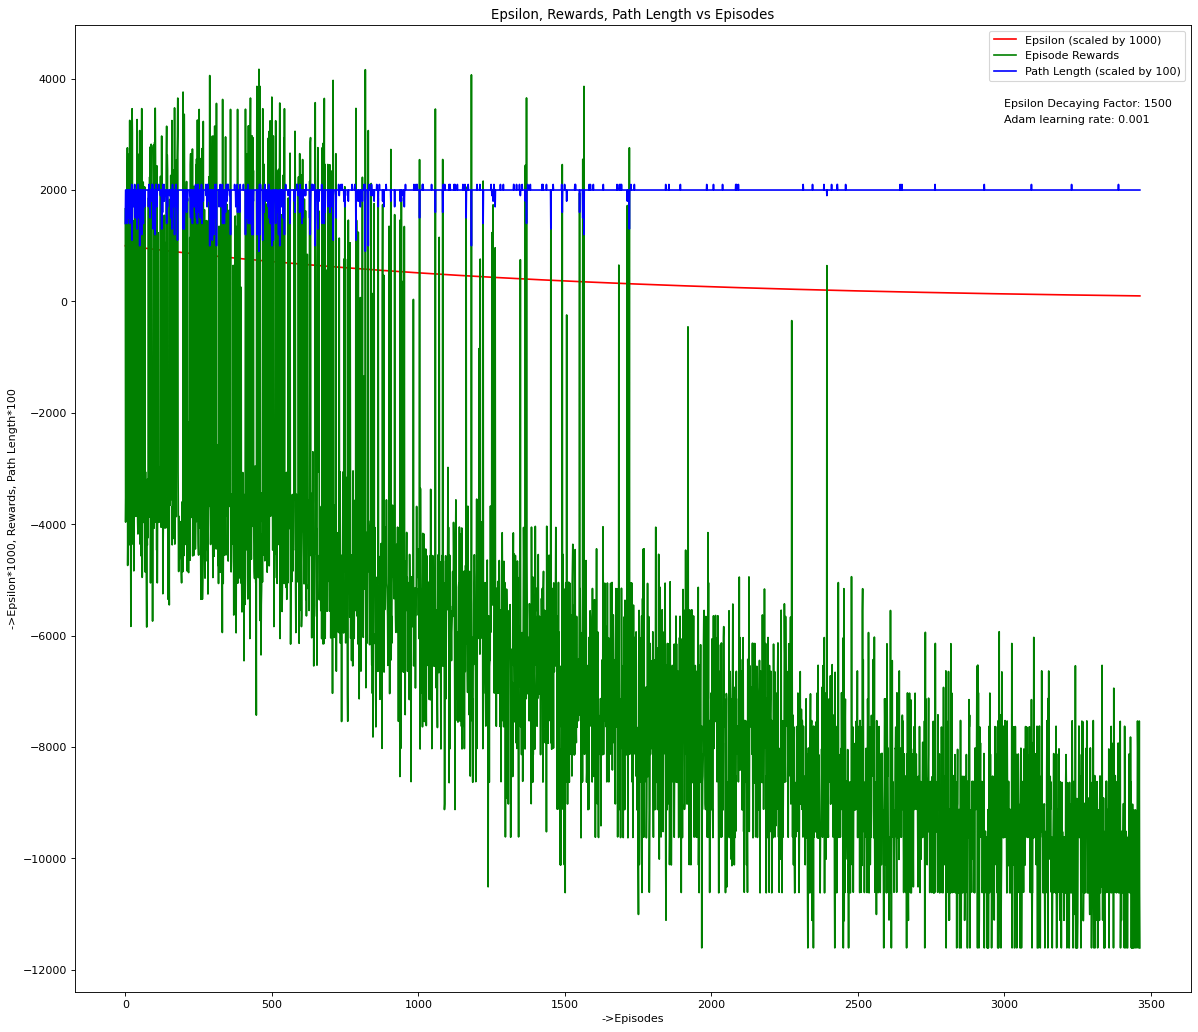

In [125]:
import os
try:
    os.mkdir('saved_plots')
except:
    print("folder is already there")
    
def plot_this(epsilon_list, rewards_list, path_length_list, environment):
    x_axis = list(range(environment.no_of_episodes))
    x_axis = x_axis[:len(path_length_list)]
    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    x_axis = x_axis[:len(epsilon_list)]
    plt.plot(x_axis,epsilon_list,'r', label='Epsilon (scaled by 1000)')
    plt.plot(x_axis,rewards_list,'g', label='Episode Rewards')
    plt.plot(x_axis,path_length_list,'b', label='Path Length (scaled by 100)')
    plt.legend(loc="upper right")
    plt.xlabel('->Episodes')
    plt.ylabel('->Epsilon*1000, Rewards, Path Length*100')
    plt.text(3000, 3500, f'Epsilon Decaying Factor: {epsilon_decaying_factor}')
    plt.text(3000, 3200, f'Adam learning rate: 0.001')
    plt.title('Epsilon, Rewards, Path Length vs Episodes')
plot_this(epsilon_list, rewards_list, path_length_list, environment)
plt.savefig(f'saved_plots/plot_{epsilon_decaying_factor}_mineps_{environment.min_epsilon}_lr_0.001.png')

In [122]:
# Save the entire model as a SavedModel.
import os
# !mkdir -p saved_model
try:
    os.mkdir('saved_models')
except:
    print('already there')
# mm, tm = DQNAgent.get_models()
agent.main_model.save(f'saved_models/main_model_ef_{epsilon_decaying_factor}_mineps_{environment.min_epsilon}_lr_0.001.h5')
agent.target_model.save(f'saved_models/target_model_ef_{epsilon_decaying_factor}_mineps_{environment.min_epsilon}_lr_0.001.h5')

already there


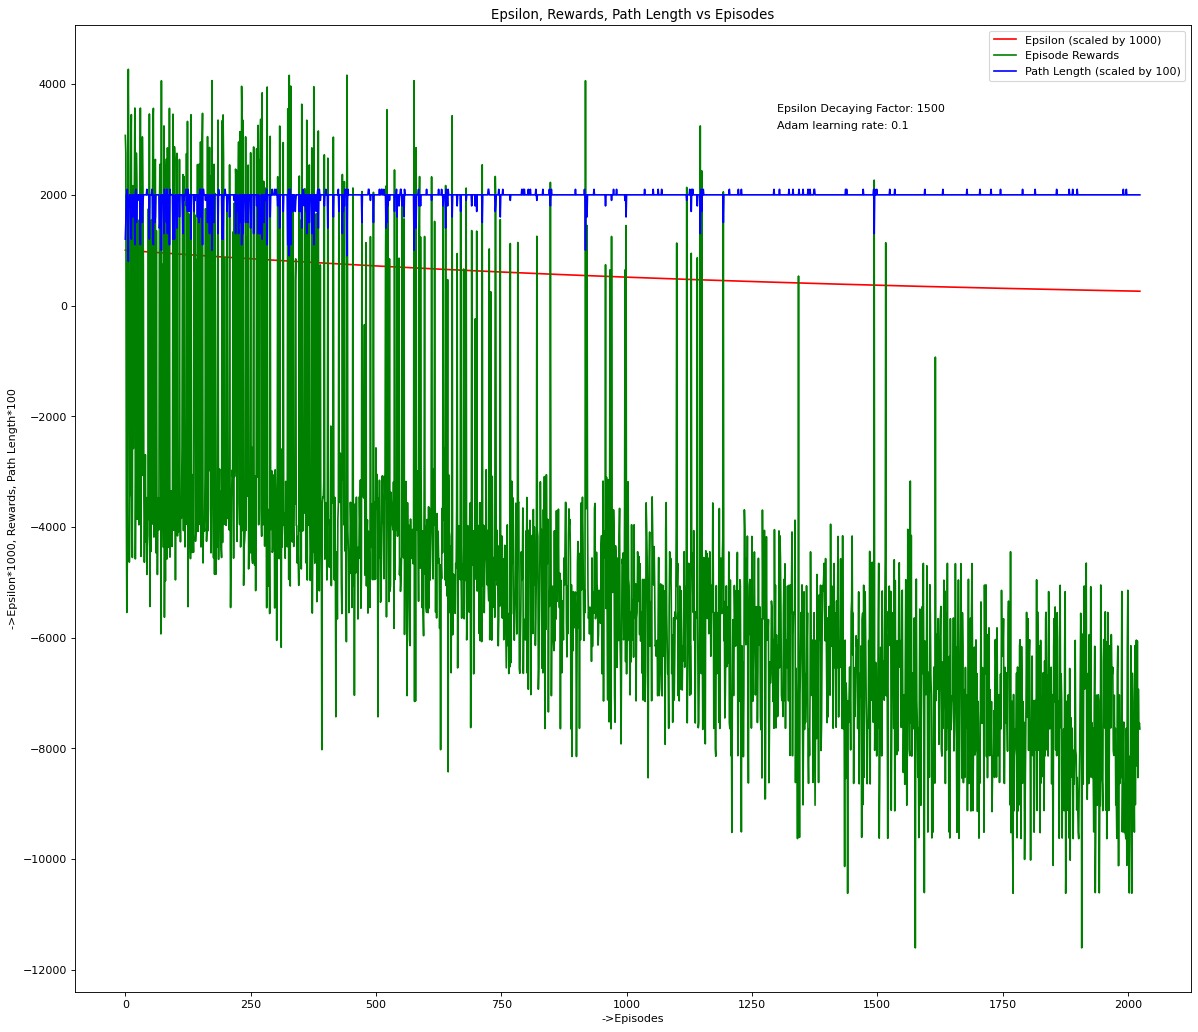

In [72]:
plot_this(epsilon_scaled, rewards_list, path_scaled, environment)

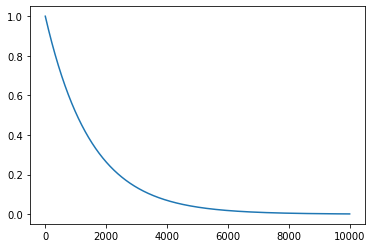

In [119]:
import numpy as np
import matplotlib.pyplot as plt
x = list(range(10000))
# print(x)
k = 1500
y = [float(np.exp(-i/k)) for i in x]
# print(y)
plt.plot(x,y)

In [33]:
class keka:
    def test(self,i):
        return i[1]
    a = [(1,3),(2,1),(3,2)]
    def uppu(self):
        self.a.sort(reverse=True,key=self.test)
        return self.a
    
k = keka()
print(k.uppu())

[(1, 3), (3, 2), (2, 1)]
